In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from utils.config import Config
from learner.dataset import FragmentDataset, DataCollator
from utils.parser import command_parser
from learner.model import Loss, Frag2Mol
import argparse
import pickle
from torch.utils.data import Dataset, DataLoader
import time
from gensim.models import Word2Vec
from collections import defaultdict
from utils.preprocess import add_fragments
from molecules.conversion import (
    mols_from_smiles, mol_to_smiles, mols_to_smiles, canonicalize)

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from learner.trainer import Trainer, save_ckpt
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


/home/teddy_t/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/teddy_t/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Plot Latent Space

In [3]:
#config = pickle.load(open('RUNS/2022-08-23@19:32:45-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
#vocab = pickle.load(open('RUNS/2022-08-23@19:32:45-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))
config = pickle.load(open('RUNS/2022-09-23@17:28:22-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
vocab = pickle.load(open('RUNS/2022-09-23@17:28:22-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
model = Frag2Mol(config, vocab)
#device = torch.device('cuda')
#model = model.to(device)

Vocab created/loaded. Size: 35118. Effective size: 35118. Time elapsed: 00:00:00.


In [4]:
load_last = config.get('load_last')
trainer, epoch = Trainer.load(config, vocab, last=load_last)
model = trainer.model

loading best_loss.pt at epoch 20...


In [5]:
model

Frag2Mol(
  (embedder): Embedding(35118, 100)
  (latent2rnn): Linear(in_features=100, out_features=64, bias=True)
  (encoder): Encoder(
    (rnn): GRU(100, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=100, out_features=100, bias=True)
    (rnn2logv): Linear(in_features=100, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(100, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=64, out_features=35118, bias=True)
  )
  (mlp): MLP(
    (layers_qed): Sequential(
      (0): Linear(in_features=100, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): ReLU()
      (4): Sigmoid()
    )
    (layers_logp): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )

In [6]:
loader = dataset.get_loader()
#mu_stack = torch.empty((32,100))
#latent_output = torch.empty((32,100))
data_sample = []
data_sample_correct = []
rnn2mean_weight = model.encoder.rnn2mean.weight

Data loaded. Size: 103684. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
for idx, (src, tgt, lengths, data, tgt_str) in enumerate(loader):
    ###
    src, tgt = Variable(src), Variable(tgt)
    if config.get('use_gpu'):
        src = src.cuda()
        tgt = tgt.cuda()

    output, mu, sigma, z, pred_logp = model.forward(src, lengths)
    
    #print(torch.all(rnn2mean_weight == model.encoder.rnn2mean.weight))
    model.encoder.rnn2mean.weight.size() == model.encoder.rnn2mean.weight.size()
    
    #get correct id
    tgt_str_lst = [vocab.translate(target_i) for target_i in tgt.cpu().detach().numpy()]
    target_str_ls_2 = [" ".join(vocab.translate(target_i)) for target_i in tgt.cpu().detach().numpy()]
    src_str_ls_2 = [vocab.translate(target_i) for target_i in src.cpu().detach().numpy()]
    molecules = dataset.data.iloc[list(data)]
    data_index_correct = [molecules[molecules['fragments'] == target_str_ls_2_i].index.values[0] for target_str_ls_2_i in target_str_ls_2]
    molecules_correct = dataset.data.iloc[data_index_correct]
    data_sample_correct.append(data_index_correct)
            
    ###Teddy Code
    data_sample.append(list(data))
    if idx == 0:
        mu_stack = mu
        pred_logp_stack = pred_logp
        #pred_sas_stack = pred_sas
    else:
        mu_stack = torch.cat((mu_stack, mu), 0)
        pred_logp_stack = torch.cat((pred_logp_stack, pred_logp), 0)
        #pred_sas_stack = torch.cat((pred_sas_stack, pred_sas), 0)
    print(len(mu_stack))
    if len(mu_stack) > 80000:
        break

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [8]:
data_sample_index = [item for sublist in data_sample for item in sublist]

In [9]:
data_sample_index_correct = [item for sublist in data_sample_correct for item in sublist]

In [10]:
data_sample_index

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [11]:
data_sample_index_correct

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [12]:
pred_logp_stack.cpu().detach().numpy()

array([ 2.404222 ,  4.2611017,  5.475991 , ...,  5.0576677, 11.679413 ,
        3.7523484], dtype=float32)

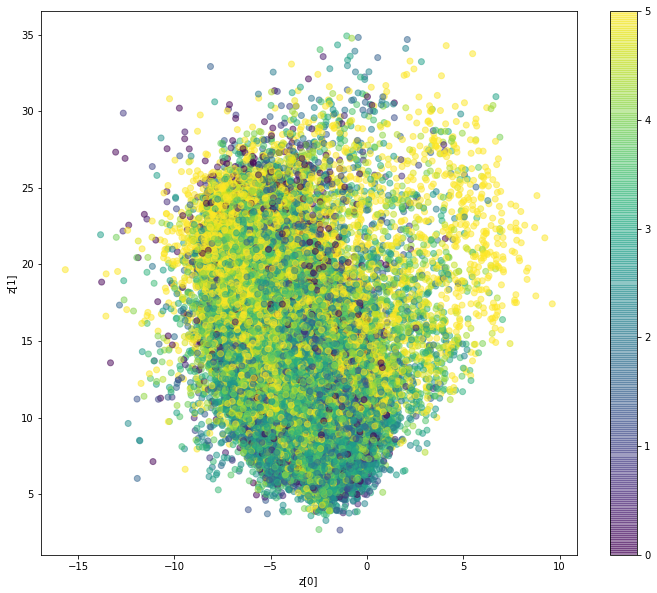

In [22]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:, 1].cpu().detach().numpy(), mu_stack[:, 2].cpu().detach().numpy(), c=pred_logp_stack.cpu().detach().numpy(), alpha=0.5, vmin = 0, vmax = 5)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0025, 0.003)
#plt.ylim(-0.0025, 0.0025)
plt.show()

In [14]:
dataset.data

smiles  \
0        CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...   
1              Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1   
2        COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...   
3        Cc1cc(COc2ccc(NC(=O)C3CN(C)CCC3C(=O)NO)cc2)c2c...   
4        CCOC(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C...   
...                                                    ...   
1043053     COc1ccc2c(OCc3nnc4ccc(-c5cc(C)no5)cn34)ccnc2c1   
1043054       N#CC(=C1Nc2ccccc2S1)c1ccnc(NCCc2cccc(F)c2)n1   
1043055  O=C(O)CCc1ccc(-c2c(C=Cc3ccc4ccccc4n3)nc3c(N4CC...   
1043056      CCOCCc1ccc(OCCNC(=O)c2cc(C(C)(C)C)nn2C)c(C)c1   
1043057                  NCCCC(=O)Nc1ccc(C(=O)Nc2nccs2)cc1   

                                                 fragments  n_fragments   C  \
0        *CCC *N(*)* *C(*)=O *C1OC(C(=O)O)=CC(N)C1* *N*...          9.0  26   
1        *c1ccc(O)cc1 *NC(=S)N1N=C(c2ccccc2)CC1* *c1ccccc1          3.0  22   
2        *OC *C(*)=O *c1cc(C(=*)c2cc(*)c(*)c(Cl)c2)cc(C...          8.0  25   
3        *c1cc(C)nc2ccccc12 *CO* *c1ccc(*)cc1 *N* *C(*)...          7.0  25   
4        *CC *O* *C(*)=O *c1ccc(O)c(*)c1 *c1c2c(=O)n(C)...          6.0  23   
...                                                    ...          ...  ..   
1043053  *OC *c1ccc2c(*)ccnc2c1 *O* *C* *c1ccc2nnc(*)n2...          6.0  21   
1043054  *c1nccc(C(C#N)=C2Nc3ccccc3S2)n1 *N* *CC* *c1cc...          4.0  21   
1043055  *CCC(=O)O *c1ccc(*)nc1 *c1ccnn2c(*)c(C=*)nc12 ...          5.0  29   
1043056  *CC *O* *CC* *c1ccc(*)c(C)c1 *O* *CC* *N* *C(*...         10.0  22   
1043057   *C(=O)CCCN *N* *c1ccc(*)cc1 *C(*)=O *N* *c1nccs1          6.0  14   

         F  N  O  Other  SINGLE  DOUBLE  TRIPLE  Tri  Quad  Pent  Hex  \
0        0  3  5      0      26      10       0    0     0     0    3   
1        0  3  1      1      19      11       0    0     0     1    3   
2        0  0  7      3      26      10       0    0     0     0    2   
3        0  4  4      0      26      10       0    0     0     0    4   
4        0  3  5      0      23      11       0    0     0     1    3   
...     .. .. ..    ...     ...     ...     ...  ...   ...   ...  ...   
1043053  0  5  3      0      22      11       0    0     0     2    3   
1043054  1  5  0      1      20      10       1    0     0     1    3   
1043055  0  6  3      0      29      14       0    0     0     1    5   
1043056  0  3  3      0      23       6       0    0     0     1    1   
1043057  0  4  2      1      15       7       0    0     0     1    1   

            logP        mr       qed       SAS  
0        2.33400  128.6249  0.522569  3.595745  
1        4.94030  112.9455  0.638566  2.563412  
2        6.07540  138.1390  0.264467  2.973098  
3        3.13402  124.9069  0.395442  3.145495  
4        2.57720  116.8143  0.513201  2.494430  
...          ...       ...       ...       ...  
1043053  3.82852  105.8480  0.452799  2.604622  
1043054  4.68028  109.0804  0.617420  2.715200  
1043055  4.36370  145.8778  0.347080  3.065345  
1043056  3.41382  111.1122  0.669825  2.398846  
1043057  2.07280   83.4273  0.760744  1.904081  

[1043058 rows x 19 columns]

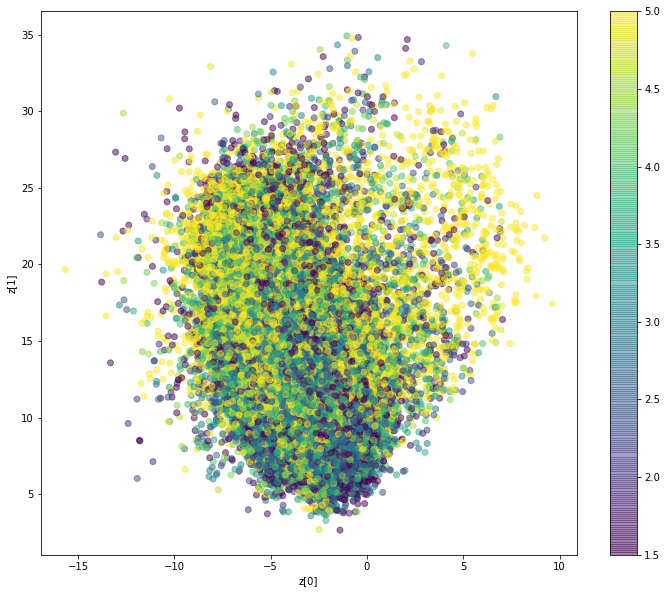

In [21]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:, 1].cpu().detach().numpy(), mu_stack[:, 2].cpu().detach().numpy(), c=np.array(dataset.data.loc[data_sample_index_correct, 'logP']), alpha=0.5, vmin = 1.5, vmax = 5)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0025, 0.003)
#plt.ylim(-0.0025, 0.0025)
plt.show()

In [15]:
np.array(dataset.data.loc[data_sample_index_correct, 'qed'])

array([0.56935381, 0.50796825, 0.60707577, ..., 0.55460427, 0.37813242,
       0.86178722])

In [16]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:, 1].cpu().detach().numpy(), mu_stack[:, 2].cpu().detach().numpy(), c=data_sample_index_correct.cpu().detach().numpy(), alpha=0.5)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0025, 0.003)
#plt.ylim(-0.0025, 0.0025)
plt.show()

AttributeError: 'list' object has no attribute 'cpu'

<Figure size 864x720 with 0 Axes>

In [16]:
x = mu_stack.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [17]:
principalDf

pc1        pc2
0      9.732434  -3.099416
1     -7.479857   5.454526
2      7.143992  -4.014184
3      4.734019   0.892129
4      0.955792   1.539188
...         ...        ...
80095 -0.458196   4.127152
80096  7.966084  -1.244957
80097  2.057272  -1.014255
80098  5.944468  11.151236
80099 -7.198427  -3.187700

[80100 rows x 2 columns]

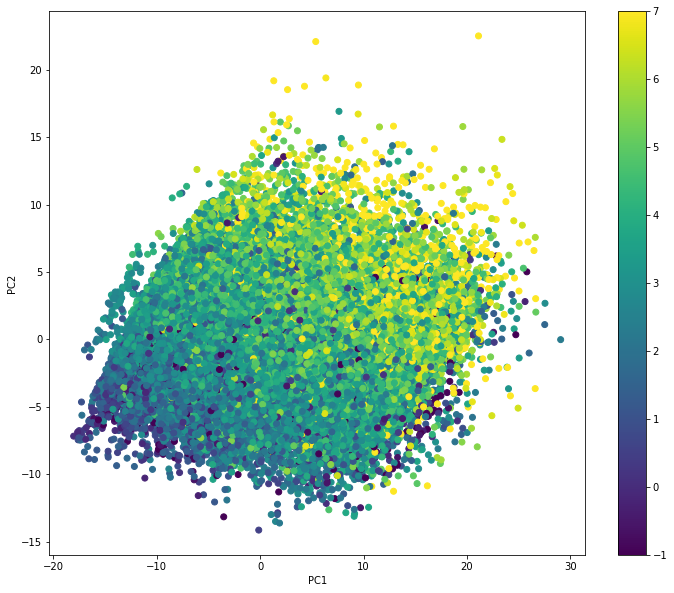

In [23]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            c=pred_logp_stack.cpu().detach().numpy(),
            vmin = -1, vmax = 7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.show()

## Predict Property with XGBoost

In [24]:
mu_stack_norm_pd = pd.DataFrame(F.normalize(mu_stack).cpu().detach().numpy())

In [26]:
dataset.data.loc[data_sample_index_correct, 'SAS'].values

array([2.67444969, 2.1563327 , 2.36148789, ..., 3.5367579 , 2.11492647,
       2.7388915 ])

In [60]:
input_MLP_normalized_pd = pd.DataFrame(input_MLP_normalized)

In [27]:
model = XGBRegressor()
model.fit(mu_stack_norm_pd, dataset.data.loc[data_sample_index_correct, 'SAS'].values)

/home/teddy_t/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [28]:
pred = model.predict(mu_stack_norm_pd)

In [30]:
rmse = np.sqrt(1/len(pred)*np.sum((dataset.data.loc[data_sample_index_correct, 'SAS'].values - pred)**2))
print("RMSE : % f" %(rmse))

RMSE :  0.718231


In [31]:
pred

array([2.8165863, 2.8165863, 2.8254445, ..., 2.73183  , 2.9543164,
       2.872645 ], dtype=float32)

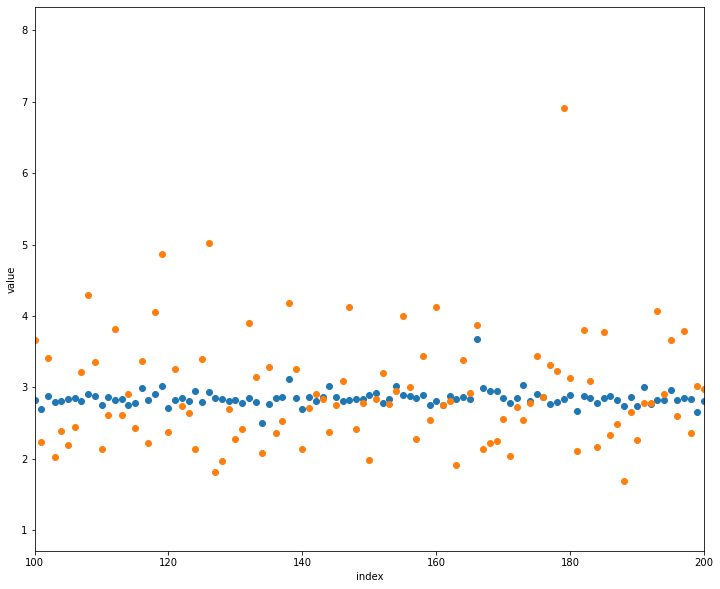

In [35]:
plt.figure(figsize=(12, 10))
plt.scatter( np.arange(len(pred)),np.array(pred))
plt.scatter( np.arange(len(pred)),np.array(dataset.data.loc[data_sample_index_correct, 'SAS'].values))
#plt.scatter( np.arange(len(labels.detach().numpy())),np.array(labels.detach().numpy()))
plt.xlabel("index")
plt.ylabel("value")
plt.xlim(100,200)
plt.show()

# Predict property with MLP

In [36]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [37]:
data = dataset.data.iloc[data_sample_index_correct]

In [38]:
labels = torch.tensor(data.logP.values)

In [39]:
mu_stack.size()

torch.Size([79744, 100])

In [40]:
mu_stack_pd = pd.DataFrame(mu_stack.cpu().detach().numpy())

In [41]:
mu_stack_pd

0         1         2         3         4         5         6   \
0     -0.004484  0.005187 -0.006637  0.004785  0.004421 -0.004088 -0.008455   
1     -0.003821  0.003991 -0.004992  0.003867  0.003755 -0.003101 -0.006145   
2     -0.003140  0.002873 -0.003454  0.003050  0.003006 -0.002148 -0.003860   
3     -0.003009  0.003381 -0.004105  0.002624  0.003266 -0.001809 -0.004259   
4     -0.003890  0.003579 -0.004444  0.004104  0.002882 -0.003737 -0.004276   
...         ...       ...       ...       ...       ...       ...       ...   
79739  0.000438  0.000101  0.000746 -0.000971  0.000250  0.000309  0.001128   
79740  0.000734  0.000550  0.001523 -0.000072 -0.000075 -0.000111  0.000763   
79741 -0.000617  0.000146  0.002219 -0.001159 -0.000974 -0.000448  0.002206   
79742 -0.000026 -0.000444  0.002342 -0.001042 -0.000802 -0.000931  0.001853   
79743 -0.001045  0.000708  0.002502 -0.000150 -0.002341  0.000617  0.000065   

             7         8         9   ...            90        91        92  \
0      0.006035 -0.006374  0.006505  ... -4.353086e-03 -0.006184 -0.002420   
1      0.004715 -0.005195  0.004849  ... -3.998163e-03 -0.004645 -0.002722   
2      0.003523 -0.004053  0.003291  ... -3.751929e-03 -0.003058 -0.002914   
3      0.003377 -0.004367  0.003243  ... -3.699544e-03 -0.002994 -0.002420   
4      0.004310 -0.003852  0.004036  ... -3.154966e-03 -0.003525 -0.002831   
...         ...       ...       ...  ...           ...       ...       ...   
79739 -0.001088  0.000049 -0.000693  ... -3.259629e-08 -0.000139  0.000258   
79740  0.000112  0.001209 -0.000935  ... -1.263457e-03 -0.000278  0.000228   
79741 -0.000043  0.001752 -0.002096  ... -6.151078e-04  0.000217  0.000941   
79742 -0.000211  0.002271 -0.002244  ...  1.968862e-04  0.001033  0.001403   
79743  0.002580  0.003189 -0.002666  ... -3.900546e-03  0.000790  0.000645   

             93        94        95        96        97        98        99  
0      0.004875  0.004959  0.004414 -0.004235  0.002080  0.000094 -0.002081  
1      0.003967  0.003806  0.003549 -0.003582  0.002234  0.000525 -0.002133  
2      0.003190  0.002681  0.002815 -0.002951  0.002391  0.000841 -0.002112  
3      0.002976  0.002873  0.002787 -0.002968  0.002477  0.000761 -0.002612  
4      0.004301  0.003967  0.003579 -0.004105  0.000192  0.000749 -0.000645  
...         ...       ...       ...       ...       ...       ...       ...  
79739 -0.000196 -0.000849 -0.000152  0.000060  0.000302  0.001170 -0.001233  
79740 -0.000490 -0.001550 -0.000640  0.000589  0.000236  0.000596 -0.000334  
79741 -0.000133 -0.000503 -0.001241  0.000309  0.001953  0.000646 -0.001445  
79742  0.000116  0.000234 -0.001737  0.001149  0.001689 -0.000053 -0.000763  
79743 -0.000792 -0.002402 -0.002276  0.000928  0.001961 -0.000032 -0.000270  

[79744 rows x 100 columns]

In [42]:
data

smiles  \
39722            COc1ccc(S(=O)(=O)NC2CCCCC2OCc2ccccc2)cc1   
16100   Cc1ccc(Nc2cc(C)nc(Nc3ccc(NS(=O)(=O)c4ccc(F)cc4...   
115202       CSc1ccc(CCNC(=O)Cn2ncc3c(=O)oc4ccccc4c32)cc1   
41377                COC(=O)C1CC(NC(=O)c2ccncc2)CN1C(C)=O   
84707   COc1ccc(-c2ccc3c(c2)C(=CNc2ccc(CN4CCCCC4)cc2)C...   
...                                                   ...   
10766         O=C(Nc1ccc2c(O)cccc2c1)c1cc2cc(Cl)ccc2[nH]1   
4319    CN1C(=O)N(c2cccc(C(F)(F)F)c2)C2=C(C(=O)CC2)C1c...   
4807    CC(C)CC(C[Si](O)(O)CNC(=O)CCc1ccccc1)C(=O)NC(C...   
34910           CCn1c(=O)n(-c2ccccc2)c2nc(Nc3ccccc3)ncc21   
67389                 Cc1ccc(CN2CCc3c(CN(C)C)n[nH]c3C2)s1   

                                                fragments  n_fragments   C  F  \
39722   *OC *c1ccc(S(*)(=O)=O)cc1 *N* *C1CCCCC1* *O* *...          7.0  20  0   
16100   *c1ccc(C)cc1 *N* *c1cc(C)nc(*)n1 *N* *c1ccc(*)...          7.0  24  1   
115202  *SC *c1ccc(*)cc1 *CC* *N* *CC(*)=O *n1ncc2c(=O...          6.0  21  0   
41377   *OC *C(*)=O *C1CC(*)N(C(C)=O)C1 *N* *C(*)=O *c...          6.0  14  0   
84707   *OC *c1ccc(*)cc1 *NC=C1C(=O)NC(=O)c2ccc(*)cc21...          5.0  29  0   
...                                                   ...          ...  .. ..   
10766   *C(=O)c1cc2cc(Cl)ccc2[nH]1 *N* *c1ccc2c(O)cccc2c1          3.0  19  0   
4319    *N1C(=O)N(C)C(c2ccc(C#N)cc2C(O)=NC(C)(C)C#N)C2...          3.0  27  3   
4807    *NC[Si](O)(O)CC(CC(C)C)C(=O)NC(CC(C)C)C(=O)O *...          3.0  23  0   
34910      *CC *n1c(=O)n(*)c2nc(Nc3ccccc3)ncc21 *c1ccccc1          3.0  19  0   
67389           *c1ccc(C)s1 *CN1CCc2c(*)n[nH]c2C1 *CN(C)C          3.0  15  0   

        N  O  Other  SINGLE  DOUBLE  TRIPLE  Tri  Quad  Pent  Hex     logP  \
39722   1  4      1      20       8       0    0     0     0    3  3.50150   
16100   5  2      1      22      14       0    0     0     0    4  5.52054   
115202  3  3      1      21      10       0    0     0     1    3  3.22350   
41377   3  4      0      16       6       0    0     0     1    1 -0.02620   
84707   3  3      0      27      12       0    0     0     0    5  5.07110   
...    .. ..    ...     ...     ...     ...  ...   ...   ...  ...      ...   
10766   2  2      1      17      10       0    0     0     1    3  4.93240   
4319    5  3      0      29      10       2    0     0     1    3  5.41396   
4807    2  6      1      26       6       0    0     0     0    1  1.97920   
34910   5  1      0      18      10       0    0     0     1    3  3.34570   
67389   4  0      1      18       4       0    0     0     2    1  2.39952   

              mr       qed       SAS  
39722   100.5905  0.804388  2.674450  
16100   128.1639  0.333964  2.156333  
115202  110.7117  0.402015  2.361488  
41377    73.2992  0.790275  2.961940  
84707   138.0729  0.391242  2.347215  
...          ...       ...       ...  
10766    96.8747  0.485523  2.085284  
4319    131.1048  0.425819  3.925033  
4807    124.7378  0.266049  3.536758  
34910    98.5237  0.622738  2.114926  
67389    82.8527  0.938905  2.738892  

[79744 rows x 19 columns]

In [22]:
data.drop(['smiles', 'fragments', 'logP'], axis = 1)

n_fragments   C  F  N  O  Other  SINGLE  DOUBLE  TRIPLE  Tri  Quad  \
52738            3  19  0  3  4      0      20       8       0    0     1   
93736            2  22  0  4  3      1      26       9       0    1     0   
23167            3  14  0  3  3      0      18       2       0    0     0   
24621            2  19  0  0  6      0      21       6       0    0     0   
8983             2  17  0  8  2      1      20      11       0    0     0   
...            ...  .. .. .. ..    ...     ...     ...     ...  ...   ...   
48999            2  26  0  5  3      0      29      10       0    0     0   
7596             2  23  0  1  4      0      22       9       0    1     0   
51076            2  27  0  3  3      0      31       5       0    0     0   
39999            2  23  0  5  2      3      26      10       0    0     0   
31905            2  30  0  5  2      1      28      14       0    0     0   

       Pent  Hex        mr       qed       SAS  
52738     0    2   94.5749  0.549669  3.971813  
93736     2    3  115.1885  0.692663  4.456667  
23167     1    0   77.3192  0.790590  3.382639  
24621     0    3   90.6304  0.751506  3.151427  
8983      3    1  103.1796  0.390111  2.748864  
...     ...  ...       ...       ...       ...  
48999     1    4  130.2389  0.478360  2.960355  
7596      0    3  108.6475  0.610157  2.208684  
51076     1    3  129.9257  0.563468  4.088032  
39999     1    3  134.2420  0.462128  2.495275  
31905     1    4  151.9191  0.345869  2.679355  

[100032 rows x 16 columns]

In [23]:
input_MLP = torch.tensor(mu_stack_pd.join(data.drop(['smiles', 'fragments', 'logP'], axis = 1)).values).float()

In [49]:
torch.tensor(mu_stack_pd.values)

tensor([[-4.4843e-03,  5.1865e-03, -6.6371e-03,  ...,  2.0803e-03,
          9.4267e-05, -2.0809e-03],
        [-3.8209e-03,  3.9910e-03, -4.9924e-03,  ...,  2.2338e-03,
          5.2539e-04, -2.1327e-03],
        [-3.1401e-03,  2.8730e-03, -3.4540e-03,  ...,  2.3912e-03,
          8.4061e-04, -2.1118e-03],
        ...,
        [-6.1706e-04,  1.4588e-04,  2.2193e-03,  ...,  1.9525e-03,
          6.4564e-04, -1.4453e-03],
        [-2.5664e-05, -4.4427e-04,  2.3420e-03,  ...,  1.6888e-03,
         -5.2748e-05, -7.6257e-04],
        [-1.0445e-03,  7.0759e-04,  2.5019e-03,  ...,  1.9611e-03,
         -3.2036e-05, -2.6976e-04]])

In [50]:
input_MLP_normalized = F.normalize(torch.tensor(mu_stack_pd.values))

In [51]:
input_MLP_normalized.size()

torch.Size([79744, 100])

In [52]:
MLP_model = MLP()

In [53]:
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
#loss_fn = F.mse_loss()
latent_output_data = mu_stack

In [54]:
latent_output_data

tensor([[-4.4843e-03,  5.1865e-03, -6.6371e-03,  ...,  2.0803e-03,
          9.4267e-05, -2.0809e-03],
        [-3.8209e-03,  3.9910e-03, -4.9924e-03,  ...,  2.2338e-03,
          5.2539e-04, -2.1327e-03],
        [-3.1401e-03,  2.8730e-03, -3.4540e-03,  ...,  2.3912e-03,
          8.4061e-04, -2.1118e-03],
        ...,
        [-6.1706e-04,  1.4588e-04,  2.2193e-03,  ...,  1.9525e-03,
          6.4564e-04, -1.4453e-03],
        [-2.5664e-05, -4.4427e-04,  2.3420e-03,  ...,  1.6888e-03,
         -5.2748e-05, -7.6257e-04],
        [-1.0445e-03,  7.0759e-04,  2.5019e-03,  ...,  1.9611e-03,
         -3.2036e-05, -2.6976e-04]], device='cuda:0', grad_fn=<CatBackward0>)

In [55]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 150

for epoch in range(epochs):
    MLP_model.train()
    
    train_losses = []
    valid_losses = [] 
    output_final = []
    for i, (latent_data) in enumerate(latent_output_data):
        
        outputs = MLP_model(Variable(latent_data.cpu()))
        if epoch + 1 == epochs:
            output_final.append(outputs.item())
        loss = F.mse_loss(outputs.type(torch.float64), labels[i])
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
            
    MLP_model.eval()
    mean_train_losses.append(np.mean(train_losses))
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))

<ipython-input-55-3e1b6afbaea0>:17: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs.type(torch.float64), labels[i])


epoch : 1, train loss : 3.3221
epoch : 2, train loss : 3.2969
epoch : 3, train loss : 3.2895
epoch : 4, train loss : 3.2845
epoch : 5, train loss : 3.2804
epoch : 6, train loss : 3.2774
epoch : 7, train loss : 3.2759
epoch : 8, train loss : 3.2752


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [43]:
latent_data.size()

torch.Size([100])

In [32]:
labels[i]

tensor(0.9203, dtype=torch.float64)

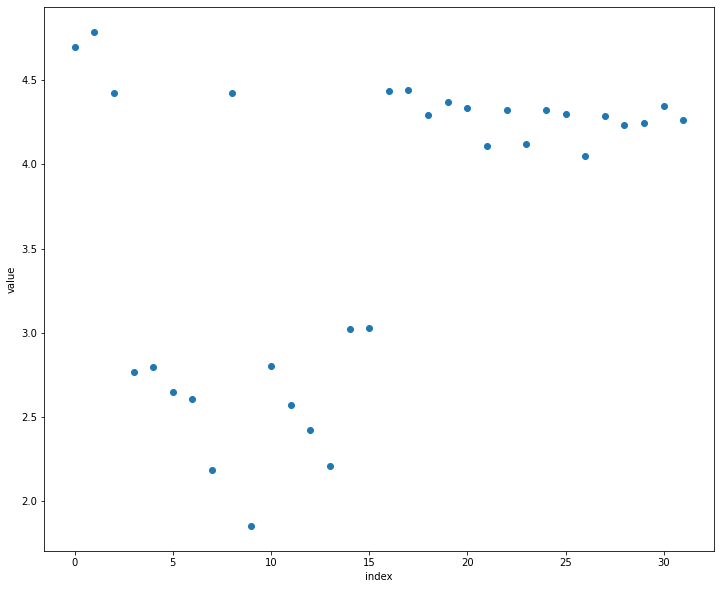

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter( np.arange(len(output_final)),np.array(output_final))
#plt.scatter( np.arange(len(labels.detach().numpy())),np.array(labels.detach().numpy()))
plt.xlabel("index")
plt.ylabel("value")
#plt.xlim(100,200)
plt.show()

# Plot Net

In [62]:
outputs, mu, sigma, z, pred = model(src, lengths)

In [63]:
from torchviz import make_dot

make_dot(outputs, params=dict(list(model.named_parameters()))).render("frag_20_torchviz", format="png")

'frag_20_torchviz.png'

# Plot Embedding Space

In [6]:
vocab.w2i

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 'cluster_4': 3,
 'cluster_5': 4,
 'cluster_3': 5,
 'cluster_6': 6,
 'cluster_2': 7,
 'cluster_7': 8,
 '*OCC': 9,
 'cluster_1': 10,
 '*c1ccccc1': 11,
 '*c1ccc(OC)cc1': 12,
 '*C(C)=O': 13,
 '*C(C)C': 14,
 '*CCC': 15,
 '*N(C)C': 16,
 '*c1ccc(C)cc1': 17,
 '*C(=O)O': 18,
 '*C(=O)OC': 19,
 '*CCCC': 20,
 'cluster_0': 21,
 '*C(C)(C)C': 22,
 '*c1ccccc1OC': 23,
 '*Cc1ccccc1': 24,
 '*c1cccc(OC)c1': 25,
 '*N(CC)CC': 26,
 '*c1ccc(OC)c(OC)c1': 27,
 '*C(F)(F)F': 28,
 'cluster_m1': 29,
 '*C(N)=O': 30,
 '*CC=C': 31,
 '*c1ccccc1C': 32,
 '*CCOC': 33,
 '*c1cccc(C)c1': 34,
 '*c1ccc(Cl)cc1': 35,
 '*CC(C)C': 36,
 '*c1ccc(F)cc1': 37,
 '*CC(=O)O': 38,
 '*CCN*': 39,
 '*N1CCN(C)CC1': 40,
 '*c1cc(OC)c(OC)c(OC)c1': 41,
 '*NCC': 42,
 '*NC(*)=O': 43,
 '*S(C)(=O)=O': 44,
 '*C(=O)NC': 45,
 '*N1CCOCC1': 46,
 '*CCCCC': 47,
 '*C(=O)CC': 48,
 'cluster_m2': 49,
 '*C(=O)c1ccccc1': 50,
 '*=C(C)C': 51,
 '*S(=O)(=O)c1ccc(C)cc1': 52,
 '*CCCCCC': 53,
 '*Nc1ccccc1': 54,
 '*c1ccco1': 55,
 '*

In [7]:
df_vocab_i2w = pd.DataFrame.from_dict(vocab.i2w, orient='index')
df_vocab_i2w = df_vocab_i2w.rename(columns = {0: 'fragment'}) 
df_vocab_i2w['sum_log_p'] = 0
df_vocab_i2w['count_log_p'] = 0

In [8]:
vocab.w2w_infreq

{'*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O': 'cluster_3',
 '*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1': 'cluster_5',
 '*CCCC=C(c1cc(*)c(OC)c(Cl)c1)c1cc(Cl)c(OC)c(C(=O)OC)c1': 'cluster_7',
 '*COc1ccc(NC(=O)C2CN(C)CCC2C(=O)NO)cc1': 'cluster_4',
 '*C(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C)c(=O)n3C)c1': 'cluster_3',
 '*c1cccc(-c2ccc(C#N)cc2)c1': 'cluster_6',
 '*CC1(OC)OOC(*)(C)CC1CO': 'cluster_4',
 '*Nc1ccc2c3c(cccc13)C(=O)N(CCCN1CCCNCCNCCCNCC1)C2=O': 'cluster_5',
 '*N1C2CCC1C(C(=O)OC)=C(c1cc3ccccc3o1)C2': 'cluster_5',
 '*=Cc1cccc(C(F)(F)P(=O)(O)O)c1': 'cluster_4',
 '*c1cc(N)nc(NC2CCCC2)c1': 'cluster_3',
 '*N(CC)c1ccc(OC)c2nc(NC(=O)C3CCN(C(=O)c4cccc(C(F)(F)F)c4)CC3)sc12': 'cluster_6',
 '*C1CCC(C)C(c2ccc(C)cc2)N1C(=O)c1ccc(C=NOCC(O)COCc2ccco2)cc1': 'cluster_5',
 '*C(=O)C1(Cc2ccccc2C)CCCN(C(=O)CCC(=O)OC)C1': 'cluster_3',
 '*n1c(CN2C(=O)COc3c2cc(C)cc3[N+](=O)[O-])nnc1-c1ccc(Cl)cn1': 'cluster_4',
 '*NC(=O)c1cc(-c2cccc(F)c2)ccn1': 'cluster_4',
 '*c1cccnc1C1CC(O)C(NC(=N)N)CC1NC(=N)N'

In [9]:
df_vocab_w2w_infreq = pd.DataFrame.from_dict(vocab.w2w_infreq, orient='index').reset_index()
df_vocab_w2w_infreq = df_vocab_w2w_infreq.rename(columns = {'index': 'fragment', 0: 'cluster'}) 

In [10]:
fragment_statistics = []

In [11]:
for i in tqdm(range(len(dataset.data))):
    fragments = dataset.data.fragments[i]
    fragment_log_p = dataset.data.logP[i]
    frag_list = fragments.split()
    for frag in frag_list:
        fragment_statistics.append([frag, fragment_log_p])

100%|██████████| 103491/103491 [00:02<00:00, 49761.33it/s]


In [12]:
df_fragment_statistics = pd.DataFrame(fragment_statistics, columns=["Fragment", "LogP"])

In [13]:
vocab.w2w_infreq["*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O"]

'cluster_3'

In [14]:
for infreq_frag in tqdm(vocab.w2w_infreq):
    df_fragment_statistics.loc[df_fragment_statistics['Fragment'] == infreq_frag, "cluster"] = vocab.w2w_infreq[infreq_frag]

100%|██████████| 99630/99630 [22:21<00:00, 74.27it/s]


In [15]:
df_fragment_statistics

Fragment     LogP    cluster
0                                                    *CCC  2.33400        NaN
1       *N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(...  2.33400  cluster_3
2                                            *c1ccc(O)cc1  4.94030        NaN
3                       *C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1  4.94030  cluster_5
4                                                *C(=O)OC  6.07540        NaN
...                                                   ...      ...        ...
231861                            *CN1C(=O)NC2(CCCC2)C1=O  1.39340        NaN
231862                           *C(=O)N1CCN(c2cccnn2)CC1  2.72930  cluster_3
231863                              *Nc1ccc(OC(F)(F)F)cc1  2.72930        NaN
231864                                      *c1cc(F)ccc1C  5.59412        NaN
231865         *C(=O)Nc1ccc(C(=O)N2Cc3sccc3Cc3ccccc32)cn1  5.59412  cluster_6

[231866 rows x 3 columns]

Mean LogP for cluster_1: 0.58


<AxesSubplot:>

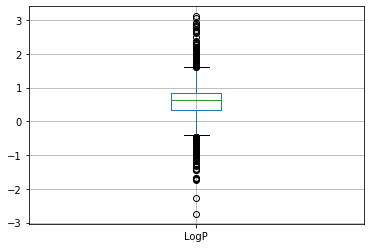

In [18]:
print("Mean LogP for cluster_1: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_1'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_1'].boxplot(column=['LogP']) 

Mean LogP for cluster_2: 1.57


<AxesSubplot:>

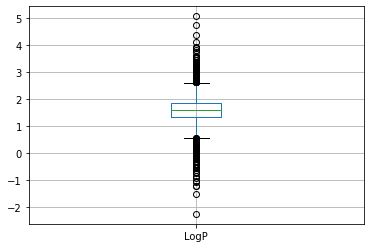

In [19]:
print("Mean LogP for cluster_2: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_2'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_2'].boxplot(column=['LogP']) 

Mean LogP for cluster_m5: -5.42


<AxesSubplot:>

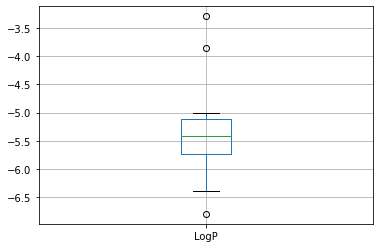

In [22]:
print("Mean LogP for cluster_m5: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_m5'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_m5'].boxplot(column=['LogP']) 

Mean LogP for cluster 6: 5.44


<AxesSubplot:>

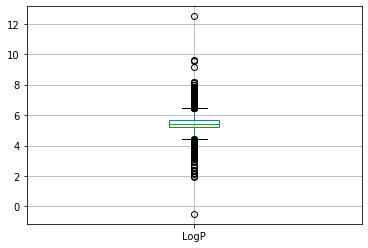

In [24]:
print("Mean LogP for cluster 6: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_6'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_6'].boxplot(column=['LogP']) 

In [20]:
df_fragment_statistics

Fragment     LogP     cluster
0                                                    *CCC  2.33400         NaN
1       *N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(...  2.33400  cluster1_1
2                                            *c1ccc(O)cc1  4.94030         NaN
3                       *C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1  4.94030  cluster1_1
4                                                *C(=O)OC  6.07540         NaN
...                                                   ...      ...         ...
231861                            *CN1C(=O)NC2(CCCC2)C1=O  1.39340         NaN
231862                           *C(=O)N1CCN(c2cccnn2)CC1  2.72930  cluster1_1
231863                              *Nc1ccc(OC(F)(F)F)cc1  2.72930         NaN
231864                                      *c1cc(F)ccc1C  5.59412         NaN
231865         *C(=O)Nc1ccc(C(=O)N2Cc3sccc3Cc3ccccc32)cn1  5.59412  cluster1_1

[231866 rows x 3 columns]

In [21]:
df_fragment_statistics.groupby('Fragment').std().reset_index()['LogP']

0         0.496781
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
107603    0.289631
107604    1.495876
107605    1.404381
107606    0.059185
107607         NaN
Name: LogP, Length: 107608, dtype: float64

In [22]:
df_fragment_statistics.groupby('Fragment').size().reset_index()[0]

0          5
1          1
2          1
3          1
4          1
          ..
107603     2
107604    12
107605     8
107606     2
107607     1
Name: 0, Length: 107608, dtype: int64

In [23]:
df_fragment_statistics_unique = df_fragment_statistics.groupby('Fragment').mean().reset_index()

In [24]:
df_fragment_statistics_unique['LogP_std'] = df_fragment_statistics.groupby('Fragment').std().reset_index()['LogP']
df_fragment_statistics_unique['frequency'] = df_fragment_statistics.groupby('Fragment').size().reset_index()[0]

In [25]:
df_fragment_statistics_unique

Fragment      LogP  LogP_std  frequency
0                             *#CC(C)(C)C  5.379280  0.496781          5
1                     *#CC1(C(F)(F)F)CCC1  6.163200       NaN          1
2                 *#CC1CCC(CNCC(F)(F)F)N1  6.430400       NaN          1
3                 *#CC=CC(O)COc1ccc(F)cc1  1.060400       NaN          1
4       *#CCCCC#CCS(=O)(=O)c1ccc2ccccc2c1  6.954000       NaN          1
...                                   ...       ...       ...        ...
107603                *n1sc2cc(F)ccc2c1=O  3.045600  0.289631          2
107604                   *n1sc2ccccc2c1=O  3.773668  1.495876         12
107605             *n1sc2nc(C)cc(C)c2c1=O  2.258250  1.404381          8
107606                   *n1sc2ncccc2c1=O  2.506250  0.059185          2
107607                         *n1sccc1=O  1.874700       NaN          1

[107608 rows x 4 columns]

In [26]:
df_fragment_statistics_unique_infreq = df_fragment_statistics_unique[df_fragment_statistics_unique['frequency']<=2].reset_index(drop = True)

array([[<AxesSubplot:title={'center':'LogP'}>,
        <AxesSubplot:title={'center':'LogP_std'}>],
       [<AxesSubplot:title={'center':'frequency'}>, <AxesSubplot:>]],
      dtype=object)

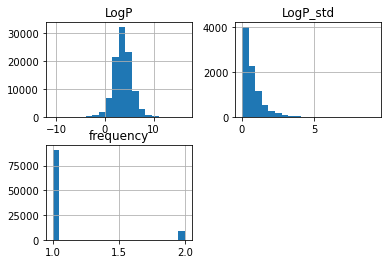

In [27]:
df_fragment_statistics_unique_infreq.hist(bins = 20)

In [28]:
len(df_fragment_statistics_unique_infreq[(df_fragment_statistics_unique_infreq['LogP']>=9) & (df_fragment_statistics_unique_infreq['LogP']<10)])

329

In [36]:
df_fragment_statistics_unique_infreq['cluster'] = ''

In [37]:
df_fragment_statistics_unique_infreq

Fragment     LogP  LogP_std  frequency  \
0                     *#CC1(C(F)(F)F)CCC1  6.16320       NaN          1   
1                 *#CC1CCC(CNCC(F)(F)F)N1  6.43040       NaN          1   
2                 *#CC=CC(O)COc1ccc(F)cc1  1.06040       NaN          1   
3       *#CCCCC#CCS(=O)(=O)c1ccc2ccccc2c1  6.95400       NaN          1   
4      *#CCCCCC#CCS(=O)(=O)c1ccc2ccccc2c1  5.81310       NaN          1   
...                                   ...      ...       ...        ...   
99625           *n1sc(=O)n(Cc2ccccc2)c1=O  1.52225  0.010677          2   
99626             *n1sc(N)c(C(=O)OCC)c1=S  2.22399       NaN          1   
99627                 *n1sc2cc(F)ccc2c1=O  3.04560  0.289631          2   
99628                    *n1sc2ncccc2c1=O  2.50625  0.059185          2   
99629                          *n1sccc1=O  1.87470       NaN          1   

      cluster  
0              
1              
2              
3              
4              
...       ...  
99625          
99626          
99627          
99628          
99629          

[99630 rows x 5 columns]

In [38]:
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] < -6), 'cluster'] = 'cluster_m6'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -6) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -5), 'cluster'] = 'cluster_m5'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -5) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -4), 'cluster'] = 'cluster_m4'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -4) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -3), 'cluster'] = 'cluster_m3'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -3) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -2), 'cluster'] = 'cluster_m2'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -2) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -1), 'cluster'] = 'cluster_m1'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -1) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 0), 'cluster'] = 'cluster_0'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 0) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 1), 'cluster'] = 'cluster_1'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 1) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 2), 'cluster'] = 'cluster_2'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 2) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 3), 'cluster'] = 'cluster_3'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 3) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 4), 'cluster'] = 'cluster_4'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 4) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 5), 'cluster'] = 'cluster_5'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 5) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 6), 'cluster'] = 'cluster_6'
df_fragment_statistics_unique_infreq.loc[df_fragment_statistics_unique_infreq['LogP'] >= 6, 'cluster'] = 'cluster_7'

In [59]:
df_fragment_statistics_unique_infreq

Fragment     LogP  LogP_std  frequency  \
0                     *#CC1(C(F)(F)F)CCC1  6.16320       NaN          1   
1                 *#CC1CCC(CNCC(F)(F)F)N1  6.43040       NaN          1   
2                 *#CC=CC(O)COc1ccc(F)cc1  1.06040       NaN          1   
3       *#CCCCC#CCS(=O)(=O)c1ccc2ccccc2c1  6.95400       NaN          1   
4      *#CCCCCC#CCS(=O)(=O)c1ccc2ccccc2c1  5.81310       NaN          1   
...                                   ...      ...       ...        ...   
99625           *n1sc(=O)n(Cc2ccccc2)c1=O  1.52225  0.010677          2   
99626             *n1sc(N)c(C(=O)OCC)c1=S  2.22399       NaN          1   
99627                 *n1sc2cc(F)ccc2c1=O  3.04560  0.289631          2   
99628                    *n1sc2ncccc2c1=O  2.50625  0.059185          2   
99629                          *n1sccc1=O  1.87470       NaN          1   

         cluster  
0      cluster_7  
1      cluster_7  
2      cluster_2  
3      cluster_7  
4      cluster_6  
...          ...  
99625  cluster_2  
99626  cluster_3  
99627  cluster_4  
99628  cluster_3  
99629  cluster_2  

[99630 rows x 5 columns]

In [61]:
df_fragment_statistics_unique_infreq.loc[df_fragment_statistics_unique_infreq['Fragment'] == '*#CC1(C(F)(F)F)CCC1', 'cluster'][0]

'cluster_7'

In [45]:
df_fragment_statistics_unique_cluster = pd.concat([df_fragment_statistics_unique[df_fragment_statistics_unique['frequency'] > 2], df_fragment_statistics_unique_infreq])

In [46]:
df_fragment_statistics

Fragment     LogP     cluster
0                                                    *CCC  2.33400         NaN
1       *N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(...  2.33400  cluster1_1
2                                            *c1ccc(O)cc1  4.94030         NaN
3                       *C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1  4.94030  cluster1_1
4                                                *C(=O)OC  6.07540         NaN
...                                                   ...      ...         ...
231861                            *CN1C(=O)NC2(CCCC2)C1=O  1.39340         NaN
231862                           *C(=O)N1CCN(c2cccnn2)CC1  2.72930  cluster1_1
231863                              *Nc1ccc(OC(F)(F)F)cc1  2.72930         NaN
231864                                      *c1cc(F)ccc1C  5.59412         NaN
231865         *C(=O)Nc1ccc(C(=O)N2Cc3sccc3Cc3ccccc32)cn1  5.59412  cluster1_1

[231866 rows x 3 columns]

In [53]:
def calculate_frequencies(sentences):
    w2f = defaultdict(int)

    for sentence in sentences:
        for word in sentence:
            w2f[word] += 1

    return w2f

In [79]:
SOS_TOKEN = '<SOS>'
PAD_TOKEN = '<PAD>'
EOS_TOKEN = '<EOS>'
TOKENS = [SOS_TOKEN, PAD_TOKEN, EOS_TOKEN]
start = time.time()
print("Training and clustering embeddings...", end=" ")

embed_size = config.get('embed_size')
embed_window = config.get('embed_window')
mask_freq = config.get('mask_freq')
use_mask = config.get('use_mask')

i2w_infreq = None
w2w_infreq = None
c2w_infreq = None
start_idx = len(TOKENS)

if use_mask:
    sentences = [s.split(" ") for s in df_fragment_statistics.Fragment]
    # first word embedding
    w2v = Word2Vec(
        sentences,
        vector_size=embed_size,
        window=embed_window,
        min_count=1,
        negative=5,
        workers=20,
        epochs=10,
        sg=1)

    vocab = w2v.wv.key_to_index
    embeddings = w2v.wv[vocab]

    w2f = calculate_frequencies(sentences)
    w2i = {k: v for (k, v) in vocab.items()}
    i2w = {v: k for (k, v) in w2i.items()}

    infreq = [w2i[w] for (w, freq) in w2f.items() if freq <= mask_freq]            
    i2w_infreq = {}
    for inf in tqdm(infreq):
        word = i2w[inf]
        i2w_infreq[inf] = df_fragment_statistics_unique_infreq.loc[df_fragment_statistics_unique_infreq['Fragment'] == word, 'cluster'].values[0]
        
end = time.time() - start
elapsed = time.strftime("%H:%M:%S", time.gmtime(end))
print(f'Done. Time elapsed: {elapsed}.')

Training and clustering embeddings... 

100%|██████████| 99630/99630 [23:27<00:00, 70.79it/s]

Done. Time elapsed: 00:23:32.


In [80]:
w2w_infreq = {i2w[k]: v for (k, v) in i2w_infreq.items()}
c2w_infreq = defaultdict(list)
for word, cluster_name in w2w_infreq.items():
    c2w_infreq[cluster_name].append(word)

# substitute infrequent words with cluster words
data = []
for sentence in sentences:
    sentence_sub = []
    for word in sentence:
        if word in w2w_infreq:
            word = w2w_infreq[word]
        sentence_sub.append(word)
    data.append(sentence_sub)

In [82]:
w2i = {PAD_TOKEN: 0, SOS_TOKEN: 1, EOS_TOKEN: 2}

w2v = Word2Vec(
        data,
        vector_size=embed_size,
        window=embed_window,
        min_count=1,
        negative=5,
        workers=20,
        epochs=10,
        sg=1)

vocab = w2v.wv.key_to_index
w2i.update({k: v + start_idx for (k, v) in vocab.items()})
i2w = {v: k for (k, v) in w2i.items()}

tokens = np.random.uniform(-0.05, 0.05, size=(start_idx, embed_size))
embeddings = np.vstack([tokens, w2v.wv[vocab]])
path = config.path('config') / f'emb_{embed_size}_2.dat'
np.savetxt(path, embeddings, delimiter=",")

In [57]:
w2f

defaultdict(int,
            {'*CCC': 1949,
             '*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O': 1,
             '*c1ccc(O)cc1': 258,
             '*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1': 1,
             '*C(=O)OC': 1550,
             '*CCCC=C(c1cc(*)c(OC)c(Cl)c1)c1cc(Cl)c(OC)c(C(=O)OC)c1': 1,
             '*C(=O)SC': 5,
             '*c1cc(C)nc2ccccc12': 58,
             '*COc1ccc(NC(=O)C2CN(C)CCC2C(=O)NO)cc1': 1,
             '*OCC': 4930,
             '*C(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C)c(=O)n3C)c1': 1,
             '*c1cc(=O)oc2cc(OC)cc(OC)c12': 4,
             '*c1cccc(-c2ccc(C#N)cc2)c1': 1,
             '*c1cc2c(OC)c(OC)c(OC)cc2[nH]1': 5,
             '*C(=O)Nc1ccc(F)cc1': 16,
             '*c1cc(F)cc(OC)c1': 5,
             '*C(=O)NC(CC(=O)O)c1ccc(*)cc1': 3,
             '*C1CCCN1S(=O)(=O)c1cc(Cl)cc(Cl)c1': 3,
             '*c1ccc(Cl)c(OC)c1': 9,
             '*c1cc(OC)c(-n2c(=O)ccc3cc(S(=O)(=O)Nc4cccnn4)ccc32)cc1F': 4,
             '*CCCC': 1479,
    

In [ ]:
    infreq = [w2i[w] for (w, freq) in w2f.items() if freq <= mask_freq]            
    i2w_infreq = {}
    for inf in infreq:
        word = i2w[inf]
        i2w_infreq[inf] = f"cluster{w2f[word]}_{word.count('*')}"

    w2w_infreq = {i2w[k]: v for (k, v) in i2w_infreq.items()}
    c2w_infreq = defaultdict(list)
    for word, cluster_name in w2w_infreq.items():
        c2w_infreq[cluster_name].append(word)

    # substitute infrequent words with cluster words
    data = []
    for sentence in sentences:
        sentence_sub = []
        for word in sentence:
            if word in w2w_infreq:
                word = w2w_infreq[word]
            sentence_sub.append(word)
        data.append(sentence_sub)
else:
    data = [s.split(" ") for s in data.fragments]

w2i = {PAD_TOKEN: 0, SOS_TOKEN: 1, EOS_TOKEN: 2}

w2v = Word2Vec(
        data,
        vector_size=embed_size,
        window=embed_window,
        min_count=1,
        negative=5,
        workers=20,
        epochs=10,
        sg=1)

vocab = w2v.wv.key_to_index
w2i.update({k: v + start_idx for (k, v) in vocab.items()})
i2w = {v: k for (k, v) in w2i.items()}

tokens = np.random.uniform(-0.05, 0.05, size=(start_idx, embed_size))
embeddings = np.vstack([tokens, w2v.wv[vocab]])
path = config.path('config') / f'emb_{embed_size}.dat'
np.savetxt(path, embeddings, delimiter=",")

In [88]:
df_fragment_statistics_unique_infreq.to_csv('DATA/CHEMBL/PROCESSED/df_fragment_statistics_unique_infreq.smi', index=False)

In [5]:
vocab.i2w

{0: '<PAD>',
 1: '<SOS>',
 2: '<EOS>',
 3: 'cluster_4',
 4: 'cluster_5',
 5: 'cluster_3',
 6: 'cluster_6',
 7: 'cluster_2',
 8: 'cluster_7',
 9: '*OCC',
 10: 'cluster_1',
 11: '*c1ccccc1',
 12: '*c1ccc(OC)cc1',
 13: '*C(C)=O',
 14: '*C(C)C',
 15: '*CCC',
 16: '*N(C)C',
 17: '*c1ccc(C)cc1',
 18: '*C(=O)O',
 19: '*C(=O)OC',
 20: '*CCCC',
 21: 'cluster_0',
 22: '*C(C)(C)C',
 23: '*c1ccccc1OC',
 24: '*Cc1ccccc1',
 25: '*c1cccc(OC)c1',
 26: '*N(CC)CC',
 27: '*c1ccc(OC)c(OC)c1',
 28: '*C(F)(F)F',
 29: 'cluster_m1',
 30: '*C(N)=O',
 31: '*CC=C',
 32: '*c1ccccc1C',
 33: '*CCOC',
 34: '*c1cccc(C)c1',
 35: '*c1ccc(Cl)cc1',
 36: '*CC(C)C',
 37: '*c1ccc(F)cc1',
 38: '*CC(=O)O',
 39: '*CCN*',
 40: '*N1CCN(C)CC1',
 41: '*c1cc(OC)c(OC)c(OC)c1',
 42: '*NCC',
 43: '*NC(*)=O',
 44: '*S(C)(=O)=O',
 45: '*C(=O)NC',
 46: '*N1CCOCC1',
 47: '*CCCCC',
 48: '*C(=O)CC',
 49: 'cluster_m2',
 50: '*C(=O)c1ccccc1',
 51: '*=C(C)C',
 52: '*S(=O)(=O)c1ccc(C)cc1',
 53: '*CCCCCC',
 54: '*Nc1ccccc1',
 55: '*c1ccco1',
 56

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler


In [34]:
dataset = FragmentDataset(config)
fragment_list = []
for frag in tqdm(dataset.data.fragments):
    fragment_list.extend(frag.split())
fragment_counts = pd.Series(fragment_list).value_counts()
fragment_counts = fragment_counts.append(pd.Series(len(dataset.data)))

100%|██████████| 103491/103491 [00:00<00:00, 1550143.44it/s]
<ipython-input-34-d36c8fdc66ac>:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fragment_counts = fragment_counts.append(pd.Series(len(dataset.data)))


In [35]:
penalty = np.sum(np.log(fragment_counts + 1))/np.log(fragment_counts + 1)
penalty_weights = penalty/np.linalg.norm(penalty)

In [36]:
penalty_weights

*OCC                                          0.000263
*c1ccccc1                                     0.000276
*c1ccc(OC)cc1                                 0.000279
*C(C)=O                                       0.000280
*C(C)C                                        0.000291
                                                ...   
*c1ccc(NC(=O)Nc2nccs2)cc1                     0.003231
*C(=O)c1cc(Cl)nn1-c1ncccc1Cl                  0.003231
*NC(=S)Nc1c(*)cc(Cl)cc1C                      0.003231
*C(=O)Nc1ccc(C(=O)N2Cc3sccc3Cc3ccccc32)cn1    0.003231
0                                             0.000194
Length: 107609, dtype: float64

In [26]:
penalty_weights

*OCC                                          0.000263
*c1ccccc1                                     0.000276
*c1ccc(OC)cc1                                 0.000279
*C(C)=O                                       0.000280
*C(C)C                                        0.000291
                                                ...   
*c1ccc(NC(=O)Nc2nccs2)cc1                     0.003231
*C(=O)c1cc(Cl)nn1-c1ncccc1Cl                  0.003231
*NC(=S)Nc1c(*)cc(Cl)cc1C                      0.003231
*C(=O)Nc1ccc(C(=O)N2Cc3sccc3Cc3ccccc32)cn1    0.003231
0                                             0.000194
Length: 107609, dtype: float64

In [16]:
min_max_scaler.fit_transform(penalty_weights.values.reshape(-1, 1)).size

107608

In [13]:
test_df = pd.DataFrame(fragment_counts, columns=['count'])

In [9]:
test = (['<SOS>', '*c1c2n(cc(OC)c1=O)-c1c(ccnc1CC(C)C)C2=O', '*C(C)C', '<EOS>'], ['<SOS>', '*c1cc(=O)n(C)c(=O)n1C', '*CNC(*)=O', '*CNC(=O)C*', '*c1ccccc1', '<EOS>'], ['<SOS>', '*C(C)c1nnc(SCC(=O)c2cc3ccccc3oc2=O)o1', '*c1ccc(-c2ccccc2)c(F)c1', '<EOS>'], ['<SOS>', '*=C(C)CO', '*c1cc2oc(C)cc(=O)c2c(O)c1CC=*', '*OC1OC(CO)C(O)C(O)C1O', '<EOS>'], ['<SOS>', '*=C1SC(=O)N(Cc2ccc(F)cc2)C1=O', '*=Cc1c2ccccc2nc2ccccc12', '<EOS>'], ['<SOS>', '*C(=O)CC', '*NC1CCCc2c(-c3cc(F)c(F)cc3F)cncc21', '<EOS>'], ['<SOS>', '*OCC', '*NC(=O)c1ccc(*)cc1', '*c1ccccc1C(=O)O', '<EOS>'], ['<SOS>', '*NC(=N)N', '*CCCC(NC(=O)C(*)NC(=O)C(Cc1ccc(Cl)cc1)NC(=O)CO)C(=O)NC(Cc1c[nH]c2ccccc12)C(N)=O', '*Cc1ccccc1', '<EOS>'], ['<SOS>', '*C(=O)c1cc(-c2ccccn2)nc2ccccc12', '*NC1CC1', '<EOS>'], ['<SOS>', '*C(=O)CC(NN=C(N)c1ccccn1)c1ccc(Br)cc1', '*c1ccc(-n2ccnc2)cc1', '<EOS>'], ['<SOS>', '*OCC', '*CCCN1CC(*)CC1=O', '*C(=O)NCc1ccc2c(c1)OCO2', '<EOS>'], ['<SOS>', '*c1ccc2c(c1C)COC2=O', '*C(O)CN1CC2CCC(C1)N2S(=O)(=O)c1ccc(-n2cnnn2)cc1', '<EOS>'], ['<SOS>', '*c1nc(C2CC2)nc(N2CCC(C)(C)CC2)c1C', '*NC1CC1', '<EOS>'], ['<SOS>', '*c1cc(OC)ccc1Cl', '*Nc1ncnc2cc(OC)cc(OC3CCN(C)CC3)c12', '<EOS>'], ['<SOS>', '*C(C)N1C(=O)OC(Cc2ccccc2)(C(=O)NCc2ccc(Cl)cc2)C1=O', '*c1ccccc1', '<EOS>'], ['<SOS>', '*C(=O)N(CC=Cc1ccccc1)CC1CC(F)CN1', '*c1ccc(-c2cnc3ccc(NCC4CC4)nn23)cc1', '<EOS>'], ['<SOS>', '*c1ccc(OC)cc1', '*C(=O)C=CNNC(=O)c1ccc(Cl)cc1', '<EOS>'], ['<SOS>', '*OCC', '*C(=O)c1cccc(O)c1O', '<EOS>'], ['<SOS>', '*C1CCN(C)CC1', '*c1ccc(Nc2nc(-c3cc(F)cc(N4CCn5c(cc6c5CCCC6)C4=O)c3CO)cn(C)c2=O)cc1', '<EOS>'], ['<SOS>', '*c1cccc(C)c1', '*CNc1ccc(S(=O)(=O)N2CCCCC2)cc1', '<EOS>'], ['<SOS>', '*c1cccc(OC)c1', '*C(C)Nc1cc(-c2ccc3sccc3c2)nc(C)n1', '<EOS>'], ['<SOS>', '*C(C)=O', '*c1c(C(C)=O)c(C)n(-c2ccc(C(=O)O)cc2)c1C', '<EOS>'], ['<SOS>', '*C(=O)N1CCC2(CC1)OCCO2', '*c1cc2ccccn2n1', '<EOS>'], ['<SOS>', '*OCC', '*C(=O)CSc1ccc(-c2nc(C)no2)cn1', '<EOS>'], ['<SOS>', '*=CC(=O)c1cc(Cl)c[nH]1', '*=Cc1ccccc1O', '<EOS>'], ['<SOS>', '*C1(Cc2ccccc2)C(=O)Nc2ccc(F)cc2C1O', '*Cc1ccccc1', '<EOS>'], ['<SOS>', '*c1nc2cc(C(C)=NNC(N)=S)ccc2n1C1CCCCC1', '*c1ccoc1', '<EOS>'], ['<SOS>', '*CC(=O)Nc1ccc(Br)cc1', '*SSCC(*)=O', '*Nc1ccc(Br)cc1', '<EOS>'], ['<SOS>', '*c1ccc(OC)c(OC)c1', '*c1cc(C(=O)Nc2ccccc2O)c2ccccc2n1', '<EOS>'], ['<SOS>', '*C(C)=O', '*NC1C(O)CC(Oc2ccc(-n3cc(COC(=O)Nc4ccccc4[N+](=O)[O-])nn3)cc2C(F)F)(C(=O)O)OC1C(O)C(O)CO', '<EOS>'], ['<SOS>', '*n1cnc(C)c1', '*c1ccc2n(c1=O)CCN(CC1CC(F)C(c3ccc(C(F)(F)F)cc3)O1)C2=O', '<EOS>'], ['<SOS>', '*c1ccc2nc3n(C)c4ccccc4c(C)c-3c2c1', '*NC(=O)C(N)Cc1cnc[nH]1', '<EOS>'])

In [21]:
test[0][1]

'*c1c2n(cc(OC)c1=O)-c1c(ccnc1CC(C)C)C2=O'

In [50]:
penalty_weights[test[0][1:-1]].values

array([0.00323127, 0.00029098])

In [12]:
test = ([0,1], [0,2])

In [11]:
test = [test_i for test_i in test]

In [5]:
vocab_size = vocab.get_size()

In [ ]:
penalty = np.sum(np.log(vocab_size + 1))/np.log(fragment_counts + 1)

## Fragmentation

In [10]:
add_fragments(dataset.data, 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0 *C(=O)SC *CCCC=C(c1cc(Cl)c(OC)c(C(=O)OC)c1)c1cc(Cl)c(OC)c(C(=O)OC)c1
0 COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O)OC)c2)cc(Cl)c1OC
0 *C1CCCN1S(=O)(=O)c1cc(Cl)cc(Cl)c1 *C(=O)NC(CC(=O)O)c1ccc(-c2cc(F)cc(OC)c2)cc1
0 COc1cc(F)cc(-c2ccc(C(CC(=O)O)NC(=O)C3CCCN3S(=O)(=O)c3cc(Cl)cc(Cl)c3)cc2)c1
0 *CCC *CC1(OC)OOC(C)(CCCC)CC1CO
0 CCCCC1(C)CC(CO)C(CCCC)(OC)OO1
0 *c1ccc(C(F)(F)F)cc1 *c1cc(CC(=O)OCC)c(C)n1-c1ccc(S(C)(=O)=O)cc1
0 CCOC(=O)Cc1cc(-c2ccc(C(F)(F)F)cc2)n(-c2ccc(S(C)(=O)=O)cc2)c1C
0 *CNC1(C)CCCC(C(C)(C)NC(=O)CBr)C1 *C(O)COc1ccccc1CC=C
0 C=CCc1ccccc1OCC(O)CNC1(C)CCCC(C(C)(C)NC(=O)CBr)C1
0 *NCCOC *C(=O)C1CC(NC(=O)c2cc(CC)nn2C)CN1C(=O)c1coc2ccccc12
0 CCc1cc(C(=O)NC2CC(C(=O)NCCOC)N(C(=O)c3coc4ccccc34)C2)n(C)n1
0 *NC(=O)c1ccnc2ccccc12 *c1ccc(CC(NC(=O)C(C)(C)C)C(=O)O)cc1
0 CC(C)(C)C(=O)NC(Cc1ccc(NC(=O)c2ccnc3ccccc23)cc1)C(=O)O
0 *N1CCCC1=O *C(=O)COC(=O)c1oc2ccccc2c1C
0 Cc1c(C(=O)OCC(=O)N2CCCC2=O)oc2ccccc12
0 *c1ccc(C(C)=O)cc1 *NC(=O)CSc1nnc(-c2cc(OC)c(OC)c(OC)c2)n1-c1ccccc1
0 COc1cc(-c2nn

0 *C1CC1 *CN1CC(C(=O)N2CC(C)C(O)(c3ccccc3)C(C)C2)C(c2ccc(F)cc2F)C1
0 CC1CN(C(=O)C2CN(CC3CC3)CC2c2ccc(F)cc2F)CC(C)C1(O)c1ccccc1
0 *Nc1cc(C)nc(C)n1 *S(=O)(=O)c1ccc(NC(=O)CCc2ccccc2OC)cc1
0 COc1ccccc1CCC(=O)Nc1ccc(S(=O)(=O)Nc2cc(C)nc(C)n2)cc1
0 *c1cc(C(C)C)[nH]n1 *Nc1cc(NCCN(CC)CC)nc(NCc2cc(C(C)C)no2)n1
0 CCN(CC)CCNc1cc(Nc2cc(C(C)C)[nH]n2)nc(NCc2cc(C(C)C)no2)n1
0 *CN1CCN(S(*)(=O)=O)CC1 *C(=O)Nc1ccc(C(N)=O)cc1
0 *S(=O)(=O)N1CCN(CC(=O)Nc2ccc(C(N)=O)cc2)CC1
1 *c1ccc2c(c1)OCCO2 *S(=O)(=O)N1CCN(CC(=O)Nc2ccc(C(N)=O)cc2)CC1
1 NC(=O)c1ccc(NC(=O)CN2CCN(S(=O)(=O)c3ccc4c(c3)OCCO4)CC2)cc1
0 *CNCCCNCc1ccc2ccc3cccc4ccc1c2c34 *CCCNCCCNC(=N)N
0 N=C(N)NCCCNCCCCNCCCNCc1ccc2ccc3cccc4ccc1c2c34
0 *CCCC(=O)NCc1ccccc1Cl *Cn1c(=O)c2ccccc2n(CC(=O)Nc2ccc(C)c(C)c2)c1=O
0 Cc1ccc(NC(=O)Cn2c(=O)n(CCCCC(=O)NCc3ccccc3Cl)c(=O)c3ccccc32)cc1C
0 *C(=O)OCC *C1=CN(CCOC=C)C(=O)NC1c1ccccc1
0 C=COCCN1C=C(C(=O)OCC)C(c2ccccc2)NC1=O
0 *C(=O)c1cccs1 *Nc1nnc(COc2ccc(CC)cc2)s1
0 CCc1ccc(OCc2nnc(NC(=O)c3cccs3)s2)cc1
0 *c1ccc(F)cc1 *c1c

0 *c1cc([N+](=O)[O-])cn1C *C(=O)NNC(=O)Nc1ccc(OC)cc1
0 COc1ccc(NC(=O)NNC(=O)c2cc([N+](=O)[O-])cn2C)cc1
0 *S(C)(=O)=O *c1ccc(COc2cccn3c(CC#N)c(C)nc23)cc1
0 Cc1nc2c(OCc3ccc(S(C)(=O)=O)cc3)cccn2c1CC#N
0 *CC(C)C *CC(C)NCC(=O)Nc1cccc(OC)c1
0 COc1cccc(NC(=O)CNC(C)CCC(C)C)c1
0 *c1ccccc1 *COC(=O)NC(C(=O)OCC(=O)NC1(C#N)CCCC1)C(C)C
0 CC(C)C(NC(=O)OCc1ccccc1)C(=O)OCC(=O)NC1(C#N)CCCC1
0 *N1CCN(S(=O)(=O)c2ccc(Cl)cc2)CC1 *CC(=O)c1ccc(OCC)cc1
0 CCOc1ccc(C(=O)CN2CCN(S(=O)(=O)c3ccc(Cl)cc3)CC2)cc1
0 *C(F)(F)F *Oc1ccc(Cc2cnc(N)nc2N)cc1
0 Nc1ncc(Cc2ccc(OC(F)(F)F)cc2)c(N)n1
0 *CCCc1nnc(SC(=O)N(CC)CC)n1-c1ccc(OCC)cc1 *Cc1nnc(SC(=O)N(CC)CC)n1-c1ccc(OCC)cc1
0 CCOc1ccc(-n2c(CCCCc3nnc(SC(=O)N(CC)CC)n3-c3ccc(OCC)cc3)nnc2SC(=O)N(CC)CC)cc1
0 *C(=O)CC(=O)C=Cc1ccc(O)cc1 *C=Cc1ccccc1CO[Si](C)(C)C(C)(C)C
0 CC(C)(C)[Si](C)(C)OCc1ccccc1C=CC(=O)CC(=O)C=Cc1ccc(O)cc1
0 *=Nc1ccc(Cl)cc1 *=C(S)N=c1snc(Nc2cccc(OC)c2)n1-c1cccc(OC)c1
0 COc1cccc(Nc2nsc(=NC(S)=Nc3ccc(Cl)cc3)n2-c2cccc(OC)c2)c1
0 *c1ccc(F)nc1 *C1(CNC(=O)c2cccc(F)c2C

0 *NC(=O)c1ccco1 *CC(=O)OCC(=O)NCc1ccc(F)cc1
0 O=C(COC(=O)CNC(=O)c1ccco1)NCc1ccc(F)cc1
0 *Cc1ccc(OCc2ccccc2)cc1 *N(CC(=O)NCC(C#N)c1ccccc1)C(=O)C(Cc1c[nH]cn1)NC(=O)OCc1ccccc1
0 N#CC(CNC(=O)CN(Cc1ccc(OCc2ccccc2)cc1)C(=O)C(Cc1c[nH]cn1)NC(=O)OCc1ccccc1)c1ccccc1
0 *Oc1cccc2c1CC(O)C(O)C2 *CC(O)C[N+](C)(C)C(C)(C)C
0 CC(C)(C)[N+](C)(C)CC(O)COc1cccc2c1CC(O)C(O)C2
0 *CCN1C(=O)C2CC=CCC2C1=O *CC(=O)N(C)Cc1nc(-c2ccc(OC)cc2)no1
0 COc1ccc(-c2noc(CN(C)C(=O)CCCN3C(=O)C4CC=CCC4C3=O)n2)cc1
0 *CCC(=O)NO *CCCONC(=O)Nc1cc(C)cc(C)c1
0 Cc1cc(C)cc(NC(=O)NOCCCCCC(=O)NO)c1
0 *S(=O)(=O)c1ccc(C)cc1 *N1C(CC(C)=O)OCC1C(C)C
0 CC(=O)CC1OCC(C(C)C)N1S(=O)(=O)c1ccc(C)cc1
0 *C1Oc2ccc(O)cc2SC1c1ccc(O)cc1 *c1ccc(OCC(C)N2CCC(C)C2)cc1
0 CC1CCN(C(C)COc2ccc(C3Oc4ccc(O)cc4SC3c3ccc(O)cc3)cc2)C1
0 *c1ccccc1 *n1cncc1C(=O)Nc1cc(C)ccc1F
0 Cc1ccc(F)c(NC(=O)c2cncn2-c2ccccc2)c1
0 *c1ccc2c(c1)OCCO2 *S(=O)(=O)N1CCN(CC(=O)Nc2cccc(F)c2)CC1
0 O=C(CN1CCN(S(=O)(=O)c2ccc3c(c2)OCCO3)CC1)Nc1cccc(F)c1
0 *c1ccc([N+](=O)[O-])o1 *C=CC(=O)NCC(O)CN1CC1

0 *N1CCC(O)(CC(CC)CC)CC1 *C(=O)Nc1cc(OCC)cc(Oc2ccc(F)cc2)c1
0 CCOc1cc(NC(=O)N2CCC(O)(CC(CC)CC)CC2)cc(Oc2ccc(F)cc2)c1
0 *OC(=O)c1ccc2c(c1)S(=O)(=O)c1ccccc1C2=O *CC(=O)Nc1ccccc1C(C)CC
0 CCC(C)c1ccccc1NC(=O)COC(=O)c1ccc2c(c1)S(=O)(=O)c1ccccc1C2=O
0 *Nc1ccc(C)cc1C *Cc1nnc(SCC(=O)c2ccc(OC)cc2)o1
0 COc1ccc(C(=O)CSc2nnc(CNc3ccc(C)cc3C)o2)cc1
0 *C(Cl)(Cl)Cl *C(NC(=O)c1ccccc1[N+](=O)[O-])NC(=S)Nc1ccc(N=Nc2ccccc2C)cc1C
0 Cc1ccccc1N=Nc1ccc(NC(=S)NC(NC(=O)c2ccccc2[N+](=O)[O-])C(Cl)(Cl)Cl)c(C)c1
0 *CC(O)c1cccs1 *CC1(C)CC1C1CC1CON=Cc1cc(OC)c(OC)c(OC)c1
0 COc1cc(C=NOCC2CC2C2CC2(C)CCC(O)c2cccs2)cc(OC)c1OC
0 *C(F)(F)F *c1cnc(Oc2cc(C)c(CC3SC(=O)NC3=O)c(C)c2)c(Cl)c1
0 Cc1cc(Oc2ncc(C(F)(F)F)cc2Cl)cc(C)c1CC1SC(=O)NC1=O
0 *CC1CS(=O)(=O)CC(NCc2cccc(C(C)(C)C)c2)C1O *c1ccc(N)c(OCCC)c1
0 CCCOc1cc(CC2CS(=O)(=O)CC(NCc3cccc(C(C)(C)C)c3)C2O)ccc1N
0 *S(=O)(=O)Nc1ccc(F)cc1F *c1cc(NC(C)=O)c2c(c1)ncn2CCc1ccc(F)cc1
0 CC(=O)Nc1cc(S(=O)(=O)Nc2ccc(F)cc2F)cc2ncn(CCc3ccc(F)cc3)c12
0 *C1CCN(S(=O)(=O)c2cccs2)CC1 *C(=O)Nc1sc2c(

0 *c1cc(Cl)c2c(c1)CNCC2 *NC(=O)c1ccc(OCC)c(C(C)=O)c1
0 CCOc1ccc(C(=O)Nc2cc(Cl)c3c(c2)CNCC3)cc1C(C)=O
0 *Oc1ccc(N)cc1 *c1ccc(-c2cn(C(C)(C)C)c3ncnc(N)c23)cc1
0 CC(C)(C)n1cc(-c2ccc(Oc3ccc(N)cc3)cc2)c2c(N)ncnc21
0 *=C1SC(=O)N(Cc2ccc(C(F)(F)F)cc2)C1=O *=Cc1ccc(NC(=O)C(=C)Br)cc1
0 C=C(Br)C(=O)Nc1ccc(C=C2SC(=O)N(Cc3ccc(C(F)(F)F)cc3)C2=O)cc1
0 *Cc1nc(-c2cc(OC)c(OC)c(OC)c2)oc1C *n1nnc(C(=O)Nc2ccc(OC)cc2)c1C
0 COc1ccc(NC(=O)c2nnn(Cc3nc(-c4cc(OC)c(OC)c(OC)c4)oc3C)c2C)cc1
0 *c1ccc(C)cc1Cl *NC(=O)N(Cc1cccc(OC)c1)C1CCN(CC)CC1
0 CCN1CCC(N(Cc2cccc(OC)c2)C(=O)Nc2ccc(C)cc2Cl)CC1
0 *c1cccc2cnccc12 *OCc1cc(C(=O)N2CCCC(CCCO)C2)no1
0 O=C(c1cc(COc2cccc3cnccc23)on1)N1CCCC(CCCO)C1
0 *C(*)c1ccccc1 *N(CCN)C(C)=O
0 *C(c1ccccc1)N(CCN)C(C)=O
1 *C(O)c1ccccc1 *C(c1ccccc1)N(CCN)C(C)=O
1 CC(=O)N(CCN)C(c1ccccc1)C(O)c1ccccc1
0 *c1ccc2c(c1)CCN2C(=O)C=Cc1ccccc1Cl *OCCCN1CCc2ccc(-c3cc(C)on3)cc2CC1
0 Cc1cc(-c2ccc3c(c2)CCN(CCCOc2ccc4c(c2)CCN4C(=O)C=Cc2ccccc2Cl)CC3)no1
0 *c1ccccn1 *CNC(=O)C(=O)NCC1CCCN1S(=O)(=O)c1ccc(C)cc1
0 C

0 *C(=O)Nc1ccc(C(C)=O)cc1 *C1CC(=O)N(c2ccc(OCC)cc2)C1
0 CCOc1ccc(N2CC(C(=O)Nc3ccc(C(C)=O)cc3)CC2=O)cc1
0 *C(=O)Cc1ccc(C(=O)c2ccc(Cl)nc2)n1C *N(C)c1ccc(C)c(COc2cccc3ccc(C)nc23)c1C
0 Cc1ccc2cccc(OCc3c(C)ccc(N(C)C(=O)Cc4ccc(C(=O)c5ccc(Cl)nc5)n4C)c3C)c2n1
0 *c1ccccc1 *c1cc(COc2ccc(C3(N)CCN(C(CC(C)C)C(=O)NO)C3=O)cc2)c2ccccc2n1
0 CC(C)CC(C(=O)NO)N1CCC(N)(c2ccc(OCc3cc(-c4ccccc4)nc4ccccc34)cc2)C1=O
0 *c1ccc(Cl)cc1Cl *n1nc(C(=O)Nc2ccc(C)cc2)c2c1-c1ccc(C)cc1C2
0 Cc1ccc(NC(=O)c2nn(-c3ccc(Cl)cc3Cl)c3c2Cc2cc(C)ccc2-3)cc1
0 *C(=O)C(N)Cc1ccc(O)cc1 *NCC(=O)NC(C(=O)NC1CCc2ccccc21)C(C)C
0 CC(C)C(NC(=O)CNC(=O)C(N)Cc1ccc(O)cc1)C(=O)NC1CCc2ccccc21
0 *c1cccs1 *C(CNC(=O)c1ccccc1NS(=O)(=O)c1ccc(Cl)c([N+](=O)[O-])c1)N1CCOCC1
0 O=C(NCC(c1cccs1)N1CCOCC1)c1ccccc1NS(=O)(=O)c1ccc(Cl)c([N+](=O)[O-])c1
0 *C(=O)c1ccc(N)cc1 *OCC(O)CNCCc1ccc(OC)c(OC)c1
0 COc1ccc(CCNCC(O)COC(=O)c2ccc(N)cc2)cc1OC
0 *CC(=O)NC(*)CCCCN *CCCCCCNC(=O)C12CCC(C(=C)C)C1C1CCC3C4(C)CCC(O)C(C)(C)C4CCC3(C)C1(C)CC2
0 *C(CCCCN)NC(=O)CCCCCCCNC(=O)C12CCC

0 *CCC *CCC(=O)OCCOC(=O)CCCCC
0 CCCCCC(=O)OCCOC(=O)CCCCC
0 *c1nc2nc(C)cc(C)n2n1 *SCc1nnc(SCc2cccc(OC)c2)s1
0 COc1cccc(CSc2nnc(CSc3nc4nc(C)cc(C)n4n3)s2)c1
0 *CCNS(=O)(=O)c1ccc(O)c(C(=O)O)c1 *CCC(C(=O)NC(CC(=O)O)C(=O)c1ncc(-c2c(Cl)cccc2Cl)o1)c1ccccc1
0 O=C(O)CC(NC(=O)C(CCCCNS(=O)(=O)c1ccc(O)c(C(=O)O)c1)c1ccccc1)C(=O)c1ncc(-c2c(Cl)cccc2Cl)o1
0 *Oc1ccccc1 *C(=O)NC1CCN(CC(=O)NC2CCc3cc(F)ccc3C2Cc2cccnc2)CC1
0 O=C(CN1CCC(NC(=O)Oc2ccccc2)CC1)NC1CCc2cc(F)ccc2C1Cc1cccnc1
0 *c1csc(C(C)C)c1 *C(=O)NC1CN(C(C)=O)CC1C(C)C
0 CC(=O)N1CC(NC(=O)c2csc(C(C)C)c2)C(C(C)C)C1
0 *CCOc1ccccc1 *CC(=O)Nc1sc2c(c1C(=O)OC)CCC(C)C2
0 COC(=O)c1c(NC(=O)CCCOc2ccccc2)sc2c1CCC(C)C2
0 *c1[nH]ncc1C=O *c1ccc(OCCCC)cc1
0 CCCCOc1ccc(-c2[nH]ncc2C=O)cc1
0 *CN1CCCC1 *c1ccc(C(=O)NCc2ccc3[nH]c(C)c(C)c3c2)o1
0 Cc1[nH]c2ccc(CNC(=O)c3ccc(CN4CCCC4)o3)cc2c1C
0 *Nc1ccc(F)c(*)c1 *C(=O)NCCCOCC
0 *c1cc(NC(=O)NCCCOCC)ccc1F
1 *C(N)=O *c1cc(NC(=O)NCCCOCC)ccc1F
1 CCOCCCNC(=O)Nc1ccc(F)c(C(N)=O)c1
0 *Nc1ccnc2cc(Cl)ccc12 *CCN1CCN(CCOC2OC3OC4(C)CCC5C

0 *c1nnc(O)c2c1CCCC2 *Cc1cccc(C(=O)N2CCN(C=O)CC2)c1
0 O=CN1CCN(C(=O)c2cccc(Cc3nnc(O)c4c3CCCC4)c2)CC1
0 *C(CN(C)C)C(C)C *C(=O)c1ccc(OCCCCCC)cc1
0 CCCCCCOc1ccc(C(=O)C(CN(C)C)C(C)C)cc1
0 *c1cccs1 *CN1CC2CN(C(=O)c3cccn3C)CC2C1
0 Cn1cccc1C(=O)N1CC2CN(Cc3cccs3)CC2C1
0 *C[n+]1ccccc1 *c1cccc(C=CC2=C(C(=O)[O-])N3C(=O)C(NC(=O)C(=NOC)c4csc(N)n4)C3CS2)c1
0 CON=C(C(=O)NC1C(=O)N2C(C(=O)[O-])=C(C=Cc3cccc(C[n+]4ccccc4)c3)SCC12)c1csc(N)n1
0 *c1ccccc1 *c1[nH]c2ccccc2c1C(=O)CN(C)CC(=O)N1CCCC1
0 CN(CC(=O)c1c(-c2ccccc2)[nH]c2ccccc12)CC(=O)N1CCCC1
0 *c1ccc(Oc2ccc(N)cc2)cc1 *C1(c2ccc(Oc3ccc(N)cc3)cc2)C2CC3C4CC5CC3C1C(C5)C4C2
0 Nc1ccc(Oc2ccc(C3(c4ccc(Oc5ccc(N)cc5)cc4)C4CC5C6CC7CC5C3C(C7)C6C4)cc2)cc1
0 *SC#N *CCOc1ccc(Oc2ccccc2C)cc1
0 Cc1ccccc1Oc1ccc(OCCSC#N)cc1
0 *N(c1ccccn1)C1CCCCC1 *C(=O)COc1ccc(C(C)C)cc1
0 CC(C)c1ccc(OCC(=O)N(c2ccccn2)C2CCCCC2)cc1
0 *c1ccccc1 *SC(=O)OC1(C(=O)OC)CCN(C)CC1
0 COC(=O)C1(OC(=O)Sc2ccccc2)CCN(C)CC1
0 *N=C(O)c1cnc(N2CC(F)(F)C2)c(OCC2CC2)n1 *C(CC1CC1)C(=O)N(C)C
0 CN(C)C(=O)C(CC1CC1

0 *NC1CCCCC1 *CCNC(=O)c1ccco1
0 O=C(NCCNC1CCCCC1)c1ccco1
0 *Cc1cccc(F)c1 *c1cnc(NC(=O)C2CNC(=O)N2)s1
0 O=C1NCC(C(=O)Nc2ncc(Cc3cccc(F)c3)s2)N1
0 *n1c(=O)cc(C)c2ccccc21 *CC(=O)NC1CC(C(=O)OC)N(C)C1
0 COC(=O)C1CC(NC(=O)Cn2c(=O)cc(C)c3ccccc32)CN1C
0 *c1ccc(Cl)c(Cl)c1 *c1ccc(C=CC(=O)c2ccc(N)cc2)o1
0 Nc1ccc(C(=O)C=Cc2ccc(-c3ccc(Cl)c(Cl)c3)o2)cc1
0 *NC(C)C *C(=O)NC(=O)COC(=O)C=Cc1ccc(OCC#N)c(OC)c1
0 COc1cc(C=CC(=O)OCC(=O)NC(=O)NC(C)C)ccc1OCC#N
0 *CCCCCCCCOCC1CCCCC1 *CCC(=O)NC1(C(=N)N)CC1
0 N=C(N)C1(NC(=O)CCCCCCCCCCOCC2CCCCC2)CC1
0 *c1nnc(CCCN2C(=O)c3cccc4cccc(c34)C2=O)n1-c1ccccc1 *SCC(=O)NCCOC
0 COCCNC(=O)CSc1nnc(CCCN2C(=O)c3cccc4cccc(c34)C2=O)n1-c1ccccc1
0 *Nc1ncc(Br)s1 *C(=O)NS(=O)(=O)c1cc(C)c(COC)s1
0 COCc1sc(S(=O)(=O)NC(=O)Nc2ncc(Br)s2)cc1C
0 *Cc1ccccc1 *N1CCC(CCNC(=O)C=Cc2ccc(OC)c(O)c2)CC1
0 COc1ccc(C=CC(=O)NCCC2CCN(Cc3ccccc3)CC2)cc1O
0 *CC(=O)NC(CSC(*)C(=O)OCCC)C(=O)NCC(=O)O *CC(=O)OCCC
0 *CC(=O)NC(CSC(CC(=O)OCCC)C(=O)OCCC)C(=O)NCC(=O)O
1 *CC(N)C(=O)O *CC(=O)NC(CSC(CC(=O)OCCC)C(=O)OCCC)C

0 *[N+](C)(C)C *CCOP(=O)([O-])OCC(O)COC(=O)CCCCCCCCC
0 CCCCCCCCCC(=O)OCC(O)COP(=O)([O-])OCC[N+](C)(C)C
0 *C(N)=O *CCC(NC(C)=O)C(=O)NC(CC(=O)Nc1ccc2c(c1)C(=O)C(=O)c1ccccc1-2)C(=O)O
0 CC(=O)NC(CCC(N)=O)C(=O)NC(CC(=O)Nc1ccc2c(c1)C(=O)C(=O)c1ccccc1-2)C(=O)O
0 *C(c1ccccc1)c1ccccc1 *N1CCN(C(=O)CC(c2ccccc2)c2ccccc2)C(C(=O)OCC)C1
0 CCOC(=O)C1CN(C(c2ccccc2)c2ccccc2)CCN1C(=O)CC(c1ccccc1)c1ccccc1
0 *c1ccccc1Br *NC(=O)C1C2CCC(O2)C1C(=O)O
0 O=C(O)C1C2CCC(O2)C1C(=O)Nc1ccccc1Br
0 *c1ccc(OC)c(OC)c1 *C=CC(=O)c1cc(C(=O)C=Cc2ccc(OC)c(OC)c2)c(OC)cc1OC
0 COc1ccc(C=CC(=O)c2cc(C(=O)C=Cc3ccc(OC)c(OC)c3)c(OC)cc2OC)cc1OC
0 *CCCCc1ccc(OCCCC(=O)O)cc1CCC(=O)O *CCOc1ccc2c(c1CCC)OCCC2=O
0 CCCc1c(OCCCCCCc2ccc(OCCCC(=O)O)cc2CCC(=O)O)ccc2c1OCCC2=O
0 *Nc1cccnc1Cl *C(=O)CSc1nnc(-c2ccc(Cl)cc2)n1CC=C
0 C=CCn1c(SCC(=O)Nc2cccnc2Cl)nnc1-c1ccc(Cl)cc1
0 *c1nnc[nH]1 *c1cccc2c1nc(Nc1ccc(N3CCN(C)CC3)cc1Cl)c1ccncc12
0 CN1CCN(c2ccc(Nc3nc4c(-c5nnc[nH]5)cccc4c4cnccc34)c(Cl)c2)CC1
0 *N1CCCC1CO *C(=O)NCc1cccc(-c2cnn(C)c2)c1
0 Cn1cc(-c2c

0 *c1ccccc1 *CCNC(=O)c1ccncc1
0 O=C(NCCc1ccccc1)c1ccncc1
0 *C(=O)C(C)(C)C *c1cn(CC(=O)OCC)c2ccccc12
0 CCOC(=O)Cn1cc(C(=O)C(C)(C)C)c2ccccc21
0 *C(N)Cc1ccc(O)cc1 *C(=O)NC(C)C(=O)NCC(=O)NC(Cc1ccccc1)C(=O)NCC(=O)O
0 CC(NC(=O)C(N)Cc1ccc(O)cc1)C(=O)NCC(=O)NC(Cc1ccccc1)C(=O)NCC(=O)O
0 *C(=O)Nc1ccc(C(F)(F)F)cc1Cl *Nc1cc(NC(=O)c2ccc(S(C)(=O)=O)cc2Cl)ccc1Cl
0 CS(=O)(=O)c1ccc(C(=O)Nc2ccc(Cl)c(NC(=O)Nc3ccc(C(F)(F)F)cc3Cl)c2)c(Cl)c1
0 *c1ccc(F)c2onc(N)c12 *c1ccc(NC(=O)Nc2cc(C)ccc2F)cc1
0 Cc1ccc(F)c(NC(=O)Nc2ccc(-c3ccc(F)c4onc(N)c34)cc2)c1
0 *c1ccccc1 *C(=O)COC(=O)c1cc(C)nc2ccccc12
0 Cc1cc(C(=O)OCC(=O)c2ccccc2)c2ccccc2n1
0 *c1ccccc1 *C(=O)NC(C)C(=O)N1CCN(CCCOc2ccc(-c3noc(-c4ccccc4)n3)c(F)c2)CC1
0 CC(NC(=O)c1ccccc1)C(=O)N1CCN(CCCOc2ccc(-c3noc(-c4ccccc4)n3)c(F)c2)CC1
0 *C1CCCCC1 *NC(=O)NCC(=O)NC(Cc1ccccc1)C(=O)O
0 O=C(CNC(=O)NC1CCCCC1)NC(Cc1ccccc1)C(=O)O
0 *c1ccccc1 *CN(C)C(=O)c1sc2nc(C)c(Cl)c(C)c2c1NC(=O)c1ccccc1OC
0 COc1ccccc1C(=O)Nc1c(C(=O)N(C)Cc2ccccc2)sc2nc(C)c(Cl)c(C)c12
0 *c1ccccc1 *c1nn(CC(=O)

0 *CCS(N)(=O)=O *NC(=O)C1(c2ccc(C(C)(C)C)cc2)CC1
0 CC(C)(C)c1ccc(C2(C(=O)NCCS(N)(=O)=O)CC2)cc1
0 *C1COc2ccccc2O1 *c1nc(-c2cccc(C(F)(F)F)c2)cs1
0 FC(F)(F)c1cccc(-c2csc(C3COc4ccccc4O3)n2)c1
0 *c1cccc(C(=O)N(C)Cc2ccco2)c1 *S(=O)(=O)Nc1ccc(OCC)cc1
0 CCOc1ccc(NS(=O)(=O)c2cccc(C(=O)N(C)Cc3ccco3)c2)cc1
0 *OCCNC(C)CC *CCOc1ccc(Cl)cc1CC=C
0 C=CCc1cc(Cl)ccc1OCCOCCNC(C)CC
0 *C(=O)NS(=O)(=O)Cc1ccc(F)cc1 *C1CN(c2nc(C)c(C(=O)OCC)cc2C#N)C1
0 CCOC(=O)c1cc(C#N)c(N2CC(C(=O)NS(=O)(=O)Cc3ccc(F)cc3)C2)nc1C
0 *C(=O)CN(C)C *NC1CCN(c2cc(-c3ncc(C)cc3C)c(Cl)cn2)CC1
0 Cc1cnc(-c2cc(N3CCC(NC(=O)CN(C)C)CC3)ncc2Cl)c(C)c1
0 *Cc1ccco1 *Nc1nc(NCCCC)nc2c(F)cccc12
0 CCCCNc1nc(NCc2ccco2)c2cccc(F)c2n1
0 *c1ccccc1 *CN1CCC(NC(=O)Cc2ccc(OC)cc2)CC1
0 COc1ccc(CC(=O)NC2CCN(Cc3ccccc3)CC2)cc1
0 *Oc1cc(S(=O)(=O)O)c2ccc3c(S(=O)(=O)O)cc(S(=O)(=O)O)c4ccc1c2c43 *CC(=O)NCCN
0 NCCNC(=O)COc1cc(S(=O)(=O)O)c2ccc3c(S(=O)(=O)O)cc(S(=O)(=O)O)c4ccc1c2c43
0 *Oc1c(Cl)cccc1Cl *c1nn(-c2c(F)cc(C(=O)O)cc2F)c2ccccc12
0 O=C(O)c1cc(F)c(-n2nc(Oc3c(Cl)ccc

0 *C(=O)N1CCN(Cc2ccccc2)CC1 *c1ccccc1NC(=O)c1ccccc1C
0 Cc1ccccc1C(=O)Nc1ccccc1C(=O)N1CCN(Cc2ccccc2)CC1
0 *OCC(C)C *C(=O)C1=C(C)N=C2SCCC(=O)N2C1c1ccc(C(=O)OC)cc1
0 COC(=O)c1ccc(C2C(C(=O)OCC(C)C)=C(C)N=C3SCCC(=O)N32)cc1
0 *c1ccc2ccccc2n1 *C=Cc1nc2c(N3CCOCC3)ccnn2c1C1CCN(CC(=O)O)CC1
0 O=C(O)CN1CCC(c2c(C=Cc3ccc4ccccc4n3)nc3c(N4CCOCC4)ccnn23)CC1
0 *c1ccc(C#Cc2cnc(OCC3CC3(F)F)nc2)cc1 *CC(C)NC(C)=O
0 CC(=O)NC(C)Cc1ccc(C#Cc2cnc(OCC3CC3(F)F)nc2)cc1
0 *CC1CCCO1 *NC(=O)CSc1nc(C)c(C)c(C)c1C#N
0 Cc1nc(SCC(=O)NCC2CCCO2)c(C#N)c(C)c1C
0 *C1CCC(Nc2cnc3ccc(C#*)cc3n2)CC1 *#CCNC(=O)c1cccn(C(CO)c2ccccc2)c1=O
0 *C1CCC(Nc2cnc3ccc(C#CCNC(=O)c4cccn(C(CO)c5ccccc5)c4=O)cc3n2)CC1
1 *N1CCN(CC2CC2)CC1 *C1CCC(Nc2cnc3ccc(C#CCNC(=O)c4cccn(C(CO)c5ccccc5)c4=O)cc3n2)CC1
1 O=C(NCC#Cc1ccc2ncc(NC3CCC(N4CCN(CC5CC5)CC4)CC3)nc2c1)c1cccn(C(CO)c2ccccc2)c1=O
0 *c1ccc(Cl)cc1 *OCC(=O)N1CCN(c2nc(N)nc3sc(Cc4ccc(F)cc4)nc23)CC1
0 Nc1nc(N2CCN(C(=O)COc3ccc(Cl)cc3)CC2)c2nc(Cc3ccc(F)cc3)sc2n1
0 *C(C)=CCc1c(C)[nH]c2ccccc2c1=O *CCC=C(C)CCC=C

0 *Cc1ccccc1 *c1cn[nH]c1C1CCCN(c2ccc(C)nn2)C1
0 Cc1ccc(N2CCCC(c3[nH]ncc3Cc3ccccc3)C2)nn1
0 *CCC(=O)NCc1ccccc1F *C1CCCN(C(=O)c2ccc(C)nc2)C1
0 Cc1ccc(C(=O)N2CCCC(CCC(=O)NCc3ccccc3F)C2)cn1
0 *CCCCCCCCCC(=O)OCC(COC1OC(CO)C(O)C(O)C1O)OC(=O)CC* *CCCCCC=CCC=CCCCCC
0 *CCCCCCCCCC(=O)OCC(COC1OC(CO)C(O)C(O)C1O)OC(=O)CCCCCCCC=CCC=CCCCCC
1 *CCCC *CCCCCCCCCC(=O)OCC(COC1OC(CO)C(O)C(O)C1O)OC(=O)CCCCCCCC=CCC=CCCCCC
1 CCCCCC=CCC=CCCCCCCCC(=O)OC(COC(=O)CCCCCCCCCCCCC)COC1OC(CO)C(O)C(O)C1O
0 *C(=O)N(C)C *c1ccc2c(c1)c1c(n2CCCNc2nc(OC)cc(OC)n2)CCCC1
0 COc1cc(OC)nc(NCCCn2c3c(c4cc(C(=O)N(C)C)ccc42)CCCC3)n1
0 *c1cccc(C(F)(F)F)c1 *CC(=O)Nc1cc(Oc2ccc3nc(NC(=O)C4CC4)sc3c2C#N)ccc1F
0 N#Cc1c(Oc2ccc(F)c(NC(=O)Cc3cccc(C(F)(F)F)c3)c2)ccc2nc(NC(=O)C3CC3)sc12
0 *NC#N *C(=NCc1ccc2c(c1)OCO2)N1CCN(c2ncnc3cc(OC)c(OC)cc23)CC1
0 COc1cc2ncnc(N3CCN(C(=NCc4ccc5c(c4)OCO5)NC#N)CC3)c2cc1OC
0 *c1ccccc1 *C(CC)Nc1ncnc2sc3c(c12)CCN(C(=O)C=C)C3
0 C=CC(=O)N1CCc2c(sc3ncnc(NC(CC)c4ccccc4)c23)C1
0 *c1ccc2ccccc2c1 *CCNCCCN(C)C
0 CN(C)CCCNCCc1

0 *C(=O)COC(=O)C=* *=CC(=O)OCC(=O)NC12CC3CC(CC(C3)C1)C2
0 *C(=O)COC(=O)C=CC(=O)OCC(=O)NC12CC3CC(CC(C3)C1)C2
1 *NC12CC3CC(CC(C3)C1)C2 *C(=O)COC(=O)C=CC(=O)OCC(=O)NC12CC3CC(CC(C3)C1)C2
1 O=C(COC(=O)C=CC(=O)OCC(=O)NC12CC3CC(CC(C3)C1)C2)NC12CC3CC(CC(C3)C1)C2
0 *C(=O)Nc1ccc(F)cc1 *c1cnn2c1NC(C)=C(C(=O)Nc1ccccc1OC)C2c1ccc(Cl)cc1
0 COc1ccccc1NC(=O)C1=C(C)Nc2c(C(=O)Nc3ccc(F)cc3)cnn2C1c1ccc(Cl)cc1
0 *N(C)C *c1cc(CC(NC(=O)C(C)C)c2ccccc2)nc(C2CC2)n1
0 CC(C)C(=O)NC(Cc1cc(N(C)C)nc(C2CC2)n1)c1ccccc1
0 *C1=C(NCC(=O)O)CC(C)(C)CC1=O *C(=O)Cc1ccc(OCC)c(OCC)c1
0 CCOc1ccc(CC(=O)C2=C(NCC(=O)O)CC(C)(C)CC2=O)cc1OCC
0 *N1CCCC1 *c1ccc(CNS(=O)(=O)Cc2cccc(C)c2)cc1
0 Cc1cccc(CS(=O)(=O)NCc2ccc(N3CCCC3)cc2)c1
0 *OCc1ccc(Cl)cc1 *c1ccc2ccccc2c1CNCCO
0 OCCNCc1c(OCc2ccc(Cl)cc2)ccc2ccccc12
0 *C(=O)c1cn(S(*)(=O)=O)c2ccccc12 *N(C)CCN(C)C(=O)c1coc2ccccc2c1=O
0 *S(=O)(=O)n1cc(C(=O)N(C)CCN(C)C(=O)c2coc3ccccc3c2=O)c2ccccc21
1 *c1cccc([N+](=O)[O-])c1 *S(=O)(=O)n1cc(C(=O)N(C)CCN(C)C(=O)c2coc3ccccc3c2=O)c2ccccc21
1 CN(CCN(C)C(=O

0 *c1cccc(-c2nnc(-c3ccccc3)o2)c1 *NC(=O)c1cccc(OCC)c1
0 CCOc1cccc(C(=O)Nc2cccc(-c3nnc(-c4ccccc4)o3)c2)c1
0 *c1ccc(C(C)N2CCCCC2)o1 *C(=O)NCc1csc(C(C)C)n1
0 CC(C)c1nc(CNC(=O)c2ccc(C(C)N3CCCCC3)o2)cs1
0 *P(=O)(O)O *CCCN(CCB)CC(=O)OCC
0 BCCN(CCCP(=O)(O)O)CC(=O)OCC
0 *c1csc2ncnc(*)c12 *N1CCC(CN(C)C2CCN(C)C2)CC1
0 *c1csc2ncnc(N3CCC(CN(C)C4CCN(C)C4)CC3)c12
1 *c1ccccc1 *c1csc2ncnc(N3CCC(CN(C)C4CCN(C)C4)CC3)c12
1 CN1CCC(N(C)CC2CCN(c3ncnc4scc(-c5ccccc5)c34)CC2)C1
0 *=NNC(=O)c1cccs1 *=C(S)Nc1ccc(C(C)C)cc1
0 CC(C)c1ccc(NC(S)=NNC(=O)c2cccs2)cc1
0 *c1ccccc1 *C1=NN(CC(=O)NCC2CCCN2CC)C(=O)c2cc3ccccc3n2C1
0 CCN1CCCC1CNC(=O)CN1N=C(c2ccccc2)Cn2c(cc3ccccc32)C1=O
0 *c1cn(C2CCCC2)c(=O)c2c1c1ccccc1n2C *C(=O)Nc1ccc(C(C)C)cc1
0 CC(C)c1ccc(NC(=O)c2cn(C3CCCC3)c(=O)c3c2c2ccccc2n3C)cc1
0 *c1ccc(OP(=O)(O)O)cc1 *C(=O)NCc1ccc(OCC2CCCCC2)c(C(C)=O)c1
0 CC(=O)c1cc(CNC(=O)c2ccc(OP(=O)(O)O)cc2)ccc1OCC1CCCCC1
0 *C[S+]([O-])Cc1ccc(C)cc1 *c1ccc(C(=O)N2CCN(c3ccc(OC)cc3)CC2)o1
0 COc1ccc(N2CCN(C(=O)c3ccc(C[S+]([O-])Cc4ccc(C)cc4

0 *c1ccccc1 *C(SCCN)(c1ccccc1)c1ccc(CCC)cc1
0 CCCc1ccc(C(SCCN)(c2ccccc2)c2ccccc2)cc1
0 *C(=O)c1cc2cc(Cl)ccc2[nH]1 *NC1CCCC1NC(=O)c1nc2c(s1)CN(C)CC2
0 CN1CCc2nc(C(=O)NC3CCCC3NC(=O)c3cc4cc(Cl)ccc4[nH]3)sc2C1
0 *CCC1CCCCC1 *CCCOC(=O)NC1C(=O)OC1C
0 CC1OC(=O)C1NC(=O)OCCCCCC1CCCCC1
0 *OC(F)(F)F *c1ccc(-c2nc(-c3cc(C)nc(C)c3)c3n2CC(C)OCC3)cc1CO
0 Cc1cc(-c2nc(-c3ccc(OC(F)(F)F)c(CO)c3)n3c2CCOC(C)C3)cc(C)n1
0 *c1ccccc1 *S(=O)(=O)NC(C)C(=O)Nc1ccccc1OC
0 COc1ccccc1NC(=O)C(C)NS(=O)(=O)c1ccccc1
0 *Nc1nc2c(c(=O)n(Cc3ccccc3F)c(=O)n2C)n1C *CCCOC(C)C
0 CC(C)OCCCNc1nc2c(c(=O)n(Cc3ccccc3F)c(=O)n2C)n1C
0 *CCCl *N(CCCl)c1c([N+](=O)[O-])cc(C(N)=O)cc1[N+](=O)[O-]
0 NC(=O)c1cc([N+](=O)[O-])c(N(CCCl)CCCl)c([N+](=O)[O-])c1
0 *CSc1nnc(*)n1CC1CCCO1 *C(=O)Nc1sc2c(c1C(N)=O)CCC2
0 *c1nnc(SCC(=O)Nc2sc3c(c2C(N)=O)CCC3)n1CC1CCCO1
1 *c1ccccc1 *c1nnc(SCC(=O)Nc2sc3c(c2C(N)=O)CCC3)n1CC1CCCO1
1 NC(=O)c1c(NC(=O)CSc2nnc(-c3ccccc3)n2CC2CCCO2)sc2c1CCC2
0 *C1CCCCC1 *NC(=O)CSc1nc2ccccc2c(=O)n1C(C)COC
0 COCC(C)n1c(SCC(=O)NC2CCCCC2)n

0 *NP(=O)(NC(C)C(=O)OCCCC)OCC1OC(n2cnc3c(OC)nc(N)nc32)C(C)(O)C1O *C(C)C(=O)OCCCC
0 CCCCOC(=O)C(C)NP(=O)(NC(C)C(=O)OCCCC)OCC1OC(n2cnc3c(OC)nc(N)nc32)C(C)(O)C1O
0 *n1ncc2cc(C#N)cnc21 *c1cc(NC(C)C)c(C(O)=NCCC2(O)CCOCC2)cn1
0 CC(C)Nc1cc(-n2ncc3cc(C#N)cnc32)ncc1C(O)=NCCC1(O)CCOCC1
0 *NC1CCCCC1 *C(=O)NC(=O)CN(C)CC(=O)Nc1ccccc1C(F)(F)F
0 CN(CC(=O)NC(=O)NC1CCCCC1)CC(=O)Nc1ccccc1C(F)(F)F
0 *CCC(=O)O *CC=CCC1C2CCC(O2)C1CNC(=O)CN=C(S)CCCCCC
0 CCCCCCC(S)=NCC(=O)NCC1C2CCC(O2)C1CC=CCCCC(=O)O
0 *Cc1cccc2oc(CCCCc3ccccc3)cc12 *CCNC(=O)C1CC1
0 O=C(NCCCc1cccc2oc(CCCCc3ccccc3)cc12)C1CC1
0 *c1ccccc1Cl *S(=O)(=O)C1CC(C(=O)NC2(C#N)CC2)N(C(=O)C2(N3CCN(CC)CC3)CC2)C1
0 CCN1CCN(C2(C(=O)N3CC(S(=O)(=O)c4ccccc4Cl)CC3C(=O)NC3(C#N)CC3)CC2)CC1
0 *CCCCc1ccccc1 *CCCOc1cccc(NC(N)=S)c1
0 NC(=S)Nc1cccc(OCCCCCCCc2ccccc2)c1
0 *c1cccc(C2CC2c2ccc3ccc(Cl)cc3n2)c1 *C(SCCC(=O)O)SCCC(=O)O
0 O=C(O)CCSC(SCCC(=O)O)c1cccc(C2CC2c2ccc3ccc(Cl)cc3n2)c1
0 *c1ccc2nc(-c3c(Cl)cccc3Cl)ccc2c1 *CC(NC(=O)c1ccccc1)C(=O)O
0 O=C(NC(Cc1ccc2nc(-c3c(Cl

0 *Cc1ncc(C(C)(C)C)o1 *Sc1cnc(NC(=O)C(C)C)s1
0 CC(C)C(=O)Nc1ncc(SCc2ncc(C(C)(C)C)o2)s1
0 *C1SCCS1 *c1ccc(NC(=O)NC)cc1
0 CNC(=O)Nc1ccc(C2SCCS2)cc1
0 *C(O)c1ccc2c(c1C)COC2=O *CN1CCN(CC(O)c2cc(OC)c(C#N)c(C)n2)CC1
0 COc1cc(C(O)CN2CCN(CC(O)c3ccc4c(c3C)COC4=O)CC2)nc(C)c1C#N
0 *c1cccc(C(=O)OCC(=O)NC(=O)c2cccn2C)c1 *S(=O)(=O)N1CCN(C(C)=O)CC1
0 CC(=O)N1CCN(S(=O)(=O)c2cccc(C(=O)OCC(=O)NC(=O)c3cccn3C)c2)CC1
0 *c1ccccc1 *C(CC(=O)O)NC(=O)CN1C(=O)N(CC)C(C)(c2ccc(C(=N)N)cc2)C1=O
0 CCN1C(=O)N(CC(=O)NC(CC(=O)O)c2ccccc2)C(=O)C1(C)c1ccc(C(=N)N)cc1
0 *c1ncnc2c1ncn2* *NC1CCCC1OCc1cccc(OC)c1
0 *n1cnc2c(NC3CCCC3OCc3cccc(OC)c3)ncnc21
1 *C1OC(CO)C(O)C1O *n1cnc2c(NC3CCCC3OCc3cccc(OC)c3)ncnc21
1 COc1cccc(COC2CCCC2Nc2ncnc3c2ncn3C2OC(CO)C(O)C2O)c1
0 *CCNC(=O)c1cc(Sc2ccc(Cl)cc2)nc2ccccc12 *N(CCC)CCC
0 CCCN(CCC)CCNC(=O)c1cc(Sc2ccc(Cl)cc2)nc2ccccc12
0 *C(=O)NC1CCCC(CO)C1 *C1CCN(c2nc3cc(Cl)c(CC(C)C)cc3o2)CC1
0 CC(C)Cc1cc2oc(N3CCC(C(=O)NC4CCCC(CO)C4)CC3)nc2cc1Cl
0 *Oc1cccnc1C *c1ncnc(OC2CC3CCC(C2)N3S(=O)(=O)CCC)c1C
0 C

0 *c1cc(S(=O)(=O)N(C)C)ccc1N1CCCC1 *C(=O)OCC(=O)N1CCN(c2ccc(OC)cc2)CC1
0 COc1ccc(N2CCN(C(=O)COC(=O)c3cc(S(=O)(=O)N(C)C)ccc3N3CCCC3)CC2)cc1
0 *c1cc(OC)cc(OC)c1 *NC(=O)c1ccc(OCC(=O)N2CCOCC2)c(OCC)c1
0 CCOc1cc(C(=O)Nc2cc(OC)cc(OC)c2)ccc1OCC(=O)N1CCOCC1
0 *N(Cc1ccccc1)Cc1ccc2c(c1)OCO2 *C(=O)NC(C)(C(F)(F)F)C(F)(F)F
0 CC(NC(=O)N(Cc1ccccc1)Cc1ccc2c(c1)OCO2)(C(F)(F)F)C(F)(F)F
0 *NC1CC1 *c1nnc(SC(C(=O)NCc2cccnc2)C(C)C)s1
0 CC(C)C(Sc1nnc(NC2CC2)s1)C(=O)NCc1cccnc1
0 *c1cc(NCCCn2ccnc2)c2ccccc2n1 *c1cccc(CN2CCN(C)CC2)c1
0 CN1CCN(Cc2cccc(-c3cc(NCCCn4ccnc4)c4ccccc4n3)c2)CC1
0 *CCNC(=O)C* *SCCNC(C)=O
0 *CCNC(=O)CSCCNC(C)=O
1 *CCNCCCN *CCNC(=O)CSCCNC(C)=O
1 CC(=O)NCCSCC(=O)NCCCCNCCCN
0 *C(Cc1ccccc1)c1ccc2sccc2c1 *NCC(O)c1ccc(O)c(NS(C)(=O)=O)c1
0 CS(=O)(=O)Nc1cc(C(O)CNC(Cc2ccccc2)c2ccc3sccc3c2)ccc1O
0 *N(CCCN)C1c2ccccc2CCc2ccccc21 *CCCCN(CCCN)C1c2ccccc2CCc2ccccc21
0 NCCCN(CCCCN(CCCN)C1c2ccccc2CCc2ccccc21)C1c2ccccc2CCc2ccccc21
0 *C(=O)N1CCN(c2cnc3ccccc3c2)CC1 *c1cn(-c2cccc(OCC)c2)c(-c2ccc(C)cc2F)n1
0 CCO

0 *NCC1CCCNC1 *C(=O)c1ccnc2nc(C(=O)c3cccs3)[nH]c12
0 O=C(c1nc2nccc(C(=O)NCC3CCCNC3)c2[nH]1)c1cccs1
0 *Cc1ccccc1 *CCNC(=O)c1cc(-c2ccc(C(F)(F)F)cc2)on1
0 O=C(NCCCc1ccccc1)c1cc(-c2ccc(C(F)(F)F)cc2)on1
0 *NCCN(CCN)CCN *C(CCC1C2CCC(C2)C1(C)C)CCC1C2CCC(C2)C1(C)C
0 CC1(C)C2CCC(C2)C1CCC(CCC1C2CCC(C2)C1(C)C)NCCN(CCN)CCN
0 *OCC *c1cc(CC(=O)OCC)c(F)cc1OCC(=O)N(CC)CC
0 CCOC(=O)Cc1cc(OCC)c(OCC(=O)N(CC)CC)cc1F
0 *c1ccccc1F *CSCCC(=O)NCc1cccc(OC)c1
0 COc1cccc(CNC(=O)CCSCc2ccccc2F)c1
0 *SSCCO *CCOP(=O)(COCCn1cnc2c(N)ncnc21)OCCSSCCO
0 Nc1ncnc2c1ncn2CCOCP(=O)(OCCSSCCO)OCCSSCCO
0 *N1C(=O)SC(=*)C1=O *CCNC(=O)c1ccco1
0 *=C1SC(=O)N(CCNC(=O)c2ccco2)C1=O
1 *=Cc1cccs1 *=C1SC(=O)N(CCNC(=O)c2ccco2)C1=O
1 O=C(NCCN1C(=O)SC(=Cc2cccs2)C1=O)c1ccco1
0 *NC(=O)CNC(=O)c1cccc(OC)c1 *c1ccc(C)c(S(=O)(=O)Nc2ccc(OC)cc2)c1
0 COc1ccc(NS(=O)(=O)c2cc(NC(=O)CNC(=O)c3cccc(OC)c3)ccc2C)cc1
0 *C(=O)O *c1c(NC(=O)C(=O)O)sc2c1CCC(O)C2
0 O=C(O)C(=O)Nc1sc2c(c1C(=O)O)CCC(O)C2
0 *Cn1cccn1 *C1(CNC(=O)C(c2ccc(F)cc2)N(C)C)CC1
0 CN(C)C(C(=O)NCC1

0 *N1CC(C)CC(C)C1 *C(=O)COc1ccc(NC(=O)c2ccccc2OC)cc1
0 COc1ccccc1C(=O)Nc1ccc(OCC(=O)N2CC(C)CC(C)C2)cc1
0 *Sc1ccc(*)cc1Nc1ncnc2ncccc12 *C(=O)NC(C)c1ccccc1
0 *Sc1ccc(C(=O)NC(C)c2ccccc2)cc1Nc1ncnc2ncccc12
1 *c1ccc(N)cc1 *Sc1ccc(C(=O)NC(C)c2ccccc2)cc1Nc1ncnc2ncccc12
1 CC(NC(=O)c1ccc(Sc2ccc(N)cc2)c(Nc2ncnc3ncccc23)c1)c1ccccc1
0 *c1ccc(Sc2ccc3c(c2)OCCO3)c(C(F)(F)F)c1 *c1ccnc(N2CCCC(C(=O)O)C2)c1
0 O=C(O)C1CCCN(c2cc(-c3ccc(Sc4ccc5c(c4)OCCO5)c(C(F)(F)F)c3)ccn2)C1
0 *NC(=O)C(C)N1CCCCC1 *c1nc(C)c(C(=O)OCC)s1
0 CCOC(=O)c1sc(NC(=O)C(C)N2CCCCC2)nc1C
0 *c1ccc(C23CC4CC(CC(C4)C2)C3)cc1 *C(=O)NCc1cc(CC(CC)C(=O)O)c(F)cc1OC
0 CCC(Cc1cc(CNC(=O)c2ccc(C34CC5CC(CC(C5)C3)C4)cc2)c(OC)cc1F)C(=O)O
0 *c1ccc(-c2nc(-c3ccc(C(F)(F)F)cc3)cs2)cc1 *S(=O)(=O)Nc1ccc(CC(C)NC(C)C(O)c2ccccc2)cc1
0 CC(Cc1ccc(NS(=O)(=O)c2ccc(-c3nc(-c4ccc(C(F)(F)F)cc4)cs3)cc2)cc1)NC(C)C(O)c1ccccc1
0 *Oc1ccc(C2C(COCCN3CCOCC3)CNCC2OCc2ccc3ccccc3c2)cc1 *CCCOCc1ccccc1
0 c1ccc(COCCCOc2ccc(C3C(COCCN4CCOCC4)CNCC3OCc3ccc4ccccc4c3)cc2)cc1
0 *c1ccc2ccccc2

0 *C(=O)O *CCCC(=O)OCC12CCC(C)(C)CC1C1=CCC3C4(C)CCC(=O)C(C)(C)C4CCC3(C)C1(C)CC2
0 CC1(C)CCC2(COC(=O)CCCC(=O)O)CCC3(C)C(=CCC4C5(C)CCC(=O)C(C)(C)C5CCC43C)C2C1
0 *c1ccccc1 *C(C)NC(=O)CSc1nnc(-c2ccc(OC)c(OC)c2)o1
0 COc1ccc(-c2nnc(SCC(=O)NC(C)c3ccccc3)o2)cc1OC
0 *C(N)=O *c1c(NC(=O)C(C)C)sc2c1CCCC2
0 CC(C)C(=O)Nc1sc2c(c1C(N)=O)CCCC2
0 *S(=O)(=O)c1ccc(Cl)cc1 *N1CCCC1C(=O)NC(C#N)CC(N)=O
0 N#CC(CC(N)=O)NC(=O)C1CCCN1S(=O)(=O)c1ccc(Cl)cc1
0 *CCCC *N1C(=O)C(=Cc2cnc(CCCC)n2Cc2ccc(C(=O)O)cc2)N(Cc2csc(C)n2)C1=O
0 CCCCc1ncc(C=C2C(=O)N(CCCC)C(=O)N2Cc2csc(C)n2)n1Cc1ccc(C(=O)O)cc1
0 *Cc1ccccc1 *S(=O)(=O)N(Cc1ccc(C2CCN(S(=O)(=O)N(C)C)CC2)cc1F)CC(F)(F)F
0 CN(C)S(=O)(=O)N1CCC(c2ccc(CN(CC(F)(F)F)S(=O)(=O)Cc3ccccc3)c(F)c2)CC1
0 *c1cccc(S(N)(=O)=O)c1 *C(=O)CSc1nc(CCC)cc(=O)[nH]1
0 CCCc1cc(=O)[nH]c(SCC(=O)c2cccc(S(N)(=O)=O)c2)n1
0 *S(=O)(=O)c1ccc2c(c1)c(=O)n(C)c(=O)n2C *NC(C(=O)NC(C)CC)c1ccccc1
0 CCC(C)NC(=O)C(NS(=O)(=O)c1ccc2c(c1)c(=O)n(C)c(=O)n2C)c1ccccc1
0 *c1ncnc2c1cnn2* *N(CCCC)CCCC
0 *n1ncc2c(N(CCCC)CCCC)

0 *c1cccnc1 *c1nc(NCc2ccccc2)c2ccccc2n1
0 c1ccc(CNc2nc(-c3cccnc3)nc3ccccc23)cc1
0 *Cn1ccc2ccc(F)cc21 *CCCN(CCC)C1COc2c(F)ccc(C(N)=O)c2C1
0 CCCN(CCCCn1ccc2ccc(F)cc21)C1COc2c(F)ccc(C(N)=O)c2C1
0 *CCNCCSS* *CCCCNCc1cccc2ccccc12
0 *SSCCNCCCCCCNCc1cccc2ccccc12
1 *CCNCCCCCCNCc1cccc2ccccc12 *SSCCNCCCCCCNCc1cccc2ccccc12
1 c1ccc2c(CNCCCCCCNCCSSCCNCCCCCCNCc3cccc4ccccc34)cccc2c1
0 *NC(=O)c1ccc(*)nc1 *Cc1c(C(=O)N(C)C)n(-c2ccccc2)c2cc(Cl)ccc2c1=O
0 *c1ccc(C(=O)NCc2c(C(=O)N(C)C)n(-c3ccccc3)c3cc(Cl)ccc3c2=O)cn1
1 *N1CCC(CCO)CC1 *c1ccc(C(=O)NCc2c(C(=O)N(C)C)n(-c3ccccc3)c3cc(Cl)ccc3c2=O)cn1
1 CN(C)C(=O)c1c(CNC(=O)c2ccc(N3CCC(CCO)CC3)nc2)c(=O)c2ccc(Cl)cc2n1-c1ccccc1
0 *c1ccccc1 *Sc1ccc(-c2noc(-c3ccc(O)cc3)n2)cc1
0 Oc1ccc(-c2nc(-c3ccc(Sc4ccccc4)cc3)no2)cc1
0 *c1ccccc1 *C(SCCN)(c1ccccc1)c1cccc(C(C)C)c1
0 CC(C)c1cccc(C(SCCN)(c2ccccc2)c2ccccc2)c1
0 *N1CCC(C(=O)O)CC1 *C(=O)COc1ccc2c(CCC)cc(=O)oc2c1C
0 CCCc1cc(=O)oc2c(C)c(OCC(=O)N3CCC(C(=O)O)CC3)ccc12
0 *c1ccc(NC(C)=O)cc1 *NC(C)=C1C(=O)NC(=O)N(CC=C)C1=O
0 C=C

0 *NC(=O)OC(C)(C)C *CCCCN(C(=O)CC)C1CCN(CCc2ccccc2)CC1
0 CCC(=O)N(CCCCNC(=O)OC(C)(C)C)C1CCN(CCc2ccccc2)CC1
0 *c1cccnc1 *Nc1[nH]c2ccc(O)cc2c1C(=O)OCC
0 CCOC(=O)c1c(Nc2cccnc2)[nH]c2ccc(O)cc12
0 *C(F)(F)F *CCCOc1ccc(C2(C(F)(F)F)CC(c3ccn(CC4CCC4)n3)=C(C(O)=NS(=O)(=O)C3CC3)C(=O)N2)c(F)c1
0 O=C1NC(c2ccc(OCCCC(F)(F)F)cc2F)(C(F)(F)F)CC(c2ccn(CC3CCC3)n2)=C1C(O)=NS(=O)(=O)C1CC1
0 *c1ccc(Cl)cc1 *n1cc(COc2ccc(C=CC(=O)c3ccc4c(c3O)CCC(C)(C)O4)cc2)nn1
0 CC1(C)CCc2c(ccc(C(=O)C=Cc3ccc(OCc4cn(-c5ccc(Cl)cc5)nn4)cc3)c2O)O1
0 *c1ncnc2c(C(N)=O)cccc12 *NCc1cccc(NC(=O)c2ccccc2C#N)c1
0 N#Cc1ccccc1C(=O)Nc1cccc(CNc2ncnc3c(C(N)=O)cccc23)c1
0 *Cn1cncn1 *CN(CCBr)Cc1ccc(F)cc1F
0 Fc1ccc(CN(CCBr)CCn2cncn2)c(F)c1
0 *C(N)=O *COC(=O)C1(C)CCC2(C)CCC3(C)C(=CC(=O)C4C5(C)CCC(O)C(C)(C)C5CCC43C)C2C1
0 CC1(C(=O)OCC(N)=O)CCC2(C)CCC3(C)C(=CC(=O)C4C5(C)CCC(O)C(C)(C)C5CCC43C)C2C1
0 *c1ccccc1F *CC(=O)OCC(=O)NCc1ccccc1Cl
0 O=C(COC(=O)Cc1ccccc1F)NCc1ccccc1Cl
0 *c1ncc(Cl)cc1Cl *NC(=O)COC(=O)C(C)N1C(=O)c2ccccc2C1=O
0 CC(C(=O)OCC(=O)Nc1n

0 *CNC(=O)CNc1ccccc1 *CCCC(C(=O)O)N(CC(C)C)S(=O)(=O)c1ccc(C)cc1
0 Cc1ccc(S(=O)(=O)N(CC(C)C)C(CCCCNC(=O)CNc2ccccc2)C(=O)O)cc1
0 *c1ccc(-c2ccccc2)cc1 *CC(=O)NC(CS)C(=O)NC(CCCNC(=N)N)C(=O)NC(Cc1ccc(-c2ccccc2)cc1)C(=O)NCCc1ccccc1
0 N=C(N)NCCCC(NC(=O)C(CS)NC(=O)Cc1ccc(-c2ccccc2)cc1)C(=O)NC(Cc1ccc(-c2ccccc2)cc1)C(=O)NCCc1ccccc1
0 *C1OCOC2C1OC(CC(COC)OC)C(C)(C)C2OC *N(C)C(=O)C(OC)C1(OC)CC(=C)C(C)C(C)O1
0 C=C1CC(OC)(C(OC)C(=O)N(C)C2OCOC3C2OC(CC(COC)OC)C(C)(C)C3OC)OC(C)C1C
0 *C(=O)O *CCC(NC(=O)C(Cc1ccc(OP(=O)(O)O)cc1)NC(C)=O)C(=O)N(C)CCCCC
0 CCCCCN(C)C(=O)C(CCC(=O)O)NC(=O)C(Cc1ccc(OP(=O)(O)O)cc1)NC(C)=O
0 *C(=O)N1CCCC1 *CC(NC(=O)C(NC(=O)NC1C(C)CCCC1C)C(C)C)C(=O)NC(CC(=O)O)C(=O)NC(CC(C)C)C(=O)O
0 CC(C)CC(NC(=O)C(CC(=O)O)NC(=O)C(CC(=O)N1CCCC1)NC(=O)C(NC(=O)NC1C(C)CCCC1C)C(C)C)C(=O)O
0 *CC1NC(=O)C(CCCCN*)NC1=O *CCCNC(=O)CCCCNC(=N)N
0 *NCCCCC1NC(=O)C(CCCCNC(=O)CCCCNC(=N)N)NC1=O
1 *C(=O)CCCNC(=N)N *NCCCCC1NC(=O)C(CCCCNC(=O)CCCCNC(=N)N)NC1=O
1 N=C(N)NCCCCC(=O)NCCCCC1NC(=O)C(CCCCNC(=O)CCCNC(=N)N)NC1=O

0 *N1CCOCC1 *CCNC(=O)c1ccc2c(c1)CC(c1nc3ccc(-c4cn[nH]c4)cc3c(=O)[nH]1)CO2
0 O=C(NCCN1CCOCC1)c1ccc2c(c1)CC(c1nc3ccc(-c4cn[nH]c4)cc3c(=O)[nH]1)CO2
0 *OCc1ccccc1 *C(=O)C(CC(C)C)NP(=O)(NC(CC(C)C)C(=O)OCc1ccccc1)OCC1OC(n2cnc3c(OC)nc(N)nc32)C(C)(O)C1O
0 COc1nc(N)nc2c1ncn2C1OC(COP(=O)(NC(CC(C)C)C(=O)OCc2ccccc2)NC(CC(C)C)C(=O)OCc2ccccc2)C(O)C1(C)O
0 *S(C)(=O)=O *c1ccc(CN=C(O)c2cn(C(C)CC)c(C)c(-c3ccnc(C(F)(F)F)c3)c2=O)nc1
0 CCC(C)n1cc(C(O)=NCc2ccc(S(C)(=O)=O)cn2)c(=O)c(-c2ccnc(C(F)(F)F)c2)c1C
0 *CCCC#N *n1c(=O)n(Cc2nc3ccccc3n2CCC(C)C)c2ccccc21
0 CC(C)CCn1c(Cn2c(=O)n(CCCC#N)c3ccccc32)nc2ccccc21
0 *c1cnc(N2CCC2)s1 *S(=O)(=O)NC1CCN(C(Cc2cc3cc[nH]c(=N)c3cc2Cl)C(=O)O)C1=O
0 N=c1[nH]ccc2cc(CC(C(=O)O)N3CCC(NS(=O)(=O)c4cnc(N5CCC5)s4)C3=O)c(Cl)cc12
0 *Cc1ccc(O*)cc1 *CCNC(=O)OCC
0 *Cc1ccc(OCCNC(=O)OCC)cc1
1 *C(=O)OC1CCCCC1* *Cc1ccc(OCCNC(=O)OCC)cc1
1 *C(=O)OC1CCCCC1Cc1ccc(OCCNC(=O)OCC)cc1
2 *CCC(=O)OC1CCC2(C)C(=CCC3C2CCC2(C)C(C(C)C=CC(CC)C(C)C)CCC32)C1 *C(=O)OC1CCCCC1Cc1ccc(OCCNC(=O)OCC)cc1
2 CCOC(=O)NCC

0 *Cc1ccc2c(cnn2C)c1 *C1CCC(CN(C)C2CCN(C)CC2)O1
0 CN1CCC(N(C)CC2CCC(Cc3ccc4c(cnn4C)c3)O2)CC1
0 *=Cc1ccc(Cl)cc1Cl *=CS(=O)(=O)Cc1ccc(Nc2ncnc3cc(OC)c(OCCCN4CCOCC4)cc23)cc1
0 COc1cc2ncnc(Nc3ccc(CS(=O)(=O)C=Cc4ccc(Cl)cc4Cl)cc3)c2cc1OCCCN1CCOCC1
0 *C1CCCN1* *C(=O)NC(C)C(=O)O
0 *N1CCCC1C(=O)NC(C)C(=O)O
1 *C(=O)C(C)NC(=O)CN *N1CCCC1C(=O)NC(C)C(=O)O
1 CC(NC(=O)C1CCCN1C(=O)C(C)NC(=O)CN)C(=O)O
0 *CC(=O)c1ccc(Br)s1 *CN(CCO)CCCC
0 CCCCN(CCO)CCC(=O)c1ccc(Br)s1
0 *COc1ccc(C)c(C)c1 *C(=O)Nc1nnc(SCc2cc(O)n3nc(CC)nc3n2)s1
0 CCc1nc2nc(CSc3nnc(NC(=O)COc4ccc(C)c(C)c4)s3)cc(O)n2n1
0 *CCCCc1nnc(N*)s1 *c1nnc(NC(=O)C(C)c2ccccc2Cl)s1
0 *Nc1nnc(CCCCc2nnc(NC(=O)C(C)c3ccccc3Cl)s2)s1
1 *C(=O)C(C)c1ccccc1Cl *Nc1nnc(CCCCc2nnc(NC(=O)C(C)c3ccccc3Cl)s2)s1
1 CC(C(=O)Nc1nnc(CCCCc2nnc(NC(=O)C(C)c3ccccc3Cl)s2)s1)c1ccccc1Cl
0 *C(F)(F)F *c1ccc(CN2CCCC3(NC(c4ccc(C)cc4)C4C(=O)N(C)C(=O)C43)C2=O)cc1
0 Cc1ccc(C2NC3(CCCN(Cc4ccc(C(F)(F)F)cc4)C3=O)C3C(=O)N(C)C(=O)C23)cc1
0 *S(C)(=O)=O *NCCCNCc1ccc(C)cc1Br
0 Cc1ccc(CNCCCNS(C)(=O)=O)c

0 *Oc1ccccc1C=O *P1(Oc2ccccc2C=O)=NP2(NCCNc3cccc4c3C(=O)c3ccccc3C4=O)=NP(Oc3ccccc3C=O)(=N1)OCCOCCOCCOCCO2
0 O=Cc1ccccc1OP12=NP(Oc3ccccc3C=O)(Oc3ccccc3C=O)=NP(NCCNc3cccc4c3C(=O)c3ccccc3C4=O)(=N1)OCCOCCOCCOCCO2
0 *CCC(=O)c1ccccc1 *CCCCc1nc(C)c2ccc(-n3cnc(C)c3)nn12
0 Cc1cn(-c2ccc3c(C)nc(CCCCCCC(=O)c4ccccc4)n3n2)cn1
0 *CCCCN *C(NC(=O)C(CCCNC(N)=O)NC(=O)Cc1ccccc1)C(=O)NC(C=O)CCCNC(=N)N
0 N=C(N)NCCCC(C=O)NC(=O)C(CCCCN)NC(=O)C(CCCNC(N)=O)NC(=O)Cc1ccccc1
0 *n1ccnc1C *c1ccc(Sc2cccc(C3(C=NOC)CCOCC3)c2)cc1
0 CON=CC1(c2cccc(Sc3ccc(-n4ccnc4C)cc3)c2)CCOCC1
0 *c1cccc(F)c1 *c1nc(COc2cc(OC)cc3oc(-c4cn5nc(OC)sc5n4)cc23)cs1
0 COc1cc(OCc2csc(-c3cccc(F)c3)n2)c2cc(-c3cn4nc(OC)sc4n3)oc2c1
0 *c1ccccc1Cl *C(=O)Nc1ccc2c(c1)-c1c(c(C(N)=O)nn1-c1ccc(S(=O)(=O)CCCC)cc1)CC2
0 CCCCS(=O)(=O)c1ccc(-n2nc(C(N)=O)c3c2-c2cc(NC(=O)c4ccccc4Cl)ccc2CC3)cc1
0 *CCCCC(*)NC(=O)c1ccc(Oc2ccccc2)cc1 *C(=O)NC1(C(N)=O)CCS(=O)(=O)CC1
0 *CCCCC(NC(=O)c1ccc(Oc2ccccc2)cc1)C(=O)NC1(C(N)=O)CCS(=O)(=O)CC1
1 *NC(=O)c1cccc(OCC(=O)O)c1 *CCCCC(NC(=

0 *C(C)(C)C *c1ccc(NC(=O)N2CCCN(C(=O)CCC(C)C)CC2)cc1
0 CC(C)CCC(=O)N1CCCN(C(=O)Nc2ccc(C(C)(C)C)cc2)CC1
0 *C(=O)c1cc(C)n(-c2ccc(NS(=O)c3ccccc3C(=O)OC)cc2C(=O)N2Cc3ccccc3CC2CO)n1 *N(CCCC)CCCC
0 CCCCN(CCCC)C(=O)c1cc(C)n(-c2ccc(NS(=O)c3ccccc3C(=O)OC)cc2C(=O)N2Cc3ccccc3CC2CO)n1
0 *COc1nc(C)no1 *c1csc(NC(C)=O)n1
0 CC(=O)Nc1nc(COc2nc(C)no2)cs1
0 *C(=O)Nc1ccc(Br)cc1 *Cn1nc(C)cc(Cc2cccc(OC)c2)c1=O
0 COc1cccc(Cc2cc(C)nn(CC(=O)Nc3ccc(Br)cc3)c2=O)c1
0 *C1c2ccccc2-c2ccccc21 *COC(=O)NC(CC(=O)O)C(=O)NC(C(=O)NC(Cc1ccc(O)cc1)C(=O)NC(C)C(=O)O)C(C)CC
0 CCC(C)C(NC(=O)C(CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)NC(Cc1ccc(O)cc1)C(=O)NC(C)C(=O)O
0 *Cc1ccccc1 *CCNC(=O)C1CCc2ccccc2C1
0 O=C(NCCCc1ccccc1)C1CCc2ccccc2C1
0 *N=Cc1ccc(OC)cc1 *NC(=O)c1cc2cc(OCC)ccc2[nH]1
0 CCOc1ccc2[nH]c(C(=O)NN=Cc3ccc(OC)cc3)cc2c1
0 *CN1CCCCC1 *COc1ccc(C(=O)c2c(-c3ccc(O)cc3)sc3cc(O)c(F)cc23)cc1
0 O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2cc(O)c(F)cc12
0 *c1ncc[nH]1 *CN1CCOC(CCCc2ccccc2)C1
0 c1ccc(CCCC2CN(Cc3ncc[nH]3)CCO2)cc1
0 *

0 *N1CCOCC1 *C(=O)CCc1c(C)c2cc(OCCOC)c(O)c(C=O)c2oc1=O
0 COCCOc1cc2c(C)c(CCC(=O)N3CCOCC3)c(=O)oc2c(C=O)c1O
0 *CCNCCCN* *CCNC(=O)c1cnc2cc(C(F)(F)F)ccc2c1O
0 *NCCCNCCCCNC(=O)c1cnc2cc(C(F)(F)F)ccc2c1O
1 *C(=O)c1cnc2cc(*)ccc2c1O *NCCCNCCCCNC(=O)c1cnc2cc(C(F)(F)F)ccc2c1O
1 *c1ccc2c(O)c(C(=O)NCCCNCCCCNC(=O)c3cnc4cc(C(F)(F)F)ccc4c3O)cnc2c1
2 *C(F)(F)F *c1ccc2c(O)c(C(=O)NCCCNCCCCNC(=O)c3cnc4cc(C(F)(F)F)ccc4c3O)cnc2c1
2 O=C(NCCCCNCCCNC(=O)c1cnc2cc(C(F)(F)F)ccc2c1O)c1cnc2cc(C(F)(F)F)ccc2c1O
0 *NCc1ccc2c(c1)OCO2 *C(=O)CSc1nnc(C2CCCCC2)n1CC=C
0 C=CCn1c(SCC(=O)NCc2ccc3c(c2)OCO3)nnc1C1CCCCC1
0 *c1ccc(O)cc1 *CC(NC(=O)c1ccccc1)C(=O)O
0 O=C(NC(Cc1ccc(O)cc1)C(=O)O)c1ccccc1
0 *C(=O)NC1CC(=O)N(c2ccc(OC)cc2)C1 *N(CCC)CCC
0 CCCN(CCC)C(=O)NC1CC(=O)N(c2ccc(OC)cc2)C1
0 *CC1CCCCC1 *C(NC(=O)N1CCOCC1)C(=O)NC1(C#N)CC1
0 N#CC1(NC(=O)C(CC2CCCCC2)NC(=O)N2CCOCC2)CC1
0 *c1ccc(C)c(C)c1 *n1ncc(Cl)c(Oc2ccc(OC)cc2)c1=O
0 COc1ccc(Oc2c(Cl)cnn(-c3ccc(C)c(C)c3)c2=O)cc1
0 *OC(=O)c1cccc(C)c1 *c1cc(C(=O)OCC)nn1-c1ccccc1
0 CCOC(=O

0 *c1ccccc1 *CN1CCN(CC(=O)Nc2ccccc2C#N)CC1
0 N#Cc1ccccc1NC(=O)CN1CCN(Cc2ccccc2)CC1
0 *c1cccc(C(C)(C)C#N)c1 *C(=O)Nc1cccc(Nc2ncnc3c(NC)ncnc23)c1
0 CNc1ncnc2c(Nc3cccc(NC(=O)c4cccc(C(C)(C)C#N)c4)c3)ncnc12
0 *C(F)(F)F *S(=O)(=O)NC(CC)C1CCC(N2CC(NC(=O)CNc3ncnc4ccc(C(F)(F)F)cc34)C2)CC1
0 CCC(NS(=O)(=O)C(F)(F)F)C1CCC(N2CC(NC(=O)CNc3ncnc4ccc(C(F)(F)F)cc34)C2)CC1
0 *CCCNCc1coc(*)n1 *N(CCCC)CCCC
0 *c1nc(CNCCCN(CCCC)CCCC)co1
1 *c1ccco1 *c1nc(CNCCCN(CCCC)CCCC)co1
1 CCCCN(CCCC)CCCNCc1coc(-c2ccco2)n1
0 *CCN(C)C *Oc1cc(NC(=O)c2ccc(C)c(Nc3ncnc4cnc(NCC5CCOC5)nc34)c2)cc(C(F)(F)F)c1
0 Cc1ccc(C(=O)Nc2cc(OCCN(C)C)cc(C(F)(F)F)c2)cc1Nc1ncnc2cnc(NCC3CCOC3)nc12
0 *C(=O)Nc1cccc(OC)c1 *CSCc1cc(=O)n2nc(CCC)sc2n1
0 CCCc1nn2c(=O)cc(CSCC(=O)Nc3cccc(OC)c3)nc2s1
0 *N1CC2CCN(c3cccc(C#N)c3)C2C1 *CCCSc1nnc(-c2cnccn2)n1C
0 Cn1c(SCCCN2CC3CCN(c4cccc(C#N)c4)C3C2)nnc1-c1cnccn1
0 *c1ccc2c(c1)OCO2 *COc1ccc(C(=O)O)c(OC(CCC#N)c2ccccc2)c1
0 N#CCCC(Oc1cc(OCc2ccc3c(c2)OCO3)ccc1C(=O)O)c1ccccc1
0 *S(=O)(=O)N1CCC(C(=O)NCc2cccs2)CC1 *N(

0 *COc1cccc2c1OC(C)(C)C2 *C(=O)N(C)CC(=O)Nc1cc(C)ccc1C
0 Cc1ccc(C)c(NC(=O)CN(C)C(=O)COc2cccc3c2OC(C)(C)C3)c1
0 *C(=O)Nc1c(F)cccc1F *c1ccc(-c2cc(C(=O)OC)ccc2C)s1
0 COC(=O)c1ccc(C)c(-c2ccc(C(=O)Nc3c(F)cccc3F)s2)c1
0 *[N+](=O)[O-] *c1ccc(NC(NC(=O)CC(C)C)C(Cl)(Cl)Cl)cc1
0 CC(C)CC(=O)NC(Nc1ccc([N+](=O)[O-])cc1)C(Cl)(Cl)Cl
0 *C1Sc2ccc(C(=O)OC)cc2NC1=O *N(CCC)CCC
0 CCCN(CCC)C1Sc2ccc(C(=O)OC)cc2NC1=O
0 *c1ccc2c(c1)OCO2 *c1ccc(SCc2ccc(C)cc2)nn1
0 Cc1ccc(CSc2ccc(-c3ccc4c(c3)OCO4)nn2)cc1
0 *Cc1ccccc1 *Oc1ncnc2c1ncn2CC(=O)NC(CCSC)C(=O)OC
0 COC(=O)C(CCSC)NC(=O)Cn1cnc2c(OCc3ccccc3)ncnc21
0 *C1Nc2c(F)cc(F)cc2C2C=CCC12 *c1ccc(CNC2CCN(C)CC2)cc1
0 CN1CCC(NCc2ccc(C3Nc4c(F)cc(F)cc4C4C=CCC43)cc2)CC1
0 *C1CCN(CC2CCCCO2)CC1 *n1nnnc1CCCOc1ccc2[nH]c3nc(O)nc-3cc2c1
0 Oc1nc2cc3cc(OCCCc4nnnn4C4CCN(CC5CCCCO5)CC4)ccc3[nH]c-2n1
0 *C(C)(C)C(=O)Nc1nncs1 *C(c1ccccc1)c1ccc2c(cnn2-c2cccc(OC)c2)c1
0 COc1cccc(-n2ncc3cc(C(c4ccccc4)C(C)(C)C(=O)Nc4nncs4)ccc32)c1
0 *C(*)CC(=O)CC1OC(CO)C(O)C(O)C1O *C(C(=O)OCC)C(=O)OCC
0 *C(CC(=

0 *c1cccnc1 *C=NNC(=O)CNC(=O)C=Cc1ccc(OC)cc1
0 COc1ccc(C=CC(=O)NCC(=O)NN=Cc2cccnc2)cc1
0 *CCc1noc2cc(C3CCCCC3)ccc12 *C1CCN(Cc2ccccc2)CC1
0 c1ccc(CN2CCC(CCc3noc4cc(C5CCCCC5)ccc34)CC2)cc1
0 *CCc1cnc(C)nc1 *c1ccc2c(-c3c(F)cc(OC)cc3F)cc(C(N)=O)nc2c1
0 COc1cc(F)c(-c2cc(C(N)=O)nc3cc(CCc4cnc(C)nc4)ccc23)c(F)c1
0 *Oc1ccccc1 *c1cccc(NCC(N)CS)c1
0 NC(CS)CNc1cccc(Oc2ccccc2)c1
0 *NC(C)(CO)C(=O)NC(CC(C)C)C(=O)c1nnc(-c2ccccc2)o1 *C(=O)C(CC(=O)NCC(C)(C)C)NS(=O)(=O)c1ccc(C)cc1
0 Cc1ccc(S(=O)(=O)NC(CC(=O)NCC(C)(C)C)C(=O)NC(C)(CO)C(=O)NC(CC(C)C)C(=O)c2nnc(-c3ccccc3)o2)cc1
0 *C(=O)C1CN=C(O)C1 *N=c1cc(-c2cccc(C(C)(C)C)c2)n(CCC2CCCCC2)[nH]1
0 CC(C)(C)c1cccc(-c2cc(=NC(=O)C3CN=C(O)C3)[nH]n2CCC2CCCCC2)c1
0 *NC(=O)c1ccc(*)o1 *CCCN(Cc1ccccc1)C(C)C
0 *c1ccc(C(=O)NCCCN(Cc2ccccc2)C(C)C)o1
1 *CS(=O)(=O)c1c(Cl)cccc1Cl *c1ccc(C(=O)NCCCN(Cc2ccccc2)C(C)C)o1
1 CC(C)N(CCCNC(=O)c1ccc(CS(=O)(=O)c2c(Cl)cccc2Cl)o1)Cc1ccccc1
0 *C(C)=CCCC=C(C)CCC=C(*)C *CCC=C(C)CCC=C(C)C
0 *C(C)=CCCC(C)=CCCC=C(C)CCC=C(C)CCC=C(C)C
1 *CCC=C1CC1 

0 *c1ccccc1 *P(O)(=S)OCC1C=CC(n2ccc(N)nc2=O)O1
0 Nc1ccn(C2C=CC(COP(O)(=S)c3ccccc3)O2)c(=O)n1
0 *C(CC)Sc1nc(C)cc(O)n1 *C(=O)Nc1nc2ccc(OCC)cc2s1
0 CCOc1ccc2nc(NC(=O)C(CC)Sc3nc(C)cc(O)n3)sc2c1
0 *N1CCOCC1 *C(CNCC1CC1)c1ccc(C)s1
0 Cc1ccc(C(CNCC2CC2)N2CCOCC2)s1
0 *c1cccs1 *C(=O)C=Cc1cc(C=Nc2nccs2)c(O)c(C(C)C)c1
0 CC(C)c1cc(C=CC(=O)c2cccs2)cc(C=Nc2nccs2)c1O
0 *c1ccccc1 *SC(C(=O)N1CCN(S(C)(=O)=O)CC1)c1ccccc1
0 CS(=O)(=O)N1CCN(C(=O)C(Sc2ccccc2)c2ccccc2)CC1
0 *c1csc2ccccc12 *CC(=O)Nc1cccc(C(=O)NC)c1
0 CNC(=O)c1cccc(NC(=O)Cc2csc3ccccc23)c1
0 *C(C)(C)C *OC(=O)CN(CC(=O)OC(C)(C)C)Cc1cc(C#C)cc(CN(CC(=O)OC(C)(C)C)CC(=O)OC(C)(C)C)n1
0 C#Cc1cc(CN(CC(=O)OC(C)(C)C)CC(=O)OC(C)(C)C)nc(CN(CC(=O)OC(C)(C)C)CC(=O)OC(C)(C)C)c1
0 *C(=O)C1CCC(F)(F)CC1 *N1CCC(Oc2ncnc3c2CN(c2cnc(OC)c(OC)c2)CC3)C1
0 COc1cc(N2CCc3ncnc(OC4CCN(C(=O)C5CCC(F)(F)CC5)C4)c3C2)cnc1OC
0 *CC(=O)O *Cn1cc(C(=O)C2C(C)(C)C2(C)C)c2ccccc21
0 CC1(C)C(C(=O)c2cn(CCC(=O)O)c3ccccc23)C1(C)C
0 *NC(Cc1ccccc1)C(O)CN1CC2CCCC2CC1C(=O)NC(C)(C)C *C(=O)OC1CCS(=O)

0 *NN=Cc1cccc([N+](=O)[O-])c1 *C(=O)NCCCN(C)C
0 CN(C)CCCNC(=O)NN=Cc1cccc([N+](=O)[O-])c1
0 *c1cn(-c2ccc(F)cc2)c2ccccc12 *CCCCN(C)Cc1cccc(C)c1
0 Cc1cccc(CN(C)CCCCc2cn(-c3ccc(F)cc3)c3ccccc23)c1
0 *NC(=S)NCCCNCCCCNCCCN *c1cccc(-c2c3ccc(=[N+](CC)CC)cc-3oc3cc(N(CC)CC)ccc23)c1C(=O)O
0 CCN(CC)c1ccc2c(-c3cccc(NC(=S)NCCCNCCCCNCCCN)c3C(=O)O)c3ccc(=[N+](CC)CC)cc-3oc2c1
0 *CCCO *N1CCN(CC(O)CSc2c(O)nc3ccc(C(F)(F)F)cc3c2-c2cc(Cl)ccc2OC)CC1
0 COc1ccc(Cl)cc1-c1c(SCC(O)CN2CCN(CCCO)CC2)c(O)nc2ccc(C(F)(F)F)cc12
0 *C1CCN(c2ccc(C)nn2)CC1 *CCOc1ccc2sc(OCC)nc2c1
0 CCOc1nc2cc(OCCC3CCN(c4ccc(C)nn4)CC3)ccc2s1
0 *Cc1cccs1 *n1nnnc1C(c1ccc(F)cc1)N1CCN(C2CCCCC2)CC1
0 Fc1ccc(C(c2nnnn2Cc2cccs2)N2CCN(C3CCCCC3)CC2)cc1
0 *C(N)=O *CCC(NC(=O)OC(C)(C)C)C(=O)NC(CC(C)C)C(=O)NC(Cc1ccccc1)C(=O)OCc1ccccc1
0 CC(C)CC(NC(=O)C(CCC(N)=O)NC(=O)OC(C)(C)C)C(=O)NC(Cc1ccccc1)C(=O)OCc1ccccc1
0 *NS(C)(=O)=O *C1CCOC2(CCN(C(=O)c3ocnc3C)C2)C1
0 Cc1ncoc1C(=O)N1CCC2(CC(NS(C)(=O)=O)CCO2)C1
0 *Nc1cccc(F)c1C#N *CCNC(=O)NC(C)c1sc(C)nc1C
0 Cc1nc(C)c

0 *Cn1c2ccccc2c2c3c(c4c5ccccc5[nH]c4c21)C(=O)N(C)C3=O *C(=O)NC(C)C(=O)O
0 CC(NC(=O)Cn1c2ccccc2c2c3c(c4c5ccccc5[nH]c4c21)C(=O)N(C)C3=O)C(=O)O
0 *[N+](=O)[O-] *c1cc(Oc2ccc(CCC(=O)N3CCCCCC3)cc2)cc([N+](=O)[O-])c1
0 O=C(CCc1ccc(Oc2cc([N+](=O)[O-])cc([N+](=O)[O-])c2)cc1)N1CCCCCC1
0 *C(=O)c1ccc(Cl)cc1 *Nc1ccc(CNc2nc(NCCc3ccccn3)nc3cc(C)ccc23)cc1
0 Cc1ccc2c(NCc3ccc(NC(=O)c4ccc(Cl)cc4)cc3)nc(NCCc3ccccn3)nc2c1
0 *Cc1cc(F)cc(F)c1 *C(=O)NC(C)C(=O)NC(C(=O)OC(C)(C)C)c1ccccc1
0 CC(NC(=O)Cc1cc(F)cc(F)c1)C(=O)NC(C(=O)OC(C)(C)C)c1ccccc1
0 *c1ccccc1 *CC(NC(=O)OCc1ccccc1)P(=O)(O)CC(CC1CC(c2ccccc2)=NO1)C(=O)NC(Cc1c[nH]c2ccccc12)C(=O)O
0 O=C(NC(Cc1ccccc1)P(=O)(O)CC(CC1CC(c2ccccc2)=NO1)C(=O)NC(Cc1c[nH]c2ccccc12)C(=O)O)OCc1ccccc1
0 *CCc1ccc(O)cc1 *CC(=O)NCCc1c(-c2ccc(OC)c(OC)c2)[nH]c2ccccc12
0 COc1ccc(-c2[nH]c3ccccc3c2CCNC(=O)CCCc2ccc(O)cc2)cc1OC
0 *c1ccc(C(=O)O)cc1 *CN1CCC(Nc2cc(Oc3c(C)cc(C)cc3C)ccc2[N+](=O)[O-])CC1
0 Cc1cc(C)c(Oc2ccc([N+](=O)[O-])c(NC3CCN(Cc4ccc(C(=O)O)cc4)CC3)c2)c(C)c1
0 *C(C)C *CC(NC(=O)

0 *C(=O)CCCN1C(=O)c2ccccc2Sc2ncccc21 *NCCCSCCCC
0 CCCCSCCCNC(=O)CCCN1C(=O)c2ccccc2Sc2ncccc21
0 *CCCCC(=O)Nc1ccccc1 *Cn1c(=O)c2sccc2n(CC(=O)NCCCOC)c1=O
0 COCCCNC(=O)Cn1c(=O)n(CCCCCC(=O)Nc2ccccc2)c(=O)c2sccc21
0 *c1ccc(OC)cc1 *CN(C)C(=O)c1nnc(CCC)o1
0 CCCc1nnc(C(=O)N(C)Cc2ccc(OC)cc2)o1
0 *c1c[nH]c2ccc(Cl)cc12 *CCNC(=O)c1ccc(Cn2ccnc2)cc1
0 O=C(NCCc1c[nH]c2ccc(Cl)cc12)c1ccc(Cn2ccnc2)cc1
0 *CC1Cc2cc(OC)c(OC)cc2C1=O *c1ccc(CN(C)CC)cc1
0 CCN(C)Cc1ccc(CC2Cc3cc(OC)c(OC)cc3C2=O)cc1
0 *n1nnc2ccccc21 *CC(OC(=O)c1ccncc1)C(=O)c1ccccc1
0 O=C(OC(Cn1nnc2ccccc21)C(=O)c1ccccc1)c1ccncc1
0 *S(=O)(=O)c1ccccc1 *Cc1c(C(=O)OCC)c2cc(CN3CCCNCC3)ccc2n1C
0 CCOC(=O)c1c(CS(=O)(=O)c2ccccc2)n(C)c2ccc(CN3CCCNCC3)cc12
0 *CCCl *c1cn(C2CC(O)C(COC(=O)CP(=O)(O)O)O2)c(=O)[nH]c1=O
0 O=C(CP(=O)(O)O)OCC1OC(n2cc(CCCl)c(=O)[nH]c2=O)CC1O
0 *C(=O)CCC(=O)Nc1ccccn1 *N(CC(=O)NCCOC)c1ccccc1OC
0 COCCNC(=O)CN(C(=O)CCC(=O)Nc1ccccn1)c1ccccc1OC
0 *NC(C)(C)c1ccc(F)cc1 *C(=O)CN(C)Cc1nnc(C)n1C
0 Cc1nnc(CN(C)CC(=O)NC(C)(C)c2ccc(F)cc2)n1C
0 *COc

0 *C1CC(C2CCCCC2)c2ccc(C)cc2N(CC(=O)NC(C)(C)C)C1=O *NC(=O)Nc1cccc(C(=O)OC)c1
0 COC(=O)c1cccc(NC(=O)NC2CC(C3CCCCC3)c3ccc(C)cc3N(CC(=O)NC(C)(C)C)C2=O)c1
0 *c1ccc(C(=N)N)cc1OC *CNC(=O)Cn1cccc(NS(=O)(=O)c2cccc(OC)c2)c1=O
0 COc1cccc(S(=O)(=O)Nc2cccn(CC(=O)NCc3ccc(C(=N)N)cc3OC)c2=O)c1
0 *C(=O)NCCC(C)C *CN(C(=O)Cn1nnc(-c2ccc(C)cc2)n1)c1ccc(F)cc1
0 Cc1ccc(-c2nnn(CC(=O)N(CC(=O)NCCC(C)C)c3ccc(F)cc3)n2)cc1
0 *CC(=O)Nc1ccc(*)cc1 *Sc1nc(Nc2cc(C)[nH]n2)c2cccn2n1
0 *CC(=O)Nc1ccc(Sc2nc(Nc3cc(C)[nH]n3)c3cccn3n2)cc1
1 *N1CCOCC1 *CC(=O)Nc1ccc(Sc2nc(Nc3cc(C)[nH]n3)c3cccn3n2)cc1
1 Cc1cc(Nc2nc(Sc3ccc(NC(=O)CN4CCOCC4)cc3)nn3cccc23)n[nH]1
0 *Cn1ccnc1 *CCNC(=O)c1cc(-c2ccncc2)nc2ccccc12
0 O=C(NCCCn1ccnc1)c1cc(-c2ccncc2)nc2ccccc12
0 *N(C)C(=O)Nc1ccc2c(c1)OCO2 *CC1Oc2c(NS(=O)(=O)c3ccc(OC)cc3)cccc2C(=O)N(C(C)CO)CC1C
0 COc1ccc(S(=O)(=O)Nc2cccc3c2OC(CN(C)C(=O)Nc2ccc4c(c2)OCO4)C(C)CN(C(C)CO)C3=O)cc1
0 *S(=O)(=O)N(Cc1ccc(-c2csnn2)cc1)Cc1ccc2cc(F)c(C(F)(F)P(=O)(O)O)cc2n1 *c1ccc(OCC(=O)O)cc1
0 O=C(O)COc1ccc(S(=O)(=O)N(C

0 *NC(=O)C1CCCCC1 *c1nc2ccc(NC(=O)c3c(C)coc3C)cc2s1
0 Cc1coc(C)c1C(=O)Nc1ccc2nc(NC(=O)C3CCCCC3)sc2c1
0 *c1cccnc1Cl *C(=O)Nc1ccc(OCC)cc1[N+](=O)[O-]
0 CCOc1ccc(NC(=O)c2cccnc2Cl)c([N+](=O)[O-])c1
0 *COc1ccccc1* *CCCNCC=C
0 *c1ccccc1OCCCCNCC=C
1 *c1ccccc1 *c1ccccc1OCCCCNCC=C
1 C=CCNCCCCOc1ccccc1-c1ccccc1
0 *C(=O)c1sc2nc(*)cn2c1C *N(CCOC)CCOC
0 *c1cn2c(C)c(C(=O)N(CCOC)CCOC)sc2n1
1 *c1ccccc1 *c1cn2c(C)c(C(=O)N(CCOC)CCOC)sc2n1
1 COCCN(CCOC)C(=O)c1sc2nc(-c3ccccc3)cn2c1C
0 *N(C)C *CCCC(=O)Nc1cc(-c2cc(=O)c3c(OC)cc(OC)cc3n2C)ccc1OCCCN
0 COc1cc(OC)c2c(=O)cc(-c3ccc(OCCCN)c(NC(=O)CCCN(C)C)c3)n(C)c2c1
0 *NC(=O)NCc1ccco1 *c1cc(C(=O)OCC)c(C)nc1C
0 CCOC(=O)c1cc(NC(=O)NCc2ccco2)c(C)nc1C
0 *C(=O)COc1cccc(*)c1 *C1=NC(NC(=O)Nc2cccc(C)c2)C(=O)N(C)c2ccccc21
0 *C(=O)COc1cccc(C2=NC(NC(=O)Nc3cccc(C)c3)C(=O)N(C)c3ccccc32)c1
1 *NCCC(=O)NCCCO* *C(=O)COc1cccc(C2=NC(NC(=O)Nc3cccc(C)c3)C(=O)N(C)c3ccccc32)c1
1 *OCCCNC(=O)CCNC(=O)COc1cccc(C2=NC(NC(=O)Nc3cccc(C)c3)C(=O)N(C)c3ccccc32)c1
2 *c1cccc(CN2CCCCC2)c1 *OCCCNC(=O)

0 CCCCCC(=O)OCC1(CO)CCC(=CCC(CC(C)C)CC(C)C)C(=O)O1
0 *CCN *CCC(NC(=O)C(CCCNC(=N)N)NC(=O)c1ccccc1)C(=O)NC(Cc1ccc(C#N)cc1)C(N)=O
0 N#Cc1ccc(CC(NC(=O)C(CCCCN)NC(=O)C(CCCNC(=N)N)NC(=O)c2ccccc2)C(N)=O)cc1
0 *CC(=O)O *CC(NC(=O)CCc1ccc(-c2cccc(OC)c2)cc1)C(=O)NC(CCC(=O)O)C(N)=O
0 COc1cccc(-c2ccc(CCC(=O)NC(CCC(=O)O)C(=O)NC(CCC(=O)O)C(N)=O)cc2)c1
0 *C(=O)C1C(N)C(F)CN1* *C(=O)Cn1cc(C(N)=O)c2ccccc21
0 *C(=O)C1C(N)C(F)CN1C(=O)Cn1cc(C(N)=O)c2ccccc21
1 *NCc1cccc(Cl)c1F *C(=O)C1C(N)C(F)CN1C(=O)Cn1cc(C(N)=O)c2ccccc21
1 NC(=O)c1cn(CC(=O)N2CC(F)C(N)C2C(=O)NCc2cccc(Cl)c2F)c2ccccc12
0 *OCc1ccccc1 *CC(NC(=O)C1CC1)C(=O)Nc1ccc(Oc2ccccc2)cc1
0 O=C(NC(COCc1ccccc1)C(=O)Nc1ccc(Oc2ccccc2)cc1)C1CC1
0 *Cn1nc(C(N)=O)nc1Sc1ccc(C(F)(F)F)cc1 *OCCOC(C)=O
0 CC(=O)OCCOCn1nc(C(N)=O)nc1Sc1ccc(C(F)(F)F)cc1
0 *c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1 *c1nsc(C(=O)OCC)n1
0 CCOC(=O)c1nc(-c2cc(C(C)(C)C)c(O)c(C(C)(C)C)c2)ns1
0 *Cc1c[nH]nc1-c1ccccc1 *N1CCCC(CO)(Cc2cccc(OC)c2)C1
0 COc1cccc(CC2(CO)CCCN(Cc3c[nH]nc3-c3ccccc3)C2)c1
0 *c1cc(C)nc(N

0 *C(=O)CN *NCC(=O)NC(C(=O)NC(CC(C)C)C(=O)NC(C(=O)NC(CCC(N)=O)C(=O)N1CCCC1C(=O)NCC(=O)O)C(C)C)C(C)C
0 CC(C)CC(NC(=O)C(NC(=O)CNC(=O)CN)C(C)C)C(=O)NC(C(=O)NC(CCC(N)=O)C(=O)N1CCCC1C(=O)NCC(=O)O)C(C)C
0 *CC(=O)N1CCNCC1 *CCCC1(c2ccccc2)CC(=O)C(Sc2ccccc2C(C)C)=C(O)O1
0 CC(C)c1ccccc1SC1=C(O)OC(CCCCC(=O)N2CCNCC2)(c2ccccc2)CC1=O
0 *C(C)C *c1ccc(-c2nc3c(OC)ccc(C)c3n2CCOC)cc1
0 COCCn1c(-c2ccc(C(C)C)cc2)nc2c(OC)ccc(C)c21
0 *CN1CCOCC1 *CCNC(=O)C1CCCN(S(=O)(=O)N2CCCCC2)C1
0 O=C(NCCCN1CCOCC1)C1CCCN(S(=O)(=O)N2CCCCC2)C1
0 *c1c[nH]c2ccccc12 *CC(CN(Cc1ccccc1OC)C(C)=O)NC(=O)COc1ccc(OC)cc1
0 COc1ccc(OCC(=O)NC(Cc2c[nH]c3ccccc23)CN(Cc2ccccc2OC)C(C)=O)cc1
0 *C(=O)OC(C)(C)C *N1CCC(Oc2c(Cl)cnn(-c3ccc(C)cc3)c2=O)CC1
0 Cc1ccc(-n2ncc(Cl)c(OC3CCN(C(=O)OC(C)(C)C)CC3)c2=O)cc1
0 *NC(=O)c1ccc(Cl)s1 *c1cc(C)c(C(=O)OCC)s1
0 CCOC(=O)c1sc(NC(=O)c2ccc(Cl)s2)cc1C
0 *CNCC1CNc2cc(C)nn2C1 *c1ccc(OCCOC)nc1
0 COCCOc1ccc(CNCC2CNc3cc(C)nn3C2)cn1
0 *CN1CCNCC1 *C(O)c1cc(F)ccc1Oc1nc2ccc([N+](=O)[O-])cc2cc1Cc1ccccc1
0 O=[N+]([O-])c1cc

0 *C(C)C *c1cc2c(cc1NC(=O)Nc1cc(Cl)ccc1OC)C1(C)CCCC(C)(C(=O)O)C1CC2
0 COc1ccc(Cl)cc1NC(=O)Nc1cc2c(cc1C(C)C)CCC1C(C)(C(=O)O)CCCC21C
0 *Cc1nc(-c2ccc(*)cc2)oc1C *C(=O)Nc1ccc(C(C)=O)cc1
0 *Cc1nc(-c2ccc(C(=O)Nc3ccc(C(C)=O)cc3)cc2)oc1C
1 *Oc1ccc(C)cc1 *Cc1nc(-c2ccc(C(=O)Nc3ccc(C(C)=O)cc3)cc2)oc1C
1 CC(=O)c1ccc(NC(=O)c2ccc(-c3nc(COc4ccc(C)cc4)c(C)o3)cc2)cc1
0 *c1ccc(F)cc1 *NC(=O)Nc1ccc(NC(=O)c2ccn3ncnc(N)c23)cc1
0 Nc1ncnn2ccc(C(=O)Nc3ccc(NC(=O)Nc4ccc(F)cc4)cc3)c12
0 *c1ccccc1 *NC(=O)Nc1ccc(C(=O)NC)cc1
0 CNC(=O)c1ccc(NC(=O)Nc2ccccc2)cc1
0 *Cc1csc(C)n1 *SCCC(=O)NCc1ccc(OC)nc1
0 COc1ccc(CNC(=O)CCSCc2csc(C)n2)cn1
0 *C(F)F *Oc1ccc(Cl)cc1-c1nn(CC(=O)N2CC3CC2CN3C)cc1N=C(O)c1c(N)nn2cccnc12
0 CN1CC2CC1CN2C(=O)Cn1cc(N=C(O)c2c(N)nn3cccnc23)c(-c2cc(Cl)ccc2OC(F)F)n1
0 *OC(=O)c1c(F)cccc1Cl *CCNC(=O)c1c(F)cccc1Cl
0 O=C(NCCOC(=O)c1c(F)cccc1Cl)c1c(F)cccc1Cl
0 *CCCC(=O)O *CCCC1CCCC1NCCCCCCCC
0 CCCCCCCCNC1CCCC1CCCCCCC(=O)O
0 *c1nc(-c2ccc(Cl)c([N+](=O)[O-])c2)cs1 *NC(C)c1nc2cc(C(F)(F)F)ccc2n1Cc1ccc(C)cc1
0 Cc1cc

0 *COC *CCNCCCCOc1cccc(CC)c1
0 CCc1cccc(OCCCCNCCCOC)c1
0 *OC1CCN(C(=O)C2CC2)CC1 *c1ccc(C(=O)NCC(C)(C)CO)cc1
0 CC(C)(CO)CNC(=O)c1ccc(OC2CCN(C(=O)C3CC3)CC2)cc1
0 *c1ccccc1N1CCCCC1 *NC(=O)COc1ccc(C(C)C)c(C)c1
0 Cc1cc(OCC(=O)Nc2ccccc2N2CCCCC2)ccc1C(C)C
0 *N1C2CCC1CC(NC(=O)C1CC1)C2 *C(=O)Nc1cccc(C(C)=O)c1
0 CC(=O)c1cccc(NC(=O)N2C3CCC2CC(NC(=O)C2CC2)C3)c1
0 *CCN1CCC(N2CCCCC2)CC1 *C(CNC(=O)Nc1ccc(Cl)c(Cl)c1)c1ccc(Cl)c(Cl)c1
0 O=C(NCC(CCN1CCC(N2CCCCC2)CC1)c1ccc(Cl)c(Cl)c1)Nc1ccc(Cl)c(Cl)c1
0 *c1cc(-c2ccccn2)c(F)cc1Cl *C(=O)Nc1cc(C(=O)N2CC(C)(C#N)C2)nn1-c1ccccc1
0 CC1(C#N)CN(C(=O)c2cc(NC(=O)c3cc(-c4ccccn4)c(F)cc3Cl)n(-c3ccccc3)n2)C1
0 *c1ccc(S(=O)(=O)N2CCOCC2)cc1 *S(=O)(=O)Nc1cccc(C(=O)O)c1
0 O=C(O)c1cccc(NS(=O)(=O)c2ccc(S(=O)(=O)N3CCOCC3)cc2)c1
0 *c1nc2ccccc2nc1N1CCCC1 *C(C#N)C(=O)NCCCCC
0 CCCCCNC(=O)C(C#N)c1nc2ccccc2nc1N1CCCC1
0 *OC(C)(C)C *C(=O)NC(C(=O)OCC)C(=O)OCC
0 CCOC(=O)C(NC(=O)OC(C)(C)C)C(=O)OCC
0 *C1OC23OC1(C)CC(C)C2C1(C)CCC24CC25CCC(OC2OCC(O)C(O)C2O)C(C)(C)C5CCC4C1(C)C3O *C(C)(C)OC(C

0 *Nc1ccnc2cc(Cl)ccc12 *c1cc(CNC(C)(C)C)c(O)c(-c2ccc(F)cc2)c1
0 CC(C)(C)NCc1cc(Nc2ccnc3cc(Cl)ccc23)cc(-c2ccc(F)cc2)c1O
0 *C1CC1 *n1cc(C(=O)O)c(=O)c2cc(F)c(N3CCN(C)CC3)c(OC(F)F)c21
0 CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)c3c2OC(F)F)CC1
0 *CS(=O)(=O)c1ccc(C(=O)CCC(=O)O)cc1 *CCOc1ccc(C(C)=O)c(O)c1CCC
0 CCCc1c(OCCCS(=O)(=O)c2ccc(C(=O)CCC(=O)O)cc2)ccc(C(C)=O)c1O
0 *Cc1cccnc1 *N(C(=O)c1ccc(C(C)=O)cc1)c1nc2c(F)cc(F)cc2s1
0 CC(=O)c1ccc(C(=O)N(Cc2cccnc2)c2nc3c(F)cc(F)cc3s2)cc1
0 *C1=COCCO1 *C(=O)N(CCN(C)C)c1nc2ccc(Cl)cc2s1
0 CN(C)CCN(C(=O)C1=COCCO1)c1nc2ccc(Cl)cc2s1
0 *COc1ccccc1C *C(=O)OCc1cc(=O)n2nc(CCOC)sc2n1
0 COCCc1nn2c(=O)cc(COC(=O)COc3ccccc3C)nc2s1
0 *OCCCCC *C(CNC(=O)CCCCCCCCC)COP(=O)([O-])OCC[N+](C)(C)C
0 CCCCCCCCCC(=O)NCC(COP(=O)([O-])OCC[N+](C)(C)C)OCCCCC
0 *=CC1=C(C)C(O)CCC1(C)C *=CC(C)=CC=CC(C)=CC(=O)OC
0 COC(=O)C=C(C)C=CC=C(C)C=CC1=C(C)C(O)CCC1(C)C
0 *c1ccccc1 *C(=O)NCC(=O)Oc1ccc(C#N)cc1
0 N#Cc1ccc(OC(=O)CNC(=O)c2ccccc2)cc1
0 *c1ccccc1 *C(c1ccccc1)C1CCN(C=N)CC1
0 N=CN1CCC(C(c2ccc

0 *c1ccccc1 *n1cc(C(=O)c2c(C(=O)Nc3ccccc3)nn(-c3ccccc3)c2C)c(-c2ccccc2)n1
0 Cc1c(C(=O)c2cn(-c3ccccc3)nc2-c2ccccc2)c(C(=O)Nc2ccccc2)nn1-c1ccccc1
0 *c1ncccc1-c1nc2ccccc2[nH]1 *SCC(=O)NC(C)(C)C
0 CC(C)(C)NC(=O)CSc1ncccc1-c1nc2ccccc2[nH]1
0 *CCC(=O)NC1CCCCC1 *n1c(-c2ccc(OC)cc2)cc(C(C)=O)c1C
0 COc1ccc(-c2cc(C(C)=O)c(C)n2CCC(=O)NC2CCCCC2)cc1
0 *C(=O)c1cnn(-c2ccc(F)cc2)c1-n1cccc1 *N1CCCC(C(=O)Nc2cccc(SC)c2)C1
0 CSc1cccc(NC(=O)C2CCCN(C(=O)c3cnn(-c4ccc(F)cc4)c3-n3cccc3)C2)c1
0 *C(=O)c1cn(S(*)(=O)=O)c2ccccc12 *N(C)CCN(C)C(=O)c1ccccc1F
0 *S(=O)(=O)n1cc(C(=O)N(C)CCN(C)C(=O)c2ccccc2F)c2ccccc21
1 *c1ccccc1 *S(=O)(=O)n1cc(C(=O)N(C)CCN(C)C(=O)c2ccccc2F)c2ccccc21
1 CN(CCN(C)C(=O)c1cn(S(=O)(=O)c2ccccc2)c2ccccc12)C(=O)c1ccccc1F
0 *Nc1ccccc1I *C(=O)NC(C)c1ccccc1
0 CC(NC(=O)Nc1ccccc1I)c1ccccc1
0 *C(=O)OCC *C(C#N)=Cc1c(NCC)nn2ccccc12
0 CCNc1nn2ccccc2c1C=C(C#N)C(=O)OCC
0 *n1cnc2c(NCc3cccc(C)c3)ncnc21 *C1OC(C(=O)NCC)C(O)C1O
0 CCNC(=O)C1OC(n2cnc3c(NCc4cccc(C)c4)ncnc32)C(O)C1O
0 *n1ccnc1C *CC1(c2ccc(N3CCc4c(S(C

0 *C(*)c1cccc(F)c1 *c1ccc(OCCN(CC)CC)cc1
0 *C(c1ccc(OCCN(CC)CC)cc1)c1cccc(F)c1
1 *c1cccs1 *C(c1ccc(OCCN(CC)CC)cc1)c1cccc(F)c1
1 CCN(CC)CCOc1ccc(C(c2cccc(F)c2)c2cccs2)cc1
0 *c1cccs1 *c1nc(C)c(C(=O)OCC)s1
0 CCOC(=O)c1sc(-c2cccs2)nc1C
0 *c1ccc2c(c1)OCO2 *NC(=O)CSc1nnc(C(C)C)n1CC
0 CCn1c(SCC(=O)Nc2ccc3c(c2)OCO3)nnc1C(C)C
0 *CC(=O)Nc1cc(*)n(C)c1 *C(=O)NCCCN(C)C
0 *CC(=O)Nc1cc(C(=O)NCCCN(C)C)n(C)c1
1 *CNC(=O)c1ccc2c(c1)C(=O)c1ccccc1C2=O *CC(=O)Nc1cc(C(=O)NCCCN(C)C)n(C)c1
1 CN(C)CCCNC(=O)c1cc(NC(=O)CCNC(=O)c2ccc3c(c2)C(=O)c2ccccc2C3=O)cn1C
0 *C(F)(F)F *CNC(=O)C1(C)CCN1C(=O)C1(c2ccccc2)CC1
0 CC1(C(=O)NCC(F)(F)F)CCN1C(=O)C1(c2ccccc2)CC1
0 *CNS(N)(=O)=O *CCCC(NC(=O)OCc1ccccc1)C(=O)Nc1nc(-c2cccc(OC)c2)cs1
0 COc1cccc(-c2csc(NC(=O)C(CCCCNS(N)(=O)=O)NC(=O)OCc3ccccc3)n2)c1
0 *CC(=O)NC(C)CC(=O)O *CCCCCCNC(=O)C12CCC(C(=C)C)C1C1CCC3C4(C)CCC(O)C(C)(C)C4CCC3(C)C1(C)CC2
0 C=C(C)C1CCC2(C(=O)NCCCCCCCC(=O)NC(C)CC(=O)O)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)C5CCC43C)C12
0 *NC(=O)CN(*)CC(C)C *c1sc(C(=O)OCC)c(C)c1C(=O)O

0 *C(C)CO *N1CC(C)C(CN(C)S(=O)(=O)c2ccc(F)cc2)Oc2ccc(NS(=O)(=O)c3ccc(OC)cc3)cc2C1=O
0 COc1ccc(S(=O)(=O)Nc2ccc3c(c2)C(=O)N(C(C)CO)CC(C)C(CN(C)S(=O)(=O)c2ccc(F)cc2)O3)cc1
0 *c1cc(Cl)cc2ccn(*)c12 *C(=O)NC1(c2ccc(C(=O)O)cc2)CC1
0 *n1ccc2cc(Cl)cc(C(=O)NC3(c4ccc(C(=O)O)cc4)CC3)c21
1 *Cc1ccc(C(F)(F)F)cc1 *n1ccc2cc(Cl)cc(C(=O)NC3(c4ccc(C(=O)O)cc4)CC3)c21
1 O=C(O)c1ccc(C2(NC(=O)c3cc(Cl)cc4ccn(Cc5ccc(C(F)(F)F)cc5)c34)CC2)cc1
0 *N1CCOCC1 *CCNC(=O)c1ccc2c(=O)n(Cc3ccccc3Cl)c(=O)[nH]c2c1
0 O=C(NCCN1CCOCC1)c1ccc2c(=O)n(Cc3ccccc3Cl)c(=O)[nH]c2c1
0 *c1cnccn1 *c1nnc(SCC#N)n1-c1cccc(OC)c1
0 COc1cccc(-n2c(SCC#N)nnc2-c2cnccn2)c1
0 *c1ccc2c(c1)OCCO2 *CN1CCC(C)(Oc2ccc(CC)cc2)C1
0 CCc1ccc(OC2(C)CCN(Cc3ccc4c(c3)OCCO4)C2)cc1
0 *Cn1cc([N+](=O)[O-])c(=O)c2ccccc21 *C(=O)NCCN(C)C
0 CN(C)CCNC(=O)Cn1cc([N+](=O)[O-])c(=O)c2ccccc21
0 *N(C)c1ccc([N+](=O)[O-])c2nonc12 *CCOc1ccc(C(=C(CC)c2ccccc2)c2ccccc2)cc1
0 CCC(=C(c1ccccc1)c1ccc(OCCN(C)c2ccc([N+](=O)[O-])c3nonc23)cc1)c1ccccc1
0 *C1CCCN(Cc2ccco2)C1 *C(=O)NCc1cc(CC(C)C)o

0 *C(F)(F)F *c1cc(-c2cn(CCN3CCCC3)c(C3CCN(c4ncnc(N)c4C=C)CC3)n2)ccc1F
0 C=Cc1c(N)ncnc1N1CCC(c2nc(-c3ccc(F)c(C(F)(F)F)c3)cn2CCN2CCCC2)CC1
0 *C(=O)Nc1ccc(C(F)(F)F)cc1 *Nc1ccc(C(=O)N2CCN(C)CC2)cc1
0 CN1CCN(C(=O)c2ccc(NC(=O)Nc3ccc(C(F)(F)F)cc3)cc2)CC1
0 *C1=CC(c2ccc3c(c2)OCO3)=NS(=O)(=O)N1C *C(=O)Nc1cccc(C(C)=O)c1
0 CC(=O)c1cccc(NC(=O)C2=CC(c3ccc4c(c3)OCO4)=NS(=O)(=O)N2C)c1
0 *c1ccc2c(c1)CCC2 *NC(=O)CNC(=O)c1ccc(C)cc1
0 Cc1ccc(C(=O)NCC(=O)Nc2ccc3c(c2)CCC3)cc1
0 *NC1CCCC1 *C(=O)CSc1nnc2nc(O)cc(CCC)n12
0 CCCc1cc(O)nc2nnc(SCC(=O)NC3CCCC3)n12
0 *CCC#N *CS(=O)(=O)NCc1ccc(C)c(F)c1
0 Cc1ccc(CNS(=O)(=O)CCCC#N)cc1F
0 *c1ccccc1 *COc1ccc(C2C3=C(CC(C)(C)CS3(=O)=O)Nc3c(O)cccc3N2C(=O)c2cccc(C)n2)c(F)c1
0 Cc1cccc(C(=O)N2c3cccc(O)c3NC3=C(C2c2ccc(OCc4ccccc4)cc2F)S(=O)(=O)CC(C)(C)C3)n1
0 *c1cccc2ccccc12 *NC(=O)Nc1cccc2c1OC(CN(C)S(=O)(=O)c1ccc(OC)c(OC)c1)C(C)CN(C(C)CO)C2=O
0 COc1ccc(S(=O)(=O)N(C)CC2Oc3c(NC(=O)Nc4cccc5ccccc45)cccc3C(=O)N(C(C)CO)CC2C)cc1OC
0 *c1nc2ccccc2c(=O)n1C(*)C *SCC(=O)c1cc(C)n(CCOC)c1C
0

0 *c1c[nH]c2ccccc12 *CCN1CCC(Oc2cccc(C)c2)CC1
0 Cc1cccc(OC2CCN(CCc3c[nH]c4ccccc34)CC2)c1
0 *Sc1nccn1C *CC(=O)Nc1sc(C)c(C)c1C(=O)OC
0 COC(=O)c1c(NC(=O)CSc2nccn2C)sc(C)c1C
0 *c1ccc2c(c1)OCO2 *C(=O)OCCN(C)C(C)(C)C
0 CN(CCOC(=O)c1ccc2c(c1)OCO2)C(C)(C)C
0 *c1nnn(CC(=O)c2c[nH]c3ccccc23)n1 *c1ccc(OCCCC)cc1
0 CCCCOc1ccc(-c2nnn(CC(=O)c3c[nH]c4ccccc34)n2)cc1
0 *NCc1ccccn1 *C(=O)c1ccccc1N(C)S(C)(=O)=O
0 CN(c1ccccc1C(=O)NCc1ccccn1)S(C)(=O)=O
0 *c1ccccc1 *NCCCNc1ccccc1
0 c1ccc(NCCCNc2ccccc2)cc1
0 *OC(=O)COc1cccc(C)c1C *Cc1csc(CC(=O)Nc2ccccc2C)n1
0 Cc1ccccc1NC(=O)Cc1nc(COC(=O)COc2cccc(C)c2C)cs1
0 *C(=O)O *C1=CC(C(C)(C)C)N(S(=O)(=O)c2ccc(C)cc2)C1c1ccc(Br)cc1
0 Cc1ccc(S(=O)(=O)N2C(c3ccc(Br)cc3)C(C(=O)O)=CC2C(C)(C)C)cc1
0 *c1ncc(Cl)c(Nc2ccccc2C(=O)NC)n1 *Nc1cc(NC(=O)C#C)ccc1OC
0 C#CC(=O)Nc1ccc(OC)c(Nc2ncc(Cl)c(Nc3ccccc3C(=O)NC)n2)c1
0 *S(N)(=O)=O *CCCN1C(=S)N(c2ccc(C#N)c(C(F)(F)F)c2C)C(=O)C1(C)C
0 Cc1c(N2C(=O)C(C)(C)N(CCCS(N)(=O)=O)C2=S)ccc(C#N)c1C(F)(F)F
0 *NC(=O)Nc1ccc(Cl)cc1 *CCOc1nc(N(C)C)nc(N(C)C)

0 *c1cncnc1 *C(c1ccc(Cl)cc1F)N1CCC(NC(=O)c2scnc2C)CC1
0 Cc1ncsc1C(=O)NC1CCN(C(c2cncnc2)c2ccc(Cl)cc2F)CC1
0 *c1cccc([N+](=O)[O-])c1 *NC(=O)C1(C)CCCC2(C)c3ccc(C(C)C)cc3CCC12
0 CC(C)c1ccc2c(c1)CCC1C(C)(C(=O)Nc3cccc([N+](=O)[O-])c3)CCCC21C
0 *c1nc2ccc[nH]c-2n1 *c1ccccc1OCCCCCC
0 CCCCCCOc1ccccc1-c1nc2ccc[nH]c-2n1
0 *C(=O)NCc1ccc(*)cc1 *CNC(=O)OC(C)(C)C
0 *C(=O)NCc1ccc(CNC(=O)OC(C)(C)C)cc1
1 *c1[nH]cnc1C(=O)NC(*)C(=O)OC(C)(C)C *C(=O)NCc1ccc(CNC(=O)OC(C)(C)C)cc1
1 *C(NC(=O)c1nc[nH]c1C(=O)NCc1ccc(CNC(=O)OC(C)(C)C)cc1)C(=O)OC(C)(C)C
2 *Cc1ccccc1 *C(NC(=O)c1nc[nH]c1C(=O)NCc1ccc(CNC(=O)OC(C)(C)C)cc1)C(=O)OC(C)(C)C
2 CC(C)(C)OC(=O)NCc1ccc(CNC(=O)c2[nH]cnc2C(=O)NC(Cc2ccccc2)C(=O)OC(C)(C)C)cc1
0 *C(=O)C(N)CCC(=O)O *NC(C(=O)NC(CC(N)=O)C(=O)NC(CC(C)C)C(O)C1CCCC1C(=O)NC(C)C(=O)O)C(C)C
0 CC(C)CC(NC(=O)C(CC(N)=O)NC(=O)C(NC(=O)C(N)CCC(=O)O)C(C)C)C(O)C1CCCC1C(=O)NC(C)C(=O)O
0 *COc1ccc(CC(*)=O)cc1 *C(O)CNC(C)C
0 *C(=O)Cc1ccc(OCC(O)CNC(C)C)cc1
1 *OC1CC2CCC1(C)C2(C)C *C(=O)Cc1ccc(OCC(O)CNC(C)C)cc1
1 CC(C)NCC(

0 *Cc1c(F)cccc1Cl *c1cc(=O)[nH]c(SCC(=O)c2ccccc2)n1
0 O=C(CSc1nc(Cc2c(F)cccc2Cl)cc(=O)[nH]1)c1ccccc1
0 *CCN(C)C *C(=O)c1ccc(OCCCCCC)c2ccccc12
0 CCCCCCOc1ccc(C(=O)CCN(C)C)c2ccccc12
0 *S(=O)(=O)c1ccccc1 *NC1(CCCOCn2ccc(=O)[nH]c2=O)CC1
0 O=c1ccn(COCCCC2(NS(=O)(=O)c3ccccc3)CC2)c(=O)[nH]1
0 *NCc1ccccc1 *C(=S)NNC(=O)CSc1nc2cc(OC)c(OC)cc2c(=O)n1Cc1ccccc1
0 COc1cc2nc(SCC(=O)NNC(=S)NCc3ccccc3)n(Cc3ccccc3)c(=O)c2cc1OC
0 *C(=O)COC *Nc1c(I)c(C(=O)O)c(I)c(C(=O)NC(CO)C(=O)NC)c1I
0 CNC(=O)C(CO)NC(=O)c1c(I)c(NC(=O)COC)c(I)c(C(=O)O)c1I
0 *C=Cc1ccccc1 *c1nnc(SCc2ccc(Cl)cc2Cl)o1
0 Clc1ccc(CSc2nnc(C=Cc3ccccc3)o2)c(Cl)c1
0 *Cc1c[nH]c2ccccc12 *CCC(=O)NCCc1cc(OC)cc(OC)c1
0 COc1cc(CCNC(=O)CCCc2c[nH]c3ccccc23)cc(OC)c1
0 *c1n[nH]c(C2CCCCN2C(=O)COc2ccccc2)n1 *c1ccc(F)c(NC(C)=O)c1
0 CC(=O)Nc1cc(-c2n[nH]c(C3CCCCN3C(=O)COc3ccccc3)n2)ccc1F
0 *C1CCC1 *CN(Cc1ccc(C(=O)O)cc1)C(=O)c1ccc(OCc2ccccc2F)cc1
0 O=C(O)c1ccc(CN(CC2CCC2)C(=O)c2ccc(OCc3ccccc3F)cc2)cc1
0 *c1cccc(-n2cccn2)n1 *CNCC1(C)CCN(C(=O)c2ccc(Cl)c(Cl)c2)CC1
0 C

0 *CC1CC(c2ccccc2)=NO1 *C1(C(=O)NCCC)CCN(C(=O)Cc2ccc(F)cc2)CC1
0 CCCNC(=O)C1(CC2CC(c3ccccc3)=NO2)CCN(C(=O)Cc2ccc(F)cc2)CC1
0 *COC(=O)c1ncc(Cl)c(Cl)c1Cl *C(=O)Nc1ccc(OCC)cc1
0 CCOc1ccc(NC(=O)COC(=O)c2ncc(Cl)c(Cl)c2Cl)cc1
0 *Nc1c(C)cccc1C *C(=O)CS(=O)(=O)Cc1nc(-c2cccc(OC)c2)oc1C
0 COc1cccc(-c2nc(CS(=O)(=O)CC(=O)Nc3c(C)cccc3C)c(C)o2)c1
0 *Nc1cnc(-c2ccccc2)cn1 *C(=O)N(CC(F)(F)F)C1CCC2(CC1)Cc1ccccc1C(=O)O2
0 O=C1OC2(CCC(N(CC(F)(F)F)C(=O)Nc3cnc(-c4ccccc4)cn3)CC2)Cc2ccccc21
0 *C(C)(CC)Oc1ccc(C2(*)CCCCC2)cc1 *c1ccc(OC(C)(CC)C(=O)O)cc1
0 *C(C)(CC)Oc1ccc(C2(c3ccc(OC(C)(CC)C(=O)O)cc3)CCCCC2)cc1
1 *C(=O)O *C(C)(CC)Oc1ccc(C2(c3ccc(OC(C)(CC)C(=O)O)cc3)CCCCC2)cc1
1 CCC(C)(Oc1ccc(C2(c3ccc(OC(C)(CC)C(=O)O)cc3)CCCCC2)cc1)C(=O)O
0 *c1cccnc1 *CN(Cc1ccsc1)Cc1cnn(CCC)c1C
0 CCCn1ncc(CN(Cc2cccnc2)Cc2ccsc2)c1C
0 *c1ccccc1 *C(=O)OC1CCC2(C)C(CCC(C)(O)C2CCC2C(C)=CCC3C(CCC3(C)O)C2(C)C)OC1(C)C
0 CC1=CCC2C(CCC2(C)O)C(C)(C)C1CCC1C(C)(O)CCC2OC(C)(C)C(OC(=O)c3ccccc3)CCC21C
0 *c1ccccc1 *C1CCN(CC(=O)NCCCN2C(C)CCCC2C)C1=O

0 *CCCCCCCNC1CC1 *CCCCOc1cc(O)cc(CCCCC)c1
0 CCCCCc1cc(O)cc(OCCCCCCCCCCCNC2CC2)c1
0 *c1cc(C(C)(C)C)nn1-c1ccccc1 *NC(=O)COC(=O)c1ccc(C)cc1O
0 Cc1ccc(C(=O)OCC(=O)Nc2cc(C(C)(C)C)nn2-c2ccccc2)c(O)c1
0 *CC(O)Cc1cn(Cc2ccc(Oc3ccccc3)cc2)nn1 *OCCOCC(O)Cc1ccc(-c2ccccc2)cc1
0 OC(COCCOCC(O)Cc1cn(Cc2ccc(Oc3ccccc3)cc2)nn1)Cc1ccc(-c2ccccc2)cc1
0 *=Cc1ccc(I)cc1 *=CC(=O)c1cc(Br)cc(C(=O)O)c1O
0 O=C(O)c1cc(Br)cc(C(=O)C=Cc2ccc(I)cc2)c1O
0 *=Cc1ccc(-n2cnc(C)c2)c(OC)c1 *=C1CCCN2C1=NOCC2Cc1nc(CC)cs1
0 CCc1csc(CC2CON=C3C(=Cc4ccc(-n5cnc(C)c5)c(OC)c4)CCCN32)n1
0 *N1CCC(C(=O)O)(c2ccccc2)CC1 *C(=O)COc1ccc2c(CCCC)cc(=O)oc2c1C
0 CCCCc1cc(=O)oc2c(C)c(OCC(=O)N3CCC(C(=O)O)(c4ccccc4)CC3)ccc12
0 *OC(C)=O *C1C(OC(=O)c2ccccc2)CC(C)(O)C23OC(C)(C)C(C(OC(C)=O)C(OC(=O)c4ccccc4)C12COC(C)=O)C3OC(C)=O
0 CC(=O)OCC12C(OC(C)=O)C(OC(=O)c3ccccc3)CC(C)(O)C13OC(C)(C)C(C(OC(C)=O)C2OC(=O)c1ccccc1)C3OC(C)=O
0 *CCN1CCCC1 *OCC1CCN(c2ncnc3scc(-c4cccc(F)c4)c23)CC1
0 Fc1cccc(-c2csc3ncnc(N4CCC(COCCN5CCCC5)CC4)c23)c1
0 *c1nnc(SCC#*)o1 *#CCOC(=O)

0 *c1ccc(C(=O)N(C)CC(=O)Nc2ccc(C)cc2)cc1 *S(=O)(=O)Nc1ccc(OCC)cc1
0 CCOc1ccc(NS(=O)(=O)c2ccc(C(=O)N(C)CC(=O)Nc3ccc(C)cc3)cc2)cc1
0 *c1ccccc1Br *C(=O)Nc1ncc([N+](=O)[O-])c(NCC2CCC(CN)CC2)n1
0 NCC1CCC(CNc2nc(NC(=O)c3ccccc3Br)ncc2[N+](=O)[O-])CC1
0 *NC(c1ccccc1)C1CC1* *C(=O)NC(C)c1ccccc1
0 *NC(c1ccccc1)C1CC1C(=O)NC(C)c1ccccc1
1 *C(=O)OCc1ccccc1 *NC(c1ccccc1)C1CC1C(=O)NC(C)c1ccccc1
1 CC(NC(=O)C1CC1C(NC(=O)OCc1ccccc1)c1ccccc1)c1ccccc1
0 *C(=O)N(C)C1CCCCC1 *Nc1ccc(-c2cnc3c(-c4ccc(N5CCN(C)CC5)cc4)cnn3c2N)cc1
0 CN1CCN(c2ccc(-c3cnn4c(N)c(-c5ccc(NC(=O)N(C)C6CCCCC6)cc5)cnc34)cc2)CC1
0 *C(N)=O *C(NC(=O)OC1CCC(O)(CCl)C(C2(C)OC2CC=C(C)C)C1OC)C(C)C
0 COC1C(OC(=O)NC(C(N)=O)C(C)C)CCC(O)(CCl)C1C1(C)OC1CC=C(C)C
0 *S(=O)(=O)CCCC(=O)Nc1cccnc1Cl *c1nc(-c2ccc(OC)c(OC)c2)cc(C(F)(F)F)n1
0 COc1ccc(-c2cc(C(F)(F)F)nc(S(=O)(=O)CCCC(=O)Nc3cccnc3Cl)n2)cc1OC
0 *C(=O)O *CC1(CC(=O)Nc2ccc(C)cc2)CCCC1
0 Cc1ccc(NC(=O)CC2(CC(=O)O)CCCC2)cc1
0 *Cc1ccc(O)c(C(=O)O)c1 *C(NC(=O)C(=O)O)C(=O)NC1(C(=O)NC(CC(N)=O)C(=O)NCCCc2cccc3ccc

0 *CCCCCNC(*)=O *CN(C)CCN(Cc1ccc(OC)cc1)c1ccccn1
0 *C(=O)NCCCCCCN(C)CCN(Cc1ccc(OC)cc1)c1ccccn1
1 *c1ccc(C(=O)O)c(-c2c3ccc(=O)cc-3oc3cc(O)ccc23)c1 *C(=O)NCCCCCCN(C)CCN(Cc1ccc(OC)cc1)c1ccccn1
1 COc1ccc(CN(CCN(C)CCCCCCNC(=O)c2ccc(C(=O)O)c(-c3c4ccc(=O)cc-4oc4cc(O)ccc34)c2)c2ccccn2)cc1
0 *c1ccc(Cl)cc1NC=O *C(=O)NC(C)C(O)(Cn1cncn1)c1ccc(F)cc1F
0 CC(NC(=O)c1ccc(Cl)cc1NC=O)C(O)(Cn1cncn1)c1ccc(F)cc1F
0 *C(Cc1ccccc1)NC(=O)c1cc(C(=O)NC(C)c2ccccc2)cc(N(C)S(C)(=O)=O)c1 *C(O)C1NCCN(Cc2cccc(OC)c2)C1=O
0 COc1cccc(CN2CCNC(C(O)C(Cc3ccccc3)NC(=O)c3cc(C(=O)NC(C)c4ccccc4)cc(N(C)S(C)(=O)=O)c3)C2=O)c1
0 *C1CCSc2ccccc21 *NC(=O)c1ccc(Cl)c(S(=O)(=O)N(C)C)c1
0 CN(C)S(=O)(=O)c1cc(C(=O)NC2CCSc3ccccc32)ccc1Cl
0 *c1ccccc1 *CC1C(OC)CCN1CCOC
0 COCCN1CCC(OC)C1Cc1ccccc1
0 *C(=O)c1cc(=O)c2cc(C)cc(C)c2o1 *Nc1sc(C)c(C)c1C(=O)OCC
0 CCOC(=O)c1c(NC(=O)c2cc(=O)c3cc(C)cc(C)c3o2)sc(C)c1C
0 *C(=O)c1cccc(F)c1 *Nc1ccc(NC(=O)CCC)nc1
0 CCCC(=O)Nc1ccc(NC(=O)c2cccc(F)c2)cn1
0 *OCCC(C)C *c1cc(OCC=C)nc2ccccc12
0 C=CCOc1cc(OCCC(C)C)c2cccc

0 *OCc1ccc(C(=O)O)cc1 *c1c(CC=C)cc(C=O)cc1OC
0 C=CCc1cc(C=O)cc(OC)c1OCc1ccc(C(=O)O)cc1
0 *Cn1c2c(c(=O)n(C)c1=O)CNc1ccccc1S2 *OCCOC(C)=O
0 CC(=O)OCCOCn1c2c(c(=O)n(C)c1=O)CNc1ccccc1S2
0 *Cn1ccc2ccccc2c1=O *C(=O)NCC(=O)Nc1ccc(CC)cc1
0 CCc1ccc(NC(=O)CNC(=O)Cn2ccc3ccccc3c2=O)cc1
0 *c1ccc(NCc2ccc3nc(-c4ccccc4)c(Cl)nc3c2)c2ccccc12 *C(=O)NC(CCC(=O)OCC)C(=O)OCC
0 CCOC(=O)CCC(NC(=O)c1ccc(NCc2ccc3nc(-c4ccccc4)c(Cl)nc3c2)c2ccccc12)C(=O)OCC
0 *CC1CCCO1 *NC(=O)CN(C(=O)CNS(=O)(=O)c1ccc(C)cc1)c1ccc(Cl)cc1
0 Cc1ccc(S(=O)(=O)NCC(=O)N(CC(=O)NCC2CCCO2)c2ccc(Cl)cc2)cc1
0 *NC1C(C(N)=O)OC(n2cc(N)cnc2=O)C(O)C1O *C(=O)C(CO)NC(=O)CNC
0 CNCC(=O)NC(CO)C(=O)NC1C(C(N)=O)OC(n2cc(N)cnc2=O)C(O)C1O
0 *CCc1ccccc1 *[n+]1ccn(CCc2ccccc2)c1
0 c1ccc(CCn2cc[n+](CCc3ccccc3)c2)cc1
0 *Cc1cccc(-c2cccc(-c3nc4cc(C(F)(F)F)ccc4[nH]3)c2)c1 *NCCCNS(C)(=O)=O
0 CS(=O)(=O)NCCCNCc1cccc(-c2cccc(-c3nc4cc(C(F)(F)F)ccc4[nH]3)c2)c1
0 *CC=C(C)CC* *SCC(NC(C)=O)C(=O)CCl
0 *CCC(C)=CCSCC(NC(C)=O)C(=O)CCl
1 *C=C(C)CCC=C(C)C *CCC(C)=CCSCC(NC(C)=O)C(=O

0 *C1=CCCCC1 *CCNC(=O)c1cccc(OC2CCN(S(=O)(=O)N(C)C)CC2)c1
0 CN(C)S(=O)(=O)N1CCC(Oc2cccc(C(=O)NCCC3=CCCCC3)c2)CC1
0 *Nc1cccc(C)c1 *C(=O)CN1C(=O)NC(=Cc2cccc(OCC)c2O)C1=O
0 CCOc1cccc(C=C2NC(=O)N(CC(=O)Nc3cccc(C)c3)C2=O)c1O
0 *C(=O)NCc1ccc(OC)cc1 *C1N(C2CC2)C(=O)C2C(C(=O)NC)C3C=CC21O3
0 CNC(=O)C1C2C=CC3(O2)C1C(=O)N(C1CC1)C3C(=O)NCc1ccc(OC)cc1
0 *c1ccc(S(=O)(=O)Nc2cccc(B(O)O)c2)cc1 *NC(=O)c1ccc(C(=O)O)cc1
0 O=C(O)c1ccc(C(=O)Nc2ccc(S(=O)(=O)Nc3cccc(B(O)O)c3)cc2)cc1
0 *CCCCOc1cccnc1 *NC(=O)c1ccc2nc3ccc(C(C)C)cc3c(=O)n2c1
0 CC(C)c1ccc2nc3ccc(C(=O)NCCCCOc4cccnc4)cn3c(=O)c2c1
0 *N1CCN(CC=Cc2ccccc2)CC1 *C(=O)c1ccc(C)c(S(=O)(=O)Nc2ccccc2OC)c1
0 COc1ccccc1NS(=O)(=O)c1cc(C(=O)N2CCN(CC=Cc3ccccc3)CC2)ccc1C
0 *CN1C(=O)c2cccc([N+](=O)[O-])c2C1=O *CC(=O)OCC(=O)NC1CCS(=O)(=O)C1
0 O=C(COC(=O)CCN1C(=O)c2cccc([N+](=O)[O-])c2C1=O)NC1CCS(=O)(=O)C1
0 *Nc1nc(-c2ccc(C3CCCCC3)cc2)cs1 *c1ccc(Oc2ccccc2)cc1
0 c1ccc(Oc2ccc(Nc3nc(-c4ccc(C5CCCCC5)cc4)cs3)cc2)cc1
0 *c1ccc(Cl)cc1 *C(C)(C)C(O)=Nc1cccc(CN2CCC(C(O)=NC(C)(C)C

0 *P(=O)(O)O *OCC1CN(CCP(=O)(O)O)CC(n2cnc3c(N)ncnc32)O1
0 Nc1ncnc2c1ncn2C1CN(CCP(=O)(O)O)CC(COP(=O)(O)O)O1
0 *CN1CCCC(O)C1 *CNC(=O)c1cc(COc2ccccc2SC)on1
0 CSc1ccccc1OCc1cc(C(=O)NCCN2CCCC(O)C2)no1
0 *S(C)(=O)=O *N1CCN(CCNC(=O)c2c(C)noc2C)CC1
0 Cc1noc(C)c1C(=O)NCCN1CCN(S(C)(=O)=O)CC1
0 *C1CCN(C(=O)C2CCN(C(C)=O)CC2)CC1 *N1CCN(C(=O)c2cc(-c3ccc(OC)cc3)nc(-c3ccc4[nH]ccc4c3)c2)CC1
0 COc1ccc(-c2cc(C(=O)N3CCN(C4CCN(C(=O)C5CCN(C(C)=O)CC5)CC4)CC3)cc(-c3ccc4[nH]ccc4c3)n2)cc1
0 *NCc1ccccc1 *C(=O)CSc1nnc(C2CCCCC2)n1CC=C
0 C=CCn1c(SCC(=O)NCc2ccccc2)nnc1C1CCCCC1
0 *N1CCN(c2nc(C)ns2)CC1 *C(C)C(=O)Nc1cc(C)no1
0 Cc1cc(NC(=O)C(C)N2CCN(c3nc(C)ns3)CC2)on1
0 *c1ccccc1F *COC(=O)NC(C(=O)NC(CC(=O)O)C(=O)CF)C(C)C
0 CC(C)C(NC(=O)OCc1ccccc1F)C(=O)NC(CC(=O)O)C(=O)CF
0 *CN1CCCCC1 *CCNC(=O)c1ccc2c(=O)n(Cc3ccc(Cl)cc3)c(=O)[nH]c2c1
0 O=C(NCCCN1CCCCC1)c1ccc2c(=O)n(Cc3ccc(Cl)cc3)c(=O)[nH]c2c1
0 *Nc1cccc(F)c1 *C(=O)CN(c1ccc(OCC)cc1)S(=O)(=O)c1c(C)noc1C
0 CCOc1ccc(N(CC(=O)Nc2cccc(F)c2)S(=O)(=O)c2c(C)noc2C)cc1
0 *C(=O)NC(*)

0 *N1CC2CCCCC2CC1C(=O)NC(C)(C)C *CC(O)C1Cc2ccc(cc2)OCCCC=CC(=O)NC(C(C)C)C(=O)N1
0 CC(C)C1NC(=O)C=CCCCOc2ccc(cc2)CC(C(O)CN2CC3CCCCC3CC2C(=O)NC(C)(C)C)NC1=O
0 *c1ccccc1 *c1ncc(CSc2nnc(C)c(O)n2)o1
0 Cc1nnc(SCc2cnc(-c3ccccc3)o2)nc1O
0 *N1CCCC(N)C1 *c1cncc(-c2ccc3[nH]cc(-c4ccc(N)nc4F)c3c2)n1
0 Nc1ccc(-c2c[nH]c3ccc(-c4cncc(N5CCCC(N)C5)n4)cc23)c(F)n1
0 *C1CCCC1 *N(CCN=C(S)Nc1cc(C)cc(C)c1)C1CCCCC1
0 Cc1cc(C)cc(NC(S)=NCCN(C2CCCCC2)C2CCCC2)c1
0 *Cn1cc(C(=O)O)c(=O)c2c1CCCC2O *c1ccc(-c2cnn(CC(C)C)c2)cc1
0 CC(C)Cn1cc(-c2ccc(Cn3cc(C(=O)O)c(=O)c4c3CCCC4O)cc2)cn1
0 *CCc1cnc[nH]1 *NC(=O)C1C2CCC(O2)C1C(=O)O
0 O=C(O)C1C2CCC(O2)C1C(=O)NCCc1cnc[nH]1
0 *c1ccc(S(=O)(=O)c2c(C(C)C)n(C)c3ccccc23)cc1 *OCCCN(C)CCc1ccc(OC)c(OC)c1
0 COc1ccc(CCN(C)CCCOc2ccc(S(=O)(=O)c3c(C(C)C)n(C)c4ccccc34)cc2)cc1OC
0 *c1cc(Oc2ccc(*)c3ccccc23)ncn1 *NC(=O)Nc1cc(C(C)(C)C)nn1-c1ccc(=O)n(CCO)c1
0 *c1cc(Oc2ccc(NC(=O)Nc3cc(C(C)(C)C)nn3-c3ccc(=O)n(CCO)c3)c3ccccc23)ncn1
1 *Nc1ccc2n[nH]cc2c1 *c1cc(Oc2ccc(NC(=O)Nc3cc(C(C)(C)C)nn3-c3ccc(=O)n(C

0 *C(C)c1ccccc1Br *NC(=O)CNC(=O)CNS(=O)(=O)c1ccc(C)c(C)c1
0 Cc1ccc(S(=O)(=O)NCC(=O)NCC(=O)NC(C)c2ccccc2Br)cc1C
0 *c1ccc(CS(C)(=O)=O)cc1 *c1cccn2nc(Nc3ccc(N4CCN(C)CC4)cc3)nc12
0 CN1CCN(c2ccc(Nc3nc4c(-c5ccc(CS(C)(=O)=O)cc5)cccn4n3)cc2)CC1
0 *C(=O)Nc1c(C)cccc1C *N(CCCC)CCCC
0 CCCCN(CCCC)C(=O)Nc1c(C)cccc1C
0 *c1ccc([N+](=O)[O-])cc1 *OCCCNC(C)CC
0 CCC(C)NCCCOc1ccc([N+](=O)[O-])cc1
0 *OC(C)=O *C1CCC(C)(O)C23OC(C)(C)C(C(O)C(OC(=O)C=Cc4ccccc4)C12COC(C)=O)C3OC(C)=O
0 CC(=O)OCC12C(OC(C)=O)CCC(C)(O)C13OC(C)(C)C(C(O)C2OC(=O)C=Cc1ccccc1)C3OC(C)=O
0 *OC1OC(CO)C(O)C(O)C1O *C1C(CO)OC(Oc2ccc(CO)cc2)C(O)C1O
0 OCc1ccc(OC2OC(CO)C(OC3OC(CO)C(O)C(O)C3O)C(O)C2O)cc1
0 *CCN(C)C *NC(=O)c1cc(C(C)O)sc1NC(=O)Nc1ccc2[nH]ncc2c1
0 CC(O)c1cc(C(=O)NCCN(C)C)c(NC(=O)Nc2ccc3[nH]ncc3c2)s1
0 *c1ccoc1 *c1c(C2CCCCC2)c2ccc(C(=O)NS(=O)(=O)N(C)C)cc2n1CC(=O)N1CCC(N(CC)CC)CC1
0 CCN(CC)C1CCN(C(=O)Cn2c(-c3ccoc3)c(C3CCCCC3)c3ccc(C(=O)NS(=O)(=O)N(C)C)cc32)CC1
0 *c1nnn(C)n1 *c1ccc(OCCC(C)CCN2CCN(c3ccncc3)C2=O)cc1
0 CC(CCOc1ccc(-c2nnn(C

0 *C(C)=O *OC1C2C3(C)C=CC(=O)C(C)(C(=O)OC)C3=CC(=O)C2(C)C23OC2CC(c2ccoc2)C3(C)C1C(=O)OCC
0 CCOC(=O)C1C(OC(C)=O)C2C3(C)C=CC(=O)C(C)(C(=O)OC)C3=CC(=O)C2(C)C23OC2CC(c2ccoc2)C13C
0 *C(C#N)=Cc1ccc(*)cc1 *C(=O)OC(C)C(=O)NCc1ccco1
0 *c1ccc(C=C(C#N)C(=O)OC(C)C(=O)NCc2ccco2)cc1
1 *N(C)C *c1ccc(C=C(C#N)C(=O)OC(C)C(=O)NCc2ccco2)cc1
1 CC(OC(=O)C(C#N)=Cc1ccc(N(C)C)cc1)C(=O)NCc1ccco1
0 *C(Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)C(N)Cc1ccc(O)cc1 *C(=O)NC(C)C(=O)O
0 CC(NC(=O)C(Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)C(N)Cc1ccc(O)cc1)C(=O)O
0 *C(F)(F)F *c1ccc(-c2nn(CC(O)CN3CCC(N4C(=O)NCc5cc(Cl)ccc54)CC3)c3c2CN(S(C)(=O)=O)CC3)cc1
0 CS(=O)(=O)N1CCc2c(c(-c3ccc(C(F)(F)F)cc3)nn2CC(O)CN2CCC(N3C(=O)NCc4cc(Cl)ccc43)CC2)C1
0 *CCn1nc(C)c2sc3ccccc3c2c1=O *CC(=O)Nc1ccccc1C(=O)OC
0 COC(=O)c1ccccc1NC(=O)CCCn1nc(C)c2sc3ccccc3c2c1=O
0 *NC(=S)Nc1ccc(S(N)(=O)=O)cc1 *NC(=O)c1cc(OCC)c(OCC)c(OCC)c1
0 CCOc1cc(C(=O)NNC(=S)Nc2ccc(S(N)(=O)=O)cc2)cc(OCC)c1OCC
0 *ON=C1CCCc2[nH]c(C)c(C)c21 *C(=O)Nc1ccc(C(C)=O)cc1
0 CC(=O)c1ccc(NC(=O)ON=C2CCCc3[nH]c(

0 *Nc1ccc(-c2ccccc2CN2CCNCC2)cc1F *C(=O)c1cc(C(F)(F)F)nn1-c1ccc2onc(N)c2c1
0 Nc1noc2ccc(-n3nc(C(F)(F)F)cc3C(=O)Nc3ccc(-c4ccccc4CN4CCNCC4)cc3F)cc12
0 *Cc1cccnc1 *CCOC(=O)C1CCCN1C(=O)NC1CCCCC1
0 O=C(OCCCc1cccnc1)C1CCCN1C(=O)NC1CCCCC1
0 *C=NOCCN1CCCC1 *c1c(N)ncnc1Oc1ccc2[nH]c(C)cc2c1F
0 Cc1cc2c(F)c(Oc3ncnc(N)c3C=NOCCN3CCCC3)ccc2[nH]1
0 *N1CCCCC1 *C(=O)CSc1nc2c3ccccc3nc-2c(O)n1CCOC
0 COCCn1c(SCC(=O)N2CCCCC2)nc2c3ccccc3nc-2c1O
0 *c1ccc(Br)cc1OC(F)(F)F *S(=O)(=O)NCC(=O)NO
0 O=C(CNS(=O)(=O)c1ccc(Br)cc1OC(F)(F)F)NO
0 *Cc1ccccc1OC *NC(=O)COC(=O)c1cccc(S(=O)(=O)N(CC)CC)c1
0 CCN(CC)S(=O)(=O)c1cccc(C(=O)OCC(=O)NCc2ccccc2OC)c1
0 *C(=O)NCC1CCCO1 *c1ccc(S(=O)(=O)Nc2ccccc2C)cc1
0 Cc1ccccc1NS(=O)(=O)c1ccc(C(=O)NCC2CCCO2)cc1
0 *c1ccccc1 *c1cc(C(=O)OCC)c(C)n1CC(=O)Nc1ccc(OC)c(OC)c1
0 CCOC(=O)c1cc(-c2ccccc2)n(CC(=O)Nc2ccc(OC)c(OC)c2)c1C
0 *CCCn1nc(C)cc1C *NC(=O)C(CC(C)C)NS(=O)(=O)c1ccc(C)cc1
0 Cc1ccc(S(=O)(=O)NC(CC(C)C)C(=O)NCCCn2nc(C)cc2C)cc1
0 *OC(=O)COc1ccc(Cl)cc1Cl *CCOc1nc(N(C)C)nc(N(C)C)n1
0 CN(C)c1

0 *NC(=O)N1CC1 *CCOC(=O)OCCNC(=O)N1CC1
0 O=C(OCCNC(=O)N1CC1)OCCNC(=O)N1CC1
0 *C(=O)NCc1cccnc1 *CCCc1nnc2n(CCC)c(=O)c3sccc3n12
0 CCCn1c(=O)c2sccc2n2c(CCCC(=O)NCc3cccnc3)nnc12
0 *NC(=O)c1ccc2ccccc2n1 *CC1CCN(CC(c2ccccc2)c2ccccc2)C(=O)C(CCCNC(=N)N)N1
0 N=C(N)NCCCC1NC(CNC(=O)c2ccc3ccccc3n2)CCN(CC(c2ccccc2)c2ccccc2)C1=O
0 *=Cc1cc2c(cc1Br)OCO2 *=NOCC(=O)NCCc1ccc(OC)c(OC)c1
0 COc1ccc(CCNC(=O)CON=Cc2cc3c(cc2Br)OCO3)cc1OC
0 *Nc1ccc(C)c(C)c1 *c1nc(Oc2ccc(C(=O)OC)cc2)nc(N(C)C)n1
0 COC(=O)c1ccc(Oc2nc(Nc3ccc(C)c(C)c3)nc(N(C)C)n2)cc1
0 *Cc1cc(-c2ccc(*)cc2)no1 *CC(=O)NC(CC)C(=O)NC(CC(=O)O)C(N)=O
0 *c1ccc(-c2cc(CCC(=O)NC(CC)C(=O)NC(CC(=O)O)C(N)=O)on2)cc1
1 *c1ccccc1 *c1ccc(-c2cc(CCC(=O)NC(CC)C(=O)NC(CC(=O)O)C(N)=O)on2)cc1
1 CCC(NC(=O)CCc1cc(-c2ccc(-c3ccccc3)cc2)no1)C(=O)NC(CC(=O)O)C(N)=O
0 *CNC1=NS(=O)(=O)c2ccccc21 *C1OC(n2cnc(C(N)=O)n2)C(O)C1O
0 NC(=O)c1ncn(C2OC(CNC3=NS(=O)(=O)c4ccccc43)C(O)C2O)n1
0 *NC(=O)N1CCN(C(*)=S)CC1 *SCc1cn(Cc2cc(OC)c(OC)c(OC)c2)nn1
0 *NC(=O)N1CCN(C(=S)SCc2cn(Cc3cc(OC)c(OC)c(O

0 *NC(=O)NC(C)(C)C *c1nc2cc(NCCCO)ncc2cc1-c1cc(OC)cc(OC)c1
0 COc1cc(OC)cc(-c2cc3cnc(NCCCO)cc3nc2NC(=O)NC(C)(C)C)c1
0 *n1cc(-c2cccc3c2-c2ccccc2C3(O)C(F)(F)F)cn1 *CC(=O)NC(C)C
0 CC(C)NC(=O)Cn1cc(-c2cccc3c2-c2ccccc2C3(O)C(F)(F)F)cn1
0 *c1ccc(Br)o1 *C(=O)Nc1c(C(=O)OCC)sc(=S)n1CC=C
0 C=CCn1c(NC(=O)c2ccc(Br)o2)c(C(=O)OCC)sc1=S
0 *C(C)(C)C *C(=O)OC(C)OC(=O)CCC
0 CCCC(=O)OC(C)OC(=O)C(C)(C)C
0 *C(c1ccc(Cl)cc1)N1CCC2(CC1)OCCO2 *C(=O)NCCCOCC
0 CCOCCCNC(=O)C(c1ccc(Cl)cc1)N1CCC2(CC1)OCCO2
0 *CCOC1CC2CCC1(C)C2(C)C *NCC=C(C)CCC=C(C)C
0 CC(C)=CCCC(C)=CCNCCOC1CC2CCC1(C)C2(C)C
0 *Nc1ccc(OC)cc1 *c1nc(NCC=C)nc(OC)n1
0 C=CCNc1nc(Nc2ccc(OC)cc2)nc(OC)n1
0 *NC(=O)CC *c1nc(C)c(C(=O)OCC)s1
0 CCOC(=O)c1sc(NC(=O)CC)nc1C
0 *c1ccc(Cl)cc1 *CCNC(=O)c1ccc(NC2=NC3CS(=O)(=O)CC3S2)cc1
0 O=C(NCCc1ccc(Cl)cc1)c1ccc(NC2=NC3CS(=O)(=O)CC3S2)cc1
0 *c1ccccc1 *c1csc(SCC(=O)N2CC(=O)Nc3ccccc32)n1
0 O=C1CN(C(=O)CSc2nc(-c3ccccc3)cs2)c2ccccc2N1
0 *c1cccs1 *C(=O)Nc1ccc(C(=O)C=Cc2ccc(OC)c(OC)c2)cc1
0 COc1ccc(C=CC(=O)c2ccc(NC(=O)c3cccs3)

0 *n1cc(C)c(=O)[nH]c1=O *C1CC(OC(C)=O)C(CO)O1
0 CC(=O)OC1CC(n2cc(C)c(=O)[nH]c2=O)OC1CO
0 *CCCCCCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2 *CCNC(=O)c1cc(=O)c2c(O)cc(O)cc2o1
0 O=C(NCCCCCCCCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2)c1cc(=O)c2c(O)cc(O)cc2o1
0 *C1CCCC1 *C(O)(C(=O)N1CCC(CN)CC1)c1ccccc1
0 NCC1CCN(C(=O)C(O)(c2ccccc2)C2CCCC2)CC1
0 *COC(=O)C1CCN(S(=O)(=O)c2ccccc2C(F)(F)F)CC1 *C(=O)NC(C)c1ccccc1
0 CC(NC(=O)COC(=O)C1CCN(S(=O)(=O)c2ccccc2C(F)(F)F)CC1)c1ccccc1
0 *c1nc2ccccc2n1C(C)C *c1nc(C)c(C(=O)OCC)s1
0 CCOC(=O)c1sc(-c2nc3ccccc3n2C(C)C)nc1C
0 *OC1CC(N)C(O)C(C)O1 *C1CC(O)(C(=O)CSCCCCCCCCCCCC)Cc2c(O)c3c(c(O)c21)C(=O)c1c(OC)cccc1C3=O
0 CCCCCCCCCCCCSCC(=O)C1(O)Cc2c(O)c3c(c(O)c2C(OC2CC(N)C(O)C(C)O2)C1)C(=O)c1c(OC)cccc1C3=O
0 *C(=O)Nc1ccccc1 *c1cc2cc(NC(=O)CCC(C)(C)C)ccc2n1Cc1ccccc1F
0 CC(C)(C)CCC(=O)Nc1ccc2c(c1)cc(C(=O)Nc1ccccc1)n2Cc1ccccc1F
0 *Cc1ccc(O)c(Cl)c1 *N(C)Cc1csc(C(C)C)n1
0 CC(C)c1nc(CN(C)Cc2ccc(O)c(Cl)c2)cs1
0 *C(=O)C(C)(C)C *SCCOP(=O)(OCCSC(=O)C(C)(C)C)OC1CC(n2cnc3c(N)ncnc32)CO1
0 CC(C)(C)C(=O)SCC

0 *c1nnc(O)c2c1NCCC2 *Cc1ccc(F)c(C(=O)N2CCN(c3ccc(OC)cc3)CC2)c1
0 COc1ccc(N2CCN(C(=O)c3cc(Cc4nnc(O)c5c4NCCC5)ccc3F)CC2)cc1
0 *c1ccc(Cl)cc1 *CCNC(=O)Nc1ccccc1[N+](=O)[O-]
0 O=C(NCCc1ccc(Cl)cc1)Nc1ccccc1[N+](=O)[O-]
0 *CC(C)C *C(NC(=O)OCCCC)C(=O)NC1(Cc2ccccc2)CC(=O)N(OS(C)(=O)=O)C1=O
0 CCCCOC(=O)NC(CC(C)C)C(=O)NC1(Cc2ccccc2)CC(=O)N(OS(C)(=O)=O)C1=O
0 *c1ccccc1 *C1(c2ccccc2)CCN(CCCNC(=O)C2=C(C)N=C(C)C(=C(O)OC)C2c2ccc3ccccc3c2)CC1
0 COC(O)=C1C(C)=NC(C)=C(C(=O)NCCCN2CCC(c3ccccc3)(c3ccccc3)CC2)C1c1ccc2ccccc2c1
0 *C(F)(F)F *Oc1ccc(-c2cc(Cl)c(COC3COc4nc([N+](=O)[O-])cn4C3)c(Cl)c2)cc1
0 O=[N+]([O-])c1cn2c(n1)OCC(OCc1c(Cl)cc(-c3ccc(OC(F)(F)F)cc3)cc1Cl)C2
0 *c1ccccc1 *COC(=O)c1ccc(CCCC)n(Cc2ccc(-c3ccccc3C(=O)O)cc2)c1=O
0 CCCCc1ccc(C(=O)OCc2ccccc2)c(=O)n1Cc1ccc(-c2ccccc2C(=O)O)cc1
0 *Nc1c(F)cc(CNC(*)=O)cc1C#N *CCc1ccc(C2(C)CC2)cc1
0 *Nc1c(F)cc(CNC(=O)CCc2ccc(C3(C)CC3)cc2)cc1C#N
1 *S(C)(=O)=O *Nc1c(F)cc(CNC(=O)CCc2ccc(C3(C)CC3)cc2)cc1C#N
1 CC1(c2ccc(CCC(=O)NCc3cc(F)c(NS(C)(=O)=O)c(C#N)c3)cc2)CC1
0 

0 *c1ccc2c(c1)NC(=O)C(=*)S2 *C(=O)NCC1CCCN1CCC
0 *=C1Sc2ccc(C(=O)NCC3CCCN3CCC)cc2NC1=O
1 *=Cc1ccccc1F *=C1Sc2ccc(C(=O)NCC3CCCN3CCC)cc2NC1=O
1 CCCN1CCCC1CNC(=O)c1ccc2c(c1)NC(=O)C(=Cc1ccccc1F)S2
0 *c1cccc(-c2ccc(CC(NS(=O)(=O)c3ccc(OC)c(OC)c3)C(=O)O)cc2)c1 *NC(=O)NCCC
0 CCCNC(=O)Nc1cccc(-c2ccc(CC(NS(=O)(=O)c3ccc(OC)c(OC)c3)C(=O)O)cc2)c1
0 *c1ccccc1 *S(=O)(=O)N1CCN(CC(=O)NC2CC2)CC1
0 O=C(CN1CCN(S(=O)(=O)c2ccccc2)CC1)NC1CC1
0 *CC(=O)O *N(Cc1ccccc1)C(=O)C(CCCN=C(N)N)NS(=O)(=O)c1ccc2cc(OC)c(OC)cc2c1
0 COc1cc2ccc(S(=O)(=O)NC(CCCN=C(N)N)C(=O)N(CC(=O)O)Cc3ccccc3)cc2cc1OC
0 *CCN1CCOCC1 *CCOc1ccccc1C=C(C#N)c1noc2ccccc12
0 N#CC(=Cc1ccccc1OCCCCN1CCOCC1)c1noc2ccccc12
0 *S(=O)(=O)c1ccc(C(=O)O)cc1 *c1ccccc1C(=O)Nc1ccccc1OC
0 COc1ccccc1NC(=O)c1ccccc1S(=O)(=O)c1ccc(C(=O)O)cc1
0 *N1CC(C)OC(C)C1 *C(=O)COc1ccc2c(=O)c3ccc(OCC(=O)N4CC(C)OC(C)C4)cc3oc2c1C
0 Cc1c(OCC(=O)N2CC(C)OC(C)C2)ccc2c(=O)c3ccc(OCC(=O)N4CC(C)OC(C)C4)cc3oc12
0 *NC(=N)N *c1ccc(CNc2c(-c3ccc(CC)cc3)nc3ccccn23)cc1
0 CCc1ccc(-c2nc3ccccn3c2NCc2cc

0 *C(=O)NCc1ccccc1 *COC(=O)CCOc1ccc(OC)cc1
0 COc1ccc(OCCC(=O)OCC(=O)NCc2ccccc2)cc1
0 *SCc1cc(=O)n2cc(Br)ccc2n1 *c1nc2ccsc2c(=O)n1Cc1ccc(C(=O)O)cc1
0 O=C(O)c1ccc(Cn2c(SCc3cc(=O)n4cc(Br)ccc4n3)nc3ccsc3c2=O)cc1
0 *CCBr *CCNC(=O)c1cn(Cc2ccccc2)c2cc(Cl)c(F)cc2c1=O
0 O=C(NCCCCBr)c1cn(Cc2ccccc2)c2cc(Cl)c(F)cc2c1=O
0 *c1ccccn1 *c1nnc(SCc2ccc(F)c(F)c2F)n1Cc1cccs1
0 Fc1ccc(CSc2nnc(-c3ccccn3)n2Cc2cccs2)c(F)c1F
0 *CCCc1ccccc1 *NC(=O)C1C2C=CC(C2)C1C(=O)O
0 O=C(O)C1C2C=CC(C2)C1C(=O)NCCCc1ccccc1
0 *c1cccc(C(F)(F)F)c1 *C=NOc1cccc(C(=O)O)c1
0 O=C(O)c1cccc(ON=Cc2cccc(C(F)(F)F)c2)c1
0 *c1ccncc1 *c1nc(-c2ccc(OC)cc2Cl)c(C(=O)OCC)s1
0 CCOC(=O)c1sc(-c2ccncc2)nc1-c1ccc(OC)cc1Cl
0 *C(=O)NC1CCN(Cc2ccc3cc(F)ccc3c2)C1 *C=C1CCN(C(=O)c2ccc(C)cc2O)CC1
0 Cc1ccc(C(=O)N2CCC(=CC(=O)NC3CCN(Cc4ccc5cc(F)ccc5c4)C3)CC2)c(O)c1
0 *Cc1cc(OC)c(OC)c(OC)c1 *N(CCCC(=O)O)c1ccc(OC)c(O)c1
0 COc1ccc(N(CCCC(=O)O)Cc2cc(OC)c(OC)c(OC)c2)cc1O
0 *C(F)(F)F *c1ccc(Nc2cc(C)nc3nc(CCO)nn23)cc1
0 Cc1cc(Nc2ccc(C(F)(F)F)cc2)n2nc(CCO)nc2n1
0 *C(F)(F)

0 *NC(Cc1ccccc1)CN1CCCC1CNC(CNC(CN)Cc1ccccc1)Cc1ccc(O)cc1 *CC(Cc1ccc(O)cc1)NCC(Cc1ccc(O)cc1)NCC
0 CCNC(CNC(CNC(Cc1ccccc1)CN1CCCC1CNC(CNC(CN)Cc1ccccc1)Cc1ccc(O)cc1)Cc1ccc(O)cc1)Cc1ccc(O)cc1
0 *CCC1=CCCCC1 *NC(=O)C(=O)NCCC(C)C
0 CC(C)CCNC(=O)C(=O)NCCC1=CCCCC1
0 *CN1CCCC1=O *CCNC(=O)c1cc(=O)c2ccccc2o1
0 O=C(NCCCN1CCCC1=O)c1cc(=O)c2ccccc2o1
0 *CNc1ccc(C(=O)N2CCN(c3ccncc3)CC2)cn1 *c1ccc(-c2cccc(F)c2C(=O)OC)cc1F
0 COC(=O)c1c(F)cccc1-c1ccc(CNc2ccc(C(=O)N3CCN(c4ccncc4)CC3)cn2)c(F)c1
0 *S(C)(=O)=O *c1cccc(Nc2nc(NC)nc3cc(-c4ccc(C(F)(F)F)cc4)sc23)c1
0 CNc1nc(Nc2cccc(S(C)(=O)=O)c2)c2sc(-c3ccc(C(F)(F)F)cc3)cc2n1
0 *Cc1cccc(C(=N)N)c1 *C(NS(=O)(=O)NCCc1nccc2ccccc12)C(=O)N1CCN(C(C)=O)CC1
0 CC(=O)N1CCN(C(=O)C(Cc2cccc(C(=N)N)c2)NS(=O)(=O)NCCc2nccc3ccccc23)CC1
0 *C(O)CNCCc1ccc(OC)c(OC)c1 *COc1ccc(C(c2ccc(OC)cc2)c2cccs2)cc1
0 COc1ccc(C(c2ccc(OCC(O)CNCCc3ccc(OC)c(OC)c3)cc2)c2cccs2)cc1
0 *Cc1c[nH]c2ccccc12 *C(CO)NCc1ccc(C=CC(=O)NO)cc1
0 O=C(C=Cc1ccc(CNC(CO)Cc2c[nH]c3ccccc23)cc1)NO
0 *CCOCCO* *OCCOCCO
0 *OCC

0 *OCc1ccccc1 *C1=C(OCc2ccccc2)C(=CCn2cc(C=C)c(=O)[nH]c2=O)OC1=O
0 C=Cc1cn(CC=C2OC(=O)C(OCc3ccccc3)=C2OCc2ccccc2)c(=O)[nH]c1=O
0 *c1nnc(-c2cccnc2)n1-c1ccccc1F *SCc1csc(Nc2ccc(C)cc2)n1
0 Cc1ccc(Nc2nc(CSc3nnc(-c4cccnc4)n3-c3ccccc3F)cs2)cc1
0 *c1ccc2nc(N3CCC3)c(Oc3ccc(C#N)cc3)c(Cl)c2c1 *C(O)(c1ccc(C(F)(F)F)nc1)c1cncn1C
0 Cn1cncc1C(O)(c1ccc(C(F)(F)F)nc1)c1ccc2nc(N3CCC3)c(Oc3ccc(C#N)cc3)c(Cl)c2c1
0 *CCc1ccc2c(n1)NCCC2 *CCC(=O)NC(CC(=O)O)c1ccc(C)c(C)c1
0 Cc1ccc(C(CC(=O)O)NC(=O)CCCCc2ccc3c(n2)NCCC3)cc1C
0 *N1CCOCC1 *C(=O)CC1(CC(=O)Nc2ccccc2)CCCC1
0 O=C(CC1(CC(=O)N2CCOCC2)CCCC1)Nc1ccccc1
0 *C(=O)OCC[N+](C)(C)C *C(=C(COC(C)=O)c1ccc(S(C)(=O)=O)cc1)c1cccc(F)c1
0 CC(=O)OCC(=C(C(=O)OCC[N+](C)(C)C)c1cccc(F)c1)c1ccc(S(C)(=O)=O)cc1
0 *S(=O)(=O)Nc1ccc(Nc2nc(C)cc(N(C)C)n2)cc1 *c1ccc(OCCCC)cc1
0 CCCCOc1ccc(S(=O)(=O)Nc2ccc(Nc3nc(C)cc(N(C)C)n3)cc2)cc1
0 *CC(C)C *C(CNC(=O)Nc1ccc(C)cc1)N1CCN(c2ccc(Cl)c(Cl)c2)CC1
0 Cc1ccc(NC(=O)NCC(CC(C)C)N2CCN(c3ccc(Cl)c(Cl)c3)CC2)cc1
0 *Cc1ccccc1 *N1CCC2CN(c3ncnc4oc(-c5cccc

0 *c1cccnc1 *C(CNC(=O)C(=O)Nc1cc(C)cc(C)c1)N1CCc2ccccc21
0 Cc1cc(C)cc(NC(=O)C(=O)NCC(c2cccnc2)N2CCc3ccccc32)c1
0 *CCN1CCN(C(=O)OC(C)(C)C)CC1 *Nc1ccc(S(=O)(=O)Nc2c(C)nn(C)c2C)cn1
0 Cc1nn(C)c(C)c1NS(=O)(=O)c1ccc(NCCN2CCN(C(=O)OC(C)(C)C)CC2)nc1
0 *c1ccc(Oc2ccnc(Nc3cccc(CS(C)(=O)=O)c3)n2)c(F)c1 *NC(=O)C1(C(=O)Nc2ccc(OC)cc2)CC1
0 COc1ccc(NC(=O)C2(C(=O)Nc3ccc(Oc4ccnc(Nc5cccc(CS(C)(=O)=O)c5)n4)c(F)c3)CC2)cc1
0 *c1cnccn1 *C(=O)NC(C)c1c(-c2ccc(Cl)cc2)noc1C(=O)O
0 CC(NC(=O)c1cnccn1)c1c(-c2ccc(Cl)cc2)noc1C(=O)O
0 *c1ccccc1 *C(CCn1ccnc1C)(C(=O)O)c1ccccc1
0 Cc1nccn1CCC(C(=O)O)(c1ccccc1)c1ccccc1
0 *Oc1ccccc1F *Cc1cccc(CNC(=O)c2nc(N)nc3c(OC)cccc23)n1
0 COc1cccc2c(C(=O)NCc3cccc(COc4ccccc4F)n3)nc(N)nc12
0 *=Cn1cnc2c(N)ncnc21 *=C=CCOP(=O)(OCCSC(=O)C(C)(C)C)OCCSC(=O)C(C)(C)C
0 CC(C)(C)C(=O)SCCOP(=O)(OCC=C=Cn1cnc2c(N)ncnc21)OCCSC(=O)C(C)(C)C
0 *c1ccccc1O *NC(=O)C1CCc2ccccc2N1C(C)=O
0 CC(=O)N1c2ccccc2CCC1C(=O)Nc1ccccc1O
0 *c1nc(-c2ccc(F)cc2)cc(C(F)(F)F)n1 *SCC(=O)NC(C)CC
0 CCC(C)NC(=O)CSc1nc(-c2ccc(F)cc2)c

0 *c1ccccc1 *N1CC(COCCCC)SCC1=O
0 CCCCOCC1CN(c2ccccc2)C(=O)CS1
0 *c1cnc2[nH]cc(C(F)(F)F)c2c1 *c1cc(C2CN(C(C)=O)C2)n(C(C)C)n1
0 CC(=O)N1CC(c2cc(-c3cnc4[nH]cc(C(F)(F)F)c4c3)nn2C(C)C)C1
0 *Oc1cccnc1 *P(=O)(OCC1OC(n2cc(C)c(=O)[nH]c2=O)CC1N=[N+]=[N-])Oc1ccc(Cl)cc1Cl
0 Cc1cn(C2CC(N=[N+]=[N-])C(COP(=O)(Oc3cccnc3)Oc3ccc(Cl)cc3Cl)O2)c(=O)[nH]c1=O
0 *N1CCC(O)C1 *C(=O)c1sc(Oc2ccc3c(c2)CCC(c2ccccc2C)O3)nc1C
0 Cc1ccccc1C1CCc2cc(Oc3nc(C)c(C(=O)N4CCC(O)C4)s3)ccc2O1
0 *C(=O)c1ccc(OCC(C)C)c(CCC(N)=O)c1 *c1ccc(OCC(C)C)cc1
0 CC(C)COc1ccc(C(=O)c2ccc(OCC(C)C)c(CCC(N)=O)c2)cc1
0 *c1ccccc1 *CC(NC(=O)c1ccc(O)c(-c2ccc(Cl)c(Cl)c2)c1)C(=O)NCCCC
0 CCCCNC(=O)C(Cc1ccccc1)NC(=O)c1ccc(O)c(-c2ccc(Cl)c(Cl)c2)c1
0 *N1CCN(c2nnc(C(F)(F)F)s2)CC1 *C(=O)C1CCC(NC2(c3ccc(OC)cc3)CCC2)CC1c1ccsc1
0 COc1ccc(C2(NC3CCC(C(=O)N4CCN(c5nnc(C(F)(F)F)s5)CC4)C(c4ccsc4)C3)CCC2)cc1
0 *CCC(=O)OC(CCC(C)=CCOc1ccc2ccc(=O)oc2c1)C(C)(C)O *CCCCCC=CCC=CCCCCC
0 CCCCCC=CCC=CCCCCCCCC(=O)OC(CCC(C)=CCOc1ccc2ccc(=O)oc2c1)C(C)(C)O
0 *CCCOc1cccc(CN2CCCCC2)c

0 *C(=O)Nc1ccc(C(=O)O)cc1 *c1cc(-c2ccccc2OCC)nc2ccccc12
0 CCOc1ccccc1-c1cc(C(=O)Nc2ccc(C(=O)O)cc2)c2ccccc2n1
0 *C1c2c(O)cccc2-n2c(=O)c3ccccc3c(=O)n21 *C(=O)NCCCN(C)C
0 CN(C)CCCNC(=O)C1c2c(O)cccc2-n2c(=O)c3ccccc3c(=O)n21
0 *Nc1c2ccccc2nc2cccc([N+](=O)[O-])c12 *CCCNC(=O)CCC(C)=CCc1c(O)c2c(c(C)c1OC)COC2=O
0 COc1c(C)c2c(c(O)c1CC=C(C)CCC(=O)NCCCNc1c3ccccc3nc3cccc([N+](=O)[O-])c13)C(=O)OC2
0 *c1cc(F)ccc1C(F)(F)F *Oc1ccc(NCc2c(F)cc(F)cc2F)nc1
0 Fc1cc(F)c(CNc2ccc(Oc3cc(F)ccc3C(F)(F)F)cn2)c(F)c1
0 *c1ccc2ncc(-c3cn[nH]c3)nc2c1 *N(CC1CC1)c1ccccc1
0 c1ccc(N(CC2CC2)c2ccc3ncc(-c4cn[nH]c4)nc3c2)cc1
0 *C1C(C(=O)c2ccc3c(c2)CC(C)O3)=C(O)C(=O)N1CCCN1CCOCC1 *c1ccc(OCCCC)c(OC)c1
0 CCCCOc1ccc(C2C(C(=O)c3ccc4c(c3)CC(C)O4)=C(O)C(=O)N2CCCN2CCOCC2)cc1OC
0 *NC(C)CCc1ccco1 *C(=O)COc1ccc(C(C)=O)cc1
0 CC(=O)c1ccc(OCC(=O)NC(C)CCc2ccco2)cc1
0 *CCN=C(N)N *CC(NS(=O)(=O)c1cccc2c(N(C)C)cccc12)C(=O)OCCC#C
0 C#CCCOC(=O)C(CCCN=C(N)N)NS(=O)(=O)c1cccc2c(N(C)C)cccc12
0 *n1c(=O)ccc2ncc(OC)cc21 *CCN1CCN(Cc2ccc(OC)cc2)CC1
0 COc1c

0 *S(=O)(=O)C1CC1 *N1CCCC(c2cc(N=C(O)c3cnn4cccnc34)n(-c3ccc(C)cc3)n2)C1
0 Cc1ccc(-n2nc(C3CCCN(S(=O)(=O)C4CC4)C3)cc2N=C(O)c2cnn3cccnc23)cc1
0 *C=NNC(=O)c1ccc(O)c(Cl)c1 *c1ccc(OCC(=O)N(CC)CC)c2ccccc12
0 CCN(CC)C(=O)COc1ccc(C=NNC(=O)c2ccc(O)c(Cl)c2)c2ccccc12
0 *c1cn(C)c2ccccc12 *C(=O)OC(CCN(C)C)c1ccc(Cl)cc1
0 CN(C)CCC(OC(=O)c1cn(C)c2ccccc12)c1ccc(Cl)cc1
0 *c1ccc(O)cc1 *CCNC(=O)C(=O)c1c[nH]c2ccc(Cl)cc12
0 O=C(NCCc1ccc(O)cc1)C(=O)c1c[nH]c2ccc(Cl)cc12
0 *c1ccc([N+](=O)[O-])cc1 *C(=O)OCCNC(CC)CC
0 CCC(CC)NCCOC(=O)c1ccc([N+](=O)[O-])cc1
0 *C(=O)c1cc(O)nc(O)n1 *NCC(=O)NCC(=O)O
0 O=C(O)CNC(=O)CNC(=O)c1cc(O)nc(O)n1
0 *c1ccccc1F *C(C(=O)NCC1(Cn2nc(C)cc2C)CC1)N(C)C
0 Cc1cc(C)n(CC2(CNC(=O)C(c3ccccc3F)N(C)C)CC2)n1
0 *CSc1nc(N)c(C#N)cc1C#N *C(=O)Nc1ccccc1OCC
0 CCOc1ccccc1NC(=O)CSc1nc(N)c(C#N)cc1C#N
0 *=Cc1cccc(F)c1 *=CC(=O)c1sc(NCC)nc1C
0 CCNc1nc(C)c(C(=O)C=Cc2cccc(F)c2)s1
0 *CCCCNc1nccc(Cl)n1 *CCCCCCNc1ccnc2cc(Cl)ccc12
0 Clc1ccc2c(NCCCCCCCCCCNc3nccc(Cl)n3)ccnc2c1
0 *Cc1cccc(OC)c1 *C(NC(=O)c1ccc(C#N)c

0 *c1ccc(S(=O)(=O)c2c[nH]nc2C(C)C)cc1 *OCCCN(C)CCc1ccc(OC)c(OC)c1
0 COc1ccc(CCN(C)CCCOc2ccc(S(=O)(=O)c3c[nH]nc3C(C)C)cc2)cc1OC
0 *C(=O)C(NC(=O)CCCCC=C(*)C)C(C)C *CCC=C(C)CCC=C(C)C
0 *C(=O)C(NC(=O)CCCCC=C(C)CCC=C(C)CCC=C(C)C)C(C)C
1 *NC(CC(C)C)C(=O)NC(CO)C(=O)O *C(=O)C(NC(=O)CCCCC=C(C)CCC=C(C)CCC=C(C)C)C(C)C
1 CC(C)=CCCC(C)=CCCC(C)=CCCCCC(=O)NC(C(=O)NC(CC(C)C)C(=O)NC(CO)C(=O)O)C(C)C
0 *C1CCCC1 *NC(=O)CSc1nc2c(c(=O)n(C)c(=O)n2C)n1CC
0 CCn1c(SCC(=O)NC2CCCC2)nc2c1c(=O)n(C)c(=O)n2C
0 *c1ccccc1 *Sc1ccc2[nH]c(N3C(=O)C(=Cc4cc(OC)c(OC)c(OC)c4)N=C3c3ccccc3)cc2c1
0 COc1cc(C=C2N=C(c3ccccc3)N(c3cc4cc(Sc5ccccc5)ccc4[nH]3)C2=O)cc(OC)c1OC
0 *n1nnnc1C(CCc1ccccc1)NC(=O)C(C)(C)N *CCC(=O)NCCCC
0 CCCCNC(=O)CCn1nnnc1C(CCc1ccccc1)NC(=O)C(C)(C)N
0 *c1ccc2c(c1)c(=O)n(C)c(=O)n2C *S(=O)(=O)N(C)CC(=O)N1CCN(c2ccccc2OC)CC1
0 COc1ccccc1N1CCN(C(=O)CN(C)S(=O)(=O)c2ccc3c(c2)c(=O)n(C)c(=O)n3C)CC1
0 *OCC(=O)O *c1ccc(OCc2nc(-c3ccc(OC)cc3)c(-c3ccc(-c4ccccc4)c(C(F)(F)F)c3)s2)cc1C
0 COc1ccc(-c2nc(COc3ccc(OCC(=O)O)c(C)c3)sc2-

0 *CC1Cc2cc(-c3cccc(OC(F)(F)F)c3)ccc2O1 *NC(=O)C1CCCN1C(C)=O
0 CC(=O)N1CCCC1C(=O)NCC1Cc2cc(-c3cccc(OC(F)(F)F)c3)ccc2O1
0 *c1ccc(CNCCc2ccncc2)cc1 *c1ccc(-c2nc3cc(C(F)(F)F)ccc3[nH]2)cc1
0 FC(F)(F)c1ccc2[nH]c(-c3ccc(-c4ccc(CNCCc5ccncc5)cc4)cc3)nc2c1
0 *C(=N)O *c1cn(C2(CC#N)CCC(NCc3ccccc3C#N)CC2)[nH]c1=Nc1ccnc(F)c1
0 N#CCC1(n2cc(C(=N)O)c(=Nc3ccnc(F)c3)[nH]2)CCC(NCc2ccccc2C#N)CC1
0 *CC1CCNC1 *Cc1ccc(NC(c2ccc(Cl)cc2)C(F)(F)F)cc1
0 FC(F)(F)C(Nc1ccc(CCC2CCNC2)cc1)c1ccc(Cl)cc1
0 *c1sccc1C(N)=O *NC(=O)COC(=O)COc1ccccc1OC
0 COc1ccccc1OCC(=O)OCC(=O)Nc1sccc1C(N)=O
0 *Cn1c(SCc2ccccc2)nnc1-c1ccc(Cl)cc1 *C1OC(OCC=C)C2OC3(CCCC3)OC12
0 C=CCOC1OC(Cn2c(SCc3ccccc3)nnc2-c2ccc(Cl)cc2)C2OC3(CCCC3)OC12
0 *c1c[nH]c2ccccc12 *CCNC(=O)c1ccc(-n2cnnn2)cc1
0 O=C(NCCc1c[nH]c2ccccc12)c1ccc(-n2cnnn2)cc1
0 *NC(=O)N1Cc2ccccc2C1 *c1ccc(-c2cn(CC(C)C)nn2)cc1
0 CC(C)Cn1cc(-c2ccc(NC(=O)N3Cc4ccccc4C3)cc2)nn1
0 *N1CCN(C(=O)NC2CCCCC2)CC1 *CCNC(=O)NC1CCCCC1
0 O=C(NCCN1CCN(C(=O)NC2CCCCC2)CC1)NC1CCCCC1
0 *C(O)C(O)P(=O)(O)O *Cn1cc(Cn

0 *N=Cc1ccccc1OCC(=O)O *NC(=O)CSc1nnc(-c2ccccc2)n1CC
0 CCn1c(SCC(=O)NN=Cc2ccccc2OCC(=O)O)nnc1-c1ccccc1
0 *c1ncnc2c1cnn2-c1ncccc1Cl *OC(COC(C)C)C(=O)Nc1ccc(Cl)cn1
0 CC(C)OCC(Oc1ncnc2c1cnn2-c1ncccc1Cl)C(=O)Nc1ccc(Cl)cn1
0 *c1c(C)nc(-c2ccc(Cl)cc2)c2ccccc12 *N(CCC)CCC
0 CCCN(CCC)c1c(C)nc(-c2ccc(Cl)cc2)c2ccccc12
0 *Oc1cccc(C(N)=O)c1 *C1CC2CCC(C1)N2C(C)c1ccccc1C
0 Cc1ccccc1C(C)N1C2CCC1CC(Oc1cccc(C(N)=O)c1)C2
0 *Cc1ccccc1CN* *C(=O)C(C)OCC(C)C
0 *Cc1ccccc1CNC(=O)C(C)OCC(C)C
1 *n1ccnc1 *Cc1ccccc1CNC(=O)C(C)OCC(C)C
1 CC(C)COC(C)C(=O)NCc1ccccc1Cn1ccnc1
0 *NC(=O)CNC(*)=O *CC(=O)OC1(CC)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1
0 *C(=O)NCC(=O)NCC(=O)OC1(CC)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1
1 *CCC(N)C(=O)O *C(=O)NCC(=O)NCC(=O)OC1(CC)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1
1 CCC1(OC(=O)CNC(=O)CNC(=O)CCC(N)C(=O)O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1
0 *c1nccs1 *NC(=O)CSc1sc2c(O)cc(O)nc2c1C#N
0 N#Cc1c(SCC(=O)Nc2nccs2)sc2c(O)cc(O)nc12
0 *=Cc1ccc([N+](=O)[O-])cc1 *=CC(=O)c1ccc(OCC)cc1
0 CCOc1ccc(C(=O)C

0 *c1cc(OC)c(OC)c(OC)c1 *C=Cc1nc2cc(Cl)ccc2c(=O)n1-c1ccc(C(=O)OC)cc1
0 COC(=O)c1ccc(-n2c(C=Cc3cc(OC)c(OC)c(OC)c3)nc3cc(Cl)ccc3c2=O)cc1
0 *N1CCN(Cc2ccccc2F)CC1 *C1CN(Cc2cn(Cc3cc(C)cc(C)c3)nn2)S(=O)(=O)C1
0 Cc1cc(C)cc(Cn2cc(CN3CC(N4CCN(Cc5ccccc5F)CC4)CS3(=O)=O)nn2)c1
0 *C1CCCC(C)C1C *NC(=O)NC(=O)Cn1nc(C)c(C)c(C#N)c1=O
0 Cc1nn(CC(=O)NC(=O)NC2CCCC(C)C2C)c(=O)c(C#N)c1C
0 *c1c(O)nc2ccccc2c1O *CC(=O)OCCC
0 CCCOC(=O)Cc1c(O)nc2ccccc2c1O
0 *CCCNC(=O)C(N)C(c1ccccc1)c1ccccc1 *CC(CO)N(CC(C)C)S(=O)(=O)c1ccc(N)cc1
0 CC(C)CN(C(CO)CCCCNC(=O)C(N)C(c1ccccc1)c1ccccc1)S(=O)(=O)c1ccc(N)cc1
0 *C1c2ccccc2C(=O)N2CCc3ccccc3C12 *C(=O)NCCCOCC
0 CCOCCCNC(=O)C1c2ccccc2C(=O)N2CCc3ccccc3C12
0 *N1CCCCC1C(=O)OCc1ccccc1 *C(=O)C(=O)C1(O)CC(C(C)OC)CCC1C
0 COC(C)C1CCC(C)C(O)(C(=O)C(=O)N2CCCCC2C(=O)OCc2ccccc2)C1
0 *c1c(C)cccc1C *n1ncc(C(=O)Nc2ccc(CC)cc2)c1C1CCNCC1
0 CCc1ccc(NC(=O)c2cnn(-c3c(C)cccc3C)c2C2CCNCC2)cc1
0 *NC1CCCC1 *C(=O)CN(CC=C)C(=O)C(=O)Nc1ccc2c(c1)OCCO2
0 C=CCN(CC(=O)NC1CCCC1)C(=O)C(=O)Nc1ccc2c(c1)OCCO2
0 *C(O

0 *OC(C)C *c1ccc(-c2nc(-c3cccc4c3CCC4NS(=O)(=O)CC(=O)NC)no2)cc1C#N
0 CNC(=O)CS(=O)(=O)NC1CCc2c(-c3noc(-c4ccc(OC(C)C)c(C#N)c4)n3)cccc21
0 *c1ccc(CN2CCN(c3nccs3)CC2)cc1 *C(C)(C)NC(C)=O
0 CC(=O)NC(C)(C)c1ccc(CN2CCN(c3nccs3)CC2)cc1
0 *NC(=O)c1cccnc1 *c1cc(-c2ccc(CCC(=O)OC)cc2)ccc1N
0 COC(=O)CCc1ccc(-c2ccc(N)c(NC(=O)c3cccnc3)c2)cc1
0 *c1cc2ccccc2s1 *C(=O)Nc1cc(Cl)cc(C2(C)CCSC(N)=N2)c1
0 CC1(c2cc(Cl)cc(NC(=O)c3cc4ccccc4s3)c2)CCSC(N)=N1
0 *CS(=O)(=O)c1ccc(C)cc1 *n1nnnc1C(c1ccc(C)cc1)N1CCCC1
0 Cc1ccc(C(c2nnnn2CS(=O)(=O)c2ccc(C)cc2)N2CCCC2)cc1
0 *c1ccccc1 *c1ccc(C(=O)N2CCn3c(-c4cccc(C)n4)nnc3C2C)cc1
0 Cc1cccc(-c2nnc3n2CCN(C(=O)c2ccc(-c4ccccc4)cc2)C3C)n1
0 *Nc1c2ccccc2nc2cc(Cl)c(N)cc12 *c1ccc(NS(C)(=O)=O)cc1
0 CS(=O)(=O)Nc1ccc(Nc2c3ccccc3nc3cc(Cl)c(N)cc23)cc1
0 *OC(C)=O *CC(COC(C)=O)OC1OC(COC(C)=O)C(OC(C)=O)C(OC(C)=O)C1OC(C)=O
0 CC(=O)OCC(COC(C)=O)OC1OC(COC(C)=O)C(OC(C)=O)C(OC(C)=O)C1OC(C)=O
0 *Oc1ccccc1 *Cc1nnc(SCC(N)=O)n1-c1ccc(OCC)cc1
0 CCOc1ccc(-n2c(COc3ccccc3)nnc2SCC(N)=O)cc1
0 *c1ccc(OCCN2

0 *Nc1cccc(C)c1C *C(=O)CC(C)NCCc1ncc(CC)s1
0 CCc1cnc(CCNC(C)CC(=O)Nc2cccc(C)c2C)s1
0 *c1ccc(Oc2ccccc2)cc1 *OCCOC(=S)SCC=C
0 C=CCSC(=S)OCCOc1ccc(Oc2ccccc2)cc1
0 *c1ccc(OC)cc1 *C=Cc1nnc(NC(=O)CCCC)s1
0 CCCCC(=O)Nc1nnc(C=Cc2ccc(OC)cc2)s1
0 *c1ccc(C#Cc2ccc(-n3cccc3)cc2)cc1 *CC(C)NC(C)=O
0 CC(=O)NC(C)Cc1ccc(C#Cc2ccc(-n3cccc3)cc2)cc1
0 *c1nsnc1N1CCOCC1 *OCC(CNC(C)(C)C)OC(=O)c1ccccc1
0 CC(C)(C)NCC(COc1nsnc1N1CCOCC1)OC(=O)c1ccccc1
0 *C(=S)Oc1cccc(*)c1 *C(=O)Nc1ccc(OCC)cc1
0 *C(=S)Oc1cccc(C(=O)Nc2ccc(OCC)cc2)c1
1 *N1CCOCC1 *C(=S)Oc1cccc(C(=O)Nc2ccc(OCC)cc2)c1
1 CCOc1ccc(NC(=O)c2cccc(OC(=S)N3CCOCC3)c2)cc1
0 *c1cccs1 *CNC(=O)Cn1cc(-c2cnc3c(Nc4cc(CN5CCCC(C)C5)ns4)nc(C)cn23)cn1
0 Cc1cn2c(-c3cnn(CC(=O)NCc4cccs4)c3)cnc2c(Nc2cc(CN3CCCC(C)C3)ns2)n1
0 *n1c(CC)nc2c(C)cc(C)nc21 *Cc1ccc(-c2cc(CCCCC)sc2S(=O)(=O)NC(=O)c2ccccc2)cc1
0 CCCCCc1cc(-c2ccc(Cn3c(CC)nc4c(C)cc(C)nc43)cc2)c(S(=O)(=O)NC(=O)c2ccccc2)s1
0 *N(C)C *CCCN1C(=O)C(O)=C(C(=O)c2cnn(-c3ccccc3)c2C)C1c1cccs1
0 Cc1c(C(=O)C2=C(O)C(=O)N(CCCN(C)C)C2c2cc

0 *c1nnc(-c2ccccc2)c(-c2ccccc2)n1 *n1nc(SC)c(C#N)c1NC(SC)=C(C#N)C#N
0 CSC(Nc1c(C#N)c(SC)nn1-c1nnc(-c2ccccc2)c(-c2ccccc2)n1)=C(C#N)C#N
0 *C(C)=O *OC1C(NC(C)=O)C(n2nnc(CO)c2CO)OC(COC(C)=O)C1OC(C)=O
0 CC(=O)NC1C(OC(C)=O)C(OC(C)=O)C(COC(C)=O)OC1n1nnc(CO)c1CO
0 *c1ccncc1 *CCNC(=O)C1CCN(C(=O)c2cc3ccncc3n2Cc2ccc(Cl)cc2)CC1
0 O=C(NCCc1ccncc1)C1CCN(C(=O)c2cc3ccncc3n2Cc2ccc(Cl)cc2)CC1
0 *=NC(=O)c1ccccc1 *=C(NC(=O)c1ccc(C(C)(C)C)cc1)Nc1ccc(C(N)=O)cc1
0 CC(C)(C)c1ccc(C(=O)NC(=NC(=O)c2ccccc2)Nc2ccc(C(N)=O)cc2)cc1
0 *C(*)c1ccccc1 *c1noc(CN(C)CCOC)n1
0 *C(c1ccccc1)c1noc(CN(C)CCOC)n1
1 *c1ccccc1 *C(c1ccccc1)c1noc(CN(C)CCOC)n1
1 COCCN(C)Cc1nc(C(c2ccccc2)c2ccccc2)no1
0 *c1cccs1 *Cn1nnnc1C(c1ccc(OC)c(OC)c1)N1CCN(c2ccccc2F)CC1
0 COc1ccc(C(c2nnnn2Cc2cccs2)N2CCN(c3ccccc3F)CC2)cc1OC
0 *CCC(=O)NC(CSS*)C(=O)NC(CSC)C(=O)O *CC(NC(=O)CCCC(N)C(=O)O)C(=O)NC(CSC)C(=O)O
0 *CCC(=O)NC(CSSCC(NC(=O)CCCC(N)C(=O)O)C(=O)NC(CSC)C(=O)O)C(=O)NC(CSC)C(=O)O
1 *CC(N)C(=O)O *CCC(=O)NC(CSSCC(NC(=O)CCCC(N)C(=O)O)C(=O)NC(CSC)C(=O)O)C

0 *CCCC(Br)CBr *CCCCCC(=O)OC1CCC2(C)C3CCC4(C)C(C(C)CCCC(C)C)CCC4C3CC(Br)C2(Br)C1
0 CC(C)CCCC(C)C1CCC2C3CC(Br)C4(Br)CC(OC(=O)CCCCCCCCC(Br)CBr)CCC4(C)C3CCC12C
0 *CC(=O)Nc1nccs1 *Sc1nnc(-c2ccoc2C)n1-c1ccccc1OCC
0 CCOc1ccccc1-n1c(SCC(=O)Nc2nccs2)nnc1-c1ccoc1C
0 *N(C)C *C1CCN(c2ccc(-c3coc4cc(-c5cnccc5OC)ccc4c3=O)cn2)C1
0 COc1ccncc1-c1ccc2c(=O)c(-c3ccc(N4CCC(N(C)C)C4)nc3)coc2c1
0 *c1ccc(NS(C)(=O)=O)cc1 *C(Cc1ccncc1)c1ccc(OC)c(OC2CCCC2)c1
0 COc1ccc(C(Cc2ccncc2)c2ccc(NS(C)(=O)=O)cc2)cc1OC1CCCC1
0 *C1CCC(F)(F)CC1 *c1nc(COc2cc(OC)cc3oc(-c4cn5nc(C)ccc5n4)cc23)cs1
0 COc1cc(OCc2csc(C3CCC(F)(F)CC3)n2)c2cc(-c3cn4nc(C)ccc4n3)oc2c1
0 *Cc1ccccc1 *N(C)C(=O)COc1ccc(C)nc1[N+](=O)[O-]
0 Cc1ccc(OCC(=O)N(C)Cc2ccccc2)c([N+](=O)[O-])n1
0 *CCO *N1CCN(Cc2coc(-c3ccc(C)cc3)n2)CC1
0 Cc1ccc(-c2nc(CN3CCN(CCO)CC3)co2)cc1
0 *CC1CC1 *C(CNC(=O)c1cccc(F)c1Cl)c1ccc(C(F)(F)F)nc1
0 O=C(NCC(CC1CC1)c1ccc(C(F)(F)F)nc1)c1cccc(F)c1Cl
0 *c1ccccc1F *C(CC(=O)O)NC(=O)c1ccc(OC)c(-c2cc(Cl)ccc2F)n1
0 COc1ccc(C(=O)NC(CC(=O)O)c2ccccc2F)nc1

0 *=Cc1ccc2cc(Cl)ccc2n1 *=Cc1cccc(OCCCC(=O)O)c1
0 O=C(O)CCCOc1cccc(C=Cc2ccc3cc(Cl)ccc3n2)c1
0 *CCS(=O)(=O)c1ccc(C)cc1 *C(=O)Nc1nc2ccccc2n1CCC
0 CCCn1c(NC(=O)CCS(=O)(=O)c2ccc(C)cc2)nc2ccccc21
0 *C(=O)Cn1c(C)csc1=O *OCC(=O)Nc1ccc(Br)c(C)c1
0 Cc1cc(NC(=O)COC(=O)Cn2c(C)csc2=O)ccc1Br
0 *NCc1ccccc1 *C(=O)CN1CCC(C(N)=O)CC1
0 NC(=O)C1CCN(CC(=O)NCc2ccccc2)CC1
0 *C(=O)c1cc(-c2cccc(C(F)(F)F)c2)cs1 *NCC1CCN(Cc2ccc(CC)cc2)C1
0 CCc1ccc(CN2CCC(CNC(=O)c3cc(-c4cccc(C(F)(F)F)c4)cs3)C2)cc1
0 *n1ccnc1 *CC(OC(=O)N1CCN(c2ccc(Cl)c(Cl)c2)CC1)c1ccc(-c2ccccc2)cc1
0 O=C(OC(Cn1ccnc1)c1ccc(-c2ccccc2)cc1)N1CCN(c2ccc(Cl)c(Cl)c2)CC1
0 *CC(C)C *c1cc(-c2nc(-c3cc(C)c(OCC(O)CNC(=O)CO)c(CC)c3)no2)ccn1
0 CCc1cc(-c2noc(-c3ccnc(CC(C)C)c3)n2)cc(C)c1OCC(O)CNC(=O)CO
0 *CSc1ccccn1 *CC(=O)Nc1c(C(=O)OC)oc2ccccc12
0 COC(=O)c1oc2ccccc2c1NC(=O)CCSc1ccccn1
0 *c1ccc(F)cc1 *S(=O)(=O)N1CCCN(CC(=O)Nc2ccccc2Br)CC1
0 O=C(CN1CCCN(S(=O)(=O)c2ccc(F)cc2)CC1)Nc1ccccc1Br
0 *c1ccncc1 *C(=O)NC1(C(F)(F)F)C(=O)N(CCC)C2=C1C(=O)CC(C)(C)C2
0 CCCN1C(=O)C

0 *c1nc2ccccc2nc1N1CCN(Cc2ccccc2)CC1 *C(C#N)C(=O)OC(C)COC
0 COCC(C)OC(=O)C(C#N)c1nc2ccccc2nc1N1CCN(Cc2ccccc2)CC1
0 *CNC(=O)c1cccc(*)c1N *C(=O)NC(CNCc1ccc(C)cc1C)C(N)=O
0 *c1cccc(C(=O)NCC(=O)NC(CNCc2ccc(C)cc2C)C(N)=O)c1N
1 *C(F)(F)F *c1cccc(C(=O)NCC(=O)NC(CNCc2ccc(C)cc2C)C(N)=O)c1N
1 Cc1ccc(CNCC(NC(=O)CNC(=O)c2cccc(C(F)(F)F)c2N)C(N)=O)c(C)c1
0 *Oc1ccccc1 *CCNC(=O)c1cccc(S(=O)(=O)N2CCN(C)CC2)c1
0 CN1CCN(S(=O)(=O)c2cccc(C(=O)NCCOc3ccccc3)c2)CC1
0 *CSC *CC(NC(=O)CN(Cc1cccc2ccccc12)CC(NC(=O)CSCc1ccc([N+](=O)[O-])cc1)C(C)CC)C(=O)O
0 CCC(C)C(CN(CC(=O)NC(CCSC)C(=O)O)Cc1cccc2ccccc12)NC(=O)CSCc1ccc([N+](=O)[O-])cc1
0 *c1ccc(S(C)(=O)=O)cc1 *CNC(=O)c1cc(N)c(C#N)c(NCCOC)n1
0 COCCNc1nc(C(=O)NCc2ccc(S(C)(=O)=O)cc2)cc(N)c1C#N
0 *CN(C(=O)C(*)NC(=O)OCc1ccccc1)C1Cc2ccccc2C1 *C(=O)NC(CC(C)C)C(=O)C(F)(F)C(=O)OCC
0 *C(NC(=O)OCc1ccccc1)C(=O)N(CC(=O)NC(CC(C)C)C(=O)C(F)(F)C(=O)OCC)C1Cc2ccccc2C1
1 *C(C)C *C(NC(=O)OCc1ccccc1)C(=O)N(CC(=O)NC(CC(C)C)C(=O)C(F)(F)C(=O)OCC)C1Cc2ccccc2C1
1 CCOC(=O)C(F)(F)C(=O)C(CC(C)C

0 *COc1cc(OC)cc2oc(-c3cn4nc(OC)sc4n3)cc12 *c1csc(C2(c3ccc(C(=O)OC)cc3)CCOCC2)n1
0 COC(=O)c1ccc(C2(c3nc(COc4cc(OC)cc5oc(-c6cn7nc(OC)sc7n6)cc45)cs3)CCOCC2)cc1
0 *C1CCCN1S(=O)(=O)c1cc(Cl)cc(Cl)c1 *C(=O)NC1C2C=CC(C2)C1C(=O)O
0 O=C(O)C1C2C=CC(C2)C1NC(=O)C1CCCN1S(=O)(=O)c1cc(Cl)cc(Cl)c1
0 *SCC(=O)NC1CCCC1 *c1nnc(CC(=O)Nc2cccc(OC)c2)n1C
0 COc1cccc(NC(=O)Cc2nnc(SCC(=O)NC3CCCC3)n2C)c1
0 *C(=O)NCC1CCC(*)CC1 *CNC(=O)OC(C)(C)C
0 *C(=O)NCC1CCC(CNC(=O)OC(C)(C)C)CC1
1 *c1ccnc(-c2ccccc2)c1 *C(=O)NCC1CCC(CNC(=O)OC(C)(C)C)CC1
1 CC(C)(C)OC(=O)NCC1CCC(CNC(=O)c2ccnc(-c3ccccc3)c2)CC1
0 *CC(Cc1ccc(F)cc1)C(=O)N* *C(=O)C(NC(=O)c1cc(C)on1)C(C)C
0 *NC(=O)C(CC(=O)C(NC(=O)c1cc(C)on1)C(C)C)Cc1ccc(F)cc1
1 *C(C=CS(C)(=O)=O)CC1CCNC1=O *NC(=O)C(CC(=O)C(NC(=O)c1cc(C)on1)C(C)C)Cc1ccc(F)cc1
1 Cc1cc(C(=O)NC(C(=O)CC(Cc2ccc(F)cc2)C(=O)NC(C=CS(C)(=O)=O)CC2CCNC2=O)C(C)C)no1
0 *CCCCCCCCCCO* *P(=O)([O-])OCC[N+](C)(C)C
0 *CCCCCCCCCCOP(=O)([O-])OCC[N+](C)(C)C
1 *C=C1CCCCCCCCCCCCCC1 *CCCCCCCCCCOP(=O)([O-])OCC[N+](C)(C)C
1 C[N+](C)(

0 *NC(=O)CNC(=O)OC(C)(C)C *C(CCC(=O)NC(CC(C)C)B(O)O)C(=O)NCc1ccccc1
0 CC(C)CC(NC(=O)CCC(NC(=O)CNC(=O)OC(C)(C)C)C(=O)NCc1ccccc1)B(O)O
0 *c1c(O)c(Cl)cc(Cl)c1OC *C(=O)NCC1CCCN1CCCC
0 CCCCN1CCCC1CNC(=O)c1c(O)c(Cl)cc(Cl)c1OC
0 *N(C)S(=O)(=O)c1ccc(C)c(F)c1 *C1(C(=O)NC2C3CC4CC2CC(C(=O)OC)(C4)C3)CC1
0 COC(=O)C12CC3CC(C1)C(NC(=O)C1(N(C)S(=O)(=O)c4ccc(C)c(F)c4)CC1)C(C3)C2
0 *C(C)C *[N+]1(C)C2CCC1CC(OC(=O)C(CCC)CCC)C2
0 CCCC(CCC)C(=O)OC1CC2CCC(C1)[N+]2(C)C(C)C
0 *C1OC(CO)C(O)C1O *n1nc(C(N)=O)nc1C#Cc1ccc(CCCCC)cc1
0 CCCCCc1ccc(C#Cc2nc(C(N)=O)nn2C2OC(CO)C(O)C2O)cc1
0 *c1ccccc1 *CCNC(=O)C=C(C)C
0 CC(C)=CC(=O)NCCc1ccccc1
0 *C(=O)Cc1c[nH]c2ccccc12 *NCCNCC(O)COc1ccccc1C#N
0 N#Cc1ccccc1OCC(O)CNCCNC(=O)Cc1c[nH]c2ccccc12
0 *c1ccccc1 *C(CNC(=O)c1c(O)cccc1F)c1ccccc1
0 O=C(NCC(c1ccccc1)c1ccccc1)c1c(O)cccc1F
0 *C(F)(F)F *c1cc(-c2ccc(Br)cc2)nc2c(C(=O)Nc3cc(C)ccc3O)cnn12
0 Cc1ccc(O)c(NC(=O)c2cnn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)nc23)c1
0 *CCCCCCC* *Cc1cccc(OC)c1C(=O)OCC
0 *CCCCCCCCc1cccc(OC)c1C(=O)OCC
1 *CCOC1CCCCO1

0 *S(=O)(=O)Nc1cccc(OC)c1 *c1cc(C(=O)OCC)n(C)c1
0 CCOC(=O)c1cc(S(=O)(=O)Nc2cccc(OC)c2)cn1C
0 *N(C)C *CCOc1ccc(C(=C(CC)c2ccccc2)c2ccc([B-](F)(F)F)cc2)cc1
0 CCC(=C(c1ccc(OCCN(C)C)cc1)c1ccc([B-](F)(F)F)cc1)c1ccccc1
0 *P(=O)(O)OP(=O)(O)OCC1OC(n2ccc(=O)[nH]c2=O)C(O)C1O *OC1OC(CN=[N+]=[N-])C(O)C(O)C1NC(C)=O
0 CC(=O)NC1C(OP(=O)(O)OP(=O)(O)OCC2OC(n3ccc(=O)[nH]c3=O)C(O)C2O)OC(CN=[N+]=[N-])C(O)C1O
0 *c1ccc(Cl)cc1 *c1cc(C2CCN(CC(=O)c3ccccc3)CC2c2ccc(F)cc2)[nH]n1
0 O=C(CN1CCC(c2cc(-c3ccc(Cl)cc3)n[nH]2)C(c2ccc(F)cc2)C1)c1ccccc1
0 *Cc1ccccc1 *C(NC(=O)C1CC(F)(F)CN1C(=O)C(N)Cc1ccc(O)cc1)C(=O)N1CCCC1C(N)=O
0 NC(=O)C1CCCN1C(=O)C(Cc1ccccc1)NC(=O)C1CC(F)(F)CN1C(=O)C(N)Cc1ccc(O)cc1
0 *NCc1ccc(OC)cc1 *C(=O)c1ccc(S(=O)(=O)c2ccc(Cl)cc2)c(NC(=O)CCC)c1
0 CCCC(=O)Nc1cc(C(=O)NCc2ccc(OC)cc2)ccc1S(=O)(=O)c1ccc(Cl)cc1
0 *N1Cc2ccccc2C1 *C(=O)Nc1ccc(OC2CCN(C(=O)C(C)C(C)C)CC2)cc1
0 CC(C)C(C)C(=O)N1CCC(Oc2ccc(NC(=O)N3Cc4ccccc4C3)cc2)CC1
0 *Cc1ccc(O)cc1 *C(NC(=O)COc1ccc2c(-c3ccc(OC)cc3)cc(=O)oc2c1C)C(=O)O
0 COc1ccc(-c2cc

0 *c1ccc(O)cc1 *CCNC(=O)c1cc(C(=O)O)c2cc(-c3cccs3)ccc2n1
0 O=C(NCCc1ccc(O)cc1)c1cc(C(=O)O)c2cc(-c3cccs3)ccc2n1
0 *N1CCCc2ccccc21 *C(=O)c1ccc(C(=O)N2CCCc3ccccc32)cn1
0 O=C(c1ccc(C(=O)N2CCCc3ccccc32)nc1)N1CCCc2ccccc21
0 *c1cccc(F)c1 *C1=NOC(C(=O)NCCc2ccc(OC)cc2)C1
0 COc1ccc(CCNC(=O)C2CC(c3cccc(F)c3)=NO2)cc1
0 *n1cnc2c(N)ncnc21 *CC(=O)OCC=C
0 C=CCOC(=O)Cn1cnc2c(N)ncnc21
0 *CNCC(F)(F)c1ccccc1Cl *COC1CNCC1Cc1cc(C)cc(N)n1
0 Cc1cc(N)nc(CC2CNCC2OCCNCC(F)(F)c2ccccc2Cl)c1
0 *NS(=O)(=O)c1ccccc1 *CCCNS(=O)(=O)c1ccccc1
0 O=S(=O)(NCCCNS(=O)(=O)c1ccccc1)c1ccccc1
0 *c1cccc(F)c1 *COc1ccc(Nc2ncnc3cc(OCCCCCn4ccnc4[N+](=O)[O-])c(OC)cc23)cc1Cl
0 COc1cc2c(Nc3ccc(OCc4cccc(F)c4)c(Cl)c3)ncnc2cc1OCCCCCn1ccnc1[N+](=O)[O-]
0 *C(=O)CCc1cc(OC)c(OC)c(OC)c1 *OCC(=O)Nc1ccc(S(=O)(=O)N(CC)CC)cc1
0 CCN(CC)S(=O)(=O)c1ccc(NC(=O)COC(=O)CCc2cc(OC)c(OC)c(OC)c2)cc1
0 *c1cccc(-c2ccc(CC(NS(=O)(=O)c3ccccc3C(F)(F)F)C(=O)O)cc2)c1 *NC(=O)NCCC
0 CCCNC(=O)Nc1cccc(-c2ccc(CC(NS(=O)(=O)c3ccccc3C(F)(F)F)C(=O)O)cc2)c1
0 *C1CCOC1 *c1noc(-c2

0 *C(=O)c1cccc(C#N)c1 *NCCc1ccc(OCC)c(OCC)c1
0 CCOc1ccc(CCNC(=O)c2cccc(C#N)c2)cc1OCC
0 *CC(=O)N1CCOc2ccc(Cl)cc21 *CC(=O)NCC(C)c1ccccc1
0 CC(CNC(=O)CCC(=O)N1CCOc2ccc(Cl)cc21)c1ccccc1
0 *c1ccccc1 *C(=O)NC(=O)Nc1ccc(-c2cnco2)cc1
0 O=C(NC(=O)c1ccccc1)Nc1ccc(-c2cnco2)cc1
0 *C(N)=O *c1ccc(C2CCC(CCCC)CC2)cc1
0 CCCCC1CCC(c2ccc(C(N)=O)cc2)CC1
0 *Cc1cscn1 *N(C)C(=O)NC(C(=O)NC(Cc1ccccc1)C(O)C(O)C(Cc1ccccc1)NC(=O)C(NC(=O)N(C)Cc1csc(N)n1)C(C)C)C(C)C
0 CC(C)C(NC(=O)N(C)Cc1cscn1)C(=O)NC(Cc1ccccc1)C(O)C(O)C(Cc1ccccc1)NC(=O)C(NC(=O)N(C)Cc1csc(N)n1)C(C)C
0 *c1ccc[nH]1 *C(=O)OC1C(O)(C(C)C)C2(C)C3(O)CC4(C)C5(O)CCC(CSC(C)(C)C)C(O)C5(O3)C2(O)C14O
0 CC(C)C1(O)C(OC(=O)c2ccc[nH]2)C2(O)C3(C)CC4(O)OC5(C(O)C(CSC(C)(C)C)CCC35O)C2(O)C41C
0 *c1ccc(OC)cc1 *c1cc(C(=O)OCC)c(C)n1CCC(=O)NC1CCC(C)CC1
0 CCOC(=O)c1cc(-c2ccc(OC)cc2)n(CCC(=O)NC2CCC(C)CC2)c1C
0 *c1ccccc1OC *CCC(=O)N(CCOC)c1nnc(-c2cccnc2)s1
0 COCCN(C(=O)CCc1ccccc1OC)c1nnc(-c2cccnc2)s1
0 *NC(CC(C)C)C(=O)O *C(=O)C=CC(C)(C)CC=C(C)CCC=C(C)Br
0 CC(Br)=CCCC(C)=CCC(C)

0 *SCC(=O)Nc1nncs1 *c1nnc(CNC(=O)c2cccc(C)c2)n1C
0 Cc1cccc(C(=O)NCc2nnc(SCC(=O)Nc3nncs3)n2C)c1
0 *c1cccnc1 *C(=O)OC(c1cc(C(=O)OC)c(C)o1)C(OC(=O)c1cccnc1)C(COC(=O)c1cccnc1)OC(=O)c1cccnc1
0 COC(=O)c1cc(C(OC(=O)c2cccnc2)C(OC(=O)c2cccnc2)C(COC(=O)c2cccnc2)OC(=O)c2cccnc2)oc1C
0 *C(F)(F)F *c1c(F)cc(-c2csc(NC(=O)Cc3cccc4c3C(=O)N(C)C4=O)n2)cc1F
0 CN1C(=O)c2cccc(CC(=O)Nc3nc(-c4cc(F)c(C(F)(F)F)c(F)c4)cs3)c2C1=O
0 *Cc1ccc(C(=N)N)cc1 *NC(=O)Cc1c(C)ccc(NS(=O)(=O)c2cccc(OC)c2)c1O
0 COc1cccc(S(=O)(=O)Nc2ccc(C)c(CC(=O)NCc3ccc(C(=N)N)cc3)c2O)c1
0 *c1ccc(Cl)cc1O *C(=O)NC(C)C(=O)Nc1ccc(Cl)c(Cl)c1
0 CC(NC(=O)c1ccc(Cl)cc1O)C(=O)Nc1ccc(Cl)c(Cl)c1
0 *c1ccccc1 *c1noc(COc2ccc(C(=O)C(=C)C)c(Cl)c2)n1
0 C=C(C)C(=O)c1ccc(OCc2nc(-c3ccccc3)no2)cc1Cl
0 *C(O)C1COCC=CCCNC(=O)c2cc(cc(N(C)S(C)(=O)=O)c2)C(=O)N1 *CNCc1cccc(C(C)C)c1
0 CC(C)c1cccc(CNCC(O)C2COCC=CCCNC(=O)c3cc(cc(N(C)S(C)(=O)=O)c3)C(=O)N2)c1
0 *N1CCCC1 *CCNC(=O)c1ccc(Cn2c(=S)[nH]c3ccc(Br)cc3c2=O)cc1
0 O=C(NCCN1CCCC1)c1ccc(Cn2c(=S)[nH]c3ccc(Br)cc3c2=O)cc1
0 *Cc

0 *C1CC1C *C(=O)OCC(=O)Nc1c(Br)cc(C)cc1Br
0 Cc1cc(Br)c(NC(=O)COC(=O)C2CC2C)c(Br)c1
0 *Cc1cc(Br)cc(Br)c1OCC(F)(F)F *NCCCNc1cc(O)c2ccccc2n1
0 Oc1cc(NCCCNCc2cc(Br)cc(Br)c2OCC(F)(F)F)nc2ccccc12
0 *c1ccc(F)cc1 *C1(CNC(=O)C2CCN(Cc3ccccc3)CC2)CCCCC1
0 O=C(NCC1(c2ccc(F)cc2)CCCCC1)C1CCN(Cc2ccccc2)CC1
0 *CCC(=N)CCCCc1nnc(*)s1 *NC(=O)Cc1cccc(C(C)(C)N)c1
0 *CCC(=N)CCCCc1nnc(NC(=O)Cc2cccc(C(C)(C)N)c2)s1
1 *C(=N)NC(=O)Cc1ccccc1 *CCC(=N)CCCCc1nnc(NC(=O)Cc2cccc(C(C)(C)N)c2)s1
1 CC(C)(N)c1cccc(CC(=O)Nc2nnc(CCCCC(=N)CCC(=N)NC(=O)Cc3ccccc3)s2)c1
0 *NCCCCCn1ccc2ccccc21 *C1CCN(Cc2ccccc2)CC1
0 c1ccc(CN2CCC(NCCCCCn3ccc4ccccc43)CC2)cc1
0 *CN1CCCCC1 *CCOc1ccc(C=C2COc3cc(OCc4ccccc4)ccc3C2=O)cc1
0 O=C1C(=Cc2ccc(OCCCN3CCCCC3)cc2)COc2cc(OCc3ccccc3)ccc21
0 *CN1CCCC1=O *CCNC(=O)Nc1ccc(Br)cc1Cl
0 O=C(NCCCN1CCCC1=O)Nc1ccc(Br)cc1Cl
0 *S(=O)(=O)Nc1nccs1 *c1ccc(NC(=O)c2nn(CC)c(=O)c3ccccc23)cc1
0 CCn1nc(C(=O)Nc2ccc(S(=O)(=O)Nc3nccs3)cc2)c2ccccc2c1=O
0 *Nc1cc(C)cc(C)c1 *C(=O)Cn1c(C)cc(COC)c(C#N)c1=O
0 COCc1cc(C)n(CC(=O)Nc2

0 *n1ccc(N)nc1=O *C1OC(C(=O)NCCn2nc(C)cc2C)C(O)C1O
0 Cc1cc(C)n(CCNC(=O)C2OC(n3ccc(N)nc3=O)C(O)C2O)n1
0 *n1cnc(C)c1 *c1ccc(C=CC2=NOC(C)(c3ccc(F)cc3)N2CCCOC)cc1OC
0 COCCCN1C(C=Cc2ccc(-n3cnc(C)c3)c(OC)c2)=NOC1(C)c1ccc(F)cc1
0 *c1cc(C(F)(F)F)cc(*)n1 *N(CC(C)C)CC(C)C
0 *c1cc(C(F)(F)F)cc(N(CC(C)C)CC(C)C)n1
1 *COCC1(c2ccc(F)cc2)CCN(C)CC1 *c1cc(C(F)(F)F)cc(N(CC(C)C)CC(C)C)n1
1 CC(C)CN(CC(C)C)c1cc(C(F)(F)F)cc(COCC2(c3ccc(F)cc3)CCN(C)CC2)n1
0 *c1cccc(CN2CCNCC2)c1 *c1ccnc(NCCc2ccc(C#N)cc2)n1
0 N#Cc1ccc(CCNc2nccc(-c3cccc(CN4CCNCC4)c3)n2)cc1
0 *NC(=O)c1ccc(Cl)c(Cl)c1 *C1CCN(Cc2ccc(OCCCN(C)C)c(C)c2)C1
0 Cc1cc(CN2CCC(NC(=O)c3ccc(Cl)c(Cl)c3)C2)ccc1OCCCN(C)C
0 *NC(=O)c1c(Cl)cccc1Cl *c1ccc2nc(Nc3ccc(OC)cc3)sc2c1
0 COc1ccc(Nc2nc3ccc(NC(=O)c4c(Cl)cccc4Cl)cc3s2)cc1
0 *C1CCC(O)CC1 *Nc1cc(-n2nc(CC)c3c2CC(C)(C)CC3=O)ccc1C(N)=O
0 CCc1nn(-c2ccc(C(N)=O)c(NC3CCC(O)CC3)c2)c2c1C(=O)CC(C)(C)C2
0 *C(=O)C(N)CC(N)=O *N1CC(C(=O)NCCCCN)C(C(=O)NCCc2ccc3ccccc3c2)C1
0 NCCCCNC(=O)C1CN(C(=O)C(N)CC(N)=O)CC1C(=O)NCCc1ccc2ccccc2

0 *CNC(=O)OCC1c2ccccc2-c2ccccc21 *CCCC(C(=O)O)N(CC(C)C)S(=O)(=O)c1ccc(C)cc1
0 Cc1ccc(S(=O)(=O)N(CC(C)C)C(CCCCNC(=O)OCC2c3ccccc3-c3ccccc32)C(=O)O)cc1
0 *c1nc(-c2ccc3c(c2)OCO3)cc(C(F)(F)F)n1 *SCCC(=O)NCc1ccc(OC)cc1
0 COc1ccc(CNC(=O)CCSc2nc(-c3ccc4c(c3)OCO4)cc(C(F)(F)F)n2)cc1
0 *Cc1cncn1C *N(c1ccc(C#N)cc1)C1CCCC1N(Cc1ccccc1C)S(=O)(=O)c1cn(C)cn1
0 Cc1ccccc1CN(C1CCCC1N(Cc1cncn1C)c1ccc(C#N)cc1)S(=O)(=O)c1cn(C)cn1
0 *Cc1ccc2c(n1)NCCC2 *CCCC(=O)NC(CC(=O)O)c1cccc(C)c1
0 Cc1cccc(C(CC(=O)O)NC(=O)CCCCc2ccc3c(n2)NCCC3)c1
0 *COc1ccc2c(c1)CCCC2CC(=O)O *c1ccc(-c2cc(C)ccc2OCCCC)cc1
0 CCCCOc1ccc(C)cc1-c1ccc(COc2ccc3c(c2)CCCC3CC(=O)O)cc1
0 *CC(C)C *CN1CCC(n2c(=O)n(CC(=O)NC)c3ccccc32)CC1
0 CNC(=O)Cn1c(=O)n(C2CCN(CCC(C)C)CC2)c2ccccc21
0 *C(N)=O *C1CCN(C(=O)c2ccc(CCc3cccc(Cl)c3)c(C)c2)CC1
0 Cc1cc(C(=O)N2CCC(C(N)=O)CC2)ccc1CCc1cccc(Cl)c1
0 *c1nc(O)cc(C(F)(F)F)c1C#N *SCC(=O)Nc1cc(C)on1
0 Cc1cc(NC(=O)CSc2nc(O)cc(C(F)(F)F)c2C#N)no1
0 *C(=O)Nc1nncs1 *N(CC1CCCC1)c1ccc(OC)nc1
0 COc1ccc(N(CC2CCCC2)C(=O)Nc2nncs2)cn1

0 *S(C)(=O)=O *Nc1ccc(CN=C(S)N(O)CC(COC(=O)C(C)(C)C)Cc2ccc(C)c(C)c2)c(F)c1
0 Cc1ccc(CC(COC(=O)C(C)(C)C)CN(O)C(S)=NCc2ccc(NS(C)(=O)=O)cc2F)cc1C
0 *SCc1nnc(-c2ccccc2)o1 *c1nnc(COc2ccc(Cl)cc2Cl)o1
0 Clc1ccc(OCc2nnc(SCc3nnc(-c4ccccc4)o3)o2)c(Cl)c1
0 *c1c(NC(C)=O)sc2c1CCCC2 *Cc1nnc(SCC(=O)OC)n1NC(C)=O
0 COC(=O)CSc1nnc(Cc2c(NC(C)=O)sc3c2CCCC3)n1NC(C)=O
0 *C(=O)CN1C(=O)COc2ccccc21 *NC1CCC(CNS(=O)(=O)C(C)C)CC1
0 CC(C)S(=O)(=O)NCC1CCC(NC(=O)CN2C(=O)COc3ccccc32)CC1
0 *c1cccc(Cl)c1Cl *CNC(=O)C1CCCN1C(=O)C(N)C(c1ccccc1)c1ccccc1
0 NC(C(=O)N1CCCC1C(=O)NCc1cccc(Cl)c1Cl)C(c1ccccc1)c1ccccc1
0 *c1c(Br)cnc2nc(-c3ccc(N4CCN(C)CC4)cc3)[nH]c12 *N1CCN(Cc2cc(C)on2)CC1
0 Cc1cc(CN2CCN(c3c(Br)cnc4nc(-c5ccc(N6CCN(C)CC6)cc5)[nH]c34)CC2)no1
0 *C(=O)c1ccccc1 *c1ccc2nc(N3CCN(c4ccc(OC)cc4)CC3)c3nncn3c2c1
0 COc1ccc(N2CCN(c3nc4ccc(C(=O)c5ccccc5)cc4n4cnnc34)CC2)cc1
0 *NCC(C)c1ccccc1 *C(=O)c1cc(COc2ccc(C)c(C)c2)on1
0 Cc1ccc(OCc2cc(C(=O)NCC(C)c3ccccc3)no2)cc1C
0 *C(C)C *c1ccc(-c2nc3c(C(F)(F)F)c(Br)cc(OC)c3n2CCOC)cc1
0 COCCn

0 *C1CC1 *C(c1ccc(OCc2ccc(OC)cc2)cc1)n1cnc2ccccc21
0 COc1ccc(COc2ccc(C(C3CC3)n3cnc4ccccc43)cc2)cc1
0 *C1CCCN1* *C(=O)NC(C)C(N)=O
0 *N1CCCC1C(=O)NC(C)C(N)=O
1 *C(=O)C(N)Cc1ccc(O)cc1 *N1CCCC1C(=O)NC(C)C(N)=O
1 CC(NC(=O)C1CCCN1C(=O)C(N)Cc1ccc(O)cc1)C(N)=O
0 *CCn1cccc1 *C(=O)Nc1cc2c(cc1C(C)=O)OCO2
0 CC(=O)c1cc2c(cc1NC(=O)CCn1cccc1)OCO2
0 *c1cc(Cl)c(Cl)cc1Cl *OCC(=O)OCC(C)C
0 CC(C)COC(=O)COc1cc(Cl)c(Cl)cc1Cl
0 *c1ccc(O)c(Br)c1 *CCNC(=O)C(Cc1cc(Br)c2c(c1)-c1cc(CC(=NO)C(=O)NCCc3ccc(O)c(Br)c3)cc(Br)c1OCO2)=NO
0 O=C(NCCc1ccc(O)c(Br)c1)C(Cc1cc(Br)c2c(c1)-c1cc(CC(=NO)C(=O)NCCc3ccc(O)c(Br)c3)cc(Br)c1OCO2)=NO
0 *N(C)C *c1ccc(C2C(=O)N(CCOC)CC(=O)N2c2ccc(C)cc2C)cc1
0 COCCN1CC(=O)N(c2ccc(C)cc2C)C(c2ccc(N(C)C)cc2)C1=O
0 *c1c(F)cccc1Cl *Cn1cc(NC(=O)c2ccc(OC)c(OC)c2)cn1
0 COc1ccc(C(=O)Nc2cnn(Cc3c(F)cccc3Cl)c2)cc1OC
0 *C(=O)NC1c2cc3c(cc2C(c2cc(OC)c(OC)c(OC)c2)C2C(=O)OCC12)OCO3 *COc1ccc(C=CC(=O)c2cccc(OC)c2)cc1OC
0 COc1cccc(C(=O)C=Cc2ccc(OCC(=O)NC3c4cc5c(cc4C(c4cc(OC)c(OC)c(OC)c4)C4C(=O)OCC34)OCO5)c(OC)c2)

0 *COc1ccc2c(C)cc(=O)oc2c1 *c1nnc(SCCN(CC)CC)s1
0 CCN(CC)CCSc1nnc(COc2ccc3c(C)cc(=O)oc3c2)s1
0 *c1ccc(Cl)c(Cl)c1 *c1csc(-c2ccc(-c3ccc(F)cc3C(F)(F)F)c(C(=O)O)c2)n1
0 O=C(O)c1cc(-c2nc(-c3ccc(Cl)c(Cl)c3)cs2)ccc1-c1ccc(F)cc1C(F)(F)F
0 *C(=O)CC(=O)C(=O)O *C=Cc1cc(C(=O)c2ccc(C#N)cc2)c[nH]1
0 N#Cc1ccc(C(=O)c2c[nH]c(C=CC(=O)CC(=O)C(=O)O)c2)cc1
0 *C(C)(C)C *c1ncc(CNCC2CN(C)CCO2)s1
0 CN1CCOC(CNCc2cnc(C(C)(C)C)s2)C1
0 *c1ccco1 *C(=O)NCCNC(=O)c1cc(OC)c(OC)c(OC)c1
0 COc1cc(C(=O)NCCNC(=O)c2ccco2)cc(OC)c1OC
0 *NS(=O)(=O)c1cccc2ccccc12 *C(CCC(=O)NCCCCC)C(=O)NCCCCC
0 CCCCCNC(=O)CCC(NS(=O)(=O)c1cccc2ccccc12)C(=O)NCCCCC
0 *CCCCOc1cc(O)c2c(=O)c(-c3ccc(O)cc3)coc2c1 *N(CCCC)CCCC
0 CCCCN(CCCC)CCCCOc1cc(O)c2c(=O)c(-c3ccc(O)cc3)coc2c1
0 *OCc1ccncc1 *CC12COCC1CN(Cc1ccccc1OC)C2
0 COc1ccccc1CN1CC2COCC2(COCc2ccncc2)C1
0 *C(=O)c1ccc([N+](=O)[O-])cc1 *NNC(=O)CSc1nnc(N)s1
0 Nc1nnc(SCC(=O)NNC(=O)c2ccc([N+](=O)[O-])cc2)s1
0 *C1CCCCC1 *NC(=O)CSc1nnc(-c2ccco2)n1CC
0 CCn1c(SCC(=O)NC2CCCCC2)nnc1-c1ccco1
0 *C(=O)O *c1cc(C(=

0 *OCCCN1CCCCC1 *c1ccc(CN2CCC(c3nnc(C)o3)CC2)cc1
0 Cc1nnc(C2CCN(Cc3ccc(OCCCN4CCCCC4)cc3)CC2)o1
0 *CCOc1ccc(F)cc1 *CCCNCCO
0 OCCNCCCCCOc1ccc(F)cc1
0 *C(=O)CN1C(=O)COc2ccc(S(=O)(=O)N3CCOCC3)cc21 *NCCCN(C)CCCC
0 CCCCN(C)CCCNC(=O)CN1C(=O)COc2ccc(S(=O)(=O)N3CCOCC3)cc21
0 *CS(C)(=O)=O *C(N)CNc1cnc(C(N)=O)c(Nc2cc(C)cc(C)n2)c1
0 Cc1cc(C)nc(Nc2cc(NCC(N)CS(C)(=O)=O)cnc2C(N)=O)c1
0 *CCC *CCC(=O)N1CC(C(C)COC(=O)CCCCC)C1=O
0 CCCCCC(=O)OCC(C)C1CN(C(=O)CCCCC)C1=O
0 *NCc1ccc(-c2cccnc2)cc1 *c1nc(-c2ccccc2C(C)C)nc2ccoc12
0 CC(C)c1ccccc1-c1nc(NCc2ccc(-c3cccnc3)cc2)c2occc2n1
0 *Oc1ccc(Cl)cc1Cl *CC(=O)OC(CC)P(=O)(OC)OC
0 CCC(OC(=O)COc1ccc(Cl)cc1Cl)P(=O)(OC)OC
0 *c1ccccc1 *S(=O)(=O)NCC(=O)OCC(=O)c1cccc([N+](=O)[O-])c1
0 O=C(CNS(=O)(=O)c1ccccc1)OCC(=O)c1cccc([N+](=O)[O-])c1
0 *c1cc(C)ccc1C *OCCn1cc(C(C)=O)c2ccccc21
0 CC(=O)c1cn(CCOc2cc(C)ccc2C)c2ccccc12
0 *C(=O)N1CCCC1CO *c1ccc2nc(Cc3ccc(OC)cc3)oc2c1
0 COc1ccc(Cc2nc3ccc(C(=O)N4CCCC4CO)cc3o2)cc1
0 *c1ccc2cc(Cl)c(Cl)cc2c1 *S(=O)(=O)NC1CCN(Cc2cccc(C(=N)N)c2)C1=

0 *c1cccc(C(=N)N)c1 *C(=O)NC(C(=O)NCc1ccc(OC)cc1)c1ccccc1
0 COc1ccc(CNC(=O)C(NC(=O)c2cccc(C(=N)N)c2)c2ccccc2)cc1
0 *CC(C)C *N(CC(=O)O)C(=O)c1ccc(F)c(C)c1
0 Cc1cc(C(=O)N(CC(=O)O)CC(C)C)ccc1F
0 *Oc1c(C)cc(C)cc1C *CC(C)=CC=CC(C)=CC(=O)O
0 CC(C=CC=C(C)COc1c(C)cc(C)cc1C)=CC(=O)O
0 *C(=O)c1cccn1C *NC(=O)CSc1cc(C)c2ccccc2n1
0 Cc1cc(SCC(=O)NC(=O)c2cccn2C)nc2ccccc12
0 *c1cccc(C(F)(F)F)c1 *CN1CC2CCC(NC(=O)C(CC)CC)C2C1
0 CCC(CC)C(=O)NC1CCC2CN(Cc3cccc(C(F)(F)F)c3)CC21
0 *c1ccc(OC)c(OC)c1 *NC(=O)Nc1ccc(C(=O)OC)cc1
0 COC(=O)c1ccc(NC(=O)Nc2ccc(OC)c(OC)c2)cc1
0 *CC(O)c1cc(C(=O)c2cc(Cl)cc(Cl)c2)nc2c(C(F)(F)F)cc(Cl)cc12 *N(CCCC)CCCC
0 CCCCN(CCCC)CC(O)c1cc(C(=O)c2cc(Cl)cc(Cl)c2)nc2c(C(F)(F)F)cc(Cl)cc12
0 *C(=O)NCCCOC *c1cc(-c2ccc(OCC)cc2)nc2n[nH]c(-c3ccc(CC)cc3)c12
0 CCOc1ccc(-c2cc(C(=O)NCCCOC)c3c(-c4ccc(CC)cc4)[nH]nc3n2)cc1
0 *c1ccc(Cl)cc1 *c1cc(NC(=O)c2cccnc2)c(C(=O)Nc2ccc(OCCN3CCCC3)c(OC)c2)s1
0 COc1cc(NC(=O)c2sc(-c3ccc(Cl)cc3)cc2NC(=O)c2cccnc2)ccc1OCCN1CCCC1
0 *c1cnn2cccnc12 *C(O)=Nc1cn(CC(=O)N2CC3CN

0 *Nc1ccccc1 *CCNC(=O)c1cnc2c(-c3ccc(C(C)C)cc3)cnn2c1C
0 Cc1c(C(=O)NCCNc2ccccc2)cnc2c(-c3ccc(C(C)C)cc3)cnn12
0 *Cc1ccc([N+](=O)[O-])cc1 *[n+]1cnn(CC(O)(Cn2c[n+](Cc3ccc([N+](=O)[O-])cc3)cn2)c2ccc(F)cc2F)c1
0 O=[N+]([O-])c1ccc(C[n+]2cnn(CC(O)(Cn3c[n+](Cc4ccc([N+](=O)[O-])cc4)cn3)c3ccc(F)cc3F)c2)cc1
0 *N1CCCC1 *c1ncc(CN2CC(Oc3c(C)cccc3C)C2)cn1
0 Cc1cccc(C)c1OC1CN(Cc2cnc(N3CCCC3)nc2)C1
0 *CS(=O)(=O)c1ccccc1 *CC(=O)OCC(=O)NC(=O)c1ccc(OC(F)F)cc1
0 O=C(COC(=O)CCS(=O)(=O)c1ccccc1)NC(=O)c1ccc(OC(F)F)cc1
0 *CCCc1nnc(NC(*)=O)s1 *Cc1nnc(NC(=O)C(C)O)s1
0 *C(=O)Nc1nnc(CCCCc2nnc(NC(=O)C(C)O)s2)s1
1 *Cc1ccccc1 *C(=O)Nc1nnc(CCCCc2nnc(NC(=O)C(C)O)s2)s1
1 CC(O)C(=O)Nc1nnc(CCCCc2nnc(NC(=O)Cc3ccccc3)s2)s1
0 *c1ccc(C)cc1 *S(=O)(=O)N1CC=C(C(=O)OCC)C1c1ccc(CC)cc1
0 CCOC(=O)C1=CCN(S(=O)(=O)c2ccc(C)cc2)C1c1ccc(CC)cc1
0 *CNc1nncc(-c2c(Cl)cccc2Cl)n1 *c1nc2cc(OCCSc3nc(=O)c(O)nn3C)ccc2s1
0 Cn1nc(O)c(=O)nc1SCCOc1ccc2sc(CNc3nncc(-c4c(Cl)cccc4Cl)n3)nc2c1
0 *CCCNC(=O)c1cc(O)c(O)c(O)c1 *N1CCN(C(=O)c2nc(Cc3ccc(C)cc3)n(C)

0 *c1cc(OC)c(OC)c(OC)c1 *C(=O)Nc1nnc(COC)s1
0 COCc1nnc(NC(=O)c2cc(OC)c(OC)c(OC)c2)s1
0 *c1ccc2c(C(F)(F)F)cc(=O)oc2c1 *OCC(=O)c1ccc(C(C)(C)C)cc1
0 CC(C)(C)c1ccc(C(=O)COc2ccc3c(C(F)(F)F)cc(=O)oc3c2)cc1
0 *Cc1cccnc1 *N(C)c1nc(C(=O)c2ccc(C)s2)c2sccc2n1
0 Cc1ccc(C(=O)c2nc(N(C)Cc3cccnc3)nc3ccsc23)s1
0 *c1ccc(N(C)C)cc1OC *C(=O)c1cnn(CCc2ccc(OC)cc2)n1
0 COc1ccc(CCn2ncc(C(=O)c3ccc(N(C)C)cc3OC)n2)cc1
0 *c1ccccc1C(=O)O *c1ccc(CN2CCNC(=O)C2)cc1
0 O=C1CN(Cc2ccc(-c3ccccc3C(=O)O)cc2)CCN1
0 *c1ccc(C(=O)O)cc1 *NC(NC(=O)OCC)(C(F)(F)F)C(F)(F)F
0 CCOC(=O)NC(Nc1ccc(C(=O)O)cc1)(C(F)(F)F)C(F)(F)F
0 *=NC(CC(=O)O)C(=O)O *=C(O)CN(CC=C)C(=O)CCc1ccc(C(=O)Oc2ccc(C(=N)N)cc2F)s1
0 C=CCN(CC(O)=NC(CC(=O)O)C(=O)O)C(=O)CCc1ccc(C(=O)Oc2ccc(C(=N)N)cc2F)s1
0 *=CC(=O)OC=C[N+](=O)[O-] *=CC(=O)OC(C)C
0 CC(C)OC(=O)C=CC(=O)OC=C[N+](=O)[O-]
0 *Nc1cc(OC)c(Cl)cc1OC *C(=O)NCCCC(=O)OCC
0 CCOC(=O)CCCNC(=O)Nc1cc(OC)c(Cl)cc1OC
0 *c1ccc(OCc2ccccc2)cc1 *S(=O)(=O)NCC(=O)NO
0 O=C(CNS(=O)(=O)c1ccc(OCc2ccccc2)cc1)NO
0 *=Nc1cc(Cl)ccc1-c1ccccc

0 *S(=O)(=O)N1CCN(c2ccccc2)CC1 *CCNC(=O)C1CC(=O)N(c2ccccc2)C1
0 O=C(NCCS(=O)(=O)N1CCN(c2ccccc2)CC1)C1CC(=O)N(c2ccccc2)C1
0 *C1CC1 *C(=O)N1CCC1(C)C(=O)NS(=O)(=O)c1ccc(OC)cc1
0 COc1ccc(S(=O)(=O)NC(=O)C2(C)CCN2C(=O)C2CC2)cc1
0 *c1ccccc1 *CC(NC(=O)C(CS(=O)(=O)c1cccc2ccccc12)NC(C)=O)C(O)C(=O)N1CSC(C)(C)C1C(=O)NCc1ccccc1C
0 CC(=O)NC(CS(=O)(=O)c1cccc2ccccc12)C(=O)NC(Cc1ccccc1)C(O)C(=O)N1CSC(C)(C)C1C(=O)NCc1ccccc1C
0 *C(=O)CNCN1CCC(Cc2ccccc2)CC1 *C(CC(=O)O)NC(=O)C(CC)n1ccnc(NCc2nonc2C)c1=O
0 CCC(C(=O)NC(CC(=O)O)C(=O)CNCN1CCC(Cc2ccccc2)CC1)n1ccnc(NCc2nonc2C)c1=O
0 *NC1CCCCC1 *c1cccc(-c2c[nH]c3ccc(-c4nnc(N)s4)cc23)n1
0 Nc1nnc(-c2ccc3[nH]cc(-c4cccc(NC5CCCCC5)n4)c3c2)s1
0 *c1cccc(OC)c1 *C1C(C(=O)c2ccc(OC)cc2)=C(O)C(=O)N1CCCOC
0 COCCCN1C(=O)C(O)=C(C(=O)c2ccc(OC)cc2)C1c1cccc(OC)c1
0 *CCN(CCN(C(=O)N*)c1ccccc1)C(=O)NC(C(=O)OC)C(C)C *N(CCC#N)C(=O)NC(C(=O)OC)C(C)CC
0 *NC(=O)N(CCN(CCN(CCC#N)C(=O)NC(C(=O)OC)C(C)CC)C(=O)NC(C(=O)OC)C(C)C)c1ccccc1
1 *C(Cc1ccccc1)C(=O)OC *NC(=O)N(CCN(CCN(CCC#N)C(=O)NC(C(=O)OC

0 *c1cn2ccsc2n1 *c1cccc(NC(=O)C(C)C)c1
0 CC(C)C(=O)Nc1cccc(-c2cn3ccsc3n2)c1
0 *Nc1ccc([N+](=O)[O-])cc1 *CCCNC(C)=O
0 CC(=O)NCCCNc1ccc([N+](=O)[O-])cc1
0 *c1ccccc1 *CC(NP(=O)(OCC1(N=[N+]=[N-])OC(n2ccc(N)nc2=O)C(O)C1O)Oc1ccccc1)C(=O)OC(C)(C)C
0 CC(C)(C)OC(=O)C(Cc1ccccc1)NP(=O)(OCC1(N=[N+]=[N-])OC(n2ccc(N)nc2=O)C(O)C1O)Oc1ccccc1
0 *NCCC(=O)NCc1ccccc1 *C(=O)NC1CCN(C(C)C)C1
0 CC(C)N1CCC(NC(=O)NCCC(=O)NCc2ccccc2)C1
0 *NC(=O)CCc1ccccc1 *c1ccc(Cn2nc(C)c(CC(=O)O)c2C)c(Cl)c1
0 Cc1nn(Cc2ccc(NC(=O)CCc3ccccc3)cc2Cl)c(C)c1CC(=O)O
0 *C(CC(=O)NCCc1cccc2ncccc12)C(C)C *C(=O)NC1CC(=O)OC1OCC
0 CCOC1OC(=O)CC1NC(=O)C(CC(=O)NCCc1cccc2ncccc12)C(C)C
0 *SCC(=O)N1CCc2ccccc21 *c1nnc(CNC(=O)c2ccc(OC)cc2)n1Cc1ccccc1
0 COc1ccc(C(=O)NCc2nnc(SCC(=O)N3CCc4ccccc43)n2Cc2ccccc2)cc1
0 *c1ccc(C(=O)O)cc1OC *Cc1cn(C)c2ccc(NC(=O)C(CC)CCC)cc12
0 CCCC(CC)C(=O)Nc1ccc2c(c1)c(Cc1ccc(C(=O)O)cc1OC)cn2C
0 *COC1C=CC2C3Cc4ccc(OC)c5c4C2(CCN3C)C1O5 *COCCOCCOC
0 COCCOCCOCCOC1C=CC2C3Cc4ccc(OC)c5c4C2(CCN3C)C1O5
0 *CCF *c1cc(OC)c(OC)c(C(=O)NC

0 *C(=O)N1CCCCC1 *C(NC(=O)c1ccccc1)=C(Cl)c1ccc(OC)cc1
0 COc1ccc(C(Cl)=C(NC(=O)c2ccccc2)C(=O)N2CCCCC2)cc1
0 *n1ccnc1 *Cc1ccc(OCCC(C)C)c2oc3ccccc3c(=O)c12
0 CC(C)CCOc1ccc(Cn2ccnc2)c2c(=O)c3ccccc3oc12
0 *C(=O)NS(=O)(=O)CC *c1ccc(-c2c(CO)nn(-c3ccc(Oc4cccc(Cl)c4)cc3)c2CCCC)c(C(=O)N2CCc3ccccc3C2)c1
0 CCCCc1c(-c2ccc(C(=O)NS(=O)(=O)CC)cc2C(=O)N2CCc3ccccc3C2)c(CO)nn1-c1ccc(Oc2cccc(Cl)c2)cc1
0 *Cc1ccc(-c2cc(OC)ccc2*)cc1 *S(=O)(=O)NC(=O)OCC
0 *Cc1ccc(-c2cc(OC)ccc2S(=O)(=O)NC(=O)OCC)cc1
1 *n1cncn1 *Cc1ccc(-c2cc(OC)ccc2S(=O)(=O)NC(=O)OCC)cc1
1 CCOC(=O)NS(=O)(=O)c1ccc(OC)cc1-c1ccc(Cn2cncn2)cc1
0 *C(=O)C(C)(O)C(F)(F)F *Nc1ccc(C(=O)N(CC)CC)cc1
0 CCN(CC)C(=O)c1ccc(NC(=O)C(C)(O)C(F)(F)F)cc1
0 *[N+](C)(C)CI *CC(C)OC(C)=O
0 CC(=O)OC(C)C[N+](C)(C)CI
0 *C(=O)O *CN(CCN(CC(=O)O)CC(=O)Nc1ccc(S(N)(=O)=O)cc1F)CC(=O)O
0 NS(=O)(=O)c1ccc(NC(=O)CN(CCN(CC(=O)O)CC(=O)O)CC(=O)O)c(F)c1
0 *c1ccc(N2CCCCC2)nc1 *c1csc(N2CCC(C(N)=O)CC2)n1
0 NC(=O)C1CCN(c2nc(-c3ccc(N4CCCCC4)nc3)cs2)CC1
0 *Oc1ccc(C(C)NC(*)=O)cc1 *C1CN(c2ccc(OC

0 *NC(=O)c1ccc(C(=O)Nc2ccccc2N)s1 *c1ccc2c(Nc3cccc(C#C)c3)ncnc2c1
0 C#Cc1cccc(Nc2ncnc3cc(NC(=O)c4ccc(C(=O)Nc5ccccc5N)s4)ccc23)c1
0 *N1CCCCCC1 *C(=O)CSc1nc2c(c(=O)n1C)SCC2
0 Cn1c(SCC(=O)N2CCCCCC2)nc2c(c1=O)SCC2
0 *c1ccc(F)cc1Cl *C(CN1CCC1)N1CCN(c2ncnc(N)c2-c2cn[nH]c2)CC1
0 Nc1ncnc(N2CCN(C(CN3CCC3)c3ccc(F)cc3Cl)CC2)c1-c1cn[nH]c1
0 *C(=N)N *NC(=O)c1cnn(-c2cccc3[nH]c(=O)ccc23)c1COC
0 COCc1c(C(=O)NC(=N)N)cnn1-c1cccc2[nH]c(=O)ccc12
0 *CCCCCCCCO[N+](=O)[O-] *CCC(=O)OC(CCC)C1=CC(=C(Br)Br)OC1=O
0 CCCC(OC(=O)CCCCCCCCCCO[N+](=O)[O-])C1=CC(=C(Br)Br)OC1=O
0 *CC(=O)N(C)CC(=O)Nc1cc(C)ccc1C *CCOc1ccccc1OCC
0 CCOc1ccccc1OCCCC(=O)N(C)CC(=O)Nc1cc(C)ccc1C
0 *CN1CCCCC1 *CCSc1nc(-c2ccncc2)n(CCCN2CCCCC2)n1
0 c1cc(-c2nc(SCCCN3CCCCC3)nn2CCCN2CCCCC2)ccn1
0 *CNS(=O)(=O)NC(*)=N *CCSCc1csc(NC(=N)N)n1
0 *CNS(=O)(=O)NC(=N)CCSCc1csc(NC(=N)N)n1
1 *c1ccccc1 *CNS(=O)(=O)NC(=N)CCSCc1csc(NC(=N)N)n1
1 N=C(N)Nc1nc(CSCCC(=N)NS(=O)(=O)NCc2ccccc2)cs1
0 *C1CCCCC1 *N1CCN(Cc2cc(C)n(-c3ccc(Cl)cc3)c2C)CC1
0 Cc1cc(CN2CCN(C3CCCCC3)CC

0 *Cc1ccc(N(C)C)nc1 *NC(=O)CSCCOC
0 COCCSCC(=O)NCc1ccc(N(C)C)nc1
0 *c1nn(-c2ccc(OC)cc2)c(=O)c2c1c1ccccc1n2C *C(=O)N(CC)CCCC
0 CCCCN(CC)C(=O)c1nn(-c2ccc(OC)cc2)c(=O)c2c1c1ccccc1n2C
0 *c1cn2c(-c3ccc(Cl)cc3)csc2n1 *c1cccc(NC(=O)C(=C)Br)c1
0 C=C(Br)C(=O)Nc1cccc(-c2cn3c(-c4ccc(Cl)cc4)csc3n2)c1
0 *Cc1ccc(Cl)nc1 *ON=Cc1c(C)nn(-c2ccc(C)cc2)c1Sc1ccc(C)cc1
0 Cc1ccc(Sc2c(C=NOCc3ccc(Cl)nc3)c(C)nn2-c2ccc(C)cc2)cc1
0 *C(=O)NCc1ccccn1 *c1ccc2cc(Oc3ccc(C#N)cc3)ccc2n1
0 N#Cc1ccc(Oc2ccc3nc(C(=O)NCc4ccccn4)ccc3c2)cc1
0 *=Cc1cc(O)cc(O)c1 *=Cc1ccc(OC2OC(CO)C(O)C(O)C2O)cc1
0 OCC1OC(Oc2ccc(C=Cc3cc(O)cc(O)c3)cc2)C(O)C(O)C1O
0 *CN(C)C *C=CC(=O)Nc1cccc(Nc2nc(NN=C(C)c3cccnc3)ncc2Cl)c1
0 CC(=NNc1ncc(Cl)c(Nc2cccc(NC(=O)C=CCN(C)C)c2)n1)c1cccnc1
0 *CCc1nc2cccnc2n1C *NC(=O)C1CCN(c2cc(-c3ncccc3C)c(Cl)cn2)CC1
0 Cc1cccnc1-c1cc(N2CCC(C(=O)NCCc3nc4cccnc4n3C)CC2)ncc1Cl
0 *OCC(Cl)(Cl)Cl *C(=O)NC1COS(=O)(=O)NC1CC=C
0 C=CCC1NS(=O)(=O)OCC1NC(=O)OCC(Cl)(Cl)Cl
0 *NS(=O)(=O)c1cccs1 *c1ccc(SCC(=O)O)c2ccccc12
0 O=C(O)CSc1ccc(NS(=O)

0 *Cc1ccc(C(F)(F)F)cc1 *C(N)c1csc(NC(=O)c2ccc(C)cc2)n1
0 Cc1ccc(C(=O)Nc2nc(C(N)Cc3ccc(C(F)(F)F)cc3)cs2)cc1
0 *C(=O)c1ccc(Br)cc1 *Nc1sc2c(c1C(=O)OCC)CCCC2
0 CCOC(=O)c1c(NC(=O)c2ccc(Br)cc2)sc2c1CCCC2
0 *[N+](=O)[O-] *c1ccc(NC(CC(=O)c2ccc(F)cc2)C2CCCCC2)cc1
0 O=C(CC(Nc1ccc([N+](=O)[O-])cc1)C1CCCCC1)c1ccc(F)cc1
0 *C(=O)NCc1ccccc1F *C1CCCN(c2nn3cc(-c4ccc(C)cc4)nc3s2)C1
0 Cc1ccc(-c2cn3nc(N4CCCC(C(=O)NCc5ccccc5F)C4)sc3n2)cc1
0 *NC(=O)NCc1ccncc1 *CCCC(C)Nc1cc(OC)cc2cccnc12
0 COc1cc(NC(C)CCCNC(=O)NCc2ccncc2)c2ncccc2c1
0 *CC1CC1 *C(CNC(=O)c1c(Cl)cccc1Cl)c1cnc(C(F)(F)F)nc1
0 O=C(NCC(CC1CC1)c1cnc(C(F)(F)F)nc1)c1c(Cl)cccc1Cl
0 *CCN1CCOCC1 *Oc1cnc(-c2ccc(NC(=O)N=c3cc[nH]cc3)cc2)nc1N1CCOCC1
0 O=C(N=c1cc[nH]cc1)Nc1ccc(-c2ncc(OCCN3CCOCC3)c(N3CCOCC3)n2)cc1
0 *Nc1ncccn1 *c1nc(Nc2ncccn2)ns1
0 c1cnc(Nc2nsc(Nc3ncccn3)n2)nc1
0 *Cc1cc(=O)oc2cc(OC)c(Cl)cc12 *N(CCC)CCC
0 CCCN(CCC)Cc1cc(=O)oc2cc(OC)c(Cl)cc12
0 *c1ccccc1 *C(CC1CCCCC1)Nc1nc2cc(C#N)ccc2o1
0 N#Cc1ccc2oc(NC(CC3CCCCC3)c3ccccc3)nc2c1
0 *Cc1ccccc1C *N1C

0 *COc1ccc(Br)cc1 *C(=O)NC(C)C1CCCO1
0 CC(NC(=O)COc1ccc(Br)cc1)C1CCCO1
0 *n1cnnc1CC *c1ccc(OCCCC)cc1
0 CCCCOc1ccc(-n2cnnc2CC)cc1
0 *C(F)(F)F *c1ccccc1OCCNCCCCN1C(=O)C2CCCN2C1=O
0 O=C1C2CCCN2C(=O)N1CCCCNCCOc1ccccc1C(F)(F)F
0 *NP(=O)(OCC1OC(n2ccc(=O)[nH]c2=O)C(C)(F)C1O)Oc1ccccc1 *C(C(=O)OC(C)C)C(C)C
0 CC(C)OC(=O)C(NP(=O)(OCC1OC(n2ccc(=O)[nH]c2=O)C(C)(F)C1O)Oc1ccccc1)C(C)C
0 *C(Cc1ccc(-c2cccc(OC(F)(F)F)c2)nc1)C(=O)NCCN(C)C *NC(=O)c1cc(CCC)c(C)s1
0 CCCc1cc(C(=O)NC(Cc2ccc(-c3cccc(OC(F)(F)F)c3)nc2)C(=O)NCCN(C)C)sc1C
0 *=C1N=CNS1 *=NS(=O)(=O)c1cc(F)c(Oc2ccc(Cl)cc2-c2ccc3ncc(C(=N)O)n3c2)cc1F
0 N=C(O)c1cnc2ccc(-c3cc(Cl)ccc3Oc3cc(F)c(S(=O)(=O)N=c4nc[nH]s4)cc3F)cn12
0 *N1CCCC1C(N)=O *C(=O)CCCNC(=O)c1ccc(C)cc1
0 Cc1ccc(C(=O)NCCCC(=O)N2CCCC2C(N)=O)cc1
0 *Cc1ccccc1 *C(NC(=O)C(NC(=O)C(N)C(C)(C)C)C(C)(C)C)C(O)C(=O)N1CSC(C)(C)C1C(=O)NCC(C)(C)C
0 CC(C)(C)CNC(=O)C1N(C(=O)C(O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(N)C(C)(C)C)C(C)(C)C)CSC1(C)C
0 *CCN1CCc2ccccc2C1 *CC(=O)c1ccc2c(c1)CCN(C(C)=O)CC2
0 CC(=O)N1CCc2ccc(C(=

0 *c1ccc(Nc2nccc(-c3cnc4ccccn34)n2)cc1 *S(=O)(=O)NCCCN(C)C
0 CN(C)CCCNS(=O)(=O)c1ccc(Nc2nccc(-c3cnc4ccccn34)n2)cc1
0 *c1cc(C#N)cc(C(F)(F)F)c1 *NC(=O)C1(CN2CCC2)CN(c2c(C)cccc2C)C(=O)C1C
0 Cc1cccc(C)c1N1CC(CN2CCC2)(C(=O)Nc2cc(C#N)cc(C(F)(F)F)c2)C(C)C1=O
0 *C1(C)CCSC(N)=N1 *c1cccc(NC(=O)C#CC)c1
0 CC#CC(=O)Nc1cccc(C2(C)CCSC(N)=N2)c1
0 *CCCc1ccccc1 *c1cc(-c2ccccc2)sc1CCCCCC(C)(C)C(=O)O
0 CC(C)(CCCCCc1sc(-c2ccccc2)cc1CCCc1ccccc1)C(=O)O
0 *CC(N)=O *CC(C=C(F)C(=O)OCC)NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)NC(=O)OCc1ccccc1
0 CCOC(=O)C(F)=CC(CCC(N)=O)NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)NC(=O)OCc1ccccc1
0 *NCc1ccc(C)o1 *C(=O)C1CCN(S(=O)(=O)c2c(C)noc2C=Cc2ccc(C)cc2)CC1
0 Cc1ccc(C=Cc2onc(C)c2S(=O)(=O)N2CCC(C(=O)NCc3ccc(C)o3)CC2)cc1
0 *N1CC2CCN(c3ccc(C(F)(F)F)cc3)C2C1 *CCCSc1nnc(-c2cncnc2)n1C
0 Cn1c(SCCCN2CC3CCN(c4ccc(C(F)(F)F)cc4)C3C2)nnc1-c1cncnc1
0 *c1ccccc1 *NC(=O)NCC(=O)Nc1ccc2[nH]c(C(=O)O)cc2c1
0 O=C(CNC(=O)Nc1ccccc1)Nc1ccc2[nH]c(C(=O)O)cc2c1
0 *c1ccccc1 *COC(=O)NC(C(=O)NC(Cc1ccccc1)C(O)C(C(=O)O)C(Cc1c

0 *C(*)NC(=O)c1ccccc1OC *c1nc(-c2nc(C(=O)OC)c(C)o2)cs1
0 *C(NC(=O)c1ccccc1OC)c1nc(-c2nc(C(=O)OC)c(C)o2)cs1
1 *C(C)C *C(NC(=O)c1ccccc1OC)c1nc(-c2nc(C(=O)OC)c(C)o2)cs1
1 COC(=O)c1nc(-c2csc(C(NC(=O)c3ccccc3OC)C(C)C)n2)oc1C
0 *c1nc2nc(C)c(*)c(C)n2n1 *CCC(=O)NCc1ccc(C)cc1
0 *c1nc2nc(C)c(CCC(=O)NCc3ccc(C)cc3)c(C)n2n1
1 *CNC(=O)OC(C)(C)C *c1nc2nc(C)c(CCC(=O)NCc3ccc(C)cc3)c(C)n2n1
1 Cc1ccc(CNC(=O)CCc2c(C)nc3nc(CNC(=O)OC(C)(C)C)nn3c2C)cc1
0 *Cc1ccccc1 *NC1(NC(=O)OCC)Oc2ccccc2O1
0 CCOC(=O)NC1(NCc2ccccc2)Oc2ccccc2O1
0 *NS(=O)(=O)c1ccccc1C *C(=O)c1ccc(Cn2cc(C=CC)c3ccc(C(=O)NCC(CC)CC)cc32)c(OC)c1
0 CC=Cc1cn(Cc2ccc(C(=O)NS(=O)(=O)c3ccccc3C)cc2OC)c2cc(C(=O)NCC(CC)CC)ccc12
0 *c1ccccc1 *CC(NC(=O)c1oc2ccccc2c(=O)c1C)C(=O)C(=O)NCCc1ccccc1
0 Cc1c(C(=O)NC(Cc2ccccc2)C(=O)C(=O)NCCc2ccccc2)oc2ccccc2c1=O
0 *c1ccc(Cl)cc1 *S(=O)(=O)NCCc1ccc(C(=CCCC(=O)O)c2cccnc2)cc1
0 O=C(O)CCC=C(c1ccc(CCNS(=O)(=O)c2ccc(Cl)cc2)cc1)c1cccnc1
0 *CC(=O)N1CCOCC1 *CN1CCN(C(C)c2nc(C)no2)CC1
0 Cc1noc(C(C)N2CCN(CCC(=O)N3CCOCC3)CC2)n1
0 *

0 *CC1NC(=O)OC1* *COC(=O)NCCCC
0 *CC1NC(=O)OC1COC(=O)NCCCC
1 *N1CCN(c2ccccc2)CC1 *CC1NC(=O)OC1COC(=O)NCCCC
1 CCCCNC(=O)OCC1OC(=O)NC1CN1CCN(c2ccccc2)CC1
0 *c1ccc(NC(=O)c2cc3ccccc3o2)cc1 *NC(=O)c1ccc(OCC)c([N+](=O)[O-])c1
0 CCOc1ccc(C(=O)Nc2ccc(NC(=O)c3cc4ccccc4o3)cc2)cc1[N+](=O)[O-]
0 *c1ccc(-n2cnc(C)c2)c(OC)c1 *c1nnc2n(Cc3ccc(OC)cc3)cccc1-2
0 COc1ccc(Cn2cccc3c(-c4ccc(-n5cnc(C)c5)c(OC)c4)nnc2-3)cc1
0 *CCC(=O)NCCc1ccc(O)c(O)c1 *CCC=CCC=CCC=CCCCCC
0 CCCCCC=CCC=CCC=CCCCCC(=O)NCCc1ccc(O)c(O)c1
0 *C(=O)CCCOc1ccc(Cl)cc1C *OCC(=O)Nc1cc(C)on1
0 Cc1cc(NC(=O)COC(=O)CCCOc2ccc(Cl)cc2C)no1
0 *=Nc1cc(Cl)cc(Cl)c1-c1ccccc1 *=C(O)NC1(C(=O)O)CC1
0 O=C(O)C1(NC(O)=Nc2cc(Cl)cc(Cl)c2-c2ccccc2)CC1
0 *C(=O)c1cc(-c2ccc(OC)c(OC)c2)nc2ccccc12 *N(CC(C)C)c1c(N)n(CCCC)c(=O)[nH]c1=O
0 CCCCn1c(N)c(N(CC(C)C)C(=O)c2cc(-c3ccc(OC)c(OC)c3)nc3ccccc23)c(=O)[nH]c1=O
0 *c1ccccc1F *N1CCN(C(=O)c2cc(C)nc3c2c(C)nn3-c2ccccc2)CC1
0 Cc1cc(C(=O)N2CCN(c3ccccc3F)CC2)c2c(C)nn(-c3ccccc3)c2n1
0 *Nc1sc(Nc2cccc3ncccc23)nc1C(N)=O *C(=O)c1csc(

0 *Oc1nccc2c(C)cccc12 *C1CC(C(=O)NC2(C(=O)NS(=O)(=O)C3CC3)CC2C=C)N(C(=O)C(NC(=O)OC(C)(C)C)C(C)(C)C)C1
0 C=CC1CC1(NC(=O)C1CC(Oc2nccc3c(C)cccc23)CN1C(=O)C(NC(=O)OC(C)(C)C)C(C)(C)C)C(=O)NS(=O)(=O)C1CC1
0 *c1c(N2CCCCC2)c(=O)c1=O *NCC1CCC(C(=O)N2CCCC2)CC1
0 O=C(C1CCC(CNc2c(N3CCCCC3)c(=O)c2=O)CC1)N1CCCC1
0 *NCCCC1CC(*)CCN1C(=N)N *C(=O)Nc1cc(C(C)=O)cc(C(C)=O)c1
0 *C1CCN(C(=N)N)C(CCCNC(=O)Nc2cc(C(C)=O)cc(C(C)=O)c2)C1
1 *Cc1ccc(F)cc1 *C1CCN(C(=N)N)C(CCCNC(=O)Nc2cc(C(C)=O)cc(C(C)=O)c2)C1
1 CC(=O)c1cc(NC(=O)NCCCC2CC(Cc3ccc(F)cc3)CCN2C(=N)N)cc(C(C)=O)c1
0 *NCCN1CCCC(O)C1 *C(=O)c1cc(COc2ccc(OC)cc2Cl)on1
0 COc1ccc(OCc2cc(C(=O)NCCN3CCCC(O)C3)no2)c(Cl)c1
0 *CCC *CCCCCCCCCCC(=O)OC(COC(=O)CCCCCCCCCCCCC)OP(=O)([O-])OCC[N+](C)(C)C
0 CCCCCCCCCCCCCC(=O)OCC(OC(=O)CCCCCCCCCCCCC)OP(=O)([O-])OCC[N+](C)(C)C
0 *N1CCN(C(=O)NC2C3CC4CC2CC(C(N)=O)(C4)C3)c2ccccc21 *c1ccc(N2CCN(C(C)(C)C)CC2)cn1
0 CC(C)(C)N1CCN(c2ccc(N3CCN(C(=O)NC4C5CC6CC4CC(C(N)=O)(C6)C5)c4ccccc43)nc2)CC1
0 *c1cc(O)nc2ccccc12 *CSc1nnc(COc2ccccc2C)n1-c1

0 *c1cccc(Nc2ccccc2)c1 *OCC(=O)NC(CSC)C(=O)NC(Cc1ccccc1)C(O)C(=O)N1CSC(C)(C)C1C(=O)NC1c2ccccc2CC1O
0 CSCC(NC(=O)COc1cccc(Nc2ccccc2)c1)C(=O)NC(Cc1ccccc1)C(O)C(=O)N1CSC(C)(C)C1C(=O)NC1c2ccccc2CC1O
0 *OP(=O)(O)O *CC1OC(n2cc(COCCCCCCCCCCCC)c(=O)[nH]c2=O)CC1N=[N+]=[N-]
0 CCCCCCCCCCCCOCc1cn(C2CC(N=[N+]=[N-])C(COP(=O)(O)O)O2)c(=O)[nH]c1=O
0 *CNC(=O)CN *C(=O)NC(C)C(=O)N1CCCC1C(=O)N1CCC(c2noc3cc(F)ccc23)CC1
0 CC(NC(=O)CNC(=O)CN)C(=O)N1CCCC1C(=O)N1CCC(c2noc3cc(F)ccc23)CC1
0 *c1ccccc1C(=O)O *NC(=O)c1ccc(OCC)cc1
0 CCOc1ccc(C(=O)Nc2ccccc2C(=O)O)cc1
0 *C(C)=O *OC1(C(=O)OCCCC)CC(OC(C)=O)C(OC(C)=O)C(OC(=O)C=Cc2ccc(OC(C)=O)c(OC)c2)C1
0 CCCCOC(=O)C1(OC(C)=O)CC(OC(C)=O)C(OC(C)=O)C(OC(=O)C=Cc2ccc(OC(C)=O)c(OC)c2)C1
0 *NC(CCC(=O)O)C(=O)O *C(=O)C(NC(=O)C(C)NC(=O)C(N)C(C)CC)C(C)C
0 CCC(C)C(N)C(=O)NC(C)C(=O)NC(C(=O)NC(CCC(=O)O)C(=O)O)C(C)C
0 *c1cnn(C)c1 *c1ccc(Nc2ncc3ccnc(N(CC)CC)c3n2)c(OC)c1
0 CCN(CC)c1nccc2cnc(Nc3ccc(-c4cnn(C)c4)cc3OC)nc12
0 *C(=O)O *C(C)(C)Cc1c(SC(C)(C)C)c2cc(OCc3cc(C)on3)ccc2n1Cc1ccc(-c2c

0 *c1cc(*)cc(C(F)(F)F)c1 *S(=O)(=O)Nc1ccc(-c2ccnc(C)c2)cc1
0 *c1cc(C(F)(F)F)cc(S(=O)(=O)Nc2ccc(-c3ccnc(C)c3)cc2)c1
1 *C(F)(F)F *c1cc(C(F)(F)F)cc(S(=O)(=O)Nc2ccc(-c3ccnc(C)c3)cc2)c1
1 Cc1cc(-c2ccc(NS(=O)(=O)c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc2)ccn1
0 *SCC(=O)N(C)C *c1nc2ccccc2c(=O)n1OCC(=O)N(C)C
0 CN(C)C(=O)COn1c(SCC(=O)N(C)C)nc2ccccc2c1=O
0 *CC=C(C)C *C12CC(CC=C(C)C)C(C)(C)C(C(CC(=O)O)c3ccccc3)(C1=O)C(O)=C(C(=O)CC(C)C)C2=O
0 CC(C)=CCC1CC2(CC=C(C)C)C(=O)C(C(=O)CC(C)C)=C(O)C(C(CC(=O)O)c3ccccc3)(C2=O)C1(C)C
0 *Oc1cc(Cl)c(Cl)cc1Cl *CC(=O)OCCOCCCC
0 CCCCOCCOC(=O)COc1cc(Cl)c(Cl)cc1Cl
0 *Cc1ccc(F)cc1 *C(=O)NCC1(N(C)C)CCOCC1
0 CN(C)C1(CNC(=O)Cc2ccc(F)cc2)CCOCC1
0 *c1ccc(Cl)cc1 *CC(NC(=O)C1Cc2ccccc2CN1)C(=O)N1CCN(C2CCCCC2n2cncn2)CC1
0 O=C(NC(Cc1ccc(Cl)cc1)C(=O)N1CCN(C2CCCCC2n2cncn2)CC1)C1Cc2ccccc2CN1
0 *C(=O)n1cc(CCCC(=O)O)c2ccc(C)cc21 *Nc1ccc(-n2ncc(C(=O)CCC)c2C)cc1
0 CCCC(=O)c1cnn(-c2ccc(NC(=O)n3cc(CCCC(=O)O)c4ccc(C)cc43)cc2)c1C
0 *NC(=O)c1ccccc1 *c1nnc(S(=O)(=O)N2CCN(c3ccccc3C)CC2)s1
0 Cc1ccccc1

0 *NC(C)=O *c1ccc(NC(=O)CSc2nnc3scc(-c4cc(OC)ccc4OC)n23)cc1
0 COc1ccc(OC)c(-c2csc3nnc(SCC(=O)Nc4ccc(NC(C)=O)cc4)n23)c1
0 *NCC1CCCO1 *c1nc(-c2ccc3c(c2)CCN3S(C)(=O)=O)cs1
0 CS(=O)(=O)N1CCc2cc(-c3csc(NCC4CCCO4)n3)ccc21
0 *CC1(CC(=O)O)CC1 *SC(CCc1ccccc1C(C)(C)O)c1cccc(C=Cc2nc3cc(C(F)(F)F)ccc3s2)c1
0 CC(C)(O)c1ccccc1CCC(SCC1(CC(=O)O)CC1)c1cccc(C=Cc2nc3cc(C(F)(F)F)ccc3s2)c1
0 *CNC(=O)C(=O)C1CCCCCCCCCCC(NC(=O)NC(C)(C)C)C(=O)N2CC3C(C2C(=O)N1)C3(C)C *C(=O)NC(C(=O)N(C)C)c1ccccc1
0 CN(C)C(=O)C(NC(=O)CNC(=O)C(=O)C1CCCCCCCCCCC(NC(=O)NC(C)(C)C)C(=O)N2CC3C(C2C(=O)N1)C3(C)C)c1ccccc1
0 *c1nc2ccccc2nc1C(C#N)C(=O)OCCOC *N(CCC)CCC
0 CCCN(CCC)c1nc2ccccc2nc1C(C#N)C(=O)OCCOC
0 *c1ccc(Oc2ccc(CC)cc2O)c(F)c1 *S(=O)(=O)NCCC
0 CCCNS(=O)(=O)c1ccc(Oc2ccc(CC)cc2O)c(F)c1
0 *N(CC(=O)NC1CCCCC1)Cc1cccs1 *C(=O)CCC(=O)Nc1cc(C)ccn1
0 Cc1ccnc(NC(=O)CCC(=O)N(CC(=O)NC2CCCCC2)Cc2cccs2)c1
0 *NCCO *C(=O)c1nc(C(=O)c2ccc(C)cc2)c2ccccc2n1
0 Cc1ccc(C(=O)c2nc(C(=O)NCCO)nc3ccccc23)cc1
0 *SCc1ccccc1C *CC(=O)N(CCC)c1c(N)n(Cc2ccccc2)c(=O

0 *c1ccccn1 *CCCCNCCc1c(-c2cc(C)cc(C)c2)[nH]c2ccccc12
0 Cc1cc(C)cc(-c2[nH]c3ccccc3c2CCNCCCCc2ccccn2)c1
0 *NC(=O)C12CCC(C)C(C)C1C1=CCC3C4(C)CCC(OC(C)=O)C(C)(C)C4CCC3(C)C1(C)CC2 *C(C)COC(C)=O
0 CC(=O)OCC(C)NC(=O)C12CCC(C)C(C)C1C1=CCC3C4(C)CCC(OC(C)=O)C(C)(C)C4CCC3(C)C1(C)CC2
0 *CCN(C(=O)Nc1ccc(F)c(Cl)c1)C1CCC2(c3cccc(C#N)c3)CC2C1 *N(CCO)C(C)C
0 CC(C)N(CCO)CCN(C(=O)Nc1ccc(F)c(Cl)c1)C1CCC2(c3cccc(C#N)c3)CC2C1
0 *n1cc(N=C(O)c2cnn3cccnc23)c(-c2cc(Cl)ccc2OC(F)F)n1 *CC(=O)N1CC2CN(C(C)C)CC2C1
0 CC(C)N1CC2CN(C(=O)Cn3cc(N=C(O)c4cnn5cccnc45)c(-c4cc(Cl)ccc4OC(F)F)n3)CC2C1
0 *Cc1ccccc1 *Oc1ccc(-c2cc(-c3ccc(C)cc3)nc(N)n2)c(O)c1
0 Cc1ccc(-c2cc(-c3ccc(OCc4ccccc4)cc3O)nc(N)n2)cc1
0 *OCc1ccc(COC(*)=O)cc1 *C(=O)NCC(=O)NCCC1CCN(C(=N)N)CC1
0 *C(=O)OCc1ccc(COC(=O)NCC(=O)NCCC2CCN(C(=N)N)CC2)cc1
1 *NCC(=O)NCCC1CCN(C(=N)N)CC1 *C(=O)OCc1ccc(COC(=O)NCC(=O)NCCC2CCN(C(=N)N)CC2)cc1
1 N=C(N)N1CCC(CCNC(=O)CNC(=O)OCc2ccc(COC(=O)NCC(=O)NCCC3CCN(C(=N)N)CC3)cc2)CC1
0 *c1ccc[n+]([O-])c1 *CN1CCC(Oc2ccc(C(=O)N3CCC(N4C(=O)OCc

0 *Cc1ccc(O)cc1 *C(N)C(=O)NCCCCc1nc(C)c(CCCCNC(=O)C(N)Cc2ccc(O)cc2)nc1O
0 Cc1nc(CCCCNC(=O)C(N)Cc2ccc(O)cc2)c(O)nc1CCCCNC(=O)C(N)Cc1ccc(O)cc1
0 *c1ccccc1 *C1(COCc2cc(-c3ccc4c(c3)OCO4)cc(C(F)(F)F)c2)CCNCC1
0 FC(F)(F)c1cc(COCC2(c3ccccc3)CCNCC2)cc(-c2ccc3c(c2)OCO3)c1
0 *C(c1ccccc1)C(F)(F)F *NC(=O)Nc1cc2[nH]nc(-c3ccnc(C)c3)c2cn1
0 Cc1cc(-c2n[nH]c3cc(NC(=O)NC(c4ccccc4)C(F)(F)F)ncc23)ccn1
0 *c1cccs1 *C(=O)OCC1=C(C(=O)OCC)C(C)NC(=O)N1
0 CCOC(=O)C1=C(COC(=O)c2cccs2)NC(=O)NC1C
0 *Cc1ccc(C#N)cc1F *N1CCN(Cc2cc(C)on2)CC1
0 Cc1cc(CN2CCN(Cc3ccc(C#N)cc3F)CC2)no1
0 *CCC *Oc1c(OCCC)c(OC(=O)CCC)c2ccc(Cl)cc2c1OC(=O)CCC
0 CCCOc1c(OCCC)c(OC(=O)CCC)c2cc(Cl)ccc2c1OC(=O)CCC
0 *c1cccnc1N *c1cc2ncn(C)c(=O)c2c(NC(C)C)n1
0 CC(C)Nc1nc(-c2cccnc2N)cc2ncn(C)c(=O)c12
0 *c1ccc(C(F)(F)F)cc1 *Oc1ccc(-c2noc(-c3ccc(N)cc3)n2)cc1
0 Nc1ccc(-c2nc(-c3ccc(Oc4ccc(C(F)(F)F)cc4)cc3)no2)cc1
0 *CNC(=O)CNC(=O)C(CO)N* *S(=O)(=O)Cc1ccc(C(=O)OC)cc1
0 *CNC(=O)CNC(=O)C(CO)NS(=O)(=O)Cc1ccc(C(=O)OC)cc1
1 *c1ccc(C(=N)N)cc1 *CNC(=O)CNC(=O)C(CO)

0 *Oc1ccc(-c2nnco2)cc1 *CC(=O)c1cc(C)n(CCC)c1C
0 CCCn1c(C)cc(C(=O)COc2ccc(-c3nnco3)cc2)c1C
0 *c1ccccc1 *c1cc(C(F)(F)F)nc(SC(C)C(=O)N2CCN(c3ccccc3OC)CC2)n1
0 COc1ccccc1N1CCN(C(=O)C(C)Sc2nc(-c3ccccc3)cc(C(F)(F)F)n2)CC1
0 *Nc1ccc(*)cn1 *CCNC(=O)c1cncc(Br)c1
0 *c1ccc(NCCNC(=O)c2cncc(Br)c2)nc1
1 *C(F)(F)F *c1ccc(NCCNC(=O)c2cncc(Br)c2)nc1
1 O=C(NCCNc1ccc(C(F)(F)F)cn1)c1cncc(Br)c1
0 *c1ccc(F)c([N+](=O)[O-])c1 *NC(=O)COC(=O)COc1ccc(Cl)cc1C
0 Cc1cc(Cl)ccc1OCC(=O)OCC(=O)Nc1ccc(F)c([N+](=O)[O-])c1
0 *CCC(N)=O *C(NC(=O)CS)C(=O)NC(CCCNC(=N)N)C(N)=O
0 N=C(N)NCCCC(NC(=O)C(CCC(N)=O)NC(=O)CS)C(N)=O
0 *N(C)C *CC(O)CCn1nc(Nc2c(C)cccc2C)c2cnc(Nc3ccccc3)nc21
0 Cc1cccc(C)c1Nc1nn(CCC(O)CN(C)C)c2nc(Nc3ccccc3)ncc12
0 *c1ccccc1 *c1nn(-c2ccc(C(=O)O)cc2)c(=O)c2ccccc12
0 O=C(O)c1ccc(-n2nc(-c3ccccc3)c3ccccc3c2=O)cc1
0 *c1ccccc1 *n1ncc(C(=O)NN)c1-n1c(C)ccc1C
0 Cc1ccc(C)n1-c1c(C(=O)NN)cnn1-c1ccccc1
0 *Cc1ccccc1 *C(NC(=O)OC(C)(C)C)C(=O)NC(Cc1c[nH]cn1)C(=O)NC(CC1CCCCC1)C(O)CP(C)(C)=O
0 CC(C)(C)OC(=O)NC(Cc1ccccc1)C(=O)N

0 *c1ccc(Br)cc1 *S(=O)(=O)N1CCCN(CC(=O)Nc2ccc3c(c2)OCO3)CC1
0 O=C(CN1CCCN(S(=O)(=O)c2ccc(Br)cc2)CC1)Nc1ccc2c(c1)OCO2
0 *C1CCCCC1=O *OC(=O)c1[nH]c(C)c(C(C)=O)c1C
0 CC(=O)c1c(C)[nH]c(C(=O)OC2CCCCC2=O)c1C
0 *C1OCC(O)C(O)C1O *OCC1OC(Oc2cc(OC)c(OC)c3oc4ccc(O)c(OC)c4c(=O)c23)C(O)C(O)C1O
0 COc1cc(OC2OC(COC3OCC(O)C(O)C3O)C(O)C(O)C2O)c2c(=O)c3c(OC)c(O)ccc3oc2c1OC
0 *CC(=O)NCc1ccccc1 *Sc1nnc(CNc2ccc(OC)cc2)n1-c1ccccc1OC
0 COc1ccc(NCc2nnc(SCC(=O)NCc3ccccc3)n2-c2ccccc2OC)cc1
0 *c1ccc2[nH]nc(-c3ccc(O)c(N=C(C)O)c3)c2c1 *C(O)=NC1CCCN(Cc2ccccc2OC)C1
0 COc1ccccc1CN1CCCC(N=C(O)c2ccc3[nH]nc(-c4ccc(O)c(N=C(C)O)c4)c3c2)C1
0 *c1ccncc1 *c1nnc(SCC(=O)N2N=C(c3ccccc3)CC2c2ccc(C)o2)n1C
0 Cc1ccc(C2CC(c3ccccc3)=NN2C(=O)CSc2nnc(-c3ccncc3)n2C)o1
0 *C(C)=NNC(=O)c1c(Br)c(C)nn1C *c1ccc(NC(=O)CC)cc1
0 CCC(=O)Nc1ccc(C(C)=NNC(=O)c2c(Br)c(C)nn2C)cc1
0 *Cc1cc(-c2cccnc2)no1 *N(C)C(=O)C1CC(=O)N(CCOC)C1
0 COCCN1CC(C(=O)N(C)Cc2cc(-c3cccnc3)no2)CC1=O
0 *c1ccccc1Cl *CCNC(=O)C1CCC(=O)N(CC2CCCCC2)C1
0 O=C(NCCc1ccccc1Cl)C1CCC(=O)N(C

0 *C1OC(CO)C(O)C1O *n1ccc(=O)n(Cc2cccc(C)c2)c1=O
0 Cc1cccc(Cn2c(=O)ccn(C3OC(CO)C(O)C3O)c2=O)c1
0 *N(Cc1ccncc1)Cc1cc(F)ccc1F *CCCOC(C)C
0 CC(C)OCCCN(Cc1ccncc1)Cc1cc(F)ccc1F
0 *CC(Nc1cc(C)c(F)c(C)c1)C(=O)NO *CCCOCc1ccc(F)c(C)c1
0 Cc1cc(COCCCCC(Nc2cc(C)c(F)c(C)c2)C(=O)NO)ccc1F
0 *C(Cc1ccccc1)CC(*)C(=O)O *C(=O)Nc1ccccc1C(=O)O
0 *C(CC(Cc1ccccc1)C(=O)Nc1ccccc1C(=O)O)C(=O)O
1 *Cc1ccccc1 *C(CC(Cc1ccccc1)C(=O)Nc1ccccc1C(=O)O)C(=O)O
1 O=C(O)c1ccccc1NC(=O)C(Cc1ccccc1)CC(Cc1ccccc1)C(=O)O
0 *C(=O)NO *CN(CC1CCCC1)C(=O)C(NC(=O)C(C)C)C(C)(C)C
0 CC(C)C(=O)NC(C(=O)N(CC(=O)NO)CC1CCCC1)C(C)(C)C
0 *NCCc1ccccc1 *C(=O)NC(C)C(=O)O
0 CC(NC(=O)NCCc1ccccc1)C(=O)O
0 *c1cn2nc(N3CCCC3)ccc2n1 *c1ccc(OCCOC)cc1
0 COCCOc1ccc(-c2cn3nc(N4CCCC4)ccc3n2)cc1
0 *c1ccccc1 *c1nnc(SCC(=O)Nc2ccccc2CC)nc1-c1ccccc1
0 CCc1ccccc1NC(=O)CSc1nnc(-c2ccccc2)c(-c2ccccc2)n1
0 *c1ccc(Cl)cc1 *n1nc(C(=O)OCC)c(C)c(C#N)c1=O
0 CCOC(=O)c1nn(-c2ccc(Cl)cc2)c(=O)c(C#N)c1C
0 *c1cc(Br)c2noc3c2c1C(=O)c1ccccc1-3 *C(C(=O)OCC)C(=O)OCC
0 CCOC(=O)C(C(=O)OCC)

0 *c1cc(S(=O)(=O)N2CCOCC2)ccc1N1CCCC1 *C(=O)Oc1cccc(C(C)=O)c1
0 CC(=O)c1cccc(OC(=O)c2cc(S(=O)(=O)N3CCOCC3)ccc2N2CCCC2)c1
0 *CN1c2ccccc2CCC1C *c1coc(-c2ccc(OCC)cc2)n1
0 CCOc1ccc(-c2nc(CN3c4ccccc4CCC3C)co2)cc1
0 *OCC1NCCC1O *c1cccc(Cn2nc(CC)c3c(NC(=O)c4cnc5ccccn45)cccc32)n1
0 CCc1nn(Cc2cccc(OCC3NCCC3O)n2)c2cccc(NC(=O)c3cnc4ccccn34)c12
0 *Nc1cccc(C#N)c1 *c1c2ccccc2nc2sc(NCCCN(CC)CC)nc12
0 CCN(CC)CCCNc1nc2c(Nc3cccc(C#N)c3)c3ccccc3nc2s1
0 *c1ccc(C(F)(F)F)cn1 *N1CCN(c2nc(=NC3CC3)n3ncc(C=C4N=C(O)N=C4O)c3[nH]2)CC1
0 OC1=NC(=Cc2cnn3c(=NC4CC4)nc(N4CCN(c5ccc(C(F)(F)F)cn5)CC4)[nH]c23)C(O)=N1
0 *Oc1ccc(CN2CCC(N(C(=O)Nc3ccc(C(N)=O)nc3)c3ccccc3)CC2)cn1 *c1ccc(NS(C)(=O)=O)cc1
0 CS(=O)(=O)Nc1ccc(Oc2ccc(CN3CCC(N(C(=O)Nc4ccc(C(N)=O)nc4)c4ccccc4)CC3)cn2)cc1
0 *c1cccc(Cl)c1 *Cc1[nH]c2cc(-c3ccc(-c4ccccc4)cc3)c(O)cc2c1C(=O)OCC
0 CCOC(=O)c1c(Cc2cccc(Cl)c2)[nH]c2cc(-c3ccc(-c4ccccc4)cc3)c(O)cc12
0 *CNc1cc(*)cc(N(C)S(C)(=O)=O)c1 *C(=O)NC(C)c1ccc(F)cc1
0 *CNc1cc(C(=O)NC(C)c2ccc(F)cc2)cc(N(C)S(C)(=O)=O)c1
1 *CC(N)

0 *Cc1ccc(O)cc1 *CCNc1ncc(C(N)=O)c(Nc2cccc(C)c2)n1
0 Cc1cccc(Nc2nc(NCCCc3ccc(O)cc3)ncc2C(N)=O)c1
0 *c1ccc(Br)cc1 *CNc1nc(NC(CC)CO)nc2c1ncn2C(C)C
0 CCC(CO)Nc1nc(NCc2ccc(Br)cc2)c2ncn(C(C)C)c2n1
0 *c1noc(-c2ccoc2)n1 *C1(NC(=O)OC(C)(C)C)CCC1
0 CC(C)(C)OC(=O)NC1(c2noc(-c3ccoc3)n2)CCC1
0 *C(=O)c1ccccc1 *N1CCCC(C(=O)N2CCC3(C)c4cccc(O)c4CC2C3(C)C)C1
0 CC12CCN(C(=O)C3CCCN(C(=O)c4ccccc4)C3)C(Cc3c(O)cccc31)C2(C)C
0 *C(=O)Cc1ccccc1 *Nc1sc2c(c1C(=O)OCC)CCN(C(=O)OCC)C2
0 CCOC(=O)c1c(NC(=O)Cc2ccccc2)sc2c1CCN(C(=O)OCC)C2
0 *Nc1ccc2[nH]nnc2c1 *C(=O)NCc1cccc(N(C)C)n1
0 CN(C)c1cccc(CNC(=O)Nc2ccc3[nH]nnc3c2)n1
0 *CCCN1CCOCC1 *NC(=O)c1cc(Nc2ccc(OC)c(OC)c2)nc2ccccc12
0 COc1ccc(Nc2cc(C(=O)NCCCN3CCOCC3)c3ccccc3n2)cc1OC
0 *c1ccccn1 *COc1ncc(C(=O)NCCCCO)c(NCc2ccc(OC)c(Cl)c2)n1
0 COc1ccc(CNc2nc(OCc3ccccn3)ncc2C(=O)NCCCCO)cc1Cl
0 *c1nc(C)ns1 *C(C(=O)OCC)C(=O)OCC
0 CCOC(=O)C(C(=O)OCC)c1nc(C)ns1
0 *c1cccs1 *C(=O)N(Cc1cccnc1)c1nc2ccc(CC)cc2s1
0 CCc1ccc2nc(N(Cc3cccnc3)C(=O)c3cccs3)sc2c1
0 *Oc1ccc(N(C)S(=O)(=O)c2cccs2

0 *C1CCn2c(ccc2C(C)=O)C1 *N(CCC)CCC
0 CCCN(CCC)C1CCn2c(ccc2C(C)=O)C1
0 *Cn1cccn1 *CCNC(=O)c1nc2ccccc2[nH]1
0 O=C(NCCCn1cccn1)c1nc2ccccc2[nH]1
0 *C(=O)N1CCCC1* *C(=O)NC(C(=O)OCC)C(=O)OCC
0 *C(=O)N1CCCC1C(=O)NC(C(=O)OCC)C(=O)OCC
1 *OCc1ccccc1 *C(=O)N1CCCC1C(=O)NC(C(=O)OCC)C(=O)OCC
1 CCOC(=O)C(NC(=O)C1CCCN1C(=O)OCc1ccccc1)C(=O)OCC
0 *c1cccnc1 *OC1CCN(Cc2ccc3c(c2)CN(C(=O)C2CC(=O)c4ccccc42)CCO3)CC1
0 O=C1CC(C(=O)N2CCOc3ccc(CN4CCC(Oc5cccnc5)CC4)cc3C2)c2ccccc21
0 *c1nc2ccccc2[nH]1 *SCCCCCN(CCCCCC)C(=O)Nc1ccc(F)cc1F
0 CCCCCCN(CCCCCSc1nc2ccccc2[nH]1)C(=O)Nc1ccc(F)cc1F
0 *C(=O)Nc1ccc(F)cc1 *c1cccc(NC(=O)C(C)Br)c1
0 CC(Br)C(=O)Nc1cccc(C(=O)Nc2ccc(F)cc2)c1
0 *c1ccc2c(c1)NC(=O)C(CS(=O)(=O)Cc1cccc(Br)c1)N2 *C(=O)NCCN(C)C
0 CN(C)CCNC(=O)c1ccc2c(c1)NC(=O)C(CS(=O)(=O)Cc1cccc(Br)c1)N2
0 *c1cc(C)nc2c(-c3ccc(Cl)cc3Cl)nn(C)c12 *N(CCOC)CC(C)C
0 COCCN(CC(C)C)c1cc(C)nc2c(-c3ccc(Cl)cc3Cl)nn(C)c12
0 *Cc1ccccc1 *CCC(CC(=O)NO)C(=O)NC(C(=O)NC)C(C)(C)C
0 CNC(=O)C(NC(=O)C(CCCc1ccccc1)CC(=O)NO)C(C)(C)C
0 *c1ccc(C(C)(

0 *OCC *C(=O)C1CCCN(Cc2cn(CC(O)CCCC)nn2)C1
0 CCCCC(O)Cn1cc(CN2CCCC(C(=O)OCC)C2)nn1
0 *Nc1c(-c2ccc(-c3ccc(C4(C(=O)O)CC4)cc3)cc2F)nnn1C *C(=O)OC(C)c1ccccc1
0 CC(OC(=O)Nc1c(-c2ccc(-c3ccc(C4(C(=O)O)CC4)cc3)cc2F)nnn1C)c1ccccc1
0 *Cc1c2ccccc2c(CNCCN(C(C)C)C(C)C)c2ccccc12 *NCCN(C(C)C)C(C)C
0 CC(C)N(CCNCc1c2ccccc2c(CNCCN(C(C)C)C(C)C)c2ccccc12)C(C)C
0 *Cc1ccccc1 *N=C(O)c1ccc(-c2nc(C3CCCC(OC)C3)cnc2N)cc1F
0 COC1CCCC(c2cnc(N)c(-c3ccc(C(O)=NCc4ccccc4)c(F)c3)n2)C1
0 *C(=O)OCC *Cn1cnc2c(OCCCCCCCCCC)ncnc21
0 CCCCCCCCCCOc1ncnc2c1ncn2CC(=O)OCC
0 *N1CCCC1c1ccco1 *S(=O)(=O)N(C)Cc1cnn(CC)c1
0 CCn1cc(CN(C)S(=O)(=O)N2CCCC2c2ccco2)cn1
0 *c1ccc2c(=O)n(*)c(=O)[nH]c2c1 *C(=O)NCCCOCC
0 *n1c(=O)[nH]c2cc(C(=O)NCCCOCC)ccc2c1=O
1 *Cc1ccc(OC)cc1 *n1c(=O)[nH]c2cc(C(=O)NCCCOCC)ccc2c1=O
1 CCOCCCNC(=O)c1ccc2c(=O)n(Cc3ccc(OC)cc3)c(=O)[nH]c2c1
0 *Nc1cccc(C)c1 *C(=O)CSC1=C(C#N)C(c2ccco2)C(C(=O)OCC)=C(c2ccccc2)N1
0 CCOC(=O)C1=C(c2ccccc2)NC(SCC(=O)Nc2cccc(C)c2)=C(C#N)C1c1ccco1
0 *CC(NC(=O)C(Cc1ccccc1)NC(=O)OC(C)(C)C)C(=O)NC(C

0 *NC(=O)C(NC(*)=O)C(C)O *COCCOCCOC
0 *NC(=O)C(NC(=O)COCCOCCOC)C(C)O
1 *C(CC(C)C)B1OC2CC3CC(C3(C)C)C2(C)O1 *NC(=O)C(NC(=O)COCCOCCOC)C(C)O
1 COCCOCCOCC(=O)NC(C(=O)NC(CC(C)C)B1OC2CC3CC(C3(C)C)C2(C)O1)C(C)O
0 *C(=O)Nc1ncc(Cl)cc1Cl *C(C)OC(=O)CC(NC(C)=O)c1ccccc1
0 CC(=O)NC(CC(=O)OC(C)C(=O)Nc1ncc(Cl)cc1Cl)c1ccccc1
0 *c1cccnc1 *C(CNC(=O)c1cccc(C(F)(F)F)c1)N1CCc2ccccc21
0 O=C(NCC(c1cccnc1)N1CCc2ccccc21)c1cccc(C(F)(F)F)c1
0 *Cc1ccc(CC(*)N)cc1 *C(=O)NC(C)C(=O)O
0 *Cc1ccc(CC(N)C(=O)NC(C)C(=O)O)cc1
1 *c1ccccc1 *Cc1ccc(CC(N)C(=O)NC(C)C(=O)O)cc1
1 CC(NC(=O)C(N)Cc1ccc(Cc2ccccc2)cc1)C(=O)O
0 *CNS(=O)(=O)c1ccc(Br)s1 *C1CCN(Cc2cc(C)oc2C)CC1
0 Cc1cc(CN2CCC(CNS(=O)(=O)c3ccc(Br)s3)CC2)c(C)o1
0 *Cc1ccccc1 *CN1CCN(Cc2cn(CC)nc2C)CC1CCO
0 CCn1cc(CN2CCN(CCc3ccccc3)C(CCO)C2)c(C)n1
0 *Nc1cc2c(cc1C[N+]1(C)CCC(Cc3ccc(F)cc3)CC1)OCO2 *C(=O)Nc1cccc(C(C)=O)c1
0 CC(=O)c1cccc(NC(=O)Nc2cc3c(cc2C[N+]2(C)CCC(Cc4ccc(F)cc4)CC2)OCO3)c1
0 *COC(C)C *CCNC(=O)C1CCCN(S(=O)(=O)CC)C1
0 CCS(=O)(=O)N1CCCC(C(=O)NCCCOC(C)C)C1
0 *C(=O)N1

0 *Nc1sc(C)c(C)c1C#N *C(=O)CSc1nnc(-c2ccc(OC)cc2)n1CCOC
0 COCCn1c(SCC(=O)Nc2sc(C)c(C)c2C#N)nnc1-c1ccc(OC)cc1
0 *OC(=O)C1CC(=O)N(CCc2ccccc2)C1 *C(C)C(=O)c1[nH]c(C)c(C(=O)OC)c1C
0 COC(=O)c1c(C)[nH]c(C(=O)C(C)OC(=O)C2CC(=O)N(CCc3ccccc3)C2)c1C
0 *C=C(O)C1=C2C=C(CC(O)CO)C(=*)C(=O)C2(C)OC1=O *C(=O)C=CC=CC=CC(C)CC
0 *=C1C(=O)C2(C)OC(=O)C(C(O)=CC(=O)C=CC=CC=CC(C)CC)=C2C=C1CC(O)CO
1 *=CNCCCCC(NC(C)=O)C(=O)O *=C1C(=O)C2(C)OC(=O)C(C(O)=CC(=O)C=CC=CC=CC(C)CC)=C2C=C1CC(O)CO
1 CCC(C)C=CC=CC=CC(=O)C=C(O)C1=C2C=C(CC(O)CO)C(=CNCCCCC(NC(C)=O)C(=O)O)C(=O)C2(C)OC1=O
0 *OC1CCCC1 *c1cc(C2=NOC(CCC)(C(=O)NO)C2)ccc1OC
0 CCCC1(C(=O)NO)CC(c2ccc(OC)c(OC3CCCC3)c2)=NO1
0 *NC(C)c1ccc(OC2CCN(*)C2)cc1 *c1ncnc(N(C)CCCOC)c1F
0 *NC(C)c1ccc(OC2CCN(c3ncnc(N(C)CCCOC)c3F)C2)cc1
1 *C(C)=O *NC(C)c1ccc(OC2CCN(c3ncnc(N(C)CCCOC)c3F)C2)cc1
1 COCCCN(C)c1ncnc(N2CCC(Oc3ccc(C(C)NC(C)=O)cc3)C2)c1F
0 *Cc1nnc(O)c2c1CCCC2 *c1cccc(NC(=O)c2ccc(CC)cc2)c1
0 CCc1ccc(C(=O)Nc2cccc(Cc3nnc(O)c4c3CCCC4)c2)cc1
0 *OCc1nnc(SC2CCCC2)n1-c1cccnc1 *c1ccc(

0 *c1cc2c3c(c1)CC(=O)N3CCC2 *S(=O)(=O)Nc1ccccc1C(=O)OC
0 COC(=O)c1ccccc1NS(=O)(=O)c1cc2c3c(c1)CC(=O)N3CCC2
0 *C1CCCN1* *C(=O)NC(C)c1ccccc1
0 *N1CCCC1C(=O)NC(C)c1ccccc1
1 *C(=O)C1CCCN1C(=O)c1cccc2ccccc12 *N1CCCC1C(=O)NC(C)c1ccccc1
1 CC(NC(=O)C1CCCN1C(=O)C1CCCN1C(=O)c1cccc2ccccc12)c1ccccc1
0 *C(=S)NC1CCCCC1NC(=S)SCC(NC(C)=O)C(=O)O *SCC(NC(C)=O)C(=O)O
0 CC(=O)NC(CSC(=S)NC1CCCCC1NC(=S)SCC(NC(C)=O)C(=O)O)C(=O)O
0 *Cc1c(-c2ccc(Cl)cc2)nc2ncccn12 *N1CCN(Cc2c(-c3ccc(Cl)cc3)nc3ncccn23)CC1
0 Clc1ccc(-c2nc3ncccn3c2CN2CCN(Cc3c(-c4ccc(Cl)cc4)nc4ncccn34)CC2)cc1
0 *CCCCCCCCCCCCCCC *CCC(=O)N(CCCNC(=O)CCCCCCCCCCCCCCCCC)CC1OC(O)C(O)C(O)C1O
0 CCCCCCCCCCCCCCCCCC(=O)NCCCN(CC1OC(O)C(O)C(O)C1O)C(=O)CCCCCCCCCCCCCCCCC
0 *C(=O)NCCCN1CCCC1=O *c1cnc(NCc2ccc(C)cc2)nc1NC1CCCC1
0 Cc1ccc(CNc2ncc(C(=O)NCCCN3CCCC3=O)c(NC3CCCC3)n2)cc1
0 *c1ccccc1F *NC(=O)C(C)N(C)Cc1ccccc1C
0 Cc1ccccc1CN(C)C(C)C(=O)Nc1ccccc1F
0 *NC(C)=O *c1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccc(OC)cc4)c3)cc2s1
0 COc1ccc(S(=O)(=O)Nc2cc(-c3ccc4nc(NC(C)=O)sc4c3)ccn2

0 *C(=O)C(Cc1ccc(O)cc1)NC(=O)CN(C)C(=O)C(CCCN=C(N)N)NS(=O)(=O)Cc1ccccc1 *C(=O)NCC(=O)OCC
0 CCOC(=O)CNC(=O)C(=O)C(Cc1ccc(O)cc1)NC(=O)CN(C)C(=O)C(CCCN=C(N)N)NS(=O)(=O)Cc1ccccc1
0 *c1[nH]nc2cc(NC(=O)c3ccccc3)ccc12 *C(=O)NC(C)C(N)=O
0 CC(NC(=O)c1[nH]nc2cc(NC(=O)c3ccccc3)ccc12)C(N)=O
0 *S(=O)(=O)c1ccc([N+](=O)[O-])cc1 *NCCSC1c2ccccc2COc2ccc(C(=O)O)cc21
0 O=C(O)c1ccc2c(c1)C(SCCNS(=O)(=O)c1ccc([N+](=O)[O-])cc1)c1ccccc1CO2
0 *c1nccc(-c2cn(*)nc2-c2cccc(NS(=O)(=O)CCC(F)(F)F)c2F)n1 *NCC(C)NC(=O)OC
0 *n1cc(-c2ccnc(NCC(C)NC(=O)OC)n2)c(-c2cccc(NS(=O)(=O)CCC(F)(F)F)c2F)n1
1 *C(C)C *n1cc(-c2ccnc(NCC(C)NC(=O)OC)n2)c(-c2cccc(NS(=O)(=O)CCC(F)(F)F)c2F)n1
1 COC(=O)NC(C)CNc1nccc(-c2cn(C(C)C)nc2-c2cccc(NS(=O)(=O)CCC(F)(F)F)c2F)n1
0 *c1cc2cc(Br)ccc2oc1=O *c1cn2nc(-c3c(O)[o+]nn3-c3ccc(C)cc3)sc2n1
0 Cc1ccc(-n2n[o+]c(O)c2-c2nn3cc(-c4cc5cc(Br)ccc5oc4=O)nc3s2)cc1
0 *c1c(C)cc(C)[n+]([O-])c1C *CN1CCC(Oc2ccc(C(=O)N3CCC(N4C(=O)OCc5ccccc54)CC3)c(OC)c2)CC1
0 COc1cc(OC2CCN(Cc3c(C)cc(C)[n+]([O-])c3C)CC2)ccc1C(=O)N1CCC(N2C

0 *C(C(=O)NC1CCCCC1)N1CCOCC1 *CC(=O)c1ccc(C(C)C)cc1C(C)C
0 CC(C)c1ccc(C(=O)CC(C(=O)NC2CCCCC2)N2CCOCC2)c(C(C)C)c1
0 *NC1CC1 *C(=O)C(C)Sc1nc2ccccc2c(=O)n1CCCOC
0 COCCCn1c(SC(C)C(=O)NC2CC2)nc2ccccc2c1=O
0 *C1CCNCC1 *CCNC(=O)C1CCCN1C(=O)C1CC(O)CN1C(=O)CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1
0 O=C(NCCC1CCNCC1)C1CCCN1C(=O)C1CC(O)CN1C(=O)CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1
0 *CCCC(NC(=O)c1ccc(Nc2nc3ccccc3[nH]2)cc1)C(=O)NC(*)CCCC(=O)O *C(=O)NC1(C(N)=O)CCCCC1
0 *CCCC(NC(=O)c1ccc(Nc2nc3ccccc3[nH]2)cc1)C(=O)NC(CCCC(=O)O)C(=O)NC1(C(N)=O)CCCCC1
1 *CNC(=O)C=Cc1cccnc1 *CCCC(NC(=O)c1ccc(Nc2nc3ccccc3[nH]2)cc1)C(=O)NC(CCCC(=O)O)C(=O)NC1(C(N)=O)CCCCC1
1 NC(=O)C1(NC(=O)C(CCCC(=O)O)NC(=O)C(CCCCNC(=O)C=Cc2cccnc2)NC(=O)c2ccc(Nc3nc4ccccc4[nH]3)cc2)CCCCC1
0 *c1cc(C)nn1C *NC(=O)Nc1ccc(CCCC)cc1
0 CCCCc1ccc(NC(=O)Nc2cc(C)nn2C)cc1
0 *Cc1ccccc1 *OC(=O)N1CCCCCCCC(=O)NS(=O)(=O)c2ccccc2-c2ccc(cc2)Cn2c(CCC)nc3ccc1cc3c2=O
0 CCCc1nc2ccc3cc2c(=O)n1Cc1ccc(cc1)-c1ccccc1S(=O)(=O)NC(=O)CCCCCCCN3C(=O)OCc1ccccc1
0 *CC

0 *C1COC2C(O)COC12 *Oc1nc2nc(-c3ccc(-c4ccc(C#N)cc4F)cc3)c(Cl)cc2[nH]1
0 N#Cc1ccc(-c2ccc(-c3nc4nc(OC5COC6C(O)COC56)[nH]c4cc3Cl)cc2)c(F)c1
0 *CNC(=O)OCc1ccccc1 *C(=O)NC(C)C(=O)NC(CO)C(=O)OC
0 COC(=O)C(CO)NC(=O)C(C)NC(=O)CNC(=O)OCc1ccccc1
0 *C(=O)NC(Cc1ccccc1)C(=O)O *C(CCS)NC(=O)c1ccc(C)s1
0 Cc1ccc(C(=O)NC(CCS)C(=O)NC(Cc2ccccc2)C(=O)O)s1
0 *COC(=O)c1cc(OC)c(OC)c(OC)c1 *CN(C)CCOC(=O)C=Cc1cc(OC)c(OC)c(OC)c1
0 COc1cc(C=CC(=O)OCCN(C)CCOC(=O)c2cc(OC)c(OC)c(OC)c2)cc(OC)c1OC
0 *N(C)O *C(=O)NC(C)(C)Cc1c(SC(C)(C)C)c2cc(C(C)C)ccc2n1Cc1ccc(Cl)cc1
0 CC(C)c1ccc2c(c1)c(SC(C)(C)C)c(CC(C)(C)NC(=O)N(C)O)n2Cc1ccc(Cl)cc1
0 *=C(O)c1c(N)nn2cccnc12 *=Nc1cn(C2CCN(CC(C)C)CC2)nc1-c1cc(Cl)ccc1OC(F)F
0 CC(C)CN1CCC(n2cc(N=C(O)c3c(N)nn4cccnc34)c(-c3cc(Cl)ccc3OC(F)F)n2)CC1
0 *CCCCCC#N *n1c(=O)n(Cc2nc3ccccc3n2CCC(C)C)c2ccccc21
0 CC(C)CCn1c(Cn2c(=O)n(CCCCCC#N)c3ccccc32)nc2ccccc21
0 *Cc1ccco1 *N(CC(=O)NCCOC)C(=O)CCC(=O)Nc1nccs1
0 COCCNC(=O)CN(Cc1ccco1)C(=O)CCC(=O)Nc1nccs1
0 *Cc1ccccc1Cl *C(=O)NCC(=O)Nc1ccc(OC)cc1
0 COc1c

0 *NC1CCOC(C)(C)C1 *C(=O)c1ccc(OC2CCN(C(=O)CCOC)CC2)cc1
0 COCCC(=O)N1CCC(Oc2ccc(C(=O)NC3CCOC(C)(C)C3)cc2)CC1
0 *NC1CC1c1ccc(F)c(F)c1 *c1nc(SCCC)nc2c1nnn2C1C(O)C(O)C(O)C1F
0 CCCSc1nc(NC2CC2c2ccc(F)c(F)c2)c2nnn(C3C(O)C(O)C(O)C3F)c2n1
0 *C(=O)CCc1nnc(CCc2c[nH]c3ccccc23)o1 *N(CC=C)CC=C
0 C=CCN(CC=C)C(=O)CCc1nnc(CCc2c[nH]c3ccccc23)o1
0 *c1cccc(C)c1C *NC(=O)C(=O)NCc1ccc(OC)cc1
0 COc1ccc(CNC(=O)C(=O)Nc2cccc(C)c2C)cc1
0 *C(c1ccc(F)cc1)c1ccc(F)cc1 *OCCN1CCN(CC2CCCCC2=O)CC1
0 O=C1CCCCC1CN1CCN(CCOC(c2ccc(F)cc2)c2ccc(F)cc2)CC1
0 *CC(=O)Nc1ccc(OC)cc1OC *Sc1nnc(CNc2ccc(OC)cc2)o1
0 COc1ccc(NCc2nnc(SCC(=O)Nc3ccc(OC)cc3OC)o2)cc1
0 *c1ccccc1 *c1nnc2c3c(c(OCc4nc(C)no4)nn12)C1CCC3CC1
0 Cc1noc(COc2nn3c(-c4ccccc4)nnc3c3c2C2CCC3CC2)n1
0 *C(=O)NCc1ccc(C#N)cc1 *N(c1cccc(F)c1)C1CCN(CCC2(c3cccc(F)c3)CCN(C(=O)C(C)(C)C#N)CC2)CC1
0 CC(C)(C#N)C(=O)N1CCC(CCN2CCC(N(C(=O)NCc3ccc(C#N)cc3)c3cccc(F)c3)CC2)(c2cccc(F)c2)CC1
0 *N1Cc2c(n[nH]c2Nc2ncnc3c2ncn3C)C1(C)C *C(=O)OC(CN(C)C)c1ccccc1
0 CN(C)CC(OC(=O)N1Cc2c(n[nH]c2Nc2ncn

0 *Oc1ccc(Cl)cc1Cl *C1C(=O)N(c2cccc(C)c2C)C1CNCCC
0 CCCNCC1C(Oc2ccc(Cl)cc2Cl)C(=O)N1c1cccc(C)c1C
0 *CNC(=O)C* *C(=O)NCc1cc(=O)n(C)c(=O)n1C
0 *CC(=O)NCC(=O)NCc1cc(=O)n(C)c(=O)n1C
1 *c1ccccc1 *CC(=O)NCC(=O)NCc1cc(=O)n(C)c(=O)n1C
1 Cn1c(CNC(=O)CNC(=O)Cc2ccccc2)cc(=O)n(C)c1=O
0 *[N+](=O)[O-] *c1ccc(C)c(S(=O)(=O)N2N=C(c3ccc(NS(=O)(=O)c4cc([N+](=O)[O-])ccc4C)cc3)CC2c2ccccc2)c1
0 Cc1ccc([N+](=O)[O-])cc1S(=O)(=O)Nc1ccc(C2=NN(S(=O)(=O)c3cc([N+](=O)[O-])ccc3C)C(c3ccccc3)C2)cc1
0 *c1ccc(C(C)(C)C)cc1 *OCC(=O)N(Cc1ccc(C)o1)C1CCS(=O)(=O)C1
0 Cc1ccc(CN(C(=O)COc2ccc(C(C)(C)C)cc2)C2CCS(=O)(=O)C2)o1
0 *CCCOCC1CCCCC1 *CCCCc1ccc(C(=O)N2CCCC2C(=N)N)cc1
0 N=C(N)C1CCCN1C(=O)c1ccc(CCCCCCCOCC2CCCCC2)cc1
0 *OCCOCC *P(=O)(OCCOCC)C(NC(SC)=C(C#N)C(N)=O)c1ccccc1F
0 CCOCCOP(=O)(OCCOCC)C(NC(SC)=C(C#N)C(N)=O)c1ccccc1F
0 *C(F)(F)F *c1ccc(NC(=O)NO)cc1
0 O=C(NO)Nc1ccc(C(F)(F)F)cc1
0 *n1cnc2cncnc21 *CCN(C1(C(=O)O)CC1c1ccccc1)S(=O)(=O)c1ccc(-c2ccc(Cl)cc2)cc1
0 O=C(O)C1(N(CCn2cnc3cncnc32)S(=O)(=O)c2ccc(-c3ccc(Cl)cc3)cc2)CC1

0 *N1CCC(c2cn(Cc3ccoc3)c3ccccc23)CC1 *CCOc1ccccc1C(=O)O
0 O=C(O)c1ccccc1OCCN1CCC(c2cn(Cc3ccoc3)c3ccccc23)CC1
0 *c1nc2c(s1)CC(C)CC2 *NC(=O)c1ccccc1OCC
0 CCOc1ccccc1C(=O)Nc1nc2c(s1)CC(C)CC2
0 *SC(=O)OCC1c2ccccc2-c2ccccc21 *CC(NC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O)C(=O)NCC(=O)O
0 O=C(O)CNC(=O)C(CSC(=O)OCC1c2ccccc2-c2ccccc21)NC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O
0 *C(C)C *N(CCOC(c1ccccc1)c1ccccc1C)C(C)C
0 Cc1ccccc1C(OCCN(C(C)C)C(C)C)c1ccccc1
0 *n1cnc([N+](=O)[O-])c1 *CC(=O)Nc1ccccc1C(=O)OC
0 COC(=O)c1ccccc1NC(=O)Cn1cnc([N+](=O)[O-])c1
0 *Nc1nc(C)co1 *C(=O)C1CC(NC(=O)c2cc(CC)nn2C)CN1C(=O)c1coc2ccccc12
0 CCc1cc(C(=O)NC2CC(C(=O)Nc3nc(C)co3)N(C(=O)c3coc4ccccc34)C2)n(C)n1
0 *c1csc(-c2ccnc(NCC(C)C)c2)n1 *c1cc(C(=O)OCC)c(C)[nH]c1=O
0 CCOC(=O)c1cc(-c2csc(-c3ccnc(NCC(C)C)c3)n2)c(=O)[nH]c1C
0 *c1cccc([N+](=O)[O-])c1 *C(NC(=O)CN(C)c1ccccc1)c1cc(Cl)c2cccnc2c1O
0 CN(CC(=O)NC(c1cccc([N+](=O)[O-])c1)c1cc(Cl)c2cccnc2c1O)c1ccccc1
0 *CNCc1ccc(SC)cc1 *c1c(C(=O)O)n(Cc2ccc(OC)cc2)c2cc(OC)ccc12


0 *[N+](=O)[O-] *c1ccc(-n2cc(C(=O)c3cc(C)cc(C)c3)nn2)c(O)c1
0 Cc1cc(C)cc(C(=O)c2cn(-c3ccc([N+](=O)[O-])cc3O)nn2)c1
0 *Nc1ccc(F)cc1 *c1cncc(Nc2cc(OC)c(OC)c(OC)c2)n1
0 COc1cc(Nc2cncc(Nc3ccc(F)cc3)n2)cc(OC)c1OC
0 *=C(N)c1ccncc1 *=NOC(=O)COc1ccc(C)cc1C
0 Cc1ccc(OCC(=O)ON=C(N)c2ccncc2)c(C)c1
0 *c1cccc([N+](=O)[O-])c1 *C=C(C#N)C(=O)NCCCCCC
0 CCCCCCNC(=O)C(C#N)=Cc1cccc([N+](=O)[O-])c1
0 *=CCCCC(=O)N(C)C *=CCC=CCC=CCC=CCCCCC
0 CCCCCC=CCC=CCC=CCC=CCCCC(=O)N(C)C
0 *C(=O)O *c1ccc(COc2ccc(C(C)=O)c(O)c2CCCCCC)c(OC)c1
0 CCCCCCc1c(OCc2ccc(C(=O)O)cc2OC)ccc(C(C)=O)c1O
0 *Cc1ccccc1O *Nc1nc(NCC(C)C)nc2c1ncn2C(C)C
0 CC(C)CNc1nc(NCc2ccccc2O)c2ncn(C(C)C)c2n1
0 *C(=O)O *c1ccc(N(C)Cc2cccc(C)c2)cn1
0 Cc1cccc(CN(C)c2ccc(C(=O)O)nc2)c1
0 *CC#N *CNC(=O)C1(C)CCN1C(=O)c1ccccc1CCc1ccccc1
0 CC1(C(=O)NCCC#N)CCN1C(=O)c1ccccc1CCc1ccccc1
0 *n1ccc(=O)[nH]c1=O *C1OC(COP(=O)(NC(C)C(=O)OCc2ccccc2)Oc2cccc3ccccc23)(N=[N+]=[N-])C(O)C1C
0 CC(NP(=O)(OCC1(N=[N+]=[N-])OC(n2ccc(=O)[nH]c2=O)C(C)C1O)Oc1cccc2ccccc12)C(=O)OCc1ccccc1
0 *C

0 *c1ccccc1 *N(C(=O)c1snc(C(N)=O)c1N)C(C(=O)NCC1CCCO1)c1ccc2ncccc2c1
0 NC(=O)c1nsc(C(=O)N(c2ccccc2)C(C(=O)NCC2CCCO2)c2ccc3ncccc3c2)c1N
0 *CCCCNc1nc(N)n2nc(-c3ccco3)nc2n1 *CNC(=O)OC(C)(C)C
0 CC(C)(C)OC(=O)NCCCCCNc1nc(N)n2nc(-c3ccco3)nc2n1
0 *CCCCc1cccc(OCCCCC(=O)O)c1CCC(=O)O *CCOc1ccc2c(c1CCC)OCCC2=O
0 CCCc1c(OCCCCCCc2cccc(OCCCCC(=O)O)c2CCC(=O)O)ccc2c1OCCC2=O
0 *c1ccccc1 *CC(NC(=O)OCc1ccccc1)C(=O)NCC(=O)NC(CC(C)C)C(N)=O
0 CC(C)CC(NC(=O)CNC(=O)C(Cc1ccccc1)NC(=O)OCc1ccccc1)C(N)=O
0 *N(*)Cc1ccccc1 *c1nc(C)c(C(=O)OCC)s1
0 *N(Cc1ccccc1)c1nc(C)c(C(=O)OCC)s1
1 *C(=O)COC(=O)c1ccccc1O *N(Cc1ccccc1)c1nc(C)c(C(=O)OCC)s1
1 CCOC(=O)c1sc(N(Cc2ccccc2)C(=O)COC(=O)c2ccccc2O)nc1C
0 *c1ccccc1Cl *Cn1cccc(NC(=O)c2cccc(OC)c2)c1=O
0 COc1cccc(C(=O)Nc2cccn(Cc3ccccc3Cl)c2=O)c1
0 *C(C)(C)C *n1ncc(C(=O)c2ccc(S(C)(=O)=O)c(-c3ccc(OC)cc3)c2C)c1O
0 COc1ccc(-c2c(S(C)(=O)=O)ccc(C(=O)c3cnn(C(C)(C)C)c3O)c2C)cc1
0 *c1ccc(N2CCOCC2)cc1 *NC(=O)CSc1nnc(-c2ccncc2)n1CC
0 CCn1c(SCC(=O)Nc2ccc(N3CCOCC3)cc2)nnc1-c1ccncc1
0 *C(=O)c1c

0 *c1nc(N)c2ncn(*)c2n1 *C1OC(C(=O)NCC)C(O)C1O
0 *c1nc(N)c2ncn(C3OC(C(=O)NCC)C(O)C3O)c2n1
1 *N1CCN(c2ccc(OCCCc3ccccc3)cc2)CC1 *c1nc(N)c2ncn(C3OC(C(=O)NCC)C(O)C3O)c2n1
1 CCNC(=O)C1OC(n2cnc3c(N)nc(N4CCN(c5ccc(OCCCc6ccccc6)cc5)CC4)nc32)C(O)C1O
0 *Nc1ccc(CC(*)C(=O)O)cc1 *Nc1c(N(C)CCC)c(=O)c1=O
0 *Nc1ccc(CC(Nc2c(N(C)CCC)c(=O)c2=O)C(=O)O)cc1
1 *C(=O)c1c(Cl)cncc1Cl *Nc1ccc(CC(Nc2c(N(C)CCC)c(=O)c2=O)C(=O)O)cc1
1 CCCN(C)c1c(NC(Cc2ccc(NC(=O)c3c(Cl)cncc3Cl)cc2)C(=O)O)c(=O)c1=O
0 *c1ccccc1 *n1nc(C(=O)OCC)sc1=Nc1nc(-c2ccccc2)cc(-c2ccccc2)c1C#N
0 CCOC(=O)c1nn(-c2ccccc2)c(=Nc2nc(-c3ccccc3)cc(-c3ccccc3)c2C#N)s1
0 *Cc1c(-c2ccc(F)cc2)[nH]c2ccc(C#N)cc12 *CCC(=O)NS(C)(=O)=O
0 CS(=O)(=O)NC(=O)CCCc1c(-c2ccc(F)cc2)[nH]c2ccc(C#N)cc12
0 *=C(O)c1cnn2cccnc12 *=Nc1cc(C2CCN(S(C)(=O)=O)CC2)nn1-c1ccc(Cl)cc1F
0 CS(=O)(=O)N1CCC(c2cc(N=C(O)c3cnn4cccnc34)n(-c3ccc(Cl)cc3F)n2)CC1
0 *NCC(c1ccco1)S(=O)(=O)c1ccc(C)cc1 *C(=O)C(=O)NCc1ccc(C)cc1
0 Cc1ccc(CNC(=O)C(=O)NCC(c2ccco2)S(=O)(=O)c2ccc(C)cc2)cc1
0 *N1CCCCC1 *c1ccc2nnc(CCC

0 *CCC#N *N(CCC#N)c1ccc(C(N=Nc2cccc(Cl)c2)=NNC(=O)c2cc(Cl)ccc2O)c(C)c1
0 Cc1cc(N(CCC#N)CCC#N)ccc1C(N=Nc1cccc(Cl)c1)=NNC(=O)c1cc(Cl)ccc1O
0 *c1ccc(OC)cc1 *C(=O)NCCNC(=O)c1ccc(OC)cc1
0 COc1ccc(C(=O)NCCNC(=O)c2ccc(OC)cc2)cc1
0 *C(=O)NCC1CCCCN1C(=O)OC(C)(C)C *CN(CC(=O)N(C)C1Cc2ccccc2C1)c1cc(Cl)ccc1Oc1ccc(Cl)cc1
0 CN(C(=O)CN(CC(=O)NCC1CCCCN1C(=O)OC(C)(C)C)c1cc(Cl)ccc1Oc1ccc(Cl)cc1)C1Cc2ccccc2C1
0 *CNC(=O)Nc1ccc(C(=N)N)cc1 *C(=O)NC(C)c1ccc(Cc2ccccc2)cc1
0 CC(NC(=O)CNC(=O)Nc1ccc(C(=N)N)cc1)c1ccc(Cc2ccccc2)cc1
0 *SCc1nc(-c2ccc(*)cc2)oc1C *C(=O)NCc1ccc(OCC)cc1
0 *SCc1nc(-c2ccc(C(=O)NCc3ccc(OCC)cc3)cc2)oc1C
1 *c1ccc(C)cc1 *SCc1nc(-c2ccc(C(=O)NCc3ccc(OCC)cc3)cc2)oc1C
1 CCOc1ccc(CNC(=O)c2ccc(-c3nc(CSc4ccc(C)cc4)c(C)o3)cc2)cc1
0 *CC(=O)c1ccc(Cl)s1 *Sc1nnc(-c2cccc(S(=O)(=O)N(CC)CC)c2)n1C
0 CCN(CC)S(=O)(=O)c1cccc(-c2nnc(SCC(=O)c3ccc(Cl)s3)n2C)c1
0 *c1ccc(Cl)cc1C *c1nccc2c1nc(CC)n2C(C)CCC
0 CCCC(C)n1c(CC)nc2c(-c3ccc(Cl)cc3C)nccc21
0 *N1CCOC(Cn2cccn2)C1 *CC(=O)N(C)Cc1ccc(C)o1
0 Cc1ccc(CN(C)C(=O)CN2CCOC

0 *c1ccc(C2CNCCO2)c(Cl)c1 *NC(=O)c1ccc(OCC)nc1
0 CCOc1ccc(C(=O)Nc2ccc(C3CNCCO3)c(Cl)c2)cn1
0 *N1CCOCC1 *c1ccccc1NC(=O)c1cccc(OC)c1
0 COc1cccc(C(=O)Nc2ccccc2N2CCOCC2)c1
0 *COc1cccc2ccccc12 *C(O)CNCCC[N+](C)(C)C
0 C[N+](C)(C)CCCNCC(O)COc1cccc2ccccc12
0 *C(=O)C=Cc1cc(F)c(F)c(F)c1 *N1CCC(C(C(=O)O)N2CCC(c3c[nH]c4c(OC)cccc34)CC2)CC1
0 COc1cccc2c(C3CCN(C(C(=O)O)C4CCN(C(=O)C=Cc5cc(F)c(F)c(F)c5)CC4)CC3)c[nH]c12
0 *c1ccccc1 *C(=O)NC1C=CC23CC4=CCC5(C)C(C(C)N(C)C)C(O)CC5(C)C4CC(O)C2C1(C)CO3
0 CC(C1C(O)CC2(C)C3CC(O)C4C5(C=CC(NC(=O)c6ccccc6)C4(C)CO5)CC3=CCC12C)N(C)C
0 *c1ccc(C(=O)N(C)C)cc1C *c1ccc(C(=O)Nc2ccc(OC)c(N3CCN(C)CC3)c2)cc1
0 COc1ccc(NC(=O)c2ccc(-c3ccc(C(=O)N(C)C)cc3C)cc2)cc1N1CCN(C)CC1
0 *C1CCCN1S(=O)(=O)c1ccc(Cl)cc1 *NC(=O)Nc1cccc(C(=O)OC)c1
0 COC(=O)c1cccc(NC(=O)NC2CCCN2S(=O)(=O)c2ccc(Cl)cc2)c1
0 *C(=O)Nc1ccc(S(=O)(=O)N2CCCC2)cc1 *C(C)N(C)CC(=O)Nc1cccc(OC)c1
0 COc1cccc(NC(=O)CN(C)C(C)C(=O)Nc2ccc(S(=O)(=O)N3CCCC3)cc2)c1
0 *=CCBr *=CCC1(C(=O)OCC)CCc2ccccc2C1=O
0 CCOC(=O)C1(CC=CCBr)CCc2cccc

0 *c1cnco1 *c1ccc(OCCCC)cc1
0 CCCCOc1ccc(-c2cnco2)cc1
0 *S(C)(=O)=O *NC(=O)c1cc(Cl)c(OCC23CC4CC(C2)CC(OC)(C4)C3)cc1F
0 COC12CC3CC(CC(COc4cc(F)c(C(=O)NS(C)(=O)=O)cc4Cl)(C3)C1)C2
0 *CN1CCC(*)CC1 *CCNC(=O)NC(=O)c1ccccc1
0 *CN1CCC(CCNC(=O)NC(=O)c2ccccc2)CC1
1 *c1ccccc1 *CN1CCC(CCNC(=O)NC(=O)c2ccccc2)CC1
1 O=C(NCCC1CCN(Cc2ccccc2)CC1)NC(=O)c1ccccc1
0 *C1C2CN(CC(C)(C)O)CC12 *NC(=O)c1nc(C(C)C)n2ccccc12
0 CC(C)c1nc(C(=O)NC2C3CN(CC(C)(C)O)CC32)c2ccccn12
0 *c1ccccc1 *CCC(N)P(=O)(O)Oc1ccc(C(C)(C)CC(C)(C)C)cc1
0 CC(C)(C)CC(C)(C)c1ccc(OP(=O)(O)C(N)CCc2ccccc2)cc1
0 *N1CC(=O)CS1(=O)=O *c1ccc(CC2CCCC(Cl)C2OS(C)(=O)=O)cc1O
0 CS(=O)(=O)OC1C(Cl)CCCC1Cc1ccc(N2CC(=O)CS2(=O)=O)c(O)c1
0 *c1nonc1C(=Nc1ccc(F)c(C(F)(F)F)c1)NO *NCCCNS(C)(=O)=O
0 CS(=O)(=O)NCCCNc1nonc1C(=Nc1ccc(F)c(C(F)(F)F)c1)NO
0 *C1CCCCC1 *C(=O)Nc1cccc(C(=O)O)c1O
0 O=C(O)c1cccc(NC(=O)C2CCCCC2)c1O
0 *CCO *N(C)C(=O)CN1CCC(c2cc3c(-c4cc(F)ccc4OC)ccnc3[nH]2)CC1
0 COc1ccc(F)cc1-c1ccnc2[nH]c(C3CCN(CC(=O)N(C)CCO)CC3)cc12
0 *c1ccc(C)cc1 *S(=O)(=O)NC(=O)

0 *Nc1nccc(C(F)(F)F)n1 *c1cc(-c2cnc(C(C)(O)C3CCC(C(=O)O)CC3)s2)cc(C(F)F)c1
0 CC(O)(c1ncc(-c2cc(Nc3nccc(C(F)(F)F)n3)cc(C(F)F)c2)s1)C1CCC(C(=O)O)CC1
0 *Oc1ccc(F)c(F)c1 *CCNC(=O)NCc1ccnc(C)n1
0 Cc1nccc(CNC(=O)NCCOc2ccc(F)c(F)c2)n1
0 *Oc1ccc(Cl)cc1-c1ccccc1* *c1cc(NC(=O)COC)cc(C(=O)O)c1
0 *Oc1ccc(Cl)cc1-c1ccccc1-c1cc(NC(=O)COC)cc(C(=O)O)c1
1 *Cc1ccccc1 *Oc1ccc(Cl)cc1-c1ccccc1-c1cc(NC(=O)COC)cc(C(=O)O)c1
1 COCC(=O)Nc1cc(C(=O)O)cc(-c2ccccc2-c2cc(Cl)ccc2OCc2ccccc2)c1
0 *Nc1ccccc1C(=O)O *C(=O)CNc1cc(Br)c(F)cc1C(C)=O
0 CC(=O)c1cc(F)c(Br)cc1NCC(=O)Nc1ccccc1C(=O)O
0 *Cn1c(=O)n(-c2ccc(OC)cc2OC)c(=O)c2c(C)c(C(=O)N(CC)CC)sc21 *C(=O)Nc1ccccc1OCC
0 CCOc1ccccc1NC(=O)Cn1c(=O)n(-c2ccc(OC)cc2OC)c(=O)c2c(C)c(C(=O)N(CC)CC)sc21
0 *C(=O)Nc1ccc(-c2nc3ccccc3s2)cc1C *c1ccc(OCCCC)cc1
0 CCCCOc1ccc(C(=O)Nc2ccc(-c3nc4ccccc4s3)cc2C)cc1
0 *c1ccccn1 *c1cnc(N(C)CCCC)nc1NC1CCC(O)CC1
0 CCCCN(C)c1ncc(-c2ccccn2)c(NC2CCC(O)CC2)n1
0 *C(=O)C1CC1c1ccccn1 *N(CC(N)C(C)CC)c1ccc(-c2ccc(C#CC)cc2)cc1
0 CC#Cc1ccc(-c2ccc(N(CC(N)C(C)CC)

0 *c1cccc(Cl)c1Cl *n1ncnc1NCc1cccc(C)c1C
0 Cc1cccc(CNc2ncnn2-c2cccc(Cl)c2Cl)c1C
0 *c1ccco1 *CNc1nc(Nc2ccc(F)cc2)nc2ccccc12
0 Fc1ccc(Nc2nc(NCc3ccco3)c3ccccc3n2)cc1
0 *C1SC=CC1C(=O)Nc1cccc(S(=O)(=O)C(F)(F)F)c1 *NC(=O)c1ccccc1OCC
0 CCOc1ccccc1C(=O)NC1SC=CC1C(=O)Nc1cccc(S(=O)(=O)C(F)(F)F)c1
0 *c1ccccc1 *c1cc(C(=O)OCC)c(NC(=O)CSc2nnc(N)s2)s1
0 CCOC(=O)c1cc(-c2ccccc2)sc1NC(=O)CSc1nnc(N)s1
0 *c1ccc2c(c1)OCCO2 *NC(=O)CN1CCC(C(=O)OC)CC1
0 COC(=O)C1CCN(CC(=O)Nc2ccc3c(c2)OCCO3)CC1
0 *c1ccc(Br)cc1 *n1cc(C(=O)O)c(=O)c2cc(F)c(N3CCN(C)CC3)cc21
0 CN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3-c2ccc(Br)cc2)CC1
0 *NC(=O)c1ccc(C(*)=O)c(Cl)c1 *c1ccc(C(=O)Nc2ccc[n+](C)c2)cc1
0 *C(=O)c1ccc(C(=O)Nc2ccc(C(=O)Nc3ccc[n+](C)c3)cc2)cc1Cl
1 *Nc1ccc(C(=O)Nc2ccc[n+](C)c2)cc1 *C(=O)c1ccc(C(=O)Nc2ccc(C(=O)Nc3ccc[n+](C)c3)cc2)cc1Cl
1 C[n+]1cccc(NC(=O)c2ccc(NC(=O)c3ccc(C(=O)Nc4ccc(C(=O)Nc5ccc[n+](C)c5)cc4)c(Cl)c3)cc2)c1
0 *NC1CCCC1 *C(=O)CSc1nnc(-c2ccccc2F)n1N
0 Nn1c(SCC(=O)NC2CCCC2)nnc1-c1ccccc1F
0 *NCCNC *c1ccc(NCCNC)c2c1C(=O)c

0 *C(=O)C(CSC(=O)OCc1ccccc1)NC(=O)OCc1ccccc1 *NCc1cccc(C(=O)NC(CCSC)C(=O)OC)c1
0 COC(=O)C(CCSC)NC(=O)c1cccc(CNC(=O)C(CSC(=O)OCc2ccccc2)NC(=O)OCc2ccccc2)c1
0 *CCc1ccccc1 *OCCCSCCCNCCc1ccc(O)c2nc(O)sc12
0 Oc1nc2c(O)ccc(CCNCCCSCCCOCCc3ccccc3)c2s1
0 *CNCc1cc(Cl)cc(Cl)c1 *CCNC(=O)Nc1ccsc1
0 O=C(NCCCNCc1cc(Cl)cc(Cl)c1)Nc1ccsc1
0 *N1CCOCC1 *C(=O)CS(=O)(=O)Cc1nc(-c2cccc(OC)c2)oc1C
0 COc1cccc(-c2nc(CS(=O)(=O)CC(=O)N3CCOCC3)c(C)o2)c1
0 *C1NC(=S)N=C(C)C1=C(O)OC *c1ccc(-c2ccccc2C(=O)OC)o1
0 COC(=O)c1ccccc1-c1ccc(C2NC(=S)N=C(C)C2=C(O)OC)o1
0 *c1ccccc1 *C(C)Nc1nc(Cl)nc(NCCC)n1
0 CCCNc1nc(Cl)nc(NC(C)c2ccccc2)n1
0 *NC(=O)c1ccccc1 *C(C(=O)OC(C)C)=C1CCCCC1
0 CC(C)OC(=O)C(NC(=O)c1ccccc1)=C1CCCCC1
0 *c1ccccc1 *CNC(=O)CN(CCCOc1ccc(OC)c(OC)c1)Cc1ccc(F)c(F)c1
0 COc1ccc(OCCCN(CC(=O)NCc2ccccc2)Cc2ccc(F)c(F)c2)cc1OC
0 *N1CCOCC1 *c1ccc(-c2cnc3c(-c4ccnc(Cl)c4)cnn3c2)cc1
0 Clc1cc(-c2cnn3cc(-c4ccc(N5CCOCC5)cc4)cnc23)ccn1
0 *C1CCCN1C(=O)CC(*)(c1ccccc1)c1ccccc1 *C(=O)N1CCCC1C(=O)N1CCCNC1
0 *C(CC(=O)N1CCCC1C(=O)N1CCCC

0 *C(C)(C)C *[Si](C)(C)OCC1OC(n2cc(C)c(=O)n(CCCCCCCCCBr)c2=O)C(O[Si](C)(C)C(C)(C)C)C12OS(=O)(=O)C=C2N
0 Cc1cn(C2OC(CO[Si](C)(C)C(C)(C)C)C3(OS(=O)(=O)C=C3N)C2O[Si](C)(C)C(C)(C)C)c(=O)n(CCCCCCCCCBr)c1=O
0 *Cc1ccccc1O *N(CCN(CC(=O)OC)Cc1ccccc1O)CC(=O)O
0 COC(=O)CN(CCN(CC(=O)O)Cc1ccccc1O)Cc1ccccc1O
0 *C(=O)COC(*)=O *NC(=O)NCC=C
0 *C(=O)OCC(=O)NC(=O)NCC=C
1 *C=Cc1cccc(*)c1 *C(=O)OCC(=O)NC(=O)NCC=C
1 *c1cccc(C=CC(=O)OCC(=O)NC(=O)NCC=C)c1
2 *[N+](=O)[O-] *c1cccc(C=CC(=O)OCC(=O)NC(=O)NCC=C)c1
2 C=CCNC(=O)NC(=O)COC(=O)C=Cc1cccc([N+](=O)[O-])c1
0 *Nc1nc(-c2cc(-c3ccccc3)no2)cs1 *C(=O)C(=O)OC(C)(C)C
0 CC(C)(C)OC(=O)C(=O)Nc1nc(-c2cc(-c3ccccc3)no2)cs1
0 *C(=O)Nc1ccc(C(*)=O)cc1 *c1ccc(Cn2nc(C)c(Cl)c2C)o1
0 *C(=O)c1ccc(NC(=O)c2ccc(Cn3nc(C)c(Cl)c3C)o2)cc1
1 *OC(C)C *C(=O)c1ccc(NC(=O)c2ccc(Cn3nc(C)c(Cl)c3C)o2)cc1
1 Cc1nn(Cc2ccc(C(=O)Nc3ccc(C(=O)OC(C)C)cc3)o2)c(C)c1Cl
0 *Nc1ccccc1 *C(=O)Nc1nn(C)c2cccc(N(C)C)c12
0 CN(C)c1cccc2c1c(NC(=O)Nc1ccccc1)nn2C
0 *Cc1ccccc1 *C(NC(=O)c1ccc(C(C)(C)C)cc1)C(=O)NCCC
0 CC

0 *C(=O)Cc1c(C)nc2ccccc2c1C *OCC(=O)N(CCOC)c1c(N)n(CC(C)C)c(=O)[nH]c1=O
0 COCCN(C(=O)COC(=O)Cc1c(C)nc2ccccc2c1C)c1c(N)n(CC(C)C)c(=O)[nH]c1=O
0 *COCCOCCOCCO* *COCc1cn(CCN(C(C(=O)NO)C(C)C)S(=O)(=O)c2ccc(C)cc2)nn1
0 *OCCOCCOCCOCCOCc1cn(CCN(C(C(=O)NO)C(C)C)S(=O)(=O)c2ccc(C)cc2)nn1
1 *CCF *OCCOCCOCCOCCOCc1cn(CCN(C(C(=O)NO)C(C)C)S(=O)(=O)c2ccc(C)cc2)nn1
1 Cc1ccc(S(=O)(=O)N(CCn2cc(COCCOCCOCCOCCOCCF)nn2)C(C(=O)NO)C(C)C)cc1
0 *C(=O)NC(C)C *NC(=O)CSc1nc(C)c(C)c(C)n1
0 Cc1nc(SCC(=O)NC(=O)NC(C)C)nc(C)c1C
0 *NNC(=O)c1ccc(C)cc1 *c1nc(C)c(C(=O)OCC)s1
0 CCOC(=O)c1sc(NNC(=O)c2ccc(C)cc2)nc1C
0 *c1ccc(OC)c(OC)c1 *C1C(C(=O)c2cccc(OC)c2)=C(O)C(=O)N1c1ccccn1
0 COc1cccc(C(=O)C2=C(O)C(=O)N(c3ccccn3)C2c2ccc(OC)c(OC)c2)c1
0 *CN1CCC(C(=O)N2CCCC2)(c2ccccc2)CC1 *CC1(c2ccc(Cl)c(Cl)c2)CN(C(=O)c2cc(OC)c(OC)c(OC)c2)CO1
0 COc1cc(C(=O)N2COC(CCN3CCC(C(=O)N4CCCC4)(c4ccccc4)CC3)(c3ccc(Cl)c(Cl)c3)C2)cc(OC)c1OC
0 *c1c[nH]c2ccccc12 *CC(NC(=O)c1ccc(-c2ccccc2)c(F)c1)C(=O)Nc1ccncc1
0 O=C(NC(Cc1c[nH]c2ccccc12)C(=O)Nc1ccncc1)c1ccc

0 *c1nc(-c2ccncc2)nc2sc3c(c12)CCCC3 *N1CCN(CCc2ccccc2)CC1
0 c1ccc(CCN2CCN(c3nc(-c4ccncc4)nc4sc5c(c34)CCCC5)CC2)cc1
0 *C(F)(F)F *Oc1ccc(Cl)c(N2CCC3(CCC(CC(=O)O)CC3)CC2)c1
0 O=C(O)CC1CCC2(CC1)CCN(c1cc(OC(F)(F)F)ccc1Cl)CC2
0 *c1nc(Nc2ccc3[nH]ncc3c2)c2ccc(OCCOC)cc2n1 *c1cccc(NC(=O)CCC)c1
0 CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3ccc(OCCOC)cc3n2)c1
0 *CC(F)(F)F *CCCN(c1sc2ccccc2c1C)S(=O)(=O)c1ccc(C(=O)OC)cc1
0 COC(=O)c1ccc(S(=O)(=O)N(CCCCC(F)(F)F)c2sc3ccccc3c2C)cc1
0 *c1cc(=O)c2cccc(*)c2[nH]1 *c1ccc(NC(=O)CN)c2c1sc1ccccc12
0 *c1cc(=O)c2cccc(-c3ccc(NC(=O)CN)c4c3sc3ccccc34)c2[nH]1
1 *N1CCOCC1 *c1cc(=O)c2cccc(-c3ccc(NC(=O)CN)c4c3sc3ccccc34)c2[nH]1
1 NCC(=O)Nc1ccc(-c2cccc3c(=O)cc(N4CCOCC4)[nH]c23)c2sc3ccccc3c12
0 *C=C(C)CCC=C(C)CCC=C(*)C *CCC=C(C)CCC=C(C)C
0 *C=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C
1 *CCC(C)=CCCC(C)=CCc1cc(O)ccc1O *C=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C
1 CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCc1cc(O)ccc1O
0 *COC(C)=O *c1cc2ccc3c(c2c(-c2ccc(OC)c(OC)c2)c1COC(

0 *NC(=O)c1ccc(-c2ccccc2)cc1 *C1CCCCN(CC(=O)Nc2ccc3c(c2)C(N)CCC3)C1=O
0 NC1CCCc2ccc(NC(=O)CN3CCCCC(NC(=O)c4ccc(-c5ccccc5)cc4)C3=O)cc21
0 *c1ncccc1C *CNC(=O)c1n[nH]cc1NC(=O)c1c(OC)cccc1OC
0 COc1cccc(OC)c1C(=O)Nc1c[nH]nc1C(=O)NCc1ncccc1C
0 *c1ccccc1 *COCC(N)c1csc(Nc2ccc(S(C)(=O)=O)cc2)n1
0 CS(=O)(=O)c1ccc(Nc2nc(C(N)COCc3ccccc3)cs2)cc1
0 *C1CCCCN1S(=O)(=O)c1ccccc1 *CCNC(=O)C(=O)NCc1ccccc1F
0 O=C(NCCC1CCCCN1S(=O)(=O)c1ccccc1)C(=O)NCc1ccccc1F
0 *CNCC(F)(F)c1ccc(F)cc1 *COC1CNCC1Cc1cc(C)cc(N)n1
0 Cc1cc(N)nc(CC2CNCC2OCCNCC(F)(F)c2ccc(F)cc2)c1
0 *CNC(=O)c1cccc(*)c1 *C(=O)NC(CNCc1ccc(C)cc1C)C(=O)N(C)C
0 *c1cccc(C(=O)NCC(=O)NC(CNCc2ccc(C)cc2C)C(=O)N(C)C)c1
1 *C(F)(F)F *c1cccc(C(=O)NCC(=O)NC(CNCc2ccc(C)cc2C)C(=O)N(C)C)c1
1 Cc1ccc(CNCC(NC(=O)CNC(=O)c2cccc(C(F)(F)F)c2)C(=O)N(C)C)c(C)c1
0 *N1CCN(C)CC1 *C(=O)C[S+](O)Cc1nc(-c2ccc(OC)cc2)oc1C
0 COc1ccc(-c2nc(C[S+](O)CC(=O)N3CCN(C)CC3)c(C)o2)cc1
0 *Oc1ccnc(-c2cc(C(*)=O)c[nH]2)c1 *c1ccc(NC(=O)Nc2cc(C)ccc2F)cc1
0 *C(=O)c1c[nH]c(-c2cc(Oc3ccc(NC(=O)Nc4cc(C)c

0 *CCNC(N)=O *CC(NC(=O)CCc1c(C)c2cc3c4c(oc3cc2oc1=O)CCCC4)C(=O)O
0 Cc1c(CCC(=O)NC(CCCNC(N)=O)C(=O)O)c(=O)oc2cc3oc4c(c3cc12)CCCC4
0 *C1CCCO1 *C(=O)Nc1ccc(C(C)=O)cc1
0 CC(=O)c1ccc(NC(=O)C2CCCO2)cc1
0 *N1CCCC1Cn1cccn1 *CC(=O)N(C)Cc1ccc(C)o1
0 Cc1ccc(CN(C)C(=O)CN2CCCC2Cn2cccn2)o1
0 *C(=O)c1cccc2c1OCO2 *N1CCCC1Cn1cc(C)cn1
0 Cc1cnn(CC2CCCN2C(=O)c2cccc3c2OCO3)c1
0 *Nc1ccc2c(c1)NC(=O)C(N*)CC2(C)C *c1ncc(Cl)c(Nc2c(F)cccc2C(=O)NC)n1
0 *NC1CC(C)(C)c2ccc(Nc3ncc(Cl)c(Nc4c(F)cccc4C(=O)NC)n3)cc2NC1=O
1 *C(=O)OC *NC1CC(C)(C)c2ccc(Nc3ncc(Cl)c(Nc4c(F)cccc4C(=O)NC)n3)cc2NC1=O
1 CNC(=O)c1cccc(F)c1Nc1nc(Nc2ccc3c(c2)NC(=O)C(NC(=O)OC)CC3(C)C)ncc1Cl
0 *c1ccco1 *C(=O)NCC(=O)OC(C)C(=O)c1ccc(OC)cc1
0 COc1ccc(C(=O)C(C)OC(=O)CNC(=O)c2ccco2)cc1
0 *NC1=NC(c2ccc(O)cc2)CO1 *Cc1ccc(C(=O)Nc2ccccc2N)cc1
0 Nc1ccccc1NC(=O)c1ccc(CNC2=NC(c3ccc(O)cc3)CO2)cc1
0 *N(C(=O)c1ccco1)c1ccc(-n2cnnn2)c(C)c1 *C(C(=O)NC1CCCCC1)c1cccc(OC)c1
0 COc1cccc(C(C(=O)NC2CCCCC2)N(C(=O)c2ccco2)c2ccc(-n3cnnn3)c(C)c2)c1
0 *COc1ccc2nc(O)ccc2c1 *CCNC(=O

0 *c1c(CCNS(*)(=O)=O)n(C(c2ccccc2)c2ccccc2)c2ccc(Cl)cc12 *CCOc1ccc(C(=O)O)cc1
0 *S(=O)(=O)NCCc1c(CCOc2ccc(C(=O)O)cc2)c2cc(Cl)ccc2n1C(c1ccccc1)c1ccccc1
1 *CCN1CCCCC1 *S(=O)(=O)NCCc1c(CCOc2ccc(C(=O)O)cc2)c2cc(Cl)ccc2n1C(c1ccccc1)c1ccccc1
1 O=C(O)c1ccc(OCCc2c(CCNS(=O)(=O)CCN3CCCCC3)n(C(c3ccccc3)c3ccccc3)c3ccc(Cl)cc23)cc1
0 *COP(=O)(NC(C)C(=O)OCC)Oc1ccccc1 *C1OC(n2cnc3c(OCCC)nc(N)nc32)C(C)(F)C1O
0 CCCOc1nc(N)nc2c1ncn2C1OC(COP(=O)(NC(C)C(=O)OCC)Oc2ccccc2)C(O)C1(C)F
0 *c1ccc(Cl)cc1 *CCNC(=O)c1sc2nc3n(c(=O)c2c1C)CCC3
0 Cc1c(C(=O)NCCc2ccc(Cl)cc2)sc2nc3n(c(=O)c12)CCC3
0 *NC(=O)C=C(C)C *C(C)Cc1ccc(C#Cc2ccc(OCC)cc2)cc1
0 CCOc1ccc(C#Cc2ccc(CC(C)NC(=O)C=C(C)C)cc2)cc1
0 *C(C)N1CCCCC1 *COc1c(NC(=O)NC)c(OC)c2ccoc2c1OC
0 CNC(=O)Nc1c(OCC(C)N2CCCCC2)c(OC)c2occc2c1OC
0 *c1nccn1-c1ncccc1OC *[S+](O)Cc1ccccc1NCC
0 CCNc1ccccc1C[S+](O)c1nccn1-c1ncccc1OC
0 *Cc1c[nH]c2ccccc12 *C(N)CC(=O)NC(CCCN)C(=O)N1CCCC1C(=O)O
0 NCCCC(NC(=O)CC(N)Cc1c[nH]c2ccccc12)C(=O)N1CCCC1C(=O)O
0 *c1ncc(C#N)cc1Cl *C(=O)Nc1ccc(F)c(C2(C)N=C

0 *Cc1nc(-c2ccc(*)cc2)no1 *NC(=O)COCC(=O)O
0 *c1ccc(-c2noc(CNC(=O)COCC(=O)O)n2)cc1
1 *C(F)(F)F *c1ccc(-c2noc(CNC(=O)COCC(=O)O)n2)cc1
1 O=C(O)COCC(=O)NCc1nc(-c2ccc(C(F)(F)F)cc2)no1
0 *NCc1ccco1 *C(=O)CN(C(=O)CCC(=O)Nc1nccs1)c1ccccc1OCC
0 CCOc1ccccc1N(CC(=O)NCc1ccco1)C(=O)CCC(=O)Nc1nccs1
0 *C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cc1OCC *C=CCNCC#C
0 C#CCNCC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cc1OCC
0 *COc1cccc2ccc(NCc3ccc(-c4ccccc4Cl)o3)nc12 *CCNC(=O)Nc1ccc2c(c1)OCO2
0 O=C(NCCCOc1cccc2ccc(NCc3ccc(-c4ccccc4Cl)o3)nc12)Nc1ccc2c(c1)OCO2
0 *C(=O)NC(c1cn(C2(C#N)CC2)nn1)C1CCCCC1 *c1ccc(NS(C)(=O)=O)cc1
0 CS(=O)(=O)Nc1ccc(C(=O)NC(c2cn(C3(C#N)CC3)nn2)C2CCCCC2)cc1
0 *C1(NC(=O)c2ccc3c(C4CCCC4)c(-c4cocn4)n(C)c3c2)CCC1 *C(=O)Nc1ccc(C=C(C)C(=O)O)cc1
0 CC(=Cc1ccc(NC(=O)C2(NC(=O)c3ccc4c(C5CCCC5)c(-c5cocn5)n(C)c4c3)CCC2)cc1)C(=O)O
0 *C(CNC1CCN(*)CC1)c1ccccc1 *c1cc(NCC=C)nc(NCC=C)n1
0 *C(CNC1CCN(c2cc(NCC=C)nc(NCC=C)n2)CC1)c1ccccc1
1 *c1ccccc1 *C(CNC1CCN(c2cc(NCC=C)nc(NCC=C)n2)CC1)c1ccccc1
1 C=CCNc1cc

0 *CCN1CCCCC1 *OC(=O)c1ccc2nc3ccc(C(C)C)cc3c(=O)n2c1
0 CC(C)c1ccc2nc3ccc(C(=O)OCCN4CCCCC4)cn3c(=O)c2c1
0 *C1COc2ccccc2O1 *CN1CCC(CCNC(=O)Cc2ccccc2OC)CC1
0 COc1ccccc1CC(=O)NCCC1CCN(CC2COc3ccccc3O2)CC1
0 *NCC=C *c1nc(NCC=C)nc(N2CCC(NC(c3ccc(F)cc3)c3ccc(F)cc3)CC2)n1
0 C=CCNc1nc(NCC=C)nc(N2CCC(NC(c3ccc(F)cc3)c3ccc(F)cc3)CC2)n1
0 *C(=O)CNCCCc1ccccc1 *C(CC(=O)O)NC(=O)C(CC)n1cccc(NC(=O)c2ccc3ccccc3c2)c1=O
0 CCC(C(=O)NC(CC(=O)O)C(=O)CNCCCc1ccccc1)n1cccc(NC(=O)c2ccc3ccccc3c2)c1=O
0 *NC(C(=O)O)c1cc(F)ccc1F *C(=O)CC1CCN(C(C)C)CC1
0 CC(C)N1CCC(CC(=O)NC(C(=O)O)c2cc(F)ccc2F)CC1
0 *c1ccc(-c2ccc(-c3nc(-c4ccc(Cl)c(Cl)c4)cs3)cc2C(=O)O)cc1 *C(=O)NCCN(C)C
0 CN(C)CCNC(=O)c1ccc(-c2ccc(-c3nc(-c4ccc(Cl)c(Cl)c4)cs3)cc2C(=O)O)cc1
0 *c1ccccc1 *C(=O)NC(=O)Nn1c(=O)c(=O)[nH]c2cc(Cl)ccc21
0 O=C(NC(=O)c1ccccc1)Nn1c(=O)c(=O)[nH]c2cc(Cl)ccc21
0 *c1c[nH]c2ccccc12 *CC(NC(=O)c1ccc(F)cc1F)C(=O)Nc1ccncc1
0 O=C(NC(Cc1c[nH]c2ccccc12)C(=O)Nc1ccncc1)c1ccc(F)cc1F
0 *C(=O)CC *Oc1ccccc1SCC#CCCCC
0 CCCCC#CCSc1ccccc1OC(=O)CC
0 *c1cc

0 *c1cnn(-c2ccccc2)c1-n1cccc1 *CSCC(=O)NCc1cccc(C)c1
0 Cc1cccc(CNC(=O)CSCc2cnn(-c3ccccc3)c2-n2cccc2)c1
0 *CN1CCC(*)CC1 *CCNC(=O)c1cc[n+]([O-])cc1
0 *CN1CCC(CCNC(=O)c2cc[n+]([O-])cc2)CC1
1 *c1ccccc1 *CN1CCC(CCNC(=O)c2cc[n+]([O-])cc2)CC1
1 O=C(NCCC1CCN(Cc2ccccc2)CC1)c1cc[n+]([O-])cc1
0 *N1CCOCC1 *CCn1c(C)c(C(=O)c2ccc(OC)cc2)c2cc(OC)ccc21
0 COc1ccc(C(=O)c2c(C)n(CCN3CCOCC3)c3ccc(OC)cc23)cc1
0 *CCO *CNc1ccc(Oc2ccc(CC)cc2O)c(F)c1
0 CCc1ccc(Oc2ccc(NCCCO)cc2F)c(O)c1
0 *OCC *P(=O)(OCC)SCc1cccc(CSP(=O)(OCC)OCC)n1
0 CCOP(=O)(OCC)SCc1cccc(CSP(=O)(OCC)OCC)n1
0 *Nc1ccccc1F *C(=O)NC(=O)COC(=O)Cc1ccc(OC)cc1
0 COc1ccc(CC(=O)OCC(=O)NC(=O)Nc2ccccc2F)cc1
0 *c1ccc(C)cc1 *NC(=O)Nc1cc(N)sc1C(=O)OC
0 COC(=O)c1sc(N)cc1NC(=O)Nc1ccc(C)cc1
0 *c1ccc(OCC2CC2)cc1 *N1CC(c2ccc(CC(C)NC(=O)C(C)(F)F)cc2)C1
0 CC(Cc1ccc(C2CN(c3ccc(OCC4CC4)cc3)C2)cc1)NC(=O)C(C)(F)F
0 *N1C(=O)C2CC=CCC2C1=O *c1cccc(C(=O)Nc2ccccc2C)c1
0 Cc1ccccc1NC(=O)c1cccc(N2C(=O)C3CC=CCC3C2=O)c1
0 *SCCCc1ccccc1 *CC(=O)CCc1nc(CCc2ccccc2)c(CCC(N)=O)s1
0 NC(=O

0 *Cc1ccccc1 *CCN1CCN(Cc2ccc(OC)cc2OC)CC1
0 COc1ccc(CN2CCN(CCCc3ccccc3)CC2)c(OC)c1
0 *Nc1ccccc1 *c1nc(NCCC)nc(OCCCCNc2nc(Nc3ccccc3)nc(NC3CC3)n2)n1
0 CCCNc1nc(Nc2ccccc2)nc(OCCCCNc2nc(Nc3ccccc3)nc(NC3CC3)n2)n1
0 *C(=O)OC1CC2(C)C(CCC3(C)C2CC=C2C4CC(C)(C)CCC4(C(=O)O)CCC23C)C(C)(C)C1OC(=O)COCCOCCOC *COCCOCCOC
0 COCCOCCOCC(=O)OC1CC2(C)C(CCC3(C)C2CC=C2C4CC(C)(C)CCC4(C(=O)O)CCC23C)C(C)(C)C1OC(=O)COCCOCCOC
0 *CCCCc1cccc(OCCCCCCCCC(=O)O)c1CCC(=O)O *CCOc1ccc2c(c1CCC)OCCC2=O
0 CCCc1c(OCCCCCCc2cccc(OCCCCCCCCC(=O)O)c2CCC(=O)O)ccc2c1OCCC2=O
0 *C(=O)CCCNc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O *N(C)CCCN(C)C(=O)CCCNC(=O)CI
0 CN(CCCN(C)C(=O)CCCNc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O)C(=O)CCCNC(=O)CI
0 *CNCc1cccc(*)c1 *c1cccc(CNc2ccc(OC)cc2)c1
0 *CNCc1cccc(-c2cccc(CNc3ccc(OC)cc3)c2)c1
1 *Cc1ccccc1 *CNCc1cccc(-c2cccc(CNc3ccc(OC)cc3)c2)c1
1 COc1ccc(NCc2cccc(-c3cccc(CNCCc4ccccc4)c3)c2)cc1
0 *C1CN(C(=O)c2nc3ccccc3[nH]2)C1 *c1nccnc1Oc1ccc(OC)cc1
0 COc1ccc(Oc2nccnc2C2CN(C(=O)c3n

0 *C1=C2c3ccccc3S(=O)(=O)N2CCC1 *C(=O)NC(C)C(=O)NC(CCC(=O)O)C(N)=O
0 CC(NC(=O)C1=C2c3ccccc3S(=O)(=O)N2CCC1)C(=O)NC(CCC(=O)O)C(N)=O
0 *c1c(C#N)cnn1-c1ccccc1 *NC(=O)CSc1nnc(-c2cccs2)n1CC
0 CCn1c(SCC(=O)Nc2c(C#N)cnn2-c2ccccc2)nnc1-c1cccs1
0 *Cc1ccccc1 *N(C)CCNC(=O)CCS(=O)(=O)Cc1ccc(C)cc1
0 Cc1ccc(CS(=O)(=O)CCC(=O)NCCN(C)Cc2ccccc2)cc1
0 *c1ccc(C(C)(C)C)cc1 *C(=O)Nc1ccc2sc(C(C)O)nc2c1
0 CC(O)c1nc2cc(NC(=O)c3ccc(C(C)(C)C)cc3)ccc2s1
0 *c1nncs1 *NC(=O)c1ccccc1SCC
0 CCSc1ccccc1C(=O)Nc1nncs1
0 *CNc1nc(N)nc2c1ncn2C1OC(CO)C(O)C1O *CCCCNc1nc(N)nc2c1ncn2C1OC(CO)C(O)C1O
0 Nc1nc(NCCCCCNc2nc(N)nc3c2ncn3C2OC(CO)C(O)C2O)c2ncn(C3OC(CO)C(O)C3O)c2n1
0 *C(=O)C1CCN(Cc2ncc[nH]2)CC1 *Nc1ccc(CNc2nc(N(C)C)nc3cc(C)ccc23)cc1
0 Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ncc[nH]5)CC4)cc3)nc(N(C)C)nc2c1
0 *c1ccc(C(=O)O)cc1 *N(CC(=O)O)CC(=O)O
0 O=C(O)CN(CC(=O)O)c1ccc(C(=O)O)cc1
0 *N1C(=O)c2ccccc2C1=O *C(C)C(=O)N(CCCC)c1c(N)n(CC(C)C)c(=O)[nH]c1=O
0 CCCCN(C(=O)C(C)N1C(=O)c2ccccc2C1=O)c1c(N)n(CC(C)C)c(=O)[nH]c1=O
0 *c1ccc(NC(=O)NC2C

0 *c1ccc(C(CC)(CC)c2ccc(OCC(O)C(C)(C)C)c(C)c2)n1CC *C(=O)Nc1ccc(OCC)cc1
0 CCOc1ccc(NC(=O)c2ccc(C(CC)(CC)c3ccc(OCC(O)C(C)(C)C)c(C)c3)n2CC)cc1
0 *N1CCCC1 *C(=O)CSc1nc2cc(S(N)(=O)=O)ccc2n1CCCC
0 CCCCn1c(SCC(=O)N2CCCC2)nc2cc(S(N)(=O)=O)ccc21
0 *CCN1CCCC(C)C1 *CNC(=O)c1ccc(CNS(=O)(=O)c2ccc(OC)cc2)cc1
0 COc1ccc(S(=O)(=O)NCc2ccc(C(=O)NCCCN3CCCC(C)C3)cc2)cc1
0 *C(=O)CCCc1ccccc1 *C(CC(=O)O)NC(=O)C(CC)n1cc(C(C)(C)C)nc(Nc2nnn[nH]2)c1=O
0 CCC(C(=O)NC(CC(=O)O)C(=O)CCCc1ccccc1)n1cc(C(C)(C)C)nc(Nc2nnn[nH]2)c1=O
0 *CC(=O)O *CCCCCC=CCC1CC1CCCCCCCC
0 CCCCCCCCC1CC1CC=CCCCCCCC(=O)O
0 *c1ccc(F)cc1 *SC(=Cc1ccc(OC)c(O)c1)C(=O)c1ccc(OC)cc1
0 COc1ccc(C(=O)C(=Cc2ccc(OC)c(O)c2)Sc2ccc(F)cc2)cc1
0 *c1cnccn1 *c1nnc(SCc2ccc(F)cc2F)n1-c1ccccc1
0 Fc1ccc(CSc2nnc(-c3cnccn3)n2-c2ccccc2)c(F)c1
0 *c1ccccc1 *NC(=O)c1c(-c2ccccc2)c(-c2ccc(F)cc2)n(CCC(O)CC(O)CC(=O)Oc2ccc(F)cc2)c1C(C)C
0 CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CCC(O)CC(O)CC(=O)Oc1ccc(F)cc1
0 *NCCCN1CCc2ccccc2C1 *C(=O)NC(C)c1nncn1C
0 CC(NC(=O)NCCCN1

0 *N(CC)C(=O)c1ccc(-c2ccccc2)cc1 *c1ccc(OCCN(CC)CC)c(OC)c1
0 CCN(CC)CCOc1ccc(N(CC)C(=O)c2ccc(-c3ccccc3)cc2)cc1OC
0 *C(=O)c1ccco1 *Nc1ccccc1C(=O)Nc1cc(OC)ccc1OC
0 COc1ccc(OC)c(NC(=O)c2ccccc2NC(=O)c2ccco2)c1
0 *CC1CCCCC1 *CC(=O)Nc1ccsc1C(=O)OC
0 COC(=O)c1sccc1NC(=O)CCC1CCCCC1
0 *n1nnc(-c2ccc3c(c2)OCO3)n1 *CC(=O)N(CC(=O)NC1CCCC1)C1CCCCC1
0 O=C(CN(C(=O)Cn1nnc(-c2ccc3c(c2)OCO3)n1)C1CCCCC1)NC1CCCC1
0 *c1ccc(C#N)cc1 *C1CCN(C(=O)c2cc(-c3nnc(CC)[nH]3)c(CC3CCC3)cc2C)CC1
0 CCc1nnc(-c2cc(C(=O)N3CCC(c4ccc(C#N)cc4)CC3)c(C)cc2CC2CCC2)[nH]1
0 *n1c(=O)n(C)c2ccccc21 *CC(=O)NCCC
0 CCCNC(=O)Cn1c(=O)n(C)c2ccccc21
0 *c1ccccc1 *N1CC(C(=O)Nc2cc(C)cc(C)c2)CC1=O
0 Cc1cc(C)cc(NC(=O)C2CC(=O)N(c3ccccc3)C2)c1
0 *Cc1cccnc1N1CCN(C(=O)C(Cc2ccc(Cl)cc2Cl)NC(=O)CCN)CC1 *NC(=O)NC(C)C
0 CC(C)NC(=O)NCc1cccnc1N1CCN(C(=O)C(Cc2ccc(Cl)cc2Cl)NC(=O)CCN)CC1
0 *CS(=O)(=O)c1c(Cl)cccc1Cl *c1cccc(C(=O)N2CCC(C)CC2)n1
0 CC1CCN(C(=O)c2cccc(CS(=O)(=O)c3c(Cl)cccc3Cl)n2)CC1
0 *C(C)=O *OC1C(OC(C)=O)C(OC(C)=O)C(C)(OC(C)=O)C=C2C(OC(=O)c3ccccc3

0 *C1CCN(Cc2ccccc2)CC1 *CCNC(=S)NC(=O)c1ccccc1[N+](=O)[O-]
0 O=C(NC(=S)NCCC1CCN(Cc2ccccc2)CC1)c1ccccc1[N+](=O)[O-]
0 *NCC(N)CS *c1ccc(-c2cccc(C(=O)OC)c2)cc1
0 COC(=O)c1cccc(-c2ccc(NCC(N)CS)cc2)c1
0 *C(=O)c1cccc(*)c1 *N(CCC)CCC
0 *c1cccc(C(=O)N(CCC)CCC)c1
1 *C(=O)NC(COCc1cc(F)cc(F)c1)C(O)CC(=O)NC(C(=O)Nc1cc(C(=O)O)cc(C(=O)O)c1)C(C)C *c1cccc(C(=O)N(CCC)CCC)c1
1 CCCN(CCC)C(=O)c1cccc(C(=O)NC(COCc2cc(F)cc(F)c2)C(O)CC(=O)NC(C(=O)Nc2cc(C(=O)O)cc(C(=O)O)c2)C(C)C)c1
0 *NCC1(O)CCC1 *C(=O)NC(C)c1ccc(OCC2CC2)c(F)c1
0 CC(NC(=O)NCC1(O)CCC1)c1ccc(OCC2CC2)c(F)c1
0 *c1ccccc1 *C(=O)OC1CC2CC(=O)CCC2(C)C2C(OC3CCCCO3)CC3(C)C(C(C)=O)CCC3C12
0 CC(=O)C1CCC2C3C(OC(=O)c4ccccc4)CC4CC(=O)CCC4(C)C3C(OC3CCCCO3)CC12C
0 *N1CCOCC1 *CCNC(=O)Nc1nc2ccc(-c3cnc(OC)c(C#N)c3)cc2s1
0 COc1ncc(-c2ccc3nc(NC(=O)NCCN4CCOCC4)sc3c2)cc1C#N
0 *CCOc1ccccc1 *C(=O)OC(CC(=O)OCCCCCCC)C[N+](C)(C)C
0 CCCCCCCOC(=O)CC(C[N+](C)(C)C)OC(=O)CCOc1ccccc1
0 *NC(=O)CS(=O)(=O)c1ccc(C)cc1 *c1nc(C)c(C(=O)OCC)s1
0 CCOC(=O)c1sc(NC(=O)CS(=O)(=O)c2ccc(C)cc2)

0 *NCC(=O)O *C1CSc2ccccc2N(CC(=O)NCc2ccc(N)nc2C)C1=O
0 Cc1nc(N)ccc1CNC(=O)CN1C(=O)C(NCC(=O)O)CSc2ccccc21
0 *c1nc(C)nc(OC)n1 *NC(=O)NS(=O)(=O)c1ccsc1C(=O)OC
0 COC(=O)c1sccc1S(=O)(=O)NC(=O)Nc1nc(C)nc(OC)n1
0 *c1c(N)n(C2CC2)c(=O)[nH]c1=O *C(=O)CSc1nc(O)cc(CCC)n1
0 CCCc1cc(O)nc(SCC(=O)c2c(N)n(C3CC3)c(=O)[nH]c2=O)n1
0 *Cc1ccccc1-c1ccccc1 *NC(=O)CCCCCN1CCN(c2ccccc2OC)CC1
0 COc1ccccc1N1CCN(CCCCCC(=O)NCc2ccccc2-c2ccccc2)CC1
0 *N1C(=O)C2C3c4ccccc4C(c4ccccc43)C2C1=O *CC(=O)NCC=C
0 C=CCNC(=O)CN1C(=O)C2C3c4ccccc4C(c4ccccc43)C2C1=O
0 *c1ccc(-c2ccc(*)cc2)cc1 *c1cn(CNC(C)=O)oc1=O
0 *c1ccc(-c2ccc(-c3cn(CNC(C)=O)oc3=O)cc2)cc1
1 *C(=O)O *c1ccc(-c2ccc(-c3cn(CNC(C)=O)oc3=O)cc2)cc1
1 CC(=O)NCn1cc(-c2ccc(-c3ccc(C(=O)O)cc3)cc2)c(=O)o1
0 *S(=O)(=O)C(C)C *c1ccc(NC(=O)OC)cc1C1CCCN1C(=O)C(Nc1ccc2c(N)nccc2c1)c1cc(C)ccc1F
0 COC(=O)Nc1ccc(S(=O)(=O)C(C)C)c(C2CCCN2C(=O)C(Nc2ccc3c(N)nccc3c2)c2cc(C)ccc2F)c1
0 *CC(=O)NCc1ccco1 *Sc1nccn1Cc1ccc(OC)cc1
0 COc1ccc(Cn2ccnc2SCC(=O)NCc2ccco2)cc1
0 *C(=O)N(C)C *OCOC(=O)N(C)C
0 C

0 *SC(F)F *c1ccc(NC(=O)C23CCC(C)(C(=O)C2)C3(C)C)cc1
0 CC12CCC(C(=O)Nc3ccc(SC(F)F)cc3)(CC1=O)C2(C)C
0 *c1ccccc1 *c1c[nH]c(NC(C)=O)n1
0 CC(=O)Nc1nc(-c2ccccc2)c[nH]1
0 *S(=O)(=O)c1ccc(Cl)cc1 *N1CC(C(=O)OCC)Oc2ccc(S(=O)(=O)CC)cc21
0 CCOC(=O)C1CN(S(=O)(=O)c2ccc(Cl)cc2)c2cc(S(=O)(=O)CC)ccc2O1
0 *CN1CCOCC1 *CCNC(=O)c1sc2ncnc(N3CCN(c4ccccc4)CC3)c2c1C
0 Cc1c(C(=O)NCCCN2CCOCC2)sc2ncnc(N3CCN(c4ccccc4)CC3)c12
0 *c1cccc(S(=O)(=O)N2CCCCC2)c1 *Nc1nc2ccccc2nc1NS(=O)(=O)c1cccc([N+](=O)[O-])c1
0 O=[N+]([O-])c1cccc(S(=O)(=O)Nc2nc3ccccc3nc2Nc2cccc(S(=O)(=O)N3CCCCC3)c2)c1
0 *Nc1ccnc2cc(Cl)ccc12 *c1ccc(O)c(CNC(C)(C)C)c1
0 CC(C)(C)NCc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1O
0 *OC1CCN(c2ccc(OCC3CC3)cc2)C1 *c1ccc(C(C)N=C(O)Cc2cc(C)no2)cc1
0 Cc1cc(CC(O)=NC(C)c2ccc(OC3CCN(c4ccc(OCC5CC5)cc4)C3)cc2)on1
0 *N1CCC(C2CCNCC2)CC1 *CC(O)Cn1nc(-c2ccc(Cl)c(C#Cc3ccc(Cl)cc3)c2)c2c1CCN(S(C)(=O)=O)C2
0 CS(=O)(=O)N1CCc2c(c(-c3ccc(Cl)c(C#Cc4ccc(Cl)cc4)c3)nn2CC(O)CN2CCC(C3CCNCC3)CC2)C1
0 *OCc1ccccc1 *C(=O)NC(C)C(=O)NC(C)C(=O)NC(CO)Cc1ccccc1

0 *C(=O)N1CCCC1C(=O)NC(c1ccccc1)c1ccccc1 *C(CCCCN)NC(=O)C(C)NC
0 CNC(C)C(=O)NC(CCCCN)C(=O)N1CCCC1C(=O)NC(c1ccccc1)c1ccccc1
0 *c1nnn(Cc2ccc(C(=O)O)cc2)n1 *c1ccnc(C(=O)NCc2ccc(OC)cc2)c1
0 COc1ccc(CNC(=O)c2cc(-c3nnn(Cc4ccc(C(=O)O)cc4)n3)ccn2)cc1
0 *C(=O)CCCCCC *OC1CC(O)CCC1OC(=O)CCCCCC
0 CCCCCCC(=O)OC1CCC(O)CC1OC(=O)CCCCCC
0 *C(=O)NCCC(C)(C)C *c1ccc(-c2nc(CCCC)no2)cc1
0 CCCCc1noc(-c2ccc(C(=O)NCCC(C)(C)C)cc2)n1
0 *NCc1ccc(C(=O)Nc2ccccc2N)cc1 *c1nccc(-c2ccc(N3CCN(C)CC3)nc2)n1
0 CN1CCN(c2ccc(-c3ccnc(NCc4ccc(C(=O)Nc5ccccc5N)cc4)n3)cn2)CC1
0 *OCc1c2c(n(C)c1C)C(=O)C=C(OC)C2=O *C(=O)NCC(=O)OCC
0 CCOC(=O)CNC(=O)OCc1c2c(n(C)c1C)C(=O)C=C(OC)C2=O
0 *NC(=O)c1ccc2ccccc2c1 *C(=S)Nc1ccc(C(=O)O)cc1
0 O=C(O)c1ccc(NC(=S)NC(=O)c2ccc3ccccc3c2)cc1
0 *C1CCCC1 *COc1ccc(C(O)C2CC2)cc1
0 OC(c1ccc(OCC2CCCC2)cc1)C1CC1
0 *=Cc1c(C)cc(OC)c(C)c1C *=CC(C)=CC=CC(C)=CC(=O)CC
0 CCC(=O)C=C(C)C=CC=C(C)C=Cc1c(C)cc(OC)c(C)c1C
0 *Sc1nc(O)c2ccccc2n1 *CC(=O)N(C(C)C)C(C)C
0 CC(C)N(C(=O)CSc1nc(O)c2ccccc2n1)C(C)C
0 *S(=O)(=O)Cc1ccccc

0 *CC=C(C)C *CC(C)=CCc1c(O)cc(CCCCC)c(C(=O)OC(C)(C)C2CCC3(C)CCCC(C)=C3C2)c1O
0 CCCCCc1cc(O)c(CC=C(C)CCC=C(C)C)c(O)c1C(=O)OC(C)(C)C1CCC2(C)CCCC(C)=C2C1
0 *C(=O)c1ccc(Cl)cc1 *NCCC(=O)NCCc1ccc(OC)c(OC)c1
0 COc1ccc(CCNC(=O)CCNC(=O)c2ccc(Cl)cc2)cc1OC
0 *COC(=O)CN1C(=O)C2(C)C=CC1OO2 *COCCOCCOC
0 COCCOCCOCCOC(=O)CN1C(=O)C2(C)C=CC1OO2
0 *Cc1ccc2c(n1)NCCC2 *CCCC(=O)NC(CC(=O)O)c1cncnc1
0 O=C(O)CC(NC(=O)CCCCc1ccc2c(n1)NCCC2)c1cncnc1
0 *N1CCOCC1 *C1(CNC(=O)Nc2cn[nH]c2)CCSC1
0 O=C(NCC1(N2CCOCC2)CCSC1)Nc1cn[nH]c1
0 *c1ccc2c(c1)S(=O)(=O)c1ccccc1C2=O *C(=O)NCCCN(C)C
0 CN(C)CCCNC(=O)c1ccc2c(c1)S(=O)(=O)c1ccccc1C2=O
0 *c1ccccc1 *CC(N)C(=O)NC(C(=O)NCC(=O)NC(CO)C(=O)NC(CCCN=C(N)N)C(N)=O)C(C)CC
0 CCC(C)C(NC(=O)C(N)Cc1ccccc1)C(=O)NCC(=O)NC(CO)C(=O)NC(CCCN=C(N)N)C(N)=O
0 *NC1CCCC1 *C(=O)CN(C(=O)CCC(=O)Nc1ccccn1)c1ccc(C(C)C)cc1
0 CC(C)c1ccc(N(CC(=O)NC2CCCC2)C(=O)CCC(=O)Nc2ccccn2)cc1
0 *S(=O)(=O)N1CCOCC1 *c1ccc(NC(=O)c2c(S)n(-c3cccc(OC)c3)c3ccc(C(N)=O)c[n+]23)cc1
0 COc1cccc(-n2c(S)c(C(=O)Nc3ccc(S(=O)(=O)N4CCOC

0 *c1cccc(Cl)c1Cl *n1nnnc1NCc1cccc(Cl)c1
0 Clc1cccc(CNc2nnnn2-c2cccc(Cl)c2Cl)c1
0 *CC(F)(F)F *S(=O)(=O)Nc1n[nH]c2c1CN(C1COC(c3cc(F)ccc3F)C(N)C1)C2
0 NC1CC(N2Cc3[nH]nc(NS(=O)(=O)CC(F)(F)F)c3C2)COC1c1cc(F)ccc1F
0 *NC(C(=O)N1CCCC1C(=O)NC(C(=O)C(F)(F)F)C(C)C)C(C)C *C(=O)CN(Cc1ccccc1)C(C)=O
0 CC(=O)N(CC(=O)NC(C(=O)N1CCCC1C(=O)NC(C(=O)C(F)(F)F)C(C)C)C(C)C)Cc1ccccc1
0 *c1ccc(F)cc1 *SCCC(=O)N(CCC(C)C)c1c(N)n(Cc2ccccc2)c(=O)[nH]c1=O
0 CC(C)CCN(C(=O)CCSc1ccc(F)cc1)c1c(N)n(Cc2ccccc2)c(=O)[nH]c1=O
0 *CC(N)C(=O)O *CC(=O)NC(CSC(=O)c1ccc(NC)cc1)C(=O)NCC(=O)O
0 CNc1ccc(C(=O)SCC(NC(=O)CCC(N)C(=O)O)C(=O)NCC(=O)O)cc1
0 *CC1=NS(=O)(=O)c2ccccc2N1 *CCC(=O)OCC(=O)Nc1cc(OC)cc(OC)c1
0 COc1cc(NC(=O)COC(=O)CCCC2=NS(=O)(=O)c3ccccc3N2)cc(OC)c1
0 *N1CCc2ccccc2C1 *CCNC(=O)c1cc2c(O)nc3ccccc3c2n1C
0 Cn1c(C(=O)NCCN2CCc3ccccc3C2)cc2c(O)nc3ccccc3c21
0 *c1cccc(OC)c1OC *C1=NOC(C(=O)Nc2cc(OC)c(OC)c(OC)c2)C1
0 COc1cc(NC(=O)C2CC(c3cccc(OC)c3OC)=NO2)cc(OC)c1OC
0 *C(F)(F)F *CCCOc1ccc(C2(C(F)(F)F)CC(c3ccccc3)=C(c3nn[nH]n3)C(O)=N

0 *Cn1cc(S(=O)(=O)C*)c2ccccc21 *C(=O)Nc1ccc(N(C)C)cc1
0 *CS(=O)(=O)c1cn(CC(=O)Nc2ccc(N(C)C)cc2)c2ccccc12
1 *c1ccccc1Cl *CS(=O)(=O)c1cn(CC(=O)Nc2ccc(N(C)C)cc2)c2ccccc12
1 CN(C)c1ccc(NC(=O)Cn2cc(S(=O)(=O)Cc3ccccc3Cl)c3ccccc32)cc1
0 *c1ccc(F)cc1 *CC(=O)Nc1ccc(C(=O)OC)cc1
0 COC(=O)c1ccc(NC(=O)Cc2ccc(F)cc2)cc1
0 *Cn1ccnc1 *CCNC(=O)c1cccc(C(F)(F)F)c1
0 O=C(NCCCn1ccnc1)c1cccc(C(F)(F)F)c1
0 *=NNC(=O)COc1cccc(C)c1 *=C(C)CC(=O)NCc1ccc(OC)cc1
0 COc1ccc(CNC(=O)CC(C)=NNC(=O)COc2cccc(C)c2)cc1
0 *Cc1ccccc1 *C(NC(=O)OC(C)(C)C)C(=O)NC(Cc1c[nH]cn1)C(=O)NC(CC1CCCCC1)C(O)C1CCN(CCO)C1=O
0 CC(C)(C)OC(=O)NC(Cc1ccccc1)C(=O)NC(Cc1c[nH]cn1)C(=O)NC(CC1CCCCC1)C(O)C1CCN(CCO)C1=O
0 *Nc1ccc(Cl)cc1 *Cc1nnc(SCCC(=O)O)n1Cc1ccccc1
0 O=C(O)CCSc1nnc(CNc2ccc(Cl)cc2)n1Cc1ccccc1
0 *Nc1ccc(N2CCOCC2)cc1 *C(=O)C(C)Sc1nnc(C2CC2)n1CC
0 CCn1c(SC(C)C(=O)Nc2ccc(N3CCOCC3)cc2)nnc1C1CC1
0 *C1CC1 *C(=O)c1cnc2ccc(-c3cc(Cl)c(O)c(Cl)c3)cc2c1Nc1ccc(C(C)(C)N)cc1
0 CC(C)(N)c1ccc(Nc2c(C(=O)C3CC3)cnc3ccc(-c4cc(Cl)c(O)c(Cl)c4)cc23)cc1
0 *C(F)(F)

0 *c1c2ccccc2[n+](C)c2c(*)cccc12 *C(=O)NCCN(C)C
0 *c1c2ccccc2[n+](C)c2c(C(=O)NCCN(C)C)cccc12
1 *NC(CS)C(=O)O *c1c2ccccc2[n+](C)c2c(C(=O)NCCN(C)C)cccc12
1 CN(C)CCNC(=O)c1cccc2c(NC(CS)C(=O)O)c3ccccc3[n+](C)c12
0 *c1ccccc1 *CCNC(=O)C1SC(n2cnc3c(NCc4cccc(I)c4)nc(Cl)nc32)C(O)C1O
0 O=C(NCCc1ccccc1)C1SC(n2cnc3c(NCc4cccc(I)c4)nc(Cl)nc32)C(O)C1O
0 *CNCCNC(=O)Nc1ccccc1 *C(O)COc1ccccc1C(=O)OC
0 COC(=O)c1ccccc1OCC(O)CNCCNC(=O)Nc1ccccc1
0 *c1cc([N+](=O)[O-])c(*)c([N+](=O)[O-])c1 *N(CCC)CCC
0 *c1cc([N+](=O)[O-])c(N(CCC)CCC)c([N+](=O)[O-])c1
1 *S(=O)(=O)N(CC)CC *c1cc([N+](=O)[O-])c(N(CCC)CCC)c([N+](=O)[O-])c1
1 CCCN(CCC)c1c([N+](=O)[O-])cc(S(=O)(=O)N(CC)CC)cc1[N+](=O)[O-]
0 *SCC(=O)N(C)c1ccccc1 *c1nc2ccc(NC(=O)c3ccccc3C)cc2s1
0 Cc1ccccc1C(=O)Nc1ccc2nc(SCC(=O)N(C)c3ccccc3)sc2c1
0 *Nc1ccc(-c2cccc3onc(N)c23)cc1 *C(=O)C1(C(=O)Nc2cc(OC)c(OC)c(OC)c2)CC1
0 COc1cc(NC(=O)C2(C(=O)Nc3ccc(-c4cccc5onc(N)c45)cc3)CC2)cc(OC)c1OC
0 *OCc1ccccc1 *N(C(=O)c1ccc(OCC)cc1)C1CC(=O)N1SC
0 CCOc1ccc(C(=O)N(OCc2ccccc2)C2CC(=O)N2

0 *c1ccc2c(c1)-c1nocc1C(C)O2 *C(=O)NC1CCC(N2CCC(c3ccccc3C)CC2)CC1
0 Cc1ccccc1C1CCN(C2CCC(NC(=O)c3ccc4c(c3)-c3nocc3C(C)O4)CC2)CC1
0 *C(Cc1ccccc1)NS(=O)(=O)N1CCOCC1 *C(=O)NC(SCC=C)C(=O)NC(CC1CCCCC1)C(O)CC(=O)NCCN1CCOCC1
0 C=CCSC(NC(=O)C(Cc1ccccc1)NS(=O)(=O)N1CCOCC1)C(=O)NC(CC1CCCCC1)C(O)CC(=O)NCCN1CCOCC1
0 *CCN1CCN(C(c2ccccc2)c2ccccc2)CC1 *CCCCOc1cc(C)c(O)c(C)c1C
0 Cc1cc(OCCCCCCN2CCN(C(c3ccccc3)c3ccccc3)CC2)c(C)c(C)c1O
0 *C(*)C=NNC(=O)c1ccccc1 *NC(=O)C(CC(C)C)NC(=O)c1cc2cccc(OC)c2o1
0 *C(C=NNC(=O)c1ccccc1)NC(=O)C(CC(C)C)NC(=O)c1cc2cccc(OC)c2o1
1 *Cc1c[nH]cn1 *C(C=NNC(=O)c1ccccc1)NC(=O)C(CC(C)C)NC(=O)c1cc2cccc(OC)c2o1
1 COc1cccc2cc(C(=O)NC(CC(C)C)C(=O)NC(C=NNC(=O)c3ccccc3)Cc3c[nH]cn3)oc12
0 *c1ccco1 *C(=O)Nc1nn(CCC)c2nc3ccc(C)cc3cc12
0 CCCn1nc(NC(=O)c2ccco2)c2cc3cc(C)ccc3nc21
0 *c1ccc(Cl)cc1 *n1cc2c(n1)C(=O)N(c1ccc(N3CCC(N)C3)nc1)C2
0 NC1CCN(c2ccc(N3Cc4cn(-c5ccc(Cl)cc5)nc4C3=O)cn2)C1
0 *Sc1nnc(-c2ccc(F)cc2)n1C *CC(=O)N(C)Cc1ccc(C)o1
0 Cc1ccc(CN(C)C(=O)CSc2nnc(-c3ccc(F)cc3)n2C)o1
0 *c1ccc(

0 *c1nc2ccccc2[nH]1 *SCCCC(=O)N1CCN(c2cccc(C)c2C)CC1
0 Cc1cccc(N2CCN(C(=O)CCCSc3nc4ccccc4[nH]3)CC2)c1C
0 *NC1CC1 *C(=O)CSc1nc2sc(CC)cc2c(=O)n1CC=C
0 C=CCn1c(SCC(=O)NC2CC2)nc2sc(CC)cc2c1=O
0 *P(=O)(O)OCC(N)C(=O)O *OCC1OCCCC1OC(=O)CCCCCCCC=CCCCCCCCC
0 CCCCCCCCC=CCCCCCCCC(=O)OC1CCCOC1COP(=O)(O)OCC(N)C(=O)O
0 *c1cc(C(C)(C)F)on1 *NC(=O)Nc1cccc(Oc2ncnc3cc(OC)c(OC)cc23)c1
0 COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)F)on4)c3)c2cc1OC
0 *CNCCC(c1ccccc1)c1ccccc1 *C(=O)N(CCc1ccc(OC)cc1)CC(N)=O
0 COc1ccc(CCN(CC(N)=O)C(=O)CNCCC(c2ccccc2)c2ccccc2)cc1
0 *c1nnc(C(C)C)s1 *NC(=O)c1ccccc1OCC
0 CCOc1ccccc1C(=O)Nc1nnc(C(C)C)s1
0 *c1cccc2c3c([nH]c12)C1Oc2c(O)ccc4c2C12CCN(CC1CC1)C(C4)C2(O)C3 *NC(=O)CNC(=O)CCC(=O)NCC(=O)NC
0 CNC(=O)CNC(=O)CCC(=O)NCC(=O)Nc1cccc2c3c([nH]c12)C1Oc2c(O)ccc4c2C12CCN(CC1CC1)C(C4)C2(O)C3
0 *[N+](=O)[O-] *c1ccc(CSc2nnc(-c3ccccc3)n2-c2ccc(OC)cc2)cc1
0 COc1ccc(-n2c(SCc3ccc([N+](=O)[O-])cc3)nnc2-c2ccccc2)cc1
0 *c1cccn(C(CO)c2ccc(F)c(F)c2)c1=O *C(=O)NCC#Cc1ccc2nccc(OCC)c2c1
0 CCOc1ccnc2ccc(C#

0 *CSC *c1ccc(C(=O)N2CCCC(Nc3ccc(OC)c(OC)c3)C2)o1
0 COc1ccc(NC2CCCN(C(=O)c3ccc(CSC)o3)C2)cc1OC
0 *C(=O)CC12CC3CC(CC(C3)C1)C2 *NCC(=O)N1CCN(Cc2ccccc2OC)CC1
0 COc1ccccc1CN1CCN(C(=O)CNC(=O)CC23CC4CC(CC(C4)C2)C3)CC1
0 *NCC1CCCO1 *C(=O)C1CCN(C(=O)C2CCN(S(=O)(=O)c3ccc(C)cc3)CC2)CC1
0 Cc1ccc(S(=O)(=O)N2CCC(C(=O)N3CCC(C(=O)NCC4CCCO4)CC3)CC2)cc1
0 *c1cc(C(=O)Nc2ccc3c(c2)-c2c(c(C(N)=O)nn2-c2ccc(F)cc2)CC3)c(Cl)cn1 *N1CCN(Cc2cnn(C)c2)C(C(=O)O)C1
0 Cn1cc(CN2CCN(c3cc(C(=O)Nc4ccc5c(c4)-c4c(c(C(N)=O)nn4-c4ccc(F)cc4)CC5)c(Cl)cn3)CC2C(=O)O)cn1
0 *CC(=O)NC(C)C *NC(=O)N(C)Cc1ccc(SC)c(OC)c1
0 COc1cc(CN(C)C(=O)NCC(=O)NC(C)C)ccc1SC
0 *NCc1ccccc1OC *C(=O)CSc1nc2cc(OCC)ccc2[nH]1
0 CCOc1ccc2[nH]c(SCC(=O)NCc3ccccc3OC)nc2c1
0 *c1ccccc1 *C(NC(CO)C(=O)N1CCN(C(C#N)c2cccnc2C)CC1)c1ccccc1
0 Cc1ncccc1C(C#N)N1CCN(C(=O)C(CO)NC(c2ccccc2)c2ccccc2)CC1
0 *N(CC(F)(F)F)S(=O)(=O)c1cccc2c1ccn2C *c1ccc(-c2cc(C(=O)NC)ccc2F)cc1
0 CNC(=O)c1ccc(F)c(-c2ccc(N(CC(F)(F)F)S(=O)(=O)c3cccc4c3ccn4C)cc2)c1
0 *C=Cc1ccc(OCCCCc2ccccc2)cc1 *c1ccc

0 *S(=O)(=O)c1cccs1 *NCC1CCC(C(=O)N2CCN(c3cc(Cl)ccc3C)CC2)CC1
0 Cc1ccc(Cl)cc1N1CCN(C(=O)C2CCC(CNS(=O)(=O)c3cccs3)CC2)CC1
0 *c1ccccc1 *SCCNCC(O)COc1ccccc1Cl
0 OC(CNCCSc1ccccc1)COc1ccccc1Cl
0 *c1cccc(*)c1 *CC(NC(=O)c1ccc2ccccc2c1)C(=O)O
0 *c1cccc(CC(NC(=O)c2ccc3ccccc3c2)C(=O)O)c1
1 *C(F)(F)F *c1cccc(CC(NC(=O)c2ccc3ccccc3c2)C(=O)O)c1
1 O=C(NC(Cc1cccc(C(F)(F)F)c1)C(=O)O)c1ccc2ccccc2c1
0 *c1cc(-c2ccccc2)nc2ccc(Br)cc12 *C(=O)OCC(=O)C(C#N)=C(C)N
0 CC(N)=C(C#N)C(=O)COC(=O)c1cc(-c2ccccc2)nc2ccc(Br)cc12
0 *C(=O)COc1ccc(*)cc1 *N(Cc1cccs1)c1ccc(OC)cc1
0 *c1ccc(OCC(=O)N(Cc2cccs2)c2ccc(OC)cc2)cc1
1 *[N+](=O)[O-] *c1ccc(OCC(=O)N(Cc2cccs2)c2ccc(OC)cc2)cc1
1 COc1ccc(N(Cc2cccs2)C(=O)COc2ccc([N+](=O)[O-])cc2)cc1
0 *c1ccc(Cl)cc1Cl *C(Cc1ccc(Cl)cc1)Cn1ccnc1
0 Clc1ccc(CC(Cn2ccnc2)c2ccc(Cl)cc2Cl)cc1
0 *C1CCCCN1S(=O)(=O)c1ccccc1 *CCNC(=O)C(=O)NCc1ccco1
0 O=C(NCCC1CCCCN1S(=O)(=O)c1ccccc1)C(=O)NCc1ccco1
0 *C(F)(F)F *c1cc(CN2CCC3(CCCN(C(=O)OC)C3)C2)cc(C(F)(F)F)c1
0 COC(=O)N1CCCC2(CCN(Cc3cc(C(F)(F)F)cc(C(F)(F)F)c

0 *N=C(O)c1cccc(Oc2ccccc2)c1 *CC1CCN(CC(c2ccccc2)c2ccccc2)C(=O)C(CCCNC(=N)N)N1
0 N=C(N)NCCCC1NC(CN=C(O)c2cccc(Oc3ccccc3)c2)CCN(CC(c2ccccc2)c2ccccc2)C1=O
0 *c1ccc(OC(C)C)nc1 *C(=O)N(C)Cc1cc(C)on1
0 Cc1cc(CN(C)C(=O)c2ccc(OC(C)C)nc2)no1
0 *N1CCc2ccccc21 *C(=O)CSc1nn2c(=O)c(C(C)(C)C)nnc2s1
0 CC(C)(C)c1nnc2sc(SCC(=O)N3CCc4ccccc43)nn2c1=O
0 *NS(C)(=O)=O *c1ccc(CCc2cc(-c3ccc[nH]c3=O)cc(C(C)(C)C)c2OC)cc1
0 COc1c(CCc2ccc(NS(C)(=O)=O)cc2)cc(-c2ccc[nH]c2=O)cc1C(C)(C)C
0 *C1CCC(C(C)C)CC1 *N1CCC(N2c3ccccc3CN(CCCC)S2(=O)=O)CC1
0 CCCCN1Cc2ccccc2N(C2CCN(C3CCC(C(C)C)CC3)CC2)S1(=O)=O
0 *C1CC(O)C1 *C(=O)Nc1cc(-c2ccc(N(C)C(=O)c3c(F)cccc3Cl)c(N3CC4CC4C3)c2)n(C(C)C)n1
0 CC(C)n1nc(NC(=O)C2CC(O)C2)cc1-c1ccc(N(C)C(=O)c2c(F)cccc2Cl)c(N2CC3CC3C2)c1
0 *CC(=O)Nc1cccc(Cl)c1 *Sc1nnc(CCc2ccc(C)o2)n1-c1ccccc1
0 Cc1ccc(CCc2nnc(SCC(=O)Nc3cccc(Cl)c3)n2-c2ccccc2)o1
0 *c1ccccn1 *c1cc(O)nc(C2CCN(C(=O)C(C)(C)C)CC2)n1
0 CC(C)(C)C(=O)N1CCC(c2nc(O)cc(-c3ccccn3)n2)CC1
0 *SCC(=O)NC1=NCCS1 *c1nnc(CC(=O)Nc2ccccc2C)n1C
0 Cc1ccccc1NC

0 *c1ccc(C)cc1 *c1cc(C(=O)NC(C)(C)CC)cc(-c2nccs2)c1
0 CCC(C)(C)NC(=O)c1cc(-c2ccc(C)cc2)cc(-c2nccs2)c1
0 *Nc1c2ccccc2nc2ccccc12 *c1ccc(NC(=O)NC)cc1OC
0 CNC(=O)Nc1ccc(Nc2c3ccccc3nc3ccccc23)c(OC)c1
0 *N(Cc1ccccc1)C(C)C *CC(O)COc1cccc2[nH]cc(CC(=O)OC)c12
0 COC(=O)Cc1c[nH]c2cccc(OCC(O)CN(Cc3ccccc3)C(C)C)c12
0 *c1c[nH]c2ccc(O)cc12 *CCNC(=O)Oc1ccc(I)cc1
0 O=C(NCCc1c[nH]c2ccc(O)cc12)Oc1ccc(I)cc1
0 *S(=O)(=O)c1ccc2c(c1)N(CC(=O)NC(C)c1ccccc1)C(=O)CS2 *N(CCC)CCC
0 CCCN(CCC)S(=O)(=O)c1ccc2c(c1)N(CC(=O)NC(C)c1ccccc1)C(=O)CS2
0 *CC(=O)O *CCCC(=O)OCC12CCC(C)(C)CC1C1=CCC3C4(C)CCC(=O)C(C)(C)C4CCC3(C)C1(C)CC2
0 CC1(C)CCC2(COC(=O)CCCCC(=O)O)CCC3(C)C(=CCC4C5(C)CCC(=O)C(C)(C)C5CCC43C)C2C1
0 *CCCNS(=O)(=O)c1c(F)cccc1F *CCCNS(=O)(=O)c1ccc2c(c1)OCCO2
0 O=S(=O)(NCCCCCCNS(=O)(=O)c1c(F)cccc1F)c1ccc2c(c1)OCCO2
0 *C(F)(F)F *c1ccc(CNC(c2ccccc2Cl)c2c(C)[nH]c3cc(C)ccc23)cc1
0 Cc1ccc2c(C(NCc3ccc(C(F)(F)F)cc3)c3ccccc3Cl)c(C)[nH]c2c1
0 *C1=NS(=O)(=O)c2ccccc21 *N(CCCNC(=O)c1cn(C)cn1)c1ccccc1
0 Cn1cnc(C(=O)NCCCN(C2=NS(=O)

0 *C(=O)COC(=O)c1ccccc1OCC *N(CCOC)c1c(N)n(CCCC)c(=O)[nH]c1=O
0 CCCCn1c(N)c(N(CCOC)C(=O)COC(=O)c2ccccc2OCC)c(=O)[nH]c1=O
0 *c1c(O)nc(SC)nc1O *C(c1ccccc1Cl)c1c(O)nc(SC)nc1O
0 CSc1nc(O)c(C(c2ccccc2Cl)c2c(O)nc(SC)nc2O)c(O)n1
0 *N1CCCCC1 *c1nc(NCc2ccccc2)c2ccccc2n1
0 c1ccc(CNc2nc(N3CCCCC3)nc3ccccc23)cc1
0 *C(c1ccccc1)c1ccccc1 *CCNC(=O)C(c1ccccc1)c1ccc(Br)cc1
0 O=C(NCCC(c1ccccc1)c1ccccc1)C(c1ccccc1)c1ccc(Br)cc1
0 *Cc1ccccc1 *S(=O)(=O)N1CC(NS(=O)(=O)N(C)C)C(C(C)C)C1
0 CC(C)C1CN(S(=O)(=O)Cc2ccccc2)CC1NS(=O)(=O)N(C)C
0 *=C(O)c1cc(OC(C)C(F)(F)F)c(C2(F)COC2)cn1 *=NC(C)(CC1CC1)c1noc(C)n1
0 Cc1nc(C(C)(CC2CC2)N=C(O)c2cc(OC(C)C(F)(F)F)c(C3(F)COC3)cn2)no1
0 *Cn1nc(-c2ccc(Cl)c(C#Cc3ccc(Cl)cc3)c2)c2c1CCN(S(C)(=O)=O)C2 *C(O)CN1CCC(C2CCN(C(C)=O)CC2)CC1
0 CC(=O)N1CCC(C2CCN(CC(O)Cn3nc(-c4ccc(Cl)c(C#Cc5ccc(Cl)cc5)c4)c4c3CCN(S(C)(=O)=O)C4)CC2)CC1
0 *CCCOc1ccccc1 *C(=O)OC(C)C(=O)NC(N)=O
0 CC(OC(=O)CCCOc1ccccc1)C(=O)NC(N)=O
0 *C(F)(F)F *c1cccc(-n2c(=O)[nH]c3cnc4ccc(-c5ccc(N)cc5)cc4c32)c1
0 Nc1ccc(-c2ccc3ncc4[n

0 *c1cc(NC(=O)c2cc(NC(=O)CCNS(=O)(=O)c3ccc4c(c3)C(=O)c3ccccc3C4=O)cn2C)cn1C *C(=O)NCCCN(C)C
0 CN(C)CCCNC(=O)c1cc(NC(=O)c2cc(NC(=O)CCNS(=O)(=O)c3ccc4c(c3)C(=O)c3ccccc3C4=O)cn2C)cn1C
0 *N1CCN(c2ccccc2)CC1 *C(=O)COc1ccc2c3c(c(=O)oc2c1C)CCCC3
0 Cc1c(OCC(=O)N2CCN(c3ccccc3)CC2)ccc2c3c(c(=O)oc12)CCCC3
0 *SCC(=O)N(C)CC(*)=O *C(C)C(=O)Nc1cc(C)on1
0 *C(=O)CN(C)C(=O)CSC(C)C(=O)Nc1cc(C)on1
1 *Nc1ccc(Br)cc1C *C(=O)CN(C)C(=O)CSC(C)C(=O)Nc1cc(C)on1
1 Cc1cc(NC(=O)C(C)SCC(=O)N(C)CC(=O)Nc2ccc(Br)cc2C)no1
0 *N1CCCC1 *C(=O)c1ccccc1NC(=O)c1cc(OC)cc(OC)c1
0 COc1cc(OC)cc(C(=O)Nc2ccccc2C(=O)N2CCCC2)c1
0 *C(=O)C(C)(C)C *OCC(CNC(=O)C(C)c1ccc(NS(C)(=O)=O)c(Cl)c1)Cc1ccc(C(C)(C)C)cc1
0 CC(C(=O)NCC(COC(=O)C(C)(C)C)Cc1ccc(C(C)(C)C)cc1)c1ccc(NS(C)(=O)=O)c(Cl)c1
0 *C1CCC(N(C)c2ncnc3[nH]ccc23)CC1 *CS(=O)(=O)N1CCC(C(=O)NC)CC1
0 CNC(=O)C1CCN(S(=O)(=O)CC2CCC(N(C)c3ncnc4[nH]ccc34)CC2)CC1
0 *NCc1ccccc1 *c1nc(SCCC)nc2c1cnn2CC(Cl)c1ccccc1
0 CCCSc1nc(NCc2ccccc2)c2cnn(CC(Cl)c3ccccc3)c2n1
0 *c1cccc(NC(=O)c2ccccc2OC)c1 *C(=O)Nc1c

0 *C(=C(Cl)c1ccccc1)c1ccc(O)cc1 *c1ccc(OCCN(CC)CC)cc1
0 CCN(CC)CCOc1ccc(C(=C(Cl)c2ccccc2)c2ccc(O)cc2)cc1
0 *c1ccccc1 *CC(NC(=O)c1cccc(C(=O)N2COCC2c2ccccc2)c1)C(O)C(=O)Nc1cccc(-c2nn[nH]n2)c1
0 O=C(NC(Cc1ccccc1)C(O)C(=O)Nc1cccc(-c2nn[nH]n2)c1)c1cccc(C(=O)N2COCC2c2ccccc2)c1
0 *c1ccccc1 *C(C)NC(=O)COc1ccc(OC)cc1C(=O)O
0 COc1ccc(OCC(=O)NC(C)c2ccccc2)c(C(=O)O)c1
0 *NCCCCNc1ccnc2cc(Cl)ccc12 *C(=O)C(=O)NC1C(=O)N(c2ccc(C)cc2)C1C=Cc1ccccc1
0 Cc1ccc(N2C(=O)C(NC(=O)C(=O)NCCCCNc3ccnc4cc(Cl)ccc34)C2C=Cc2ccccc2)cc1
0 *N1CCCC1 *C(CNC(=O)c1ccco1)c1ccccc1OC
0 COc1ccccc1C(CNC(=O)c1ccco1)N1CCCC1
0 *NC(C)c1cccc2ccccc12 *C(=O)C1CCN(Cc2ccc(OC)cc2)CC1
0 COc1ccc(CN2CCC(C(=O)NC(C)c3cccc4ccccc34)CC2)cc1
0 *=Cc1ccc(C(C)C)cc1 *=CC(=O)NCC=C
0 C=CCNC(=O)C=Cc1ccc(C(C)C)cc1
0 *C(=O)c1nn(-c2ccccc2C(=O)N2Cc3ccccc3CC2CN)c(C)c1Cl *N(CCCC)CCCC
0 CCCCN(CCCC)C(=O)c1nn(-c2ccccc2C(=O)N2Cc3ccccc3CC2CN)c(C)c1Cl
0 *C(N)=N[N+](=O)[O-] *NCCCC(NC(=O)C(CCCCCCCCN1C(=O)c2ccccc2C1=O)C1CCCC1)C(=O)NC(C=O)CC(C)C
0 CC(C)CC(C=O)NC(=O)C(CCCNC

0 *COCc1c(-c2ccc(OC)cc2)nc2sc(C)nn12 *c1cn(CC(=O)OCC)nn1
0 CCOC(=O)Cn1cc(COCc2c(-c3ccc(OC)cc3)nc3sc(C)nn23)nn1
0 *CCCN1C2CCC1CC(NC(=O)c1nn(C(C)C)c3ccccc13)C2 *CCCN1CCCC1COC
0 COCC1CCCN1CCCCCCN1C2CCC1CC(NC(=O)c1nn(C(C)C)c3ccccc13)C2
0 *C1CCCN(S(=O)(=O)c2ccc3c(ccn3C)c2)C1 *C(=O)NCc1ccccc1OCC
0 CCOc1ccccc1CNC(=O)C1CCCN(S(=O)(=O)c2ccc3c(ccn3C)c2)C1
0 *c1cccc(S(=O)(=O)N(CC)CC)c1 *C(=O)OCC(=O)N(CC)C1CCS(=O)(=O)C1
0 CCN(C(=O)COC(=O)c1cccc(S(=O)(=O)N(CC)CC)c1)C1CCS(=O)(=O)C1
0 *Nc1ccc(C=C2SC(=S)NC2=O)cc1 *Cc1ccc(O)c(C(=O)NC(CCC(=O)O)C(=O)O)c1
0 O=C(O)CCC(NC(=O)c1cc(CNc2ccc(C=C3SC(=S)NC3=O)cc2)ccc1O)C(=O)O
0 *c1ccccc1 *COC(=O)C1CCC2C1CC(=O)N2C(=O)NC
0 CNC(=O)N1C(=O)CC2C(C(=O)OCc3ccccc3)CCC21
0 *c1sc2ccc(C(C)C)cc2c1C *S(=O)(=O)Nc1cccc(C(=O)OC)c1
0 COC(=O)c1cccc(NS(=O)(=O)c2sc3ccc(C(C)C)cc3c2C)c1
0 *c1cn2cccnc2n1 *CCNC(=O)C1CCC(=O)N(Cc2ccccc2F)C1
0 O=C(NCCc1cn2cccnc2n1)C1CCC(=O)N(Cc2ccccc2F)C1
0 *S(=O)(=O)N(CC)CC *c1ccc(C)c(C(=O)N(CC)c2nc3ccccc3s2)c1
0 CCN(C(=O)c1cc(S(=O)(=O)N(CC)CC)ccc1C)c1nc2cc

0 *C(F)(F)F *c1cc(COCC(c2ccc(C=C)c(C=C)c2)N2CCNCC2)cc(C(F)(F)F)c1
0 C=Cc1ccc(C(COCc2cc(C(F)(F)F)cc(C(F)(F)F)c2)N2CCNCC2)cc1C=C
0 *=NCCNC1CCC(OC(=O)C(O)(c2cccs2)c2cccs2)CC1 *=C(O)COc1ccc(CC(C)NCC(O)c2ccc(O)c3nc(O)ccc23)cc1
0 CC(Cc1ccc(OCC(O)=NCCNC2CCC(OC(=O)C(O)(c3cccs3)c3cccs3)CC2)cc1)NCC(O)c1ccc(O)c2nc(O)ccc12
0 *=NCC(c1cccnc1)N1CCOCC1 *=C(S)Nc1ccc(OCC)cc1
0 CCOc1ccc(NC(S)=NCC(c2cccnc2)N2CCOCC2)cc1
0 *=Cc1ccccc1 *=Cc1cc(C=Cc2ccccc2)nc(NC(=O)CC)n1
0 CCC(=O)Nc1nc(C=Cc2ccccc2)cc(C=Cc2ccccc2)n1
0 *Cc1cc(Cl)c2c(c1)OCCCO2 *N(CC(C)C)C(=O)C(C)CNCc1cccc(OC)c1
0 COc1cccc(CNCC(C)C(=O)N(Cc2cc(Cl)c3c(c2)OCCCO3)CC(C)C)c1
0 *C1CC2CCC1N2 *c1cnc(Cl)c(-c2cccc(N(C)C)c2)c1
0 CN(C)c1cccc(-c2cc(C3CC4CCC3N4)cnc2Cl)c1
0 *CCCCCCCN1C(=O)c2ccccc2C1=O *CCCCOc1cc(O)cc(CCCCC)c1
0 CCCCCc1cc(O)cc(OCCCCCCCCCCCN2C(=O)c3ccccc3C2=O)c1
0 *C(=O)NCC1CCCO1 *CSc1nnc(Cc2cccn2C)n1C
0 Cn1cccc1Cc1nnc(SCC(=O)NCC2CCCO2)n1C
0 *C(C)C *C(=O)Nc1ccc(C(=C(CC)c2ccc(OCc3ccccc3)cc2)c2ccc(OC)cc2)cc1
0 CCC(=C(c1ccc(NC(=O)C(C)C)cc1)c1ccc(OC)c

0 *Cc1cnc(Cl)s1 *ON=Cc1c(C(F)(F)F)nn(C)c1Oc1ccc(C)cc1
0 Cc1ccc(Oc2c(C=NOCc3cnc(Cl)s3)c(C(F)(F)F)nn2C)cc1
0 *CCC(=O)O *NC(=O)c1ccc(C(C)n2nc(-c3cc(Cl)ccc3OC)c3ccc(-c4ccc(OC(F)(F)F)cc4)cc32)cc1
0 COc1ccc(Cl)cc1-c1nn(C(C)c2ccc(C(=O)NCCC(=O)O)cc2)c2cc(-c3ccc(OC(F)(F)F)cc3)ccc12
0 *C1CCCCC1 *CNC(=O)COC(=O)COc1ccc(OC)cc1
0 COc1ccc(OCC(=O)OCC(=O)NCC2CCCCC2)cc1
0 *CCc1ccc(O)cc1 *NC(=O)NCC(C)c1cccc(C(=O)c2ccccc2)c1
0 CC(CNC(=O)NCCc1ccc(O)cc1)c1cccc(C(=O)c2ccccc2)c1
0 *C(N)CC(=O)OCc1ccc(F)cc1 *C(=O)NC(C)C(=O)O
0 CC(NC(=O)C(N)CC(=O)OCc1ccc(F)cc1)C(=O)O
0 *Nc1ccnc2cc(C(F)(F)F)ccc12 *c1ccc(C(=O)N2CCN(c3ccc(OC)cc3)CC2)cc1
0 COc1ccc(N2CCN(C(=O)c3ccc(Nc4ccnc5cc(C(F)(F)F)ccc45)cc3)CC2)cc1
0 *=C(O)CCCc1cnn[nH]1 *=NC1CCN(C(=O)OCc2cc(Cl)cc(C#N)c2)CC1
0 N#Cc1cc(Cl)cc(COC(=O)N2CCC(N=C(O)CCCc3cnn[nH]3)CC2)c1
0 *c1nc(C)no1 *C(Cc1ccc(NS(=O)(=O)O)cc1)(Cc1cccc(OC)c1)c1nc(C)no1
0 COc1cccc(CC(Cc2ccc(NS(=O)(=O)O)cc2)(c2nc(C)no2)c2nc(C)no2)c1
0 *c1ccccc1 *CC(C(=O)O)C(c1ccccc1)c1ccc(Cn2c(CC)nc3c(C)cc(C)nc32)cc1
0 CCc1

0 *NC(=O)c1ccncc1 *Nc1nc(NCCCC)nc(Nc2ccccc2)n1
0 CCCCNc1nc(NNC(=O)c2ccncc2)nc(Nc2ccccc2)n1
0 *CCN(C)C *C(=O)c1ccc(SCCCCCC)cc1Cl
0 CCCCCCSc1ccc(C(=O)CCN(C)C)c(Cl)c1
0 *NCC(C)(C)O *C(=O)c1cnn2ccc(N3CCCC3c3cc(F)cnc3OC)nc12
0 COc1ncc(F)cc1C1CCCN1c1ccn2ncc(C(=O)NCC(C)(C)O)c2n1
0 *Cc1ccccc1 *CCC1(C(=O)OCC)CO1
0 CCOC(=O)C1(CCCc2ccccc2)CO1
0 *Nc1ncccn1 *CCNC(=O)C1CCN(C(=O)c2ccoc2)CC1
0 O=C(NCCNc1ncccn1)C1CCN(C(=O)c2ccoc2)CC1
0 *c1cccc(C)n1 *NC(=O)c1ccc(SCC)c([N+](=O)[O-])c1
0 CCSc1ccc(C(=O)Nc2cccc(C)n2)cc1[N+](=O)[O-]
0 *Nc1ccc(NC(=O)c2ccc(C(=O)NCCCN(C)C)cc2)cc1 *C(=O)NCCCN(C)C
0 CN(C)CCCNC(=O)Nc1ccc(NC(=O)c2ccc(C(=O)NCCCN(C)C)cc2)cc1
0 *c1cccc(C(F)(F)F)c1 *C(=O)Nc1cc2c(cc1C(C)C)CCC1C(C)(C(=O)O)CCCC21C
0 CC(C)c1cc2c(cc1NC(=O)c1cccc(C(F)(F)F)c1)C1(C)CCCC(C)(C(=O)O)C1CC2
0 *c1ccccc1 *CCCN(CCC)C1CCc2ccc3[nH]cc(C=O)c3c2C1
0 CCCN(CCCc1ccccc1)C1CCc2ccc3[nH]cc(C=O)c3c2C1
0 *N1CCCCC1 *C1CCN(CCc2cccc(NS(=O)(=O)c3cc(F)ccc3C)c2)CC1
0 Cc1ccc(F)cc1S(=O)(=O)Nc1cccc(CCN2CCC(N3CCCCC3)CC2)c1
0 *OCCO *CCNc1cc(C

1 CC(C)=CCCC(C)=CCCC(C)=CCC(NCc1cncn1Cc1ccc(C#N)cc1)C(=O)NCc1ccccc1
0 *c1nnc(-n2c(C)ccc2C)s1 *N1CCC(C(=O)Nc2ccc(CC)cc2)CC1
0 CCc1ccc(NC(=O)C2CCN(c3nnc(-n4c(C)ccc4C)s3)CC2)cc1
0 *Cc1ccc(F)c(F)c1 *NC(=O)c1c(C(C)C)n(Cc2ccccc2)c2cc(CN=O)ccc12
0 CC(C)c1c(C(=O)NCc2ccc(F)c(F)c2)c2ccc(CN=O)cc2n1Cc1ccccc1
0 *CNC(=O)c1ccccn1 *CCNC(=O)c1cccc(F)c1
0 O=C(NCCCNC(=O)c1ccccn1)c1cccc(F)c1
0 *Oc1cncnc1 *c1ccc(-c2ccc(-c3ccccc3Cl)n2Cc2cccc(N)n2)cc1
0 Nc1cccc(Cn2c(-c3ccc(Oc4cncnc4)cc3)ccc2-c2ccccc2Cl)n1
0 *C(=O)c1cnn2ccccc12 *N(C)Cc1nncn1C(C)C
0 CC(C)n1cnnc1CN(C)C(=O)c1cnn2ccccc12
0 *N1CCCCC1CO *C(=S)Nc1cccc(S(=O)(=O)N(C)C)c1
0 CN(C)S(=O)(=O)c1cccc(NC(=S)N2CCCCC2CO)c1
0 *c1nc2ccccc2c(=O)n1CCc1ccccc1 *SCCC(=O)Nc1cc(OC)c(OC)c(OC)c1
0 COc1cc(NC(=O)CCSc2nc3ccccc3c(=O)n2CCc2ccccc2)cc(OC)c1OC
0 *Oc1ccc(C(F)(F)F)cn1 *c1ccc2nc(C(=O)N3CCC(OC)C3)ccc2c1
0 COC1CCN(C(=O)c2ccc3cc(Oc4ccc(C(F)(F)F)cn4)ccc3n2)C1
0 *CCc1ccccc1 *S(=O)(=O)NCC(=O)NO
0 O=C(CNS(=O)(=O)CCc1ccccc1)NO
0 *c1cccc2nc3ccc4c(OCCN5CCOCC5)cccc4c3nc12 *C(=

0 *CC(C)C *C(N)c1csc(NC(=O)Nc2ccccc2OC)n1
0 COc1ccccc1NC(=O)Nc1nc(C(N)CC(C)C)cs1
0 *NC(O)=NC(C)c1ccccc1 *c1cc2[nH]nc(OC)c2c(COCC)n1
0 CCOCc1nc(NC(O)=NC(C)c2ccccc2)cc2[nH]nc(OC)c12
0 *Cc1ccc(C)cc1 *n1cc(C(=O)OCC)c(=O)c2ccc3c(nnn3C)c21
0 CCOC(=O)c1cn(Cc2ccc(C)cc2)c2c(ccc3c2nnn3C)c1=O
0 *C=C1CN(Cc2ccccc2)CC(=Cc2cccc(NC(=O)C(=C)Br)c2)C1=O *c1cccc(NC(=O)C(=C)Br)c1
0 C=C(Br)C(=O)Nc1cccc(C=C2CN(Cc3ccccc3)CC(=Cc3cccc(NC(=O)C(=C)Br)c3)C2=O)c1
0 *CC(Cn1cncn1)c1ccc(Cl)cc1Cl *N(CC=C)CC=C
0 C=CCN(CC=C)CC(Cn1cncn1)c1ccc(Cl)cc1Cl
0 *c1ccc(-c2csc(-c3ccccc3)n2)cc1 *NC(=O)c1ccccc1C(=O)O
0 O=C(O)c1ccccc1C(=O)Nc1ccc(-c2csc(-c3ccccc3)n2)cc1
0 *C(=O)NC(CC(F)F)C(*)=O *NCCc1c(F)cc(C(=O)O)cc1F
0 *C(=O)NC(CC(F)F)C(=O)NCCc1c(F)cc(C(=O)O)cc1F
1 *C1CC(c2ccccc2)CN1* *C(=O)NC(CC(F)F)C(=O)NCCc1c(F)cc(C(=O)O)cc1F
1 *N1CC(c2ccccc2)CC1C(=O)NC(CC(F)F)C(=O)NCCc1c(F)cc(C(=O)O)cc1F
2 *C(=O)CC1CCCC1 *N1CC(c2ccccc2)CC1C(=O)NC(CC(F)F)C(=O)NCCc1c(F)cc(C(=O)O)cc1F
2 O=C(O)c1cc(F)c(CCNC(=O)C(CC(F)F)NC(=O)C2CC(c3ccccc3)CN2C(=O)CC2

0 *c1ccccc1 *c1ccccc1NC(=O)c1cccc(OC)c1
0 COc1cccc(C(=O)Nc2ccccc2-c2ccccc2)c1
0 *NC(=O)c1nsc2ccccc12 *c1cc(C(=O)N2CCN(c3ccc(OC)cc3)CC2)ccc1C
0 COc1ccc(N2CCN(C(=O)c3ccc(C)c(NC(=O)c4nsc5ccccc45)c3)CC2)cc1
0 *c1ccccc1 *C=CC(=O)c1nc2ccccc2n1CC(=O)c1ccc(OC)cc1
0 COc1ccc(C(=O)Cn2c(C(=O)C=Cc3ccccc3)nc3ccccc32)cc1
0 *C1CCCN(c2nnc(-n3c(C)ccc3C)s2)C1 *C(=O)Nc1ccc(OCC)cc1
0 CCOc1ccc(NC(=O)C2CCCN(c3nnc(-n4c(C)ccc4C)s3)C2)cc1
0 *Nc1ccc(N2CCC(CCn3ccnn3)CC2)cc1 *C(=O)N1CCN(C(=O)c2cccn2C)CC1
0 Cn1cccc1C(=O)N1CCN(C(=O)Nc2ccc(N3CCC(CCn4ccnn4)CC3)cc2)CC1
0 *CCCCCCC(=O)O *COCCOCCOC
0 COCCOCCOCCCCCCCC(=O)O
0 *NCCCc1c[nH]cn1 *C(S)=NCCSCc1nc[nH]c1C
0 Cc1[nH]cnc1CSCCN=C(S)NCCCc1c[nH]cn1
0 *CC(=O)NCc1ccc2c(c1)OCO2 *CCn1c(=O)c2sccc2n(Cc2c(C)cc(C)cc2C)c1=O
0 Cc1cc(C)c(Cn2c(=O)n(CCCC(=O)NCc3ccc4c(c3)OCO4)c(=O)c3sccc32)c(C)c1
0 *N1CCCCC1 *Cc1ccc2[nH]c(-c3n[nH]c4cc(-n5nncc5C)ccc34)cc2c1
0 Cc1cnnn1-c1ccc2c(-c3cc4cc(CN5CCCCC5)ccc4[nH]3)n[nH]c2c1
0 *C1CC2CCC(C1)N2* *CCC(NC(C)=O)c1cccc(F)c1
0 *C1CC2CCC(C1)N2CCC(NC(C)=O

0 *S(C)(=O)=O *CCC(NC(C)=O)C(=O)Nc1ccc(C)c(F)c1
0 CC(=O)NC(CCS(C)(=O)=O)C(=O)Nc1ccc(C)c(F)c1
0 *c1ncn(C=CC(=O)OCc2ccccn2)n1 *c1cc(OC(C)C)cc(C(F)(F)F)c1
0 CC(C)Oc1cc(-c2ncn(C=CC(=O)OCc3ccccn3)n2)cc(C(F)(F)F)c1
0 *c1ccccc1 *CN1CCC(NC(CC(=O)O)c2c[nH]cn2)CC1
0 O=C(O)CC(NC1CCN(Cc2ccccc2)CC1)c1c[nH]cn1
0 *NC(C)C(=O)OCC(C)(C)C *P(=O)(NC(C)C(=O)OCC(C)(C)C)OCC1C=CC(n2cc(C)c(=O)[nH]c2=O)O1
0 Cc1cn(C2C=CC(COP(=O)(NC(C)C(=O)OCC(C)(C)C)NC(C)C(=O)OCC(C)(C)C)O2)c(=O)[nH]c1=O
0 *c1ccccc1 *C1=CCN(Cc2nc(O)c3ccc(C(F)(F)F)cc3n2)CC1
0 Oc1nc(CN2CC=C(c3ccccc3)CC2)nc2cc(C(F)(F)F)ccc12
0 *CCCC1CCCCC1 *c1nc(-c2ccc(-c3ccccc3)cc2)c[nH]1
0 c1ccc(-c2ccc(-c3c[nH]c(CCCC4CCCCC4)n3)cc2)cc1
0 *C1=NCCN1 *C(C)Oc1ccccc1CCC
0 CCCc1ccccc1OC(C)C1=NCCN1
0 *C(=O)O *c1cc(C(C)=O)ccc1Nc1cc(OC)cc(OC)c1
0 COc1cc(Nc2ccc(C(C)=O)cc2C(=O)O)cc(OC)c1
0 *=CCCCCOC(=O)NCC *=CCC=CCC=CCC=CCCCCC
0 CCCCCC=CCC=CCC=CCC=CCCCCOC(=O)NCC
0 *COCCO *n1cc(C(=O)OCC)c(=O)c2cc(OC)ccc21
0 CCOC(=O)c1cn(COCCO)c2ccc(OC)cc2c1=O
0 *c1ccccc1 *OC(Oc1ccccc1)C(=O)NCC

0 *NCCc1cc(F)cc(F)c1 *C(=O)Nc1ccc(F)c(C(N)=O)c1
0 NC(=O)c1cc(NC(=O)NCCc2cc(F)cc(F)c2)ccc1F
0 *c1noc(C(C)C)n1 *C1CCCN1CC(=O)Nc1c(C)nn(C)c1C
0 Cc1nn(C)c(C)c1NC(=O)CN1CCCC1c1noc(C(C)C)n1
0 *c1ccc(O)cc1O *CCC(=O)OC(C)(C)C
0 CC(C)(C)OC(=O)CCc1ccc(O)cc1O
0 *Oc1ccc2c(c1)CCC2CC(=O)O *CCCOc1ccc(-c2nc(C)c(C(=O)O)s2)cc1
0 Cc1nc(-c2ccc(OCCCOc3ccc4c(c3)CCC4CC(=O)O)cc2)sc1C(=O)O
0 *NC(=O)Nc1cc(C(F)(F)F)ccc1F *c1ccc(Oc2ccnc3nc(N4CCN(C)CC4)cnc23)cc1F
0 CN1CCN(c2cnc3c(Oc4ccc(NC(=O)Nc5cc(C(F)(F)F)ccc5F)c(F)c4)ccnc3n2)CC1
0 *c1ccccc1 *CC(NC(=O)c1ccc(C(F)(F)F)cc1)C(=O)O
0 O=C(NC(Cc1ccccc1)C(=O)O)c1ccc(C(F)(F)F)cc1
0 *C(N)=O *C1CCN(C(=O)C2CCC(=O)N(c3ccc(OC)cc3)C2c2ccc(F)cc2)CC1
0 COc1ccc(N2C(=O)CCC(C(=O)N3CCC(C(N)=O)CC3)C2c2ccc(F)cc2)cc1
0 *NC(=O)c1nn(C)c(=O)c2ccccc12 *NC(=O)CCOc1ccc(C)cc1
0 Cc1ccc(OCCC(=O)NNC(=O)c2nn(C)c(=O)c3ccccc23)cc1
0 *N1CCC(NS(=O)(=O)c2cnn(C)c2)CC1 *CCOc1ccccc1C(C)C
0 CC(C)c1ccccc1OCCN1CCC(NS(=O)(=O)c2cnn(C)c2)CC1
0 *Cc1ccccc1 *Nc1c(C(=O)OCC)c(=O)n(-c2ccccc2)c(=S)n1-c1ccccc1
0 CCOC(

0 *CCOc1ccc(*)cc1 *CCOC(=O)c1cccnc1
0 *c1ccc(OCCCCOC(=O)c2cccnc2)cc1
1 *c1cc(=S)ss1 *c1ccc(OCCCCOC(=O)c2cccnc2)cc1
1 O=C(OCCCCOc1ccc(-c2cc(=S)ss2)cc1)c1cccnc1
0 *C(=O)O *C1CCN(C(=O)c2cc(C)oc2C)CC1
0 Cc1cc(C(=O)N2CCC(C(=O)O)CC2)c(C)o1
0 *c1ccc(NC(=N)N)cc1 *NC(=O)c1ccc(OCC)cc1O
0 CCOc1ccc(C(=O)Nc2ccc(NC(=N)N)cc2)c(O)c1
0 *C(=O)Cn1c(-c2nonc2N)nc2ccccc21 *Nc1ccc(OCCCCC)cc1
0 CCCCCOc1ccc(NC(=O)Cn2c(-c3nonc3N)nc3ccccc32)cc1
0 *OCc1ccccn1 *C(=O)C=Cc1cccc(C(N)=O)c1
0 NC(=O)c1cccc(C=CC(=O)OCc2ccccn2)c1
0 *C(=O)NC(*)Cc1ccccc1 *C1CN(c2cccc(C(C)=O)c2)C(=O)O1
0 *C(Cc1ccccc1)NC(=O)C1CN(c2cccc(C(C)=O)c2)C(=O)O1
1 *C(O)CN(CC(C)C)S(=O)(=O)c1ccc(OC(F)(F)F)cc1 *C(Cc1ccccc1)NC(=O)C1CN(c2cccc(C(C)=O)c2)C(=O)O1
1 CC(=O)c1cccc(N2CC(C(=O)NC(Cc3ccccc3)C(O)CN(CC(C)C)S(=O)(=O)c3ccc(OC(F)(F)F)cc3)OC2=O)c1
0 *c1ccc(Cl)cc1 *NC(=O)NS(=O)(=O)c1ccc(C(C)(C)C)cc1
0 CC(C)(C)c1ccc(S(=O)(=O)NC(=O)Nc2ccc(Cl)cc2)cc1
0 *N1CCC(N)CC(F)(F)C1 *c1c(NC(=O)c2nc(-c3cn(C)nc3C)sc2N)cnn1C
0 Cc1nn(C)cc1-c1nc(C(=O)Nc2cnn(C)c2N2CCC(N)CC(F)

0 *CCN1CCN(c2ccccc2F)CC1 *CCNC(=O)c1ccc2ccccc2c1
0 O=C(NCCCCN1CCN(c2ccccc2F)CC1)c1ccc2ccccc2c1
0 *C1CC1 *CCS(=O)(=O)NCCOc1ccc2c(c1)C(Cc1ccc(Cl)c(Cl)c1)C(N)CC2
0 NC1CCc2ccc(OCCNS(=O)(=O)CCC3CC3)cc2C1Cc1ccc(Cl)c(Cl)c1
0 *c1ccc(F)cc1F *CCNC(=O)C1(CC)C(C)C1(Cl)Cl
0 CCC1(C(=O)NCCc2ccc(F)cc2F)C(C)C1(Cl)Cl
0 *C1CCCN1S(=O)(=O)c1ccccc1C(F)(F)F *C(=O)Nc1ccccc1OCC
0 CCOc1ccccc1NC(=O)C1CCCN1S(=O)(=O)c1ccccc1C(F)(F)F
0 *c1ncc(Cl)s1 *n1cc(C(=O)O)c(=O)c2cc(F)c(N3CCC(N)C3)nc21
0 NC1CCN(c2nc3c(cc2F)c(=O)c(C(=O)O)cn3-c2ncc(Cl)s2)C1
0 *Oc1ccc2c(c1)CCC(c1ccccc1)O2 *c1ncc(CNCCC(C)C)s1
0 CC(C)CCNCc1cnc(Oc2ccc3c(c2)CCC(c2ccccc2)O3)s1
0 *C(C)(C)O *C1CC(=O)C2(C)C(C(O)CC3(C)C(C4=CC(O)OC4=O)OC(=O)C4OC432)C1(C)C(CC(=O)O)OC(C)=O
0 CC(=O)OC(CC(=O)O)C1(C)C(C(C)(C)O)CC(=O)C2(C)C1C(O)CC1(C)C(C3=CC(O)OC3=O)OC(=O)C3OC312
0 *c1ccccc1 *c1cc(NC(C)=O)c2ncc(-c3ccc(F)cc3)n2c1
0 CC(=O)Nc1cc(-c2ccccc2)cn2c(-c3ccc(F)cc3)cnc12
0 *c1ccco1 *C=CC(=O)NCC1(c2ccc(OC)c(OC)c2)CCCC1
0 COc1ccc(C2(CNC(=O)C=Cc3ccco3)CCCC2)cc1OC
0 *c1ccc2c(c1

0 *COCOC *C12C=CC(C(C)(C)C(=O)NCC(=C)C)CC1C=C(C)CC2OC(=O)NC1CCCCC1
0 C=C(C)CNC(=O)C(C)(C)C1C=CC2(COCOC)C(C=C(C)CC2OC(=O)NC2CCCCC2)C1
0 *c1cccc2c1OC(C)(C)C2 *OC(=O)N(C)SN(CCC(=O)OCC)C(C)C
0 CCOC(=O)CCN(SN(C)C(=O)Oc1cccc2c1OC(C)(C)C2)C(C)C
0 *c1cc2[nH]nc(*)c2cn1 *NC(=O)NC(CC)c1ccccn1
0 *c1n[nH]c2cc(NC(=O)NC(CC)c3ccccn3)ncc12
1 *c1ccnc(C)c1 *c1n[nH]c2cc(NC(=O)NC(CC)c3ccccn3)ncc12
1 CCC(NC(=O)Nc1cc2[nH]nc(-c3ccnc(C)c3)c2cn1)c1ccccn1
0 *CNS(=O)(=O)c1ccc(Cl)cc1 *c1ccc(NCCN(CC)CC)c2c(=O)c3ccccc3sc12
0 CCN(CC)CCNc1ccc(CNS(=O)(=O)c2ccc(Cl)cc2)c2sc3ccccc3c(=O)c12
0 *CCn1nc(C)c(S(*)(=O)=O)c1C *C(=O)Nc1ccccc1OCC
0 *S(=O)(=O)c1c(C)nn(CCC(=O)Nc2ccccc2OCC)c1C
1 *N1CCCCC1 *S(=O)(=O)c1c(C)nn(CCC(=O)Nc2ccccc2OCC)c1C
1 CCOc1ccccc1NC(=O)CCn1nc(C)c(S(=O)(=O)N2CCCCC2)c1C
0 *c1ccc(C#N)cc1 *c1ccc(C(=O)N(Cc2ccccc2-c2c(C)cccc2C)c2ccc(N3CCNCC3)cc2)o1
0 Cc1cccc(C)c1-c1ccccc1CN(C(=O)c1ccc(-c2ccc(C#N)cc2)o1)c1ccc(N2CCNCC2)cc1
0 *CCCCNc1c2c(nc3ccccc13)CCCC2 *CCNC(=O)c1cc2ccccc2oc1=O
0 O=C(NCCCCCCNc1c2c(nc3ccccc13)CC

0 *N(CCC#N)CCC#N *c1ccc(C=C2N=C(COc3ccc(Cl)cc3Cl)N(c3ccc(C)cc3)C2=O)cc1
0 Cc1ccc(N2C(=O)C(=Cc3ccc(N(CCC#N)CCC#N)cc3)N=C2COc2ccc(Cl)cc2Cl)cc1
0 *c1ccccc1O *c1n[nH]cc1C(=O)c1ccc(C)cc1
0 Cc1ccc(C(=O)c2c[nH]nc2-c2ccccc2O)cc1
0 *C(=O)C=Cc1ccc(-c2ccccc2)cc1 *C(CO)NC(C)=O
0 CC(=O)NC(CO)C(=O)C=Cc1ccc(-c2ccccc2)cc1
0 *c1ccc2c(c1)C(=O)c1cc(S(=O)(=O)Nc3ccc(C(=O)O)cc3)ccc1-2 *S(=O)(=O)Nc1ccc(C(=O)O)cc1
0 O=C(O)c1ccc(NS(=O)(=O)c2ccc3c(c2)C(=O)c2cc(S(=O)(=O)Nc4ccc(C(=O)O)cc4)ccc2-3)cc1
0 *N1CC(N)C(c2cc(F)c(F)cc2F)C1 *c1cc(-c2ccc(C(C)=O)cc2)ncn1
0 CC(=O)c1ccc(-c2cc(N3CC(N)C(c4cc(F)c(F)cc4F)C3)ncn2)cc1
0 *C=Cc1cc(C(F)(F)F)cc(C(F)(F)F)c1 *C(=O)C=Cc1ccc(N(C)C)cc1
0 CN(C)c1ccc(C=CC(=O)C=Cc2cc(C(F)(F)F)cc(C(F)(F)F)c2)cc1
0 *CN(C)C *C(=O)OC1CCC2(C)C(=CCC3(O)C2CC(OC(=O)C=C(C)C(C)C)C2(C)C(O)(C(C)=O)CCC32O)C1
0 CC(=O)C1(O)CCC2(O)C3(O)CC=C4CC(OC(=O)CN(C)C)CCC4(C)C3CC(OC(=O)C=C(C)C(C)C)C12C
0 *N1CCOCC1 *CCNC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1
0 O=C(NCCN1CCOCC1)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1
0 *C(F)(F)F *c1cc(Nc2

0 *C(=O)c1ccccc1OC *Sc1ccccc1NC(=O)c1ccccc1OC
0 COc1ccccc1C(=O)Nc1ccccc1SC(=O)c1ccccc1OC
0 *N1CCC(Cn2c(C)nc3cnccc32)CC1 *C(=O)NC(CC(C)C)C(=O)OCC
0 CCOC(=O)C(CC(C)C)NC(=O)N1CCC(Cn2c(C)nc3cnccc32)CC1
0 *c1ccc(F)cc1 *C(=O)C1=C(O)C(=O)N(c2nncs2)C1c1ccc(C(C)(C)C)cc1
0 CC(C)(C)c1ccc(C2C(C(=O)c3ccc(F)cc3)=C(O)C(=O)N2c2nncs2)cc1
0 *C(=O)C(Cc1c[nH]c2ccccc12)NC(=O)S(=O)(=O)c1ccc(Cl)cc1 *N(CCCCC)CCCCC
0 CCCCCN(CCCCC)C(=O)C(Cc1c[nH]c2ccccc12)NC(=O)S(=O)(=O)c1ccc(Cl)cc1
0 *N(CCC#N)c1ccccc1 *C(=O)COC(=O)c1oc2c(ccc3ccccc32)c1C
0 Cc1c(C(=O)OCC(=O)N(CCC#N)c2ccccc2)oc2c1ccc1ccccc12
0 *N1CCCCC1 *CC(=O)Nc1cccc(-c2cc(-c3ccc(F)cc3O)nc(NC(=O)c3ccco3)c2C#N)c1
0 N#Cc1c(-c2cccc(NC(=O)CN3CCCCC3)c2)cc(-c2ccc(F)cc2O)nc1NC(=O)c1ccco1
0 *c1ccc(-c2ccccc2)cc1 *CCNC(=O)C(CC#Cc1ccc(F)cc1F)NCP(=O)(O)O
0 O=C(NCCc1ccc(-c2ccccc2)cc1)C(CC#Cc1ccc(F)cc1F)NCP(=O)(O)O
0 *CN1CCOCC1 *CCNC(=O)CN(CC)S(=O)(=O)c1ccc(Cl)cc1
0 CCN(CC(=O)NCCCN1CCOCC1)S(=O)(=O)c1ccc(Cl)cc1
0 *c1ccco1 *C(=O)Oc1ccc(C(N)=O)cc1
0 NC(=O)c1ccc(OC(=O)c2ccco2)cc1

0 *C(C)C *N1CC(OC(=O)c2ccccc2N2C(=O)CC(C)C2=O)C2CC1C1OC(C)(C)OC21
0 CC1CC(=O)N(c2ccccc2C(=O)OC2CN(C(C)C)C3CC2C2OC(C)(C)OC23)C1=O
0 *C1CCN(S(=O)(=O)c2ccc3[nH]c(=O)ccc3c2)CC1 *C(=O)Nc1ccccc1OCC
0 CCOc1ccccc1NC(=O)C1CCN(S(=O)(=O)c2ccc3[nH]c(=O)ccc3c2)CC1
0 *C(=O)c1ccc(Br)o1 *N(CCOC)c1c(N)n(CCCC)c(=O)[nH]c1=O
0 CCCCn1c(N)c(N(CCOC)C(=O)c2ccc(Br)o2)c(=O)[nH]c1=O
0 *c1ccccn1 *N1CCN(Cc2coc(-c3ccc(Br)cc3)n2)CC1
0 Brc1ccc(-c2nc(CN3CCN(c4ccccn4)CC3)co2)cc1
0 *n1cc(Br)cn1 *c1nc(-c2ccc(OC)cc2)cc(C(F)(F)F)n1
0 COc1ccc(-c2cc(C(F)(F)F)nc(-n3cc(Br)cn3)n2)cc1
0 *c1ccc(OC)cc1 *C=C1CN(C(=O)CCSCCO)CC(=Cc2ccc(OC)cc2)C1=O
0 COc1ccc(C=C2CN(C(=O)CCSCCO)CC(=Cc3ccc(OC)cc3)C2=O)cc1
0 *OC(=O)NC *CC1OC(n2cnc3c(NC(=O)Nc4ccccc4)ncnc32)C(O[Si](C)(C)C(C)(C)C)C1CC(=O)OCC
0 CCOC(=O)CC1C(COC(=O)NC)OC(n2cnc3c(NC(=O)Nc4ccccc4)ncnc32)C1O[Si](C)(C)C(C)(C)C
0 *c1ccoc1C *c1nnc(SCC(=O)Nc2c(C)cccc2C)n1Cc1ccco1
0 Cc1cccc(C)c1NC(=O)CSc1nnc(-c2ccoc2C)n1Cc1ccco1
0 *CCCC *c1nc2ccc(NC(=O)CCCC)cc2n1Cc1ccc(-c2ccccc2C(=O)O)cc1
0 CCCCC(=O)

0 *c1ccc(NC(=O)C(C)C)cc1 *C(=O)Nc1nnc(COC)s1
0 COCc1nnc(NC(=O)c2ccc(NC(=O)C(C)C)cc2)s1
0 *Cn1ccnc1C *CCC(=O)N1CCCC(c2noc(C)n2)C1
0 Cc1nc(C2CCCN(C(=O)CCCn3ccnc3C)C2)no1
0 *CC1CCCCC1 *NCCC1CC1c1c[nH]cn1
0 c1nc(C2CC2CCNCC2CCCCC2)c[nH]1
0 *NS(C)(=O)=O *c1ccc(NC(=O)c2nn(-c3ccccc3C)c3c2N(C)S(=O)(=O)c2ccccc2-3)cc1
0 Cc1ccccc1-n1nc(C(=O)Nc2ccc(NS(C)(=O)=O)cc2)c2c1-c1ccccc1S(=O)(=O)N2C
0 *Cc1ccc(C(=O)Nc2ccccc2-c2nn[nH]n2)cc1 *n1c(CCCC)nc(Cl)c1COC
0 CCCCc1nc(Cl)c(COC)n1Cc1ccc(C(=O)Nc2ccccc2-c2nn[nH]n2)cc1
0 *c1ccc2nccnc2c1 *c1nc(C(C)(C)C)[nH]c1-c1cccc(C)n1
0 Cc1cccc(-c2[nH]c(C(C)(C)C)nc2-c2ccc3nccnc3c2)n1
0 *Cc1ccc(NS(C)(=O)=O)cc1 *NC(=S)NC(COC(=O)C(C)(C)C)c1ccc(C(C)(C)C)cc1
0 CC(C)(C)C(=O)OCC(NC(=S)NCc1ccc(NS(C)(=O)=O)cc1)c1ccc(C(C)(C)C)cc1
0 *CCCCC *Cc1ccc(NC(=O)CC(=C)C(=O)O)cc1
0 C=C(CC(=O)Nc1ccc(CCCCCC)cc1)C(=O)O
0 *OC(=O)C1N2C(=O)C(*)C2SC1(C)C *C(C)OC(=O)OCC
0 *C1C(=O)N2C1SC(C)(C)C2C(=O)OC(C)OC(=O)OCC
1 *NC(=O)C(N)c1ccccc1 *C1C(=O)N2C1SC(C)(C)C2C(=O)OC(C)OC(=O)OCC
1 CCOC(=O)OC(C)OC(=O)C1N2C

0 *NCCc1nc(C)cc(C)n1 *C(=O)CC1CCN(CCC)CC1
0 CCCN1CCC(CC(=O)NCCc2nc(C)cc(C)n2)CC1
0 *c1ccc(C2=CCCC2)cc1 *C1C(CO)N(CCC)C1CN(C(C)=O)C1CCCC1
0 CCCN1C(CO)C(c2ccc(C3=CCCC3)cc2)C1CN(C(C)=O)C1CCCC1
0 *CNc1ncc(*)c(C2CC2)n1 *CCNC(=O)c1ccccn1
0 *c1cnc(NCCCNC(=O)c2ccccn2)nc1C1CC1
1 *c1ccncc1 *c1cnc(NCCCNC(=O)c2ccccn2)nc1C1CC1
1 O=C(NCCCNc1ncc(-c2ccncc2)c(C2CC2)n1)c1ccccn1
0 *CN1CCCCC1 *CC(=O)N1CCCC2(CCN(C(C)=O)C2)C1
0 CC(=O)N1CCC2(CCCN(C(=O)CCN3CCCCC3)C2)C1
0 *c1ccc(OC2CCN(C)CC2)cc1 *c1ccc(NC(=O)c2ccc(C)c(Br)c2)cc1
0 Cc1ccc(C(=O)Nc2ccc(-c3ccc(OC4CCN(C)CC4)cc3)cc2)cc1Br
0 *Nc1ncccn1 *CCNC(=O)N1CCSCC1
0 O=C(NCCNc1ncccn1)N1CCSCC1
0 *COc1ccc(C(*)=O)c(O)c1C *CCCOc1cccc(C(=O)O)c1C
0 *C(=O)c1ccc(OCCCCOc2cccc(C(=O)O)c2C)c(C)c1O
1 *CC(C)(C)C *C(=O)c1ccc(OCCCCOc2cccc(C(=O)O)c2C)c(C)c1O
1 Cc1c(OCCCCOc2ccc(C(=O)CC(C)(C)C)c(O)c2C)cccc1C(=O)O
0 *Cc1cnn(C)c1 *N(C)C(=O)NCc1csc(C)n1
0 Cc1nc(CNC(=O)N(C)Cc2cnn(C)c2)cs1
0 *C1C(CCC(O)c2ccc(F)cc2)C(=O)N1c1ccc(F)cc1 *c1ccc(OC(C)(C)C)cc1
0 CC(C)(C)Oc1ccc(C2C(CCC(O)c3ccc(

0 *C(=O)CCC(C)C *NCCC(C)(C)C1CC2CCC1CC2(C)CC(C(=O)OC)C(=O)OC
0 COC(=O)C(CC1(C)CC2CCC1CC2C(C)(C)CCNC(=O)CCC(C)C)C(=O)OC
0 *C(=O)O *C=Cc1ccc(S(=O)(=O)Nc2cccc(S(N)(=O)=O)c2)cc1
0 NS(=O)(=O)c1cccc(NS(=O)(=O)c2ccc(C=CC(=O)O)cc2)c1
0 *n1cnc2c(NC(CC)CC)ncnc21 *C1OC(C(=O)NC(CC)CC)C(O)C1O
0 CCC(CC)NC(=O)C1OC(n2cnc3c(NC(CC)CC)ncnc32)C(O)C1O
0 *CN1CCN(C)CC1 *CCCCOC(=O)C(=C)C1CCC(C)C2CC(=O)C(C)=C2C1
0 C=C(C(=O)OCCCCCN1CCN(C)CC1)C1CCC(C)C2CC(=O)C(C)=C2C1
0 *N(C)CC(=O)Nc1cc(C)ccc1C *CC(=O)c1c(N)n(CCC)c(=O)[nH]c1=O
0 CCCn1c(N)c(C(=O)CN(C)CC(=O)Nc2cc(C)ccc2C)c(=O)[nH]c1=O
0 *Cc1nnc(O)c2c1CCCC2 *c1cccc(NC(=O)c2cccn2C)c1
0 Cn1cccc1C(=O)Nc1cccc(Cc2nnc(O)c3c2CCCC3)c1
0 *N(C)Cc1ncnn1C *C(=O)NCc1ccc(OCC)c(C)c1
0 CCOc1ccc(CNC(=O)N(C)Cc2ncnn2C)cc1C
0 *c1ccccc1 *CCC(CP(=O)(O)CNC(=O)C(CCC(=O)O)NC(=O)OCc1ccccc1)C(=O)NC(CC(C)C)C(=O)Nc1ccccc1
0 CC(C)CC(NC(=O)C(CCc1ccccc1)CP(=O)(O)CNC(=O)C(CCC(=O)O)NC(=O)OCc1ccccc1)C(=O)Nc1ccccc1
0 *Nc1ncnc2c1ncn2C1OC(C(=O)NC2CC2)C(O)C1O *CCc1cn(Cc2ccc(C)cc2)c2ccccc12
0 Cc1ccc(Cn2c

0 *c1cccc(C(=N)N)c1 *CC(NS(=O)(=O)c1c(C(C)C)cc(C(C)C)cc1C(C)C)C(=O)N1CCN(C(=O)OC)CC1
0 COC(=O)N1CCN(C(=O)C(Cc2cccc(C(=N)N)c2)NS(=O)(=O)c2c(C(C)C)cc(C(C)C)cc2C(C)C)CC1
0 *B(O)O *C(CC(C)C)NC(=O)CC(NC(=O)c1cnccn1)c1ccc(C)cc1
0 Cc1ccc(C(CC(=O)NC(CC(C)C)B(O)O)NC(=O)c2cnccn2)cc1
0 *c1c(C)nc(-c2ccc(OC)cc2OC)n(CC2CC2)c1=O *N(CCC)CCC
0 CCCN(CCC)c1c(C)nc(-c2ccc(OC)cc2OC)n(CC2CC2)c1=O
0 *C(=O)c1ccccc1 *c1ccc2[nH]c(NC(=O)C(C)N)nc2c1
0 CC(N)C(=O)Nc1nc2cc(C(=O)c3ccccc3)ccc2[nH]1
0 *CCC(=O)O *CC(=O)Oc1ccc2c(c1)C1(C)CCCC(C)(C(=O)OC)C1CC2
0 COC(=O)C1(C)CCCC2(C)c3cc(OC(=O)CCCC(=O)O)ccc3CCC12
0 *C(=O)C=Cc1ccccc1 *NCCS(=O)(=O)N1CCN(c2ccc(OC)cc2)CC1
0 COc1ccc(N2CCN(S(=O)(=O)CCNC(=O)C=Cc3ccccc3)CC2)cc1
0 *C=Cc1ccc(Cl)cc1 *c1[nH]c(C(=O)OCC)c(C)c1C(=O)OCC
0 CCOC(=O)c1[nH]c(C=Cc2ccc(Cl)cc2)c(C(=O)OCC)c1C
0 *c1cccc(S(N)(=O)=O)c1 *Nc1nccc(N(C)c2ccc3c(C)n(Cc4ccccc4)nc3c2)n1
0 Cc1c2ccc(N(C)c3ccnc(Nc4cccc(S(N)(=O)=O)c4)n3)cc2nn1Cc1ccccc1
0 *C1C=C2c3cccc4[nH]cc(c34)CC2N(C)C1 *C(=O)NC(C)C(=O)NCCc1ccccc1
0 CC(NC(=O)C1

0 *C(F)(F)F *c1cccc(CN2CC(CO)OC(n3cnc4c(NC5CC5)ncnc43)C2)c1
0 OCC1CN(Cc2cccc(C(F)(F)F)c2)CC(n2cnc3c(NC4CC4)ncnc32)O1
0 *CNc1ccnc2cc(Cl)ccc12 *CCNC(=O)C(=O)NCCCN1CCOCC1
0 O=C(NCCCNc1ccnc2cc(Cl)ccc12)C(=O)NCCCN1CCOCC1
0 *C#Cc1ccc(CN2CCOCC2)cc1 *c1ccc(C2OC(C(=O)NO)C(O)C2O)cc1
0 O=C(NO)C1OC(c2ccc(C#Cc3ccc(CN4CCOCC4)cc3)cc2)C(O)C1O
0 *C1CC1 *c1ccc(Cc2cc(C3OC(CO)C(O)C(O)C3O)c3c(c2Cl)OCO3)cc1
0 OCC1OC(c2cc(Cc3ccc(C4CC4)cc3)c(Cl)c3c2OCO3)C(O)C(O)C1O
0 *CCN1CCN(c2ccccc2OC)CC1 *NC(=O)CCCc1cn(-c2ccc(OC)cc2)nn1
0 COc1ccc(-n2cc(CCCC(=O)NCCN3CCN(c4ccccc4OC)CC3)nn2)cc1
0 *NC(=O)c1ccc(N)c(OC)c1 *c1ccccc1CCNc1nc(N)nc(CC)c1-c1ccc2c(c1)N(CCCOC)C(=O)C(C)(C)O2
0 CCc1nc(N)nc(NCCc2ccccc2NC(=O)c2ccc(N)c(OC)c2)c1-c1ccc2c(c1)N(CCCOC)C(=O)C(C)(C)O2
0 *CC1(c2ccc(F)cc2)CCC1 *NC(=O)N1CCOC(C(N)=O)C1
0 NC(=O)C1CN(C(=O)NCC2(c3ccc(F)cc3)CCC2)CCO1
0 *C(C)(C)C *[Si](C)(C)OCC1OC(n2cc(C)c(=O)[nH]c2=O)C(O[Si](C)(C)C(C)(C)C)C1(C#N)OS(C)(=O)=O
0 Cc1cn(C2OC(CO[Si](C)(C)C(C)(C)C)C(C#N)(OS(C)(=O)=O)C2O[Si](C)(C)C(C)(C)C)c(=O)[nH

0 *NCCCN1CCCCCC1 *C(=O)NC(C)c1nncn1C
0 CC(NC(=O)NCCCN1CCCCCC1)c1nncn1C
0 *N1Cc2ccncc2C1 *C(=O)NCc1ccc(S(=O)(=O)c2cnn(CCC)c2)cc1
0 CCCn1cc(S(=O)(=O)c2ccc(CNC(=O)N3Cc4ccncc4C3)cc2)cn1
0 *c1cccc(F)c1 *CC(=O)NCCNC(=O)c1sc(CC)nc1C
0 CCc1nc(C)c(C(=O)NCCNC(=O)Cc2cccc(F)c2)s1
0 *C(F)(F)F *CN(Cc1ccc(C(=O)O)cc1)C(=O)c1ccc(Oc2ccccc2Cl)cc1
0 O=C(O)c1ccc(CN(CC(F)(F)F)C(=O)c2ccc(Oc3ccccc3Cl)cc2)cc1
0 *n1cnnn1 *c1sc2c(c1C(=O)Nc1nc(C)c(C)s1)CCC2
0 Cc1nc(NC(=O)c2c(-n3cnnn3)sc3c2CCC3)sc1C
0 *CCC#Cc1ccc(C(=O)OC2CSSC2)cc1 *CCOC(=O)c1cccc(F)c1
0 O=C(OCCCCC#Cc1ccc(C(=O)OC2CSSC2)cc1)c1cccc(F)c1
0 *c1ccc(Cl)cc1 *S(=O)(=O)N(CC1(c2ncon2)CC1)C(CCC(F)(F)F)C(N)=O
0 NC(=O)C(CCC(F)(F)F)N(CC1(c2ncon2)CC1)S(=O)(=O)c1ccc(Cl)cc1
0 *C1N=C(c2ccccc2F)c2ccccc2NC1=O *NC(=O)c1ccc(N(C)C)cc1
0 CN(C)c1ccc(C(=O)NC2N=C(c3ccccc3F)c3ccccc3NC2=O)cc1
0 *=NC1COC1 *=C(O)C(C)c1ccc(OC2CCN(c3cc[nH]c(=NCCC)c3F)C2)cc1
0 CCCN=c1[nH]ccc(N2CCC(Oc3ccc(C(C)C(O)=NC4COC4)cc3)C2)c1F
0 *N1C(=O)CC(C)(C)CC1=O *c1cc(OC)c(OC)cc1C(=O)OC
0 COC(=O)c1cc(OC)c

0 *COc1cccc2c1C=CCC2 *C(O)CNC(C)C
0 CC(C)NCC(O)COc1cccc2c1C=CCC2
0 *CCCOc1ccccc1C *Oc1ccc(SC(CCCC)C(=O)O)cc1
0 CCCCC(Sc1ccc(OCCCOc2ccccc2C)cc1)C(=O)O
0 *=CCC=CCC=CCC=* *=CCC=CCC=CCC
0 *=CCC=CCC=CCC=CCC=CCC=CCC
1 *=CCCC(=O)NCCc1ccc(O)c(O)c1 *=CCC=CCC=CCC=CCC=CCC=CCC
1 CCC=CCC=CCC=CCC=CCC=CCC=CCCC(=O)NCCc1ccc(O)c(O)c1
0 *c1ccccc1 *c1cc(Nc2cccc(C(F)(F)F)n2)c2nccn2n1
0 FC(F)(F)c1cccc(Nc2cc(-c3ccccc3)nn3ccnc23)n1
0 *c1ccc(C(C)(C)C)cc1 *C(=O)Nc1nc(C)c(C(C)=O)s1
0 CC(=O)c1sc(NC(=O)c2ccc(C(C)(C)C)cc2)nc1C
0 *C(=O)c1ccccc1C(F)(F)F *c1cn(-c2ccc(C(C)C)cc2)nn1
0 CC(C)c1ccc(-n2cc(C(=O)c3ccccc3C(F)(F)F)nn2)cc1
0 *N1CCOCC1 *C(=O)c1cnn(C)c1C(=O)Nc1ccc2nc(N3CCC(OC)C3)nn2c1
0 COC1CCN(c2nc3ccc(NC(=O)c4c(C(=O)N5CCOCC5)cnn4C)cn3n2)C1
0 *Cc1ccc2c(c1)OCO2 *NC(=O)c1c(O)c2ccccc2n(CC=C)c1=O
0 C=CCn1c(=O)c(C(=O)NCc2ccc3c(c2)OCO3)c(O)c2ccccc21
0 *c1ccccc1F *c1nc(Cn2c(C(=O)OC)cc3sc(Cl)cc32)c(C)o1
0 COC(=O)c1cc2sc(Cl)cc2n1Cc1nc(-c2ccccc2F)oc1C
0 *c1c(C)cc(C)cc1C *NC(=O)c1sc(NC(C)=O)nc1C
0 CC(=O)Nc1nc(C)c(C(=O)Nc2c(

0 *N1CCOCC1 *c1ccc(NC2CC(=O)N(CCc3ccccc3)C2=O)cc1
0 O=C1CC(Nc2ccc(N3CCOCC3)cc2)C(=O)N1CCc1ccccc1
0 *c1ccc(Cl)c(Cl)c1 *C(O)=NCC1CCN(CC(CC)c2ccccc2)C(=O)C(CCN2CCOCC2)N1
0 CCC(CN1CCC(CN=C(O)c2ccc(Cl)c(Cl)c2)NC(CCN2CCOCC2)C1=O)c1ccccc1
0 *c1ccc(Cl)cc1 *SCCNS(=O)(=O)c1ccc(F)cc1
0 O=S(=O)(NCCSc1ccc(Cl)cc1)c1ccc(F)cc1
0 *=CS(=O)(=O)c1ccccc1 *=CC(CCc1ccccc1)NC(=O)c1cc(-c2ccncc2)no1
0 O=C(NC(C=CS(=O)(=O)c1ccccc1)CCc1ccccc1)c1cc(-c2ccncc2)no1
0 *CSC *CC(NC(=O)Nc1cc(OC)cc(OC)c1)C(=O)O
0 COc1cc(NC(=O)NC(CCSC)C(=O)O)cc(OC)c1
0 *NCc1ccc(Cl)cc1 *c1nc(N2CCN(C(C)=O)CC2)nc2c1CN(C(C)C)C2=O
0 CC(=O)N1CCN(c2nc(NCc3ccc(Cl)cc3)c3c(n2)C(=O)N(C(C)C)C3)CC1
0 *c1ccc(F)cc1 *c1ncc(NC(=O)OCc2ccccc2)c(=O)n1CC(=O)NC(CC(=O)O)C(=O)COC(=O)c1c(Cl)cccc1Cl
0 O=C(O)CC(NC(=O)Cn1c(-c2ccc(F)cc2)ncc(NC(=O)OCc2ccccc2)c1=O)C(=O)COC(=O)c1c(Cl)cccc1Cl
0 *C(=O)Nc1ccc([N+](=O)[O-])cc1 *c1ccc[n+](CC(=O)Nc2ccc(S(N)(=O)=O)cc2)c1
0 NS(=O)(=O)c1ccc(NC(=O)C[n+]2cccc(C(=O)Nc3ccc([N+](=O)[O-])cc3)c2)cc1
0 *C(C)(Cc1c[nH]c2ccccc12)NC(=O)OCc1cc

0 *N1CCN(c2ccc(F)cc2)CC1 *C(c1ccccc1)c1c(O)cc(C)n(Cc2ccco2)c1=O
0 Cc1cc(O)c(C(c2ccccc2)N2CCN(c3ccc(F)cc3)CC2)c(=O)n1Cc1ccco1
0 *c1ccccc1 *c1ccc(C(=O)N2CCN(c3nc(NCCCO)nc4sc(CC)cc34)CC2)cc1
0 CCc1cc2c(N3CCN(C(=O)c4ccc(-c5ccccc5)cc4)CC3)nc(NCCCO)nc2s1
0 *c1ccc(OC2CCOCC2)c(C#N)c1 *c1ccnc(Nc2ccc(C3=CCNCC3)c(OC)n2)n1
0 COc1nc(Nc2nccc(-c3ccc(OC4CCOCC4)c(C#N)c3)n2)ccc1C1=CCNCC1
0 *CSc1nc2ccsc2c(=O)n1CCC(=O)O *C(=O)Nc1ccc(C(C)C)cc1
0 CC(C)c1ccc(NC(=O)CSc2nc3ccsc3c(=O)n2CCC(=O)O)cc1
0 *Cc1ccccc1 *Nc1sc2c(c1C(=O)OCC)CCN(C(=O)OCC)C2
0 CCOC(=O)c1c(NCc2ccccc2)sc2c1CCN(C(=O)OCC)C2
0 *N1CCN(CCO)CC1 *C(c1ccc(CC)cc1)c1sncc1C
0 CCc1ccc(C(c2sncc2C)N2CCN(CCO)CC2)cc1
0 *NC(=O)c1ccccc1 *C(c1ccccc1)C(O[Si](C)(C)C(C)(C)C)C(=O)OC1C=CCCC1
0 CC(C)(C)[Si](C)(C)OC(C(=O)OC1C=CCCC1)C(NC(=O)c1ccccc1)c1ccccc1
0 *c1ccc(-c2ccnn2C)cc1 *CN(Cc1ccccc1)C(=O)Nc1c(SC)cc(C)nc1SC
0 CSc1cc(C)nc(SC)c1NC(=O)N(Cc1ccccc1)Cc1ccc(-c2ccnn2C)cc1
0 *SCCN1CCCC1 *CC(=O)N1CC(C(=O)O)C(c2ccccc2)C1
0 O=C(O)C1CN(C(=O)CSCCN2CCCC2)CC1c1ccccc1
0 *c1

0 *S(=O)(=O)CC1CC1 *NC(C)c1ccc(C#Cc2ccc(OCC)cc2)cc1
0 CCOc1ccc(C#Cc2ccc(C(C)NS(=O)(=O)CC3CC3)cc2)cc1
0 *=C(O)C(Cc1ccccc1)N=C(O)OCc1ccccc1 *=NCC(=O)COC(=O)c1ccc(OC)cc1
0 COc1ccc(C(=O)OCC(=O)CN=C(O)C(Cc2ccccc2)N=C(O)OCc2ccccc2)cc1
0 *c1ccc(OC)cn1 *c1ccc(-c2cc(CC(=O)O)ccc2OC)c(CN(CC)C(=O)C2CC2)c1
0 CCN(Cc1cc(-c2ccc(OC)cn2)ccc1-c1cc(CC(=O)O)ccc1OC)C(=O)C1CC1
0 *CCCNCc1cccc(OC)c1O *Nc1ccnc2cc(Oc3ccc(OC)cc3)ccc12
0 COc1ccc(Oc2ccc3c(NCCCNCc4cccc(OC)c4O)ccnc3c2)cc1
0 *C#CCCOC1OC2OC3(C)CCC4C(C)CCC(C1C)C24OO3 *c1ccc(C#CCCOC2OC3OC4(C)CCC5C(C)CCC(C2C)C35OO4)cc1
0 CC1CCC2C(C)C(OCCC#Cc3ccc(C#CCCOC4OC5OC6(C)CCC7C(C)CCC(C4C)C57OO6)cc3)OC3OC4(C)CCC1C32OO4
0 *NC(=O)OC(C)(C)C *Cc1ccc(CNC(=O)c2ncn3c2C(=O)NC(C)C3)cc1
0 CC1Cn2cnc(C(=O)NCc3ccc(CNC(=O)OC(C)(C)C)cc3)c2C(=O)N1
0 *COc1cccc(C)c1 *c1nc(CC(=O)Nc2cc(C)cc(C)c2)cs1
0 Cc1cc(C)cc(NC(=O)Cc2csc(COc3cccc(C)c3)n2)c1
0 *CC(NC(=O)c1ccccc1Cl)c1ccccc1 *C(=O)OC(C)C(=O)Nc1cccc(Cl)c1Cl
0 CC(OC(=O)CC(NC(=O)c1ccccc1Cl)c1ccccc1)C(=O)Nc1cccc(Cl)c1Cl
0 *C(c1c[nH]c2cccc

0 *c1cccnc1 *C(=O)Nc1nc2ccc(S(=O)(=O)NCC)cc2s1
0 CCNS(=O)(=O)c1ccc2nc(NC(=O)c3cccnc3)sc2c1
0 *C(=O)O *C(C)NC(=O)CCNC(=O)COc1cc2c(c3oc(=O)cc(C)c13)CCC(C)(C)O2
0 Cc1cc(=O)oc2c3c(cc(OCC(=O)NCCC(=O)NC(C)C(=O)O)c12)OC(C)(C)CC3
0 *=Cc1c(C)[nH]n(-c2ccccc2)c1=O *=NNC(=O)COc1ccc(C)cc1[N+](=O)[O-]
0 Cc1ccc(OCC(=O)NN=Cc2c(C)[nH]n(-c3ccccc3)c2=O)c([N+](=O)[O-])c1
0 *c1ccc(-n2ccnc2)cc1 *c1ccc(CCC(=O)O)n1-c1ccc(O)cc1C
0 Cc1cc(O)ccc1-n1c(CCC(=O)O)ccc1-c1ccc(-n2ccnc2)cc1
0 *c1ccc(OC(C)(C)C(=O)O)cc1 *c1csc(NC(C)=O)n1
0 CC(=O)Nc1nc(-c2ccc(OC(C)(C)C(=O)O)cc2)cs1
0 *c1cc(Br)c(O)c(Br)c1 *NC(=O)c1cccc(C(=O)O)c1
0 O=C(O)c1cccc(C(=O)Nc2cc(Br)c(O)c(Br)c2)c1
0 *CSC(C)C(=O)Nc1cc(C)on1 *C(=O)NCc1ccc(C(=O)OC)cc1
0 COC(=O)c1ccc(CNC(=O)CSC(C)C(=O)Nc2cc(C)on2)cc1
0 *P(=O)(O)O *CCCN(CCB)CC(=O)O
0 BCCN(CCCP(=O)(O)O)CC(=O)O
0 *C(C)Nc1ncnc2c1ncn2* *C1OC(C(=O)NCC)C(O)C1O
0 *C(C)Nc1ncnc2c1ncn2C1OC(C(=O)NCC)C(O)C1O
1 *Cc1ccccc1 *C(C)Nc1ncnc2c1ncn2C1OC(C(=O)NCC)C(O)C1O
1 CCNC(=O)C1OC(n2cnc3c(NC(C)Cc4ccccc4)ncnc32)C(O)C1O
0 *

0 *NC(=O)Nc1ccc2c(c1)OCCO2 *C(=O)CN1CCN(C(C)=O)CC1
0 CC(=O)N1CCN(CC(=O)NC(=O)Nc2ccc3c(c2)OCCO3)CC1
0 *c1ccccc1 *CC(NC(=O)OC(C)(C)C)C(C#N)NC(C(=O)OC)C(C)C
0 COC(=O)C(NC(C#N)C(Cc1ccccc1)NC(=O)OC(C)(C)C)C(C)C
0 *c1ccccc1C#N *C=NNC(=O)Nc1ccc(Oc2ccnc3cc(OCCCN4CCCCC4)c(OC)cc23)c(F)c1
0 COc1cc2c(Oc3ccc(NC(=O)NN=Cc4ccccc4C#N)cc3F)ccnc2cc1OCCCN1CCCCC1
0 *S(=O)(=O)c1cccc(C#N)c1 *NC(=O)c1ccc(OC)c(OCC)c1
0 CCOc1cc(C(=O)NS(=O)(=O)c2cccc(C#N)c2)ccc1OC
0 *CN1CCN(c2ccccc2OC)CC1 *CN(C(=O)c1ccc(CCCC)cc1)c1ccccn1
0 CCCCc1ccc(C(=O)N(CCN2CCN(c3ccccc3OC)CC2)c2ccccn2)cc1
0 *c1ccc(Oc2ccc(N)cc2)cc1 *NC(=O)OCC=C
0 C=CCOC(=O)Nc1ccc(Oc2ccc(N)cc2)cc1
0 *Nc1ccc(Cl)cn1 *C(=O)c1cc(Cl)ccc1NC(=O)c1ccc(S(=N)(=O)CC)cc1
0 CCS(=N)(=O)c1ccc(C(=O)Nc2ccc(Cl)cc2C(=O)Nc2ccc(Cl)cn2)cc1
0 *COCCO *n1nc(-c2cccc(OC)c2)nc1-c1cnccn1
0 COc1cccc(-c2nc(-c3cnccn3)n(COCCO)n2)c1
0 *C1CCCCCC1 *CNCCCNC1C=CC(N)CCC1
0 NC1C=CC(NCCCNCC2CCCCCC2)CCC1
0 *c1ccccc1OC *Cn1c(=O)c(C(=O)O)c(-c2cccc(OC)c2)c2oc3ccccc3c21
0 COc1cccc(-c2c(C(=O)O)c(=O)n(Cc3ccc

0 *c1c(-c2ccc(O)cc2)oc2cc(O)c(OC)c(O)c2c1=O *OC1OC(COC(=O)C=Cc2ccc(O)c(OC)c2)C(O)C(O)C1O
0 COc1cc(C=CC(=O)OCC2OC(Oc3c(-c4ccc(O)cc4)oc4cc(O)c(OC)c(O)c4c3=O)C(O)C(O)C2O)ccc1O
0 *C(C1CC1)n1cc(Cl)nc(Nc2cc(C)c(OC)nc2C)c1=O *COC(=O)NCCCC
0 CCCCNC(=O)OCC(C1CC1)n1cc(Cl)nc(Nc2cc(C)c(OC)nc2C)c1=O
0 *C(=O)C(C)Oc1ccccc1F *Nc1sc(C(C)=O)c(C)c1C(=O)OCC
0 CCOC(=O)c1c(NC(=O)C(C)Oc2ccccc2F)sc(C(C)=O)c1C
0 *Cc1cccc(-c2cc(C(=O)O)no2)c1 *C(O)COc1cccc(O)c1C(=O)OC
0 COC(=O)c1c(O)cccc1OCC(O)Cc1cccc(-c2cc(C(=O)O)no2)c1
0 *NC(CN)c1ccccc1 *c1cccc(-c2cnc3c(N4CCN(C)CC4)nccn23)n1
0 CN1CCN(c2nccn3c(-c4cccc(NC(CN)c5ccccc5)n4)cnc23)CC1
0 *c1ccccn1 *N1CCN(C(=O)C2CC3c4cccc5[nH]c(Br)c(c45)CC3N(C)C2)CC1
0 CN1CC(C(=O)N2CCN(c3ccccn3)CC2)CC2c3cccc4[nH]c(Br)c(c34)CC21
0 *CC1CC1 *N1CCC(COc2ccc(Br)cc2)CC1
0 Brc1ccc(OCC2CCN(CC3CC3)CC2)cc1
0 *Nc1nc(C)nc2c(-c3ccc(OC)cc3C)c(C)nn12 *C(COCC)COCC
0 CCOCC(COCC)Nc1nc(C)nc2c(-c3ccc(OC)cc3C)c(C)nn12
0 *C(=O)C1OC(C(=O)O)=CC(NCC)C1NC(C)=O *N(CCC)CCC
0 CCCN(CCC)C(=O)C1OC(C(=O)O)=CC(NCC)C1NC(

0 *c1ccc2c(c1)OCO2 *CNC(=O)CSc1ccc(-c2ccc(OC)c(OC)c2)nn1
0 COc1ccc(-c2ccc(SCC(=O)NCc3ccc4c(c3)OCO4)nn2)cc1OC
0 *C(Cc1ccccc1)NS(=O)(=O)N1CCOCC1 *C(=O)NC(OCCC)C(=O)NC(CC1CCCCC1)C(O)C(F)(F)C(=O)NCCN1CCOCC1
0 CCCOC(NC(=O)C(Cc1ccccc1)NS(=O)(=O)N1CCOCC1)C(=O)NC(CC1CCCCC1)C(O)C(F)(F)C(=O)NCCN1CCOCC1
0 *NCCNc1ncccn1 *C(=O)NC(C)c1cccs1
0 CC(NC(=O)NCCNc1ncccn1)c1cccs1
0 *CC1CN(Cc2ccc(F)cc2)CCO1 *NC(=O)c1cc(Cl)c(N)cc1OCC
0 CCOc1cc(N)c(Cl)cc1C(=O)NCC1CN(Cc2ccc(F)cc2)CCO1
0 *CCC(=O)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3ccco3)nn12 *CNC(=O)OC(C)(C)C
0 CC(C)(C)OC(=O)NCCCC(=O)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3ccco3)nn12
0 *S(=O)(=O)N1CCCCC1 *c1ccc(C(=O)C2=C(O)C(=O)N(CCOC)C2c2ccc(O)c(OC)c2)cc1
0 COCCN1C(=O)C(O)=C(C(=O)c2ccc(S(=O)(=O)N3CCCCC3)cc2)C1c1ccc(O)c(OC)c1
0 *NCc1cccnc1 *C(=O)CSCc1nc(-c2ccc(C)cc2)oc1C
0 Cc1ccc(-c2nc(CSCC(=O)NCc3cccnc3)c(C)o2)cc1
0 *CC(N)Cc1cc(F)c(F)cc1F *C(=O)N1CCN2C(=O)N(Cc3cccc(OC)c3)CC2C1
0 COc1cccc(CN2CC3CN(C(=O)CC(N)Cc4cc(F)c(F)cc4F)CCN3C2=O)c1
0 *C(N)=O *c1cc(-c2ccc(CC(C#N)NC(=O)C34C

0 *c1ncc(F)cn1 *NCc1ccc(CNc2nccc(SC)n2)cc1
0 CSc1ccnc(NCc2ccc(CNc3ncc(F)cn3)cc2)n1
0 *c1ccc2ccc(NC(=S)Nc3ccc4ccc(S(=O)(=O)Nc5ccc(Cl)c(C(=O)O)c5)cc4c3)cc2c1 *S(=O)(=O)Nc1ccc(Cl)c(C(=O)O)c1
0 O=C(O)c1cc(NS(=O)(=O)c2ccc3ccc(NC(=S)Nc4ccc5ccc(S(=O)(=O)Nc6ccc(Cl)c(C(=O)O)c6)cc5c4)cc3c2)ccc1Cl
0 *CN1CCN(c2nccc3c2CCO3)CC1 *CC1CCC(NC(=O)c2ccc(C#N)cc2)CC1
0 N#Cc1ccc(C(=O)NC2CCC(CCN3CCN(c4nccc5c4CCO5)CC3)CC2)cc1
0 *CCN=Cc1cc(Cl)cc(Cl)c1O *CCNC(=O)c1ccccc1O
0 O=C(NCCCCN=Cc1cc(Cl)cc(Cl)c1O)c1ccccc1O
0 *=NC(=O)C=Cc1ccccc1 *=C1SC(C(=O)OCC)=C(C)N1C
0 CCOC(=O)c1sc(=NC(=O)C=Cc2ccccc2)n(C)c1C
0 *c1ccco1 *CNC(=O)C(OC(=O)c1ccco1)c1ccc(F)cc1
0 O=C(OC(C(=O)NCc1ccco1)c1ccc(F)cc1)c1ccco1
0 *C1=CC(O)C2(O)CC(O)CCC2(C)C1=O *C1CCC(C(C)CCC(C)C(C)C)C1(C)CCOC(C)=O
0 CC(=O)OCCC1(C)C(C2=CC(O)C3(O)CC(O)CCC3(C)C2=O)CCC1C(C)CCC(C)C(C)C
0 *Cc1cccnc1 *N1Cc2ccnn2CC(COCc2cccnc2)C1
0 c1cncc(COCC2CN(Cc3cccnc3)Cc3ccnn3C2)c1
0 *C=CC(=O)N1CCCCC1 *c1c(C=Cc2ccc(OC)cc2)cc(OC)cc1OC
0 COc1ccc(C=Cc2cc(OC)cc(OC)c2C=CC(=O)N2CCCCC2)cc1
0 *

0 *C1C(=O)NCCN1Cc1cccc(Oc2ccccc2)c1 *CC(=O)NCc1csc(C)n1
0 Cc1nc(CNC(=O)CC2C(=O)NCCN2Cc2cccc(Oc3ccccc3)c2)cs1
0 *C(c1ccccc1)c1ccccc1 *C(=O)NC(CSCCCC(=O)NO)C(=O)NCc1ccccc1
0 O=C(CCCSCC(NC(=O)C(c1ccccc1)c1ccccc1)C(=O)NCc1ccccc1)NO
0 *CCc1nnc(NC(=O)Cc2cccc(OC)c2OC)s1 *CCc1nnc(NC(=O)Cc2cccc(OC)c2OC)s1
0 COc1cccc(CC(=O)Nc2nnc(CCCCc3nnc(NC(=O)Cc4cccc(OC)c4OC)s3)s2)c1OC
0 *CSc1nc(O)c2c(n1)CCC2 *C(=O)Nc1ccc(C(C)C)cc1
0 CC(C)c1ccc(NC(=O)CSc2nc(O)c3c(n2)CCC3)cc1
0 *n1cnc2c(NCc3ccccc3OC)ncnc21 *C1OC(C(=O)NCC)C(O)C1O
0 CCNC(=O)C1OC(n2cnc3c(NCc4ccccc4OC)ncnc32)C(O)C1O
0 *C(=O)c1c(*)nc(-c2ccccc2)nc1C *C(=O)N1CCN(C(=O)Nc2c(C)cccc2C)C(C)C1
0 *C(=O)c1c(C)nc(-c2ccccc2)nc1C(=O)N1CCN(C(=O)Nc2c(C)cccc2C)C(C)C1
1 *OC(C)C *C(=O)c1c(C)nc(-c2ccccc2)nc1C(=O)N1CCN(C(=O)Nc2c(C)cccc2C)C(C)C1
1 Cc1cccc(C)c1NC(=O)N1CCN(C(=O)c2nc(-c3ccccc3)nc(C)c2C(=O)OC(C)C)CC1C
0 *Cn1nc(N)cc1C *c1coc(-c2ccccc2OCC)n1
0 CCOc1ccccc1-c1nc(Cn2nc(N)cc2C)co1
0 *c1ccc(SC)cc1 *C1CC2CCC(C1C(=O)OC)N2CC=C
0 C=CCN1C2CCC1C(C(=O)OC)C(c1ccc(SC)cc1)

0 *CC(O)C(CC(C)C)NC(=O)C(Cc1ccc(*)cc1)NC(=O)c1ccc([N+](=O)[O-])cc1 *C(C)C(=O)NCC(C)C
0 *c1ccc(CC(NC(=O)c2ccc([N+](=O)[O-])cc2)C(=O)NC(CC(C)C)C(O)CC(C)C(=O)NCC(C)C)cc1
1 *[N+](=O)[O-] *c1ccc(CC(NC(=O)c2ccc([N+](=O)[O-])cc2)C(=O)NC(CC(C)C)C(O)CC(C)C(=O)NCC(C)C)cc1
1 CC(C)CNC(=O)C(C)CC(O)C(CC(C)C)NC(=O)C(Cc1ccc([N+](=O)[O-])cc1)NC(=O)c1ccc([N+](=O)[O-])cc1
0 *C(=O)Nc1ccc(F)cc1 *Nc1ccc(CNc2nc(N(C)C)nc3cc(C)ccc23)cc1
0 Cc1ccc2c(NCc3ccc(NC(=O)Nc4ccc(F)cc4)cc3)nc(N(C)C)nc2c1
0 *Cc1c(F)cccc1F *N(C(=O)CCCc1c(Cc2ccc(O)cc2)[nH]c2ccccc12)C1CCC(CC2CCC(N)CC2)CC1
0 NC1CCC(CC2CCC(N(Cc3c(F)cccc3F)C(=O)CCCc3c(Cc4ccc(O)cc4)[nH]c4ccccc34)CC2)CC1
0 *N(c1ccccc1)c1ccccc1 *C1CCN(C2CCN(C(=O)c3c(C)cccc3C)CC2)CC1
0 Cc1cccc(C)c1C(=O)N1CCC(N2CCC(N(c3ccccc3)c3ccccc3)CC2)CC1
0 *OP(=O)(O)O *P(=O)(O)OCC=C(CCC)CCC=C(C)CCC=C(C)C
0 CCCC(=CCOP(=O)(O)OP(=O)(O)O)CCC=C(C)CCC=C(C)C
0 *c1ccc(C(=N)N)s1 *CC(NS(=O)(=O)c1ccc(CCC)cc1)C(=O)N(C)C1CCCC1
0 CCCc1ccc(S(=O)(=O)NC(Cc2ccc(C(=N)N)s2)C(=O)N(C)C2CCCC2)cc1
0 *c1nccs1 *C(C)N(C)C

0 *C(=O)c1cc2c(s1)CCCC2 *OCC(=O)N(CCOC)c1c(N)n(Cc2ccccc2)c(=O)[nH]c1=O
0 COCCN(C(=O)COC(=O)c1cc2c(s1)CCCC2)c1c(N)n(Cc2ccccc2)c(=O)[nH]c1=O
0 *c1ccoc1C *C(=O)NCC(=O)NC(c1ccccc1C)C(C)C
0 Cc1ccccc1C(NC(=O)CNC(=O)c1ccoc1C)C(C)C
0 *Oc1ccccc1 *CC(=O)Nc1cc(=O)n(C)c(=O)n1C
0 Cn1c(NC(=O)COc2ccccc2)cc(=O)n(C)c1=O
0 *CCCC(=O)c1ccccc1 *CCCc1nc(C(C)C)c2ccc(Cl)nn12
0 CC(C)c1nc(CCCCCCC(=O)c2ccccc2)n2nc(Cl)ccc12
0 *=NC(=O)c1ccncc1 *=Nc1c(O)n(CC(=O)Nc2ccc(C)cc2)c2ccccc12
0 Cc1ccc(NC(=O)Cn2c(O)c(N=NC(=O)c3ccncc3)c3ccccc32)cc1
0 *CCC(=O)Nc1ccc(*)cc1 *C(=O)Nc1cccc(-c2c(I)c3cc(C(=O)O)c(O)cc3n2C)c1
0 *c1ccc(NC(=O)CCC(=O)Nc2cccc(-c3c(I)c4cc(C(=O)O)c(O)cc4n3C)c2)cc1
1 *c1ccsc1 *c1ccc(NC(=O)CCC(=O)Nc2cccc(-c3c(I)c4cc(C(=O)O)c(O)cc4n3C)c2)cc1
1 Cn1c(-c2cccc(NC(=O)CCC(=O)Nc3ccc(-c4ccsc4)cc3)c2)c(I)c2cc(C(=O)O)c(O)cc21
0 *CC(C)C *C(=O)Nc1nn(CCC)c2nc3c(C)cccc3cc12
0 CCCn1nc(NC(=O)CC(C)C)c2cc3cccc(C)c3nc21
0 *c1ccc(Cl)cc1Cl *CCNC(=O)C1CN(CC2CC2)CC1C(=O)NC1CCN(Cc2ccccc2)C1
0 O=C(NCCc1ccc(Cl)cc1Cl)C1CN(CC2CC2)CC1C(=O

0 *Nc1ccc(CC)cc1 *C1=NC(=O)C(=Cc2ccc(OCC(=O)O)c(OCC)c2)S1
0 CCOc1cc(C=C2SC(Nc3ccc(CC)cc3)=NC2=O)ccc1OCC(=O)O
0 *c1ccccc1 *CCNC(=O)C1CCCN(S(=O)(=O)CC)C1
0 CCS(=O)(=O)N1CCCC(C(=O)NCCc2ccccc2)C1
0 *c1ccc(CNC(=O)C(*)c2ccccc2)c(SC2CCCCC2)n1 *c1ccc(NS(C)(=O)=O)c(F)c1
0 *c1ccc(CNC(=O)C(c2ccccc2)c2ccc(NS(C)(=O)=O)c(F)c2)c(SC2CCCCC2)n1
1 *C(F)(F)F *c1ccc(CNC(=O)C(c2ccccc2)c2ccc(NS(C)(=O)=O)c(F)c2)c(SC2CCCCC2)n1
1 CS(=O)(=O)Nc1ccc(C(C(=O)NCc2ccc(C(F)(F)F)nc2SC2CCCCC2)c2ccccc2)cc1F
0 *c1ccccc1 *Nc1nc(NCc2ccc(C)cc2)nc(Nc2ccccc2)n1
0 Cc1ccc(CNc2nc(Nc3ccccc3)nc(Nc3ccccc3)n2)cc1
0 *c1ccc[nH]c1=O *c1c(C(=O)O)n(Cc2ccnc(N)c2)c2ccc(O)cc12
0 Nc1cc(Cn2c(C(=O)O)c(-c3ccc[nH]c3=O)c3cc(O)ccc32)ccn1
0 *c1ccco1 *c1nc(SCC(=O)Nc2ccc(F)cc2)n2[nH]c(=O)cc2n1
0 O=C(CSc1nc(-c2ccco2)nc2cc(=O)[nH]n12)Nc1ccc(F)cc1
0 *Oc1ccc(F)c(Cl)c1 *c1ccc(S(=O)(=O)Nc2cc(C#N)ccn2)cc1C#N
0 N#Cc1ccnc(NS(=O)(=O)c2ccc(Oc3ccc(F)c(Cl)c3)c(C#N)c2)c1
0 *c1cccc(Cl)c1Cl *n1nnnc1NCc1cccc(C)c1C
0 Cc1cccc(CNc2nnnn2-c2cccc(Cl)c2Cl)c1C
0 *C(C)C *C(NC(=

0 *C(=O)c1ccc(O)cc1O *N(Cc1cccnc1)c1ccc(-c2nc(Cl)ncc2C)cc1
0 Cc1cnc(Cl)nc1-c1ccc(N(Cc2cccnc2)C(=O)c2ccc(O)cc2O)cc1
0 *CCc1ccccc1 *NCCNS(=O)(=O)c1cccc2cnccc12
0 O=S(=O)(NCCNCCc1ccccc1)c1cccc2cnccc12
0 *Cc1ccc2c(c1)OCO2 *N1CCN(Cc2nc(O)c3ccccc3n2)CC1
0 Oc1nc(CN2CCN(Cc3ccc4c(c3)OCO4)CC2)nc2ccccc12
0 *Nc1ccc2c(c1)CCCC(=O)N2C *c1ncc(Cl)c(Nc2ccccc2C(=O)NC)n1
0 CNC(=O)c1ccccc1Nc1nc(Nc2ccc3c(c2)CCCC(=O)N3C)ncc1Cl
0 *C1CCS(=O)(=O)C1 *NC(=O)CSc1nnc(-c2ccccc2)n1CC
0 CCn1c(SCC(=O)NC2CCS(=O)(=O)C2)nnc1-c1ccccc1
0 *c1ccc(F)cc1 *c1nc(S(=O)(=O)c2ccccc2)c(SCC(=O)NCC2CCCO2)o1
0 O=C(CSc1oc(-c2ccc(F)cc2)nc1S(=O)(=O)c1ccccc1)NCC1CCCO1
0 *C(C#N)=Cc1cccc(OC)c1 *C(=O)NCCCCNC(=O)C(C#N)=Cc1cccc(OC)c1
0 COc1cccc(C=C(C#N)C(=O)NCCCCNC(=O)C(C#N)=Cc2cccc(OC)c2)c1
0 *c1ccccc1 *Cc1sc2ccccc2c1-c1ccc(-c2ccc(OCC(=O)O)c(-c3cccc(OC)c3OC)c2)cc1
0 COc1cccc(-c2cc(-c3ccc(-c4c(Cc5ccccc5)sc5ccccc45)cc3)ccc2OCC(=O)O)c1OC
0 *S(=O)(=O)NC(Cc1c[nH]c2ccc(F)cc12)C(=O)O *c1ccc(OCC#CC)cc1
0 CC#CCOc1ccc(S(=O)(=O)NC(Cc2c[nH]c3ccc(F)cc23)C(=

0 *c1ccc(F)cc1 *S(=O)(=O)Nc1ccc2c(c1)C1CC(CC(=O)NC3CCCCC3)OC(CO)C1O2
0 O=C(CC1CC2c3cc(NS(=O)(=O)c4ccc(F)cc4)ccc3OC2C(CO)O1)NC1CCCCC1
0 *Nc1ccc(I)cc1F *C(=O)C(=O)NC(C(=O)NC(CC(=O)O)C(=O)COc1c(F)c(F)cc(F)c1F)C(C)C
0 CC(C)C(NC(=O)C(=O)Nc1ccc(I)cc1F)C(=O)NC(CC(=O)O)C(=O)COc1c(F)c(F)cc(F)c1F
0 *CN1CCN(c2cccc(C(F)(F)F)c2)CC1 *c1cc(COCC)c2cccnc2c1O
0 CCOCc1cc(CN2CCN(c3cccc(C(F)(F)F)c3)CC2)c(O)c2ncccc12
0 *CC1c2ccccc2CCN1* *NC(=O)C1CCCCC1C(=O)O
0 *N1CCc2ccccc2C1CNC(=O)C1CCCCC1C(=O)O
1 *C(=O)Cc1ccccc1 *N1CCc2ccccc2C1CNC(=O)C1CCCCC1C(=O)O
1 O=C(O)C1CCCCC1C(=O)NCC1c2ccccc2CCN1C(=O)Cc1ccccc1
0 *c1ccccc1Cl *c1cncnc1N1CCC(c2nc[nH]c2C)CC1
0 Cc1[nH]cnc1C1CCN(c2ncncc2-c2ccccc2Cl)CC1
0 *N1c2ccccc2Oc2ccccc21 *CCCN1CCN(CCO)CC1
0 OCCN1CCN(CCCN2c3ccccc3Oc3ccccc32)CC1
0 *CNC(=O)C(C#N)=Cc1ccc(OC)c(OC)c1 *c1cccc(CNC(=O)C(C#N)=Cc2ccc(OC)c(OC)c2)c1
0 COc1ccc(C=C(C#N)C(=O)NCc2cccc(CNC(=O)C(C#N)=Cc3ccc(OC)c(OC)c3)c2)cc1OC
0 *N1CCOCC1 *CCNC(=O)c1ccc(N2CCC(NC(=O)N3CCN(C(=O)c4ccsc4)CC3)CC2)cc1
0 O=C(NCCN1CCOCC1)c1ccc

0 *CCN1CCCCC1 *CCSc1ccc(C=CC(=O)c2ccccc2)cc1
0 O=C(C=Cc1ccc(SCCCCN2CCCCC2)cc1)c1ccccc1
0 *c1ccc2cc3n(c2c1)CCCNC3=O *C(=O)Nc1ccc(C(C)C)cc1
0 CC(C)c1ccc(NC(=O)c2ccc3cc4n(c3c2)CCCNC4=O)cc1
0 *C(=O)CSCC(=O)N1CCOCC1 *N=c1sc2cc(OC)ccc2n1CCOCC
0 CCOCCn1c(=NC(=O)CSCC(=O)N2CCOCC2)sc2cc(OC)ccc21
0 *S(=O)(=O)N(Cc1ccc(-c2csnn2)cc1)Cc1ccc(C(F)(F)P(=O)(O)O)c(Br)c1 *c1ccc(OCC(=O)O)cc1
0 O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(-c3csnn3)cc2)Cc2ccc(C(F)(F)P(=O)(O)O)c(Br)c2)cc1
0 *[N+](=O)[O-] *c1cccc(C(=O)OCC2=C3C(=O)OC(c4ccoc4)C3(C)CCC2)c1
0 CC12CCCC(COC(=O)c3cccc([N+](=O)[O-])c3)=C1C(=O)OC2c1ccoc1
0 *c1cccc(CNC(=O)c2csc(-c3ccncc3)n2)c1 *C(=O)Nc1nc2c(s1)CC(N(C)C)CC2
0 CN(C)C1CCc2nc(NC(=O)c3cccc(CNC(=O)c4csc(-c5ccncc5)n4)c3)sc2C1
0 *C(=O)NC(C)(C)C *CN(C1Cc2cc(-c3ccccc3)ccc2N(Cc2cn(C)cn2)C1)S(=O)(=O)c1cccs1
0 Cn1cnc(CN2CC(N(CC(=O)NC(C)(C)C)S(=O)(=O)c3cccs3)Cc3cc(-c4ccccc4)ccc32)c1
0 *CSC1=Nc2ccccc2C2=NC(CC(=O)NCCc3ccccc3)C(=O)N12 *C(=O)Nc1ccc(C(C)C)cc1
0 CC(C)c1ccc(NC(=O)CSC2=Nc3ccccc3C3=NC(CC(=O)NCCc4ccccc4)C(=

0 *NN(C(=O)c1ccccc1)c1ccccc1 *C(=O)C(=O)NC(C(=O)NC(CC(=O)O)C(=O)COc1c(F)c(F)cc(F)c1F)C(C)C
0 CC(C)C(NC(=O)C(=O)NN(C(=O)c1ccccc1)c1ccccc1)C(=O)NC(CC(=O)O)C(=O)COc1c(F)c(F)cc(F)c1F
0 *c1c(F)cccc1F *C(=O)NC(=O)Nc1ccc(S(=O)(=O)C(F)(F)C(F)Cl)cc1F
0 O=C(NC(=O)c1c(F)cccc1F)Nc1ccc(S(=O)(=O)C(F)(F)C(F)Cl)cc1F
0 *Cc1coc(-c2cccc(F)c2)n1 *N(CCC)CCC
0 CCCN(CCC)Cc1coc(-c2cccc(F)c2)n1
0 *c1cnccn1 *C(C)NC(=O)c1cc(-c2ccc(C)cc2)cc(N(C)C(=O)C2CCOCC2)c1
0 Cc1ccc(-c2cc(C(=O)NC(C)c3cnccn3)cc(N(C)C(=O)C3CCOCC3)c2)cc1
0 *C=C(C)CCC=C(C)CCC=C(*)C *CCC=C(C)CCC=C(C)C
0 *C=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C
1 *CCC(C)=CCCC(C)=CCCC(C)=CCc1cccc(OS(=O)(=O)O)c1 *C=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C
1 CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCc1cccc(OS(=O)(=O)O)c1
0 *c1ccc2cc(OCc3ccccc3F)ccc2c1 *CC(NC(=O)c1ccccc1)C(=O)O
0 O=C(NC(Cc1ccc2cc(OCc3ccccc3F)ccc2c1)C(=O)O)c1ccccc1
0 *c1cccnc1 *CNC(=O)c1ccc(NC(=O)c2cc3c(=O)n(C)cnc3cc2Cl)cc1
0 Cn1cnc2cc(Cl)c(C(=O)Nc3ccc(C(=O)NCc4cccnc4)cc3)cc2c1=O
0 *N

0 *C=Cc1cccs1 *C(=O)OCC(=O)N(C)C1CCCCC1
0 CN(C(=O)COC(=O)C=Cc1cccs1)C1CCCCC1
0 *C(CCC(=O)O)C(=O)O *NC(=O)c1ccc(CCCCc2coc3nc(N)nc(N)c23)cc1
0 Nc1nc(N)c2c(CCCCc3ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc3)coc2n1
0 *c1ccc2c(c1)OCO2 *c1nccc(NCc2cncc(F)c2)n1
0 Fc1cncc(CNc2ccnc(-c3ccc4c(c3)OCO4)n2)c1
0 *n1ccnc1 *C(Cc1ccc(Cl)cc1)C(=NOCCCCC(=O)O)c1ccccc1
0 O=C(O)CCCCON=C(c1ccccc1)C(Cc1ccc(Cl)cc1)n1ccnc1
0 *Cn1c2c(c3ccccc31)C(=O)NCCC2 *CCNC(=O)OCC
0 CCOC(=O)NCCCn1c2c(c3ccccc31)C(=O)NCCC2
0 *c1nnc(-c2ccc(Cl)cc2)o1 *SCC(=O)N(CCOC)c1c(N)n(CC(C)C)c(=O)[nH]c1=O
0 COCCN(C(=O)CSc1nnc(-c2ccc(Cl)cc2)o1)c1c(N)n(CC(C)C)c(=O)[nH]c1=O
0 *C(C)=O *Nc1ccc(-c2cc3ncn(-c4ccc(OCCN5CCCC5)c(OC)c4)c(=O)c3s2)cc1
0 COc1cc(-n2cnc3cc(-c4ccc(NC(C)=O)cc4)sc3c2=O)ccc1OCCN1CCCC1
0 *=Cc1ccc(Cl)cc1 *=CC(=O)c1sc(NCC)nc1C
0 CCNc1nc(C)c(C(=O)C=Cc2ccc(Cl)cc2)s1
0 *c1nnc(C(F)(F)F)s1 *Nc1cc(OCCOC)c(Cl)cc1Cl
0 COCCOc1cc(Nc2nnc(C(F)(F)F)s2)c(Cl)cc1Cl
0 *C(C)(C)C *c1cnc(CNc2ccc(C)cc2Cl)o1
0 Cc1ccc(NCc2ncc(C(C)(C)C)o2)c(Cl)c1
0 *Oc1cc(OCCc2cccc(Cl)

0 *c1c(C)cc(C)cc1C *S(=O)(=O)NCC(c1ccco1)N1CCN(c2ccc(OC)cc2)CC1
0 COc1ccc(N2CCN(C(CNS(=O)(=O)c3c(C)cc(C)cc3C)c3ccco3)CC2)cc1
0 *C(=O)Nc1ccccc1Cl *c1cn(CCC#N)nc1-c1ccc(OC)cc1
0 COc1ccc(-c2nn(CCC#N)cc2C(=O)Nc2ccccc2Cl)cc1
0 *c1c(C(=O)O)cnn1C *C(=O)Nc1nc2ccc(OCC)cc2s1
0 CCOc1ccc2nc(NC(=O)c3c(C(=O)O)cnn3C)sc2c1
0 *c1nnc(C)s1 *NC(=O)CSc1nnc(C(C)NC(=O)c2ccccc2)n1CC
0 CCn1c(SCC(=O)Nc2nnc(C)s2)nnc1C(C)NC(=O)c1ccccc1
0 *c1cc(F)c(F)c(F)c1 *C=CC(=O)N1CCC(C(C(=O)O)N2CCC(c3c[nH]c4cc(Cl)ccc34)CC2)CC1
0 O=C(O)C(C1CCN(C(=O)C=Cc2cc(F)c(F)c(F)c2)CC1)N1CCC(c2c[nH]c3cc(Cl)ccc23)CC1
0 *c1ccccc1 *C=CCN1CCN(CC(O)Cn2c3ccc(Cl)cc3c3cc(Cl)ccc32)CC1
0 OC(CN1CCN(CC=Cc2ccccc2)CC1)Cn1c2ccc(Cl)cc2c2cc(Cl)ccc21
0 *C(=O)N(C)CC(C(=O)NO)N1CCN(S(C)(=O)=O)CC1 *c1ccc(OCC#CC)cc1
0 CC#CCOc1ccc(C(=O)N(C)CC(C(=O)NO)N2CCN(S(C)(=O)=O)CC2)cc1
0 *C(=O)c1cnc(-c2ccco2)s1 *N1CCCC1Cn1cc(C)cn1
0 Cc1cnn(CC2CCCN2C(=O)c2cnc(-c3ccco3)s2)c1
0 *Nc1ccnc2cc(Cl)ccc12 *C(=O)C=Cc1ccc(C(C)C)cc1
0 CC(C)c1ccc(C=CC(=O)Nc2ccnc3cc(Cl)ccc23)cc1
0 *NCc1cc

0 *Cc1ccc(Cl)cc1 *N1CC(C(=O)NC(C)(CO)CO)CCC1=O
0 CC(CO)(CO)NC(=O)C1CCC(=O)N(Cc2ccc(Cl)cc2)C1
0 *C1CCCCC1 *NC1CN(Cc2ccccc2)CC1C1CCCCC1
0 c1ccc(CN2CC(NC3CCCCC3)C(C3CCCCC3)C2)cc1
0 *C(=O)C1=Cc2ccc(C(O)=Nc3nccs3)cc2NC(=N)C1 *N(CCC)CCC
0 CCCN(CCC)C(=O)C1=Cc2ccc(C(O)=Nc3nccs3)cc2NC(=N)C1
0 *S(=O)(=O)NC(Cc1cn(Cc2cccc(OC)c2)c2ccc(OC)cc12)C(=O)O *c1ccc(OCC#CC)cc1
0 CC#CCOc1ccc(S(=O)(=O)NC(Cc2cn(Cc3cccc(OC)c3)c3ccc(OC)cc23)C(=O)O)cc1
0 *[N+](C)(C)Cc1ccc(Br)o1 *CCCCOc1cc(C)c(Cl)cc1C(C)C
0 Cc1cc(OCCCC[N+](C)(C)Cc2ccc(Br)o2)c(C(C)C)cc1Cl
0 *CS(=O)(=O)N1CCN(*)CC1 *c1c(C)nn(-c2ccccc2)c(=O)c1OCCOCC
0 *CS(=O)(=O)N1CCN(c2c(C)nn(-c3ccccc3)c(=O)c2OCCOCC)CC1
1 *c1ccccc1 *CS(=O)(=O)N1CCN(c2c(C)nn(-c3ccccc3)c(=O)c2OCCOCC)CC1
1 CCOCCOc1c(N2CCN(S(=O)(=O)Cc3ccccc3)CC2)c(C)nn(-c2ccccc2)c1=O
0 *COc1ccc2c(=O)c(-c3ccccc3)c(C(F)(F)F)oc2c1 *C(O)CNC(C)C
0 CC(C)NCC(O)COc1ccc2c(=O)c(-c3ccccc3)c(C(F)(F)F)oc2c1
0 *Cc1ccccc1 *NC(=O)c1nn(-c2ccc(F)cc2)c(OCC(O)CC(O)CC(=O)O)c1C(C)C
0 CC(C)c1c(C(=O)NCc2ccccc2)nn(-c2ccc(F)cc2)c1

0 *CC1C(=O)N(c2ccc(OC)cc2)C(=O)N1CCc1cccs1 *C(=O)Nc1ccc(OCC)cc1
0 CCOc1ccc(NC(=O)CC2C(=O)N(c3ccc(OC)cc3)C(=O)N2CCc2cccs2)cc1
0 *CCCCC *CCC(=O)Oc1ccc(C=CC(C)(C=C)CCC=C(C)C)cc1
0 C=CC(C)(C=Cc1ccc(OC(=O)CCCCCCC)cc1)CCC=C(C)C
0 *c1cc(C(=O)O)ccc1F *c1nnc(SCC(=O)O)[nH]1
0 O=C(O)CSc1nnc(-c2cc(C(=O)O)ccc2F)[nH]1
0 *c1ccc(S(=O)(=O)N2CCCCC2)cc1 *NC(=O)C1CCN(C(C)=O)CC1
0 CC(=O)N1CCC(C(=O)Nc2ccc(S(=O)(=O)N3CCCCC3)cc2)CC1
0 *Cc1ccc2nc3ccc(CN(CCCC)CCCC)cc3nc2c1 *N(CCCC)CCCC
0 CCCCN(CCCC)Cc1ccc2nc3ccc(CN(CCCC)CCCC)cc3nc2c1
0 *CNCC(O)c1ccc(O)c2[nH]c(=O)sc12 *Cc1cccc(CNCc2ccccc2OC)c1
0 COc1ccccc1CNCc1cccc(CCNCC(O)c2ccc(O)c3[nH]c(=O)sc23)c1
0 *Cc1c(COC(*)=O)c(-c2cc[n+](COC(=O)C(C)C)cc2)n2c1CCC2 *OC(=O)NC(C)C
0 *C(=O)OCc1c(COC(=O)NC(C)C)c2n(c1-c1cc[n+](COC(=O)C(C)C)cc1)CCC2
1 *NC(C)C *C(=O)OCc1c(COC(=O)NC(C)C)c2n(c1-c1cc[n+](COC(=O)C(C)C)cc1)CCC2
1 CC(C)NC(=O)OCc1c(COC(=O)NC(C)C)c(-c2cc[n+](COC(=O)C(C)C)cc2)n2c1CCC2
0 *c1cccnc1F *c1nc2ccc(-c3ccccc3)nc2n1-c1ccc(C2(N)CCC2)cc1
0 NC1(c2ccc(-n3c(-c4cccnc4F)nc

0 *c1c(F)cccc1F *CNC(=O)c1cc(C(=O)c2ccc(F)cc2C)c[nH]1
0 Cc1cc(F)ccc1C(=O)c1c[nH]c(C(=O)NCc2c(F)cccc2F)c1
0 *C(=O)c1ccccc1OCC(=O)Nc1ccc(Br)cc1 *OCC(=O)NCc1ccc(C)cc1
0 Cc1ccc(CNC(=O)COC(=O)c2ccccc2OCC(=O)Nc2ccc(Br)cc2)cc1
0 *c1ccc(-c2ccccc2)cc1 *NC(=O)c1ccc2c(c1)C(C)(c1ccccc1)CC(C)(C)N2C(C)=O
0 CC(=O)N1c2ccc(C(=O)Nc3ccc(-c4ccccc4)cc3)cc2C(C)(c2ccccc2)CC1(C)C
0 *CC(=O)Nc1ccccc1 *CCCCNC(=O)CS
0 O=C(CS)NCCCCCC(=O)Nc1ccccc1
0 *C1CCCCC1 *c1noc(CNC(=O)C2CC(=O)N(CC)C2)n1
0 CCN1CC(C(=O)NCc2nc(C3CCCCC3)no2)CC1=O
0 *S(N)(=O)=O *C1C=CC(NC(=O)CCN2CCN(C)CC2)C=C1
0 CN1CCN(CCC(=O)NC2C=CC(S(N)(=O)=O)C=C2)CC1
0 *c1ccccc1 *CCNC(=O)c1cnc2sc(N3CCCCCC3)nn2c1=O
0 O=C(NCCc1ccccc1)c1cnc2sc(N3CCCCCC3)nn2c1=O
0 *C(C)O *C(O)C(O)CC(O)c1coc(C(OC(=O)CCCCCCCCCCCCC)c2cnco2)n1
0 CCCCCCCCCCCCCC(=O)OC(c1cnco1)c1nc(C(O)CC(O)C(O)C(C)O)co1
0 *Cc1ccco1 *N(CC)C(C)c1nc(CCC)no1
0 CCCc1noc(C(C)N(CC)Cc2ccco2)n1
0 *CC(C)C *N(C(=O)COC(=O)c1ccc(C)s1)c1c(N)n(Cc2ccccc2)c(=O)[nH]c1=O
0 Cc1ccc(C(=O)OCC(=O)N(CC(C)C)c2c(N)n(Cc3ccccc3)c(=O)

0 *Nc1cnn(C)c1 *C(=O)NCCN(C)Cc1ccc(F)cc1
0 CN(CCNC(=O)Nc1cnn(C)c1)Cc1ccc(F)cc1
0 *c1ccc(C=Cc2ccc(NC(=O)C3CC(OCC)CN3C(=O)OCc3ccccc3)cc2)cc1 *NC(=O)C1CC(OCC)CN1C(=O)OCc1ccccc1
0 CCOC1CC(C(=O)Nc2ccc(C=Cc3ccc(NC(=O)C4CC(OCC)CN4C(=O)OCc4ccccc4)cc3)cc2)N(C(=O)OCc2ccccc2)C1
0 *c1ccc(NC(=O)C(*)Cc2ccccc2)cc1 *Cn1c(CCCC)nc(Cl)c1CC(=O)OC
0 *C(Cc1ccccc1)C(=O)Nc1ccc(Cn2c(CCCC)nc(Cl)c2CC(=O)OC)cc1
1 *n1cccc1 *C(Cc1ccccc1)C(=O)Nc1ccc(Cn2c(CCCC)nc(Cl)c2CC(=O)OC)cc1
1 CCCCc1nc(Cl)c(CC(=O)OC)n1Cc1ccc(NC(=O)C(Cc2ccccc2)n2cccc2)cc1
0 *c1cc(C)n(C2CC2)c1C *C(=O)COC(=O)COc1ccccc1C
0 Cc1ccccc1OCC(=O)OCC(=O)c1cc(C)n(C2CC2)c1C
0 *C(C)C *N1CCC(C(=O)NCCCc2c(C)noc2C)CC1
0 Cc1noc(C)c1CCCNC(=O)C1CCN(C(C)C)CC1
0 *N1C(C(O)=NC(C)C2CC2(Cl)Cl)CC2CC21 *C(=O)Cn1nc(C(C)=O)c2cc(OCc3cc(C)[nH]n3)ccc21
0 CC(=O)c1nn(CC(=O)N2C(C(O)=NC(C)C3CC3(Cl)Cl)CC3CC32)c2ccc(OCc3cc(C)[nH]n3)cc12
0 *c1cc(C)c2c(c1C(C)C)C=C(C)C(=O)C2=O *OCC=C(C)CCC=C(C)C
0 CC(C)=CCCC(C)=CCOc1cc(C)c2c(c1C(C)C)C=C(C)C(=O)C2=O
0 *Sc1ccccc1 *C(C(=O)NCCC)c1ccccc1
0 C

0 *CN=C(O)C1=C(O)CCN(*)C1=O *Cc1ccc(Oc2ccc(C)nc2)cc1
0 *CN=C(O)C1=C(O)CCN(Cc2ccc(Oc3ccc(C)nc3)cc2)C1=O
1 *C(=O)O *CN=C(O)C1=C(O)CCN(Cc2ccc(Oc3ccc(C)nc3)cc2)C1=O
1 Cc1ccc(Oc2ccc(CN3CCC(O)=C(C(O)=NCC(=O)O)C3=O)cc2)cn1
0 *CC(N)=O *CC(C=CC(=O)OCC)NC(=O)C(CC(=O)C(NC(=O)SC1CCCC1)C(C)C)Cc1ccc(F)cc1
0 CCOC(=O)C=CC(CCC(N)=O)NC(=O)C(CC(=O)C(NC(=O)SC1CCCC1)C(C)C)Cc1ccc(F)cc1
0 *c1ccncc1 *CCC(COc1ccc(-c2cccc([N+](=O)[O-])c2)cc1)NC(C)=O
0 CC(=O)NC(CCc1ccncc1)COc1ccc(-c2cccc([N+](=O)[O-])c2)cc1
0 *N1CCC(C(N)=O)CC1 *C(=O)c1cnc(Nc2ccc(OC)cc2)c2ccccc12
0 COc1ccc(Nc2ncc(C(=O)N3CCC(C(N)=O)CC3)c3ccccc23)cc1
0 *C(C)C(=O)OC(C)(C)C *NNC(=O)c1c(-c2ccc(OC)c(OC)c2)c2c3cc(OC)c(OC)cc3oc(=O)c2n1CCc1ccc(OC)c(OC)c1
0 COc1ccc(CCn2c(C(=O)NNC(C)C(=O)OC(C)(C)C)c(-c3ccc(OC)c(OC)c3)c3c4cc(OC)c(OC)cc4oc(=O)c32)cc1OC
0 *CCNC(=O)C(Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)C(N)Cc1ccc(O)cc1 *N(CCN(CCNC(=O)CCCN)C(=O)CCCN)C(=O)CCCN
0 NCCCC(=O)NCCN(CCN(CCNC(=O)C(Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)C(N)Cc1ccc(O)cc1)C(=O)CCCN)C(=O)CCCN
0 *NCc1cccc(F

0 *C(=O)NC1CC1 *N1C(=O)N(c2cccc(C(F)F)c2)C2=C(C(=O)CC2)C1c1ccc(C#N)cc1S(C)(=O)=O
0 CS(=O)(=O)c1cc(C#N)ccc1C1C2=C(CCC2=O)N(c2cccc(C(F)F)c2)C(=O)N1C(=O)NC1CC1
0 *c1cnc(N)nc1 *c1ccc(C2(c3noc(-c4ccc(C)nc4)n3)CCC2)cn1
0 Cc1ccc(-c2nc(C3(c4ccc(-c5cnc(N)nc5)nc4)CCC3)no2)cn1
0 *Oc1cc2c(c(C)c1C)OC(C)(CCC=C(*)C)CC2 *CCC=C(C)CCC=C(C)C
0 *Oc1cc2c(c(C)c1C)OC(C)(CCC=C(C)CCC=C(C)CCC=C(C)C)CC2
1 *C(=O)NS(=O)(=O)c1ccc(C)cc1 *Oc1cc2c(c(C)c1C)OC(C)(CCC=C(C)CCC=C(C)CCC=C(C)C)CC2
1 CC(C)=CCCC(C)=CCCC(C)=CCCC1(C)CCc2cc(OC(=O)NS(=O)(=O)c3ccc(C)cc3)c(C)c(C)c2O1
0 *N1CCCC(C)(O)C1C(=O)NO *S(=O)(=O)c1ccc(OCc2cccc(F)c2C)cc1
0 Cc1c(F)cccc1COc1ccc(S(=O)(=O)N2CCCC(C)(O)C2C(=O)NO)cc1
0 *c1ccc(S(*)(=O)=O)cc1 *N(CC=C)CC=C
0 *c1ccc(S(=O)(=O)N(CC=C)CC=C)cc1
1 *C(=O)Nc1nnc(COC)o1 *c1ccc(S(=O)(=O)N(CC=C)CC=C)cc1
1 C=CCN(CC=C)S(=O)(=O)c1ccc(C(=O)Nc2nnc(COC)o2)cc1
0 *c1cccc2nc3c(ccc4ccccc43)nc12 *C(=O)NCCN(C)C
0 CN(C)CCNC(=O)c1cccc2nc3c(ccc4ccccc43)nc12
0 *c1cccs1 *c1cnc(Cc2cc(C3OC(CO)C(O)C(O)C3O)c(Cl)cc2Cl)s1
0 OCC1OC(c2cc(C

0 *c1ccc2c(c1)OCCO2 *S(=O)(=O)N(Cc1cc2c(C)cc(C)cc2nc1O)CC1CCCO1
0 Cc1cc(C)c2cc(CN(CC3CCCO3)S(=O)(=O)c3ccc4c(c3)OCCO4)c(O)nc2c1
0 *c1ccccc1 *C1=NN(c2cccc(C(=O)O)c2)C(=O)C1=Cc1ccc(-c2ccccc2)cc1
0 O=C(O)c1cccc(N2N=C(c3ccccc3)C(=Cc3ccc(-c4ccccc4)cc3)C2=O)c1
0 *Nc1ccccc1 *C(=O)NCC(O)CN(C)C
0 CN(C)CC(O)CNC(=O)Nc1ccccc1
0 *NC(=O)c1ccc(S(N)(=O)=O)cc1 *Cc1cn(C2OC(C(=O)OC)C(O)C(O)C2O)nn1
0 COC(=O)C1OC(n2cc(CNC(=O)c3ccc(S(N)(=O)=O)cc3)nn2)C(O)C(O)C1O
0 *Nc1ccc(-c2cccc3c(=O)cc(N4CCOCC4)oc23)c2sc3ccccc3c12 *C(=O)CCN1CCN(CCOC)CC1
0 COCCN1CCN(CCC(=O)Nc2ccc(-c3cccc4c(=O)cc(N5CCOCC5)oc34)c3sc4ccccc4c23)CC1
0 *c1cc(Cl)ccc1Cl *S(=O)(=O)NC(Cc1ccc(C2CC(=O)NS2(=O)=O)cc1)c1nc2ccccc2[nH]1
0 O=C1CC(c2ccc(CC(NS(=O)(=O)c3cc(Cl)ccc3Cl)c3nc4ccccc4[nH]3)cc2)S(=O)(=O)N1
0 *c1ccc(-c2ccc(Cl)cc2)s1 *C(=O)NC(C)C(O)(Cn1cncn1)c1ccc(F)cc1F
0 CC(NC(=O)c1ccc(-c2ccc(Cl)cc2)s1)C(O)(Cn1cncn1)c1ccc(F)cc1F
0 *N1CCN(c2cccc3ccccc23)CC1 *C(=O)COc1ccc2[nH]cc(CCN)c2c1
0 NCCc1c[nH]c2ccc(OCC(=O)N3CCN(c4cccc5ccccc45)CC3)cc12
0 *C(C)(C)C 

0 *C1CC(=O)c2c(cc(O)c(CC=C(C)C)c2O)O1 *c1cc(CC=C(C)C)c(O)c(CC=C(C)C)c1
0 CC(C)=CCc1cc(C2CC(=O)c3c(cc(O)c(CC=C(C)C)c3O)O2)cc(CC=C(C)C)c1O
0 *c1noc(*)n1 *CNCC1(O)CCCNC1
0 *c1nc(CNCC2(O)CCCNC2)no1
1 *Cc1ccccc1 *c1nc(CNCC2(O)CCCNC2)no1
1 OC1(CNCc2noc(Cc3ccccc3)n2)CCCNC1
0 *NCc1ccc(C(=N)N)cc1 *C(=O)Cc1c(C)ccc(NS(=O)(=O)c2ccc(OC)cc2)c1O
0 COc1ccc(S(=O)(=O)Nc2ccc(C)c(CC(=O)NCc3ccc(C(=N)N)cc3)c2O)cc1
0 *NS(=O)(=O)c1ccccc1-c1ccccc1 *C1C2CCC(C2)C1CC=CCCCC(=O)O
0 O=C(O)CCCC=CCC1C2CCC(C2)C1NS(=O)(=O)c1ccccc1-c1ccccc1
0 *C1CCN(C(C)C)CC1 *Oc1ccc(CN(CC)CC)cc1
0 CCN(CC)Cc1ccc(OC2CCN(C(C)C)CC2)cc1
0 *NC(=O)c1ccc(C(=N)N)cc1 *CCCCCCNC(=O)c1ccc(C(=N)N)cc1
0 N=C(N)c1ccc(C(=O)NCCCCCCNC(=O)c2ccc(C(=N)N)cc2)cc1
0 *c1nnn[nH]1 *c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3cc[nH]c(=O)c3)[nH]2)cc1
0 O=c1cc(-c2[nH]c(-c3ccc(-c4nnn[nH]4)cc3)nc2-c2ccc(F)cc2)cc[nH]1
0 *NC1CCOc2ccccc21 *C(=O)NCc1cccnc1OCC
0 CCOc1ncccc1CNC(=O)NC1CCOc2ccccc21
0 *CCC(=O)O *n1c(=O)n(Cc2cc(C)cc3c(C)c(C)n(C)c23)c2ccccc21
0 Cc1cc(Cn2c(=O)n(CCC(=O)O)c3ccccc3

0 *Nc1ccc(C(N)=O)cc1 *c1cc(-c2cc(Br)ccc2OCC)nc(N)n1
0 CCOc1ccc(Br)cc1-c1cc(Nc2ccc(C(N)=O)cc2)nc(N)n1
0 *c1cc2ccc(Cl)cc2s1 *S(=O)(=O)N1CCN(CC(=O)NCCc2cccnc2)C(=O)C1
0 O=C(CN1CCN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CC1=O)NCCc1cccnc1
0 *c1cccs1 *CCNC(=O)c1cncc(Br)c1
0 O=C(NCCc1cccs1)c1cncc(Br)c1
0 *c1cccc(Cl)c1 *C(C)NC(C)C(=O)Nc1cc(C(F)(F)F)ccc1N1CCOCC1
0 CC(NC(C)c1cccc(Cl)c1)C(=O)Nc1cc(C(F)(F)F)ccc1N1CCOCC1
0 *NC(CO)Cc1c[nH]c2ccccc12 *C(=O)c1cn(-c2ccc(C(=O)C(=O)O)cc2)nn1
0 O=C(O)C(=O)c1ccc(-n2cc(C(=O)NC(CO)Cc3c[nH]c4ccccc34)nn2)cc1
0 *C(C)(C)C *c1ccc(C(=O)NC2=NC(c3ccc(CC)cc3)CC(=O)N2)cc1
0 CCc1ccc(C2CC(=O)NC(NC(=O)c3ccc(C(C)(C)C)cc3)=N2)cc1
0 *c1ccccc1 *c1nc(CN(C)c2ccc(C)cc2)co1
0 Cc1ccc(N(C)Cc2coc(-c3ccccc3)n2)cc1
0 *c1nc(Nc2ccccc2)nc(Nc2ccccc2)n1 *NCCCCCCNc1cnc2cc(Cl)ccc2c1
0 Clc1ccc2cc(NCCCCCCNc3nc(Nc4ccccc4)nc(Nc4ccccc4)n3)cnc2c1
0 *C=Cc1ccncc1 *c1ccnc(OCC(N)Cc2c[nH]c3ccccc23)c1
0 NC(COc1cc(C=Cc2ccncc2)ccn1)Cc1c[nH]c2ccccc12
0 *c1c[nH]c2ccccc12 *CC(NC(=O)c1nc(Cl)c2ccccc2c1O)C(=O)O
0 O=C(NC(Cc

0 *c1ccc(-c2ccnc3[nH]cnc23)cc1 *NC(=O)Nc1cccc(C(=O)OC)c1
0 COC(=O)c1cccc(NC(=O)Nc2ccc(-c3ccnc4[nH]cnc34)cc2)c1
0 *=Cc1ccc(Cl)cc1 *=CC(=O)OCC(=O)NCc1cccs1
0 O=C(COC(=O)C=Cc1ccc(Cl)cc1)NCc1cccs1
0 *Nc1ccc(Nc2c3ccccc3nc3cc([N+](=O)[O-])ccc23)cc1 *S(=O)(=O)CCNC(=O)CCN
0 NCCC(=O)NCCS(=O)(=O)Nc1ccc(Nc2c3ccccc3nc3cc([N+](=O)[O-])ccc23)cc1
0 *C(F)(F)F *C(=O)c1ccc(C(=O)N2CCOc3ccc(-c4cnc5ccccc5c4)cc3C2)cc1
0 O=C(c1ccc(C(=O)C(F)(F)F)cc1)N1CCOc2ccc(-c3cnc4ccccc4c3)cc2C1
0 *N1CCCC1 *CCOc1ccc(Nc2nnc3cc(-c4cc(OC)ccc4Cl)cc(C)c3n2)cc1
0 COc1ccc(Cl)c(-c2cc(C)c3nc(Nc4ccc(OCCN5CCCC5)cc4)nnc3c2)c1
0 *c1ccccc1 *S(=O)(=O)N(C)CC(C)(CCN1C2CCC1CC(n1c(C)nc3ccccc31)C2)c1ccccc1
0 Cc1nc2ccccc2n1C1CC2CCC(C1)N2CCC(C)(CN(C)S(=O)(=O)c1ccccc1)c1ccccc1
0 *C1NC2CCC1C2 *C(=O)NC(C#N)Cc1ccc(-c2ccc3[nH]c(NC)nc3c2)cc1F
0 CNc1nc2cc(-c3ccc(CC(C#N)NC(=O)C4NC5CCC4C5)c(F)c3)ccc2[nH]1
0 *OCCCCOc1ccc(C(F)(F)F)cc1 *c1ccc(OC(=O)NC)cc1
0 CNC(=O)Oc1ccc(OCCCCOc2ccc(C(F)(F)F)cc2)cc1
0 *c1ccc(C#N)c(C(F)(F)F)c1 *S(=O)(=O)NC(=O)C(C)=CCC
0 CCC

0 *CC(=O)Nc1cccc(S(=O)(=O)N(C)C)c1 *CCOc1ccc(C(C)=O)cc1
0 CC(=O)c1ccc(OCCCC(=O)Nc2cccc(S(=O)(=O)N(C)C)c2)cc1
0 *C(CC(=O)O)NC(=O)C(N)Cc1cccc2ccccc12 *C(=O)NC(C(=O)N(C)C(Cc1c[nH]c2ccccc12)C(=O)OC(C)(C)C)c1ccccc1
0 CN(C(=O)C(NC(=O)C(CC(=O)O)NC(=O)C(N)Cc1cccc2ccccc12)c1ccccc1)C(Cc1c[nH]c2ccccc12)C(=O)OC(C)(C)C
0 *CN1CCC(c2c[nH]c3ccccc23)CC1 *C1CCC(NC(=O)c2cc(Cl)nc(OC)c2)CC1
0 COc1cc(C(=O)NC2CCC(CN3CCC(c4c[nH]c5ccccc45)CC3)CC2)cc(Cl)n1
0 *c1ccccc1 *C(c1ccc(Cl)cc1)N1CCN(CCCNS(=O)(=O)c2ccc(N)cc2)CC1
0 Nc1ccc(S(=O)(=O)NCCCN2CCN(C(c3ccccc3)c3ccc(Cl)cc3)CC2)cc1
0 *CCCOc1ccc(C(=O)C=Cc2cccc(OC)c2)cc1 *CCCOc1ccc(C(=O)C=Cc2cccc(OC)c2)cc1
0 COc1cccc(C=CC(=O)c2ccc(OCCCCCCOc3ccc(C(=O)C=Cc4cccc(OC)c4)cc3)cc2)c1
0 *NCc1ccccc1 *c1ncnc2[nH]c(-c3ccc(OCCCCCCC(=O)NO)cc3)cc12
0 O=C(CCCCCCOc1ccc(-c2cc3c(NCc4ccccc4)ncnc3[nH]2)cc1)NO
0 *c1ccco1 *C(=O)NCCc1nc2cc(NC(=O)COc3ccc(Cl)cc3)ccc2n1C
0 Cn1c(CCNC(=O)c2ccco2)nc2cc(NC(=O)COc3ccc(Cl)cc3)ccc21
0 *C1CC1c1cc(F)ccc1OC *N(CCC)CCC
0 CCCN(CCC)C1CC1c1cc(F)ccc1OC
0 *n1n

0 *N1CCC(O)(c2ccccc2CN)CC1 *C(c1ccccc1C)c1ccccc1C
0 Cc1ccccc1C(c1ccccc1C)N1CCC(O)(c2ccccc2CN)CC1
0 *c1cccc[n+]1[O-] *SCC(=O)Nc1cc(S(=O)(=O)N(CC)CC)ccc1Cl
0 CCN(CC)S(=O)(=O)c1ccc(Cl)c(NC(=O)CSc2cccc[n+]2[O-])c1
0 *C(C)(C)C *NC(=O)Cn1ccc2nc(CCCC)n(Cc3ccc(-c4ccccc4-c4nn[nH]n4)cc3)c2c1=O
0 CCCCc1nc2ccn(CC(=O)NC(C)(C)C)c(=O)c2n1Cc1ccc(-c2ccccc2-c2nn[nH]n2)cc1
0 *c1ccccc1 *c1csc2c(=O)[nH]c(N3CCCC(C(=O)NC)C3)nc12
0 CNC(=O)C1CCCN(c2nc3c(-c4ccccc4)csc3c(=O)[nH]2)C1
0 *C=Cc1ccc(C(F)(F)F)cc1 *C(=O)NCC(=O)N(C)c1ccc(OC)c(COc2cccc3ccc(C)nc23)c1Cl
0 COc1ccc(N(C)C(=O)CNC(=O)C=Cc2ccc(C(F)(F)F)cc2)c(Cl)c1COc1cccc2ccc(C)nc12
0 *c1ccccc1 *CCNC(=O)C1CNC(C(=O)N2CCCC2)C1
0 O=C(NCCc1ccccc1)C1CNC(C(=O)N2CCCC2)C1
0 *CC(O)CNC(C)CNC(*)=O *c1ccc(NC(=O)NC)cc1
0 *CC(O)CNC(C)CNC(=O)c1ccc(NC(=O)NC)cc1
1 *Oc1cccc2c1OCCO2 *CC(O)CNC(C)CNC(=O)c1ccc(NC(=O)NC)cc1
1 CNC(=O)Nc1ccc(C(=O)NCC(C)NCC(O)COc2cccc3c2OCCO3)cc1
0 *C(=O)O *c1sc(SC(C)C)c(C#N)c1-c1ccc(O)c(O)c1
0 CC(C)Sc1sc(C(=O)O)c(-c2ccc(O)c(O)c2)c1C#N
0 *OCC1CCCN1 *c1cn

0 *c1ccnc2cc(Cl)ccc12 *NCCCCNC(=O)C=Cc1ccc(N)cc1
0 Nc1ccc(C=CC(=O)NCCCCNc2ccnc3cc(Cl)ccc23)cc1
0 *c1ccc(F)cc1 *S(=O)(=O)N(C)CC1OCCCCOc2ccc(NC(=O)Nc3c(C)noc3C)cc2C(=O)N(C(C)CNC)CC1C
0 CNCC(C)N1CC(C)C(CN(C)S(=O)(=O)c2ccc(F)cc2)OCCCCOc2ccc(NC(=O)Nc3c(C)noc3C)cc2C1=O
0 *NC1CCCCC1 *C(=O)C(C)OC(=O)CCC(=O)N(CCCCC)c1c(N)n(CCCC)c(=O)[nH]c1=O
0 CCCCCN(C(=O)CCC(=O)OC(C)C(=O)NC1CCCCC1)c1c(N)n(CCCC)c(=O)[nH]c1=O
0 *NCCc1ccccc1 *c1nc(NCCO)nc2c1cnn2C=Cc1ccccc1
0 OCCNc1nc(NCCc2ccccc2)c2cnn(C=Cc3ccccc3)c2n1
0 *C(=O)NC1CCCCC1 *CC(N)=NOCC(=O)Nc1ccccc1OC
0 COc1ccccc1NC(=O)CON=C(N)CC(=O)NC1CCCCC1
0 *CC(=O)N(CC(=O)c1ccccc1)Cc1ccccc1 *ONC(=O)OC(C)(C)C
0 CC(C)(C)OC(=O)NOCC(=O)N(CC(=O)c1ccccc1)Cc1ccccc1
0 *NC(=O)NC1CCOC1 *c1cc(C(=O)N2CCC(F)(c3ccc(C#N)cc3)CC2)ccc1Cl
0 N#Cc1ccc(C2(F)CCN(C(=O)c3ccc(Cl)c(NC(=O)NC4CCOC4)c3)CC2)cc1
0 *c1ccc(N)cc1 *C#Cc1cc(OC(C)COC)cc(C(=O)Nc2ccn(C)n2)c1
0 COCC(C)Oc1cc(C#Cc2ccc(N)cc2)cc(C(=O)Nc2ccn(C)n2)c1
0 *CCCC(CO)N(C*)S(=O)(=O)c1ccc(C)cc1 *CNC(=O)CN(Cc1ccc(OC)cc1)c1ccccc1
0 *CN(C

0 *CCSCC#N *CN1CCCN(C(=O)c2cccc(C)c2)CC1
0 Cc1cccc(C(=O)N2CCCN(CCCSCC#N)CC2)c1
0 *CC(=O)Nc1ccccc1Cl *Sc1nc(=O)n(CCN(CC)CC)c2c1CCC2
0 CCN(CC)CCn1c2c(c(SCC(=O)Nc3ccccc3Cl)nc1=O)CCC2
0 *C(=O)c1ccccc1C *Nc1ccnn1C1CCN(C(=O)CCC=C)CC1
0 C=CCCC(=O)N1CCC(n2nccc2NC(=O)c2ccccc2C)CC1
0 *c1ccc2c(c1)N(C(C)=O)CCS2 *S(=O)(=O)Nc1ccc(OCC)cc1
0 CCOc1ccc(NS(=O)(=O)c2ccc3c(c2)N(C(C)=O)CCS3)cc1
0 *SCC(=O)Nc1cc(C)on1 *c1nnc(COc2ccc(C)cc2)n1C
0 Cc1ccc(OCc2nnc(SCC(=O)Nc3cc(C)on3)n2C)cc1
0 *c1cnc2ccccc2c1 *c1csc(C(NC(C)=O)c2cccc(OC)c2)n1
0 COc1cccc(C(NC(C)=O)c2nc(-c3cnc4ccccc4c3)cs2)c1
0 *OCC *C(=O)C(=CC(=O)OCC)n1ccc(=O)[nH]c1=O
0 CCOC(=O)C=C(C(=O)OCC)n1ccc(=O)[nH]c1=O
0 *N=Cc1c[nH]c2ccccc12 *NC(=O)c1sc(C(=O)NN=Cc2c[nH]c3ccccc23)c(OCCC)c1OCCC
0 CCCOc1c(C(=O)NN=Cc2c[nH]c3ccccc23)sc(C(=O)NN=Cc2c[nH]c3ccccc23)c1OCCC
0 *CC(=O)NN=Cc1ccco1 *NC(=O)c1ccc(S(=O)(=O)N(C)C)cc1
0 CN(C)S(=O)(=O)c1ccc(C(=O)NCC(=O)NN=Cc2ccco2)cc1
0 *n1c(-c2ccc(Cl)cc2)nc2cccnc21 *CC(=O)N(C(C)C)C(C)C
0 CC(C)N(C(=O)Cn1c(-c2ccc(Cl)cc2)nc2cccnc21)C

0 *c1cc(C(=O)NC(*)C(=O)O)on1 *c1ccc(NC(=O)Nc2cc(C)cc(C)c2)cc1
0 *C(NC(=O)c1cc(-c2ccc(NC(=O)Nc3cc(C)cc(C)c3)cc2)no1)C(=O)O
1 *C(C)C *C(NC(=O)c1cc(-c2ccc(NC(=O)Nc3cc(C)cc(C)c3)cc2)no1)C(=O)O
1 Cc1cc(C)cc(NC(=O)Nc2ccc(-c3cc(C(=O)NC(C(=O)O)C(C)C)on3)cc2)c1
0 *C(C#N)=Cc1ccc(OC)cc1 *C(=O)NCCCNC(=O)C(C#N)=Cc1ccc(OC)cc1
0 COc1ccc(C=C(C#N)C(=O)NCCCNC(=O)C(C#N)=Cc2ccc(OC)cc2)cc1
0 *CC(=O)c1ccc(C)cc1 *SC1=C(C#N)C(c2ccco2)C(C(=O)Nc2ccccc2OC)=C(C)N1
0 COc1ccccc1NC(=O)C1=C(C)NC(SCC(=O)c2ccc(C)cc2)=C(C#N)C1c1ccco1
0 *N=C1C(=O)Nc2ccccc21 *NC(=O)c1sc(C(=O)NN=C2C(=O)Nc3ccccc32)c(OCCC)c1OCCC
0 CCCOc1c(C(=O)NN=C2C(=O)Nc3ccccc32)sc(C(=O)NN=C2C(=O)Nc3ccccc32)c1OCCC
0 *C(=O)C(*)NC(=O)C(NC(=O)OC(C)(C)C)C(C)C *C(F)(F)C(=O)NC(C(=O)NC(C(=O)OC)C(C)CC)C(C)C
0 *C(NC(=O)C(NC(=O)OC(C)(C)C)C(C)C)C(=O)C(F)(F)C(=O)NC(C(=O)NC(C(=O)OC)C(C)CC)C(C)C
1 *c1ccccc1 *C(NC(=O)C(NC(=O)OC(C)(C)C)C(C)C)C(=O)C(F)(F)C(=O)NC(C(=O)NC(C(=O)OC)C(C)CC)C(C)C
1 CCC(C)C(NC(=O)C(NC(=O)C(F)(F)C(=O)C(NC(=O)C(NC(=O)OC(C)(C)C)C(C)C)c1ccccc1)C(C)C)

0 *CCCCC *CCCCCCCCC[N+](C)(C)CC[N+](C)(C)CCCCCCCCCCCCCC
0 CCCCCCCCCCCCCC[N+](C)(C)CC[N+](C)(C)CCCCCCCCCCCCCC
0 *c1nc(N2CCC(*)CC2)c2c(-c3ccccc3)csc2n1 *CN(C)CCN(C)C
0 *c1nc(N2CCC(CN(C)CCN(C)C)CC2)c2c(-c3ccccc3)csc2n1
1 *N1CCC(C(N)=O)C1 *c1nc(N2CCC(CN(C)CCN(C)C)CC2)c2c(-c3ccccc3)csc2n1
1 CN(C)CCN(C)CC1CCN(c2nc(N3CCC(C(N)=O)C3)nc3scc(-c4ccccc4)c23)CC1
0 *c1cc(F)cc2c1OCOC2 *CNC(=O)c1cc(C(C)(C)C)nn1Cc1ccccc1
0 CC(C)(C)c1cc(C(=O)NCc2cc(F)cc3c2OCOC3)n(Cc2ccccc2)n1
0 *CC1SC(NN=C2CCCCCC2)=NC1=O *C(=O)Nc1ccc(OCC)cc1
0 CCOc1ccc(NC(=O)CC2SC(NN=C3CCCCCC3)=NC2=O)cc1
0 *c1cc(N)cc(N)c1 *c1ccc2c(CC(=O)O)cn(Cc3cc([N+](=O)[O-])ccc3OC)c2c1
0 COc1ccc([N+](=O)[O-])cc1Cn1cc(CC(=O)O)c2ccc(-c3cc(N)cc(N)c3)cc21
0 *c1cccc(F)c1 *CC(NC(=O)c1ccc2ccccc2c1)C(=O)O
0 O=C(NC(Cc1cccc(F)c1)C(=O)O)c1ccc2ccccc2c1
0 *N1CCCC1=O *C(=O)CSc1nc2sc(C)c(C)c2c(=O)n1CCOC
0 COCCn1c(SCC(=O)N2CCCC2=O)nc2sc(C)c(C)c2c1=O
0 *C1CCCCC1 *C1(c2ccccc2)N=C(N)N(CCCCCC)C1=O
0 CCCCCCN1C(=O)C(c2ccccc2)(C2CCCCC2)N=C1N
0 *c1cc(C(=O)NC(C)c2ccccc2)ccc1C

0 *C(C)Cn1ccnc1 *NC(=O)N1CCCN(C(C)=O)CC1
0 CC(=O)N1CCCN(C(=O)NC(C)Cn2ccnc2)CC1
0 *C(=O)Cn1nnc2ccccc21 *N(Cc1ccsc1)c1ccc(NC)cc1
0 CNc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
0 *CN1CCOCC1 *CCNC(=O)c1cccnc1Br
0 O=C(NCCCN1CCOCC1)c1cccnc1Br
0 *N(C)Cc1ccccc1 *CCCNS(=O)(=O)c1cc(Br)cc2c1N(C(=O)CC)CC2
0 CCC(=O)N1CCc2cc(Br)cc(S(=O)(=O)NCCCN(C)Cc3ccccc3)c21
0 *C(=O)NNC(=O)c1ccc(C)cc1 *c1ccc(NC(=O)CC)cc1
0 CCC(=O)Nc1ccc(C(=O)NNC(=O)c2ccc(C)cc2)cc1
0 *c1ccccc1 *COC(=O)Cn1cnc2c(cnn2-c2ccc(C)cc2)c1=O
0 Cc1ccc(-n2ncc3c(=O)n(CC(=O)OCc4ccccc4)cnc32)cc1
0 *c1ccc(C(=O)O)cc1 *CNC(=O)c1cc(-c2ccc3[nH]c(-c4cc(C)nc(F)c4)cc3c2)n(C)n1
0 Cc1cc(-c2cc3cc(-c4cc(C(=O)NCc5ccc(C(=O)O)cc5)nn4C)ccc3[nH]2)cc(F)n1
0 *c1ccc(Cl)cc1 *CSc1nc(NC(=O)c2cccc(OC)c2)n[nH]1
0 COc1cccc(C(=O)Nc2n[nH]c(SCc3ccc(Cl)cc3)n2)c1
0 *NCC(=O)O *C(=O)CNC(=O)CCc1c(C)c2ccc(O)c(C)c2oc1=O
0 Cc1c(CCC(=O)NCC(=O)NCC(=O)O)c(=O)oc2c(C)c(O)ccc12
0 *Cc1ccccc1 *CC(NC(C)C(=O)N1C(=O)N(Cc2ccccc2)CC1C(=O)O)C(=O)O
0 CC(NC(CCc1ccccc1)C(=O)O)C(=O)N1C(=O)N(Cc2ccccc2)

0 *n1ccc(=O)[nH]c1=O *C1OC(C(=O)NCCN(N=O)C(=O)NC2CCCCC2)C(O)C1O
0 O=NN(CCNC(=O)C1OC(n2ccc(=O)[nH]c2=O)C(O)C1O)C(=O)NC1CCCCC1
0 *Nc1cccc(Br)c1 *C(=O)NC(C)c1ccccc1
0 CC(NC(=O)Nc1cccc(Br)c1)c1ccccc1
0 *Cn1c(=O)c2ccccc2n(CC(=O)NCCC2=CCCCC2)c1=O *CCC(=O)NCCCC
0 CCCCNC(=O)CCCn1c(=O)c2ccccc2n(CC(=O)NCCC2=CCCCC2)c1=O
0 *C1CC1(C)C(NC(=O)OCc1ccccc1)c1ccccc1 *C(C)C(=O)NCc1ccc(C)c(F)c1F
0 Cc1ccc(CNC(=O)C(C)C2CC2(C)C(NC(=O)OCc2ccccc2)c2ccccc2)c(F)c1F
0 *CC(=O)O *CCCCC1NC(=O)C(C)NC(=O)CC(CC(C)C)NC(=O)C(Cc2cccc3ccccc23)NC1=O
0 CC(C)CC1CC(=O)NC(C)C(=O)NC(CCCCCC(=O)O)C(=O)NC(Cc2cccc3ccccc23)C(=O)N1
0 *OC1C(COP(=O)(O)O)OCC1n1cnc2c(N)ncnc21 *P(=O)(O)OCC1OC(n2ccc(N)nc2=O)CC1O
0 Nc1ccn(C2CC(O)C(COP(=O)(O)OC3C(COP(=O)(O)O)OCC3n3cnc4c(N)ncnc43)O2)c(=O)n1
0 *c1[nH]c(SC(C)C)nc1-c1ccc(F)cc1 *c1ccnc(NC(C)C)c1
0 CC(C)Nc1cc(-c2[nH]c(SC(C)C)nc2-c2ccc(F)cc2)ccn1
0 *CCOc1c(C)n(-c2ccc(F)cc2)ccc1=O *CCCOc1c(C)n(-c2ccc(F)cc2)ccc1=O
0 Cc1c(OCCCCCOc2c(C)n(-c3ccc(F)cc3)ccc2=O)c(=O)ccn1-c1ccc(F)cc1
0 *c1cn(C)nc1C(F)(F)F *C(

0 *c1nc2ccccc2n1* *NC(=O)c1ccc(N(C)C)cc1
0 *n1c(NC(=O)c2ccc(N(C)C)cc2)nc2ccccc21
1 *Cc1ccc(Cl)cc1 *n1c(NC(=O)c2ccc(N(C)C)cc2)nc2ccccc21
1 CN(C)c1ccc(C(=O)Nc2nc3ccccc3n2Cc2ccc(Cl)cc2)cc1
0 *c1ccc(Br)cc1F *COC(=O)C1(C)CCC2(C)CCC3(C)C(=CCC4C5(C)CCC(OC(=O)c6cc(=O)c7ccccc7o6)C(C)(C)C5CCC43C)C2C1
0 CC1(C(=O)OCc2ccc(Br)cc2F)CCC2(C)CCC3(C)C(=CCC4C5(C)CCC(OC(=O)c6cc(=O)c7ccccc7o6)C(C)(C)C5CCC43C)C2C1
0 *c1ccc2c(c1)OCO2 *NC(=O)N1CC(O)COCC2OC(CC(=O)N3CCN(c4ccccc4)CC3)CCC21
0 O=C(CC1CCC2C(COCC(O)CN2C(=O)Nc2ccc3c(c2)OCO3)O1)N1CCN(c2ccccc2)CC1
0 *c1ccc(Cl)cc1F *Nc1nc(Cl)nc2c1ncn2C1OC(c2nnn(CC)n2)C(O)C1O
0 CCn1nnc(C2OC(n3cnc4c(Nc5ccc(Cl)cc5F)nc(Cl)nc43)C(O)C2O)n1
0 *c1cc(F)cc2cccnc12 *CN(C)CC1CCN(CC(C)O)CC1
0 CC(O)CN1CCC(CN(C)Cc2cc(F)cc3cccnc23)CC1
0 *C(=O)C(C)(C)C *OCC(CNC(=O)Cc1cc(OC)c(O)cc1I)Cc1ccc(C(C)(C)C)cc1
0 COc1cc(CC(=O)NCC(COC(=O)C(C)(C)C)Cc2ccc(C(C)(C)C)cc2)c(I)cc1O
0 *NCc1ccc(F)cc1 *C(=O)c1nc(-c2ccc3[nH]c(-c4nc(C)no4)cc3c2)c(C)[nH]1
0 Cc1noc(-c2cc3cc(-c4nc(C(=O)NCc5ccc(F)cc5)[nH]c4C)ccc3[

0 *Nc1cc(C(C)(C)C)on1 *C(=O)Nc1cc(Oc2ncnc3cc(OC)c(OC)cc23)ccc1Cl
0 COc1cc2ncnc(Oc3ccc(Cl)c(NC(=O)Nc4cc(C(C)(C)C)on4)c3)c2cc1OC
0 *NC1CCCC1 *c1cc(C)nc(Nc2ccc(OC)cc2)n1
0 COc1ccc(Nc2nc(C)cc(NC3CCCC3)n2)cc1
0 *C(=O)N(C)c1ccccc1C(*)(F)F *c1ccc(-c2ccc(OCCCCCCCC)cc2)cc1
0 *C(F)(F)c1ccccc1N(C)C(=O)c1ccc(-c2ccc(OCCCCCCCC)cc2)cc1
1 *P(=O)(O)O *C(F)(F)c1ccccc1N(C)C(=O)c1ccc(-c2ccc(OCCCCCCCC)cc2)cc1
1 CCCCCCCCOc1ccc(-c2ccc(C(=O)N(C)c3ccccc3C(F)(F)P(=O)(O)O)cc2)cc1
0 *c1ccccc1Cl *CCNC(=O)NCC1(O)CCSC1
0 O=C(NCCc1ccccc1Cl)NCC1(O)CCSC1
0 *C(C)C *c1ccc(C(=O)C=Cc2cnn(C)c2C)cc1
0 Cc1c(C=CC(=O)c2ccc(C(C)C)cc2)cnn1C
0 *C(NC(=O)NC(C(=O)N1CC2C(C1*)C2(C)C)C(C)(C)C)C1CCCCC1 *C(=O)NC(CCC)C(=O)C(=O)NCC=C
0 *C(NC(=O)NC(C(=O)N1CC2C(C1C(=O)NC(CCC)C(=O)C(=O)NCC=C)C2(C)C)C(C)(C)C)C1CCCCC1
1 *CN1Cc2ccccc2S1(=O)=O *C(NC(=O)NC(C(=O)N1CC2C(C1C(=O)NC(CCC)C(=O)C(=O)NCC=C)C2(C)C)C(C)(C)C)C1CCCCC1
1 C=CCNC(=O)C(=O)C(CCC)NC(=O)C1C2C(CN1C(=O)C(NC(=O)NC(CN1Cc3ccccc3S1(=O)=O)C1CCCCC1)C(C)(C)C)C2(C)C
0 *N1CCCC1 *CCNC(=O)N1CCCN(c

0 *c1nnc(C2CCCO2)s1 *NC(=O)CCCOc1cccc(C)c1C
0 Cc1cccc(OCCCC(=O)Nc2nnc(C3CCCO3)s2)c1C
0 *CNC(=O)C=NO *CCNCCCN(C)C
0 CN(C)CCCNCCCNC(=O)C=NO
0 *N1CCCC(C)C1 *S(=O)(=O)c1ccc(NC(=O)c2cc(=O)c3cc(C)cc(C)c3o2)cc1
0 Cc1cc(C)c2oc(C(=O)Nc3ccc(S(=O)(=O)N4CCCC(C)C4)cc3)cc(=O)c2c1
0 *c1nc(-c2ccc(OC)cc2)cc(C(F)(F)F)n1 *SCC(=O)NCCCN(CC)CC
0 CCN(CC)CCCNC(=O)CSc1nc(-c2ccc(OC)cc2)cc(C(F)(F)F)n1
0 *c1ccc(OC)c(OC)c1 *C(C#N)(CCCN(C)c1ccc(OC)c(OC)c1)C(C)C
0 COc1ccc(N(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC
0 *C1(Cc2ccccc2)CCN1C(=O)OCc1ccccc1 *C(=O)NC(C)C(=O)NC1CCCCC1
0 CC(NC(=O)C1(Cc2ccccc2)CCN1C(=O)OCc1ccccc1)C(=O)NC1CCCCC1
0 *CCN1CCOCC1 *CN(Cc1ccc2c(c1)CCCN2CCC)C(=O)Nc1ccc(OCC)cc1
0 CCCN1CCCc2cc(CN(CCCN3CCOCC3)C(=O)Nc3ccc(OCC)cc3)ccc21
0 *c1cc2c3ccccc3[nH]c2c2cc(N(C)C)ccc12 *C(=O)NCCN(C)C
0 CN(C)CCNC(=O)c1cc2c3ccccc3[nH]c2c2cc(N(C)C)ccc12
0 *=CCCCCCCCc1cc(OC(C)=O)cc(OC(C)=O)c1 *=CCC=CCC=CCC
0 CCC=CCC=CCC=CCCCCCCCc1cc(OC(C)=O)cc(OC(C)=O)c1
0 *n1c(-c2ccc(O)cc2)c(C)c2cc(O)ccc21 *CCCCNC(=O)c1ccc(C)cc1
0 Cc1ccc

0 *COc1ccc(C(=O)NC(=N)N)cc1* *CCN1CCN(Cc2ccc(OC)c(OC)c2OC)CC1
0 *c1cc(C(=O)NC(=N)N)ccc1OCCCN1CCN(Cc2ccc(OC)c(OC)c2OC)CC1
1 *NC(=O)c1cccs1 *c1cc(C(=O)NC(=N)N)ccc1OCCCN1CCN(Cc2ccc(OC)c(OC)c2OC)CC1
1 COc1ccc(CN2CCN(CCCOc3ccc(C(=O)NC(=N)N)cc3NC(=O)c3cccs3)CC2)c(OC)c1OC
0 *Oc1ccnc(-c2csc(*)c2)c1 *c1ccc(NC(=O)Nc2cc(C)ccc2F)cc1
0 *c1cc(-c2cc(Oc3ccc(NC(=O)Nc4cc(C)ccc4F)cc3)ccn2)cs1
1 *C(=O)O *c1cc(-c2cc(Oc3ccc(NC(=O)Nc4cc(C)ccc4F)cc3)ccn2)cs1
1 Cc1ccc(F)c(NC(=O)Nc2ccc(Oc3ccnc(-c4csc(C(=O)O)c4)c3)cc2)c1
0 *C1CCCCN1S(=O)(=O)c1ccccc1 *CCNC(=O)C(=O)Nc1ccc(F)cc1F
0 O=C(NCCC1CCCCN1S(=O)(=O)c1ccccc1)C(=O)Nc1ccc(F)cc1F
0 *Cc1ccc(-c2ccc(-c3nc4cc(F)ccc4[nH]3)s2)cc1 *NCCCNS(C)(=O)=O
0 CS(=O)(=O)NCCCNCc1ccc(-c2ccc(-c3nc4cc(F)ccc4[nH]3)s2)cc1
0 *c1ccc(F)cc1 *NC(=O)c1ccc(C(=O)N2CCCCC2C)cc1
0 CC1CCCCN1C(=O)c1ccc(C(=O)Nc2ccc(F)cc2)cc1
0 *CCN1CCC(O)CC1CO *c1ccc(Nc2nc(-c3ccc(C)cc3)cs2)cc1
0 Cc1ccc(-c2csc(Nc3ccc(CCN4CCC(O)CC4CO)cc3)n2)cc1
0 *N1CCC2(CC2c2ccc(C(F)(F)F)cc2)C1 *CCCSc1nnc(C2CCCCC2)n1C
0 Cn1c(SCCCN2CC

0 *c1nnc(CNC(=O)c2ccccc2)o1 *SCC(=O)NCc1ccc(C)cc1
0 Cc1ccc(CNC(=O)CSc2nnc(CNC(=O)c3ccccc3)o2)cc1
0 *c1cc(C)on1 *c1nc(COc2cc(OC)cc3oc(-c4cn5nc(OC)sc5n4)cc23)cs1
0 COc1cc(OCc2csc(-c3cc(C)on3)n2)c2cc(-c3cn4nc(OC)sc4n3)oc2c1
0 *c1cccc(Cl)c1 *CCNc1nc2cc(C(=O)O)ccc2c2cnccc12
0 O=C(O)c1ccc2c(c1)nc(NCCc1cccc(Cl)c1)c1ccncc12
0 *CCNCCN *NCCNC(C)=O
0 CC(=O)NCCNCCNCCN
0 *C(=O)Nc1ccc(C)cc1 *COc1ccc(C=C2N=C(c3ccccc3)N(c3cccc(OC)c3)C2=O)cc1
0 COc1cccc(N2C(=O)C(=Cc3ccc(OCC(=O)Nc4ccc(C)cc4)cc3)N=C2c2ccccc2)c1
0 *C(=O)N1CC(C2CCCCC2)CC1C(=O)NC(CC(F)F)C(=O)NCCc1c(F)ccc(OC(C)C(=O)O)c1F *C(NC(=O)OCC(C)C)C(C)C
0 CC(C)COC(=O)NC(C(=O)N1CC(C2CCCCC2)CC1C(=O)NC(CC(F)F)C(=O)NCCc1c(F)ccc(OC(C)C(=O)O)c1F)C(C)C
0 *c1cn(CC(O)COC2=C(C)C(=O)SC2C)nn1 *COc1cccc(C(=O)C=Cc2ccc(OC)cc2)c1
0 COc1ccc(C=CC(=O)c2cccc(OCc3cn(CC(O)COC4=C(C)C(=O)SC4C)nn3)c2)cc1
0 *C(=O)c1c(F)cccc1F *NC(=O)Nc1ccc(-c2cc(C)on2)cc1
0 Cc1cc(-c2ccc(NC(=O)NC(=O)c3c(F)cccc3F)cc2)no1
0 *OCc1ccc2ccccc2n1 *c1cccc(CC(=O)NS(=O)(=O)c2ccc(C)cc2)c1
0 Cc1ccc(S(=O)(=

0 *CCO *NC(=O)C1CCN(Cc2nc(-c3cn(CC4CCOCC4)c4c(OC)cccc34)no2)CC1
0 COc1cccc2c(-c3noc(CN4CCC(C(=O)NCCO)CC4)n3)cn(CC3CCOCC3)c12
0 *c1ccc(O)cc1 *C(=O)NNC(=O)Nc1cccc2c1C(=O)c1c-2n[nH]c1-c1ccc(OC)cc1
0 COc1ccc(-c2[nH]nc3c2C(=O)c2c(NC(=O)NNC(=O)c4ccc(O)cc4)cccc2-3)cc1
0 *CCC(=O)O *CN(Cc1ccc2cn[nH]c2c1)C(=O)C1(C)CCN1C(=O)Cc1csc2ccccc12
0 CC1(C(=O)N(CCCC(=O)O)Cc2ccc3cn[nH]c3c2)CCN1C(=O)Cc1csc2ccccc12
0 *C(C)=CCCC1(C)CCc2cc(O)cc(C)c2O1 *CCC=C(C)CCC=C(C)C
0 CC(C)=CCCC(C)=CCCC(C)=CCCC1(C)CCc2cc(O)cc(C)c2O1
0 *CC(=O)Nc1ccc(C(N)=O)cc1 *OC(=O)c1cccnc1OCC
0 CCOc1ncccc1C(=O)OCC(=O)Nc1ccc(C(N)=O)cc1
0 *NN1C(=O)c2ccccc2C1=O *C(=O)COc1ccccc1C(C)CC
0 CCC(C)c1ccccc1OCC(=O)NN1C(=O)c2ccccc2C1=O
0 *[N+](=O)[O-] *OCCCCCCOC(=O)C1=CC2(CC)CCCN3CCc4c(n1c1ccccc41)C32
0 CCC12C=C(C(=O)OCCCCCCO[N+](=O)[O-])n3c4c(c5ccccc53)CCN(CCC1)C42
0 *N1CC(=O)NC(C)C1C(=O)NO *S(=O)(=O)c1ccc(OCc2cc(F)ccc2C)cc1
0 Cc1ccc(F)cc1COc1ccc(S(=O)(=O)N2CC(=O)NC(C)C2C(=O)NO)cc1
0 *CCc1nnc(C*)o1 *C(=O)N(CC)CC(=C)C
0 *Cc1nnc(CCC(=O)N(CC)CC(=C)C)o1

0 *C(=O)C(CCC(=O)N1CCCC1)NC(=O)Nc1ccc(Cl)cc1 *N(CCCCC)CCCCC
0 CCCCCN(CCCCC)C(=O)C(CCC(=O)N1CCCC1)NC(=O)Nc1ccc(Cl)cc1
0 *CC(=O)NCc1ccco1 *OC(=O)c1cccc(N(C)C)c1
0 CN(C)c1cccc(C(=O)OCC(=O)NCc2ccco2)c1
0 *Cc1ccccc1 *C1c2cc(CNS(=O)(=O)c3cn(C)cn3)ccc2CCC1N1CCCC1=O
0 Cn1cnc(S(=O)(=O)NCc2ccc3c(c2)C(Cc2ccccc2)C(N2CCCC2=O)CC3)c1
0 *C(C)=O *NNC(=O)CSc1ncnc2c1cnn2-c1ccc(OC)cc1
0 COc1ccc(-n2ncc3c(SCC(=O)NNC(C)=O)ncnc32)cc1
0 *c1ccccc1 *c1nc(C(=O)OCc2ccccc2C)co1
0 Cc1ccccc1COC(=O)c1coc(-c2ccccc2)n1
0 *NC1CCCCC1 *C(=NO)c1cccnc1Oc1ccc(C)cc1OC
0 COc1cc(C)ccc1Oc1ncccc1C(=NO)NC1CCCCC1
0 *c1ccccc1* *N(CC1CC1)S(C)(=O)=O
0 *c1ccccc1N(CC1CC1)S(C)(=O)=O
1 *N1CCN(C(=O)C(Cc2ccc(Cl)cc2)NC(=O)C2Cc3ccccc3CN2)CC1 *c1ccccc1N(CC1CC1)S(C)(=O)=O
1 CS(=O)(=O)N(CC1CC1)c1ccccc1N1CCN(C(=O)C(Cc2ccc(Cl)cc2)NC(=O)C2Cc3ccccc3CN2)CC1
0 *S(=O)(=O)Nc1cccc2c(Cl)c[nH]c12 *c1ccc(NS(C)(=O)=O)cc1
0 CS(=O)(=O)Nc1ccc(S(=O)(=O)Nc2cccc3c(Cl)c[nH]c23)cc1
0 *C=Cc1ccc(Cl)cc1 *C(O)=NCC1CCN(CC(CC)c2ccccc2)C(=O)C(CC(=O)N2CCCCC2)N1
0 CCC(CN1CCC(

0 *[N+](=O)[O-] *c1cc(C(F)(F)F)cc([N+](=O)[O-])c1Oc1c(Br)cc(Br)cc1C=CC(=O)c1ccc(Cl)cc1
0 O=C(C=Cc1cc(Br)cc(Br)c1Oc1c([N+](=O)[O-])cc(C(F)(F)F)cc1[N+](=O)[O-])c1ccc(Cl)cc1
0 *C1CC1 *C(=O)NC(C)c1ccc(I)cc1
0 CC(NC(=O)C1CC1)c1ccc(I)cc1
0 *CC(N)C(O)CC(C)C(=O)NCCCCO *C(Cc1ccc(OC)c(OCCCOC)c1)C(C)C
0 COCCCOc1cc(CC(CC(N)C(O)CC(C)C(=O)NCCCCO)C(C)C)ccc1OC
0 *C(=O)O *C(CCCCN)NC(=O)C1Cc2ccccc2CN1C(=O)C(N)CCCCN
0 NCCCCC(N)C(=O)N1Cc2ccccc2CC1C(=O)NC(CCCCN)C(=O)O
0 *C1CCCOC1 *Oc1ccc(C=C2CCC(=Cc3ccc(OC4CCCOC4)c(OC)c3)C2=O)cc1OC
0 COc1cc(C=C2CCC(=Cc3ccc(OC4CCCOC4)c(OC)c3)C2=O)ccc1OC1CCCOC1
0 *c1cccc(SC)c1 *N(c1ccc(C(=O)N(CC)CC)cc1)C1CC2CCC(C1)N2C
0 CCN(CC)C(=O)c1ccc(N(c2cccc(SC)c2)C2CC3CCC(C2)N3C)cc1
0 *CCCCCCCCC *CCCCC[N+](C)(C)CCN(C)CC[N+](C)(C)CCCCCCCCCCCCCC
0 CCCCCCCCCCCCCC[N+](C)(C)CCN(C)CC[N+](C)(C)CCCCCCCCCCCCCC
0 *c1ccc(C=C2SC(=O)NC2=O)cc1 *OCCOC(C)C
0 CC(C)OCCOc1ccc(C=C2SC(=O)NC2=O)cc1
0 *NCc1ccco1 *C(=O)CCNC(=O)c1ccc(C)cc1
0 Cc1ccc(C(=O)NCCC(=O)NCc2ccco2)cc1
0 *C(=O)CCl *Nc1sc2c(c1Cc1nnc(SCC(=

0 *CC(N)=O *Sc1nnc(-c2cccc(S(=O)(=O)N(CC)CC)c2)n1N
0 CCN(CC)S(=O)(=O)c1cccc(-c2nnc(SCC(N)=O)n2N)c1
0 *c1nc2cccc(Cl)c2c(=O)n1-c1ccccc1 *C(C)Nc1ncnc(N)c1C#Cc1cccc(C(C)=O)c1
0 CC(=O)c1cccc(C#Cc2c(N)ncnc2NC(C)c2nc3cccc(Cl)c3c(=O)n2-c2ccccc2)c1
0 *c1ccc(F)cc1 *C(=O)N1CCN(CCN2CCNC2=O)CC1
0 O=C1NCCN1CCN1CCN(C(=O)c2ccc(F)cc2)CC1
0 *C(CC(=O)O)c1nccn1C *c1ccc(OCc2cccc(-c3ccc(OC)cc3)c2)cc1
0 COc1ccc(-c2cccc(COc3ccc(C(CC(=O)O)c4nccn4C)cc3)c2)cc1
0 *CCCCC(=O)N1C(=O)CC(=O)N(c2ccc(OC)cc2)C1=S *CCCCC(=O)N1C(=O)CC(=O)N(c2ccc(OC)cc2)C1=S
0 COc1ccc(N2C(=O)CC(=O)N(C(=O)CCCCCCCCC(=O)N3C(=O)CC(=O)N(c4ccc(OC)cc4)C3=S)C2=S)cc1
0 *c1c[nH]nc1C1CCN(C(=O)C2CC2)C1 *c1ccnc(NC(C)C)c1
0 CC(C)Nc1cc(-c2c[nH]nc2C2CCN(C(=O)C3CC3)C2)ccn1
0 *C(=O)CCc1cc(OC)c(OC)c(OC)c1 *OCC(=O)Nc1ccc(N(CC)CC)cc1
0 CCN(CC)c1ccc(NC(=O)COC(=O)CCc2cc(OC)c(OC)c(OC)c2)cc1
0 *CCc1ccccc1 *N(C)C(=O)Cn1cc(C=C(C)C(=O)O)c2c(OCc3ccccc3)cccc21
0 CC(=Cc1cn(CC(=O)N(C)CCc2ccccc2)c2cccc(OCc3ccccc3)c12)C(=O)O
0 *OC(=O)C=C(C)C *C1CC(OC(C)=O)C2(C)COC3C(O)C4(C)

0 *CCCCCCCCCCCCCCC *C(=O)Oc1cc(OC)c2c(c1CC=C(C)C)OC(c1ccc(OC(=O)CCCCCCCCCCCCCCC)cc1)CC2=O
0 CCCCCCCCCCCCCCCC(=O)Oc1ccc(C2CC(=O)c3c(OC)cc(OC(=O)CCCCCCCCCCCCCCC)c(CC=C(C)C)c3O2)cc1
0 *NC1CCCC(C)C1C *C(=O)C[S+](O)Cc1nc(-c2ccc(OC)cc2)oc1C
0 COc1ccc(-c2nc(C[S+](O)CC(=O)NC3CCCC(C)C3C)c(C)o2)cc1
0 *Oc1ccc(C=C2C(=O)NC(=O)NC2=O)cc1OC *CCSCC(=O)OCC
0 CCOC(=O)CSCCOc1ccc(C=C2C(=O)NC(=O)NC2=O)cc1OC
0 *SCC(=O)Nc1nc(C)cs1 *c1ccc2nnc(CCNS(=O)(=O)c3ccc(OC)cc3)n2n1
0 COc1ccc(S(=O)(=O)NCCc2nnc3ccc(SCC(=O)Nc4nc(C)cs4)nn23)cc1
0 *C(=O)OC(C)(C)C *CC(NC(=O)OC(C)(C)C)C(=O)NC(CC=C)C(=O)OC
0 C=CCC(NC(=O)C(CC(=O)OC(C)(C)C)NC(=O)OC(C)(C)C)C(=O)OC
0 *CCC(=O)O *C(=O)OCC(COC(=O)CCC(=O)O)Cn1cnc2c(NC)nc(Cl)nc21
0 CNc1nc(Cl)nc2c1ncn2CC(COC(=O)CCC(=O)O)COC(=O)CCC(=O)O
0 *=CC1=C(C)CCCC1(C)C *=CC(C)=CC=C(F)C(C)=CC(=O)OCC
0 CCOC(=O)C=C(C)C(F)=CC=C(C)C=CC1=C(C)CCCC1(C)C
0 *c1ccccc1 *C(c1ccc(CN2CCN(C)CC2)cc1)C12CC3CC(CC(C3)C1)C2
0 CN1CCN(Cc2ccc(C(c3ccccc3)C34CC5CC(CC(C5)C3)C4)cc2)CC1
0 *S(=O)(=O)O *c1cc(-c2ccccc2C(O)C#CCCCCC

0 *C(=O)c1cc2sccc2n1Cc1ccc(F)cc1 *N1CCC(C(=O)NCC2CCCN2CC)CC1
0 CCN1CCCC1CNC(=O)C1CCN(C(=O)c2cc3sccc3n2Cc2ccc(F)cc2)CC1
0 *c1ccccc1 *CC(NC(=O)Cn1c(-c2cccc(C)c2)ncc(N)c1=O)C(=O)c1nc2cc(C(=O)OC)ccc2o1
0 COC(=O)c1ccc2oc(C(=O)C(Cc3ccccc3)NC(=O)Cn3c(-c4cccc(C)c4)ncc(N)c3=O)nc2c1
0 *c1[nH]c([S+](C)O)nc1-c1ccc(F)cc1 *c1ccnc(NC(C)C)c1
0 CC(C)Nc1cc(-c2[nH]c([S+](C)O)nc2-c2ccc(F)cc2)ccn1
0 *Nc1ccc(C#N)c(C(F)(F)F)c1 *c1nc(Oc2ncnc3ccccc23)nc(N2CCN(C(C)=O)CC2)n1
0 CC(=O)N1CCN(c2nc(Nc3ccc(C#N)c(C(F)(F)F)c3)nc(Oc3ncnc4ccccc34)n2)CC1
0 *C(=CNc1ccccc1OC)C(=O)NC(=O)OCC *C(=O)NC(=O)OCC
0 CCOC(=O)NC(=O)C(=CNc1ccccc1OC)C(=O)NC(=O)OCC
0 *S(=O)(=O)c1ccc2c(c1)OCCO2 *N1CCN(S(=O)(=O)c2cc(F)c(C=CCOC)cc2F)CC1
0 COCC=Cc1cc(F)c(S(=O)(=O)N2CCN(S(=O)(=O)c3ccc4c(c3)OCCO4)CC2)cc1F
0 *n1ncc2c(C(F)(F)F)cccc21 *C1CCN(c2ccc(-c3cnn(C)c3)nn2)CC1
0 Cn1cc(-c2ccc(N3CCC(n4ncc5c(C(F)(F)F)cccc54)CC3)nn2)cn1
0 *S(=O)(=O)N1CCN(c2cccc(Cl)c2)CC1 *c1cc(C(=O)Nc2ccccc2CC)ccc1F
0 CCc1ccccc1NC(=O)c1ccc(F)c(S(=O)(=O)N2CCN(c3cccc(Cl)c3)CC2)c1

0 *CC(C)C *C(=O)OC1C(OC(C)=O)c2c(ccc3ccc(=O)oc23)OC1(C)C
0 CC(=O)OC1c2c(ccc3ccc(=O)oc23)OC(C)(C)C1OC(=O)CC(C)C
0 *NC(=O)c1ccc(Cl)cc1 *CCCC(=O)Nc1ccc(C)cc1O
0 Cc1ccc(NC(=O)CCCNC(=O)c2ccc(Cl)cc2)c(O)c1
0 *c1ccccc1O *C1(c2c(OC(C)C)c(=O)c2=O)SCCCS1
0 CC(C)Oc1c(C2(c3ccccc3O)SCCCS2)c(=O)c1=O
0 *C(NC(=O)c1c(Cl)cccc1Cl)C(=O)O *Cc1cc(C)c(OCCc2cccc(NC)n2)c(C)c1
0 CNc1cccc(CCOc2c(C)cc(CC(NC(=O)c3c(Cl)cccc3Cl)C(=O)O)cc2C)n1
0 *c1ccc2c(c1)OCCO2 *S(=O)(=O)NCCc1csc(-c2ccc(OC)cc2)n1
0 COc1ccc(-c2nc(CCNS(=O)(=O)c3ccc4c(c3)OCCO4)cs2)cc1
0 *c1c[nH]c2ccccc12 *C(Nc1ccccn1)c1ccccc1Cl
0 Clc1ccccc1C(Nc1ccccn1)c1c[nH]c2ccccc12
0 *NC1CCN(c2ncccc2[N+](=O)[O-])CC1 *C(=O)C(Cc1ccc(OC)cc1)NC(C)=O
0 COc1ccc(CC(NC(C)=O)C(=O)NC2CCN(c3ncccc3[N+](=O)[O-])CC2)cc1
0 *c1cc2ccccc2[nH]1 *CCOC1OC(CNCCCCCCO)C(OCc2ccccc2)CC1OCc1ccccc1
0 OCCCCCCNCC1OC(OCCc2cc3ccccc3[nH]2)C(OCc2ccccc2)CC1OCc1ccccc1
0 *C(=O)Nc1cc(Cl)c(OC)cc1OC *NCCN1CCN(CCC)CC1
0 CCCN1CCN(CCNC(=O)Nc2cc(Cl)c(OC)cc2OC)CC1
0 *OCc1ccccc1 *c1cccc(COc2cc(F)cc3oc(-c4cn5nc

0 *c1cccs1 *c1cc2cc(F)ccc2n1CC(=O)NCCC(C)C
0 CC(C)CCNC(=O)Cn1c(-c2cccs2)cc2cc(F)ccc21
0 *Cn1c(=O)c2ccccc2n(Cc2ccccc2Cl)c1=O *CCC(=O)NCc1ccc(C)cc1
0 Cc1ccc(CNC(=O)CCCn2c(=O)c3ccccc3n(Cc3ccccc3Cl)c2=O)cc1
0 *SCCC(=O)O *CC(=O)COc1cccc(OCCCCCCCCCC)c1
0 CCCCCCCCCCOc1cccc(OCC(=O)CSCCC(=O)O)c1
0 *C1=C(Cc2cccnc2)c2ccccc2C1 *C(=O)OCCN(C)C
0 CN(C)CCOC(=O)C1=C(Cc2cccnc2)c2ccccc2C1
0 *c1ccccc1 *CCNC(=O)C(CCO)N1CCN(C(c2ccccc2)c2ccccc2)CC1
0 O=C(NCCc1ccccc1)C(CCO)N1CCN(C(c2ccccc2)c2ccccc2)CC1
0 *c1ccc(C)cc1 *n1nc(C(=O)OCC)c(OCC(=O)Nc2ccc(OC)cc2)cc1=O
0 CCOC(=O)c1nn(-c2ccc(C)cc2)c(=O)cc1OCC(=O)Nc1ccc(OC)cc1
0 *CCc1ccccc1 *NC(=O)c1cc(C)c2nc(CCC)n(Cc3ccc(-c4ccccc4-c4nnn[nH]4)cc3)c2c1
0 CCCc1nc2c(C)cc(C(=O)NCCc3ccccc3)cc2n1Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1
0 *c1ccccc1F *C(=O)NC(=O)N(C)c1nc(C(F)(F)F)c(C(=O)NN=Cc2cccc(C(F)(F)F)c2)s1
0 CN(C(=O)NC(=O)c1ccccc1F)c1nc(C(F)(F)F)c(C(=O)NN=Cc2cccc(C(F)(F)F)c2)s1
0 *c1ccsc1 *C(=O)NC(c1cn(C2(C#N)CC2)nn1)C1CCCCC1
0 N#CC1(n2cc(C(NC(=O)c3ccsc3)C3CCCCC3)nn2)CC1
0 *CCN1CC

0 *CCc1cccc(O)c1O *CCOc1ccc(C(=O)O)c(O)c1CCC
0 CCCc1c(OCCCCc2cccc(O)c2O)ccc(C(=O)O)c1O
0 *CC1CCCN1S(*)(=O)=O *NC(=O)c1ccc(OCC)cc1
0 *S(=O)(=O)N1CCCC1CNC(=O)c1ccc(OCC)cc1
1 *c1cccs1 *S(=O)(=O)N1CCCC1CNC(=O)c1ccc(OCC)cc1
1 CCOc1ccc(C(=O)NCC2CCCN2S(=O)(=O)c2cccs2)cc1
0 *C(=O)c1cc(C2CCCN(*)C2)on1 *C(=O)Cc1ccc(N(C)C)cc1
0 *C(=O)c1cc(C2CCCN(C(=O)Cc3ccc(N(C)C)cc3)C2)on1
1 *Nc1ccccc1 *C(=O)c1cc(C2CCCN(C(=O)Cc3ccc(N(C)C)cc3)C2)on1
1 CN(C)c1ccc(CC(=O)N2CCCC(c3cc(C(=O)Nc4ccccc4)no3)C2)cc1
0 *C(S)=Nc1cc(Cl)ccc1OC *N(CC=C)CC=C
0 C=CCN(CC=C)C(S)=Nc1cc(Cl)ccc1OC
0 *C(=O)c1ccc(*)cc1 *NCCN(C(C)C)C(C)C
0 *c1ccc(C(=O)NCCN(C(C)C)C(C)C)cc1
1 *Cc1nc2ccccc2[nH]1 *c1ccc(C(=O)NCCN(C(C)C)C(C)C)cc1
1 CC(C)N(CCNC(=O)c1ccc(Cc2nc3ccccc3[nH]2)cc1)C(C)C
0 *CN1CCC2(CCc3ccccc32)CC1 *CCNC(=O)c1cccc2c1Cc1ccccc1-2
0 O=C(NCCCN1CCC2(CCc3ccccc32)CC1)c1cccc2c1Cc1ccccc1-2
0 *CN1CCCC1=O *CC(=O)N1CC(Nc2ccnc(C)n2)C(C(C)C)C1
0 Cc1nccc(NC2CN(C(=O)CCN3CCCC3=O)CC2C(C)C)n1
0 *C(Cc1cnc[nH]1)C(=O)NC(Cc1ccc(O)cc1)C(=O)NC(Cc1ccccc1)C(=O)O

0 *c1nc(N2CCN(C(=O)C3CCCCC3)CC2)no1 *c1cc(F)c(OCC(N)CO)cc1Cl
0 NC(CO)COc1cc(Cl)c(-c2nc(N3CCN(C(=O)C4CCCCC4)CC3)no2)cc1F
0 *CNC(=O)NC12CC3CC(CC(C3)C1)C2 *CCCCC(=O)NC(CCC(=O)O)C(=O)O
0 O=C(O)CCC(NC(=O)CCCCCNC(=O)NC12CC3CC(CC(C3)C1)C2)C(=O)O
0 *=C(C)CCC(=O)OC *=CCc1c(OC(=O)c2ccncc2)c(C)c2c(c1OCOCCOC)C(=O)OC2
0 COCCOCOc1c(CC=C(C)CCC(=O)OC)c(OC(=O)c2ccncc2)c(C)c2c1C(=O)OC2
0 *Nc1ccc([N+](=O)[O-])cc1 *c1nc(Nc2ccc([N+](=O)[O-])cc2)nc(NC(C)C)n1
0 CC(C)Nc1nc(Nc2ccc([N+](=O)[O-])cc2)nc(Nc2ccc([N+](=O)[O-])cc2)n1
0 *SC(=S)N1CCOCC1 *Cc1cn(Cc2cc(=O)oc3cc(O)ccc23)nn1
0 O=c1cc(Cn2cc(CSC(=S)N3CCOCC3)nn2)c2ccc(O)cc2o1
0 *c1c[nH]c2ccccc12 *CCNS(=O)(=O)c1cccc2c(N(C)C)cccc12
0 CN(C)c1cccc2c(S(=O)(=O)NCCc3c[nH]c4ccccc34)cccc12
0 *N1CCOCC1 *C1(CNC(=O)c2ccc(Cl)c(S(=O)(=O)NCc3ccco3)c2)CCCCC1
0 O=C(NCC1(N2CCOCC2)CCCCC1)c1ccc(Cl)c(S(=O)(=O)NCc2ccco2)c1
0 *OCC(=O)N(C)C *C1COCCN(Cc2ccc(OC)cc2)C1
0 COc1ccc(CN2CCOCC(OCC(=O)N(C)C)C2)cc1
0 *c1ccccc1 *c1csc(NCc2nnc(SCC(=O)NCc3ccccc3)n2CC)n1
0 CCn1c(CNc2nc(-c3ccccc3)cs

0 *Cn1c(C)c2cnn(-c3ccccc3)c(=O)c2c1C *C(=O)Nc1cccc(C(C)=O)c1
0 CC(=O)c1cccc(NC(=O)Cn2c(C)c3cnn(-c4ccccc4)c(=O)c3c2C)c1
0 *N1CCCC(n2cccn2)C1 *C(=O)COc1cccc(C(N)=O)c1
0 NC(=O)c1cccc(OCC(=O)N2CCCC(n3cccn3)C2)c1
0 *C(=O)Nc1ccc2c(c1)OC(F)(F)O2 *c1cnn(C)c1NCc1ccnc(C(=O)NC)c1
0 CNC(=O)c1cc(CNc2c(C(=O)Nc3ccc4c(c3)OC(F)(F)O4)cnn2C)ccn1
0 *c1ccc(Br)cc1 *NC(=O)C1C(CN(C)C(=O)CCOC)C2C=CC1C21CC1
0 COCCC(=O)N(C)CC1C(C(=O)Nc2ccc(Br)cc2)C2C=CC1C21CC1
0 *Nc1cccc(Br)c1 *c1ncnc2cnc(NCC(O)CN(CC)CC)cc12
0 CCN(CC)CC(O)CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1
0 *Nc1ccc(C(C)=O)cc1 *C(=S)NC(=O)COc1ccc(CC)cc1Br
0 CCc1ccc(OCC(=O)NC(=S)Nc2ccc(C(C)=O)cc2)c(Br)c1
0 *c1ccccc1* *C(=O)OCC=C(C)C
0 *c1ccccc1C(=O)OCC=C(C)C
1 *Nc1cccc(C(F)(F)F)c1 *c1ccccc1C(=O)OCC=C(C)C
1 CC(C)=CCOC(=O)c1ccccc1Nc1cccc(C(F)(F)F)c1
0 *Cc1cccnc1 *NC(=O)c1cccc(NS(=O)(=O)c2ccc(C)c(F)c2)c1
0 Cc1ccc(S(=O)(=O)Nc2cccc(C(=O)NCc3cccnc3)c2)cc1F
0 *Nc1ccccc1 *c1ncnc2c1cnn2CC(Cl)c1ccc(C)cc1
0 Cc1ccc(C(Cl)Cn2ncc3c(Nc4ccccc4)ncnc32)cc1
0 *c1nn[nH]n1 *C(=O)Nc1cc(Br

0 *CC1CC1 *C(C(=O)O)N1CC(CN2CCC(CCC(C)(O)c3ccc(F)cc3)CC2)C(c2cccc(F)c2)C1
0 CC(O)(CCC1CCN(CC2CN(C(CC3CC3)C(=O)O)CC2c2cccc(F)c2)CC1)c1ccc(F)cc1
0 *COCC(C)(N)CO *c1cc(C)c(C(=O)CCCc2ccc(C)cc2)cc1C
0 Cc1ccc(CCCC(=O)c2cc(C)c(COCC(C)(N)CO)cc2C)cc1
0 *C(=O)O *c1ccc(-n2nc(Sc3ccccc3C)c3cc(C(=O)N(C)C)ccc32)cc1
0 Cc1ccccc1Sc1nn(-c2ccc(C(=O)O)cc2)c2ccc(C(=O)N(C)C)cc12
0 *Nc1cc(F)ccc1F *c1nc(COc2cc(OC)cc3oc(-c4cn5nc(C)ccc5n4)cc23)cs1
0 COc1cc(OCc2csc(Nc3cc(F)ccc3F)n2)c2cc(-c3cn4nc(C)ccc4n3)oc2c1
0 *C(=NC#N)Nc1ccccc1C *N1CCN(C(=O)Cc2cc(C)no2)C(c2ccccc2)C1
0 Cc1cc(CC(=O)N2CCN(C(=NC#N)Nc3ccccc3C)CC2c2ccccc2)on1
0 *CN1CCOCC1 *CCNS(=O)(=O)c1cc(OCC)c(C)cc1C
0 CCOc1cc(S(=O)(=O)NCCCN2CCOCC2)c(C)cc1C
0 *c1cccnc1 *C(CNC(=O)C1CCCCC1)N1CCN(c2ccc(F)cc2)CC1
0 O=C(NCC(c1cccnc1)N1CCN(c2ccc(F)cc2)CC1)C1CCCCC1
0 *CC(C)C *C(NC(=O)OCc1ccccc1)C(=O)NC(CC)C(=O)C(=O)NCC(O)c1ccc(OCc2ccccc2)cc1
0 CCC(NC(=O)C(CC(C)C)NC(=O)OCc1ccccc1)C(=O)C(=O)NCC(O)c1ccc(OCc2ccccc2)cc1
0 *c1ccccc1 *CCC(NC(=O)C(NC(=O)c1ccc(OCc2ccccc2)cc1)C(C)

0 *c1ccc(C(F)(F)F)cc1 *c1ccc(NS(C)(=O)=O)cc1
0 CS(=O)(=O)Nc1ccc(-c2ccc(C(F)(F)F)cc2)cc1
0 *CCCN *CC(NC(=O)C(N)CO)C(=O)NC(C(=O)N1CCCC1C(=O)N1CCCC1C(=O)O)C(C)C
0 CC(C)C(NC(=O)C(CCCCN)NC(=O)C(N)CO)C(=O)N1CCCC1C(=O)N1CCCC1C(=O)O
0 *Oc1ccccc1CCc1ccccc1 *CCCCN(C)CCCC
0 CCCCN(C)CCCCOc1ccccc1CCc1ccccc1
0 *C(C)C *CN(CC(O)C(Cc1ccccc1)NC(=O)C(CC(N)=O)NC(=O)OCc1ccccc1)C(=O)NCCCC
0 CCCCNC(=O)N(CC(C)C)CC(O)C(Cc1ccccc1)NC(=O)C(CC(N)=O)NC(=O)OCc1ccccc1
0 *CCCN *CC(N)C(=O)NC(CC(C)C)C(=O)NS(=O)(=O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1O
0 CC(C)CC(NC(=O)C(N)CCCCN)C(=O)NS(=O)(=O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1O
0 *c1noc(-c2nn(*)c3ccccc23)n1 *CNC(=O)OC(C)(C)C
0 *n1nc(-c2nc(CNC(=O)OC(C)(C)C)no2)c2ccccc21
1 *Cc1ccc(-c2cn[nH]c2)cc1 *n1nc(-c2nc(CNC(=O)OC(C)(C)C)no2)c2ccccc21
1 CC(C)(C)OC(=O)NCc1noc(-c2nn(Cc3ccc(-c4cn[nH]c4)cc3)c3ccccc23)n1
0 *C1(O)CCC2C3CCC4=CC(=O)C(C)CC4(C)C3C(O)CC21C *C(=O)COC(C)=O
0 CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)C(C)CC4(C)C3C(O)CC21C
0 *CCCOCn1ccc(=O)[nH]c1=O *S(=O)(=O)NC(CC)c1cccc(OCC2CC2)c1
0

0 *CCc1cc(NC(*)=O)ccc1O *Cc1ccc(NC(=O)Nc2c(C)cccc2C)cc1
0 *CCc1cc(NC(=O)Cc2ccc(NC(=O)Nc3c(C)cccc3C)cc2)ccc1O
1 *C(=O)O *CCc1cc(NC(=O)Cc2ccc(NC(=O)Nc3c(C)cccc3C)cc2)ccc1O
1 Cc1cccc(C)c1NC(=O)Nc1ccc(CC(=O)Nc2ccc(O)c(CCC(=O)O)c2)cc1
0 *C1CCC2=C(CCCC2=NOC(=O)C(C)(C)C)C1 *N(CCC)CCC
0 CCCN(CCC)C1CCC2=C(CCCC2=NOC(=O)C(C)(C)C)C1
0 *S(=O)(=O)N1CCCC1 *c1ccc(OCC(=O)O)cc1
0 O=C(O)COc1ccc(S(=O)(=O)N2CCCC2)cc1
0 *N1CCOCC1 *C(=O)NC(C)C(=O)NN(CC(N)=O)C(=O)C=CC(=O)NCCCc1ccccc1
0 CC(NC(=O)N1CCOCC1)C(=O)NN(CC(N)=O)C(=O)C=CC(=O)NCCCc1ccccc1
0 *CCCCc1cccc(O)c1 *CCCC=CCC=CCC=C
0 C=CCC=CCC=CCCCCCCCc1cccc(O)c1
0 *c1ccc(Cl)cc1 *c1nc(CC(=O)OCC)c(-c2ccc(F)cc2)o1
0 CCOC(=O)Cc1nc(-c2ccc(Cl)cc2)oc1-c1ccc(F)cc1
0 *C(F)(F)F *c1ccc(-c2ccc(C(C)(C)C)cc2)c(NC(=O)C2CCC3C4CNC5=CC(=O)CCC5(C)C4CCC23C)c1
0 CC(C)(C)c1ccc(-c2ccc(C(F)(F)F)cc2NC(=O)C2CCC3C4CNC5=CC(=O)CCC5(C)C4CCC23C)cc1
0 *C(=O)c1c[nH]c2ccc(Cl)cc12 *C(=O)NC(C(=O)OCC)C(C)C
0 CCOC(=O)C(NC(=O)C(=O)c1c[nH]c2ccc(Cl)cc12)C(C)C
0 *N1CCCCC1 *S(=O)(=O)c1ccc(NC(=O)c2ccccc2

0 *Cc1cccs1 *NC(=O)c1ccc2c(c1)C(C)(c1ccccc1)CC(C)(C)N2C(C)=O
0 CC(=O)N1c2ccc(C(=O)NCc3cccs3)cc2C(C)(c2ccccc2)CC1(C)C
0 *NCC(O)c1ccccc1 *c1cc(-c2ccc(SCC)cc2)ncn1
0 CCSc1ccc(-c2cc(NCC(O)c3ccccc3)ncn2)cc1
0 *=NN(C)C *=Nc1sc(-c2ccccc2)c(C)c1C(=O)OCC
0 CCOC(=O)c1c(N=NN(C)C)sc(-c2ccccc2)c1C
0 *CCN1CCCC1 *Oc1ccc(-c2c(-c3ccc(N)cc3)c(=O)oc3ccccc23)cc1
0 Nc1ccc(-c2c(-c3ccc(OCCN4CCCC4)cc3)c3ccccc3oc2=O)cc1
0 *COc1ccc(C)cc1* *c1csc(N2CCC(C(=O)O)C(OCC)C2)n1
0 *COc1ccc(C)cc1-c1csc(N2CCC(C(=O)O)C(OCC)C2)n1
1 *c1cc(OC)c2c(c1F)CCN(C1CCOCC1)C2 *COc1ccc(C)cc1-c1csc(N2CCC(C(=O)O)C(OCC)C2)n1
1 CCOC1CN(c2nc(-c3cc(C)ccc3OCc3cc(OC)c4c(c3F)CCN(C3CCOCC3)C4)cs2)CCC1C(=O)O
0 *c1ccc(F)c(CN2CCCCC2)n1 *c1ccc(CN2CC(=O)N(CC3CC3)C2=O)cc1
0 O=C1CN(Cc2ccc(-c3ccc(F)c(CN4CCCCC4)n3)cc2)C(=O)N1CC1CC1
0 *NCc1ccnn1C *c1cc(OCC2CC2c2ccc(C)cn2)nn(C)c1=O
0 Cc1ccc(C2CC2COc2cc(NCc3ccnn3C)c(=O)n(C)n2)nc1
0 *NC(=O)N1CCCC1* *C(=O)Nc1nnc(C(C)C)s1
0 *NC(=O)N1CCCC1C(=O)Nc1nnc(C(C)C)s1
1 *c1ccc(F)cc1 *NC(=O)N1CCCC1C(=O)Nc1nnc(C(C)C)s1
1 CC

0 *CC(Cc1ccccc1)NCC(Cc1ccccc1)N* *CC(Cc1ccc(O)cc1)NCC(Cc1ccc(O)cc1)NCC
0 *CC(Cc1ccccc1)NCC(Cc1ccccc1)NCC(Cc1ccc(O)cc1)NCC(Cc1ccc(O)cc1)NCC
1 *CC(CN)NCC(N*)C(C)O *CC(Cc1ccccc1)NCC(Cc1ccccc1)NCC(Cc1ccc(O)cc1)NCC(Cc1ccc(O)cc1)NCC
1 *CC(CN)NCC(NCC(Cc1ccccc1)NCC(Cc1ccccc1)NCC(Cc1ccc(O)cc1)NCC(Cc1ccc(O)cc1)NCC)C(C)O
2 *c1ccc(O)cc1 *CC(CN)NCC(NCC(Cc1ccccc1)NCC(Cc1ccccc1)NCC(Cc1ccc(O)cc1)NCC(Cc1ccc(O)cc1)NCC)C(C)O
2 CCNC(CNC(CNC(CNC(CNC(CNC(CN)Cc1ccc(O)cc1)C(C)O)Cc1ccccc1)Cc1ccccc1)Cc1ccc(O)cc1)Cc1ccc(O)cc1
0 *C(=O)N1CCCC1 *C1CC(=O)N(c2ccc(OCC)cc2)C1
0 CCOc1ccc(N2CC(C(=O)N3CCCC3)CC2=O)cc1
0 *CCn1cncn1 *CCNCc1cc(C(F)(F)F)cc(C(F)(F)F)c1
0 FC(F)(F)c1cc(CNCCCCn2cncn2)cc(C(F)(F)F)c1
0 *c1ccc(O)cc1 *CC(CNC)NCC(CCC)NCCC12CC3CC(CC(C3)C1)C2
0 CCCC(CNC(CNC)Cc1ccc(O)cc1)NCCC12CC3CC(CC(C3)C1)C2
0 *c1cccs1 *C(=O)CSc1nnc(-c2ccco2)n1C
0 Cn1c(SCC(=O)c2cccs2)nnc1-c1ccco1
0 *COC *c1cc(NC(CC)c2ccc(Oc3ccc(F)cc3)cc2)ncn1
0 CCC(Nc1cc(COC)ncn1)c1ccc(Oc2ccc(F)cc2)cc1
0 *N=C(NC#N)Nc1ccncc1 *CCCCCCOc1ccc(OC)cc1
0 COc1c

0 *c1cc(Cl)ccc1O *NC(=O)c1cc(C(C)C)on1
0 CC(C)c1cc(C(=O)Nc2cc(Cl)ccc2O)no1
0 *C1CCCCCC1 *CNC(CCC)CNC(CCC)CNC
0 CCCC(CNC)NCC(CCC)NCC1CCCCCC1
0 *C(=O)COC(=O)Cc1cccc(OC)c1 *N(CC(C)C)c1c(N)n(CCCC)c(=O)[nH]c1=O
0 CCCCn1c(N)c(N(CC(C)C)C(=O)COC(=O)Cc2cccc(OC)c2)c(=O)[nH]c1=O
0 *c1ncnc2[nH]ccc12 *c1cnn(C2(CC#N)CN(C3CCN(S(=O)(=O)c4ccnn4C)CC3)C2)c1
0 Cn1nccc1S(=O)(=O)N1CCC(N2CC(CC#N)(n3cc(-c4ncnc5[nH]ccc45)cn3)C2)CC1
0 *C(C)C *c1ccccc1Sc1c(O)cc(-c2cccc(CC)c2)oc1=O
0 CCc1cccc(-c2cc(O)c(Sc3ccccc3C(C)C)c(=O)o2)c1
0 *C1c2ccnc(N3CCOCC3)c2CCN1C(=O)C=Cc1c(-n2cnnn2)ccc(Cl)c1F *C(=O)Nc1ccc(C(=O)O)cc1
0 O=C(O)c1ccc(NC(=O)C2c3ccnc(N4CCOCC4)c3CCN2C(=O)C=Cc2c(-n3cnnn3)ccc(Cl)c2F)cc1
0 *C(=O)CNC(N)=O *N(C)Cc1csc(C(C)C)n1
0 CC(C)c1nc(CN(C)C(=O)CNC(N)=O)cs1
0 *NC1CCCCC1 *C(=[Se])NCC(=O)OCC
0 CCOC(=O)CNC(=[Se])NC1CCCCC1
0 *CN1Cc2ccccc2C1=O *c1ccc(-c2cccc(F)c2C(=O)OC)cc1F
0 COC(=O)c1c(F)cccc1-c1ccc(CN2Cc3ccccc3C2=O)c(F)c1
0 *C(=O)NCc1ccccn1 *C(C)Oc1ccc2c(CCC)cc(=O)oc2c1C
0 CCCc1cc(=O)oc2c(C)c(OC(C)C(=O)NCc3ccccn3

0 *C(C)C *C(=O)Nc1ccc(C(=C(CC)c2ccc(Cl)cc2Cl)c2ccc(O)cc2)cc1
0 CCC(=C(c1ccc(O)cc1)c1ccc(NC(=O)C(C)C)cc1)c1ccc(Cl)cc1Cl
0 *=Cc1ccccc1 *=Cc1cc(=O)c(Oc2ccc(C)cc2C)co1
0 Cc1ccc(Oc2coc(C=Cc3ccccc3)cc2=O)c(C)c1
0 *C(=O)N(C)C *COc1cccc(NC(=O)c2ccc3nc(CC)c(N(CC)CCN(C)C)n3c2)c1
0 CCc1nc2ccc(C(=O)Nc3cccc(OCC(=O)N(C)C)c3)cn2c1N(CC)CCN(C)C
0 *c1cc(F)c2c(c1)OCC1CCCN21 *N1CC(CNC(=O)C=C)OC1=O
0 C=CC(=O)NCC1CN(c2cc(F)c3c(c2)OCC2CCCN32)C(=O)O1
0 *OS(=O)(=O)O *C(C)(C)C1C(=O)N2C(C(=O)O)=C(S(=O)C=CNC(C)=O)CC12
0 CC(=O)NC=CS(=O)C1=C(C(=O)O)N2C(=O)C(C(C)(C)OS(=O)(=O)O)C2C1
0 *C(F)(F)F *c1cccc(N2CCN(CCCCc3ccc4c(c3)OCC(=O)N4C)CC2)c1
0 CN1C(=O)COc2cc(CCCCN3CCN(c4cccc(C(F)(F)F)c4)CC3)ccc21
0 *CC(=O)NCC1CC1 *n1c(-c2ccccc2)nc2ccc(-c3cccc(CN)c3)cc2c1=O
0 NCc1cccc(-c2ccc3nc(-c4ccccc4)n(CC(=O)NCC4CC4)c(=O)c3c2)c1
0 *c1ccccc1 *C(=O)c1cc(Cl)ccc1NC(=O)c1cnc(SC)nc1CC
0 CCc1nc(SC)ncc1C(=O)Nc1ccc(Cl)cc1C(=O)c1ccccc1
0 *CCC#Cc1ccc(C(=O)OC2CSSC2)cc1 *CCOC(=O)c1ccc(F)cc1
0 O=C(OCCCCC#Cc1ccc(C(=O)OC2CSSC2)cc1)c1ccc(F)cc1
0 *N

0 *CNC(=O)c1ccc(Cl)cc1Cl *C(=O)OCC(=O)C(C#N)=C(C)N
0 CC(N)=C(C#N)C(=O)COC(=O)CNC(=O)c1ccc(Cl)cc1Cl
0 *Sc1nnc(Cc2ccccc2)n1Cc1ccco1 *CC(=O)OC(C)C
0 CC(C)OC(=O)CSc1nnc(Cc2ccccc2)n1Cc1ccco1
0 *NCCc1nc2ccccc2[nH]1 *C(=O)COc1ccc(OCC)cc1
0 CCOc1ccc(OCC(=O)NCCc2nc3ccccc3[nH]2)cc1
0 *c1ccccc1C(=O)O *N(Cc1ccc(Cl)cc1)S(=O)(=O)c1ccc(C)cc1
0 Cc1ccc(S(=O)(=O)N(Cc2ccc(Cl)cc2)c2ccccc2C(=O)O)cc1
0 *c1cccc2ccc(-c3ccc(C(F)(F)F)cc3)nc12 *C(=O)NCCN(C)C
0 CN(C)CCNC(=O)c1cccc2ccc(-c3ccc(C(F)(F)F)cc3)nc12
0 *NCCCCCN1CCC(c2c[nH]c3ccccc23)CC1 *C(=O)C=Cc1ccc(N(C)C)cc1
0 CN(C)c1ccc(C=CC(=O)NCCCCCN2CCC(c3c[nH]c4ccccc34)CC2)cc1
0 *Cc1c(F)cccc1Cl *n1cc(C(=O)Nc2cc(OC)c(OC)c(OC)c2)c(=O)c2[nH]c(=O)ccc21
0 COc1cc(NC(=O)c2cn(Cc3c(F)cccc3Cl)c3ccc(=O)[nH]c3c2=O)cc(OC)c1OC
0 *COc1ccn(CC(*)=O)c(=O)c1 *c1ccc(CN(C)CC)cc1C
0 *COc1ccn(CC(=O)c2ccc(CN(C)CC)cc2C)c(=O)c1
1 *c1ccc(Br)cn1 *COc1ccn(CC(=O)c2ccc(CN(C)CC)cc2C)c(=O)c1
1 CCN(C)Cc1ccc(C(=O)Cn2ccc(OCc3ccc(Br)cn3)cc2=O)c(C)c1
0 *Cc1ccc2c(c1)OCO2 *C(=O)NC(C)C(N)=O
0 CC(NC(=O)Cc

0 *c1cccs1 *C=NNC(=O)CN(c1ccc(OC)cc1)S(=O)(=O)c1ccccc1
0 COc1ccc(N(CC(=O)NN=Cc2cccs2)S(=O)(=O)c2ccccc2)cc1
0 *CCCCCN(C)CCS* *CCCCCCCNCc1ccccc1OC
0 *SCCN(C)CCCCCCCCCCCCNCc1ccccc1OC
1 *SCCN(C)CCCCCCCCCCCCNCc1ccccc1OC *SCCN(C)CCCCCCCCCCCCNCc1ccccc1OC
1 COc1ccccc1CNCCCCCCCCCCCCN(C)CCSSCCN(C)CCCCCCCCCCCCNCc1ccccc1OC
0 *CC(C)C *OC(=O)NC(C(=CCCC)CCC)c1ccccc1
0 CCCC=C(CCC)C(NC(=O)OCC(C)C)c1ccccc1
0 *OCC *c1ccc(OCC)cc1NC=NOCC
0 CCON=CNc1cc(OCC)ccc1OCC
0 *=C(N)C#N *=C(C#N)N=CNCc1ccc(OC)c(OC)c1
0 COc1ccc(CNC=NC(C#N)=C(N)C#N)cc1OC
0 *C(=O)c1cc(COc2ccc(F)cc2F)on1 *N1CCC(OCCOC)CC1
0 COCCOC1CCN(C(=O)c2cc(COc3ccc(F)cc3F)on2)CC1
0 *N1C(=O)CCC1(*)C *C(=O)NCCCOCC
0 *N1C(=O)CCC1(C)C(=O)NCCCOCC
1 *c1cc(OC)ccc1OC *N1C(=O)CCC1(C)C(=O)NCCCOCC
1 CCOCCCNC(=O)C1(C)CCC(=O)N1c1cc(OC)ccc1OC
0 *Oc1ccc2c(c1)nc(Nc1ccc(Br)cc1)n2C *c1ccnc(C(=O)N(C)C)c1
0 CN(C)C(=O)c1cc(Oc2ccc3c(c2)nc(Nc2ccc(Br)cc2)n3C)ccn1
0 *NC(=O)c1c[nH]c2ccccc12 *CC(NC(=O)c1c(Cl)cc2c(c1Cl)CCN(C(=O)c1ccc(Cl)cc1)C2)C(=O)O
0 O=C(NC(CNC(=O)c1c[nH]c2ccccc

0 *COc1ccccc1 *C(=O)N1CCCCC1C(=O)N1Cc2ccc(C3CCOC3)cc2C1
0 O=C(C1CCCCN1C(=O)COc1ccccc1)N1Cc2ccc(C3CCOC3)cc2C1
0 *c1cncc(F)c1 *c1cc(-c2ncccn2)c2[nH]c(NC(=O)COC)nc2c1
0 COCC(=O)Nc1nc2cc(-c3cncc(F)c3)cc(-c3ncccn3)c2[nH]1
0 *C(=O)Nc1cccc(F)c1 *Cn1cc(Cn2nc(N)c3c(C(F)(F)F)cc(-c4ccccc4)nc32)nn1
0 Nc1nn(Cc2cn(CC(=O)Nc3cccc(F)c3)nn2)c2nc(-c3ccccc3)cc(C(F)(F)F)c12
0 *c1ccccc1 *c1cc(SCCC)oc(=O)c1-c1ccc(S(C)(=O)=O)cc1
0 CCCSc1cc(-c2ccccc2)c(-c2ccc(S(C)(=O)=O)cc2)c(=O)o1
0 *c1ccccc1 *C(C#N)=C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1
0 CN(C)c1ccc(C(=C(C#N)c2ccccc2)c2ccc(N(C)C)cc2)cc1
0 *CCCl *N(CCCl)c1ccc(CC(N)C(=O)NC(CCC(=O)O)C(=O)O)cc1
0 NC(Cc1ccc(N(CCCl)CCCl)cc1)C(=O)NC(CCC(=O)O)C(=O)O
0 *Oc1ccc(C(C)=O)cc1OC *C1OC(COC(=O)c2ccc(O)c(OC)c2)C(O)C(O)C1O
0 COc1cc(C(=O)OCC2OC(Oc3ccc(C(C)=O)cc3OC)C(O)C(O)C2O)ccc1O
0 *C(CCCCC1CCCCC1)CCCCC1CCCCC1 *NCCCNCCCN
0 NCCCNCCCNC(CCCCC1CCCCC1)CCCCC1CCCCC1
0 *Nc1cc(*)ccc1OC(C)C *C1CCN(Cc2ccc(N(CC)CC)cc2)CC1
0 *Nc1cc(C2CCN(Cc3ccc(N(CC)CC)cc3)CC2)ccc1OC(C)C
1 *C(=O)c1cnccn1 *Nc1

0 *NCc1ccco1 *C(=O)C[S+](O)Cc1nc(-c2ccc(CC)cc2)oc1C
0 CCc1ccc(-c2nc(C[S+](O)CC(=O)NCc3ccco3)c(C)o2)cc1
0 *NCCCCC(=O)NC(CSCc1ccccc1)C(=O)O *C(=O)C(Cc1ccc(N(C(=O)C(=O)O)c2ccccc2C(=O)O)c(CC)c1)NC(C)=O
0 CCc1cc(CC(NC(C)=O)C(=O)NCCCCC(=O)NC(CSCc2ccccc2)C(=O)O)ccc1N(C(=O)C(=O)O)c1ccccc1C(=O)O
0 *c1cccc(Cl)c1 *N1CCN(Cc2nc(-c3cc(OC)c(OC)c(OC)c3)no2)CC1
0 COc1cc(-c2noc(CN3CCN(c4cccc(Cl)c4)CC3)n2)cc(OC)c1OC
0 *c1ccccc1 *c1ccc(CC(=O)ONC(=N)c2ccccn2)cc1
0 N=C(NOC(=O)Cc1ccc(-c2ccccc2)cc1)c1ccccn1
0 *c1ccc2sncc2c1 *c1cnc(Cl)c(NS(=O)(=O)c2ccc(F)cc2)c1
0 O=S(=O)(Nc1cc(-c2ccc3sncc3c2)cnc1Cl)c1ccc(F)cc1
0 *c1ccc(-c2cccnc2)cc1 *COC(C(=O)NC(C(=O)NC)C(C)C)C(O)C(O)C(OCc1ccc(-c2cccnc2)cc1)C(=O)NC(C(=O)NC)C(C)C
0 CNC(=O)C(NC(=O)C(OCc1ccc(-c2cccnc2)cc1)C(O)C(O)C(OCc1ccc(-c2cccnc2)cc1)C(=O)NC(C(=O)NC)C(C)C)C(C)C
0 *c1ccc(OC)c(O)c1 *C1C2=C(CC(C)C(C(=O)OC)C2=O)N=C(C)C1=C(O)OC(C)C
0 COC(=O)C1C(=O)C2=C(CC1C)N=C(C)C(=C(O)OC(C)C)C2c1ccc(OC)c(O)c1
0 *CCC#N *N(CCC#N)c1ccc(C(N=Nc2ccc(C(=O)O)cc2)=NNC(=O)c2ccccc2)c(C)c1
0

0 *N1CCOCC1 *c1ccc(NCc2nnc(S)o2)cn1
0 Sc1nnc(CNc2ccc(N3CCOCC3)nc2)o1
0 *c1ccc(C(C)(C)C)cc1 *C(=O)NC(=O)COC(=O)c1c(C)noc1C
0 Cc1noc(C)c1C(=O)OCC(=O)NC(=O)c1ccc(C(C)(C)C)cc1
0 *c1ccc(O)cc1 *c1cc(CNC(=O)CN(CC)CC)on1
0 CCN(CC)CC(=O)NCc1cc(-c2ccc(O)cc2)no1
0 *C(=O)C(CCC(=O)O)NC(=O)c1ccccc1 *N(CCC)CCC
0 CCCN(CCC)C(=O)C(CCC(=O)O)NC(=O)c1ccccc1
0 *CCCCCC(=O)NC1CC1 *CCCCCOc1ccc(CCCCCC)c(O)c1
0 CCCCCCc1ccc(OCCCCCCCCCCC(=O)NC2CC2)cc1O
0 *c1ccc(S(=O)(=O)N2Cc3nccnc3CC2C(=O)NO)cc1 *OCCCOCC(C)C
0 CC(C)COCCCOc1ccc(S(=O)(=O)N2Cc3nccnc3CC2C(=O)NO)cc1
0 *c1nnnn1C *SCC(=O)N(CC(C)C)C1CCS(=O)(=O)C1
0 CC(C)CN(C(=O)CSc1nnnn1C)C1CCS(=O)(=O)C1
0 *OC(C)=O *C1CC(C)C(C)(CC(OC(C)=O)C2=CC(=O)OC2)C2C(OC(=O)C(C)CC)CCC(O)(CCl)C12COC(C)=O
0 CCC(C)C(=O)OC1CCC(O)(CCl)C2(COC(C)=O)C(OC(C)=O)CC(C)C(C)(CC(OC(C)=O)C3=CC(=O)OC3)C12
0 *NC(=O)OC(C)(C)C *C(=NC(=O)OC(C)(C)C)Nc1cccc(C(=O)NCC2(Nc3ccccc3)CCN(Cc3ccccc3)CC2)c1
0 CC(C)(C)OC(=O)N=C(NC(=O)OC(C)(C)C)Nc1cccc(C(=O)NCC2(Nc3ccccc3)CCN(Cc3ccccc3)CC2)c1
0 *N(C#N)c1nc(C)cc(C)n1 *C

0 *Cc1cccc(Cl)c1 *N1C(=O)c2ccccc2[S+]([O-])c2ccc(C(=O)Nc3cc(C)ccc3OC)cc21
0 COc1ccc(C)cc1NC(=O)c1ccc2c(c1)N(Cc1cccc(Cl)c1)C(=O)c1ccccc1[S+]2[O-]
0 *c1ccccc1 *S(=O)(=O)Nc1ccc(CCCC)cc1C(=O)O
0 CCCCc1ccc(NS(=O)(=O)c2ccccc2)c(C(=O)O)c1
0 *CNC(=O)c1ccc(*)cc1 *C(=O)Nc1ccc(OCC)cc1
0 *c1ccc(C(=O)NCC(=O)Nc2ccc(OCC)cc2)cc1
1 *[N+](=O)[O-] *c1ccc(C(=O)NCC(=O)Nc2ccc(OCC)cc2)cc1
1 CCOc1ccc(NC(=O)CNC(=O)c2ccc([N+](=O)[O-])cc2)cc1
0 *c1ccccc1C(F)(F)F *CN(Cc1cc(Nc2cccc(C)c2C)on1)CC1CCCCC1
0 Cc1cccc(Nc2cc(CN(Cc3ccccc3C(F)(F)F)CC3CCCCC3)no2)c1C
0 *c1ccccc1 *CC(NC(=O)c1ccccc1)C(=O)CCC(=O)N1C(C(=O)O)CC2CCCCC21
0 O=C(NC(Cc1ccccc1)C(=O)CCC(=O)N1C(C(=O)O)CC2CCCCC21)c1ccccc1
0 *c1sc2c(c1C#N)CCC2 *NC(=O)CN(C)Cc1ccc(OC)c(OC)c1
0 COc1ccc(CN(C)CC(=O)Nc2sc3c(c2C#N)CCC3)cc1OC
0 *c1ccc(C(F)(F)F)cc1 *C(=O)NCc1ccc(C(=O)O)cc1
0 O=C(O)c1ccc(CNC(=O)c2ccc(C(F)(F)F)cc2)cc1
0 *c1ccc(Cl)cc1Cl *C(=O)OCCCN(C)C
0 CN(C)CCCOC(=O)c1ccc(Cl)cc1Cl
0 *CC(C)(C)NS(=O)(=O)c1ccc(Cl)cc1 *N(CCC)CCC
0 CCCN(CCC)CC(C)(C)NS(=O)(=O)c1ccc(Cl)cc1


0 *C(C)=O *OC(COC(C)=O)C(=O)C(C)=O
0 CC(=O)OCC(OC(C)=O)C(=O)C(C)=O
0 *OC(F)(F)F *c1ccc(Nc2cc(Nc3nccn3-c3cccc(C(F)(F)F)c3)nc(O)n2)cc1
0 Oc1nc(Nc2ccc(OC(F)(F)F)cc2)cc(Nc2nccn2-c2cccc(C(F)(F)F)c2)n1
0 *Cc1csc(Br)c1 *NC(=O)N1CCN(C(C)=O)CC1
0 CC(=O)N1CCN(C(=O)NCc2csc(Br)c2)CC1
0 *Cc1ccccc1 *n1c(=O)c2c(c3cc(OC)ccc3n2C)n(CC(=O)Nc2cccc(CC)c2)c1=O
0 CCc1cccc(NC(=O)Cn2c(=O)n(Cc3ccccc3)c(=O)c3c2c2cc(OC)ccc2n3C)c1
0 *S(=O)(=O)c1ccc(Cl)cc1 *N1CCN(C(=O)CSc2nnc3nc(C)cc(C)n23)CC1
0 Cc1cc(C)n2c(SCC(=O)N3CCN(S(=O)(=O)c4ccc(Cl)cc4)CC3)nnc2n1
0 *Cc1ccccc1 *N(Cc1ccccc1)CC(O)CSc1ccc(C)cc1
0 Cc1ccc(SCC(O)CN(Cc2ccccc2)Cc2ccccc2)cc1
0 *N1CCCC1C(N)=O *C(=O)c1ccc(NC(=O)c2ccc(OC)cc2)cc1
0 COc1ccc(C(=O)Nc2ccc(C(=O)N3CCCC3C(N)=O)cc2)cc1
0 *C(=O)O *CCNC(=O)c1ccc(CC(CCC)C(=O)c2cc3cc(Cl)ccc3n2-c2ccc(Cl)c(C(F)(F)F)c2)cc1
0 CCCC(Cc1ccc(C(=O)NCCC(=O)O)cc1)C(=O)c1cc2cc(Cl)ccc2n1-c1ccc(Cl)c(C(F)(F)F)c1
0 *Oc1ccc(C(*)=O)cc1 *NC1(C(=O)NC(CCC)C(=O)c2nnc(-c3cccs3)o2)CCCCC1
0 *Oc1ccc(C(=O)NC2(C(=O)NC(CCC)C(=O)c3nnc(-c4cccs4)o3)

0 *c1ccccc1 *C(CCc1nc(CCN)c[nH]1)c1ccc(Br)cc1
0 NCCc1c[nH]c(CCC(c2ccccc2)c2ccc(Br)cc2)n1
0 *C(=O)Nc1nnc(C2CCCCC2)s1 *C1CC(=O)N(c2ccc(OCC)cc2)C1
0 CCOc1ccc(N2CC(C(=O)Nc3nnc(C4CCCCC4)s3)CC2=O)cc1
0 *C1CCCCO1 *OCc1cn(CC2OC(OC)C3OC(C)(C)OC23)nn1
0 COC1OC(Cn2cc(COC3CCCCO3)nn2)C2OC(C)(C)OC12
0 *c1ccc(C2CCCCC2)cc1 *OCC(=O)Nc1ccccc1N1CCN(C)CC1
0 CN1CCN(c2ccccc2NC(=O)COc2ccc(C3CCCCC3)cc2)CC1
0 *N(CC1(c2ccccc2)CC1)C(=O)CCc1ccccc1 *CC(=O)NC(CCCNC(=N)N)B(O)O
0 N=C(N)NCCCC(NC(=O)CN(CC1(c2ccccc2)CC1)C(=O)CCc1ccccc1)B(O)O
0 *C(F)(F)F *c1ccc(-n2cc(CC(=O)O)c3ccc(C(F)F)nc32)c(CN(CC)C(=O)C2CC2)c1
0 CCN(Cc1cc(C(F)(F)F)ccc1-n1cc(CC(=O)O)c2ccc(C(F)F)nc21)C(=O)C1CC1
0 *=Cc1ccc(C(=O)O)cc1 *=NNC(=O)CNc1ccc(C)cc1
0 Cc1ccc(NCC(=O)NN=Cc2ccc(C(=O)O)cc2)cc1
0 *c1ncc2ccc(-c3ccccc3OC)n2n1 *Nc1ccc(C2CCN(CC(=O)NC)CC2)cc1OC
0 CNC(=O)CN1CCC(c2ccc(Nc3ncc4ccc(-c5ccccc5OC)n4n3)c(OC)c2)CC1
0 *c1c[nH]c2ccccc12 *C=CC(=O)N(CCCN)C1CCc2ccccc2C1
0 NCCCN(C(=O)C=Cc1c[nH]c2ccccc12)C1CCc2ccccc2C1
0 *C(=O)c1c(F)c(F)cc(F)c1F *Nc1ccc(S(=

0 *c1ccc(O)c(I)c1 *CCC(=O)NCCCCC1NC(=O)c2cccc(c2)CNC(=O)C(CC(=O)O)NC(=O)CNC(=O)C(CCCN=C(N)N)N(C)C1=O
0 CN1C(=O)C(CCCCNC(=O)CCc2ccc(O)c(I)c2)NC(=O)c2cccc(c2)CNC(=O)C(CC(=O)O)NC(=O)CNC(=O)C1CCCN=C(N)N
0 *c1ccco1 *C(=O)N1CCN(Cc2nc(-c3ccc(OC)c(OC)c3)oc2C)CC1
0 COc1ccc(-c2nc(CN3CCN(C(=O)c4ccco4)CC3)c(C)o2)cc1OC
0 *NCCCN *CCCCNCCCNC(=O)C(N)CCSC
0 CSCCC(N)C(=O)NCCCNCCCCNCCCN
0 *C(Cc1ccc(Cl)cc1)C(=O)N1Cc2ccccc2CC1C(=O)NC(Cc1ccc(I)cc1)C(N)=O *NC(=O)C1Cc2ccccc2CN1C(C)=O
0 CC(=O)N1Cc2ccccc2CC1C(=O)NC(Cc1ccc(Cl)cc1)C(=O)N1Cc2ccccc2CC1C(=O)NC(Cc1ccc(I)cc1)C(N)=O
0 *CCN=C=S *OCC(NC(C)=O)C(=O)NCc1ccc(C#C)cc1
0 C#Cc1ccc(CNC(=O)C(COCCN=C=S)NC(C)=O)cc1
0 *Cc1ccc([N+](=O)[O-])cc1 *Sc1ncnc2c1ncn2Cc1ccc(OC)cc1
0 COc1ccc(Cn2cnc3c(SCc4ccc([N+](=O)[O-])cc4)ncnc32)cc1
0 *C(=O)O *CCCCCOc1ccc(CCCCC2CC3=CC(=O)CCC3(C)C3CCC4(C)C(CCC4(C)O)C23)cc1
0 CC12CCC(=O)C=C1CC(CCCCc1ccc(OCCCCCC(=O)O)cc1)C1C2CCC2(C)C1CCC2(C)O
0 *C(=O)Nc1ccc(-c2ccccc2S(C)(=O)=O)cc1F *c1cc(C(F)(F)F)nn1-c1ccc(OC)cc1
0 COc1ccc(-n2nc(C(F)(F)F)cc2C(=

0 *c1cnc2sc(N3CCOCC3)nn2c1=O *C(=O)NCc1ccccc1OCC
0 CCOc1ccccc1CNC(=O)c1cnc2sc(N3CCOCC3)nn2c1=O
0 *c1ccc(F)cc1* *C(=O)N(CC)CC(=C)C
0 *c1ccc(F)cc1C(=O)N(CC)CC(=C)C
1 *NS(C)(=O)=O *c1ccc(F)cc1C(=O)N(CC)CC(=C)C
1 C=C(C)CN(CC)C(=O)c1cc(F)ccc1NS(C)(=O)=O
0 *Cc1ccc2c(c1)OCO2 *NC(=O)CSc1nnc(-c2cccnc2)n1-c1ccc(C)cc1C
0 Cc1ccc(-n2c(SCC(=O)NCc3ccc4c(c3)OCO4)nnc2-c2cccnc2)c(C)c1
0 *C(N)=O *NCCCC1NC(=O)C(CCCCN)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)CC(CO)NC(=O)C(CC(C)C)NC1=O
0 CC(C)CC1NC(=O)C(CCCNC(N)=O)NC(=O)C(CCCCN)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)CC(CO)NC1=O
0 *C(N)Cc1ccc(O)cc1 *C(=O)NC1CCCNC(=O)NCC(C(N)=O)NC(=O)C(Cc2ccccc2)NC1=O
0 NC(=O)C1CNC(=O)NCCCC(NC(=O)C(N)Cc2ccc(O)cc2)C(=O)NC(Cc2ccccc2)C(=O)N1
0 *[N+](=O)[O-] *c1ccc(SC(C)(C)C)c(C(=O)Nc2ccncc2)c1
0 CC(C)(C)Sc1ccc([N+](=O)[O-])cc1C(=O)Nc1ccncc1
0 *C1CCCCC1 *CC(NC(=O)c1ccc(O)c(-c2cccc(C(F)(F)F)c2)c1)C(=O)NCCN1CCCCC1
0 O=C(NC(CC1CCCCC1)C(=O)NCCN1CCCCC1)c1ccc(O)c(-c2cccc(C(F)(F)F)c2)c1
0 *COc1ccccc1 *CC(=O)OCC(=O)Nc1cc(S(=O)(=O)N2CCCCC2)ccc1Cl

0 *NC1CC1 *C(=O)CN(CC=C)S(=O)(=O)c1cccc(C(F)(F)F)c1
0 C=CCN(CC(=O)NC1CC1)S(=O)(=O)c1cccc(C(F)(F)F)c1
0 *NCCc1ccc(*)cc1 *c1ccc(C(=O)O)c(OC(C)C)c1
0 *NCCc1ccc(-c2ccc(C(=O)O)c(OC(C)C)c2)cc1
1 *CC(O)c1ccc(N)nc1 *NCCc1ccc(-c2ccc(C(=O)O)c(OC(C)C)c2)cc1
1 CC(C)Oc1cc(-c2ccc(CCNCC(O)c3ccc(N)nc3)cc2)ccc1C(=O)O
0 *=CC=Cc1ccco1 *=C(NC(=O)c1ccccc1)C(=O)OCCC
0 CCCOC(=O)C(=CC=Cc1ccco1)NC(=O)c1ccccc1
0 *c1ccc(O)cc1 *CC(N)C(=O)NS(=O)(=O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O
0 Nc1ncnc2c1ncn2C1OC(CS(=O)(=O)NC(=O)C(N)Cc2ccc(O)cc2)C(O)C1O
0 *CCOCCCC *OP(=O)(OCCOCCCC)OCCOCCCC
0 CCCCOCCOP(=O)(OCCOCCCC)OCCOCCCC
0 *NC(=O)CCc1ccccc1 *c1nnc(SCCCC)s1
0 CCCCSc1nnc(NC(=O)CCc2ccccc2)s1
0 *n1ncc2ccccc21 *CCCNCc1cn(C)nc1-c1ccccc1F
0 Cn1cc(CNCCCn2ncc3ccccc32)c(-c2ccccc2F)n1
0 *c1ccc(OC)cc1 *C[S+]([O-])CCCSSCc1ccc(OC)cc1
0 COc1ccc(CSSCCC[S+]([O-])Cc2ccc(OC)cc2)cc1
0 *n1cc(C)ccc1=O *c1ccc(OCCN(CC)CC)cc1
0 CCN(CC)CCOc1ccc(-n2cc(C)ccc2=O)cc1
0 *C(=O)NCC1CCCO1 *c1nc(Cn2nc(C)c(Br)c2C)no1
0 Cc1nn(Cc2noc(C(=O)NCC3CCCO3)n2)c(C)c1Br
0 

0 *n1ccc2cc(C#N)cnc21 *c1cc(NC(C)C)c(C(O)=NCCNS(C)(=O)=O)cn1
0 CC(C)Nc1cc(-n2ccc3cc(C#N)cnc32)ncc1C(O)=NCCNS(C)(=O)=O
0 *c1ccc2[nH]ncc2c1 *NC(=O)Nc1ccc(C(C)(C)C)s1
0 CC(C)(C)c1ccc(NC(=O)Nc2ccc3[nH]ncc3c2)s1
0 *c1ccc(C=C2SC(=O)NC2=O)c(Cl)c1 *OCCOC(C)C
0 CC(C)OCCOc1ccc(C=C2SC(=O)NC2=O)c(Cl)c1
0 *Nc1ccc(F)cc1 *CCNC(=O)C(CC1CCCCC1)Nc1nc2cc(F)ccc2o1
0 O=C(NCCNc1ccc(F)cc1)C(CC1CCCCC1)Nc1nc2cc(F)ccc2o1
0 *CCN(C)C *CCOc1ccc(OCC)cc1
0 CCOc1ccc(OCCCCN(C)C)cc1
0 *c1cccc(-c2ccc(N(C)C)cc2)c1 *C(C)C(=O)Nc1ccc(-c2ccnc(C)c2)cc1
0 Cc1cc(-c2ccc(NC(=O)C(C)c3cccc(-c4ccc(N(C)C)cc4)c3)cc2)ccn1
0 *c1cccc2ccccc12 *c1nc(C#N)c(NC(C)C)o1
0 CC(C)Nc1oc(-c2cccc3ccccc23)nc1C#N
0 *N1CCN(C(=O)c2ccccc2)CC1C *C(=O)C(C)Oc1cccc2nc(C(=O)NC)ccc12
0 CNC(=O)c1ccc2c(OC(C)C(=O)N3CCN(C(=O)c4ccccc4)CC3C)cccc2n1
0 *c1ccc(F)cc1 *CSCC(=O)NCCc1ccc(OC)c(OC)c1
0 COc1ccc(CCNC(=O)CSCc2ccc(F)cc2)cc1OC
0 *NCc1cccnc1N(C)C *C(=O)NC(C)c1cccs1
0 CC(NC(=O)NCc1cccnc1N(C)C)c1cccs1
0 *Cn1cccn1 *C1CCCN1Cc1noc(-c2ccc(OC)cc2)n1
0 COc1ccc(-c2nc(CN3CCC

0 *N(CCCCc1ccccc1)C1CCN(Cc2ccccc2)C1=O *Cc1cncn1Cc1ccc(C#N)cc1
0 N#Cc1ccc(Cn2cncc2CN(CCCCc2ccccc2)C2CCN(Cc3ccccc3)C2=O)cc1
0 *c1ccccc1 *CC(NC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)C1CCCN1)C(C)C)C(=O)NC(CC(C)C)C(=O)NC(CCSC)C(=O)O
0 CSCCC(NC(=O)C(CC(C)C)NC(=O)C(Cc1ccccc1)NC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)C1CCCN1)C(C)C)C(=O)O
0 *C1(O)C(CO)OC(n2ccc(=O)[nH]c2=O)C1O *c1cn(CC(=O)OC2CC(C)(C=C)C(O)C(C)C34CCC(=O)C3C2(C)C(C)CC4)nn1
0 C=CC1(C)CC(OC(=O)Cn2cc(C3(O)C(CO)OC(n4ccc(=O)[nH]c4=O)C3O)nn2)C2(C)C(C)CCC3(CCC(=O)C32)C(C)C1O
0 *c1ccc2nc[nH]c2c1 *c1ccc2c(c1)CN(C(=O)c1ccc(S(C)(=O)=O)cc1)CCO2
0 CS(=O)(=O)c1ccc(C(=O)N2CCOc3ccc(-c4ccc5nc[nH]c5c4)cc3C2)cc1
0 *[S+](C)[O-] *c1ccc(C(=O)NC(CCN2C3CCC2CC(n2c(C)nc4ccncc42)C3)c2cccc(F)c2)cc1
0 Cc1nc2ccncc2n1C1CC2CCC(C1)N2CCC(NC(=O)c1ccc([S+](C)[O-])cc1)c1cccc(F)c1
0 *c1nnc(-c2cccc(Cl)c2)o1 *c1oc2nc(C(F)(F)F)ccc2c1NC(=O)c1cccc(Cl)c1
0 O=C(Nc1c(-c2nnc(-c3cccc(Cl)c3)o2)oc2nc(C(F)(F)F)ccc12)c1cccc(Cl)c1
0 *C(=O)N1CC2C(C1C(=O)NC(CC1CCC1)C(=O)C(N)=O)C2(C)C *C(NC(=O)N(C)C(C)(C)

0 *Cc1ccccc1O *N(CCN(CC(=O)OC)Cc1ccccc1O)CC(=O)OC
0 COC(=O)CN(CCN(CC(=O)OC)Cc1ccccc1O)Cc1ccccc1O
0 *Cc1cccc(Oc2ccc(Cl)cc2)c1 *N(C(=O)c1ccccc1C(=O)O)C1CCCc2ccccc21
0 O=C(O)c1ccccc1C(=O)N(Cc1cccc(Oc2ccc(Cl)cc2)c1)C1CCCc2ccccc21
0 *COC1CCCN(*)C1 *C(=O)CNC(N)=O
0 *COC1CCCN(C(=O)CNC(N)=O)C1
1 *c1cccnc1 *COC1CCCN(C(=O)CNC(N)=O)C1
1 NC(=O)NCC(=O)N1CCCC(OCc2cccnc2)C1
0 *C(=O)c1ccc(*)cc1 *Nc1c(NCCC)c2ccccc2oc1=O
0 *c1ccc(C(=O)Nc2c(NCCC)c3ccccc3oc2=O)cc1
1 *OCCC *c1ccc(C(=O)Nc2c(NCCC)c3ccccc3oc2=O)cc1
1 CCCNc1c(NC(=O)c2ccc(OCCC)cc2)c(=O)oc2ccccc12
0 *Cc1ccc(N*)cc1 *C(=O)NC(C)c1ccccn1
0 *Nc1ccc(CC(=O)NC(C)c2ccccn2)cc1
1 *S(=O)(=O)c1cccc(C(F)(F)F)c1 *Nc1ccc(CC(=O)NC(C)c2ccccn2)cc1
1 CC(NC(=O)Cc1ccc(NS(=O)(=O)c2cccc(C(F)(F)F)c2)cc1)c1ccccn1
0 *c1ccc(F)cc1 *c1nc2ccc(C(=O)O)cc2nc1N1CCCCC1CC
0 CCC1CCCCN1c1nc2cc(C(=O)O)ccc2nc1-c1ccc(F)cc1
0 *n1c(CCCC)nc(Cl)c1C=O *CCCOc1cc2c(Nc3cccc(C#C)c3)ncnc2cc1OC
0 C#Cc1cccc(Nc2ncnc3cc(OC)c(OCCCn4c(CCCC)nc(Cl)c4C=O)cc23)c1
0 *c1cc(C)[nH]n1 *CN(C)C(C(=O)O)c1ccccc1OCC

0 *c1ccc(Cl)c(C(N)=O)c1 *N1CCC(Nc2nccc(Oc3c(C)cc(C#N)cc3C)n2)CC1
0 Cc1cc(C#N)cc(C)c1Oc1ccnc(NC2CCN(c3ccc(Cl)c(C(N)=O)c3)CC2)n1
0 *C=Cc1ccc(F)cc1 *C(=O)OCC1=C(C(=O)OCC)C(C)NC(=O)N1
0 CCOC(=O)C1=C(COC(=O)C=Cc2ccc(F)cc2)NC(=O)NC1C
0 *CSCc1ccccc1 *C(NC(=O)OC(C)(C)C)C(=O)Nc1nccs1
0 CC(C)(C)OC(=O)NC(CSCc1ccccc1)C(=O)Nc1nccs1
0 *P(=O)(O)O *CSCCNCC(=O)O
0 O=C(O)CNCCSCP(=O)(O)O
0 *C(=O)O *C1CCC(CN(Cc2ccc(OC)cc2)C(S)=Nc2cccc(C)c2)CC1
0 COc1ccc(CN(CC2CCC(C(=O)O)CC2)C(S)=Nc2cccc(C)c2)cc1
0 *NC1C(=O)N(c2ccccc2)c2ccccc2N(C2CC3CCC2C3)C1=O *C(=O)Nc1cccc(N(C)C)c1
0 CN(C)c1cccc(NC(=O)NC2C(=O)N(c3ccccc3)c3ccccc3N(C3CC4CCC3C4)C2=O)c1
0 *C(=O)O *CCC(NC(=O)CCC(NC(=O)C(N)Cc1ccc(OP(=O)(O)O)cc1)C(=O)O)C(=O)NC(C(=O)O)C(C)CC
0 CCC(C)C(NC(=O)C(CCC(=O)O)NC(=O)CCC(NC(=O)C(N)Cc1ccc(OP(=O)(O)O)cc1)C(=O)O)C(=O)O
0 *CCO *Cn1cc(C(=O)C2C(C)(C)C2(C)C)c2ccccc21
0 CC1(C)C(C(=O)c2cn(CCCO)c3ccccc23)C1(C)C
0 *c1ccc2[nH]ncc2c1 *OCC(O)CNCCOc1ccccc1OC
0 COc1ccccc1OCCNCC(O)COc1ccc2[nH]ncc2c1
0 *C1CCCO1 *CN(C(=O)CNC(=O)c1ccccc1)C1(

0 *C(Cc1ccc(Cl)cc1Cl)NC(=O)CN *C(=O)N1CCN(c2ccccc2C(O)CC(C)C)CC1
0 CC(C)CC(O)c1ccccc1N1CCN(C(=O)C(Cc2ccc(Cl)cc2Cl)NC(=O)CN)CC1
0 *CC(=O)O *CCNC(=O)Cc1c(C)c2cc3c4c(oc3cc2oc1=O)CCCC4
0 Cc1c(CC(=O)NCCCC(=O)O)c(=O)oc2cc3oc4c(c3cc12)CCCC4
0 *c1cc2[nH]c(C3CCCCC3)nc2cc1NC(=O)c1ccccc1 *N(CCC)CCC
0 CCCN(CCC)c1cc2[nH]c(C3CCCCC3)nc2cc1NC(=O)c1ccccc1
0 *OC1CCCC1 *c1cc(N2C(=O)OC(=C(C)C)C2=O)c(F)cc1Cl
0 CC(C)=C1OC(=O)N(c2cc(OC3CCCC3)c(Cl)cc2F)C1=O
0 *Nc1cc(NC2CC2)n2ncc(C#N)c2n1 *c1ccc(N2CCN(C)CC2)c(NC(C)=O)c1
0 CC(=O)Nc1cc(Nc2cc(NC3CC3)n3ncc(C#N)c3n2)ccc1N1CCN(C)CC1
0 *c1ccc2c(c1)CCC(c1ccccc1)O2 *Oc1ncc(CN2CCN(C)CC2)s1
0 CN1CCN(Cc2cnc(Oc3ccc4c(c3)CCC(c3ccccc3)O4)s2)CC1
0 *=Cc1ccc(O)c(O)c1 *=CC(=O)Nc1ccccc1C(=O)OC
0 COC(=O)c1ccccc1NC(=O)C=Cc1ccc(O)c(O)c1
0 *CSC *CC(NC(=O)CN(Cc1cccc2ccccc12)CC(NC(=O)Cc1cncn1Cc1ccc(F)cc1)C(C)CC)C(=O)O
0 CCC(C)C(CN(CC(=O)NC(CCSC)C(=O)O)Cc1cccc2ccccc12)NC(=O)Cc1cncn1Cc1ccc(F)cc1
0 *c1cn(C(C)C)c2ncncc12 *C(=O)c1cncc(NC(=O)c2cc(OC)ccn2)c1
0 COc1ccnc(C(=O)Nc2cncc(C(=O)c3cn(

0 *Cn1ccc2cc(Br)ccc21 *CC(=O)N1CCC(C(N)=O)CC1
0 NC(=O)C1CCN(C(=O)CCn2ccc3cc(Br)ccc32)CC1
0 *C(=O)c1cccc(*)c1O *Nc1c(NC(CC)c2ccc(C(F)F)o2)c(=O)c1=O
0 *C(=O)c1cccc(Nc2c(NC(CC)c3ccc(C(F)F)o3)c(=O)c2=O)c1O
1 *N(C)C *C(=O)c1cccc(Nc2c(NC(CC)c3ccc(C(F)F)o3)c(=O)c2=O)c1O
1 CCC(Nc1c(Nc2cccc(C(=O)N(C)C)c2O)c(=O)c1=O)c1ccc(C(F)F)o1
0 *Cn1nc(-c2ccccc2)n(-c2ccccc2)c1=S *N1CCN(c2cccc(C(F)(F)F)c2)CC1
0 FC(F)(F)c1cccc(N2CCN(Cn3nc(-c4ccccc4)n(-c4ccccc4)c3=S)CC2)c1
0 *Cc1ccccc1Cl *OCC(=O)N1CCc2ncsc2C1c1cc(Cl)ccc1OCC(=O)O
0 O=C(O)COc1ccc(Cl)cc1C1c2scnc2CCN1C(=O)COCc1ccccc1Cl
0 *Nc1c2ccccc2nc2ccccc12 *c1cc(CO)cc(NS(C)(=O)=O)c1
0 CS(=O)(=O)Nc1cc(CO)cc(Nc2c3ccccc3nc3ccccc23)c1
0 *c1ccc(Cl)cc1 *OCCN1Cc2c(cnn2C)C(COCC)C1
0 CCOCC1CN(CCOc2ccc(Cl)cc2)Cc2c1cnn2C
0 *CC1OC(n2cnc3c(N)nc(N)nc32)C(OC(C)=O)C1OC(C)=O *SCCOC(C)=O
0 CC(=O)OCCSCC1OC(n2cnc3c(N)nc(N)nc32)C(OC(C)=O)C1OC(C)=O
0 *C12CC3CC(CC(C3)C1)C2 *NC(=O)NC1CCN(C(=O)OC)CC1
0 COC(=O)N1CCC(NC(=O)NC23CC4CC(CC(C4)C2)C3)CC1
0 *c1nnn(CC(=O)Nc2ccc3c(c2)OCCO3)n1 *c1

0 *NS(=O)(=O)c1ccc2c(c1)oc1ccccc12 *C1C2CCC(C2)C1CC=CCCCC(=O)O
0 O=C(O)CCCC=CCC1C2CCC(C2)C1NS(=O)(=O)c1ccc2c(c1)oc1ccccc12
0 *c1nnc2ccccn12 *SCC(=O)c1cc(C)n(CCOC)c1C
0 COCCn1c(C)cc(C(=O)CSc2nnc3ccccn23)c1C
0 *CCCCC(=O)NCc1ccc2c(c1)OCO2 *Cn1c(=O)c2sccc2n(CC(=O)N(CC)CC)c1=O
0 CCN(CC)C(=O)Cn1c(=O)n(CCCCCC(=O)NCc2ccc3c(c2)OCO3)c(=O)c2sccc21
0 *NC(=O)Nc1cccc2cc(-c3ccccc3C(C)C)oc12 *c1ccc(OCCCC)cc1
0 CCCCOc1ccc(NC(=O)Nc2cccc3cc(-c4ccccc4C(C)C)oc23)cc1
0 *SCC(=O)Nc1ccc2c(c1)OCO2 *c1nc(-c2ccc(OC)cc2)cc(C(F)(F)F)n1
0 COc1ccc(-c2cc(C(F)(F)F)nc(SCC(=O)Nc3ccc4c(c3)OCO4)n2)cc1
0 *CC(=O)Nc1ccc(F)cc1 *Sc1nc2c([nH]c3ccccc32)c(=O)n1-c1ccc(OCC)cc1
0 CCOc1ccc(-n2c(SCC(=O)Nc3ccc(F)cc3)nc3c([nH]c4ccccc43)c2=O)cc1
0 *n1c(=O)sc2ccccc21 *CCC(=O)Nc1cc(C)on1
0 Cc1cc(NC(=O)CCn2c(=O)sc3ccccc32)no1
0 *c1ccccc1F *c1ccc(CCNS(=O)(=O)C(C)C)cc1
0 CC(C)S(=O)(=O)NCCc1ccc(-c2ccccc2F)cc1
0 *C1CC1 *N1CCC(NC(=O)c2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccccc3Cl)CC4)c(OC)c2)CC1
0 COc1cc(C(=O)NC2CCN(C3CC3)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)

0 *c1ccccn1 *c1cc(C(=O)Nc2ncc(-c3ccc(OC)cc3)n2C)[nH]n1
0 COc1ccc(-c2cnc(NC(=O)c3cc(-c4ccccn4)n[nH]3)n2C)cc1
0 *c1cc(C)ccc1O *c1cc(C(=O)NCc2ccc(OC)cc2)n[nH]1
0 COc1ccc(CNC(=O)c2cc(-c3cc(C)ccc3O)[nH]n2)cc1
0 *[N+](=O)[O-] *c1ccc(NC(=O)Nc2cccc(CC)c2)c(O)c1
0 CCc1cccc(NC(=O)Nc2ccc([N+](=O)[O-])cc2O)c1
0 *C(Cc1ccccc1)NC(=O)c1cc2sccc2cc1C(=O)NCC12CC3CC(CC(C3)C1)C2 *C(=O)Nc1cc(C(=O)O)cc(C(=O)O)c1
0 O=C(O)c1cc(NC(=O)C(Cc2ccccc2)NC(=O)c2cc3sccc3cc2C(=O)NCC23CC4CC(CC(C4)C2)C3)cc(C(=O)O)c1
0 *Cc1nc(-c2ccc(Cl)cc2)oc1C *N1CCC(C(=O)N2CCN(c3ccc(OC)cc3)CC2)CC1
0 COc1ccc(N2CCN(C(=O)C3CCN(Cc4nc(-c5ccc(Cl)cc5)oc4C)CC3)CC2)cc1
0 *c1ccccc1 *SCc1cc(CN2CCC(C)CC2)c(O)c2ncccc12
0 CC1CCN(Cc2cc(CSc3ccccc3)c3cccnc3c2O)CC1
0 *=NCc1ccc(NS(C)(=O)=O)cc1 *=C(S)OCc1ccc(C(C)(C)C)cc1
0 CC(C)(C)c1ccc(COC(S)=NCc2ccc(NS(C)(=O)=O)cc2)cc1
0 *c1cnc2cc(C)ccc2c1O *C(=O)NCCCOCC
0 CCOCCCNC(=O)c1cnc2cc(C)ccc2c1O
0 *Nc1ccc(OCCN2CCCC2)cc1 *c1nnc2cc(-c3c(C)cccc3C)cc(NS(C)(=O)=O)c2n1
0 Cc1cccc(C)c1-c1cc(NS(C)(=O)=O)c2nc(Nc3ccc(OCCN4CCC

0 *C(=O)C(C)Sc1cn(C)c2ccccc12 *Nc1sc2c(c1C(=O)OCC)CCC2
0 CCOC(=O)c1c(NC(=O)C(C)Sc2cn(C)c3ccccc23)sc2c1CCC2
0 *N1CCOCC1 *Cc1cccn1-c1nn(-c2ccc(OC)cc2)c2c1CCN(c1ccc(N3CCCCC3=O)cc1)C2=O
0 COc1ccc(-n2nc(-n3cccc3CN3CCOCC3)c3c2C(=O)N(c2ccc(N4CCCCC4=O)cc2)CC3)cc1
0 *c1cccc(C(=O)Nc2ccccc2N2CCOCC2)c1 *S(=O)(=O)N1CCN(C(C)=O)CC1
0 CC(=O)N1CCN(S(=O)(=O)c2cccc(C(=O)Nc3ccccc3N3CCOCC3)c2)CC1
0 *c1ccc(N=Nc2ccccc2)cc1 *NC(S)=NC(NC(=O)CCC)C(Cl)(Cl)Cl
0 CCCC(=O)NC(N=C(S)Nc1ccc(N=Nc2ccccc2)cc1)C(Cl)(Cl)Cl
0 *c1cccc(C(F)(F)F)c1 *N1CCN(S(=O)(=O)c2cc(-c3cc(C)no3)ccc2C)CC1
0 Cc1cc(-c2ccc(C)c(S(=O)(=O)N3CCN(c4cccc(C(F)(F)F)c4)CC3)c2)on1
0 *C1OCCO1 *CCn1cc(CC2CCS(=O)(=O)N(Cc3ccc(-c4ccc(Cl)nc4)cc3)C(C)C2=O)nn1
0 CC1C(=O)C(Cc2cn(CCC3OCCO3)nn2)CCS(=O)(=O)N1Cc1ccc(-c2ccc(Cl)nc2)cc1
0 *c1c(C)noc1C *COCC(COP(=O)([O-])OCC[N+](C)(C)C)OCCCC
0 CCCCOC(COCc1c(C)noc1C)COP(=O)([O-])OCC[N+](C)(C)C
0 *c1cccnc1 *C(CNC(=O)C(=O)Nc1ccc(Cl)cc1)N1CCOCC1
0 O=C(NCC(c1cccnc1)N1CCOCC1)C(=O)Nc1ccc(Cl)cc1
0 *c1ccc2c(n1)Oc1ccccc1C2C(C)(C)C(

0 *c1ccc([N+](=O)[O-])cc1 *n1cc(C(=O)OCC)c2nc3ccccc3n2c1=S
0 CCOC(=O)c1cn(-c2ccc([N+](=O)[O-])cc2)c(=S)n2c1nc1ccccc12
0 *c1cccc(-n2cnnn2)c1 *OCC(=O)N(C)Cc1ccc(OC)c(OC)c1
0 COc1ccc(CN(C)C(=O)COc2cccc(-n3cnnn3)c2)cc1OC
0 *CCN1CCOCC1 *Nc1cc(Nc2ccc(OC(F)(F)F)cc2)ncn1
0 FC(F)(F)Oc1ccc(Nc2cc(NCCN3CCOCC3)ncn2)cc1
0 *c1cc(C=Cc2ccc3ncccc3n2)nc(C)n1 *n1nc(C)nc1Cc1ccc(OC)c(OC)c1
0 COc1ccc(Cc2nc(C)nn2-c2cc(C=Cc3ccc4ncccc4n3)nc(C)n2)cc1OC
0 *C=C(C)CO *Cc1cc(-c2oc3cc(O)c(OC)c(O)c3c(=O)c2OC)cc(CC=C(C)C)c1O
0 COc1c(O)cc2oc(-c3cc(CC=C(C)C)c(O)c(CC=C(C)CO)c3)c(OC)c(=O)c2c1O
0 *CC(=O)c1ccccn1 *CN(CCO)C(C)(C)C
0 CC(C)(C)N(CCO)CCC(=O)c1ccccn1
0 *Nc1ccc(OC)cc1 *C(=O)COc1ccc(OCC)cc1
0 CCOc1ccc(OCC(=O)Nc2ccc(OC)cc2)cc1
0 *Cc1ccccc1 *N1CCN(c2ncccc2C(F)(F)F)CC1
0 FC(F)(F)c1cccnc1N1CCN(Cc2ccccc2)CC1
0 *c1ccc(NC(=O)c2ccccc2Cl)cc1 *C(=O)OCc1cc(=O)n2nc(C(C)C)sc2n1
0 CC(C)c1nn2c(=O)cc(COC(=O)c3ccc(NC(=O)c4ccccc4Cl)cc3)nc2s1
0 *c1ccc(S(*)(=O)=O)cc1 *N(CCC)CCC
0 *c1ccc(S(=O)(=O)N(CCC)CCC)cc1
1 *C(=O)NC(Cc1ccc(O)cc1)C(

0 *c1ccccc1 *c1cc(C(=O)OCC)c(C)n1-c1cccc(C(=O)NC(C)(C)C)c1
0 CCOC(=O)c1cc(-c2ccccc2)n(-c2cccc(C(=O)NC(C)(C)C)c2)c1C
0 *Cc1ccccc1 *N1CCC(NC(=O)COc2ccc3c(C)c(C)c(=O)oc3c2)CC1
0 Cc1c(C)c2ccc(OCC(=O)NC3CCN(Cc4ccccc4)CC3)cc2oc1=O
0 *c1nnc[nH]1 *c1cccc2c1nc(Nc1ccccc1)c1cscc12
0 c1ccc(Nc2nc3c(-c4nnc[nH]4)cccc3c3cscc23)cc1
0 *c1cccc(O)c1 *CNc1nc(NC(CC)CO)nc2c1nc(Cl)n2C(C)C
0 CCC(CO)Nc1nc(NCc2cccc(O)c2)c2nc(Cl)n(C(C)C)c2n1
0 *CCNC(=O)c1ccco1 *CNC(=O)COc1ccc(C)c(C)c1
0 Cc1ccc(OCC(=O)NCCCNC(=O)c2ccco2)cc1C
0 *c1nn2c(-c3ccc(OC(C)C)cc3)nnc2c2ccccc12 *N(CCOC)CCOC
0 COCCN(CCOC)c1nn2c(-c3ccc(OC(C)C)cc3)nnc2c2ccccc12
0 *C(F)(F)F *c1cccc(C(=O)NC2CCCCC2C)c1
0 CC1CCCCC1NC(=O)c1cccc(C(F)(F)F)c1
0 *N1CCN(c2ccccc2)CC1 *S(=O)(=O)CCNC(=O)CCc1ccc(OC)cc1
0 COc1ccc(CCC(=O)NCCS(=O)(=O)N2CCN(c3ccccc3)CC2)cc1
0 *c1ccc(-c2ccc(CC(=O)O)cc2)cc1Cl *NC(=O)CSc1ccccc1-c1ccc(C)cc1Cl
0 Cc1ccc(-c2ccccc2SCC(=O)Nc2ccc(-c3ccc(CC(=O)O)cc3)cc2Cl)c(Cl)c1
0 *C1CCN(Cc2ccc(Cl)cc2)CC1 *N1CCN(c2ncc(C(=O)NC)cc2Cl)CC1
0 CNC(=O)c1cnc(N2CCN(

0 *C(CC(C)C)C(=O)OC *N(CC=C)S(=O)(=O)N(CC=C)C(CC(C)C)C(=O)OC
0 C=CCN(C(CC(C)C)C(=O)OC)S(=O)(=O)N(CC=C)C(CC(C)C)C(=O)OC
0 *c1ccco1 *CNC(=O)COC(=O)c1ccc(S(=O)(=O)N(C)c2ccccc2OC)cc1
0 COc1ccccc1N(C)S(=O)(=O)c1ccc(C(=O)OCC(=O)NCc2ccco2)cc1
0 *CCC(C)C *NC(=O)CSc1nnc(-c2ccc(C)cc2)c(-c2ccc(C)cc2)n1
0 Cc1ccc(-c2nnc(SCC(=O)NCCC(C)C)nc2-c2ccc(C)cc2)cc1
0 *Cc1ncc[nH]1 *N1CCOC(c2nc(C(C)C)n[nH]2)C1
0 CC(C)c1n[nH]c(C2CN(Cc3ncc[nH]3)CCO2)n1
0 *C(CC(C)C)NC(=O)CC1C=CCN2C(=O)CCC(CNCc3ccccc3)C(=O)N12 *C(O)CC(=O)NC(C(=O)NC(Cc1ccccc1)C(N)=O)C(C)CC
0 CCC(C)C(NC(=O)CC(O)C(CC(C)C)NC(=O)CC1C=CCN2C(=O)CCC(CNCc3ccccc3)C(=O)N12)C(=O)NC(Cc1ccccc1)C(N)=O
0 *c1ccccc1 *C(=O)C(NC(C)=O)C(=O)c1ccccc1
0 CC(=O)NC(C(=O)c1ccccc1)C(=O)c1ccccc1
0 *S(=O)(=O)c1ccc2c(c1)n(C)c(=O)c(=O)n2C *N1CCCC1C(=O)Nc1cc(C)cc(C)c1
0 Cc1cc(C)cc(NC(=O)C2CCCN2S(=O)(=O)c2ccc3c(c2)n(C)c(=O)c(=O)n3C)c1
0 *C(C)(C)C *C(=O)Nc1sc2c(c1C(N)=O)CCN(C(C)C)C2
0 CC(C)N1CCc2c(sc(NC(=O)C(C)(C)C)c2C(N)=O)C1
0 *CC(NC(=O)C(Cc1c[nH]c2ccccc12)N*)C(=O)Nc1ccccc1 *C(=O)

0 *CNC(C)CCc1ccccc1 *c1coc(-c2cccc(OCC)c2)n1
0 CCOc1cccc(-c2nc(CNC(C)CCc3ccccc3)co2)c1
0 *c1cccc2c1C(=O)N(C1CCC(=O)NC1=O)C2=O *C=CC(=O)OCCCC
0 CCCCOC(=O)C=Cc1cccc2c1C(=O)N(C1CCC(=O)NC1=O)C2=O
0 *c1ccccc1-c1ccc(Cn2c(CCC)nc3ccc(NC(=O)NC(C)C)cc3c2=O)cc1 *S(=O)(=O)NC(=O)OCCCC
0 CCCCOC(=O)NS(=O)(=O)c1ccccc1-c1ccc(Cn2c(CCC)nc3ccc(NC(=O)NC(C)C)cc3c2=O)cc1
0 *c1ncc[nH]1 *CN(CCN(C)C)Cc1ccccc1C
0 Cc1ccccc1CN(CCN(C)C)Cc1ncc[nH]1
0 *CC(=O)Nc1ccccc1C *c1nnc(SCC(=O)Nc2ccccc2OC)n1C
0 COc1ccccc1NC(=O)CSc1nnc(CC(=O)Nc2ccccc2C)n1C
0 *C(N)Cc1ccc(O)cc1 *C(=O)NC(C)C(=O)NCC(=O)NC(Cc1ccccc1)C(=O)NNC(=O)C(N)Cc1ccccc1
0 CC(NC(=O)C(N)Cc1ccc(O)cc1)C(=O)NCC(=O)NC(Cc1ccccc1)C(=O)NNC(=O)C(N)Cc1ccccc1
0 *NCc1ccccn1 *c1nc(Nc2ccc3c(c2)CC(=O)N3)ncc1Cl
0 O=C1Cc2cc(Nc3ncc(Cl)c(NCc4ccccn4)n3)ccc2N1
0 *C(=O)Nc1ccccc1 *CNC(=O)C1Cc2ccc(cc2)OCCCC(C(=O)NO)C(CC(C)C)C(=O)N1
0 CC(C)CC1C(=O)NC(C(=O)NCC(=O)Nc2ccccc2)Cc2ccc(cc2)OCCCC1C(=O)NO
0 *CN(*)CCCc1ccccc1 *C(=O)CN(CC(C)C)C(=O)CN(Cc1ccc(CP(=O)(O)O)cc1)C(=O)CCCCC
0 *CN(CCCc1cccc

0 *c1ccccc1 *COCc1cnc(C)c(OCc2ccccc2)c1C=CCC
0 CCC=Cc1c(COCc2ccccc2)cnc(C)c1OCc1ccccc1
0 *C(=O)c1cn(S(*)(=O)=O)c2ccccc12 *N(C)CCN(C)C(=O)c1cccs1
0 *S(=O)(=O)n1cc(C(=O)N(C)CCN(C)C(=O)c2cccs2)c2ccccc21
1 *c1ccccc1 *S(=O)(=O)n1cc(C(=O)N(C)CCN(C)C(=O)c2cccs2)c2ccccc21
1 CN(CCN(C)C(=O)c1cn(S(=O)(=O)c2ccccc2)c2ccccc12)C(=O)c1cccs1
0 *C(=O)C(*)NC(=O)OCc1ccccc1 *CC(=O)OCN1C(=O)C(CCC)N(C)S1(=O)=O
0 *C(=O)C(CC(=O)OCN1C(=O)C(CCC)N(C)S1(=O)=O)NC(=O)OCc1ccccc1
1 *COC(=O)c1c(Cl)cccc1Cl *C(=O)C(CC(=O)OCN1C(=O)C(CCC)N(C)S1(=O)=O)NC(=O)OCc1ccccc1
1 CCCC1C(=O)N(COC(=O)CC(NC(=O)OCc2ccccc2)C(=O)COC(=O)c2c(Cl)cccc2Cl)S(=O)(=O)N1C
0 *c1cccnc1 *CC(=O)N1CCN(CCC)C2CS(=O)(=O)CC21
0 CCCN1CCN(C(=O)Cc2cccnc2)C2CS(=O)(=O)CC21
0 *C1OC(n2ccc(=O)[nH]c2=O)C(O)C1O *C(=O)NCc1nncn1CCC
0 CCCn1cnnc1CNC(=O)C1OC(n2ccc(=O)[nH]c2=O)C(O)C1O
0 *C(F)(F)F *c1cccc(C(=O)On2c(-c3cccc(OC)c3)nc3ccccc3c2=O)c1
0 COc1cccc(-c2nc3ccccc3c(=O)n2OC(=O)c2cccc(C(F)(F)F)c2)c1
0 *C1CC1 *NCC(=O)c1ccc(O)c(NS(C)(=O)=O)c1
0 CS(=O)(=O)Nc1cc(C(=O)CNC2CC2

0 *C1CCc2ccccc2C1=O *C(=O)C=Cc1ccc(N(C)C)cc1
0 CN(C)c1ccc(C=CC(=O)C2CCc3ccccc3C2=O)cc1
0 *C(=O)NC(*)Cc1ccccc1 *C(=O)NC(CC(C)C)C(=O)OCC
0 *C(=O)NC(Cc1ccccc1)C(=O)NC(CC(C)C)C(=O)OCC
1 *CNC(=O)OC(C)(C)C *C(=O)NC(Cc1ccccc1)C(=O)NC(CC(C)C)C(=O)OCC
1 CCOC(=O)C(CC(C)C)NC(=O)C(Cc1ccccc1)NC(=O)CNC(=O)OC(C)(C)C
0 *CCCN1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(=O)N(CCCCCCCCCCNCc1ccccc1OC)C3=O *CCCCCCCNCc1ccccc1OC
0 COc1ccccc1CNCCCCCCCCCCN1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(=O)N(CCCCCCCCCCNCc1ccccc1OC)C3=O
0 *N1CCCCC1 *CCOc1cccc(C=C(C#N)c2noc3ccccc23)c1
0 N#CC(=Cc1cccc(OCCN2CCCCC2)c1)c1noc2ccccc12
0 *C(c1ccccc1)c1ccccc1 *CCNC(=O)C(c1ccccc1)c1ccc([N+](=O)[O-])cc1
0 O=C(NCCC(c1ccccc1)c1ccccc1)C(c1ccccc1)c1ccc([N+](=O)[O-])cc1
0 *C(N)=O *c1ccc(CC(N)C(=O)NC2C(=O)NCC(=O)NC(Cc3ccccc3)C(=O)NC(C(=O)O)C(C)(C)SSC2(C)C)cc1
0 CC1(C)SSC(C)(C)C(NC(=O)C(N)Cc2ccc(C(N)=O)cc2)C(=O)NCC(=O)NC(Cc2ccccc2)C(=O)NC1C(=O)O
0 *N=C(O)c1ccc2ccccc2c1 *CC1CCN(CCc2ccc3ccccc3c2)C(=O)C(CCCNC(=N)N)N1
0 N=C(N)NCCCC1NC(CN=C(O)c2ccc3ccccc3c2)CCN(CCc2

0 *[N+](=O)[O-] *c1cccc(NC(=O)CN2CCCC(C)C2)c1
0 CC1CCCN(CC(=O)Nc2cccc([N+](=O)[O-])c2)C1
0 *=Cc1cccc(Cl)c1 *=CC(=O)OCC(=O)NC1CC1
0 O=C(COC(=O)C=Cc1cccc(Cl)c1)NC1CC1
0 *=Cc1ccco1 *=CC(=O)N1CCC(C(N)=O)CC1
0 NC(=O)C1CCN(C(=O)C=Cc2ccco2)CC1
0 *c1ccc(Cl)cc1 *C=C(C#N)C(=O)NCCCCCC
0 CCCCCCNC(=O)C(C#N)=Cc1ccc(Cl)cc1
0 *c1cccc(NC(=O)NCc2ccccc2)c1 *N1CC(C(=O)NC(CC(=O)O)c2ccccc2)CC1=O
0 O=C(O)CC(NC(=O)C1CC(=O)N(c2cccc(NC(=O)NCc3ccccc3)c2)C1)c1ccccc1
0 *=Cc1ccccc1 *=Cc1nnc(NC(=O)CCC)s1
0 CCCC(=O)Nc1nnc(C=Cc2ccccc2)s1
0 *C(=O)O *c1ccc(C(=O)C=Cc2ccc(OCCCCCCCCCCCC)cc2)c(OCC(=O)O)c1
0 CCCCCCCCCCCCOc1ccc(C=CC(=O)c2ccc(C(=O)O)cc2OCC(=O)O)cc1
0 *C(C)P(=O)(O)CC(CCc1ccccc1)C(=O)NC(CC(C)C)C(=O)Nc1ccccc1 *NC(=O)C1CCCN1C(C)=O
0 CC(=O)N1CCCC1C(=O)NC(C)P(=O)(O)CC(CCc1ccccc1)C(=O)NC(CC(C)C)C(=O)Nc1ccccc1
0 *NN=Cc1cccc(C)c1 *C(=O)c1ccc(-c2nnc(-c3ccc(OC)cc3OC)o2)cc1
0 COc1ccc(-c2nnc(-c3ccc(C(=O)NN=Cc4cccc(C)c4)cc3)o2)c(OC)c1
0 *c1ccc(OC)cc1OC *S(=O)(=O)Nc1c(C(=O)OC)[nH]c2ccc(F)cc12
0 COC(=O)c1[nH]c2ccc(F)cc2c1NS(=

0 *CN1CCSCC1 *COc1ccc(N2CC(CNNC(C)=O)OC2=O)cc1F
0 CC(=O)NNCC1CN(c2ccc(OCCN3CCSCC3)c(F)c2)C(=O)O1
0 *S(N)(=O)=O *c1ccc(Nc2nc(N)n(C(=O)c3cccs3)n2)cc1
0 Nc1nc(Nc2ccc(S(N)(=O)=O)cc2)nn1C(=O)c1cccs1
0 *N1CCN(c2ccccc2)CC1 *c1nc2cc(Nc3ccnc4cc(Cl)ccc34)ccc2o1
0 Clc1ccc2c(Nc3ccc4oc(N5CCN(c6ccccc6)CC5)nc4c3)ccnc2c1
0 *c1ccno1 *CNC(=O)c1cnc(Oc2ccc3c(c2)CCC(c2cccc(F)c2OC)O3)s1
0 COc1c(F)cccc1C1CCc2cc(Oc3ncc(C(=O)NCc4ccno4)s3)ccc2O1
0 *NC(=S)NC(=O)c1ccccc1 *c1nc(C)c(C(=O)OCC)s1
0 CCOC(=O)c1sc(NC(=S)NC(=O)c2ccccc2)nc1C
0 *C(C)=O *Nc1ccc(C(=O)OC)c(OCCCC)c1
0 CCCCOc1cc(NC(C)=O)ccc1C(=O)OC
0 *C(=O)c1cccc2ccccc12 *c1cc(=O)[nH]c(SCC(=O)c2ccccc2)n1
0 O=C(CSc1nc(C(=O)c2cccc3ccccc23)cc(=O)[nH]1)c1ccccc1
0 *Nc1ccc(S(=O)(=O)Nc2nccc(C)n2)cc1 *C(=O)c1ccc(NC(=O)CCCC)cc1
0 CCCCC(=O)Nc1ccc(C(=O)Nc2ccc(S(=O)(=O)Nc3nccc(C)n3)cc2)cc1
0 *=C(N)COc1ccc(F)cc1 *=NNC(=O)CSc1nsc(C)c1C#N
0 Cc1snc(SCC(=O)NN=C(N)COc2ccc(F)cc2)c1C#N
0 *CC(=O)Nc1ccccc1 *OC(=O)C(NC(=O)c1cccc(S(=O)(=O)N(CC)CC)c1)C(C)C
0 CCN(CC)S(=O)(=O)c1cccc(C(=O

0 *CCCOc1ccc(N*)cc1 *COc1ccc(NCc2ccccc2O)cc1
0 *Nc1ccc(OCCCCOc2ccc(NCc3ccccc3O)cc2)cc1
1 *Cc1ccccc1O *Nc1ccc(OCCCCOc2ccc(NCc3ccccc3O)cc2)cc1
1 Oc1ccccc1CNc1ccc(OCCCCOc2ccc(NCc3ccccc3O)cc2)cc1
0 *c1ccc2c(=O)n3c(nc2c1)CCCCC3 *C(=O)Nc1ccccc1OCC
0 CCOc1ccccc1NC(=O)c1ccc2c(=O)n3c(nc2c1)CCCCC3
0 *c1cccnc1Oc1ccc(C(F)(F)F)cc1Cl *C(=O)NC(COCc1cnc(C)o1)C(=O)N1CCN(C)CC1
0 Cc1ncc(COCC(NC(=O)c2cccnc2Oc2ccc(C(F)(F)F)cc2Cl)C(=O)N2CCN(C)CC2)o1
0 *NCCCN1CCCC1=O *C(=O)COc1ccc2c3c(c(=O)oc2c1C)CCC3
0 Cc1c(OCC(=O)NCCCN2CCCC2=O)ccc2c3c(c(=O)oc12)CCC3
0 *c1ccccc1 *C(=O)N1CCOC(CCN2CCc3c(c4ccccc4n3C)C2)(c2ccc(Cl)c(Cl)c2)C1
0 Cn1c2c(c3ccccc31)CN(CCC1(c3ccc(Cl)c(Cl)c3)CN(C(=O)c3ccccc3)CCO1)CC2
0 *CC(NCCC1CCCCC1)C(=O)NC(*)C(C)O *C(=O)NC(C)C(=S)NC(C(=O)O)C(C)C
0 *CC(NCCC1CCCCC1)C(=O)NC(C(=O)NC(C)C(=S)NC(C(=O)O)C(C)C)C(C)O
1 *CC(=O)O *CC(NCCC1CCCCC1)C(=O)NC(C(=O)NC(C)C(=S)NC(C(=O)O)C(C)C)C(C)O
1 CC(NC(=O)C(NC(=O)C(CCC(=O)O)NCCC1CCCCC1)C(C)O)C(=S)NC(C(=O)O)C(C)C
0 *c1ccc(F)cc1 *CNC(=O)c1nc(C2CC(=O)N(C)C2)c2cccnc2c1O

0 *c1cc(OC)c(OC)c(OC)c1 *C(O)C(C)Oc1ccc(C(=O)OC)cc1OC
0 COC(=O)c1ccc(OC(C)C(O)c2cc(OC)c(OC)c(OC)c2)c(OC)c1
0 *c1cncnc1 *c1cccc(C2ON=C(c3ccc(-c4ccc(Cl)cc4)o3)N2c2ccc(N3CCNCC3)cc2)c1
0 Clc1ccc(-c2ccc(C3=NOC(c4cccc(-c5cncnc5)c4)N3c3ccc(N4CCNCC4)cc3)o2)cc1
0 *C(=O)OC(C)(C)C *N1CCC(COC2CCC(c3ccc(SC)cc3)CC2)CC1
0 CSc1ccc(C2CCC(OCC3CCN(C(=O)OC(C)(C)C)CC3)CC2)cc1
0 *C(F)(F)F *CCCn1cc(-c2c(C)n(CC(=O)O)c3ccc(F)cc23)c2c(c1=O)CCCC2
0 Cc1c(-c2cn(CCCC(F)(F)F)c(=O)c3c2CCCC3)c2cc(F)ccc2n1CC(=O)O
0 *c1nc[nH]c1* *C(=O)NC(C)C(=O)OCc1ccccc1
0 *c1nc[nH]c1C(=O)NC(C)C(=O)OCc1ccccc1
1 *C(=O)NC(*)c1ccccc1 *c1nc[nH]c1C(=O)NC(C)C(=O)OCc1ccccc1
1 *C(NC(=O)c1nc[nH]c1C(=O)NC(C)C(=O)OCc1ccccc1)c1ccccc1
2 *c1ccccc1 *C(NC(=O)c1nc[nH]c1C(=O)NC(C)C(=O)OCc1ccccc1)c1ccccc1
2 CC(NC(=O)c1[nH]cnc1C(=O)NC(c1ccccc1)c1ccccc1)C(=O)OCc1ccccc1
0 *c1cc2c3ccccc3[nH]c2c2sccc12 *C(=O)NCCCN(C)C
0 CN(C)CCCNC(=O)c1cc2c3ccccc3[nH]c2c2sccc12
0 *c1ccccc1 *C(=O)OC1C(O)C2C(OC(C)=O)C3(OC2(C)C)C(C)CCC(OC(=O)C=Cc2ccccc2)C13C
0 CC(=O)OC1C2C(O)C(O

0 *CC(O)C(=O)NO *N(c1ccc(Oc2ccc(C)cc2)cc1)S(=O)(=O)Cc1ccncc1
0 Cc1ccc(Oc2ccc(N(CC(O)C(=O)NO)S(=O)(=O)Cc3ccncc3)cc2)cc1
0 *c1ccccc1 *CC(NC(=O)C(C)NC(=O)OC(C)(C)C)C(=O)NCC(=O)ON=C(C)C
0 CC(C)=NOC(=O)CNC(=O)C(Cc1ccccc1)NC(=O)C(C)NC(=O)OC(C)(C)C
0 *C(=O)NCc1ccccc1 *c1cnc(NCCCC)cn1
0 CCCCNc1cnc(C(=O)NCc2ccccc2)cn1
0 *c1ccc(C)cc1 *S(=O)(=O)NC(CC)C(=O)N1CCOCCOCCOCC1
0 CCC(NS(=O)(=O)c1ccc(C)cc1)C(=O)N1CCOCCOCCOCC1
0 *C=Cc1ccc(F)c(F)c1 *C(=O)OC1CCC2(C)C(=CCC3(O)C2CC(OC(=O)C=C(C)C(C)C)C2(C)C(O)(C(C)=O)CCC32O)C1
0 CC(=O)C1(O)CCC2(O)C3(O)CC=C4CC(OC(=O)C=Cc5ccc(F)c(F)c5)CCC4(C)C3CC(OC(=O)C=C(C)C(C)C)C12C
0 *CCS(=O)(=O)O *CCC=C(NC(=O)C1CC1(C)C)C(=O)O
0 CC1(C)CC1C(=O)NC(=CCCCCS(=O)(=O)O)C(=O)O
0 *c1nc2cc3c(cc2c(=O)n1Cc1ccco1)OCO3 *SCC(=O)NCCCC
0 CCCCNC(=O)CSc1nc2cc3c(cc2c(=O)n1Cc1ccco1)OCO3
0 *C1=NN(c2ccccc2)C(=O)CN1 *C(=O)NCc1ccc(COC)cc1
0 COCc1ccc(CNC(=O)C2=NN(c3ccccc3)C(=O)CN2)cc1
0 *=Cc1cccn1-c1cccc(C(=O)O)c1 *=C1SC(=O)N(CC(=O)Nc2ccc(C)cc2C)C1=O
0 Cc1ccc(NC(=O)CN2C(=O)SC(=Cc3cccn3-c3cccc(C(=O)O)c

0 *CC(C(=O)OC)C(=O)C(=O)OC *C(=O)Nc1ccccc1OCC
0 CCOc1ccccc1NC(=O)CC(C(=O)OC)C(=O)C(=O)OC
0 *CCCNc1cccc2ccccc12 *CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O
0 O=C(NC(CCCCNc1cccc2ccccc12)C(=O)O)OCC1c2ccccc2-c2ccccc21
0 *c1ccc(Nc2nccc(*)n2)cn1 *c1cnc(N(C)CCOC)c(C#N)c1
0 *c1ccc(Nc2nccc(-c3cnc(N(C)CCOC)c(C#N)c3)n2)cn1
1 *CN1CCOCC1 *c1ccc(Nc2nccc(-c3cnc(N(C)CCOC)c(C#N)c3)n2)cn1
1 COCCN(C)c1ncc(-c2ccnc(Nc3ccc(CN4CCOCC4)nc3)n2)cc1C#N
0 *c1ccc(Sc2ccc(F)cc2)cc1 *S(=O)(=O)NC1(C(=O)NO)CCOCC1
0 O=C(NO)C1(NS(=O)(=O)c2ccc(Sc3ccc(F)cc3)cc2)CCOCC1
0 *c1ccc(Cl)cc1C *OCC(=O)OCC(=O)Nc1ccc(C)cc1[N+](=O)[O-]
0 Cc1ccc(NC(=O)COC(=O)COc2ccc(Cl)cc2C)c([N+](=O)[O-])c1
0 *CCCC(NC(=O)C(CCCNC(C)=O)NC(C)=O)C(=O)NC(*)C(N)=O *CCCNC(C)=O
0 *CCCC(NC(=O)C(CCCNC(C)=O)NC(C)=O)C(=O)NC(CCCNC(C)=O)C(N)=O
1 *CNC(C)=S *CCCC(NC(=O)C(CCCNC(C)=O)NC(C)=O)C(=O)NC(CCCNC(C)=O)C(N)=O
1 CC(=O)NCCCC(NC(=O)C(CCCCNC(C)=S)NC(=O)C(CCCNC(C)=O)NC(C)=O)C(N)=O
0 *C(N)=O *CC(NC(=O)Nc1cc(-c2ccc(OC)cc2)sc1C(=O)O)C(=O)O
0 COc1ccc(-c2cc(NC(=O)NC(CC(N)=O)C

0 *C(=O)NN=Cc1c(C)nn(-c2ccccc2)c1* *c1cccc(S(=O)(=O)Nc2ccccc2OC)c1
0 *c1c(C=NNC(=O)c2cccc(S(=O)(=O)Nc3ccccc3OC)c2)c(C)nn1-c1ccccc1
1 *N1CCCC1 *c1c(C=NNC(=O)c2cccc(S(=O)(=O)Nc3ccccc3OC)c2)c(C)nn1-c1ccccc1
1 COc1ccccc1NS(=O)(=O)c1cccc(C(=O)NN=Cc2c(C)nn(-c3ccccc3)c2N2CCCC2)c1
0 *Oc1ccc(Cl)cc1 *CC(=O)Nc1c2c(nn1C(C)(C)C)CSC2
0 CC(C)(C)n1nc2c(c1NC(=O)COc1ccc(Cl)cc1)CSC2
0 *CCCN1CCC(C)CC1 *Nc1ccc(C(=O)Nc2cccc(OC)c2)cc1[N+](=O)[O-]
0 COc1cccc(NC(=O)c2ccc(NCCCN3CCC(C)CC3)c([N+](=O)[O-])c2)c1
0 *CS(=O)(=O)c1ccc(Oc2ccccc2)cc1 *C(NC(=O)OC(C)(C)C)C(=O)NO
0 CC(C)(C)OC(=O)NC(CS(=O)(=O)c1ccc(Oc2ccccc2)cc1)C(=O)NO
0 *c1ccccc1 *c1cc(-c2ccc(N(C)C)cc2)n(C2C(=O)Nc3ccccc32)n1
0 CN(C)c1ccc(-c2cc(-c3ccccc3)nn2C2C(=O)Nc3ccccc32)cc1
0 *c1ccc(Cl)cc1Cl *NC(=O)Nc1c(C)n(C)n(-c2ccccc2)c1=O
0 Cc1c(NC(=O)Nc2ccc(Cl)cc2Cl)c(=O)n(-c2ccccc2)n1C
0 *C(=O)c1ccc(OC)cc1 *Nc1ccc(NC(=O)c2ccc(OC)cc2)c2ccccc12
0 COc1ccc(C(=O)Nc2ccc(NC(=O)c3ccc(OC)cc3)c3ccccc23)cc1
0 *CCCC[n+]1ccccc1 *CC(=O)OCC(=C)COC(=O)NCCCCCCCCCCCCCCCCCC
0 C=C(C

0 *Nc1ncc(Cl)s1 *C(=O)N(CC1CCCC1)c1ccc(S(N)(=O)=O)cc1
0 NS(=O)(=O)c1ccc(N(CC2CCCC2)C(=O)Nc2ncc(Cl)s2)cc1
0 *c1ccc2c(c1)CCC2 *NC(=O)c1cc(N=C(O)c2ccccc2C(F)(F)F)cc2nc(COC)[nH]c12
0 COCc1nc2cc(N=C(O)c3ccccc3C(F)(F)F)cc(C(=O)Nc3ccc4c(c3)CCC4)c2[nH]1
0 *c1ccc(Cl)c(Cl)c1 *c1csc(-c2ccc(-c3ccc(F)cc3)c(C(=O)O)c2)n1
0 O=C(O)c1cc(-c2nc(-c3ccc(Cl)c(Cl)c3)cs2)ccc1-c1ccc(F)cc1
0 *c1ccccc1 *CC(NC(=O)C1CCCC1NC(=O)C(Cc1ccc(OC(C)(C)C)cc1)NC(=O)OC(C)(C)C)C(=O)NC(C(N)=O)C(C)C
0 CC(C)C(NC(=O)C(Cc1ccccc1)NC(=O)C1CCCC1NC(=O)C(Cc1ccc(OC(C)(C)C)cc1)NC(=O)OC(C)(C)C)C(N)=O
0 *C(=O)N(CC(C)C)c1c(N)n(Cc2ccccc2)c(=O)[nH]c1=O *COC(=O)CSc1ccc(C)cc1C
0 Cc1ccc(SCC(=O)OCC(=O)N(CC(C)C)c2c(N)n(Cc3ccccc3)c(=O)[nH]c2=O)c(C)c1
0 *=C(c1ccccc1)c1ccccc1 *=CCNC(=O)Nc1ccc(Cl)cc1
0 O=C(NCC=C(c1ccccc1)c1ccccc1)Nc1ccc(Cl)cc1
0 *C(=O)Nc1cc(C(F)(F)F)ccc1F *Nc1cccc(-c2c[nH]c3ncc(-c4cccc(N)c4)cc23)c1
0 Nc1cccc(-c2cnc3[nH]cc(-c4cccc(NC(=O)Nc5cc(C(F)(F)F)ccc5F)c4)c3c2)c1
0 *c1ccccc1 *NC(=O)N1c2ccccc2Sc2ccc(C(C)=O)cc21
0 CC(=O)c1ccc2c(c1)N(

0 *C(=O)NCCc1ccc(C)cc1 *C1CC(=O)N(CCCOCC)C1
0 CCOCCCN1CC(C(=O)NCCc2ccc(C)cc2)CC1=O
0 *c1cccc(Cl)c1 *c1cc(C(=O)Nc2ccc(Oc3ccnc4cc(OCCCN5CCC(C)CC5)c(OC)cc34)c(F)c2)c2cc(F)ccc2n1
0 COc1cc2c(Oc3ccc(NC(=O)c4cc(-c5cccc(Cl)c5)nc5ccc(F)cc45)cc3F)ccnc2cc1OCCCN1CCC(C)CC1
0 *OCc1ccccc1 *C(=O)NC(C(=CC(C)C(=O)NCc1ccc(C)o1)c1cccnc1)c1ccc(C(=O)OC)cc1
0 COC(=O)c1ccc(C(NC(=O)OCc2ccccc2)C(=CC(C)C(=O)NCc2ccc(C)o2)c2cccnc2)cc1
0 *C(C)=O *Oc1ccc2sc(-c3ccc(CP(=O)(OCC)OCC)cc3)nc2c1
0 CCOP(=O)(Cc1ccc(-c2nc3cc(OC(C)=O)ccc3s2)cc1)OCC
0 *COc1ccccc1* *C(O)CNC(C)C
0 *c1ccccc1OCC(O)CNC(C)C
1 *CCCCCCCCO* *c1ccccc1OCC(O)CNC(C)C
1 *CCCCCCCCOc1ccccc1OCC(O)CNC(C)C
2 *CCCCCCOc1ccccc1OC* *CCCCCCCCOc1ccccc1OCC(O)CNC(C)C
2 *COc1ccccc1OCCCCCCCCCCCCCCOc1ccccc1OCC(O)CNC(C)C
3 *C(O)CNC(C)C *COc1ccccc1OCCCCCCCCCCCCCCOc1ccccc1OCC(O)CNC(C)C
3 CC(C)NCC(O)COc1ccccc1OCCCCCCCCCCCCCCOc1ccccc1OCC(O)CNC(C)C
0 *OCc1ccccc1 *c1cc(OCc2ccccc2)cc(C(c2c(O)oc3ccccc3c2=O)c2c(O)oc3ccccc3c2=O)c1
0 O=c1c(C(c2cc(OCc3ccccc3)cc(OCc3ccccc3)c2)c2c(O)oc3cc

0 *NCc1cccc(F)c1 *C(=O)Nc1cccc(-c2ccc(-c3nc4cccc(C)c4[nH]3)s2)c1
0 Cc1cccc2nc(-c3ccc(-c4cccc(NC(=O)NCc5cccc(F)c5)c4)s3)[nH]c12
0 *C=CC(=O)OCC(=O)c1c(N)n(C)c(=O)n(C)c1=O *c1ccc(OCCCC)c(OCC)c1
0 CCCCOc1ccc(C=CC(=O)OCC(=O)c2c(N)n(C)c(=O)n(C)c2=O)cc1OCC
0 *C1CCN(S(=O)(=O)c2cn(C)cn2)CC1 *C(=O)NCc1ccc(OCC)c(OC)c1
0 CCOc1ccc(CNC(=O)C2CCN(S(=O)(=O)c3cn(C)cn3)CC2)cc1OC
0 *c1cccs1 *c1noc(C2CCN(C(C)=O)CC2)n1
0 CC(=O)N1CCC(c2nc(-c3cccs3)no2)CC1
0 *c1cnn(-c2ccc(C(F)(F)F)cc2)c1N *C(=O)NC(C)C(O)(Cn1cncn1)c1ccc(F)cc1F
0 CC(NC(=O)c1cnn(-c2ccc(C(F)(F)F)cc2)c1N)C(O)(Cn1cncn1)c1ccc(F)cc1F
0 *C(Cc1c[nH]c2ccccc12)C(=O)O *NC(=O)N(CCC)C(=O)c1cccc(-c2ccccc2)c1
0 CCCN(C(=O)NC(Cc1c[nH]c2ccccc12)C(=O)O)C(=O)c1cccc(-c2ccccc2)c1
0 *Oc1ccc(C(=O)NC(=N)N)cc1NC(=O)c1ccccc1[N+](=O)[O-] *CCN1CCN(Cc2ccc(OC)c(OC)c2OC)CC1
0 COc1ccc(CN2CCN(CCOc3ccc(C(=O)NC(=N)N)cc3NC(=O)c3ccccc3[N+](=O)[O-])CC2)c(OC)c1OC
0 *=C(S)Nc1ccc(Cl)cc1Cl *=NC(NC(=O)c1cccc([N+](=O)[O-])c1)C(Cl)(Cl)Cl
0 O=C(NC(N=C(S)Nc1ccc(Cl)cc1Cl)C(Cl)(Cl)Cl)c1cccc([N

0 *CCC(N)=O *C(NC(=O)CNC(=O)C(C)NC(=O)C(NP(=O)(O)OCC)C(C)CC)C(=O)NC(CCCNC(=N)N[N+](=O)[O-])C(=O)O
0 CCOP(=O)(O)NC(C(=O)NC(C)C(=O)NCC(=O)NC(CCC(N)=O)C(=O)NC(CCCNC(=N)N[N+](=O)[O-])C(=O)O)C(C)CC
0 *C(=O)Nc1cnc2[nH]nc(C)c2c1 *c1c(F)ccc(NS(=O)(=O)CCC)c1F
0 CCCS(=O)(=O)Nc1ccc(F)c(C(=O)Nc2cnc3[nH]nc(C)c3c2)c1F
0 *OC(=O)COc1ccccc1 *CC(=O)c1[nH]c(C)c(C(C)=O)c1C
0 CC(=O)c1c(C)[nH]c(C(=O)COC(=O)COc2ccccc2)c1C
0 *c1cccc(F)c1 *C(=O)Nc1cccc(OCC)c1
0 CCOc1cccc(NC(=O)c2cccc(F)c2)c1
0 *C(Cc1ccccc1)CP(=O)(O)C(Cc1ccccc1)NC(=O)OCc1ccccc1 *C(=O)NC(C)C(=O)O
0 CC(NC(=O)C(Cc1ccccc1)CP(=O)(O)C(Cc1ccccc1)NC(=O)OCc1ccccc1)C(=O)O
0 *Oc1cc(O)c2c(=O)cc(-c3ccccc3)oc2c1 *CC(=O)Oc1cccc(Cl)c1C(=O)OC
0 COC(=O)c1c(Cl)cccc1OC(=O)COc1cc(O)c2c(=O)cc(-c3ccccc3)oc2c1
0 *CNC(=O)N(C)O *c1ncc(-c2cc(Cl)cc(F)c2-c2noc(C)n2)cc1F
0 Cc1nc(-c2c(F)cc(Cl)cc2-c2cnc(CNC(=O)N(C)O)c(F)c2)no1
0 *C(C)(C)C *c1cc(CNCC)cc(C(C)(C)C)c1O
0 CCNCc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1
0 *Cc1ccccc1F *n1nc(-c2nccc(O)n2)cc1-c1ccon1
0 Oc1ccnc(-c2cc(-c3ccon3)n(Cc

0 *C(C)c1ccccc1 *NC(=O)c1ccc(CNC)cc1
0 CNCc1ccc(C(=O)NC(C)c2ccccc2)cc1
0 *c1cccc(C)c1 *NC(=O)CSc1nnc(-c2ccccc2)n1CC
0 CCn1c(SCC(=O)Nc2cccc(C)c2)nnc1-c1ccccc1
0 *N1C(=O)C2C3CCC(C3)C2C1=O *C(C)C(=O)OCC(=O)c1ccc(C)cc1
0 Cc1ccc(C(=O)COC(=O)C(C)N2C(=O)C3C4CCC(C4)C3C2=O)cc1
0 *CN1CCOCC1 *CCNc1ccc2c(OCCn3c(=O)oc4cc(C)ccc43)ccnc2c1
0 Cc1ccc2c(c1)oc(=O)n2CCOc1ccnc2cc(NCCCN3CCOCC3)ccc12
0 *NC(=O)C(CC(C)C)NC(*)=O *Cc1ccc(NC(=O)Nc2c(C)cccc2C)cc1
0 *NC(=O)C(CC(C)C)NC(=O)Cc1ccc(NC(=O)Nc2c(C)cccc2C)cc1
1 *NC(=O)C(NC(=O)C(*)CC(=O)O)C(C)C *NC(=O)C(CC(C)C)NC(=O)Cc1ccc(NC(=O)Nc2c(C)cccc2C)cc1
1 *NC(=O)C(NC(=O)C(CC(=O)O)NC(=O)C(CC(C)C)NC(=O)Cc1ccc(NC(=O)Nc2c(C)cccc2C)cc1)C(C)C
2 *CCc1ccccc1 *NC(=O)C(NC(=O)C(CC(=O)O)NC(=O)C(CC(C)C)NC(=O)Cc1ccc(NC(=O)Nc2c(C)cccc2C)cc1)C(C)C
2 Cc1cccc(C)c1NC(=O)Nc1ccc(CC(=O)NC(CC(C)C)C(=O)NC(CC(=O)O)C(=O)NC(C(=O)NCCc2ccccc2)C(C)C)cc1
0 *c1ccc(C(=N)N)cc1* *OC(=O)c1ccc(CC(C)C(=O)N(CCCO)CC(=O)O)s1
0 *c1cc(C(=N)N)ccc1OC(=O)c1ccc(CC(C)C(=O)N(CCCO)CC(=O)O)s1
1 *[N+](=O)[O-] *c1cc(

0 *Oc1cccc(F)c1 *C1CCN(c2ncccc2C(=O)OC)CC1
0 COC(=O)c1cccnc1N1CCC(Oc2cccc(F)c2)CC1
0 *c1ccccc1 *NS(=O)(=O)Nc1ccc2c(c1)S(=O)(=O)N=C(c1c(O)c3cccnc3n(CCC(C)C)c1=O)N2
0 CC(C)CCn1c(=O)c(C2=NS(=O)(=O)c3cc(NS(=O)(=O)Nc4ccccc4)ccc3N2)c(O)c2cccnc21
0 *n1c(C)cc2c1CCCC2 *c1ccc(C(=O)NCc2cccc(OC)c2)cc1
0 COc1cccc(CNC(=O)c2ccc(-n3c(C)cc4c3CCCC4)cc2)c1
0 *c1ccccc1 *C(=O)CCC(=O)NCc1ccc(OC)cc1
0 COc1ccc(CNC(=O)CCC(=O)c2ccccc2)cc1
0 *Cc1cccnc1 *Nc1cc(-c2ccccc2C(F)(F)F)ncn1
0 FC(F)(F)c1ccccc1-c1cc(NCc2cccnc2)ncn1
0 *C(C)(C)c1nnnn1C *NC(=O)c1nn(-c2ccc(Cl)cc2Cl)c(-c2ccc(OS(=O)(=O)CCC)cc2)c1C
0 CCCS(=O)(=O)Oc1ccc(-c2c(C)c(C(=O)NC(C)(C)c3nnnn3C)nn2-c2ccc(Cl)cc2Cl)cc1
0 *=Cc1ccc(C#N)cc1 *=CC(=O)NCCCCN1CCN(c2ccccc2OC)CC1
0 COc1ccccc1N1CCN(CCCCNC(=O)C=Cc2ccc(C#N)cc2)CC1
0 *C(=O)C1CCOC1 *Nc1ccnn1C1CCN(CC(C)(C)CO)CC1
0 CC(C)(CO)CN1CCC(n2nccc2NC(=O)C2CCOC2)CC1
0 *CNC1CCCCC1 *CN1CCOC(c2nc(C(C)(C)C)n[nH]2)C1
0 CC(C)(C)c1n[nH]c(C2CN(CCNC3CCCCC3)CCO2)n1
0 *c1cccc(=O)[nH]1 *C(=O)OCC=C(C)C
0 CC(C)=CCOC(=O)c1cccc(=O)[nH]

0 *c1ccccc1 *C(=O)c1ccc(C(=O)OC2C3OP(=O)(O)OCC3OC2N2C=NC3C(=O)N=C(N)N=C32)cc1
0 NC1=NC(=O)C2N=CN(C3OC4COP(=O)(O)OC4C3OC(=O)c3ccc(C(=O)c4ccccc4)cc3)C2=N1
0 *C(=O)NCC1(N(C)C)CCCCC1 *c1cccc(S(=O)(=O)Nc2ccccc2OC)c1
0 COc1ccccc1NS(=O)(=O)c1cccc(C(=O)NCC2(N(C)C)CCCCC2)c1
0 *c1ccccc1 *CN1C(=O)C(Cc2ccccc2)NCC=CCC1C12C=CC(O1)C(C(=O)OC)=C2C(=O)OC
0 COC(=O)C1=C(C(=O)OC)C2(C3CC=CCNC(Cc4ccccc4)C(=O)N3Cc3ccccc3)C=CC1O2
0 *CC(=O)O *CC(NC(=O)c1ccc(CCCCc2cnc(N)nc2N)cc1)C(=O)O
0 Nc1ncc(CCCCc2ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc2)c(N)n1
0 *c1cccc2ccccc12 *OCC(=O)NC(C(=O)NC(CC(=O)O)C(=O)COc1ccccc1C(F)(F)F)C(C)C
0 CC(C)C(NC(=O)COc1cccc2ccccc12)C(=O)NC(CC(=O)O)C(=O)COc1ccccc1C(F)(F)F
0 *CCN *CCC(NC(=O)C(CO)NC(=O)C(CO)NC(=O)OCc1ccccc1)C(=O)NC(CCCC)C(=O)NC(Cc1ccccc1)B(O)O
0 CCCCC(NC(=O)C(CCCCN)NC(=O)C(CO)NC(=O)C(CO)NC(=O)OCc1ccccc1)C(=O)NC(Cc1ccccc1)B(O)O
0 *N1CCC(n2cc(-c3ccccn3)cn2)CC1 *Cc1ccc(-c2ncc(-c3nnc(N)s3)cc2-c2ccccc2)cc1
0 Nc1nnc(-c2cnc(-c3ccc(CN4CCC(n5cc(-c6ccccn6)cn5)CC4)cc3)c(-c3ccccc3)c2)s1
0 *c1cc2c(O

0 *C(=O)Nc1ccc(C)cc1 *N1CCC(CN(C)CC)C1
0 CCN(C)CC1CCN(C(=O)Nc2ccc(C)cc2)C1
0 *c1ccc(F)c(S(=O)(=O)N2CCCCC2)c1 *C(=O)OCC(=O)NCc1ccc(OC)c(OC)c1
0 COc1ccc(CNC(=O)COC(=O)c2ccc(F)c(S(=O)(=O)N3CCCCC3)c2)cc1OC
0 *C1OC(CO)C(O)C1O *OC1C(N)C(OC2C(N)CC(N)C(O)C2O)OC(CO)C1O
0 NC1CC(N)C(OC2OC(CO)C(O)C(OC3OC(CO)C(O)C3O)C2N)C(O)C1O
0 *c1nnc(C2CC2)n1C1CC1 *SCC(=O)c1cc(C)n(CCOC)c1C
0 COCCn1c(C)cc(C(=O)CSc2nnc(C3CC3)n2C2CC2)c1C
0 *NC(=O)C(NC(*)=O)C(C)O *CC(=O)NC(CC)C(=O)C(=O)NCCC(=O)O
0 *C(=O)NC(C(=O)NCC(=O)NC(CC)C(=O)C(=O)NCCC(=O)O)C(C)O
1 *C(NC(C)=O)C(C)CC *C(=O)NC(C(=O)NCC(=O)NC(CC)C(=O)C(=O)NCCC(=O)O)C(C)O
1 CCC(NC(=O)CNC(=O)C(NC(=O)C(NC(C)=O)C(C)CC)C(C)O)C(=O)C(=O)NCCC(=O)O
0 *c1ccc2c(=O)n3c(nc2c1)CCC3 *C(=O)OCC(=O)N(C)C1CCS(=O)(=O)C1
0 CN(C(=O)COC(=O)c1ccc2c(=O)n3c(nc2c1)CCC3)C1CCS(=O)(=O)C1
0 *S(=O)(=O)NC(Cc1c(C)n(C)c2ccc(OC)cc12)C(=O)O *c1ccc(OCC#CC)cc1
0 CC#CCOc1ccc(S(=O)(=O)NC(Cc2c(C)n(C)c3ccc(OC)cc23)C(=O)O)cc1
0 *c1cccc(-c2nc3cccc(C)c3[nH]2)c1 *c1cccc(NC(=O)c2occc2C)c1
0 Cc1ccoc1C(=O)Nc1cccc(-

0 *c1cc(-c2ccccc2)on1 *C(=O)NC(C)c1ccccc1
0 CC(NC(=O)c1cc(-c2ccccc2)on1)c1ccccc1
0 *Nc1ccnc2c(F)cc(F)cc12 *CCNC(=O)Nc1ccccc1C(F)(F)F
0 O=C(NCCNc1ccnc2c(F)cc(F)cc12)Nc1ccccc1C(F)(F)F
0 *c1ccc(-c2ccc(Cl)c(Cl)c2)nn1 *N1CCC(OC(=O)NC)CC1
0 CNC(=O)OC1CCN(c2ccc(-c3ccc(Cl)c(Cl)c3)nn2)CC1
0 *N1CCN(c2ccccc2OC)CC1 *C(=O)CCC(=O)Nc1ccc2nc(N3CCN(CC)CC3)cc(C)c2c1
0 CCN1CCN(c2cc(C)c3cc(NC(=O)CCC(=O)N4CCN(c5ccccc5OC)CC4)ccc3n2)CC1
0 *C(c1cccc(OC)c1)c1cccs1 *c1ccc(OCCN(CC)CC)cc1
0 CCN(CC)CCOc1ccc(C(c2cccc(OC)c2)c2cccs2)cc1
0 *c1cccc2ccccc12 *NC(=O)Nc1cc(C(C)(C)C)nn1-c1cccc(N)c1
0 CC(C)(C)c1cc(NC(=O)Nc2cccc3ccccc23)n(-c2cccc(N)c2)n1
0 *Cn1nnc2ccccc21 *c1nnc(SCc2ccc(F)c(F)c2)o1
0 Fc1ccc(CSc2nnc(Cn3nnc4ccccc43)o2)cc1F
0 *c1ccccc1 *CCCSCC(=O)C(Cc1ccccc1)NC(=O)C(Cc1ccccc1)NC(=O)N1CCOCC1
0 O=C(CSCCCc1ccccc1)C(Cc1ccccc1)NC(=O)C(Cc1ccccc1)NC(=O)N1CCOCC1
0 *NC1CC(=O)OC1O *C(=O)CN1CCCN(C(=O)c2ccccc2OC)CC(NC(=O)c2ccc3ccccc3c2)C1=O
0 COc1ccccc1C(=O)N1CCCN(CC(=O)NC2CC(=O)OC2O)C(=O)C(NC(=O)c2ccc3ccccc3c2)C1
0 *C(F)(F

0 *NC1CCCC1 *C1CCN(c2ncc(Br)cc2C(=O)OC)CC1
0 COC(=O)c1cc(Br)cnc1N1CCC(NC2CCCC2)CC1
0 *CN1CCOCC1 *CNC(=O)C(NC(=O)C1CCC(CC)CC1)C(C)C
0 CCC1CCC(C(=O)NC(C(=O)NCCN2CCOCC2)C(C)C)CC1
0 *Nc1cc(Cl)c(Cl)cc1Cl *C(=O)CSc1nc(=O)cc(O)n1CC(C)C
0 CC(C)Cn1c(O)cc(=O)nc1SCC(=O)Nc1cc(Cl)c(Cl)cc1Cl
0 *c1ccccc1 *C1(COCc2ccc(C(F)(F)F)cc2)CCNCC1
0 FC(F)(F)c1ccc(COCC2(c3ccccc3)CCNCC2)cc1
0 *c1cccnc1 *CCCCNC(=O)C=CC=C(c1cccc(F)c1)c1cccc(OC)c1
0 COc1cccc(C(=CC=CC(=O)NCCCCc2cccnc2)c2cccc(F)c2)c1
0 *Cc1ccccc1 *CCC1(C(=O)OCC)CCN(C(=O)c2cc(C)nc(C)n2)CC1
0 CCOC(=O)C1(CCCc2ccccc2)CCN(C(=O)c2cc(C)nc(C)n2)CC1
0 *C(=O)O *c1nn(CC(=O)Nc2ccc(CC)cc2)c(=O)c2ccccc12
0 CCc1ccc(NC(=O)Cn2nc(C(=O)O)c3ccccc3c2=O)cc1
0 *CCCCN *C(NC(=O)C(CC(=O)O)NCC(=O)c1ccc(-c2ccccc2)cc1)C(=O)NCCCCNC(=N)N
0 N=C(N)NCCCCNC(=O)C(CCCCN)NC(=O)C(CC(=O)O)NCC(=O)c1ccc(-c2ccccc2)cc1
0 *C(CCO)N=C(O)C1CC2CC2N1* *C(=O)Cn1cc(C(C)=O)c2ccccc21
0 *C(CCO)N=C(O)C1CC2CC2N1C(=O)Cn1cc(C(C)=O)c2ccccc21
1 *c1cccc(Cl)c1F *C(CCO)N=C(O)C1CC2CC2N1C(=O)Cn1cc(C(C)=O)c2ccccc21
1

0 *c1nc(Cn2nc(C)c(Br)c2C)no1 *C(=O)NCc1ccc(C(=O)OC)cc1
0 COC(=O)c1ccc(CNC(=O)c2nc(Cn3nc(C)c(Br)c3C)no2)cc1
0 *c1ccccc1 *c1cc(NC(C)=O)sc1-c1nnc2n1NC(=O)CS2
0 CC(=O)Nc1cc(-c2ccccc2)c(-c2nnc3n2NC(=O)CS3)s1
0 *C1CCC(CCC#N)CC1 *N(C(=O)c1ccc(C(C)(O)C(F)(F)F)cc1)C1CC1
0 CC(O)(c1ccc(C(=O)N(C2CCC(CCC#N)CC2)C2CC2)cc1)C(F)(F)F
0 *CC(=O)N1CCN(C(=O)c2cccc(OC)c2OC)CC1 *Oc1ccc(NS(=O)(=O)CC)c(C)c1
0 CCS(=O)(=O)Nc1ccc(OCC(=O)N2CCN(C(=O)c3cccc(OC)c3OC)CC2)cc1C
0 *NS(=O)(=O)c1ccccc1 *C(CNC(=O)c1cc2c(s1)CCN(CCC1CCNCC1)C2=O)C(=O)O
0 O=C(NCC(NS(=O)(=O)c1ccccc1)C(=O)O)c1cc2c(s1)CCN(CCC1CCNCC1)C2=O
0 *c1ccc(C(=O)NCC(C)C)cc1 *NC(=O)c1cc(Br)ccc1OCC
0 CCOc1ccc(Br)cc1C(=O)Nc1ccc(C(=O)NCC(C)C)cc1
0 *c1ccc2c(c1)OCO2 *CNC(=O)CSc1nc(C)cs1
0 Cc1csc(SCC(=O)NCc2ccc3c(c2)OCO3)n1
0 *N1CCC(NC(=O)C23CC4CC(CC(C4)C2)C3)CC1 *C(=O)Nc1cccc(C(C)=O)c1
0 CC(=O)c1cccc(NC(=O)N2CCC(NC(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1
0 *Cc1c(COC(*)=O)c(-c2cccs2)n2c1CCC2 *OC(=O)NC(C)C
0 *C(=O)OCc1c(COC(=O)NC(C)C)c2n(c1-c1cccs1)CCC2
1 *NC(C)C *C(=O)OCc1c(

0 *NC(=N)NC(=O)O* *C(=O)NCC(=O)OCC
0 *OC(=O)NC(=N)NC(=O)NCC(=O)OCC
1 *C(C)(C)C *OC(=O)NC(=N)NC(=O)NCC(=O)OCC
1 CCOC(=O)CNC(=O)NC(=N)NC(=O)OC(C)(C)C
0 *Nc1cc(C(=O)Nc2cc(C(=O)Nc3cc(C(=O)NCCc4ncc[nH]4)n(C)c3)n(C)c2)n(C)c1 *C(=O)c1cc(NC(=O)C(=C)Br)cn1C
0 C=C(Br)C(=O)Nc1cc(C(=O)Nc2cc(C(=O)Nc3cc(C(=O)Nc4cc(C(=O)NCCc5ncc[nH]5)n(C)c4)n(C)c3)n(C)c2)n(C)c1
0 *c1nnc(-c2ccccc2[N+](=O)[O-])o1 *SCc1cn(Cc2cnc(C)nc2N)nn1
0 Cc1ncc(Cn2cc(CSc3nnc(-c4ccccc4[N+](=O)[O-])o3)nn2)c(N)n1
0 *OC(F)(F)F *c1ccc(NC(=O)Nc2cccnc2Oc2cccc3c2C(C(C)(C)C)N(C)C3)cc1
0 CN1Cc2cccc(Oc3ncccc3NC(=O)Nc3ccc(OC(F)(F)F)cc3)c2C1C(C)(C)C
0 *Nc1cc(Cl)c(Cl)cc1Cl *C(=O)N(CCCCCCC)Cc1cccs1
0 CCCCCCCN(Cc1cccs1)C(=O)Nc1cc(Cl)c(Cl)cc1Cl
0 *CCC(=O)O *c1ccc(Oc2ccc(CCC(=O)O)cc2)cc1
0 O=C(O)CCc1ccc(Oc2ccc(CCC(=O)O)cc2)cc1
0 *OCC(=O)O *c1ccc(NCC(CC)NC(=O)C(CC(C)C)Nc2cccc(-c3ccccc3)c2)cc1
0 CCC(CNc1ccc(OCC(=O)O)cc1)NC(=O)C(CC(C)C)Nc1cccc(-c2ccccc2)c1
0 *c1cn(C)nc1C *N1C(=O)c2cc(-c3cc(S(C)(=O)=O)ccc3OC)n(C(C)C)c2C1c1ccc(Cl)cc1
0 COc1ccc(S(C)(=O)=O)

0 *Cc1ccccc1 *N(C(=O)CSc1nnc(-c2cc(OC)c(OC)c(OC)c2)o1)C(C)(C)C
0 COc1cc(-c2nnc(SCC(=O)N(Cc3ccccc3)C(C)(C)C)o2)cc(OC)c1OC
0 *OCC(=O)OCc1ccc(OCc2c(-c3ccccc3)no[n+]2[O-])cc1 *c1cc(OC(C)=O)c2c(=O)cc(-c3ccccc3)oc2c1
0 CC(=O)Oc1cc(OCC(=O)OCc2ccc(OCc3c(-c4ccccc4)no[n+]3[O-])cc2)cc2oc(-c3ccccc3)cc(=O)c12
0 *CCCCOc1ccc(Nc2c3ccccc3nc3ccccc23)cc1 *N(CCCl)CCCl
0 ClCCN(CCCl)CCCCOc1ccc(Nc2c3ccccc3nc3ccccc23)cc1
0 *N(C)C *CCN(Cc1ccco1)C(=O)c1oc2ccccc2c1NC(=O)c1ccccc1OC
0 COc1ccccc1C(=O)Nc1c(C(=O)N(CCN(C)C)Cc2ccco2)oc2ccccc12
0 *Cc1nn(C)c(=O)c2ccccc12 *C(=O)Nc1ccc(C(C)C)cc1
0 CC(C)c1ccc(NC(=O)Cc2nn(C)c(=O)c3ccccc23)cc1
0 *NS(=O)(=O)c1ccccc1Cl *C(CNC(=O)c1ccccc1)C(=O)O
0 O=C(NCC(NS(=O)(=O)c1ccccc1Cl)C(=O)O)c1ccccc1
0 *c1ccc(C(Oc2cnc(-n3cc(C(F)(F)F)cn3)nc2)C2CC(C)(C)C2)cc1 *C(=O)NCCC(=O)OCC
0 CCOC(=O)CCNC(=O)c1ccc(C(Oc2cnc(-n3cc(C(F)(F)F)cn3)nc2)C2CC(C)(C)C2)cc1
0 *CSc1nnnn1-c1cc(C)ccc1C *C(=O)N(CC)c1c(N)n(CCCC)c(=O)[nH]c1=O
0 CCCCn1c(N)c(N(CC)C(=O)CSc2nnnn2-c2cc(C)ccc2C)c(=O)[nH]c1=O
0 *S(C)(=O)=O *OCC

0 *c1ccc(C#Cc2ccnc(N3CCC(CO)C3)n2)cc1 *CC(C)NC(C)=O
0 CC(=O)NC(C)Cc1ccc(C#Cc2ccnc(N3CCC(CO)C3)n2)cc1
0 *c1ccc(C)cc1 *c1ccnc(C(=O)Nc2ccc(Oc3ccnc4cc(OCCCN5CCCC5)c(OC)cc34)c(F)c2)c1
0 COc1cc2c(Oc3ccc(NC(=O)c4cc(-c5ccc(C)cc5)ccn4)cc3F)ccnc2cc1OCCCN1CCCC1
0 *Cc1ccccc1 *N1CC2C(c3ccc([N+](=O)[O-])cc3)=NOC2(C(=O)NCCc2ccc(OC)cc2)C1
0 COc1ccc(CCNC(=O)C23CN(Cc4ccccc4)CC2C(c2ccc([N+](=O)[O-])cc2)=NO3)cc1
0 *=C1COc2cc(OC)c(OC)cc2C1=O *=Cc1ccc(CN(CC)CC)c(O)c1
0 CCN(CC)Cc1ccc(C=C2COc3cc(OC)c(OC)cc3C2=O)cc1O
0 *CCc1ccccc1 *N1CCC(CNC(=O)c2n[nH]c3ccc(-c4cnccc4OC)cc23)CC1
0 COc1ccncc1-c1ccc2[nH]nc(C(=O)NCC3CCN(CCc4ccccc4)CC3)c2c1
0 *c1ccccc1 *N1CC(C(=O)C(=O)Nc2ccccc2C)C(N)=N1
0 Cc1ccccc1NC(=O)C(=O)C1CN(c2ccccc2)N=C1N
0 *c1ccccc1 *CC(=O)NC1CCN(S(C)(=O)=O)CC1
0 CS(=O)(=O)N1CCC(NC(=O)Cc2ccccc2)CC1
0 *Nc1ccc(C)cc1 *C(=O)OC1C(=O)C=CN(CC#C)C1c1ccccc1Br
0 C#CCN1C=CC(=O)C(OC(=O)Nc2ccc(C)cc2)C1c1ccccc1Br
0 *c1ncccn1 *NCCCC(=O)N1CCCC(n2nc(C)nc2C)C1
0 Cc1nc(C)n(C2CCCN(C(=O)CCCNc3ncccn3)C2)n1
0 *NC(C)(C)Cc1ccc2ccccc

0 *CCCn1ccc2cc(*)ccc21 *CCCCCOC(=O)c1ccc[n+](C)c1
0 *c1ccc2c(ccn2CCCCCCCCOC(=O)c2ccc[n+](C)c2)c1
1 *OCc1ccccc1 *c1ccc2c(ccn2CCCCCCCCOC(=O)c2ccc[n+](C)c2)c1
1 C[n+]1cccc(C(=O)OCCCCCCCCn2ccc3cc(OCc4ccccc4)ccc32)c1
0 *CN1C(=O)c2ccccc2C1=O *C(=O)N(CCN(C)C)c1nc2cc3c(cc2s1)OCCO3
0 CN(C)CCN(C(=O)CN1C(=O)c2ccccc2C1=O)c1nc2cc3c(cc2s1)OCCO3
0 *Cc1ccccc1Cl *C(NC(=O)c1cccc(C)c1)C(=O)NCCNc1ccc(OC)cc1
0 COc1ccc(NCCNC(=O)C(Cc2ccccc2Cl)NC(=O)c2cccc(C)c2)cc1
0 *Nc1cccc2c(O)cc(*)nc12 *C(=O)Nc1ccccc1CCC
0 *Nc1cccc2c(O)cc(C(=O)Nc3ccccc3CCC)nc12
1 *S(C)(=O)=O *Nc1cccc2c(O)cc(C(=O)Nc3ccccc3CCC)nc12
1 CCCc1ccccc1NC(=O)c1cc(O)c2cccc(NS(C)(=O)=O)c2n1
0 *C(=O)Nc1sc(=S)n(C)c1C *OCCNC(C)=O
0 CC(=O)NCCOC(=O)Nc1sc(=S)n(C)c1C
0 *c1ccc(F)cc1 *n1cc(CCN(C)C)c2ccc(Cl)cc21
0 CN(C)CCc1cn(-c2ccc(F)cc2)c2cc(Cl)ccc12
0 *Nc1c(C#N)cnc2cc(OCCCNS(C)(=O)=O)c(OC)cc12 *c1ccc(Sc2nc(C)c(C)n2CC)c(Cl)c1
0 CCn1c(Sc2ccc(Nc3c(C#N)cnc4cc(OCCCNS(C)(=O)=O)c(OC)cc34)cc2Cl)nc(C)c1C
0 *NC(=O)N1CCCC1C(N)=O *c1nc(Cl)c(-c2ccnc(C(C)(C)C(F)(F)F)c2)s

0 *c1ccc(Cl)c([N+](=O)[O-])c1 *C(=O)Nc1cc(C(=O)O)cc(C(=O)O)c1
0 O=C(O)c1cc(NC(=O)c2ccc(Cl)c([N+](=O)[O-])c2)cc(C(=O)O)c1
0 *CN1CCOCC1 *CCNC(=O)c1cccc(-c2[nH]nc3cc(Nc4ccccc4Cl)ccc23)c1
0 O=C(NCCCN1CCOCC1)c1cccc(-c2[nH]nc3cc(Nc4ccccc4Cl)ccc23)c1
0 *N=C(N)N *C1CC(C(=O)O)CC1C(NC(C)=O)C(=O)N1CCCCC1CC
0 CCC1CCCCN1C(=O)C(NC(C)=O)C1CC(C(=O)O)CC1N=C(N)N
0 *OCCN1CCCC1 *CC1CCN(c2ncc3c(-c4ccc(F)cc4)csc3n2)CC1
0 Fc1ccc(-c2csc3nc(N4CCC(COCCN5CCCC5)CC4)ncc23)cc1
0 *C(=O)O *C(CCC(=O)NC(CCCC(N)C(=O)O)C(=O)O)NC(=O)CCCCCCCCCCC
0 CCCCCCCCCCCC(=O)NC(CCC(=O)NC(CCCC(N)C(=O)O)C(=O)O)C(=O)O
0 *c1cn(-c2ccccc2)nc1-c1ccc(Cl)cc1 *C(=O)Nc1ccccc1C(N)=O
0 NC(=O)c1ccccc1NC(=O)c1cn(-c2ccccc2)nc1-c1ccc(Cl)cc1
0 *C=C(C)C *CCC(=C1C(OC(C)=O)CC2(C)C1CC(O)C1C3(C)CCC(O)C(C)C3CCC12C)c1nc(C)no1
0 CC(=O)OC1CC2(C)C(CC(O)C3C4(C)CCC(O)C(C)C4CCC32C)C1=C(CCC=C(C)C)c1nc(C)no1
0 *NC(=O)NC *C(=N)NCc1ccccc1OCC
0 CCOc1ccccc1CNC(=N)NC(=O)NC
0 *c1cccc([N+](=O)[O-])c1 *C1=NOC(C(=O)NCCc2ccc(OC)cc2)C1
0 COc1ccc(CCNC(=O)C2CC(c3cccc([N+](=O)[O-]

0 *S(=O)(=O)c1cnc(-c2ccc(N(Cc3ccccc3)C(=O)c3ccc(O)cc3O)cc2)c(C)c1 *NCCNC(C)=O
0 CC(=O)NCCNS(=O)(=O)c1cnc(-c2ccc(N(Cc3ccccc3)C(=O)c3ccc(O)cc3O)cc2)c(C)c1
0 *C1C(C(=O)OC)=C(C)N(*)C(C)=C1C(=O)OC *C(C(=O)OCC)C(=O)OCC
0 *C1C(C(=O)OC)=C(C)N(C(C(=O)OCC)C(=O)OCC)C(C)=C1C(=O)OC
1 *c1ccccc1[N+](=O)[O-] *C1C(C(=O)OC)=C(C)N(C(C(=O)OCC)C(=O)OCC)C(C)=C1C(=O)OC
1 CCOC(=O)C(C(=O)OCC)N1C(C)=C(C(=O)OC)C(c2ccccc2[N+](=O)[O-])C(C(=O)OC)=C1C
0 *c1ccccc1 *CCNC(=O)OCCCc1c[nH]cn1
0 O=C(NCCc1ccccc1)OCCCc1c[nH]cn1
0 *C1=C(c2ccccc2)C(=O)N(c2ccc(*)cc2)C1=O *Cn1c(CCCC)nc(Cl)c1CC(=O)OC
0 *C1=C(c2ccccc2)C(=O)N(c2ccc(Cn3c(CCCC)nc(Cl)c3CC(=O)OC)cc2)C1=O
1 *c1ccccc1 *C1=C(c2ccccc2)C(=O)N(c2ccc(Cn3c(CCCC)nc(Cl)c3CC(=O)OC)cc2)C1=O
1 CCCCc1nc(Cl)c(CC(=O)OC)n1Cc1ccc(N2C(=O)C(c3ccccc3)=C(c3ccccc3)C2=O)cc1
0 *Oc1ccc(*)cc1 *COC(=O)N(C)c1ccc(N(CCBr)CCBr)cc1
0 *Oc1ccc(COC(=O)N(C)c2ccc(N(CCBr)CCBr)cc2)cc1
1 *CCC(NC(*)=O)C(=O)O *Oc1ccc(COC(=O)N(C)c2ccc(N(CCBr)CCBr)cc2)cc1
1 *CCC(NC(=O)Oc1ccc(COC(=O)N(C)c2ccc(N(CCBr)CCBr)cc2)cc1)C

0 *CCCN1CCN(Cc2ccccc2)CC1 *N1CCN(Cc2ccccc2)CC1
0 c1ccc(CN2CCN(CCCN3CCN(Cc4ccccc4)CC3)CC2)cc1
0 *c1ccc(N2CC(F)(F)C2)c(OCC2CC2)n1 *C(=O)N(C1CC1)C1CCN(C(C)=O)CC1
0 CC(=O)N1CCC(N(C(=O)c2ccc(N3CC(F)(F)C3)c(OCC3CC3)n2)C2CC2)CC1
0 *Sc1ccc(OCC(=O)O)c2c1CCC2 *Cc1ccc(OCc2ccc(OC)cc2)cc1
0 COc1ccc(COc2ccc(CSc3ccc(OCC(=O)O)c4c3CCC4)cc2)cc1
0 *Sc1n[nH]c(N)n1 *CC(=O)N(CCC#N)c1cc(C)cc(C)c1
0 Cc1cc(C)cc(N(CCC#N)C(=O)CSc2n[nH]c(N)n2)c1
0 *CC(=O)NCCc1ccccc1 *n1c(=O)c2ccccc2n(CC(=O)Nc2cccc(CC)c2)c1=O
0 CCc1cccc(NC(=O)Cn2c(=O)n(CC(=O)NCCc3ccccc3)c(=O)c3ccccc32)c1
0 *c1ccc(Cl)cc1Cl *c1nc(CNC(C)C(C)C)co1
0 CC(C)C(C)NCc1coc(-c2ccc(Cl)cc2Cl)n1
0 *C1CCCCC1 *C(=O)OCc1cc(=O)n2nc(CCC)sc2n1
0 CCCc1nn2c(=O)cc(COC(=O)C3CCCCC3)nc2s1
0 *CN1C(=O)SC(=CC=Cc2ccccc2)C1=O *C(=O)Nc1ccccc1C(N)=O
0 NC(=O)c1ccccc1NC(=O)CN1C(=O)SC(=CC=Cc2ccccc2)C1=O
0 *c1ccco1 *c1nc(S(=O)(=O)c2ccc(Cl)cc2)c(SCC(=O)Nc2ccc(F)cc2)o1
0 O=C(CSc1oc(-c2ccco2)nc1S(=O)(=O)c1ccc(Cl)cc1)Nc1ccc(F)cc1
0 *c1cc2c(cnc3cc(OC)c(OC)cc32)c(N)n1 *c1cncc(OCC(N)CC)c1
0 

0 *CCNC(=O)c1cccc(C(F)(F)F)c1 *n1cc(SCC(=O)Nc2ccc3c(c2)OCCO3)c2ccccc21
0 O=C(CSc1cn(CCNC(=O)c2cccc(C(F)(F)F)c2)c2ccccc12)Nc1ccc2c(c1)OCCO2
0 *=C(C(=O)O)c1cc(OC)c2c(c1)OCO2 *=C(Cc1cc(OC)c(OC)c(OC)c1)C(=O)c1ccc(OC)cc1
0 COc1ccc(C(=O)C(Cc2cc(OC)c(OC)c(OC)c2)=C(C(=O)O)c2cc(OC)c3c(c2)OCO3)cc1
0 *C(=O)c1c(N)n(CC(C)C)c(=O)n(C)c1=O *COC(=O)c1[nH]c(C)c(C(=O)OC)c1C
0 COC(=O)c1c(C)[nH]c(C(=O)OCC(=O)c2c(N)n(CC(C)C)c(=O)n(C)c2=O)c1C
0 *C(=O)CCCCCN(C)Cc1ccc(-c2ccc(CN(C)CCCCCC(=O)NCc3ccccc3OC)cc2)cc1 *N(CCCCCCCCC)Cc1ccccc1OC
0 CCCCCCCCCN(Cc1ccccc1OC)C(=O)CCCCCN(C)Cc1ccc(-c2ccc(CN(C)CCCCCC(=O)NCc3ccccc3OC)cc2)cc1
0 *c1ccc(C=Nc2ccc3oc(=O)ccc3c2)cc1 *N(CCOS(C)(=O)=O)CCOS(C)(=O)=O
0 CS(=O)(=O)OCCN(CCOS(C)(=O)=O)c1ccc(C=Nc2ccc3oc(=O)ccc3c2)cc1
0 *Oc1ccccc1-c1ccccc1 *CCOCCNCCCOC
0 COCCCNCCOCCOc1ccccc1-c1ccccc1
0 *c1ccccn1 *C(=O)Nc1nnc(SCC)s1
0 CCSc1nnc(NC(=O)c2ccccn2)s1
0 *=Cc1ccccc1 *=CC(=O)Nc1ccc(O)c(C(=O)OC)c1
0 COC(=O)c1cc(NC(=O)C=Cc2ccccc2)ccc1O
0 *C1(Cc2ccccc2)CCN1C(=O)Oc1ccccc1 *C(=O)NC(C)C(N)=O
0 C

0 *c1ccccc1 *CC(NC(=O)Cn1c(-c2ccncc2)ncc(N)c1=O)C(=O)c1nc2cc(C(=O)OC)ccc2o1
0 COC(=O)c1ccc2oc(C(=O)C(Cc3ccccc3)NC(=O)Cn3c(-c4ccncc4)ncc(N)c3=O)nc2c1
0 *C(=O)NCCc1ccccn1 *c1nc(Cn2nc(C)c(Br)c2C)no1
0 Cc1nn(Cc2noc(C(=O)NCCc3ccccn3)n2)c(C)c1Br
0 *C(N)=S *NN=C(C)c1ccc(NC(=O)Nc2ccc(C(C)=NNC(N)=S)cc2)cc1
0 CC(=NNC(N)=S)c1ccc(NC(=O)Nc2ccc(C(C)=NNC(N)=S)cc2)cc1
0 *NC(=O)Nc1ccc(Cl)c(C(F)(F)F)c1 *c1ccc(Oc2ccnc(CNCCCCCCCC(=O)NO)c2)cc1
0 O=C(CCCCCCCNCc1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)cc2)ccn1)NO
0 *NC(=O)c1ccc(F)cc1OC *C(Cc1ccc(OCCc2cccc(NC)n2)cc1)C(=O)O
0 CNc1cccc(CCOc2ccc(CC(NC(=O)c3ccc(F)cc3OC)C(=O)O)cc2)n1
0 *C(=O)C(=NOC1CCCC1)c1csc(N)n1 *NC1C(=O)N2C(C(=O)O)=C(CSc3cc[n+](CC(=O)C(C)(C)C)cc3)OCC12
0 CC(C)(C)C(=O)C[n+]1ccc(SCC2=C(C(=O)O)N3C(=O)C(NC(=O)C(=NOC4CCCC4)c4csc(N)n4)C3CO2)cc1
0 *c1ccccc1 *c1cc(C(=O)OCC)c(NC(=O)CSc2nncs2)s1
0 CCOC(=O)c1cc(-c2ccccc2)sc1NC(=O)CSc1nncs1
0 *C=Cc1cccc(Br)c1 *C(=O)Nc1ccc(Br)cc1C(N)=O
0 NC(=O)c1cc(Br)ccc1NC(=O)C=Cc1cccc(Br)c1
0 *Cc1cccc(Cl)c1 *C(NC(=O)C(c

0 *c1ccc(F)cc1 *C(=O)Nc1ccc2[nH]c3c(c2c1)CC(N(C)C)CC3
0 CN(C)C1CCc2[nH]c3ccc(NC(=O)c4ccc(F)cc4)cc3c2C1
0 *CNS(=O)(=O)c1ccc(Br)cc1 *CC(=O)NC(C)C
0 CC(C)NC(=O)CCNS(=O)(=O)c1ccc(Br)cc1
0 *[N+](=O)[O-] *c1ccc(N(CC(N)=O)S(=O)(=O)c2ccccc2)cc1
0 NC(=O)CN(c1ccc([N+](=O)[O-])cc1)S(=O)(=O)c1ccccc1
0 *c1cccc(C(F)(F)F)c1 *S(=O)(=O)Nc1ccc(C=CC(=O)NO)cc1
0 O=C(C=Cc1ccc(NS(=O)(=O)c2cccc(C(F)(F)F)c2)cc1)NO
0 *CCNCCc1ccc(O)c2nc(O)sc12 *CS(=O)(=O)CCOCCc1ccccc1N
0 Nc1ccccc1CCOCCS(=O)(=O)CCCNCCc1ccc(O)c2nc(O)sc12
0 *Cc1c[nH]c2ccc(F)cc12 *CCCN(CCC)C1COc2c(ccc3ncccc23)C1
0 CCCN(CCCCc1c[nH]c2ccc(F)cc12)C1COc2c(ccc3ncccc23)C1
0 *NC(=O)COc1ccccc1Cl *c1cccc(C(=O)OCc2cc(=O)n3nc(C)sc3n2)c1
0 Cc1nn2c(=O)cc(COC(=O)c3cccc(NC(=O)COc4ccccc4Cl)c3)nc2s1
0 *CN1CCC(*)CC1 *CCNC(=O)Nc1ccccc1
0 *CN1CCC(CCNC(=O)Nc2ccccc2)CC1
1 *c1ccccc1 *CN1CCC(CCNC(=O)Nc2ccccc2)CC1
1 O=C(NCCC1CCN(Cc2ccccc2)CC1)Nc1ccccc1
0 *c1cccc(Cl)c1 *c1csc(-c2ccc(-c3ccccc3[N+](=O)[O-])c(C(=O)O)c2)n1
0 O=C(O)c1cc(-c2nc(-c3cccc(Cl)c3)cs2)ccc1-c1ccccc1[N+](=

0 *NC1CCN(c2nc(C)cc(C)c2C#N)CC1 *C(=O)C(Cc1cc(OC)cc(OC)c1)NC(C)=O
0 COc1cc(CC(NC(C)=O)C(=O)NC2CCN(c3nc(C)cc(C)c3C#N)CC2)cc(OC)c1
0 *CC(C)(C)C *C1NC(C(=O)Nc2ccc(C(=O)O)c(OC)c2)C(c2cccc(Cl)c2F)C12C(=O)Nc1cc(Cl)ccc12
0 COc1cc(NC(=O)C2NC(CC(C)(C)C)C3(C(=O)Nc4cc(Cl)ccc43)C2c2cccc(Cl)c2F)ccc1C(=O)O
0 *CNCc1cc(F)cc(F)c1 *CCNC(=O)Nc1ccc(C(F)(F)F)cc1
0 O=C(NCCCNCc1cc(F)cc(F)c1)Nc1ccc(C(F)(F)F)cc1
0 *C(=O)Nc1ccc([N+](=O)[O-])cc1 *CSc1nnc(COc2ccccc2C)n1C
0 Cc1ccccc1OCc1nnc(SCC(=O)Nc2ccc([N+](=O)[O-])cc2)n1C
0 *C(NC(=O)C(Cc1ccc2c(c1)COP(=O)(O)O2)NC(=O)OCC1c2ccccc2-c2ccccc21)C(N)=O *CCC(=O)OC(C)(C)C
0 CC(C)(C)OC(=O)CCC(NC(=O)C(Cc1ccc2c(c1)COP(=O)(O)O2)NC(=O)OCC1c2ccccc2-c2ccccc21)C(N)=O
0 *NC(=O)c1c(F)cccc1F *C(=O)N(SN(C)C(=O)ON=C(C)SC)c1ccc(C(F)(F)F)c(Br)c1
0 CSC(C)=NOC(=O)N(C)SN(C(=O)NC(=O)c1c(F)cccc1F)c1ccc(C(F)(F)F)c(Br)c1
0 *C=CC1CCC(=O)N1* *CCSc1nc(C(=O)O)cs1
0 *C=CC1CCC(=O)N1CCSc1nc(C(=O)O)cs1
1 *C(O)Cc1cccc(-c2nc3ccccc3s2)c1 *C=CC1CCC(=O)N1CCSc1nc(C(=O)O)cs1
1 O=C(O)c1csc(SCCN2C(=O)CCC2C=CC

0 *CC(Cc1ccccc1)NC(=O)C(C*)NC(=O)C1CCC(=O)N1 *OCC(=O)NC(CC(C)C)C(=O)NC(CCSC)C(N)=O
0 *CC(NC(=O)C1CCC(=O)N1)C(=O)NC(COCC(=O)NC(CC(C)C)C(=O)NC(CCSC)C(N)=O)Cc1ccccc1
1 *c1ccccc1 *CC(NC(=O)C1CCC(=O)N1)C(=O)NC(COCC(=O)NC(CC(C)C)C(=O)NC(CCSC)C(N)=O)Cc1ccccc1
1 CSCCC(NC(=O)C(CC(C)C)NC(=O)COCC(Cc1ccccc1)NC(=O)C(Cc1ccccc1)NC(=O)C1CCC(=O)N1)C(N)=O
0 *Oc1ccc(C(C)NC(*)=O)cc1 *C1CN(c2ccc(OCC)cc2)C1
0 *C(=O)NC(C)c1ccc(OC2CN(c3ccc(OCC)cc3)C2)cc1
1 *CC#N *C(=O)NC(C)c1ccc(OC2CN(c3ccc(OCC)cc3)C2)cc1
1 CCOc1ccc(N2CC(Oc3ccc(C(C)NC(=O)CC#N)cc3)C2)cc1
0 *Cc1ccccc1 *C1(CO)CCN(C(C)CCc2ccc(OC)cc2)CC1
0 COc1ccc(CCC(C)N2CCC(CO)(Cc3ccccc3)CC2)cc1
0 *Cn1c(SCc2ccccc2)nc2cccnc21 *c1ccc(C(=O)NCc2ccccc2C)cc1
0 Cc1ccccc1CNC(=O)c1ccc(Cn2c(SCc3ccccc3)nc3cccnc32)cc1
0 *C(=O)C1=Cc2ccc(C(=O)Nc3ccc(CN)cc3)cc2NC(=N)C1 *N(CCC)CCC
0 CCCN(CCC)C(=O)C1=Cc2ccc(C(=O)Nc3ccc(CN)cc3)cc2NC(=N)C1
0 *CC(C(=O)NCc1cc(C(F)(F)F)cc(C(F)(F)F)c1)c1ccc(F)cc1 *CCN(C(=O)OCc1ccccc1)C1CCN(CC=C)CC1
0 C=CCN1CCC(N(CCCC(C(=O)NCc2cc(C(F)(F)F)cc(C(F)(F)F)c

0 *CC(=O)OCC(=O)N1CCC(C)CC1 *NC(=O)c1ccc(OCC)cc1
0 CCOc1ccc(C(=O)NCC(=O)OCC(=O)N2CCC(C)CC2)cc1
0 *C(=O)C1CCCCC1 *N(Cc1cccnc1)c1nc2ccc(C)cc2s1
0 Cc1ccc2nc(N(Cc3cccnc3)C(=O)C3CCCCC3)sc2c1
0 *N(CCN(CC(=O)O)CC(=O)O)C(=O)O *Cc1cc(OC)c(OCCCCCCC)c(OC)c1
0 CCCCCCCOc1c(OC)cc(CN(CCN(CC(=O)O)CC(=O)O)C(=O)O)cc1OC
0 *c1cccnc1 *NC(=O)N1CCc2cc(N(C)C)ccc21
0 CN(C)c1ccc2c(c1)CCN2C(=O)Nc1cccnc1
0 *C(=O)C(=O)c1ccc(OCCN2CCOCC2)c2ccccc12 *Nc1cc(C(C)(C)C)nn1-c1ccccc1C
0 Cc1ccccc1-n1nc(C(C)(C)C)cc1NC(=O)C(=O)c1ccc(OCCN2CCOCC2)c2ccccc12
0 *CC(=O)Nc1cccc(C*)c1 *c1ccc(NC(=O)Nc2ccccc2C)cc1
0 *Cc1cccc(NC(=O)Cc2ccc(NC(=O)Nc3ccccc3C)cc2)c1
1 *CC(=O)O *Cc1cccc(NC(=O)Cc2ccc(NC(=O)Nc3ccccc3C)cc2)c1
1 Cc1ccccc1NC(=O)Nc1ccc(CC(=O)Nc2cccc(CCC(=O)O)c2)cc1
0 *Nc1ccc(C(F)(F)F)cc1 *C(=O)NCc1cnc(N(C)C)n1C
0 CN(C)c1ncc(CNC(=O)Nc2ccc(C(F)(F)F)cc2)n1C
0 *CCCCCCCCC* *CNCC(O)COCC1OC2OC(C)(C)OC2C2OC(C)(C)OC12
0 *CCCCCCCCCCNCC(O)COCC1OC2OC(C)(C)OC2C2OC(C)(C)OC12
1 *NCC(O)COCC1OC2OC(C)(C)OC2C2OC(C)(C)OC12 *CCCCCCCCCCNCC(O)COCC1OC2OC(

0 *Nc1cc(C(F)(F)F)ccn1 *c1cc(C2CCN(C(C)=O)CC2)cc(N2CCC(F)(F)C2)n1
0 CC(=O)N1CCC(c2cc(Nc3cc(C(F)(F)F)ccn3)nc(N3CCC(F)(F)C3)c2)CC1
0 *COCCOCCOCCN* *COCCC(=O)NC(CCCCN)P(=O)(Oc1ccccc1)Oc1ccccc1
0 *NCCOCCOCCOCCOCCC(=O)NC(CCCCN)P(=O)(Oc1ccccc1)Oc1ccccc1
1 *C(=O)CCCCC1SCC2NC(=O)NC21 *NCCOCCOCCOCCOCCC(=O)NC(CCCCN)P(=O)(Oc1ccccc1)Oc1ccccc1
1 NCCCCC(NC(=O)CCOCCOCCOCCOCCNC(=O)CCCCC1SCC2NC(=O)NC21)P(=O)(Oc1ccccc1)Oc1ccccc1
0 *c1cn(Cc2c(F)ccc(F)c2F)c2cccc(OC)c12 *C(=O)C=C(O)C(=O)OCC
0 CCOC(=O)C(O)=CC(=O)c1cn(Cc2c(F)ccc(F)c2F)c2cccc(OC)c12
0 *CCCCC(CO)N(*)S(=O)(=O)c1ccc(N)cc1 *NC(=O)C(NC(=O)OC)C(c1ccccc1)c1ccccc1
0 *N(C(CO)CCCCNC(=O)C(NC(=O)OC)C(c1ccccc1)c1ccccc1)S(=O)(=O)c1ccc(N)cc1
1 *Cc1cccnc1 *N(C(CO)CCCCNC(=O)C(NC(=O)OC)C(c1ccccc1)c1ccccc1)S(=O)(=O)c1ccc(N)cc1
1 COC(=O)NC(C(=O)NCCCCC(CO)N(Cc1cccnc1)S(=O)(=O)c1ccc(N)cc1)C(c1ccccc1)c1ccccc1
0 *CSc1ccc(Cl)cc1 *C(O)COc1ccc2oc3ccc(C(=O)O)cc3c(=O)c2c1
0 O=C(O)c1ccc2oc3ccc(OCC(O)CSc4ccc(Cl)cc4)cc3c(=O)c2c1
0 *CCO *n1nc(C(C)(C)C)c2c1C(=O)NCC(c1ccc(OC)c

0 *O[N+](=O)[O-] *CCNC(=O)c1ccccn1
0 O=C(NCCO[N+](=O)[O-])c1ccccn1
0 *c1ccc(F)cc1 *c1csc(N2CCN(C(S)=NCCCOCC)CC2)n1
0 CCOCCCN=C(S)N1CCN(c2nc(-c3ccc(F)cc3)cs2)CC1
0 *Cc1c[nH]cn1 *CCSc1ccc(C(C)=O)cc1
0 CC(=O)c1ccc(SCCCc2c[nH]cn2)cc1
0 *C(=N)N[N+](=O)[O-] *NCCCC1NC(=O)C(CCCCN)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)CCNC(=O)C(CC(C)C)NC1=O
0 CC(C)CC1NC(=O)C(CCCNC(=N)N[N+](=O)[O-])NC(=O)C(CCCCN)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)CCNC1=O
0 *Nc1ccccc1Cl *C(=O)COC(=O)CCNc1ccccc1OC
0 COc1ccccc1NCCC(=O)OCC(=O)Nc1ccccc1Cl
0 *=NC(=O)COc1ccc(Cl)cc1 *=C1SC(C(=O)OCC)=C(C)N1C
0 CCOC(=O)c1sc(=NC(=O)COc2ccc(Cl)cc2)n(C)c1C
0 *C(=S)N1CCC(C)CC1 *SCc1nc(N)nc(Nc2ccccc2OC)n1
0 COc1ccccc1Nc1nc(N)nc(CSC(=S)N2CCC(C)CC2)n1
0 *NC1CCC(O)CC1 *c1cc(-c2nccc3c(-c4cnc5nc(CC)[nH]c5c4)cccc23)ccc1C(N)=O
0 CCc1nc2ncc(-c3cccc4c(-c5ccc(C(N)=O)c(NC6CCC(O)CC6)c5)nccc34)cc2[nH]1
0 *S(=O)(=O)N1CCN(c2ccccc2)CC1 *CCNC(=O)c1cccs1
0 O=C(NCCS(=O)(=O)N1CCN(c2ccccc2)CC1)c1cccs1
0 *Cc1ccc(Cl)cc1 *n1ccc(NS(C)(=O)=O)n1
0 CS(=O)(=O)Nc1ccn(Cc2ccc

[Parallel(n_jobs=1)]: Done 103491 out of 103491 | elapsed:  7.3min finished


smiles  \
0       CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...   
1             Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1   
2       COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...   
3       Cc1cc(COc2ccc(NC(=O)C3CN(C)CCC3C(=O)NO)cc2)c2c...   
4       CCOC(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C...   
...                                                   ...   
103486  COc1ccccc1N1CCN(CCCNC(=O)C2CCCN(c3ncnc4c3nc3n4...   
103487  O=C(COc1ccccc1N=Nc1ccccc1OCC(=O)NC(Cc1ccccc1)C...   
103488  CN(C)S(=O)(=O)c1ccc(Cl)c(NC(=O)CN2C(=O)NC3(CCC...   
103489        O=C(Nc1ccc(OC(F)(F)F)cc1)N1CCN(c2cccnn2)CC1   
103490  Cc1ccc(F)cc1C(=O)Nc1ccc(C(=O)N2Cc3sccc3Cc3cccc...   

                                                fragments  n_fragments   C  F  \
0       *CCC *N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O...            2  26  0   
1          *c1ccc(O)cc1 *C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1            2  22  0   
2       *C(=O)OC *CCCC=C(c1cc(*)c(OC)c(Cl)c1)c1cc(Cl)c...            3  25  0   
3       *c1cc(C)nc2ccccc12 *COc1ccc(NC(=O)C2CN(C)CCC2C...            2  25  0   
4       *OCC *C(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)...            2  23  0   
...                                                   ...          ...  .. ..   
103486  *c1ccccc1OC *N1CCN(CCCNC(=O)C2CCCN(c3ncnc4c3nc...            2  30  0   
103487  *CC(=O)NC(Cc1ccccc1)C(=O)O *Oc1ccccc1N=Nc1cccc...            2  34  0   
103488  *N(C)C *C(=O)Nc1cc(S(*)(=O)=O)ccc1Cl *CN1C(=O)...            3  17  0   
103489     *C(=O)N1CCN(c2cccnn2)CC1 *Nc1ccc(OC(F)(F)F)cc1            2  16  3   
103490  *c1cc(F)ccc1C *C(=O)Nc1ccc(C(=O)N2Cc3sccc3Cc3c...            2  26  1   

        N  O  Other  SINGLE  DOUBLE  TRIPLE  Tri  Quad  Pent  Hex     logP  \
0       3  5      0      26      10       0    0     0     0    3  2.33400   
1       3  1      1      19      11       0    0     0     1    3  4.94030   
2       0  7      3      26      10       0    0     0     0    2  6.07540   
3       4  4      0      26      10       0    0     0     0    4  3.13402   
4       3  5      0      23      11       0    0     0     1    3  2.57720   
...    .. ..    ...     ...     ...     ...  ...   ...   ...  ...      ...   
103486  8  2      0      37       8       0    0     0     1    4  3.10620   
103487  4  8      0      32      17       0    0     0     0    4  4.48380   
103488  4  5      2      22       8       0    0     0     2    1  1.39340   
103489  5  2      0      21       7       0    0     0     0    3  2.72930   
103490  3  2      1      24      13       0    0     0     1    3  5.59412   

              mr       qed       SAS  
0       128.6249  0.522569  3.595745  
1       112.9455  0.638566  2.563412  
2       138.1390  0.264467  2.973098  
3       124.9069  0.395442  3.145495  
4       116.8143  0.513201  2.494430  
...          ...       ...       ...  
103486  157.0887  0.431281  3.163183  
103487  167.4750  0.131921  3.247812  
103488  102.3982  0.687358  2.775117  
103489   87.9617  0.903373  2.211399  
103490  127.4077  0.435991  2.559071  

[103491 rows x 19 columns]

In [5]:
test = add_fragments(dataset.data, 3)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 185 tasks      | elapsed:    1.6s
[Parallel(n_jobs=3)]: Done 9545 tasks      | elapsed:   13.8s
[Parallel(n_jobs=3)]: Done 25545 tasks      | elapsed:   33.1s
[Parallel(n_jobs=3)]: Done 47945 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 76745 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 103491 out of 103491 | elapsed:  2.1min finished


In [11]:
dataset.data.fragments[0]

'*CCC *N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O'

In [23]:
dataset.data

smiles  \
0       CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...   
1             Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1   
2       COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...   
3       Cc1cc(COc2ccc(NC(=O)C3CN(C)CCC3C(=O)NO)cc2)c2c...   
4       CCOC(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C...   
...                                                   ...   
103486  COc1ccccc1N1CCN(CCCNC(=O)C2CCCN(c3ncnc4c3nc3n4...   
103487  O=C(COc1ccccc1N=Nc1ccccc1OCC(=O)NC(Cc1ccccc1)C...   
103488  CN(C)S(=O)(=O)c1ccc(Cl)c(NC(=O)CN2C(=O)NC3(CCC...   
103489        O=C(Nc1ccc(OC(F)(F)F)cc1)N1CCN(c2cccnn2)CC1   
103490  Cc1ccc(F)cc1C(=O)Nc1ccc(C(=O)N2Cc3sccc3Cc3cccc...   

                                                fragments  n_fragments   C  F  \
0       *CCC *N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O...            2  26  0   
1          *c1ccc(O)cc1 *C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1            2  22  0   
2       *C(=O)OC *CCCC=C(c1cc(*)c(OC)c(Cl)c1)c1cc(Cl)c...            3  25  0   
3       *c1cc(C)nc2ccccc12 *COc1ccc(NC(=O)C2CN(C)CCC2C...            2  25  0   
4       *OCC *C(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)...            2  23  0   
...                                                   ...          ...  .. ..   
103486  *c1ccccc1OC *N1CCN(CCCNC(=O)C2CCCN(c3ncnc4c3nc...            2  30  0   
103487  *CC(=O)NC(Cc1ccccc1)C(=O)O *Oc1ccccc1N=Nc1cccc...            2  34  0   
103488  *N(C)C *C(=O)Nc1cc(S(*)(=O)=O)ccc1Cl *CN1C(=O)...            3  17  0   
103489     *C(=O)N1CCN(c2cccnn2)CC1 *Nc1ccc(OC(F)(F)F)cc1            2  16  3   
103490  *c1cc(F)ccc1C *C(=O)Nc1ccc(C(=O)N2Cc3sccc3Cc3c...            2  26  1   

        N  O  Other  SINGLE  DOUBLE  TRIPLE  Tri  Quad  Pent  Hex     logP  \
0       3  5      0      26      10       0    0     0     0    3  2.33400   
1       3  1      1      19      11       0    0     0     1    3  4.94030   
2       0  7      3      26      10       0    0     0     0    2  6.07540   
3       4  4      0      26      10       0    0     0     0    4  3.13402   
4       3  5      0      23      11       0    0     0     1    3  2.57720   
...    .. ..    ...     ...     ...     ...  ...   ...   ...  ...      ...   
103486  8  2      0      37       8       0    0     0     1    4  3.10620   
103487  4  8      0      32      17       0    0     0     0    4  4.48380   
103488  4  5      2      22       8       0    0     0     2    1  1.39340   
103489  5  2      0      21       7       0    0     0     0    3  2.72930   
103490  3  2      1      24      13       0    0     0     1    3  5.59412   

              mr       qed       SAS  
0       128.6249  0.522569  3.595745  
1       112.9455  0.638566  2.563412  
2       138.1390  0.264467  2.973098  
3       124.9069  0.395442  3.145495  
4       116.8143  0.513201  2.494430  
...          ...       ...       ...  
103486  157.0887  0.431281  3.163183  
103487  167.4750  0.131921  3.247812  
103488  102.3982  0.687358  2.775117  
103489   87.9617  0.903373  2.211399  
103490  127.4077  0.435991  2.559071  

[103491 rows x 19 columns]

In [3]:
from rdkit import Chem
from rdkit.Chem import BRICS
from copy import deepcopy
from molecules.fragmentation import fragment_recursive
from molecules.fragmentation import reconstruct
import json

In [5]:
df_train = pd.read_csv('DATA/CHEMBL/PROCESSED/train - recurse full.smi')

In [6]:
df_train

Unnamed: 0                                             smiles  \
0                 0  CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...   
1                 1        Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1   
2                 2  COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...   
3                 3  Cc1cc(COc2ccc(NC(=O)C3CN(C)CCC3C(=O)NO)cc2)c2c...   
4                 4  CCOC(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C...   
...             ...                                                ...   
1090456     1090456     COc1ccc2c(OCc3nnc4ccc(-c5cc(C)no5)cn34)ccnc2c1   
1090457     1090457       N#CC(=C1Nc2ccccc2S1)c1ccnc(NCCc2cccc(F)c2)n1   
1090458     1090458  O=C(O)CCc1ccc(-c2c(C=Cc3ccc4ccccc4n3)nc3c(N4CC...   
1090459     1090459      CCOCCc1ccc(OCCNC(=O)c2cc(C(C)(C)C)nn2C)c(C)c1   
1090460     1090460                  NCCCC(=O)Nc1ccc(C(=O)Nc2nccs2)cc1   

                                                 fragments  n_fragments   C  \
0        *CCC *N(*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O *CC...          5.0  26   
1        *c1ccc(O)cc1 *NC(=S)N1N=C(c2ccccc2)CC1* *c1ccccc1          3.0  22   
2        *OC *C(*)=O *c1cc(C(=*)c2cc(Cl)c(OC)c(C(=O)OC)...          4.0  25   
3        *c1cc(C)nc2ccccc12 *CO* *c1ccc(*)cc1 *N* *C(*)...          7.0  25   
4        *CC *O* *C(*)=O *c1ccc(O)c(*)c1 *c1c2c(=O)n(C)...          6.0  23   
...                                                    ...          ...  ..   
1090456  *OC *c1ccc2c(*)ccnc2c1 *O* *C* *c1ccc2nnc(*)n2...          6.0  21   
1090457  *c1nccc(C(C#N)=C2Nc3ccccc3S2)n1 *N* *CC* *c1cc...          4.0  21   
1090458  *CCC(=O)O *c1ccc(*)nc1 *c1c(C=*)nc2c(N3CCOCC3)...          4.0  29   
1090459  *CC *O* *CC* *c1ccc(*)c(C)c1 *O* *CC* *N* *C(*...         10.0  22   
1090460   *C(=O)CCCN *N* *c1ccc(*)cc1 *C(*)=O *N* *c1nccs1          6.0  14   

         F  N  O  Other  SINGLE  DOUBLE  TRIPLE  Tri  Quad  Pent  Hex  \
0        0  3  5      0      26      10       0    0     0     0    3   
1        0  3  1      1      19      11       0    0     0     1    3   
2        0  0  7      3      26      10       0    0     0     0    2   
3        0  4  4      0      26      10       0    0     0     0    4   
4        0  3  5      0      23      11       0    0     0     1    3   
...     .. .. ..    ...     ...     ...     ...  ...   ...   ...  ...   
1090456  0  5  3      0      22      11       0    0     0     2    3   
1090457  1  5  0      1      20      10       1    0     0     1    3   
1090458  0  6  3      0      29      14       0    0     0     1    5   
1090459  0  3  3      0      23       6       0    0     0     1    1   
1090460  0  4  2      1      15       7       0    0     0     1    1   

            logP        mr       qed       SAS  
0        2.33400  128.6249  0.522569  3.595745  
1        4.94030  112.9455  0.638566  2.563412  
2        6.07540  138.1390  0.264467  2.973098  
3        3.13402  124.9069  0.395442  3.145495  
4        2.57720  116.8143  0.513201  2.494430  
...          ...       ...       ...       ...  
1090456  3.82852  105.8480  0.452799  2.604622  
1090457  4.68028  109.0804  0.617420  2.715200  
1090458  4.36370  145.8778  0.347080  3.065345  
1090459  3.41382  111.1122  0.669825  2.398846  
1090460  2.07280   83.4273  0.760744  1.904081  

[1090461 rows x 20 columns]

In [40]:
idx = []
i = 0
while i < len(df_train) - 1:
    idx_start = i
    idx_end = i + 100000
    if idx_end > len(df_train) - 1:
        idx_end = len(df_train)
    idx.append([idx_start, idx_end])
    i = idx_end

In [42]:
i = 0
for idxs in tqdm(idx):
    df = df_train.iloc[idxs[0]:idxs[1]]
    smiles = df.smiles.tolist()
    mols = mols_from_smiles(smiles)
    frags = []
    no_frag = []
    for mol in mols:
        test = []
        frag = fragment_recursive(mol, test)
        frags.append(mols_to_smiles(test))
    for frag in frags:
        no_frag.append(len(frag))
    fragment_df = pd.DataFrame(
                    {'fragments': frags,
                     'n_fragments': no_frag,
                    })
    fragment_df.to_csv("fragment"+str(i)+".csv", index=False)
    i += 1

100%|██████████| 11/11 [1:04:47<00:00, 353.38s/it]


In [67]:
df = pd.DataFrame({'fragments' : [], 'n_fragments': []})

In [68]:
for i in range(0,11):
    df = df.append(pd.read_csv("fragment"+str(i)+".csv", header=0))

<ipython-input-68-d38be8f04892>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv("fragment"+str(i)+".csv", header=0))
<ipython-input-68-d38be8f04892>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv("fragment"+str(i)+".csv", header=0))
<ipython-input-68-d38be8f04892>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv("fragment"+str(i)+".csv", header=0))
<ipython-input-68-d38be8f04892>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv("fragment"+str(i)+".csv", header=0))
<ipython-input-68-d38be8f04892>:2: FutureWarning: The frame.appe

In [69]:
df = df.append(fragment_df)

<ipython-input-69-feb5f7967f54>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fragment_df)


In [59]:
df_final = df_train.iloc[-1]
smiles = [df_final.smiles]
mols = mols_from_smiles(smiles)
frags = []
no_frag = []
for mol in mols:
    test = []
    frag = fragment_recursive(mol, test)
    frags.append(mols_to_smiles(test))
for frag in frags:
    no_frag.append(len(frag))
fragment_df = pd.DataFrame(
                {'fragments': frags,
                 'n_fragments': no_frag,
                })

In [66]:
fragment_df

fragments  n_fragments
0  [*C(=O)CCCN, *N*, *c1ccc(*)cc1, *C(*)=O, *N*, ...            6

In [70]:
df = df.reset_index(drop = True)
df

fragments  n_fragments
0        ['*CCC', '*N(*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=...          5.0
1        ['*c1ccc(O)cc1', '*NC(=S)N1N=C(c2ccccc2)CC1*',...          3.0
2        ['*OC', '*C(*)=O', '*c1cc(C(=*)c2cc(Cl)c(OC)c(...          4.0
3        ['*c1cc(C)nc2ccccc12', '*CO*', '*c1ccc(*)cc1',...          7.0
4        ['*CC', '*O*', '*C(*)=O', '*c1ccc(O)c(*)c1', '...          6.0
...                                                    ...          ...
1090456  ['*OC', '*c1ccc2c(*)ccnc2c1', '*O*', '*C*', '*...          6.0
1090457  ['*c1nccc(C(C#N)=C2Nc3ccccc3S2)n1', '*N*', '*C...          4.0
1090458  ['*CCC(=O)O', '*c1ccc(*)nc1', '*c1c(C=*)nc2c(N...          4.0
1090459  ['*CC', '*O*', '*CC*', '*c1ccc(*)c(C)c1', '*O*...         10.0
1090460  [*C(=O)CCCN, *N*, *c1ccc(*)cc1, *C(*)=O, *N*, ...          6.0

[1090461 rows x 2 columns]

In [71]:
df[df['n_fragments']==2]

fragments  n_fragments
13                 ['*c1cc(N)nc(NC2CCCC2)c1', '*C1CCNCC1']          2.0
24       ['*c1ncc(C(O)=NC(C(=N)O)c2ccc(Cl)cc2)nc1OCC1CC...          2.0
37       ['*=C1CC(c2ccccc2)N(C(C)=O)N1', '*=C1C(=O)N(C)...          2.0
47       ['*c1cc(=O)c2c(O)c(OCCCN3CCCCC3)c(OCc3ccccc3)c...          2.0
62       ['*c1sc(N)c(C(=O)c2ccc(Cl)cc2)c1CN1CCN(c2ccc(C...          2.0
...                                                    ...          ...
1090390  ['*N1CC(C)C(CN(C)C(=O)Nc2ccccc2)Oc2ccc(NC(=O)N...          2.0
1090404  ['*c1cc(=O)c2c(O)cc(O)c(-c3ccsc3)c2o1', '*c1cc...          2.0
1090423  ['*C(=O)N(Cc1cccnc1)c1nc2ccc(Cl)cc2s1', '*c1cc...          2.0
1090430   ['*N(C)c1cccc2ccccc12', '*c1ccc2nc(N)nc(N)c2n1']          2.0
1090445   ['*c1ccnc2c1NC(=O)c1cccnc1N2C1CC1', '*CN1CCCC1']          2.0

[85090 rows x 2 columns]

In [155]:
df_train = df_train.drop(columns=['Unnamed: 0'])

In [157]:
df_train['fragments'] = df['fragments']
df_train['n_fragments'] = df['n_fragments']
df_train

smiles  \
0        CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...   
1              Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1   
2        COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...   
3        Cc1cc(COc2ccc(NC(=O)C3CN(C)CCC3C(=O)NO)cc2)c2c...   
4        CCOC(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C...   
...                                                    ...   
1090456     COc1ccc2c(OCc3nnc4ccc(-c5cc(C)no5)cn34)ccnc2c1   
1090457       N#CC(=C1Nc2ccccc2S1)c1ccnc(NCCc2cccc(F)c2)n1   
1090458  O=C(O)CCc1ccc(-c2c(C=Cc3ccc4ccccc4n3)nc3c(N4CC...   
1090459      CCOCCc1ccc(OCCNC(=O)c2cc(C(C)(C)C)nn2C)c(C)c1   
1090460                  NCCCC(=O)Nc1ccc(C(=O)Nc2nccs2)cc1   

                                                 fragments  n_fragments   C  \
0        ['*CCC', '*N(*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=...          5.0  26   
1        ['*c1ccc(O)cc1', '*NC(=S)N1N=C(c2ccccc2)CC1*',...          3.0  22   
2        ['*OC', '*C(*)=O', '*c1cc(C(=*)c2cc(Cl)c(OC)c(...          4.0  25   
3        ['*c1cc(C)nc2ccccc12', '*CO*', '*c1ccc(*)cc1',...          7.0  25   
4        ['*CC', '*O*', '*C(*)=O', '*c1ccc(O)c(*)c1', '...          6.0  23   
...                                                    ...          ...  ..   
1090456  ['*OC', '*c1ccc2c(*)ccnc2c1', '*O*', '*C*', '*...          6.0  21   
1090457  ['*c1nccc(C(C#N)=C2Nc3ccccc3S2)n1', '*N*', '*C...          4.0  21   
1090458  ['*CCC(=O)O', '*c1ccc(*)nc1', '*c1c(C=*)nc2c(N...          4.0  29   
1090459  ['*CC', '*O*', '*CC*', '*c1ccc(*)c(C)c1', '*O*...         10.0  22   
1090460  [*C(=O)CCCN, *N*, *c1ccc(*)cc1, *C(*)=O, *N*, ...          6.0  14   

         F  N  O  Other  SINGLE  DOUBLE  TRIPLE  Tri  Quad  Pent  Hex  \
0        0  3  5      0      26      10       0    0     0     0    3   
1        0  3  1      1      19      11       0    0     0     1    3   
2        0  0  7      3      26      10       0    0     0     0    2   
3        0  4  4      0      26      10       0    0     0     0    4   
4        0  3  5      0      23      11       0    0     0     1    3   
...     .. .. ..    ...     ...     ...     ...  ...   ...   ...  ...   
1090456  0  5  3      0      22      11       0    0     0     2    3   
1090457  1  5  0      1      20      10       1    0     0     1    3   
1090458  0  6  3      0      29      14       0    0     0     1    5   
1090459  0  3  3      0      23       6       0    0     0     1    1   
1090460  0  4  2      1      15       7       0    0     0     1    1   

            logP        mr       qed       SAS  
0        2.33400  128.6249  0.522569  3.595745  
1        4.94030  112.9455  0.638566  2.563412  
2        6.07540  138.1390  0.264467  2.973098  
3        3.13402  124.9069  0.395442  3.145495  
4        2.57720  116.8143  0.513201  2.494430  
...          ...       ...       ...       ...  
1090456  3.82852  105.8480  0.452799  2.604622  
1090457  4.68028  109.0804  0.617420  2.715200  
1090458  4.36370  145.8778  0.347080  3.065345  
1090459  3.41382  111.1122  0.669825  2.398846  
1090460  2.07280   83.4273  0.760744  1.904081  

[1090461 rows x 19 columns]

In [164]:
x = df_train.loc[0, 'fragments']
x

"['*CCC', '*N(*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O', '*CC*', '*c1cccc(*)c1', '*c1ccccc1']"

In [168]:
" ".join(eval(df_train.loc[0, 'fragments']))

'*CCC *N(*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O *CC* *c1cccc(*)c1 *c1ccccc1'

In [176]:
fragments_list = []
for i in tqdm(range(len(df_train))):
    my_list = eval(str(df_train.loc[i, 'fragments']))
    fragments_list.append(" ".join(my_list))

100%|██████████| 1090461/1090461 [00:27<00:00, 40097.21it/s]


In [179]:
df_train['fragments'] = fragments_list
df_train

smiles  \
0        CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...   
1              Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1   
2        COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...   
3        Cc1cc(COc2ccc(NC(=O)C3CN(C)CCC3C(=O)NO)cc2)c2c...   
4        CCOC(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C...   
...                                                    ...   
1090456     COc1ccc2c(OCc3nnc4ccc(-c5cc(C)no5)cn34)ccnc2c1   
1090457       N#CC(=C1Nc2ccccc2S1)c1ccnc(NCCc2cccc(F)c2)n1   
1090458  O=C(O)CCc1ccc(-c2c(C=Cc3ccc4ccccc4n3)nc3c(N4CC...   
1090459      CCOCCc1ccc(OCCNC(=O)c2cc(C(C)(C)C)nn2C)c(C)c1   
1090460                  NCCCC(=O)Nc1ccc(C(=O)Nc2nccs2)cc1   

                                                 fragments  n_fragments   C  \
0        *CCC *N(*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O *CC...          5.0  26   
1        *c1ccc(O)cc1 *NC(=S)N1N=C(c2ccccc2)CC1* *c1ccccc1          3.0  22   
2        *OC *C(*)=O *c1cc(C(=*)c2cc(Cl)c(OC)c(C(=O)OC)...          4.0  25   
3        *c1cc(C)nc2ccccc12 *CO* *c1ccc(*)cc1 *N* *C(*)...          7.0  25   
4        *CC *O* *C(*)=O *c1ccc(O)c(*)c1 *c1c2c(=O)n(C)...          6.0  23   
...                                                    ...          ...  ..   
1090456  *OC *c1ccc2c(*)ccnc2c1 *O* *C* *c1ccc2nnc(*)n2...          6.0  21   
1090457  *c1nccc(C(C#N)=C2Nc3ccccc3S2)n1 *N* *CC* *c1cc...          4.0  21   
1090458  *CCC(=O)O *c1ccc(*)nc1 *c1c(C=*)nc2c(N3CCOCC3)...          4.0  29   
1090459  *CC *O* *CC* *c1ccc(*)c(C)c1 *O* *CC* *N* *C(*...         10.0  22   
1090460   *C(=O)CCCN *N* *c1ccc(*)cc1 *C(*)=O *N* *c1nccs1          6.0  14   

         F  N  O  Other  SINGLE  DOUBLE  TRIPLE  Tri  Quad  Pent  Hex  \
0        0  3  5      0      26      10       0    0     0     0    3   
1        0  3  1      1      19      11       0    0     0     1    3   
2        0  0  7      3      26      10       0    0     0     0    2   
3        0  4  4      0      26      10       0    0     0     0    4   
4        0  3  5      0      23      11       0    0     0     1    3   
...     .. .. ..    ...     ...     ...     ...  ...   ...   ...  ...   
1090456  0  5  3      0      22      11       0    0     0     2    3   
1090457  1  5  0      1      20      10       1    0     0     1    3   
1090458  0  6  3      0      29      14       0    0     0     1    5   
1090459  0  3  3      0      23       6       0    0     0     1    1   
1090460  0  4  2      1      15       7       0    0     0     1    1   

            logP        mr       qed       SAS  
0        2.33400  128.6249  0.522569  3.595745  
1        4.94030  112.9455  0.638566  2.563412  
2        6.07540  138.1390  0.264467  2.973098  
3        3.13402  124.9069  0.395442  3.145495  
4        2.57720  116.8143  0.513201  2.494430  
...          ...       ...       ...       ...  
1090456  3.82852  105.8480  0.452799  2.604622  
1090457  4.68028  109.0804  0.617420  2.715200  
1090458  4.36370  145.8778  0.347080  3.065345  
1090459  3.41382  111.1122  0.669825  2.398846  
1090460  2.07280   83.4273  0.760744  1.904081  

[1090461 rows x 19 columns]

In [180]:
df_train.to_csv("train_recurse.smi")

In [147]:
idx_test = 1090459

In [148]:
df_train.iloc[idx_test].smiles

'CCOCCc1ccc(OCCNC(=O)c2cc(C(C)(C)C)nn2C)c(C)c1'

In [149]:
df.iloc[idx_test].fragments

"['*CC', '*O*', '*CC*', '*c1ccc(*)c(C)c1', '*O*', '*CC*', '*N*', '*C(*)=O', '*c1cc(*)n(C)n1', '*C(C)(C)C']"

In [150]:
mols = mols_from_smiles([df_train.iloc[idx_test].smiles])

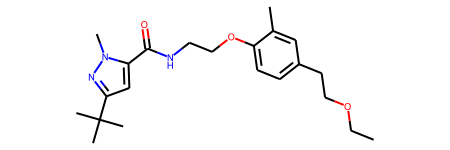

In [151]:
mols[0]

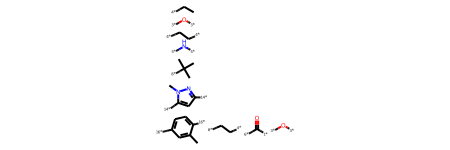

In [152]:
BRICS.BreakBRICSBonds(mols[0])

In [153]:
#mols_to_smiles([BRICS.BreakBRICSBonds(mols[0])])
m2=BRICS.BreakBRICSBonds(mols[0])
frags = Chem.GetMolFrags(m2,asMols=True)
[Chem.MolToSmiles(x,True) for x in frags]

['[4*]CC',
 '[3*]O[3*]',
 '[4*]CC[8*]',
 '[16*]c1ccc([16*])c(C)c1',
 '[3*]O[3*]',
 '[4*]CC[4*]',
 '[5*]N[5*]',
 '[1*]C([6*])=O',
 '[14*]c1cc([14*])n(C)n1',
 '[8*]C(C)(C)C']

In [132]:
BRICS.BRICSDecompose(mols[0])

{'[1*]C([1*])=O',
 '[10*]N1CC(C)C([13*])Oc2ccc([16*])cc2C1=O',
 '[16*]c1ccc([16*])cc1',
 '[16*]c1ccccc1',
 '[4*]C[8*]',
 '[5*]N([5*])C',
 '[5*]N[5*]',
 '[8*]C(C)CO',
 '[8*]C(F)(F)F'}

In [7]:
df = df_train

In [8]:
df.n_fragments.value_counts()

4.0     243480
3.0     223258
5.0     208151
6.0     150788
7.0      93174
2.0      85090
8.0      47167
9.0      22757
10.0      9096
11.0      3890
12.0      1593
13.0      1032
14.0       412
15.0       267
16.0        94
17.0        92
18.0        29
19.0        25
21.0        19
22.0         9
20.0         7
23.0         6
26.0         6
25.0         5
24.0         4
29.0         2
51.0         1
33.0         1
47.0         1
43.0         1
30.0         1
28.0         1
31.0         1
27.0         1
Name: n_fragments, dtype: int64

In [47]:
fragment_list = []
for frag in tqdm(df.fragments):
    fragment_list.extend(frag.split())

100%|██████████| 1090460/1090460 [00:02<00:00, 500542.51it/s]


In [48]:
fragment_unique = set(fragment_list)

In [49]:
fragment_counts = pd.Series(fragment_list).value_counts()

In [50]:
frament_count_df = pd.DataFrame(fragment_counts, columns=['count']).reset_index().rename(columns={"index": "fragment"})
frament_count_df

fragment   count
0                                                  '*N*',  506276
1                                              '*C(*)=O',  295887
2                                                  '*O*',  261032
3                                                  '*C*',  203132
4                                                 ['*OC',  195123
...                                                   ...     ...
359303            ['*N(C)CCCN1C(=O)c2cccc3cccc(c23)C1=O',       1
359304  ['*N1N=C(C)C(=Cc2cn(CC(O)CN3CCCCC3)c3ccccc23)C...       1
359305  ['*C(CCC(C)(C)N1CCC(Oc2cccc(O)c2)CC1)(C(N)=O)c...       1
359306                           ['*CC(=O)Oc1cccc(Cl)c1',       1
359307                       '*CC(*)C(=O)CCC(=O)N1CCCC1',       1

[359308 rows x 2 columns]

In [51]:
frament_count_df[frament_count_df['count'] == 1]

fragment  count
104705                            '*C(=O)Nn1ccc2ccccc21']      1
104706      '*C1OC(*)C(O)C(n2cc(-c3cccc4ccccc34)nn2)C1O',      1
104707            ['*C(=O)C1=C(O)CCn2c1nc1ccc(F)c(F)c12',      1
104708  '*c1cc(*)c2c(c1)S(=O)(=O)N(COc1cc(=O)n(C)c3ccc...      1
104709                   '*c1ccc2c(c1)c1c(n2*)C(=O)CCC1',      1
...                                                   ...    ...
359303            ['*N(C)CCCN1C(=O)c2cccc3cccc(c23)C1=O',      1
359304  ['*N1N=C(C)C(=Cc2cn(CC(O)CN3CCCCC3)c3ccccc23)C...      1
359305  ['*C(CCC(C)(C)N1CCC(Oc2cccc(O)c2)CC1)(C(N)=O)c...      1
359306                           ['*CC(=O)Oc1cccc(Cl)c1',      1
359307                       '*CC(*)C(=O)CCC(=O)N1CCCC1',      1

[254603 rows x 2 columns]

In [24]:
df_train

Unnamed: 0                                             smiles  \
0                 0  CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...   
1                 1        Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1   
2                 2  COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...   
3                 3  Cc1cc(COc2ccc(NC(=O)C3CN(C)CCC3C(=O)NO)cc2)c2c...   
4                 4  CCOC(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C...   
...             ...                                                ...   
1090456     1207113     COc1ccc2c(OCc3nnc4ccc(-c5cc(C)no5)cn34)ccnc2c1   
1090457     1207114       N#CC(=C1Nc2ccccc2S1)c1ccnc(NCCc2cccc(F)c2)n1   
1090458     1207115  O=C(O)CCc1ccc(-c2c(C=Cc3ccc4ccccc4n3)nc3c(N4CC...   
1090459     1207116      CCOCCc1ccc(OCCNC(=O)c2cc(C(C)(C)C)nn2C)c(C)c1   
1090460     1207117                  NCCCC(=O)Nc1ccc(C(=O)Nc2nccs2)cc1   

                                                 fragments  n_fragments   C  \
0        *CCC *N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O...            2  26   
1           *c1ccc(O)cc1 *C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1            2  22   
2        *C(=O)OC *CCCC=C(c1cc(*)c(OC)c(Cl)c1)c1cc(Cl)c...            3  25   
3        *c1cc(C)nc2ccccc12 *COc1ccc(NC(=O)C2CN(C)CCC2C...            2  25   
4        *OCC *C(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)...            2  23   
...                                                    ...          ...  ..   
1090456  *c1ccnc2cc(OC)ccc12 *OCc1nnc2ccc(-c3cc(C)no3)cn12            2  21   
1090457    *c1nccc(C(C#N)=C2Nc3ccccc3S2)n1 *NCCc1cccc(F)c1            2  21   
1090458  *CCC(=O)O *c1ccc(-c2c(C=Cc3ccc4ccccc4n3)nc3c(N...            2  29   
1090459   *OCC *CCc1ccc(OCCNC(=O)c2cc(C(C)(C)C)nn2C)c(C)c1            2  22   
1090460            *C(=O)CCCN *Nc1ccc(C(*)=O)cc1 *Nc1nccs1            3  14   

         F  N  O  Other  SINGLE  DOUBLE  TRIPLE  Tri  Quad  Pent  Hex  \
0        0  3  5      0      26      10       0    0     0     0    3   
1        0  3  1      1      19      11       0    0     0     1    3   
2        0  0  7      3      26      10       0    0     0     0    2   
3        0  4  4      0      26      10       0    0     0     0    4   
4        0  3  5      0      23      11       0    0     0     1    3   
...     .. .. ..    ...     ...     ...     ...  ...   ...   ...  ...   
1090456  0  5  3      0      22      11       0    0     0     2    3   
1090457  1  5  0      1      20      10       1    0     0     1    3   
1090458  0  6  3      0      29      14       0    0     0     1    5   
1090459  0  3  3      0      23       6       0    0     0     1    1   
1090460  0  4  2      1      15       7       0    0     0     1    1   

            logP        mr       qed       SAS  
0        2.33400  128.6249  0.522569  3.595745  
1        4.94030  112.9455  0.638566  2.563412  
2        6.07540  138.1390  0.264467  2.973098  
3        3.13402  124.9069  0.395442  3.145495  
4        2.57720  116.8143  0.513201  2.494430  
...          ...       ...       ...       ...  
1090456  3.82852  105.8480  0.452799  2.604622  
1090457  4.68028  109.0804  0.617420  2.715200  
1090458  4.36370  145.8778  0.347080  3.065345  
1090459  3.41382  111.1122  0.669825  2.398846  
1090460  2.07280   83.4273  0.760744  1.904081  

[1090461 rows x 20 columns]

In [ ]:
list(BRICS.FindBRICSBonds(mols[0]))

In [8]:
mols_to_smiles([BRICS.BreakBRICSBonds(mols[0])])

['[1*]C(C)=O.[1*]C([6*])=O.[13*]C1OC(C(=O)O)=CC(N)C1[15*].[16*]c1cccc([16*])c1.[16*]c1ccccc1.[4*]CCC.[4*]CC[8*].[5*]N([5*])[5*].[5*]N[5*]']

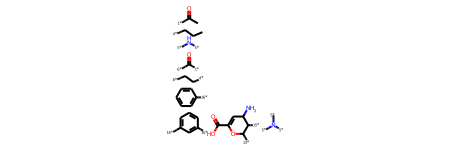

In [9]:
BRICS.BreakBRICSBonds(mols[0])

In [10]:
BRICS.BRICSDecompose(mols[0])

{'[1*]C(C)=O',
 '[1*]C([6*])=O',
 '[13*]C1OC(C(=O)O)=CC(N)C1[15*]',
 '[16*]c1cccc([16*])c1',
 '[16*]c1ccccc1',
 '[4*]CCC',
 '[4*]CC[8*]',
 '[5*]N([5*])[5*]',
 '[5*]N[5*]'}

In [21]:
smi = mols_to_smiles([mols[0]])

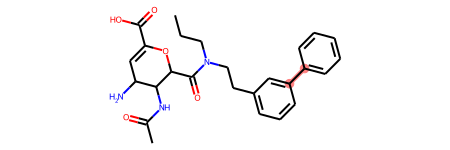

In [32]:
mols[0]

In [47]:
mols

 ...]

In [65]:
pd.Series(no_frag).value_counts()

4     23265
3     21250
5     19730
6     14224
7      8683
2      7996
8      4580
9      2143
10      888
11      374
12      159
13      100
14       52
15       24
16       12
17        4
19        4
22        2
21        1
dtype: int64

In [68]:
frag_flat = [item for sublist in frags for item in sublist]

In [71]:
fragment_counts = pd.Series(frag_flat).value_counts()
frament_count_df = pd.DataFrame(fragment_counts, columns=['count']).reset_index().rename(columns={"index": "fragment"})
frament_count_df

fragment  count
0                                            *N*  48079
1                                        *C(*)=O  28123
2                                            *O*  24793
3                                            *OC  23702
4                                            *C*  19387
...                                          ...    ...
61782        *c1cc2c(cc1*)CN(C(=O)CCc1ccccc1)CC2      1
61783  *N(C)C(=O)c1cccc(S(=O)(=O)N(C)c2ccccc2)c1      1
61784                          *n1ncc2c1C(=*)CC2      1
61785                       *N1C(=O)CN2CCCC2C1=O      1
61786                      *N1Cc2sccc2Cc2ccccc21      1

[61787 rows x 2 columns]

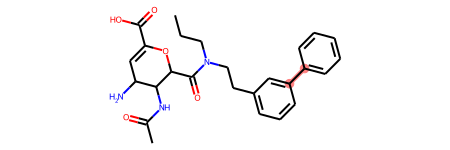

In [20]:
mols[0]

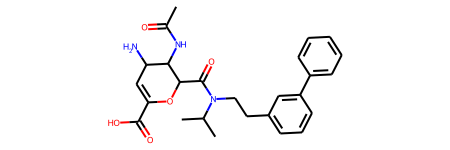

In [19]:
rec

In [17]:
dataset.data.fragments[0].split()

['*CCC', '*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O']

In [12]:
df[df['n_fragments'] == 2]

Unnamed: 0                                             smiles  \
13               13                      Nc1cc(C2CCNCC2)cc(NC2CCCC2)n1   
24               24  N=C(O)C(N=C(O)c1cnc(N2CC(F)(F)C2)c(OCC2CC2)n1)...   
37               37   CC(=O)N1NC(=C2C(=O)N(C)C(=O)N(C)C2=O)CC1c1ccccc1   
47               47  O=c1cc(-c2ccccc2)oc2cc(OCc3ccccc3)c(OCCCN3CCCC...   
62               62  Nc1sc(-c2ccc(Cl)cc2)c(CN2CCN(c3ccc(C(F)(F)F)cc...   
...             ...                                                ...   
1090390     1090390  CC1CN(C(C)CO)C(=O)c2cc(NC(=O)Nc3ccc(C(F)(F)F)c...   
1090404     1090404        O=c1cc(-c2ccccc2)oc2c(-c3ccsc3)c(O)cc(O)c12   
1090423     1090423  O=C(c1ccc2c(c1)OCCO2)N(Cc1cccnc1)c1nc2ccc(Cl)c...   
1090430     1090430             CN(c1ccc2nc(N)nc(N)c2n1)c1cccc2ccccc12   
1090445     1090445           O=C1Nc2c(CN3CCCC3)ccnc2N(C2CC2)c2ncccc21   

                                                 fragments  n_fragments   C  \
13                        *c1cc(N)nc(NC2CCCC2)c1 *C1CCNCC1          2.0  15   
24       *c1ncc(C(O)=NC(C(=N)O)c2ccc(Cl)cc2)nc1OCC1CC1 ...          2.0  20   
37       *=C1CC(c2ccccc2)N(C(C)=O)N1 *=C1C(=O)N(C)C(=O)...          2.0  17   
47       *c1cc(=O)c2c(O)c(OCCCN3CCCCC3)c(OCc3ccccc3)cc2...          2.0  30   
62       *c1sc(N)c(C(=O)c2ccc(Cl)cc2)c1CN1CCN(c2ccc(C(F...          2.0  29   
...                                                    ...          ...  ..   
1090390  *N1CC(C)C(CN(C)C(=O)Nc2ccccc2)Oc2ccc(NC(=O)Nc3...          2.0  31   
1090404      *c1cc(=O)c2c(O)cc(O)c(-c3ccsc3)c2o1 *c1ccccc1          2.0  19   
1090423  *C(=O)N(Cc1cccnc1)c1nc2ccc(Cl)cc2s1 *c1ccc2c(c...          2.0  22   
1090430          *N(C)c1cccc2ccccc12 *c1ccc2nc(N)nc(N)c2n1          2.0  18   
1090445          *c1ccnc2c1NC(=O)c1cccnc1N2C1CC1 *CN1CCCC1          2.0  19   

         F  N  O  Other  SINGLE  DOUBLE  TRIPLE  Tri  Quad  Pent  Hex  \
13       0  4  0      0      18       3       0    0     0     1    2   
24       2  5  3      1      26       8       0    1     1     0    2   
37       0  4  4      0      19       8       0    0     0     1    2   
47       0  1  5      0      29      11       0    0     0     0    5   
62       3  3  1      3      31      12       0    0     0     1    4   
...     .. .. ..    ...     ...     ...     ...  ...   ...   ...  ...   
1090390  3  5  5      0      35      12       0    0     0     0    3   
1090404  0  0  4      1      17      10       0    0     0     1    3   
1090423  0  3  3      2      23      11       0    0     0     1    4   
1090430  0  6  0      0      17      10       0    0     0     0    4   
1090445  0  5  1      0      22       7       0    1     0     1    2   

            logP        mr       qed       SAS  
13       2.48530   79.3728  0.781071  2.592788  
24       3.95527  111.1253  0.413175  3.836687  
37       0.78900   87.4177  0.601889  3.119322  
47       5.99940  140.7618  0.293304  2.424175  
62       7.87610  152.9959  0.232356  2.577301  
...          ...       ...       ...       ...  
1090390  5.73340  159.7824  0.271043  3.566919  
1090404  4.59970   94.5626  0.561091  2.526629  
1090423  4.96290  116.8125  0.451031  2.345065  
1090430  3.11030   98.1688  0.589913  2.457213  
1090445  2.93860   96.0992  0.934333  2.666779  

[85090 rows x 20 columns]

In [106]:
idx = 37
smi = df.loc[idx,'smiles']
mol = mols_from_smiles([smi])

In [107]:
smi

'CC(=O)N1NC(=C2C(=O)N(C)C(=O)N(C)C2=O)CC1c1ccccc1'

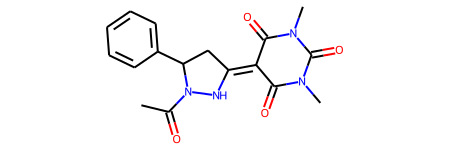

In [108]:
mol[0]

In [109]:
BRICS.BRICSDecompose(mol[0])

{'[16*]c1ccccc1', '[7*]C1C(=O)N(C)C(=O)N(C)C1=O', '[7*]C1CC([13*])N(C(C)=O)N1'}

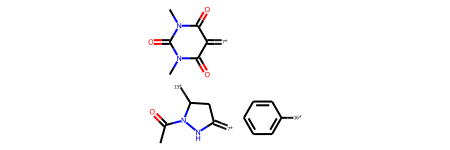

In [51]:
BRICS.BreakBRICSBonds(mol[0])

In [110]:
bond_data = list(BRICS.FindBRICSBonds(mol[0]))
bonds = []
idxs, labs = zip(*bond_data)
for a1, a2 in idxs:
    bond = mol[0].GetBondBetweenAtoms(a1, a2)
    bonds.append(bond.GetIdx())
order = np.argsort(bonds).tolist()
bonds = [bonds[i] for i in order]

In [111]:
bonds

[5, 18]

In [112]:
bond_data

[((5, 6), ('7', '7')), ((18, 19), ('13', '16'))]

In [86]:
m2=Chem.FragmentOnBonds(mol[0],[bonds[0]],dummyLabels=[(0, 0)])
frags = Chem.GetMolFrags(m2,asMols=True)
test = [Chem.MolToSmiles(x,True) for x in frags]

In [88]:
mol = mols_from_smiles([test[1]])

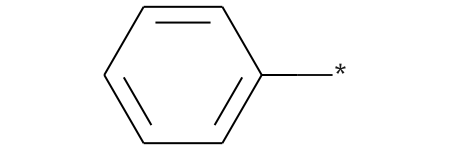

In [89]:
mol[0]

In [130]:
def fragment_recursive(mol, frags, frag_other = None, level = 0):
    try:
        bonds = list(BRICS.FindBRICSBonds(mol))
        if (bonds == []) & (frag_other == None):
            level -= 1
            print(level)
            frags.append([mol])
            return frags
        
        if bonds == []:
            level += 1
            print(level)
            frags.append([mol])
            frag_tail = frag_other
            fragment_recursive(frag_tail, frags, None, level)
        idxs, labs = list(zip(*bonds))

        bond_idxs = []
        for a1, a2 in idxs:
            bond = mol.GetBondBetweenAtoms(a1, a2)
            bond_idxs.append(bond.GetIdx())

        order = np.argsort(bond_idxs).tolist()
        bond_idxs = [bond_idxs[i] for i in order]

        broken = Chem.FragmentOnBonds(mol,
                                      bondIndices=[bond_idxs[0]],
                                      dummyLabels=[(0, 0)])
        head, tail = Chem.GetMolFrags(broken, asMols=True)
        frag_head = head
        frag_tail = tail
        print(mol_to_smiles(head), mol_to_smiles(tail))
        #frags.append(head)

        fragment_recursive(frag_head, frags, frag_tail, level)
    except Exception:
        pass

In [131]:
def break_on_bond(mol, bond):

    broken = Chem.FragmentOnBonds(
        mol, bondIndices=[bond],
        dummyLabels=[(0, 0)])

    res = Chem.GetMolFrags(
        broken, asMols=True, sanitizeFrags=False)

    return res

In [133]:
fragment = dict(left_frag = None, right_frag = None )

In [144]:
fragment['left_frag'] = dict(left_frag = None, right_frag = None )

In [145]:
fragment

{'left_frag': {'left_frag': None, 'right_frag': None}, 'right_frag': None}

In [132]:
test = []
frag = fragment_recursive(mol[0], test)

*=C1CC(c2ccccc2)N(C(C)=O)N1 *=C1C(=O)N(C)C(=O)N(C)C1=O
*C1CC(=*)NN1C(C)=O *c1ccccc1
1
0


In [102]:
mols_to_smiles(test)

['*C1CC(=*)NN1C(C)=O', '*c1ccccc1']

In [114]:
broken = Chem.FragmentOnBonds(
    mol, bondIndices=[bonds],
    dummyLabels=[(0, 0)])

ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.FragmentOnBonds(list)
did not match C++ signature:
    FragmentOnBonds(RDKit::ROMol mol, boost::python::api::object bondIndices, bool addDummies=True, boost::python::api::object dummyLabels=None, boost::python::api::object bondTypes=None, boost::python::list cutsPerAtom=[])